# Scalable KNN on Databricks with Mosaic

> See [Blog](https://medium.com/@milos.colic/scalable-spatial-nearest-neighbours-with-mosaic-336ce37edbae) | [Mosaic Docs](https://databrickslabs.github.io/mosaic/models/spatial-knn.html) | [SpatialKNN API](https://github.com/databrickslabs/mosaic/blob/main/python/mosaic/models/knn/spatial_knn.py) -- __Note:__ Make sure you run this on Databricks ML Runtime.

<p/>

1. To use Databricks Labs [Mosaic](https://databrickslabs.github.io/mosaic/index.html) library for geospatial data engineering, analysis, and visualization functionality:
  * Install with `%pip install databricks-mosaic`
  * Import and use with the following:
  ```
  import mosaic as mos
  mos.enable_mosaic(spark, dbutils)
  ```
<p/>

2. To use [KeplerGl](https://kepler.gl/) OSS library for map layer rendering:
  * Already installed with Mosaic, use `%%mosaic_kepler` magic [[Mosaic Docs](https://databrickslabs.github.io/mosaic/usage/kepler.html)]
  * Import with `from keplergl import KeplerGl` to use directly

If you have trouble with Volume access:

* For Mosaic 0.3 series (< DBR 13)     - you can copy resources to DBFS as a workaround
* For Mosaic 0.4 series (DBR 13.3 LTS) - you will need to either copy resources to DBFS or setup for Unity Catalog + Shared Access which will involve your workspace admin. Instructions, as updated, will be [here](https://databrickslabs.github.io/mosaic/usage/install-gdal.html).

---
__Last Updated:__ 27 NOV 2023 [Mosaic 0.3.12]

> Usually when asserting the notion of nearest neighbors we bound that notion to the _K_ neighbors, if left unbound the answers produced by the analysis are basically orderings of the whole data assets based on the proximity/distance and the computational costs to produce such outputs can be very prohibitive since they would result in comparing all features across all data assets.

__Optimized Algorithm (Right Side Below)__
</p>  

1. For each geometry in set L generate a kloop (hollow ring)
1. Generate match candidates within 
1. For each match candidate C calculate the distance to the landmark
1. For each L[i] count the matches; stop if count =  k 
1. If count < k, increase the size of the kloop;  repeat (s1)
1. If count > k, remove matches furthest from the L[i]; stop
1. Optional: early stopping if no new match candidates are found in the kloop of any L geometry for N iterations 
1. Continue with the next kloop up to max iterations
1. Return C geometries with smallest distance to each L[i]

In [0]:
%python

displayHTML(f"""
<img
  src="https://miro.medium.com/v2/resize:fit:1400/0*DEuwg-aDj_maPVX0"
  width="50%"
></img>
""")

## Install + Enable Mosaic

In [0]:
%pip install "databricks-mosaic<0.4,>=0.3" --quiet # <- Mosaic 0.3 series
# %pip install "databricks-mosaic<0.5,>=0.4" --quiet # <- Mosaic 0.4 series (as available)

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
#  - choose option-1 or option-2 below, essential for REPARTITION!
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management
spark.conf.set("spark.sql.shuffle.partitions", 1_024)                  # <-- default is 200

# -- import databricks + spark functions
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
# mos.enable_gdal(spark) # <- not needed for this example

# --other imports
import warnings

warnings.simplefilter("ignore")

In [0]:
user_name = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
print(f"username? '{user_name}'")
      
spark.sparkContext.setCheckpointDir(f"dbfs:/tmp/mosaic/{user_name}/checkpoints")

username? 'mjohns@databricks.com'


__Setup Catalog and Schema__

> These values will mirror the Data Prep notebook.

In [0]:
catalog_name = "mjohns"
db_name = "mosaic_spatial_knn"
sql(f"USE CATALOG {catalog_name}")
sql(f"USE SCHEMA {db_name}")

Out[4]: DataFrame[]

In [0]:
%sql show tables

database,tableName,isTemporary
mosaic_spatial_knn,building_50k,false
mosaic_spatial_knn,taxi_trip_1m,false


## Load Landmark + Candidates Tables

> We will load a handfull of datasets we have prepared in our data prep notebook. For this use case we will first manually walk through the approach and then we will apply the model that comes with mosaic.

In [0]:
df_bldg = spark.read.table("building_50k").where(mos.st_geometrytype(F.col("geom_wkt")) == "POINT")
df_bldg_shape = spark.read.table("building_50k").where(mos.st_geometrytype(F.col("geom_wkt")) == "MULTIPOLYGON")
df_trip = spark.read.table("taxi_trip_1m")

# sanity checks on counts (may vary based on your sample)
print(f"Bldg POINT count? {df_bldg.count():,}")
print(f"Bldg MULTIPOLYGON count? {df_bldg_shape.count():,}")
print(f"Trip count? {df_trip.count():,}")

Bldg POINT count? 1,160
Bldg MULTIPOLYGON count? 48,840
Trip count? 1,000,000


## Render with Kepler
> We will render our building shapes and krings and kdiscs / kloops around the shapes; showing 1% subset of building, you can pan and zoom in the viewport.


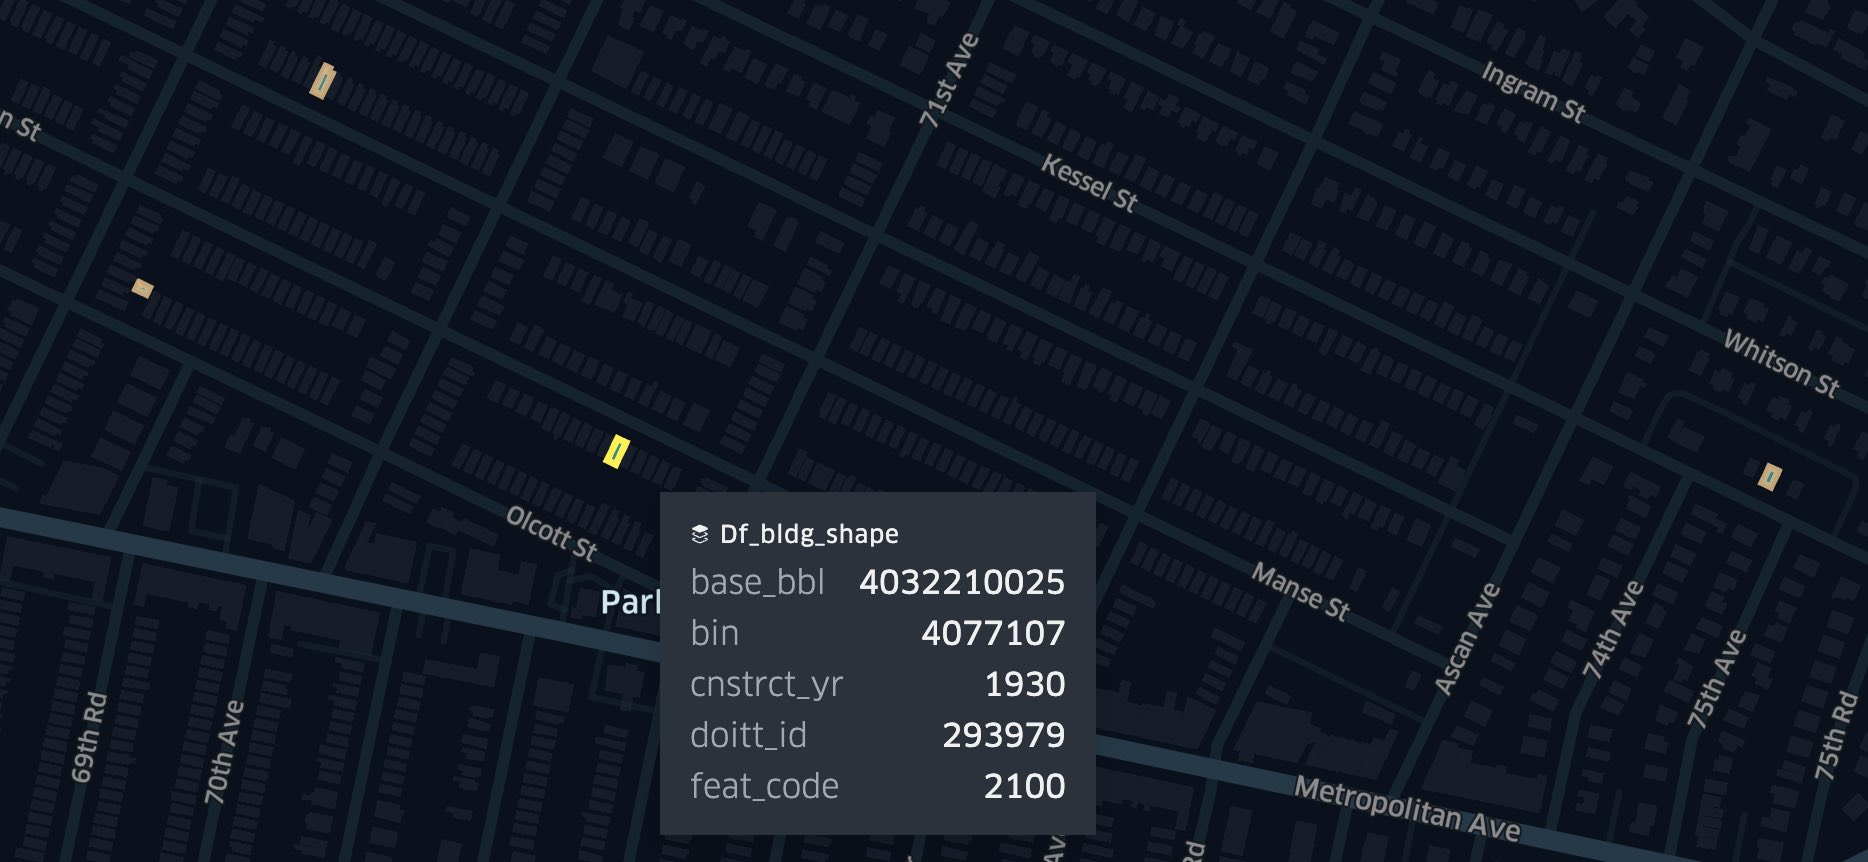

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB0ygAwAEAAAAAQAAA16kBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIA14HTAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAcEBAcLBwcHCw4LCwsLDhIODg4ODhIWEhISEhISFhYWFhYWFhYaGhoaGhofHx8fHyIiIiIiIiIiIiL/2wBDAQUGBgkICQ8ICA8kGBQYJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCQkJCT/3QAEAHX/2gAMAwEAAhEDEQA/APjC3TamT1am3Mm1dg6n+VWQMcCqQ/fz5/hFdZiWYk8tAO/eq9wA0gRR8x6mrZIAyegqtAu5mmbv0oAhe3deR8wquRjg1qSv5aE9+1V4oFaPL9T0oAp09JHjOUOKdLF5RxnOaiIxwaBGjHeg8SjHuKuqyuMqcisGnK7ococGnclxN0gMMEZFU5LNG5jO0/pTI73tKPxFXldXGVORQTqjFkikiPzj8ajroCARg1Tks0blPlP6UWKUu5l1Mk8icA5HvSSQyRfeHHr2qKkUSSSGRtx4qOiigYVYt3Kvs4watLCgjCMM1DJa94z+BoAtsqsMMMiqklr3jP4Go1klh4bp6GrUc6Px0PoaAKYeaHjkD3pkkhkbcau3LhY9vdqz6ACtOzj2oZD1bp9Kz40MjhB3rcACgKOgpoiT6COwRSx6CsN2LsWPU1evZOkQ+prPoCKCpkhkZA61DWnHJGwCqcY7Uiyss8kfyyDP86tJLG/Cnn0p7KrDDDIqpJa94z+BoAsvGkn3h+NZrqFcqDkCpfOmjyrfrVegAp8YVnAY4FMooA1i6KcMQDVeL95IZj0HAqjmrkc8aR4xyO3rQBZkfy0LUyFCiZPU8moN32h1XGAOTV0nHJoArXBJxEvVqsKoVQo6Cq8I8x2mP0FSyv5aE9+1AFZkE0xC8AdT71FJC8fJ5HrVyCPYnPU8mmXBJxEvVqAKFFaLW8bDA4I71R8tiTs+YD0oAZVqO7kThvmFVaKBWNqO4jl4BwfQ1NXP1ZjupY+D8w96dyHHsaMkEcv3hz6iqElnInKfMP1q7HcxScZwfQ1YoFdo58gjg0VuSQxyj5x+NZ8lm68x/MP1oLUinT0keP7p/CmkEHB4NJSKH+Y2/wAwHmraXQPEgx71RooAuXEoK7FOc9amgTZGD3PNZ6bdw38DvWruXbuzxQBVun4CDvyaniTYgXv3qrEDLMZD0HP+FXWYKpY9BQBVuXJIiXqanESbAhGcVXtwXcytVp2CKWPagDOlRUfapzUVKSScnqaSgAq5a7RkkjJ7VVRS7BR3qy9qRzGc+1AFl4kk6jn1qpJbMvKcj9aRZ5Iztfn69auJKknQ8+lAFJJnjODyB2NNmk8x9w6VcuNgjJYZPQVnUAFXLOPc+89F/nVPrxW3DH5UYXv3pkyZLWNcSebKSOg4FaN1J5cRx1bisehkxXUKmgj3vz0HJqGprdd0o9uaRoaVFFVmuQshUjIFADLqTpGPqag8mTaHAyDTkBnmyenU/StGgDHorSmWPYWYVmgZ4FABRRRQA5WZDlTg1djvSOJRn3FUKKBNXN1JEkGUOafWArMpypwaux3rDiQZ9xTuQ49ixJaRvyvyn9Kz5IJIvvDI9RWukiSDKHNPoEm0c/RWvJaxycj5T7VnyW0sfJGR6igtNEFFFFIoKKKKAHKpZgo6mtRVCKFHQVStjGpJY4Par9AFW6xsHPOelU0UuwUd6knk3vx0HAqxapgGQ9+lAEBt5AcdaJLd05HIrRqrdPhQg70AUaKuRQK0eX6npTJLZl5TkfrQBWoopxVlxkYzQA2iiigAooooAXccbc8elJRRQBbtUyTIe3SrtZSSOn3TirKXX98flQBcopAQwyOhpSccmgCtc7AmSOT0qhUs0nmPnsOlRUAFFFKASQB1NAF2yjyxkPbgVpUyNBGgQdqgu5Nke0dW/lTMnqzOmk82Qt27fSoqKKRoTx3EkXAOR6Gr8d3G/DfKfesmimJpM6CmPGkgw4zWRHPJF908ehq/HeRvw/yn9KCHFohksiOYjn2NUmVlOGGDW8CDyKayI4w4yKLDUjBorQksu8R/A1RZGQ4cYNItO42gHHIoooGOZmY5Y5rQgj2Jz1PJrNqwly68N8woAvkgDJ6Csp2LsWPerM06ugVe/Wordd0o9uaAL0SeWgHfvUhOOTRVe5fbHt7tQBTcmSQkDrUdXLWPrIfoKsPEknUc+tAGXRUssflNjOajII4NACUUUUAFFFFABRRRQAUUUUAPjfy33YzWikqSdDz6Vl0UAaU8mxOOp4FVraPc289B/OoGZmxuOcVeimi2hfu49aALFVrmTauwdT/KrNZx/fTYzwT+lAEsUCtHl+p6VXkTy225zWoBjgUx1Rl+cZAoAyqKD7UUAFPSR4zlDimUUCNKO9B4lGPcVdVlYZU5FYFOR3Q5Q4p3JcTdIDDBGRVOSzRuYztPp2pkd72lH4iryurjKnIoJ1RiyRSRH5xWlaxeXHuPVuaskAjBpaAcrkcsgjQue1YhJYknqavXpckDHyjv71QoKigpysUYMOoptFIsvJdKeHGKsggjIORWRTldkOVOKANaqtwkYTfjBoS6B4kGPeoLiTe+B0FAEFFFAGeBQA9Y3ZdyjIppBBwRg1qIuxAvpTmwAS3TvQBkUVZgTzHLsOB+VSvaqeUOKAKNFPeN4/vD8aZQAUUUUAFOV2Q5U4ptFABRRRQAUUUUAKCVO5eCK1I3EihhWVUscrRE470AaLuqLuas+WZpPYelRu7O25qbQAVJFGZGwOnekjjMjbRWmiKi7VoAUAKNq8AUtFN3ru2Z59KAILlQU3YyRVCtiqU8GPnTp3FAFSiiigAooooAKekjxtuQ4plFAjYhuEl46N6VYrnwSORWjBd5+SX86ZDj2Ce0z88X5VnEEcGugqvNbrLz0b1oBS7mPRT3jeNtrjFMpFhRRSqpZgo6mgZfso+sp+gq+SAMntTUQRoEHaq15JtTYOrfypmW7M+VzJIXPeo6KKRoFFFPjZVcM3QUDNKNPLQLT6Yro/3Tmn0AVrlCyhh/DVCrdzJk+Wp4HWqlABRRU0Ee9+eg5NAENFXntVPKHFVmhkU42k/SgD//0Pip7kNGVAwTUlqB5eR1zzVCnpI8f3T+FdZiXLgk4iXq1WFUKoUdBVBJSZg7Y54+lXJJAiF/yoArSfvpgg6D/Jq6BjgVVtk4Mh6mn3D7Y8DqeKAIR+/nz/CKsSrGVLOOnekgj2Jz1PJqK5ckiJepoArrE7JvUZFREY4NayrtUKO1VHHnT7B0XrQBUpysyHKnBqd7ZlyVORVagC/HenpKPxFXkkSQZQ5rCpVZlOVODTuQ4m/VSS0jflflP6VBHesOJBn3FX0kSQZQ5oJ1RkSQSRfeHHqKhroKqyWscnI+U+1FilLuZySvH0PHpVxLhG4PymqslvLHyRkeoqCkUa5AIwRkVWe1U8ocVVSWROFPHpUzXO6MrjBNAysST1OcUlFPRDI4Qd6AL9lHhTKe/Aq6zBVLHoKFUKoUdBVK9kwoiHfk0zLdlB3Mjlz3plFOVSzBR1NI1LVtGCCzDOeKc9qDzGce1RBpoOCPlqzHOj8dD6GgCDzJ4eH5H+e9SfaU2Fh1HarJGeDVOeGNVLjigB5nidDuH4GqFFFABRRRQAUUUUAPR3TlTinNLI5POM9u1RUUAailI4xyMetV2PnThRyq1Tz2q3bPGoIY4JoAuEgDJ6CqsAMkhmb8KW5Y8RL1arCKEUKO1AEc8mxOOp4FECbIwD1PNRn99Pj+FKskgDJ6CgCpcANIEUfMepqN7d15HzCprdSzGZup6U+4fbHgdTxQBnUVoLAnlhWHPrVV4sSFE+bHNAENWI7mWPjOR6Gq5GODRQI147qKTg/KferNc/U0dxJFwDkehp3JcexrPEkgw4zVGSyYcxnPtViO7jfhvlNWqCbtGAylThhg0lbrxpIMOM1RksiOYjn2NFilIoUuSBjPBpWVkOGGDTaRZbgmRF2MMe9OuH3BY05zVKlBKncvBFAGqihFCjtVS6fJEY7daEuiBhxk+1VSSTk9TQAlFFKoyQCcZoAkjdojux1q7HOj8dD6GpQF24HTFV5LZW5Tg/pQBYZVYYYZFVJLXvGfwNMzPD15H5ipftSlScYPpQBUZnPyuScGmUE55NFAFu0j3ybj0X+datQwR+VGF79TSXEnlxEjqeBTMnqzOuZPMlOOg4FV6KKRoFX7VcIW9aoVNHM8fA5HpQM0qypCDIdowParTXKmM7eGNUqANG3TamT1ap6pJdEcSDPvVkypsLg5xQBWunyRGO3Wi1TJMh7dKrcu3qSa1EUIoUdqAGvEknUc+tVpLdUj3Z5H61cLKv3iBVO5kDYVTkdaAKlFXIoFaPL9T0qNrZweORQBXoqR4nj+8OKjoAUEqcg4NXI7x14kG4frVKigTRuRyxyj5DUlYAJByKtx3jrw/wAw/Wnchx7FyS2ik5xg+orPktZY+cZHqK045o5funn071LQJNo5+itmS3ik5IwfUVQktJI+R8w9qC1JFWpFldBgHio6KRQ5VLMFHU1qqoVQo6CsirCXDrwfmFAGgTjk1nczze39KllnVo8J1PWoIpfKOcZzQBpgY4FQzybE46ngUqTRvwDg+hqlPJvfjoOBQAkSeY4HbvWkQCMEZFV7aPau89T/ACqzQBQuEjQjaME1Wp7tvct605YnZN6jIoAiopSCDgjBpKACiiigApygFgD0JptFAGuMY46Vmyyb3JHTp+FMDMowDwabQAUUUUAFXbOPc/mHov8AOqQBJwK24YxHGFH40yZMlrFuJPNkLdhwK0bqTy4sDq3FZFDFFdQooopFhRU9vHvfJ6Cp3tQeYzj2oAo0U5kZDhhim0ASxzSRfcP4VfjvEbiT5T+lZdFBLVzfBBGRyKRlVxhhkVipLJGcocVejvVPEgwfXtTIcWJJZA8xHHsaovG8Zw4xW4CGGVORQVDDDDIosNSMCitKSyU8xnHtVF4njOHGKRadyOgHHIoooGW4rnHyyfnUTkzS4X6CoacrMpypwaANVVCqFHQUEgDJ6CqsdyOkn5024lDfIpyO9AEIzNLz3P6VfeJHGCKrWq5Yv6VdoAz5YDGNwORT4YFePc3fpRdPkiMdutS26t5eWJ56ewoAouoVioOcU2rMluy8ryP1qtQAUUuDjOOKSgAooooAKKKKACiiigB4kdVKg8GrdqmAZD36VTRS7BR3rVAAGB0FAC1WuZNq7B1P8qsk45NZUj+Y5agBlKAScDqaSrdqmSZD26UAMe3deR8wqvWxUbxJJ1HPrQBl0VYe2deV+YVXIxwaACnK7IcqcGm1LDH5sgTt3oEa0LO0YaTqalo6cVnXczBwiHGOTVGSVzRqrJaRvyvyn9Krx3rDiQZ9xV5JUkGUOaQ7NGTJbyRckZHqKhroKrSWsUnI+U+1FilLuZFFWJLaWPnGR6iq9IoKKKKBhVi3Tc+T0Wq9WYJkjG0jr3oAv1WuWwm3+9/Sp1dXGVOarKPNnLdloAniTZGFPXvUlFRyv5aE9+1AFO4fc+B0WmNDIo3EcU6CPe+T0FaByRxwaAMiipJI2jOG70sURlJGcAUARUVK8Tx9Rx61FQAUUUUAFFFFABRRRQAUUUUASxSmJvY9a0gQw3LyDWRUkcjRtkfiKAL0sojHqT0FZ5Zi24nmhmLsWPU0sah3Ck4oAvW7s6fN2706WTy1z3PSpAAo2rwBVS6QcPnn0oApnnmiiigAooooAKKKKACiiigCzBctF8p5WtVHWRdynIrBqSOV4m3IaZLjc2ZI0kXa4zWVNbvCc9V9a0YZ0mHHDelTkAjBoITaOfq9ZR5YyHtwKWe0P3ovyq9GgjQIO1BTeg/pzWJNJ5shbt2rRu5Nke0dW/lWTQwiuoUUUUiyVYZGG5RkU97d15HzCrybdg2nIxTqAMjkH0IqdLl1GDzV140k+8PxqnJbMvKcj9aAKxOeTRT0jZ22jr70jKyHDDBoAbWjbptjB7nms8YB55FaaSpJ0PPpQBJRRVGW4bfiM8CgD//R+H6KKK6zEKXJxjPFJRQBejuUwFYYxTCyyzgE/KOnvVSnKxU7l4NAGqzBVLHoKqW4LuZWqKSdpF2kY9avRhVQBTkCgBJX8tCe/aoraPau89T/ACqKYmWYRjt/k1dAAGB0FAFe5fam0fxURwJ5YDjk81F/rrjnkD+Qq47BFLHtQBnSoEk2Lk1GQQcEYNWbdC7mRu386nuNojJYZPagDOpQSpyDg0lFAF2O9deJBuHr3q/HLHKPkNYdKCQcjimS4m/VeS1ik5xtPtVOO8deH+YfrV+OaOX7p59O9BFmjMktpY+cZHqKr10FQSW0UnJGD6iiw1LuY1aFlH1lP0FQvZyqwA5B71qIoRQo6CgcmKSFBY9BWHI5kcue9aF7JtQRjqev0rMoYRXUKsW7Ir5fg9qgAJOB1NXjbIVAHB9aRZY4I9Qahe3RuR8pqvtng5HI9uRU0dwrcNwf0oAizPB15H5iq2442549K0XnRCVPUCs2gAooq7apgFz34oApUVPOhV84AB6YpjxSJyw4oAjooooAKKKKACiiigByuysGHapmuHYgjjFV6KAL9uoSLee/NJO+/Eac7qpZIGM8GpoHRGy/4UAaCqFUKOgqsP30+f4Upr3P3lX8DU8KbIwD1PJoAezbVLHtUFspwZG6tSTkuwhXv1qyAAMDoKAK11tCjI5PSoWtpAMjn1FSJ++nL9l6Vadgilj2oAySMcGirsEYdS8gzuNRTQiMjac57UAV6ljnki+6ePTtUZBBwRg0lAjUjvI34f5T+lXAQRkVz9SRyyRH5D+FO5Lj2NpkVxhhkVRksu8R/A0+O8RuJBtP6VcBDDIORQTqjCdHQ4cYptb7KrDDDIqlJZKeYjj2NFilIzaKe8bxnDjFMpFBVmGDzFLNx6VWq1FcBFCkcD0oGIUmh5U8e3+FSpdA8SDHvVhXVxlTmmPDG/UYPqKAJAwblTms6fZ5hCDGKc0UkPzqePWq5OeTQAVZtY98uT0Xmq1bNtH5cQB6nk0yZPQnrJu5PMkwOi8VoTyeVGW79BWLQyYrqFPRd7hfWmVetUwDIe/SkaEUlsy8pyP1qsRjg1sU1kVxhhmgDJoq29qRzGc+1VmVlOGGDQA2iiigBQSp3LwRWhDLvGGI3VnUUASyv5jk9u1NjTzHC0yrFvIiNhu/egDQAxwKKQkAbu3Ws43EvrQA64fc+B0WhraQDI59RRbpufJ6LWhQBmvAyRhz+VQ1rkgDJ6Css5kf5R17CgBlFKQQcEYNJQAVbju5E4b5h+tVKKBWNqOeOX7p59DU1c/VmO6kj4PzD3p3IcexoyQRy/eHPqKpSWTryh3fzq5HcRScA4PoanoFdowCCpwRg0lbrxpIMOM1QksmHMZz7GixSkUaKVlZThhg0lIsKB70UUAaUc0b4A4PpRcNtiPvxWbTizEAE5AoAQAk4HU1rKoVQo6Cs+3KK+XOPStEHPIoAhn2CMlxn0rNqzcybm2DoP51WoAKKKcqs2dozigBUXe4X1q89ujcj5TUFrtDEk4PQVeoAy3jeM/MPxqOtKd9kZHc8Vm0AFFFW7G1a9u4rRCAZWCgk4HJxQB6L4S0TQ7XQbjxZ4ijaeGNxFFCpxvc+v51d8X2OgJZabd6PaNZ3V/8/k7iQEPAJB7k9K2bR4vBnm+EPGNv5+mzt5kUqgkA8c+vbnuPpWvfHwO+sjxbc6qtwsAUxWygZGwfKAOvHXoKxv1LtpY8O8QaVf6NqDWOoqElQDgEEYPPUVh1t+ItZl17WLjVJRgzNkD0HQD8BWJWq21I9ApVG4hR3pKtWqZYuegpgXVG0BR2paKQkAZPQUAVLqTpGPqaQW2UBzhqrFiX3nk5zWnGxdAzDGaAM143j+8Pxpla5xjnpWcEMznYMCgCGinMjIcMMU2gB6SPGcocVejvQeJRj3FZ1FAmrm8rK4ypyKUgEYPIrCV3Q5Q4NXo73tKPxFO5DiPks0bmP5T+lUZIZIj84/GtlXVxlDkU4gHg0CUmjn6K1ZLON+U+U/pWfJBJF94cetBaaZFRRRSKLMMyxjaw/GrhkXYXByBWVRmgCRFMsmD35NagGOBWfBIkZO4de9X1ZWGVORQA2RxGpY1RhQyyZbnuaSaTzG46DpVm1xsOBznmgCcKqjaBwarTQRhS44xVuqFzJubYOg/nQBWoq0bVtoIPPcVXZWXhhigBtFFFABRRRQAA45FWY7ll4fkfrVaigC5NOrR4Q9etU6KKACr8MsewLnGPWmwQqY8uM5pr2pHKHP1oAmNwgcoe3epgQRkHIrKZWU4YYNCuyHKnFAGtWdcOGkwO3FSfam2kEc9sVUoAK07KPahkPVv5VnxoZHCDvW4oCgKOgpoiTEdgilz0FYbMWYsepq/eycCId+TWdQwigpQSDkcGkopFlyO8deJPmH61fjmjl+6efSsSjpyKZLidBUEltFJyRg+oqjHdyJw3zD9avxzxy/dPPoaCLNGfJaSJyvzD2qrXQVDJBHL94c+oosNS7mLRVuSzkTlPmH61UIIODSLuKCQcg4NW7eSJF2ngmqdFAzXBBGQciqNy+59o/hquGK8qcUoYht3fOaANKJPLQDv3qQnHJqGKYS9sEUy5k2rsHU/yoAqSyeY+7t2rQiTy0A796p26bnyei1oUAV7kkR4Hc1n1PPJvfA6Co408xwtAE8dvvj3E4J6VA6bHKntWpwB6AVksdxLHvQAlFFFABRRRQAUUUUAFFFFABRRRQBciuAFxJ271Vd2dtzU0DPAqd7eReRz9KAIKKKKACiiigByqz8KM4ppGODWjbptTJ6tUjxpJ94fjQBlUVZktmXlOR+tVqACiiigBQSDkcEVowXYbCS8H1rNo68CgTVzoKKjiQpGEPapKoxMq7EhkLMOOgqpXQEAjBqlLZq3Mfyn07UjRSMyinvG8Zw4xTKRRZinEa7SOPUVdV1cZU5rJpQSDkHBoGa9FUkuiOJBn3p6XSnhxigCycDLGsw7pZMjqasXEoK7FOc9adapgGQ9+lAFIgg4IwaStV41kGGFUpLdl5X5hQAwTSAEbutRUUUAf/9L4fooorrMQooooAKKKKACnK7IcqcU2igCaKQI+5hmrMk6eWSh5PFUKKANG3TamT1aorp+kY+ppEuiOJBn3psI82Xe3bmgC3EmyMKeveqdw+58DotXJX8tCe/asugApSCOoxQuMjd071pBo5hjr7UAVUty6hicZ/lT3te6H8DU+10HyfMPQ/wCNCzIx2ng+h4oAzmRkOGGKb05Fa5AIwRkVTnhRF3qce1ABHdyJw/zD9avxzxy/dPPoaxaVQWYKvU0yXFG/RTVG1Quc4oLqGCk4JpmRn3MErOZB8w9qo10FRSQRy/eHPrSsWpGMrFTuXg1cS6B4kGPemSWcicp8w/WqhBHBpFpmuCCMg5FRSQI/PQ+orPV2Q5U4qZrh2AxwR6UDIpE8tiuc0ylJJOT1NJQA5VLMFHU1qqoVQo6CqlqnWQ/QVNPJsTjqeBQBGP30+f4UqaVQyHdnA54oiTy0A796iuCTiJerUAQxwB4y7HHpVY+1a4AAwOgqpEokmaTsDxQBTpQCegzVu5j/AI1HHc0+2j2rvPU/yoAoUV0Nl4a1/WrOfVdJspLm3t2CO0S7iCRn7o+Y8ckgHHeufZWVirDBHBBpKSeiY2mtxKKKKYgooooABxzVhrh2AA4I9Kr0UAX7dScytyTRNKvl/Ic7uKpBmX7pIpYyquGboKANGJPLQDv3qCcmSQQr+NOa5RcbeaS2U8yt1agCyAAMDoKrJ+9mMh6L0p9w+1No6txUkaeWgWgBk+wRkuM+lVVt3ZN46ntUkp82URDoOtXAMcCgDJZWU4YYNNq4qieUu33RwKjmgEY3A8UAV6ekjxnKHFIVZcZGM02gRpR3qniQY9xV1WVhlTkVgU9HeM5Q4p3JcTcIDDDDIqnJZI3MZ2n07UyO97Sj8RV5XVxlTkUE6oxZIpIz84qOt8gEYNVJLNG5T5T+lFilLuZgJByDg1YS5cff5FRyQyRfeHHr2qKkUWZ5RJgL061WoooGWLaPzJRnoOTWxVa1j8uLJ6tzUk0nlRl+/amZPVmfdyb5Ng6L/OqlHXk0UjRDlXcwUd61QABgdBVS1j6yH6CrlAwooooAKRlVhhhkUtISAMnoKAM6dER8LUNOdi7Fj3ptABRRRQAUUUUAO3tt2Z4Pam0VYt03Pk9FoAuRJ5aAd+9EkgjXceabNJ5aZHU9KpSStJjPagCWS43oVAwT/KnW0f8Ay0P4VVRS7BR3rVAAGB0FACMiuMMM1BJFEseSOnfvVmqdw29xEP8AJoAp0Vee1Uj5Dg1WeJ4+o49aAIqKAM8CgjHBoAKmjuJY+hyPQ1DRQI1o7uN+G+U/pVqufqWOaSL7p49O1O5Lj2Nh40kGHGaoyWR6xH8DUsd4jcP8p/SrgIIyKCdUYLKyHDDBptbzIrjDDIqjJZd4j+BosUpGfRTnR0OHGKbSLCnpI8f3T+FMooACc8miiigArSgj2Jz1PJqnAm+QA9BzWlQBG8Ub8sOfWowssX3fnX071YprsEUse1AGdNIZHJPAHaoqUkk5PU0lABXWaL4Q1/WbY6jptq00SttJBA5x2yRmodH8Ia/r1q93pduZo0O0kEDnr3IzXU2um/EPQ4BDbRXsKLziPJXP0GRUN9h2O10hdU1HT/8AhFfG9jOIgP3F0yHMZHTLfyP4GvIPFOhX3h3VG068IJUZVl6Mp6Guufxf8QNPUtLNcLt7SxD+bLXA6zrF/rt8+oai++Z8Anp0GBwOBSincHYyqKKcqsxwozWghtPSRozlTTCMcGigC/Hcq3D8H9KbcyfKEHfn8KpUUAA961UYMgZeBWVUiyugwDxQBbuZNq7B1P8AKmWrDlAOeuaqEk9Tmrtrt2kD71AFkgEYIyKz50RXCp19K0CQBk9BVODDyl2PPagCF4nj6jj1qKtiq8kEZBb7uKAM+inBWIJAyBTaAHKzIcqcGrsd6RxKM+4qhRQJq5upIkgyhzT6wAxU5U4NXY71hxIM+9O5Dj2LElpG/K/Kaz5LeSLkjI9RWskqSDKHNSUCTaOforXktYpOR8p9qoSW0sfOMj1FBakmV6UEjocUlFIoK0oWjKBUPSs2gHHIoA1JHEabvyqnbpvk3Htz+NRPI8mN3ar1uU2bVOT1NAE9RTMFjJPOalJxyazZpfNPoBQAsMYk3Z6AVEysvDDFaEC7Yx781KQCMEZFAGRRTyA0mIxx2pGVlOGGDQA2iiigAoopQCTgdTQBajuSMK/T1q4rKwypyKy3jdPvDFIrMpypwaANKYZjPGTWXV6O5B4fj37U6fy/L3EZPagDPoopVBYhR1NAF+yj6yn6Cr5IUEnoKaiCNAg7VWvJNqbB1b+VMy3ZnSOZHLnvTKKKRoPjQyMFFSvbuvI+YU2GURk5Gc1pUDMeitR442BLD8azDjPHSgBKKKKALMd1LHwfmHvV+O5ik4zg+hrHopkuKOgqOSKOUfOPxrLjuZY+M5Hoavx3UUnB+U+9BFmirJZuvMZ3D9apkFTgjBrfpjxpIMOM0WGpdzCoq9JZEcxHPsaplGDbSMGkWncVJHj+7SMxdix6muj1jwrq2iWVtf3yBYrpQyHIzyM4I6g4rmqSdxmjb7RGApye9JcS7F2jqaoAkHIODSszOcscmmA2r9tHtXeep/lVONPMcLWqBjgUANfG07umOayT7VpTgGI5OKpQpvkAPQcmgCYWuUBzg471P5MZQIR071NUcr7ELd+1AFHyg03lr0FOlgMY3A5FTWqYBkPfpRchyowOByaAKNFFFABRRRQAUUU5VLMFHU0AT2ybn3H+Gr9V2gAwYztYUglePiYfiKAC4WPYWI57VQqeeQSN8vQVBQAVLEnmOB271FUkcjRnK96ANSimRv5ibsYp9AEFw+1MDq1Z1Syv5jk9u1RUAFFFFABVu0j3ybz0X+dVK2oI/KjC9+ppkyehNWRPMzTbkONvArQuZPLiJHU8CsahkxXU0Ir3tKPxFXlZXGVORWDTkdkOUODRcbibpUMMMMiqMtkDzEcexpYr0HiUY96ughhlTkUE6owmRkOHGDTa3mRXG1xkVQlsiOYjn2NFilIoUUrKVOGGDSUiwqzHcMmFbkVWooA1lYOoYdDTqox3JUBXGQKuK6uMqc0ARyQpJyeD61nEYOPStc88VUNoM8NxQB//0/h+iiiusxCilCk5IGcUlABRRRQAUUUUAFFFFABQDjkUUUAPaR3AVjnFMoooAKUcHPSkHvWkojljHHHbNADo5EcfKf8AGnMiuMMM1Ue2ZeYzn+dCzyRnbKM/zoAm2Sx/6s7h6Gqk0hkYcYx2q006eWWU8+lZ9ABV6yjyxlPbgVSALEAdTW5GgjQIO1MiTH9OaxJpPNkLdu1aN3Jsj2jq38qyaGEV1LMd1LHwfmHvV+O5ik4zg+hrHooG4pnQVHJDHKPnH41lx3MsfGcj0NX47qKTg/KfegizRUks3XmP5h+tVCCDg8Gt+o5Io5Bhxmiw1LuYdFXpLJhzGcj071SIKnDDBpFp3JElePoePSpPNV5Qz8AVWooGa+5du7PFVoAXYzN36VSyQMZ4NXYZ0ChD8uKAH3D7UwOrU+JNkYU9e9V0/fTl+y9KtM21Sx7UAVpyZJBCv41dit5Ll0tYFLPIQiqOpJ4AH1qnbKeZW6tXufwX8L/2rrja9crmDT/uZ6GZun/fI5+uKyrVFTg5voXTg5yUUfRngPwpD4Y8OW2jrjdGu6Zh/FI3LH+g9gK87+MnhKx1DQpdR0zSTc6iGUCWEYdVByzOBy4wMdDjOeMV69d31xDeW2mWWN8p3yZGQIx1/M9PpWN438Rw+F9AudWbHmIu2IH+KRuFH9T7A183B1I1I1OrPW5oTjKmtkfnkysrFWGCOCDSVo3nmTEysdzEksx5J981SSJ5ASvavqTxiOigjHBooAKKKKACiiigAqwLhwmz2wDVeigC1BukkDNztFW3kVATnkdqywSDkHBoJyct360AXbZTzK3VqfcPtTaOrcU03EaoNnPtTY/30plPRelAFiNPLQLVaT97OEHIHX+tWZH8tC1Q26YXe3VqALDbdp3dKzViaTLIMAVZuWOBGOpqeNPLQLQBmMrLwwxTavP+9mEY6L1omgQKXHy4oAo05XZDlTg0mDjOOKSgC/HenpKPxFXkkSQZQ5rCpVZlOVODTuQ4m/VWS0jflflP6VXjvWHEgz7ir6SJIMoc0E2aMiS3ki5IyPUUtvH5sgB6Dk1s0xURCSoxnrRYfMPrLvJNz+WOi/zrRkbYhbrisMkk5PU0MIrqJSgZOPWkopGhrqoVQo6ClrMSV4+h49KuJcI3B+U0AT0UUUAFVbp8ARjv1q0Tjk1nqPPmz2/pQBAQR1GKStdtu07ulZqRmVjs4FAEVFOZGQ4YYptABRRRQAUoJByDg0lFAD3kaTG45xTKKKALds0a53HBNTtOiPsas2igDWLDaXHIHpVW3BdzK1VMkDGeDWlDt8sBTnFAEtQXD7UwOrVPWZK/mSZH0FAEltHubeeg/nVx40k+8PxojTy0C04kAZPQUAZ00YjOAc5qGnsxkct3NXPsyFQOhxQBQopzLtYrnOKbQAVJHLJEfkP4VHRQI047xG4kG0/pVwEMMg5FYFPSR4zlDinclx7G4yqwwwyKpSWSnmI49jRHeqeJBj3FXVZWGVORQTqjDeN4zhximVvkBhhhkVTkslbmM4Pp2osUpdzMoqSSKSM4cYqOkUSRyNGcr3q3Hcq3D8H9KoUUDNgHPIqldPkiMdutV0keP7p/CmkknJ6mgBKKKljhlldY41LMxwAB1JoA9Z8BeL7eG0PhrVna3gkbMc8Z2NG59SO31/HivRtGg8YaRrU51u/abSreJpfNbaQ47DOMg9zzXzpDAYVMUgIcH5gRgg+lepeE/GNuLJ/C3ihi9jMpRJCTlAf4SfT0Pb6VnKPVDjLWzMTxF8TtY1m0udLKRpbzNwVB3bM5AJz+fFeX1c1BbZb2VbMloQx2FupXPGfwqnVRQmwq/bJhN/c1SRS7BR3q41uyndCcH0qgJ3jST7w/Gqb2zj7nIqVbhlO2YYPrVlWVhlTkUAZJBBwRg0lakoTYS4zisugAooooAKUEqdy8EUlFAErSu+cng9qIk8xwO3eoqsQSrHkMOvegDQqrcvwIx1NSNPGuOc59Kz3YuxY96ANKNBGm386bJAj89D6inRBwg3nJpzMEUsegoAzHQxttNMq5bjfIZW61K9vG3I4PtQBnUVNJC8fJ5HrUNACgkHI4NW47x14k+YfrVOigTRuRzRyj5D+FSVz4JByKtx3kicP8w/Wnchx7F2S2ik5xg+oqhJayx8j5h7VpRzxy/dPPpUtArtHP0VsyW8UvJGD6iqElpInK/MPagtSKtAOORRRSKJjPIU2E5z+dMRd7hfWmUA45FAGxUFw+1MDq1V47ll4fkfrUcjmV8j6CgCa1TJLntxVwgEYIyKai7EC+lOJAGScCgCjcRJHgrxntVapp3DyEjkDioaACrVqmWLnoKq1JHK8f3enpQBqEZ4NVpLZW5Tg/pSJdKeHGKshg3KnNAGY8Tp94cetR57VcuZP+WY/GqdABV2yj3OZD0X+dUuvFbcMflxhPzpkyZLWJPJ5shbt2rSupNkWB1bisihiiuoUUVft48JuYfe/lSLKsO3zAXOAK06rSWytynB/SoMzQcHp+lAE9y+1No/iqhVmS48yPbjBNVqACiiigByozAlRnFNrUiTy0A796pXGfMJIx/WgCCiiigCaOeSL7p49DV+O8jfh/lP6VlUUyWkzoOvIrpvB+hf8ACQ+IILN1zDEfNlP+yvb8TxXn0c0kX3Dx6V674Y8RaT4f8JX9xbzA6rcnYFxyo6Ag9wMk1EnoEY6m3qtkfiL4wm0+OTyrDToym9RkZHHH1b9BXn+tfDzXtHsm1Iqk1uv3miYNtHv/AJNdvc58H+AktAdt/rJ3Of4lQjn9OPqTR4QZ9E8E6trN4x8i5BihjPRmwVyB7k/pWabRqeF9KK9Z0vwj4bg8OxeIPFFzJCLtisSxAE46ZPBz0zWT4i8AXml241XTJBeac6h1mGAQD0ypOfyq1JE2PPQSDkHBq0l0RxIM+9V5I3iYpICpHY0yrEWriVXAVeR1qa2Tam49TWfUyTyJwDke9AGlnPSqc58yRYh+NMinCDDDOTnNSW67iZW79KALQAAwOgqvcvtTaP4qs1mSv5jk9u1AEVFSRR+Y+3t3qx9l5PPFAFOinMuxip5x6U2gAqeCRI2Jbv3qCigDYBzyKY7BULHkVmB3AwGIFPeV3UK3agCI880UUUAFFFFAF6KeMIFPy4FV3mdmODgHjFQ0UAFFFFABRRRQBZtY98uT0XmteoLaPy4gD1PJpZ5PKjLd+gpmT1ZnXUnmSYHReKrUUUjRBRTlUswUdTTnikTlhx60DI6kjleM5Q4qOigRqRXiNxJ8p/SrgIPIrn6ljmki+6ePTtTuS49jYeNJBhxms+WzZeY/mHp3qzFdxycN8pq1QTdowCCDg0lbckMco+cfjWfLaSJyvzD9aC1K5UpQSDkHBpKKRRbS6I4kGfekkuG3fuzxVWigD//U+H6KKliTzHA7d66zEuwR7E56nk1DOitIqKME9TVskAZPQVXgG4tMep6fSgCB7d15HzCoNpxuxx61oXD7YyO54p8SbEC9+9AGXRU8qEylUGfYVARjg0AFFFFABRRRQAUUUUATJA7puFOWWSH5GHHoafbPglS3HYVcIBGCMigCKOdH46H0NSsqsMMMiqz2oPMZx7VCJJoflb9aAGSqiuVToKioJzyaUAk4FAFyzj3OZD0X+dadRxRiKMJUV1J5ceB1bimZPVmdPJ5shbsOBUNFFI0LNtHubeeg/nVh7dG5HymmrC6AGNue4PSnCbB2yjaf0oGU3iePqOPWoq2Ac8iqNzGFIZRgd/SgBkdxJFwDkehq/Fdxvw3yn3rJopktXOgpjxpIMOM1kRzyRfdPHoavx3kb8P8AKf0oIcWiCSyI5iOfY1SZWU4YYNb/AF5FNdEcYcZosNSMGitCSy7xH8DVFkZDhhg0i07grshypxUzzmQBG4GeTVeigZsRIZCscI3E4CgcknoAK+9PBXh2Dwn4cg044DRLvmbsZDyx+g6D2Ar4u+G994f0zxba6h4kkaO3gy6EKWXzR9wtjkAH5sgHkDtmvuy2u9L1vTt1tKlxbTDG+NsqR9Vrxsxm7xg9j0MLH3ZSjuU9GzdPPrso5nOyIHtGpwPzPX6V8y/GjxR/auuLoNs2YNP+/joZm6/98jj65r6J8Y6/beEPDM19HjMKCOFf70h4Ue/qfYGvhGaaSeV7idizuSzMepJ5JNPBw9pUda2i0X9ehnNeypKl1er/AK9SlcPhdi9WqaNPLQLVWPM0xkPQf5FWpH8tC1ewcZR8rdMUByM8mmzRiNsA5zVq3TC726tSXODhQMsaAKNFaZjXywpGcD6VnrG7khRnFADKKUgg4IwaSgAooooAKKKKACp4pzGNuMioKKAJ1LzFY2OQKv7lX5cge1ZIOORTmZm+8c0AWoh5splPQdKsyP5aFqhikjSHI6jqPemFvtEiqPujk0AS26bU3Hq3NMuWziJepqySAMnoKqwAySGZvwoAsKgVAnUVTMQklZY+AP51blfy0J79qbBHsTnqeTQBReJ0+8OPWo6v3BJxEvVqV7aNvu/KaAM+lBIOQcGgjBx6UlAGjbXErv5bc+9X6qWceyPeerfyqxI4jQue1Mye+g+q8ltFJzjB9RVOO8kU/P8AMKvxzxy/dPPpQFmjNktZY+R8w9qrV0FQSW8cvJGD6iiw1LuY1FWpLSROV+YVVpF3Jo5nj4HI9KuRzo/HQ+hrNooGX7mTauwdT/KnW6bUyerVQzkjdyBWis0bDOcYoAiunwBGO/WpII9ic9TyaqxgzTbm6davOwRSx7UAVLp8kRjt1pfs2YwRw3vUUKGWTLc9zV6R/LQtQBmFSG2nrTSMcGrNum997dv51ZmWMoWcdKAM2inpG8mdvamkEHBGDQAlFFFABRRRQAUoJByDg0lFAFj7S+0qevrTYCgkBfjHT61DRQBrggjIORVGWfeCgHGf0qAMy5wcZptAFi2Tc+49BWhVGGZEXaRj3q6rKwypyKAK10VAAwMn+VV4YfN5PAFNlffIWHTtWhEmyMKevegCpJbMvKcj9arkEHBGDWsSAMnoKzgDPLz3/lQBDRV57VTyhxVR43j+8PxoAZT0d4zlDik2tt3Y4ptAjRjvR0lH4irqurjKnIrBpyuyHKnBp3JcTdIBGDVSSzRuU+U/pUUd6eko/EVeR0kGUOaCdUY8kMkX3hx61FXQdetVJLSN+V+U/pRYpS7mVRU0kEkX3hx6ioaRQV7d8OtT8Mm1261BDDJp582Odjhjk9MdTj/IrxNRlgK9y1Lw3croGkeHNFsxLJeqJ5rgrnBIHG7sAD+VRMpEOv8AgXU7+abXtCuE1SG4YudhG8Z7Dscfn7VwPiDw1qmi2Nre6liI3O7bEeHXae4/KvTIvCbaLDcv4X1stqVkm+eJcBSAORjp+efwrxzWtd1XXbn7RqsxmdRgZ6AewGAKUW9gaW5jUUU5V3MF9a0ESRs0Xz7cg1eSVJOh59KeAANvbpVeS2VuU4P6UAWGVWGGGRVV4DHmSI4xSb54fvjcKSadXQKvfrQBC8ruoVu1RUUUAFFFFABRRRQAUUUUAFFFFAFqCZUG180yabzOAMAVBRQBNAm+QHsOa0qzIXCPkkgVcNxGOhzxmgCG6fJEY7dadHbq0eX6mq8amWTn6mtOgDPe3deR8wqvWlPJsTjqeBVeKASR7jwSeKAKtFPeNozhhTKACrUd3InDfMKgZHTlhjNMoFY2o7iOXgHB9DU1c/VmO6lj4PzD3p3IcexoyQRy/eHPqKoSWcicp8w/WrsdzFJxnB9DVigV2jnyCODRW3JDHL98fjVCSzdeY/mH60FqRTopSCDg8GkpFE6XEi8Hke9LNMJAAOPWq9FABRRRQBPbx73yegqd7UHmM49qqRsysNpxmtWgDJZGQ4YYpAxXlTitYgEYIyKzZU2ORjA7UARE55NFFFAFq0j3ybj0XmtaoLaPy4gD1PJpbiTyoiw6ngUzJ6szbmTzJTjoOBVeiikaBV+O4Q4Vvl/lUCQNIm4HHpULIyHDDFAzWBzyKCM8GspJHj+6fwq4lyh+/wAGgCC4REYbeCetV6c7F2LHvTaACrFum58notV6u20iBdh4OfzoAt1BcMFjI7nip6oOfPm2joKABLffHuzgmrCQKE2uATU4GOBTJH8tC1AGbIoRyqnOKZSjLHHUmrhtRtGDg0AUqUMVOQac8bx/eH40ygDTuNWv70xC9meURLsXcScL6DNeptqK+Nn0nwxokBjtLRQ0yswH3eGJI9v1NeM10fhfxHc+GdUXUIFDjBV0PRlPUVEo9hpn0HqsNldab5Wl2kGraTb9IYWxLEwzkg5Ofp1rldLvf+E68Q2lslv9k0rSU3mInj5cYDduo/IGqmjeIfAOl3/9v2L3VrLtbdajlGJ7Z9PqayF8a6bb+HNSislaK/1KdmkOOFjYngEeg4+prOxdzV8Qa/4B1S5vZZ7Saadg3lzg7VLDhQADwPcjmuVX4cateaaupaVLDd5QM0Ub5dSexHqPrVvwVoGna293faozfYtPi8x1TgtwTjP4Gu08F2PhnUdZXVfDkk9ibPLTQyHKshBA+bPr1BNPbYla7nz/ACxSQyNFKpVlOCDwQRUde7WWj6J4hudc8V6wfJsC7JC5z97P38Dk9uO+a5fWPh/GNKTWvDN1/aUDNtYKhDg/T/62atT7iseY1NHM8fA5HpUt5YXthJ5N7C8L+jqVP5GqlWIuSXCtGQvBPFU6KKANG3TamT1apJH8tC1VbZ8EqW47Cm3Mm5tg6D+dAFYnPJooooAKKmgj3vz0HJq88SP94c+tAGXRTmADEKcim0AFFFFABT40MjBRTKv20e1d56n+VAFSSJ4/vdPWo62CM8GspypcleBQAyiiigAqxbR+ZKM9Byar1r2sflxZPVuaZMnoWayryTfJsHRf51oTSeVGX/KsQ88mhkxXUKKKKRoORyjbl61poxZAxGCayhV+O5VuH4P6UAPeCNu2PpVV7aRfu/MKvggjIORQWC8scUAZBGODRVu5SNRuH3iaqUAFTxXEkXAOR6GoKKBGxFcxy8dD6GrFc/VmK6kj4PzD3p3Icexoy28cvUYPqKzZbaSPkfMPUVpRzxy/dPPoamoEm0c/RWvLbRyc/dPqKotaTKcAZoLUkf/V+H6tW8kaZDcE96nOlX32NtQWJjAr7C+OA3pn1rPII4NdSZiXp2LBY053VYVQqhR0FZSOUbcvWrP2rKEEc+1MB4/fT5/hSrDsEUse1MhULGAOc1DOTJIsI/GgB1svBkbqxoudu0DGWPSrAAAwOgqsn72YyHovSgCF7Z1GRzVcjHBrVkfy0LVCkCmP94OTznvQBQoqWVBG+0HNRUAFWLcxhjv6ngfjSLbuybx+VMG+JgxGCKALclsrcpwf0qDdPAeen5ip47lW4fg/pVjIYccg0AQpcI3B+U1XuXy+zsKkmgjClxxiqVABVyzj3PvPRf51Trbhj8qML370yZMlrGuZPMlJHQcCtG5k8uI46ngVj0MmK6hTkO1g+M4NNrShTbEFI69aRoEc6Px0PoalIBGCMiq8lsrcpwf0qLdPCOeR+dAE/lFDmI49jyKhnkfb5bDBoa6JxtGPXNV5HMjFjQAyiilAJOB1NACUVo/Z4yoUjkd6osuHKLzigB0c0kX3Dx6VfjvEbh/lP6Vl0UEtXN8EEZHNIyq4wwyKxY5ZIz8hxV+O9VuJBg+vamQ4sbJZDrEfwNUXR4zhxitwEMMqcihlVhhhkUWGpGBW9oPibXfDNz9q0S6e3Y/eUHKN/vKeD+IqnJZKeYjj2NUHjeM4cYqZRTVmi4y6o9B8Z/EjWPGtrZW99GsH2XcW8snbI5wA205xgcdT1NcG1w7JsPU96r0VMIRguWK0LlJyd5GlAFEYwc+tRS5llEQ6DrVRWZTlTg1NDKqMS/Vu9WSX+APQCq0X7yQzHoOBRPKCgVDkt6VPGuxAvpQAkr+WhPftTYI9ic9TyaicebOE7L1q0SAMnoKAKVypMgAOSe1JJb7F3A8CpIAZJDM34VLOVEZyM+lAGbRWjFEojw4znk1SdCJNuMZPAoAjopzKynDDBptABRRRQAUUUUAFSxStEcjoaiooAmeWSTI7HtV9QsSBScAVlU4sxAUngUAW2/e3ATqFq0SAMnoKp27xopycGkkn81QijBJoAkgBdjM3fpUk8mxOOp4FSqoVQo6Cs+4fdIR2HFAEFSQxmSQJ+dR1p2ce1DIerfyoJbsXQMDArOvZMkRDtyavuwRS56CsNmLsWPU0yYobRRUwgkZN479qRoSR3cicN8wq/HcRy8A4PoaxyCDgjBpKZLijoKhkgjl+8OfWs6O6lj4PzD3q/HcxScZwfQ0EWaKUlnInKfMP1qoQQcGugqOSGOUfOPxosNS7mHRV2SzdeY/mH61TIIODwaRaZJHK0fToafNN5gAAwKr0UDNKCPYnPU8mq9yxZwg7fzqOOd046j0NLCVMu6Q+/wCNAF6NPLQLVW6fJEY7datuwRSx7VQhQyyZbnuaALcCbIwD1PNQXLbmEY7VbZtqlj2qnboXcyN2/nQA42vyjaeaqEFTg9RWpI2xC3pVK3XfJuPbmgCAgg4IwaStZkVxhhmqE0QiwQetAEFFLggZxwaSgAooooAKKKKAClBI6HFJRQA5GCsGIzitRW3qGHGfWsmrUdyVAVxkCgCW5k2rsHU/ypLVMKXPeoHJnmwOnQfStAAAYHQUALQRng0UUAMK7UKx8elZrxtGcMK1azZ33yEjoOKAIaKKciM5woyaAG0qsynKnBoIIOCMGkoAvR3rDiUZ9xV9JEkGUOawqUEqcg4NO5Dib9VJraJgWHyn2qvHeuvEg3D171qwwz3cEk9tE8kcQy7KpIUH19KGxJNM6S7+Guv21hBqtsguopY1kIiOWUMM9Op/CktPGfibTdOOj290Y4lBUBlG9B6Ankf0rbHxE1O20/TbfSS0UlpH5cocBkkAAA4/ya6nTdV8M/EK4Gna1p5gvypIli7gcn5hz+eax16munRnCaXr+k6D4avTbO8mqX4MTZGAiHqc85zmvMicnPrXZeNrmzvdcmbSoVjtYSIk2ADds43HHXPrXGVcV1BhVmGDzFLNx6VWq3FcBQEYYA7iqEB8+Hp8yipkuEbg/KamVlYZU5FRvDG/UYPqKAJSccms+YwkBo+CaJFkhXbuypqvQAUUU+NDIwUUAGxyu8DimVrgADA6CqtysYXdjDGgClRUgikKbwMio6ACiiigAooooAKKKKACiiigCaB3V9qc5rSrOgkWNiW796tTShY8qeTwKAK0hM021enSr4AAwOgrOgkWNst34qx9qUMRjI9aAJZcEBO7dP8AGmfZk3Bh09KrTyb3yp4HSrsQYIN5yaAJCM8GsybaJCE6Vpbhnbnn0qhNEqOFTqe1AFeirb2pAyhyfeqzKynDDBoAbViO5lj4zkehqvRQI147qKTg/KferNc/U8dxJFwDkehp3JcexqvFHIMOM1RksmHMZz7d6sR3cb8N8p96tUE3aMAqVOGGDSVuvGkgw4zVGSyI5iOfY0WKUihRTmVkOGGDTaRYVKkrx9Dx6VFRQBopcI3B+U1DdPkiMdutVKKACp7aPzJQD0HJqCta0j2R7j1bmmS3ZFqsq8k3ybB0X+daMriOMv6ViEknJoZMV1EpQMnHrSUuCBnHBpGhrLgABenalIzwaykkdPunFW0ugeJBj3oAWS2VuU4P6VTdGjO1qvmeMHBP41nuxdix70ANooooAKKKKAJTNIQBnpU1qRuIxye9VKAccigDXyCcZ5FU7p8kRjt1qsWYtuzz60qgyPgnBJ60AWbaP/lofwq5SAADA6ChmCqWPQUAU7p+Qg7cmqmO9OJLtk8k1pqiqgTqKAMsqV4YYpK0pyojORn0rOAJOB1NACUVNJA6c9R6ioaAOl8NeKdR8MXLT2W1kkG2SNxlWHoRXeL49sZfD91pmnWcdhd3rhCYhtTY3BJOc56/TNePUdORUuNxpntPji9tdN0nT/B2kuJI4kEsrIch2PTp1ycn8q1NXvrnwF4TstEsJPKv7vM0zDqoPX+g/A14hY38tjeRXqAO0LBlDDIyDkZFdd/bkXirxTFfeIpFhgdkDkA7VRew68H+tQ1YdzvPGM0174B0yfXcNqMz5RsYbZzyfwxn3ryDTNDvdV1KHTLQBpJjhfT3J9gK7Xxxr8Wva+/2Vgba1HlQgdCB1YfU/pWV4c1o+H9bttWKF0QncP7yNlTj6VS0RLfvWOtuPhISr2+n6nBPeRj5ofunPp1J/MV5PqGnXmmXb2V7GY5YzhlPUV65400YQunjvw3cE29y4dmU4aNz3+hPBHY8Vt+F/DNjrunyeK9Tc313cK6eXMAqGXoMH8gKlSaKsfPVFaGq2Vzp1/LaXiCOWNsMoIOD+HFZ9ap3JCiiigDSgj2Jz1PJqaqcNx0WT86nE0ZGd2KAIZbbPzR/lVIjHBrUeQLGXBz6Vlk55NABRRRQA+NPMcLWqBjgVWto9q7z1P8AKrNADWAKkE4FZJ9qv3Mm1dg6n+VUKACiiigCa3j82QL2HJraqraR7I9x6t/Kp5HEaFz2pmTd2Z15Jufyx0X+dU6Ukk5PU0lI0SCiiigYUUUUAOV2Q5U4p8kzSAA8YqKigAzRRRQAUUUUAFFFFABVyK8dOH+YfrVOigTVzcjljlGUNSVgAkHI4NWlvJVGDg07kOPY/9byXXNbj8B6dYeGbGCG5mRPNn81dw3H+pOfwrnPiFpemzaRpniG0thZ3F8uXiXgdM5x/nrWLo4fxz4x33jYWeQySZPSNedo/DAqz471xdb151tz/o1mPJiA6cfeI+p/StktTJvRs81gtLi5nW1gQvI5wFAyST7V01/4F8U6bbfa7uydYwMkjDY+u0nH410PgK+sNP8AFVtPqBARgyKx6K7DAP8AT8a6nX9e8ZeDvEkktzMbmznYsivzGyZ+6P7pA44qpN3sCs1c8KDPGeDg1LFKFkLyZJPevVv+ELl1yK88V6kEsbJ42njWIBuT0XA6e/ua8jcbWIFNSuJovyyL5fyHO7gVJGnloFrLBIOR1FWluiBhhmqAkk/eTLGOi8mrBIAyegqG3HylycljzTLp8ARjv1oAps25ix70KrN90ZptWIJVjyGHXvQAxZpE4B4rQUrInOD60xkimG79RVZoZYjuQ5+lAEz2yH7nBquVmgOR09R0qWO67SD8RVgyKEMgOQKAKMkzSKARjFQ0HnmigC1aRb5Nx6L/ADrWqGCPyowp6nk0lxJ5cRI6ngUzJ6szrqTzJTjovAqvRRSNCWKMytjoB3qT9/B7j8xToJY0XDcH1q4CCMg5FAyFLhG4PympyccmoHt426DB9qrPHLGpHVaAFuVjUgKME1WoooAKt2qZJkPbpVQc8VrIoRQo7UANlfy0J79qhtUwDIe/So5SZZhGOg4/xq6AAMDoKAK9wsewsRz2qr5MmwOBkGpZSZZhGOg4/wAavAY4FAGPRVg/v5uOn9KV7Zx9zkUAQpI8ZyhxV+O9U8SjHuKzaKBNXN9WVhlTkUEBhhhkVho7xnKHFXo70dJR+Ip3IcR0lkrcxnB9O1UJIpIzhxitpWVxlTkUpAIweaBKTMCitSSzRuU+U/pVCSGSL7449aRadyIHHIq0t0wGGGfeqtFBRftgNhbOSetFy3yhB1NUQSDkHBqVZf3geTnFAF+NPLQLUDnzZhGOi8mpDMmwspzikt02puPVuaAJiQBk9BVWAGSQzN+FOuWOBGvVqnRQihR2oAgugdgOe9RfZjsDZwcd6kP76fH8KVYYhVJbpQBk0Vct4w2XYcdhUM6BHwoIFAENFOZGQ4YYptABRRRQAUUUUAFORijBh1FNooAsPcOTlflqvRRQA+NDI4Qd63AAoAHQVSso8KZT34FXWYKpY9BTMpMoXsnSIfU1n053LuXPem0jRKwoGTgfpWojIy/IcgVWtU6yH6CrDxI/J4PqOtAxzIrjDDNVXte6H8DUuZo+vzj9ad5yFCwPQdKAM0gqdrcEUlKSScnqaSgCxHcyx8ZyPQ1fjuopOD8p96yKKZLSOgpjxpIMOM1kR3EkXAOR6GtCO7jfhvlP6UENNFeSyYcxnPsapMrKcMMGt+mPGkgw4zRYal3MKir8lkesR/A1SZWQ4YYNItO4bm27c8VZt5Y0G1uCe9VKKBly5kzhFPuasRJsQL371mKdpDDtVxboY+cc0ANunyRGO3Wp4I9ic9TyaqQoZZMtz3NaNABWa5M0vy/QVbuH2pgdWqK1j6yH6CgC0EULsxxVOeJEG5eM9qvVT/18/qq0AUyMcGitOVYypZx071RWJ2TeoyKAIqKUgg4IwaSgAooooAKKKKAAHHIqyly68N81VqKANRJUk6Hn0qSserCXDrwfmFAFqeTYnHU8Cs2pZpPMbI6DpUVAEkcZkbaOKvQxeUD3JqvbSKp2nqx61eoAayK4wwzVOS22gsp4HrV6qd1J0jH1NAFOiiigBQCxwK+h9NvLf4ceFbM3MQlutRcPKh6+Xjn8lx+Jr59t5jbzpOAGKEHB5HHrXY634hv/ABPdpqF+ApVAiqvCgDrge5qWrsL2VzofGPhuDT/L1/RP3ml3vzKR0jY/wn0Hp+VcZa31xZzmWymaGXaVJU4OD1Fd14I8RW1oZPDWuYfTb35fm6I5/kD+h5rznxBZ2un6xc2ljL50UUjKr+oBpL+Viav7yJgAowKhkt4pOSMH1FUY7uROG+YfrV+OeOX7p59DWhm00Z8lpInI+Ye1Va6CoZII5fvDn1FFhqXcx1ZlOVODVqO67SD8RSSWkicp8w/WqnTrSLuTTSeY+R0HSoaKKBhV+2QBN/c1QrUjZSgCnOBQBJWfITNNtXp0qzPJsTA6mmWqYBkPfpQBZxhcL2HFZciMjYfrWqTjk1nczze39KAIKKvyWytynB/SqTKVO1uDQA2iiigAooooAKKKKACiiigAooooABxzVtLojiQZ96qUUAPkfzHLVYtlLMZG5xVSr1tJkbDjjpQBapkmzYS4yBUbzoEJU5PSqYeSQCLOcmgBywM6b1/KoSCp2twRWso2gKO1IyK4wwzQBk0VLJHiTy0yaYyspwwwaAG1NHPJF908ehqGigRqx3kb8P8AKf0q2CDyK5+pY5pIj8h/Cnclx7GyyI4w4yKoyWXeI/gakjvEbiT5T+lWwQRkcignVGEyMhw4wabW8yq4wwyKpSWQPMRx7GixSkZ1FPeN4zhximUiiWGPzZAn51t9OKpWUe1DIep6fSrbsEUsegpmcnqZ97JlhGO3JqjTmYuxY9TTaRolYcil2CjvWrtXbtxxWbC6xtuYZrRV1cZU5oGV3tQeYzj2qo8bp94YrVoIzwaAMeirs0EYUuOMVSoAKKKKACiiigAooooAKKKKAHK7r90kU9ppHXaxqKigCzbR7m3noP51frIDFeVOKsrdMBhhn3oAbcvuk29lp9qmSZD26VUJzya0IJIyoQcEUAWKzrgqZMKOnX61ekfy0LVnxJ5kmD9TQBFRWkIIwcgfhVWdI4yAvU0AV6Kcqs33Rmm0AKGIO7vXrmjeI/CWr6NBoXiqAwNbDbFcRDkD3wCc+vBBryKik1cEz3DVtW0FdDh8DeE5Guftcq7pHyMFmB7gck46Dio/iFdxacll4N08lYbFFeQjjLkcf4/jXjVtczWlwl1AxWSMhlI6gjkGur8Q+MJ/EbQT3lvEk8Qw8iDBf0z9Kjlsxt6GRNEtwxeUlnY5LE5JPuazpLSROV+YfrV+O4ik4BwfQ1PWtjG7Rz9FbckMcv3hz696oSWbrynzD9aC1Ip0UpBBweKSkUGe1FFFABTlALAMcCm0UAa4xjjpSk45NZSSPH90/hU73G+PaOCetAEEj+Y5amUUUAFSwx+bIF7d6irUs49qbz1b+VBLdi504rNvZMsIx25NX3cRoXPasNmLMWPU0yYrqJRRRSNB6o78qM4phGODVy2kH+rI5qy8aSfeH40AZVFWZLZl5TkfrVYjHBoAKKKKACiiigAooooAfGnmOFqw9qRzGc+1PtUwpc9TVqgDIIIOCMGkq1dOCwQdqq0AFFFFAH//1/iOOWSJg8bFSO4p6TyK2d3B61CVIwSMZpK67GJ7NZ+FdB8V6TbyeG7lbe+iQLNDMfvnu3/1wMVu+LoZLTwnp3hS+mW71VpFCBeSoyQOevQgc9a+f0keM5QkEelbmg62+k63batMPO8lwxBPXHvWbiyrnsniPXbjwPaaf4Y0J1E0CeZOxG4Et2I9zk/TFeK6gs19cyXr7Q8rFiqjABJzxXU+MNW0TVdY/tTSpJD9pG6USD7rdMD24rnQQRkVUF1M5ydzBZGQ4YYNNreZFcYYZFUZbLvEfwNXYSkUVZlOVODQ7s53N1oZGQ4cYNNpFhT1R2BKjIFMq7auTlMDA5oAZDOqDYw49auK6uMqc014kk6jn1qq9u6HdGc/zoAtPEknUc+tZ8ieW23OanS5ZeJBn+dVmYsxY9TQA2rNrH5kuT0Xmq1bNtH5cQB6nk0yZPQnrJu5N8m0dF4rQnk8qMt36CsWhkxXUKlhTfIB2HJqKrCRzKvmJ37UjQuPEknUc+tVTFNEcxnI9v8ACnJc4+WQfjVtWVhlTkUAVkuR0kGDUUlxvQqBjP8AKrckaOPnH41mHGeOlACUUUUAFSJLInCnio6KALNs0akljgmrcr+WhPftWXS5JGM8CgC7apgGQ9+lPuH2pgdWpsdxGQFPy1Ax8+bHb+lAE9tHtXeep/lTrh9qYHVqnAxwKof6+f2H8qAJooU8obhnPNVpohGRg5zWkTjk1nj9/Nz0/pQBXxjrRWq6oy/OMgVnJG0mdnagBquyHKnBq9He9pR+IqiyspwwwabQJq5vI6OMoc07rwawFZlOVODV2O9I4lGfcU7kOJPJZxvynyn9KoSQSRfeHHqK10kSQZQ5p9AlJo5+itaW0jflflPtVCS3ki5IyPUUFp3IKsx3LLw/I/Wq1FIouRfvZi57dBVmR/LQtWUDjkVIZWbAfkCgC7bqVTcerc0y5bOIl6mpVmjYZzjFQwAySGZvwoAtKoVQo6CqvMtx7JU8r+WhPftTYI9ic9TyaAFnGYjziqkUHmLuJx6VNcseIl6tVlVCqFHQUAZTLsYqecelNq4qiS4Y44Xr9abcRKuGQdevpQBVop21tu7HHrTaACiiigAp6IZHCDvTK0LKPrKfoKBN2L6qFUKOgqleyYURDvyaukhQWPQVhyOZHLnvTM4oZTlXcwUd6bUsTeW28jI6UjUsGCRDmFvwNOFwVO2VcGpkkST7p/CnMqsMMMigAVlYZU5FVLorwuOac8IjBkjO3FU2YsdzcmgBtFFFADlUuwUdTQyMhwwxVy1TAMh79KskAjBGRQBkUVee1U8ocVSYbSVPagCSOaSL7p49O1X47xG4f5T+lZdFBLVzoAQRkU1kVxhhkVixyyRn5DV+O9RuJBtPr2pkOLQySy7xH8DVJ0eM4cYrcBDDKnIoZVYYYZFFhqRgUVpSWSnmM49jVB43jOHGKRadxFZlOVODVqO67SD8RVOigZM5M0vy/QVoqoVQo6CspWKncvBq4l0DxIMe9AD7iTYmB1NLBHsTnqeTVYfv589h/IVeJAGT0FAFa5Y8RL1arCrtUKO1VoAZJDM34VPK/loT37UAV3/fThOy9abJbbQWU8D1qa2TbHu7tTbljxEvVqAKNFWntWHKHNVSMcGgAooooAKKKKACiiigAooooAs2yZff2FX6oRT+WNpHHtV1XVxlTmgB1Zs4AlODmtFmCqWPQVksdxLHvQAlFFFAEkUZkkCetbYAAwO1U7KPapkPU9PpVtmCKWPQUzKT1KN5KQRGp6cmqBJY5PWldi7Fj1NNpGiVgoqQROy7wMio6BlmO6kj4PzD3rQjuYpOAcH0NY1FMlxR0FRSQxy/eHPr3rMjuZY+M5Hoa0I7qKTjO0+9BDTRTks3XlPmH61UIIODxW/UckUcg+cZosNS7mHSgkHIODVySyZeYzkeneqZBU4YYNItO45nZzlzWkjIy/IcgVlUoJByDg0DL1zJtXYOp/lS28e1d56tVIuWbc/NaKSpJ0PPpQA9mCqWPQVTgUySGRv85ounyRGO3WrUaeWgWgCGS2VuU4P6VRIwcelacr+WhPftVe2jzl2HsKAKdFX5LZW5Tg/pVHHXHOKAEoqRYpGXcoyKjIxwaACiiigAooooAKKKKACiiigAqxbECTGOTVenxyGM7loA1aqS3BSTC8gdaX7UpUnGD6VRJzyaALtshJMrdTVplVhhhkU1NuwbOlNmk8tcjqelAFaaBUG9Tx6VVxVh5DOyoOKv7V27ccUAZFFXntVPKHFUmG0lT2oASpEleM5Q4qOigRpR3qniQYPr2q6CGGVORWBT0keM5Q4p3JcexuFQwwwyKpyWSscxnHtTY70HiUY9xV5WVhuU5FBOqBQFAUdBVG9kwBEO/Jq/VSa1EpLqcH9KAW+plUVLJDJF98fjUVI0ClBIOQcGkooGW4bg52yH8atJIj/dOayqAccigC5dSdIx9TVOlJLHJ5NJQA+NPMfb0q5Fb7CS+D6UW0e1d56n+VWaAMyZNjkYwO1RVLK/mOT27VMyLHB8w+Y/pQBUooooAKKKKACiiigAooooAKkjkMbbhzUdFAE803mYA4A/nU9qAFJzyao0+N/LfdjNAGrWVI/mOWq1JOrRHZ1PFQQR7356Dk0AW4I9iZPU02eOPaXIwfarNULl8vs7CgCtQRjg1NBHvfnoOTV940k+8PxoAyqKe6hXKg5AplABViO6lj4zuHoar0UCNiO6ik4ztPvViufqeO4li4ByPQ07kOPY1XijkGHGaoyWTDmM59u9WI7uN+G+U+9WqBXaMBlKnDDBpK3XjSQYcZqjJZHrEfwNFilIoUU5kZDhhg02kWFFFFABRRRQBJEhkkCDvW2AAMDoKpWUWFMh6np9KuMwRSx6CmZSepRvZOkQ+prPpzsXYuepptI0SsFGKK0bdNqZPVqBjbaPau89T/KrNAGOBRQAVmzvvkJHQcVcnk2Jx1PArNoAKKKKACiiigApyKXYKO9Np6O0bbloA1AABgdBQzBVLHoKpvckqNnBqJ53dNpoAiJJOT1NJRTlUswUdTQBPFB5ibicZ6U028oOAM1oKoVQo6CloA//0PjbAxjHFUViEzsV4XtVmZyiYHU8Cnxp5aBa6zEz3iePqOPWoqvyfvJVi7Dk0r20bfd+U0AZ9SRyyRH5D+FNCsQWA4FNoEakV4jcSfKf0q2CCMjkVgVJHLJGcocU7kuPY2mVXGGGRVKSy7xH8DTo7xG4kG0+vargIYZByKCdUYTo6HDjFNBxyK3mVWGGGRVKSyB5iOPY0WKUivHcsvD8j9auJIkn3T+FZrxvGcOMUwHHIpFFy6I4XvVOlJLHJ5NJQMsW0fmSjPQcmtiq1rH5cQJ6tzUk0nlRl+/amZPVmfdyb5Ng6L/OqlHXk0UjRCrjI3dO9aiMjD5DwKrW8QKFnGc0r2xB3RHBoGWHjR/vDNVmt3Q7ojQtw6HbKKla4jUAg5zQBSd5CxLZBxio6llfzH3Dp2qKgAooooAKKKKACiiigApysyHKnBptFAFlrktGVIwTVi3TamT1as6nq7p904oAuXMm1dg6n+VJaphS56mqpLTSe5rT4RfQAUAVrp8ARjv1qSCPYnPU8mqsYM025unWr5IAyegoArXLcCMck0xrU4yp59KSIGWYyHoOf8KuOwRSx7UAZRBU7W4IpKtQR+YWd+f8aWaBEXepx7UAVQSpypwaux3rDiQZHr3qjRQJq5uJLHIMoc1JWACQcjg1bjvHXiT5h+tO5Dj2LclrFJyPlPtVCS2lj5xkeorUjmjlHyH8KkoFdo5+itiS2ik5xg+oqhJayx8j5h7UFqSZWqeOdoxt6ioKKRRb3LPMo7D1q6Tjk1j1L50m0qTkGgCxADJIZm/Cp5X8tCe/aooJI9gQHB96G/eTgDonP40ASxJ5aAd+9QzkuwhXv1qyzBVLHoKrW4LFpW6mgCzjC7V444rOihMmecAd6t3D7YyO54p8SbIwp696AM50aNtrUyp7gqZDt/GoKAHKpdgo6mtxFCKFHQVQso+TKfoK0SQBk0zOTKV7JtQRjqev0rMqSWQySF6jpFJWAc8VqoqqgUcjFUoIRICW6U/y5oeYzkf57UFEj26n5k+U1H5k0PEgyP8APepI7lW4fg/pU7EKpLdKAKk06ugVe/WqlKxySQMZpKACnIpdgo702rdrtyTn5vSgC4AAMDoKWiigCOV9iFu/as1FLsFHep7mTc2wdB/OpbVMAyHv0oAHtQeYzj2qoyOn3hitWgjPBoAx6KmnCCQhOMdfrUZVlGSODQAqSPGcocVfjvVPEox7is2igTVzfVlYZU5FBAYYIyKwkd0OUOKvR3vaUfiKdyHEfJZo3MZ2n9KoSRSRH5x+NbSurjKnIpxAIwaBKTRz9FaklnG3KfKf0qhJDJF94cevagtO4xWZTlTg1K87Omw/nUFFIo1ItojAU5xVaT99MEHQf5NVlZlOVODUkMojJyM5oA0eAPQCqsAMkhmb8KWaUMgWM5LcVYRQihR2oAbK+xC3ftUMESlMuM7qbKfNlEQ6DrVvgD0AoAoTRKhATqe1QsrKcMMGrUQ82UynoOlWJdoQlxkCgDLoqyluXjDZwTUDKyHDDBoAbRRRQAUUAZ4FaaxIECMAaAMylBIOQcGrclr3jP4GqrKynDDBoAe8zuu1qioooAKfGhkcIO9MrRso8AynvwKBN2LwAUBR0FUb2TgRD6mrzMFUsegrDkcyOXPemRFDKUAk4HU0lWrVMsXPakaFxFCKFHaqc2JJgi/iauOwRSx7VXtlJ3SN1NAEL20i/d+YVXIxwa1JX8tCe/aoo4F8sBxyeaAKFFTzRCNgFOc9qgIxwaAJ47iWLgHI9DV+O7jfhvlPvWTRTJaTOgpjxpIMOM1kRzyRfdPHoavx3kb8P8p/SghxaIJLIjmI59jVJlZThhg1v9eRTXRHGHGaLDUjBo6Vvafosupalb6facvO4UD0z1P0HWuw+I2laHpWpQaRosWJo41EpBJyx6ceuOT9ahuzsaLVXPNEYBwzc81pJIkn3T+FXb7wpr+m2Sahe2kkcMgyGI/n3H44rneQcimncCxOxkk2L24/GryrtUKO1ZsTiN9xGa0UkST7p/CmAyd9kZHc8Uy2j2rvPU/yqCQmabavTpWgBjgUAJ8qL6AVlM25ix71cunwoQdTRapgGQ9+lAFGitF4I25+7VOJA8gXtQBFRV57UHmM49qpspU7W4NADaKKKACiiigAooooAKKKKAHo7JnaetIzM2Nxzim0UAW7VRuLHqOlXaykcxtuFPM8hYkHAPagCw1yAGAHPaqaqWYKOpptXLWPrIfoKAFe1H8Bx9aqMjIcMMVrVXuXCx7e7UAZ9FFFADlUuwUdTW4ihFCDtWfZR5JlPbgVpE4GTTM5MhlnSIgN3qRXVxlDkVjTSebIX/KmKzIcqcGi4cpvEA8GqklnG/KfKf0qGO9I4lGfcVeSRJBlDmgWqMeSCSL7w49airoKqyWkb8r8p9qLFKXcyaKmkt5IuSMj1FQ0igooooGW4rkABXHA7ipJpV8v5DndxVCigCaCPe/PQcmtIjPBqtbbAmAeT1qwzBVLHoKAM+4CK+1Bj1pkcZkbaOKYx3Ese9aFum1Mnq1AFSSB056j1FQ1sE45NZTtvcsOM0AMooooAKKKKACiiigAooooAK04Y/LTHc9azKnS4kXg8/WgC8zhUL+lZZJJyepoyT1PWpYI9789ByaALkEexOep5NPdtiFvSn1Tum6J+NAFMnPJrQWBPLCsOfWq9um58notaFAGbND5XIOQahq3dFdwGeabbxB8s4yKAK1FWpLYryhyPeqtABUsc8kX3Tx6dqiooEakd5G3D/Kf0q2CCMisCpI5ZIz8hp3JcextMiuMMMiqUlkOsR/A06O9VuJBg+vargIYZU5FBOqMN43jOHGKZW+VDDDDIqlJZKeYzg+naixSkZtPjQyOEHeleKSM4cYq7ZR8GU/QUDb0LygKAo6CqN7JgCId+TV4kKCx6CsORzI5c96CYoZRRRSNArQtt5jyx47VELUkZLYP0q4qhVCjoKAFooqGeTYnHU8CgCnPJvfjoOBUNFFABRRRQAUUUUAFFFFABRRRQAVZttgYljz2qtRQBsVmSv5jk9u1IJZApTPBqOgD/9H4vA8yYseicD61MzbVLHtVK2cKSGbAPanPKspEYOBnk11mJLbocGRurUtw+1No6txU4GOBVVMSzl+oXpQBPGnloFqrMoaUIowT1q4zBVLHoKr24JzK3VqAIHt3XkfMKr1pzPsjJ7ngVmUAFSJK8ZyhxUdOCs33QTQI0Ir1TxIMH17VdBDDKnIrAp6SPGcocU7kuPY3GVWGGGRVKWyU8xHHsaIr1TxIMe9XQwYZU5FBOqMN43jOHGKkt4/NlAPQcmtggMMMMimRxJFnYMZosPmJKy7yTc/ljov860JZBHGXPasQkk5PehhFdRKcql2CjqabVu125Jz83pSNBollh+Vxkf571bSVJOh59KeQCMEZFVntVPKHFAFllVhhhkVTltwoLqcD0NNZ54gVboe//wBeoWkdl2scigBlFFTQJvkB7DmgCGitKZIypdx07jrVIQyMm8DIoAiooIxwaKACiiigAooooAKKKKAHxv5bbgM1PLOHQKvGetVaKALMEyx/Kw696fcSqVCoc561ToBxyKANSJPLQDv3qtcvuYRjt/OhLojiQZ96SBfMkMh7c/iaALaLsQL6VVuW3OI1/wAk1bdgilj2qpbKWYyt/k0AWRGoQRkZAqi6L5vlx1fkfy0LVVtlJYyGgCu8bp94YplaNw+2MjueKrx2++PdnBNAFYEjkVbjvJE4f5h+tV3jaM4YUygTRtxzxy/dPPpUtc/VqO7kThvmFO5Dj2L8lvFLyRg+oqhJaSJyvzD2rQjuI5eAcH0NTUCu0c/RW1JBHL94c+oqhJaSJynzD9aC1JFSpY5Wj6dDUXTg0Uii1JN5wVF4yeauqoVQo6CsipFldBgHigC0P30+f4Uqw7BFLHtVa3kjVdhODTbp+Qg7cmgCqSScnqaFUswUdTSVeso8sZD24FAm7F+NBGgQdqrXkm1Ng6t/KrlYk0nmyFu3b6UzOKuyKgDPAoqxbKGfJ7UjUkimVAI3G3FWwQRkHIpGRXGGGarGCSM7oT+FAE7xJJ1HPrVKVXiGzdkHtU63PO2UbTVSR/MctQAyiiigAooooAsJcOvB+YVZ+0RlSe47Gs6igBwBdsDkmtVVCqFHQVlxv5bbgM1fjnR+Oh9DQBNTJH8tC1PqjdPlgg6CgCGNTJIAefWtQjPBqraphS56mrVAFd7ZG5X5TVOSJ4/vdPWtSqFzJubYOg/nQBWooooAcrMhypwaux3pHEoz7iqFFAmrm6kiSDKHNPrAVipypwaux3rDiQZ9xTuQ49ixJaRvyvyms+S3ki6jI9RWskqSDKHNSUCTaOforXktYpOR8p9qoSW0sfOMj1FBakmQAkHIODVpbohSGGT2NVKKRRetgMFyck0tw+F2L1aqIJByDg1IJCZA8nOKANCNPLQLUEv7yQQjoOTUnnRlC4PTtUdsp5lbq1AFoDHArLlffIWHTtV24famB1as6gAoooAzwKAJoYjIeDjHep/Mmh/1g3D1ot5I1XYTg1boAjSVJOh59KeyqwwwyKhe3RuR8pqEtPCPm5HrQBBKFVyE6Co6KKAHIpdgg71uKoRQo6CqNlH1lP0FXyQBk9BTM5MpXsmFEY79azakkcyOXPeo6RaVgrRgaPYFU8/1rOooGXbg72WJetWlUKoUdBWbHJtk3tzVz7RGULA8jsaAGP8AvZwg6L1q1Ve3UhNx6tS3D7U2jq3FADIv3khmPQcCpZRHsLOM4p0aeWgWo5P3jiIdOpoArfZn2hh19KgIIOCMGteoptvlksM4oAzKKkSNpM7e1NZWU4YYNAD45pIvuHj0q/HeI3D/ACn9Ky6KCWrnunw8tLfS7K98a6iP3VshSL3P8WPrwo/Gunl1Lw9aaK3xEs9OEl1ctjEjZ2vkrnvjkdq8Lm8WarPoMfh12H2aJtygAA9zgkdRk5r0HSdQsb34Y3ulPKouYXMixk/Nt3K2QPzrJp7s0XZHOXl54r8faktoHMrnkRL8saD19PxPNZ2u+AvEfh+3+13sIaEdXQhgPrjpXpvhO5sPDfgeXXbpHY30xiZoiA6ryowT0xyafof9j6fo+r3UGq/bbGW3b9xLxIrngZU9z0yKL22BLufPdAOORXtcngnwfpdnaQeIb6SC8vU8wMoHlrnseD+ea8213w/No+qSabFIt1sAIaPkEEZB46VakhNGFDII2yRnNX0ljfhTz6VmsrKcMMU2qETMfOmwO/8AKtEAAYHQVmRyGNtw5q8k8bj0NADLmTauwdT/ACoto9q7z1P8qr8zze39K0QMcCgBGYKpY9BWWdzkvjPrVm6k6Rj6mpoI9ic9TyaAM2itGaKMqXPBHcVRVHfJUZxQAyigjHBooAKKKKACiiigAooooAKKKKACr8M0e0IflIqhRQBsVmSv5jk9u1NEjqpUHg0ygApQCxCjqaSrtnHucyHovT60CbNCNBGgQdqr3kmyPYOrfyq3WLPJ5shbt0FMzirshooopGoUoYqcqcGkooAvR3rDiQZHrV5JUkGUOaw6UEg5HBp3IcTfqtJaxScj5T7VUjvHXiT5h+taEc0co+Q/hQTZoy5LaWPnGR6iq9dBVeS2ik5xg+oosNS7mPRVmS1lj5HzD2qtSLCpDK7LsJyKjooGPjTzHC1q1jg45FSmaQqUJyDQBbuX2x7e7VBbJl9/YVXJJ6nNacSbEC9+9ADHt0bkfKaoMu1iuc4rTkfy0LVlAZ4FAD1jdwWUZxTCMcGtWNPLQLTZVjKlnHTvQBmUUUUAFFFFABRRRQAVLHK0Z46elRUUAStK5feDg0wlnbJ5JptORtjBsZxQBpRoI02/nT2YKpY9BVY3KlCRw3pVd53dNpoAjJaR89ya1EUIoUdqqWqZJkPbpV2gCObHlNk44rLqzcybm2DoP51WoAKKKsQwiTJboKAK9FWWtXH3Tmq5UrwwxQAlPSR4zlDimUUCNGO9B4lGPcVdVlcZU5FYNOV2Q5Q4NO5LibpAIweaAAowvAFV7aV5ULOPxqzTIKd4zCMKBweprLroKqyWkb8r8p/SkUnYyaKmkt5IuSMj1FQ0iy5Hc4wr/nVpXVxlTmsmlBIOQcGgZr1mzSeY+R0HSjz5NhQ8571DQAUUVPbpukyeg5oAjeN0+8MUytgjPBrMk2tIRGOM4FAEYBJwOpqWSB056j1FXkiRMYHI705m2qWPagDJopSSTk9TSUAFFFFABRRRQAUUUUAf/9L4foFFFdZiWWuXYYHHrU1qR5eMd6oU4OyggHg0AXJ23ssSnr1qyAAMDoKzIm2uDnFXJLhVGF5OO1AFe4fc+B0Wq9FFAD4yocFugNaalW+ZeajjjjMQGAfeozblTuibBoAmeJJOo59apvbuvI+YVMJpE4lXj1FTq6MMqeBQBlU9JHjOUOKJG3uW9aZQI1Le5Mp2MOfUVcqpZx7I956t/KrEjiNC57UzN76DiARg81Uks0blPlP6VHHe9pR+Iq8ro4yhyKA1RjSQyRfeHHrUVdB14NVJLSN+U+U/pRYpS7lCOd046j0NXI50fjofQ1Tkgki+8OPUVDSKL8k8ZRlHXpVCiigYVo26bYwe55qigUuA3ArTLBV3npQBWuCXZYlq0o2gKO1VrdSzGZup6VNK/loT37UAV3Amn29l61NKkZUuw5Aplsm1Nx/ipLhizCFep60AUaK1PKQqEIyBVExEuyx87aAIaKUgg4IwaSgAooooAKKKKACiiigApQSDkHBpKKAJXmd12t2q9CUKAIelZlKCQcg4NAFm4cu4jXt/OriKEUKO1Z0ThJN7ZNXGnTYSp5oArynzZgg7cf41eAAGB0FVLVOsh+gqad9kZHc8UAVWPnzY7f0qeS2VuU4P6U21Tgue/Ap9xJtXYOrUAUMdcc4pKv20e1d56n+VRXKxrjaME0AVasx3UsfB+Ye9RNE6DJHFR0CNmO5ik4BwfQ1PXP1YjuZY+M5HoadyHHsackMcv3hz696oSWbrynzD9auR3UUnGdp96sUCu0YBBBweKStySKOUfOKoSWTrzGdw9O9BakUqKUgqcEYNJSKFAJOB1NbcSCNAg7Vn2ce5/MPRf51qU0ZyfQq3cmyPaOrVk1NcSebISOg4FQ0FJWCrhtSACpw1VkO0hyMgGtFJUk6Hn0pFFYTSxHbKMirSSJJ90/hTyM8Gqz26n5k+U0ANumGAneqVOYknJOfem0AFFFFABRRRQAUUUUAFFFFAE0c7px1HoajGXb3JptFAGuAAMDoKWs2Od046j0NW0uEbg/KaAJXYIpY9qyiSTk9TVu6fpGPqap0AFSPE8fLDrUlum58notX2wAS3TvQBkUUrHJJAxmkoAKKKKAFBIORwatx3jrxJ8w/WqdFAmjcjmjlHyH8KkrnwSDkVbjvJE4f5h+tO5Dj2LsltFJzjB9RVCS1lj5HzD2rRjnjl+6efQ1NQK7Rz9FbUlvHLyRg+orNltpI+cZHqKC1K5XqxHcMgwRkCq9FIoklk8x93btUdFFABVi3Tc+T0Wq9XBBIgDRtg9xQBYeJJOo59ag8uaH/VncPSnLcYO2UbTVgMG5U5oAhS4RuG+U+9V7mTc2wdB/OrE4TYWYc9qzqACnKpdgo6mm1fso8kyntwKBN2L6KEUIOgqreSbU8sdW/lVwnAyaxJpPNkL/lTM4q7IqKKKRqFFFFABRRRQBNHO6cdR6GpVcSzhjxgcVUooA1yQBk9BUMAzmU9WP6VTVpHxFng1pAADA6CgBSccms+aYSYC9BV1wChDHA74rPhTfIB2HJoAuwR7E56nk1I5UKS/QU6qd1J0jH1NAEMcTS5I4xUbIyHDDFaUSbEC9+9ErBYyW59qAMunK7L904qSOBpF3Dj61GyMhwwxQB3vhbxsdGtZNI1S3W90+blom7H1U1fTSdA8V6v9k8LE2Y8pnCztndIDwq8nt715jUkcskLiSJirDkEcGocew7n0JZ6dqmo+Fb3SPGNq0Q02Mtb3D9RgHAB7jj8RxVPwFPKnhW9/wCEcEbawj7iHGWaMYwB+Gfxry7/AITHW7kQ22qXMl1axsrNE7HDBTnBPU16fpNz4BTVo/FFjfyaeyZZ7YgnJI5AI6g+nP4VDVikzmdSkk8fXNvZWOmrBqilhcOvyoQOMsO2O+ee3NZetfDjxBoto984jnhj++0Tbtv1GAa9V0vWrCz0PV/GaW7ML25K7UOGEfCjnseSfrWV4Zn8L6amo6pp+os0Elu++0n4fd29m9Mj1oTaCx4zo2gapr0skGmRGV4kLkDA4H1rIkjaJzG/UcGvcLIf8IZ4Ce9+7f6x8qeqoR1/AZP1IrxlLK6nuVt4kLvIQFC85J6AVad9SWVY5GjOVq6tyhHPBrt7j4WeLre0+1eQr8ZKIwLj8P8ADNeeSxSQuYpVKspwQeCDVJpisSRKZpdzdOprQrMjlaPp0NXFuI2GTwR2pgRXL5xGv41YjQRpt/Oq0CmSQyt2/nV2gCC4CbNzDJ6CqKo75KjOKluH3ybR24/GrsaeWgWgDKIxwaK0bgJs3MMnoKpJE8gJUdKAI6KUgg4IwaSgAooooAKKKKACiiigAooooAACTgVuRRiOMJ+dZ1nHvk3nov8AOtWmjOT6Fa6k8uPA6txWRVi5k8yU46DgVXoKS0CrlvEChZxnNQwxebnJxitEAAYHQUiiq9qDyhx9aqMjIcMMVrVmzljIcjHpQBDRRVlLffHuzgmgCtQCRyKVhtJU9qSgC3HeSJw/zD9avxzxy/dPPoaxaKZLijoKgkt45eSMH1FUI7uROG+YVfjuI5eAcH0NBFmihJaSJyvzD2qrXQVDJBHL94c+oosNS7mLRVuSzkTlPmH61UII4NIu4A45FWY7ll4fkfrVaigZYnlEmAvT+tLbR7m3noP51WqWOZo+ByPSgDTqlcyc+WPxoa6OQVHHfNVhl29yaAJ4rfzE3E4qN4ZE5IyPUVpKoVQo6Co5n2RkjqeBQBmUUAZ4FaIt49gVhz60AZ1FWJYDGNwORVegAooooAKKKKACiiigC/FNHtC/dx61GbohjgAjtVSigAJzyaKKKACtC3kVlCDggVn0oJByDg0Aa9IQCMEZFUEuZF+98wqytxG3Xg0AVZomjO7jBPaoKnuJN74HQVBQAUqqWIUdTSVeso8sZD24FAm7F+NBGgQdqr3cpjQKpwTVusSeTzZC3bt9KZnFXZZjvWHEgz7irySpIMoc1h0oJByODRcpxN+q0lrFJyPlPtVSO8deJPmH61fjmjl+6efSgmzRmSW0sfOMj1FV66CoJLaKTkjB9RRYal3MairUlpInK/MPaqtIu4VetSNpGOfWqNSRytHnb3oGXbiTYmB1NUFYowYdRTpJDI248VHQBoR3Ctw3ymo7qTpGPqap0UAFFFTQxeaT2AoAhoqaSB056j1FQ0AFFFFABRRRQB//0/h+iiiusxCiiigAooooAKkij8x9tR0+NyjDBwO9AEpjmhOV6eoqZLoHiQY96sK6uMqc1G8Eb8kYPtQBLkMOOQap3CImCowTmkMU0RzGcj2/wqB3aRtzUAMqWGPzZAn51FWpZx7U3nq38qCW7FwDAwKzr2TJEQ7cmr7sEQuegrDZi7Fj1NMmKG05WZDlTg02pUid13LzzikaFqO9I4lGfcVeSRJBlDmsMgg4IwaAxU5U4NO5Dib9VZLSOTlflPtVeO9YcSDI9e9XkljkGUOaCbNGVJbyxckZHqKgroKryWsUnONp9qLDUu5j0u442549KnktpY+cZHqKr0iy5FcKFCMMY70jnz5gi9B/k1UpysynKnBoGahIRcngCq9upZjM3U9KrvO7ptar0W0IAhyBQASv5aE9+1Mt02x5PU81E/76cJ2XrVskAZPQUAVrj5isYHJpr2vdD+BpYAZJGmP4VPK/loT37UAZhBBweopK0YolEeHGc8mq00SowVOp7UAV6KcyMhwwxTaACiiigAooooAKKKKACiiigCzFcbAFYcD0pkz+ZJ8vI7VDT42COGbkCgDSVRGgXsKo8zze39KlnmBUKh69aLXYM8/MaALfAHoBVFB58249BU1zJtXYOp/lTrdNqZPVqAJmYKpY9BWSx3Ese9XLp8AIO/NUqACiiigAqeO4li4ByPQ1Dg4zjikoEa0d1HJwflPvVqufqaOeSL7p49DTuS49jXeNJBhxmqElkw5jOfY1PHdxvw3yn9Kt0E6ojhjEUYT86iupPLiwOrcVZqnc27yncp6dqBLfUy6KcyshwwwabSNjTiQLGFPfrTHto2+78pqJLojiQZ96tJIkn3T+FAFbdPDww3ClkuFaPCdTVusqRg0hZehoAZRRRQA9I3kzt7UjKynDDBrRhTZGB3PJqK6YBQnc0AUaKsC3ZkDg8ntULKynDDBoAbRRRQAUUUUAFFFFABRRRQAUUUUAaUAURjBz61HdPgCMd+tV4ZBG2SM1G7F2LHvQA2iiigAooooAKKKKACipoY/MfB6DrUr2pHKHPsaAKlWo7uROG+Ye9V2VlOGGDTaBWNmO4il4BwfQ1PXP1biu5E+VvmH607kOPYuyW0UnOMH1FUJLWWPkfMPatGOeOX7p59DU1ArtHP0VtSW8cvJGD6is+S0kTlfmFBakiuhCuGPQGtNJEk+6fwrKoBxyKRRrsqsMMMiqzW7Kd0JwfSokuXXhvmqx9ojKFgeR2NAFOWR3+V+1RUE55NFACqCxCjqa3I0EaBB2rPso8sZD0HT61p0zOT6FS8k2R7B1b+VZVTTyebIW7dBUNBSVkFFKAT0FPeKROWHHrSKI6KKKACiiigAooooAAccirMdyy8PyP1qtRQBbnmV0Cp361DFKYieMg1FRQBa+1MGJxkelJCPNlLnoOf8ACq1Xrd4wuwHB96ALVUp2MkgiXt/OpppvLIAGSahtgCxcnJoAuKoVQo6CoLlwse3u1WKznJnmwOnQfSgByW++PdnBNQvG8f3h+NaoGOBVS6fACDvzQBSoyaum1G0YODVV43j+8PxoA7Lwr4zu/DYktXjW6s5/9ZDJ90+49DW1F/wi3ibxJY2+m24063dszh34OOcLk4GeleYUoJU5FS4jueo+O9cTWtfeO2I+zWQ8mIDpx94j6n9BWR4Y1O10nxFZ6jdjMUL/AD98AgjP4ZzXDB2Db88165odn4P8TaJDpzzLpupwZHmP92XJzznGfpnI+lJ6KwrXdza8ZN4j8P6yPFOk3ryWV2QyMG3IMj7jL0we3+NRad4Wk8cTyeLNXdRBIjlorfG8MvAXGDyRz61d1n7H4d8Enwm12moXd1IPLVOQgLA8dcDjj3NReJL6fwXoOn+F9KlMV2w8+d0PIP8A9c/oKzL9Tw28hMFw8RRo8Eja3DD6+9Vq6HUpbjVrqS+v5C88hyzev4VjSW0sfOMj1FbrYzuiJJHj+6fwq19pBjPZqpUUDLNtHubeeg/nV+spJHj+6fwqz9qyh4w1AEdw++TaO3H41djTy0C1Tto9zbz0H86v0ARTBChLjpUFtHnLsPYUlyxZhEv+TVtV2qFHagCtNBGFLjjFVCrABiODVucmSQQr+NWsDGMcUAZFFWWjEkpWMYA/nUTxSJyw49aAI6KKKACiirVpHvk3HovNAmaEEflRhe/U025k8uI46ngVYrIupPMlwOi8UzNasrUUUowDzyKRqaMC7Yh781NnHWokmjfocH0NQXUnSMfU0AXCccmsxiZpfqf0pBK4Upng1LbLmTd6UAWHt425HH0p8jCNCfTpUlULl8vs7CgCONDK+D9TUkluyZZeRU1sm1Nx/iqwQCMHoaAMiinNjcdvTPFOaKRRkjigCOiiigCzHdSx8H5h71fjuYpOM4Poax6KZLijoKjkhjlHzj8ay47mWPjOR6Gr8d1FJwflPvQRZoqSWbrzH8w/WqhBBweDW/UbxRyDDjNFhqXcw6KvSWTDmM5Hp3qkVKnDDBpFp3Ep8b+W+7GaZRQM1ElSToefSqdy+6Tb2Wq9BOeTQBYt03Pk9FrQqlBMiLsYY96tM6qhfqKAKdzJubYOg/nTPIk2hgM5psamSQA8+talAGORjg0VeutoUZHJ6VTRS7BR1NADaKeY3VgpGCaRlZThhg0ANooooAKKKKACiiigAqwLdygcd+1TxwRlAWGSRVmgDJZWU4YYNNrRuDiLpn+lZ1ABRRRQAoBJwOprbiQRxhB2rPs49z7z0X+dalNGcn0Kt3Jsj2jq3FZNT3EnmyEjoOBUFBSVgopQCTgdTWgLdNgVhyO4pFGdR05FWHtpF+78wquRjg0AW47uROG+YfrV+OeOX7pwfQ1i0UyXFHQVDJBHL94c+orOjupY+D8w960o5VkUHpmghpoz5LOROU+YfrVQgg4NdBUckUco+cfjRYal3MOirslm68xncP1qmQVOGGDSLTEooooGFacKbIwO55NZykBgWGRWm8ioMtx7UAR3D7YyO54rOqaeTzH4OQOlMRd7hfWgC3BEpTLjO6myWveM/gauAY4FQXD7UwOrUAZ1FPRd7hfWrbWqk5U4FAH/1Ph+ip2t5FGcZqCusxCiiigAooooAcu3cN3StBo45Rux179KpiCQpvAzn86fHcMnyuMgce9ACNBJGdyc/TrT1uWXiQZq0kiSfdP4UPGkn3h+NAFeWdTHhOp/SqVOYAMQpyKbQBJEhkkCDvW2AAMDoKpWUWFMh6np9KuMwRSx6CmZSepRvZOkQ+prPpzsXYuepptI0SsFaMMkewKp6etQ2qZJkPbpVh4Y36jB9RQMeyK4wwzVR7UjmM59qfieHp861IkyPweD6GgDOIIOCMGgEg5HBqSYKJCF/H61FQBcjvHXiT5h+tX45o5fuH8KxKM45FMlxOgqCS2ik5IwfUVRjvJE4f5h+tX4545funn0NBFmjOktZI+R8w9qrV0FQyQRy/eHPqKLDUu5i05WZDlTg1ZktJE5X5h+tVKRdyzBMqZ3ZyT1qWeQMgRDktVGlBIOQcGgZqooRQo7VVb97OFHRaat0wGGGfepbYKEyDyetAFgkAZPQVVgBkkMzfhTrluBGvVjU6KEUKO1ADJmCxknnNVVti0YYHBNPf8AfThOy1cJxyaAMllZDhhg02rsKiVmlcZzximzwxou5ePagCpRT2R05YYzTKACiiigAooooAKKKKACiiigB24kgvzWgs8bDOcfWs2igBzsXYse9NoooAKUAk4HU0lKCQcg4NAGoqKqBOoqB7UHmM49qYl0RxIM+9W1dXGVOaAMtlZDhhg02r10wChO5qjQAVtwR+XEFPXvWdaR75Nx6LzWtTRnJ9BjyJHjecZp4IIyKyLqTzJcDovFRRyyRH5D+FFw5TaZFcYYZFUZLLvEfwNPjvEbiQbT+lXAQwyDkUC1RhMjocOMGmg45FbzKrjDDIqlJZA8xHHsaLFKRU8+TYUPOe9Q0943jOHGKZSKCpoI9789ByahqeGby+CMg/nQM0azuZ5vb+lTSXCtHhOppbVMKXPegC0BjgVQf9/PgdBx+FWpn2RkjqeBUVqmFLnvQAPag8xnHtVE8cVqSv5aE9+1VraIEF2GR0FAFSirc0CqpdeMdqhiTzHA7d6AIqKuPa90P4GqhBBweooASiiigAooooAKKKKACiiigAooooAKKKlhTfIB2HJoAuwR7E56nk1NRRQA1wpU7xkVlHBPHAq7dPgCMd+tUaACitGOBFUFhk1FNAoXcg6UAU6tR3cicN8w96q0UCsbMdxFLwDg+hqeufqzHdSx8H5h707kOPY0ZII5fvDn1qhJZyJynzD9aux3MUnGcH0NWKBXaOfIIODRW5JDHKPnH41nyWbrzH8w/WgtSKdKAScDvQQQcHg1bs49z7z0X+dIbZoRRiOMIO1Q3cmyPaOrcVarGuJPNlJHQcCmZrVkFFFTQR7356Dk0jUuQptjAI5PNJcJuTOcAc1PVO6k6Rj6mgCpgkZxwKStKCPYnPU8mo5oEwXHy4/KgCjRS4OM44pKACiipjBIFDYzQBDRRRQAUUUUAFFFFABnPWgHHIoooAm8+TYUPOe9S2qclz24FVKuwzxhQh4xQBbJxyaoxAyzGQ9Bz/hSSzsxZVPy9KltnQLtzg5oAtVRnbfII17fzq3I2xC3pVW2TcxkPb+dAErWyEccGqckbRnDd61KoN++nwOQP5CgCtSgkdOK0Ht0bkfKaoyRtGcNQBZsr2WyvIrxOWhdXGeRlTkV2/i/xTpXiOaDU7e3eG7K7Z8tlSAONteeUUrdQ8jcjmjl+4fwqSufBIORVuO8kTh/mH61VzNx7F2S2ik5xg+oqhJayx8j5h7VpRzxy/dPPpUtArtHP0VsyW8UvJGD6iqElpInK/MPagtSK6uyHKnFWhdfKdw5qnRSKLdspZjK3+TVxmCqWPQVlKzLypxUrTNIoRuBnk0AT2ynmVurVNK/loT37U5CpUbDkVXf97MIx0XrQBJAmyMHueaSdiF2L1bip6rR/vJTL2HAoARrVSPlODVN0KNtbrWqzBVLHoKymYsxY9TQA2tm3j8uIA9TyazraPzJRnoOTWxTRnJ9CGeTyoy3c8CsWrd3Jvk2jov86qUFRQUUUUigoznrRRQAVPDN5fBGQfzqCigCy9w2/dGeMVEimWTB78mo6crMpypwaANYDHAqC4famB1aoUuiOHGfcVDK/mOT27UALAm+QA9BzWlUFum1Mnq1TEgDJ6CgCjc7A4CjnvUCozAlRnFDMWYseprSiTy0A796AMsjHBorSmWMoWcdKzgCTgdTQAlFPeN4/vD8aZQBPHcSRcA5Hoavx3cb8N8p96yaKZLVzoKY8aSDDjNZEc8kX3Tx6VfjvI34f5T+lBDi0QyWRHMRz7GqTKyHDDBreBB5FNZFcYcZFFhqRg0VoSWXeI/gaosjIcOMGkWncbRntRRQMs27xpndwT3q+DnkVj09XdOFOM0AOmffISOg4FWbVMAyHv0qiK1UKlRsOQKAH4z1rPuH3PgdFq20qiMupz6VShTzJMnkDk0AREEHBGDSVrMiuMMM1nzRrGwAOc0AJCm9uegp86qpG3ip4l2Jz9TVN23sWoJGUUUUFD0keP7p/CrkdyrcPwf0qhRQBZuJt/yKeB196rUUUAFHXiirdpHvk3Hov86BM0IY/KjC9+/1pl1J5cRx1birFY9zJ5kpx0HApma1ZXooopGoowTzwK1gQw3LyDWUil2CjvWqAAMDoKAFqORI2BLjp3qSqt0+AIx360AUT7UUUUAPRd7BauStsTj6Co7dMDee9RTvufA6CgkdHcyx8ZyPQ1fjuo5OD8p96yKKYNI6CmPGkgw4zWRHPJF908ehq/HeRvw/yn9KCHFogksiOYjn2NU2VkOGGDW8CDyKayK4w4yKLDUjBorQksu8R/A1RdHQ4cYpFp3G1LDII2yRnNRUUDNRJY34U8+lUZ5N78dBwKhpyKXYKO9AFy1TAMh79KtUgAAwOgpaAP/V+NiQBk9BVBF8+Qs3Aqa6fAEY79amiTy0A7966zEpSQNGN2cioKt3T5IjHbrVSgAooq1biNsq2CT2oAlt5Ny7WPI6CpnjST7w/Gq0lr3jP4GmLNLEdrjP1oAc9sy8xnP86j8+VQVb9etW450fjofQ1VuH3PgdFoAr0+NDI4Qd6ZWjZR4BlPfgUCbsXlAUBR0FUb2TAEQ78mrzEKCx6CsORzI5c96ZEUMpQCx2ryTSVLE4jfcRmkaE5t5E+aI80LcsvyyDmrKSJJ90/hSsiuMMM0ACurjKnNRT+WUJbBI/OoWtmU7oj/jVZt247utADaKKKAHKpY7V5NIQQcEYNXbVMAyHv0pblvlCDkmgChRVprVgMqc+1VSMcGgC1HdyJw3zD3q/HcRS8A4PoaxqKZLijoKikhjl+8OfXvWbHdSx8E7h71fjuYpOM4PoaCLNFOSzdeU+YfrVQgg4Nb9RyRRyj5xRYal3MOlBIOQcGrklk68xncPTvVMgqcEYNItMlWX94Hk5xVszpsLKefSs6igZo26bU3Hq3NJcOcCNerVAly4+/wAipIiJJTIe3QUAWUUIoUdqgY+bME7Lyamkfy0LVHbptTcerc0ATHGOelUFi84sy/KO1T3D4XYvVqmjTy0C0AZrxvH94fjTKuyHzZhH2HWnyW8bcj5f5UAZ9FO2tt3Y4ptABRRRQAUUUUAFFFFABRRRQAAZ4FaSwoIwjDNUE3A71GdtXkuEbg/KaAInte6H8DVUh425yDWtVO6fpGPqaAKrMznLHJptFWLWPzJRnovJoEaNvH5cQB6nk0s8nlRlu54FTVk3cu+TaOi/zpma1ZVooqWKPzGx2FI1IqekjxnKHFPkgdOeo9RUNAjSjvVPEgx71dDBhlTkVgU9JHjOUOKdyXHsbhAYYYZFUpLJTzGcH07Ukd6DxKMe4q6rK4ypyKCdUYrxPGcOMVHW+QCMHkVTks0bmP5T+lFilLuZlTx3DpweRTZIZIj84/GoqRRYdvPkCrwKvgADA6CsipknkXvn60DH3Db5Ai844/GrqKEUKO1UrfaZNzHntV5mCqWPQUAU7p8kRjt1qS2Tam4/xVURTJIAe55rUAxwKAGSP5aFqzXjdPvDFXWy84XsnJ+tTnGOelAGRRUqqJZcKMAn9Ke9u68j5hQBXooAzwKCMcGgAooooAKKKKACiiigAqWKUxE8ZBqKigDUjkWQZXtTyQBk9BVS3kjVdpOCfWn3L4TZ3NAFJ2LsWPeprdNz5PRar1pQR7E56nk0ATVVunwBGO/WrROOTWVI29y3rQAyiiigBcEjOOBSVpQR7E56nk02S3VuV+U0AZ9WI7mWPjOR6GonjeP7w/GmUCNeO6ik4Pyn3qzXP1NHcSRcA5HoadyXHsazxJIMOM0scaxLsXpUcE4mBwMEVPTI8ivdSeXEcdW4rHrdeNJBhxmqMlkRzEc+xpFRaKFSxStF0AINMZWQ4YYNNpGhorcRsMngjtVaJTNLubp1NV6ljlaPp0NAGnVO5fOI1/GpVuI2GTwR2qGBTJIZW7fzoAsxxhECfnVeeGNVLjirlUbhy7iNe386AG28e59x6D+daBOOTTI08tAtQ3Mm1dg6n+VAFORt7lvWmU8o4UMRwaZQAUUUUAFFFFABRRRQAUUUUAFFFFADtzbdueKuQzRhQh+UiqNFAGpK/loT37VFbR7V3nqf5VRySMZ4Fakbb0DAY9qAHk45NUEHnzbj0FWLh9qYHVqWBNkYPc80AK8Mb8kYPqKz5E8t9uc1puwRSx7VUtlLMZW/yaAKlFaUkCPz0PqKoMmHKL82KAGVaju5E4b5hVWigVjajuI5eAcH0NTVz9WY7qWPg/MPenchx7GjJBHL94c+oqhJZyJynzD9aux3MUnGcH0NWKBXaOfII4NFbckMcv3x+NUJLN15j+YfrQWpFVWZTlTg1PDMqZ3d+9VyCDg8GkpFGjLIDHhDktwKlRQihR2rJBxyKtpdEcSDPvQA66fgIO/JqlTnYuxY96lt4/MlAPQcmgRo2sflxDPVuafNJ5UZbv2+tS1l3km59g6L/OmZrVlPrzRSgEnA6mtLyUKBSOg60jUzKKsSwFCNpznoO9V6ACiiigAooooAKKKKACiiigC2l0Rw4z9KWeZWQKhznrVOigCaCPe/PQcmtKs2GXyu2QavLLGwyD060AVrp+Qg7cmm20e5t56D+dQMxZix6mtONPLQLQA8jPBrOuAivtQY9avs21Sx7VlHLHPUmgBKK0hCnlhGH41UlgaPkcrQBBRRRQBLHNJF9w/hV+O8RuJPlP6Vl0UEtXN8EEZHIpGVXGGGRWKkrxnKHFXo71TxIMe9MhxYklkDzEcexqi8bxnDjFbgYMMqcigqGGGGRQNSMCitKSyU8xnB9O1UXieM4cYpFp3I6UEjocUlFAwrRt02pk9WrOp6SPH90/hQBqEgDJ6Cs9MzS7j9ac9wXjK4wTUsKbUyep5oExJ32rtHU1SqSR97k1HQCCiiigYUUUUAFFFFABW1BH5UYXueTWdax+ZLk9F5rXpozk+hBcSeXESOp4FY1WruTfJtHReKq0FRWgUoBPQZpKu2qYBc9+KRRSqwlw68H5hVqSBH56H1FU3gkToMj2oAurNGwznGKznYuxY96bRQAU+NC7Y7UwDJwK0I0Eac/jQJiSOI04/CoLdA7EtyBUUjl2z2rQhTZGAep5NAIie1B5jOPaqJ44rSnfZGSOp4rOAJOB1NAxKKstauPunNVyCDgjBoAkjmki+4fwq/HeI3Eg2n9Ky6KCWrm+CGGQcihlVhhhkVhpI8ZyhxV+O9U8SDHuKZDiElkp5jOPY1QeN4zhxitxWVhlTkUEBhgjIoBSMClBIOQcGtKSzRuY/lP6VRkhki++PxpFp3JUumHDjNWlmjYZ3AfWsuigo//9b4njBmm3N061fZgqlj0FZkcjRnK96kln8xQoGPWusxIGO4lj3pKKKAHIpdgo6mpF3wPll/Olt3CPz37+laBAIwRkUAQpcI3B+U1MyqwwwyKrPag8xnHtUAaaHg9PfpQBJPCiLvU49qqVLLKZSDjAFRUAORS7BB1NbiqEUKOgqjZR9ZT9BV8kAZPQUzOTKV7JhRGO/Ws2pJXMjlz3qOkWlYUAk4HU1piNQgjIyBVCOFpASOMVKJZojiQZHv/jQMc9tj5oz+FME8sZ2yDP1q0k0b8A4PoaewVhhulAFZroZG0ZHeqZJJyepqWdERsJ+NQ0AFOVdzBR3ptXLVOsh+goAtgADA6Cqifvpy/ZaluH2pgdWp8SeWgHfvQAsj+Whaq0EQZS7jOaLgl3ES1bVQqhR0FAFCeJY8FT17VAVK8MMVaH7+fP8ACKsy7QhLjIFAGXRUyQO6bhUbKynDDBoAmjuZY+M5Hoavx3UUnB+U+9ZFFMlpHQUx40kGHGayI7iSLocj0NaEd3G/DfKaCGmivJZMOYjn2NUmVlOGGDW/THRJBhxmiw1LuYVAOORV+SyPWI/gapMjIcMMGkWnccZWbAfkCtBJUk6Hn0rLooGXYx5sxkPIHSrDtsQt6VQimaLjGRUryCdlQcDvQBJbphd7dWpbhiFCL1birAGOBVaP97KZOw4FAE6KEUKO1UZAJJ9icdv8auSvsQt37VDapgGQ9+lAEzxxsPmHTv6VmHGeOlXrmTauwdT/ACqhQAUUUUAFFFFABVm22BiWPPaq1WBbsyBweT2oAvqqr90YqKSBH56H1FVVlkhO1xkehq4kqSdDz6UAVSJrfkHK1XZizFj1NWrqTpGPqap0AFbFtH5cQz1PJrOt4/MlAPQcmtmmjOT6EU0nlRlu/b61iVcvJNz7B0X+dU6CooK0LYKI+DknrVSJPMcDt3qdrZlO6I/40ii5UMkUTAswx7ioVuHQ7ZRRPMrxgIevWgCnRRRQAU5XZDlDg02igDQjve0o/EVeV1cZQ5FYNOVmQ5U4NO5DibxAIwapyWcb8p8p/Soo70jiUZ9xV5JEkGUOaCdUY8kMkX3hx69qiroKqyWkb8r8p/SixSl3Mmnbm27c8elSSQSRfeGR6ioaRRLFJ5TZxmrn2iMqWB5Has6lBwc+lAzShQquW+83Jply+1No6mlS4RuD8pqq5M82B06D6UAWLaPau89T/KnzybE46ngVKAAMDoKoXD75No7cfjQA+1TJMh7dKtPGkn3h+NCLsQL6U4kAZPQUAZsqCN9oOaipzMWYsepptABRRRQAUUUUAFFFFABRmiigCSIKXG84FagOeRWPT0keP7p/CgC7cvtTaOprPp8khkbcaZQAUoODn0pKKALyXSnhxirIIIyDkVkU5XZDlTigDWIzwaz7hUV8Jwe9SpdD+MY+lVGYsxY9TQA2iirNrH5kmT0XmgTNGCPyowvfqaJ5fJTcOp6VNWTdSeZJgdF4pma1ZbjvI34f5T+lWwQeRXP1LHNJF9w/hRcpx7GyyK4w4yKoyWXeI/gakjvEbiT5T+lWwQRkcignVGEyMhw4wabW8yq4wwyKpSWQPMRx7GixSkZ1SxzNHwOR6U143jOHGKZSKL/2lChI4PpTLaMk+a34VTqxFOY/lPIoGaBOOTWdzPN7f0qaeZTHhDnNOto9q7z1P8qALIGOBVC5WNSAowTV8nHJrO5uJfb+lAEtvCGUu4znio54ljwVPXtWgBjgVRuSGkCKOaAKtFTSQOnPUeoqGgAoqaKHzc9gKY8bx/eH40AMooooAKKKKACiiigAq3FcgAK44HcVUooAs5E8/t/QVfrHqdLiReDyPegCW5bJEY5PWrMaeWgWs0uxff3q0l0Dw4x9KAJ5X2IW79qrWqZJc9uKbPJ5jBU5FXI12IF9KAEeJJOo59azhGzZ2cgVeuH2pgdWp8SeWgHfvQBlkY4NFarxpJ94fjVCaLyjgHOaAIasR3MsfGcj0NVyMcGigRrx3UUnB+U+9Wa5+p47iSLgHI9DTuS49jVeKOQYcZqjJZMOYzkenerEd3G/DfKferVBN2jAKlThhg0lbrxpIMOM1RksiOYjn2NFilIoVrWkeyPcerc1QihZpRGwx6/StmhBJkcriOMue1YhJJyepq7eyZYRjtyao0Dii1apli56Cr1UIp/LG0jj2qy0gYBUPLcCkUOT5mMnboKJEjYEuOnengADA6Cq10+AIx360AQ26BpM9hzUs8Uaru6H2qWCPYnPU8mmXJUJgjk9KAKGKKv20e1d56n+VV7gIJMKMetAEFFFFABRRRQAUUUUAFFFFAD0YK4YjIFaKSo/3Tz6Vl0UAXLqTpGPqajtk3Sbuy1ASSck5NaFuU2bVOT1NAE9Urp8kRjt1q27BFLHtWXy7epJoAs28QYFnGQeBSTwKi7lz1q4q7VCjtTZX2Rlh17UAZdFORS7BR3q1Ja94z+BoAp0UpBBweopKAHpI8ZyhxV6O9B4lGPcVnUUCaubysrjKnIpSARg8isJXZDlDg1ejve0o/EU7kOJJJZo3Mfyn9KoSQyRffH41sq6uMocinEA8GgSk0c/RWrJZxvynyn9KoSQSRfeHHqKC07jYk3uB2q1O+1MDqaSBNqZPU1Wlfe5PYUgI6KKKCgooooAKKKKACiirFtH5koz0HJoEaFtH5cQz1PJp08nlRlu/QVNWVeSb5Ng6L/OmZrVlSiiikahU0czx8DkelTQQgrucdelElr3jP4GgCaOdH46H0NSkgDJ6CsplZThhg0vmPt2Z4oAR2LsWPem0UUAT265bce1SXD9EH41JEuyPn6mqTtuYt60Ejok3uF7d61KykdozuWra3S4+Yc0FENy+59o6Cn2qZJkPbpVbl29STWoihFCjtQA6o5QmwlxnFSVSunyRGO3WgCpRirMMIkUs34VZih8rPcmgDNoqxcBA+FGPWq9ADkd0OUOKvR3vaUfiKz6KBNXN5XVxlDkU4gHg1gqzIcqcGrkd6RxKM+4p3IcSeSzjflPlP6VSa1mU4xn6VqpIkgyhzT6BczR/9f4forZktopOSMH1FUJLSROR8w9q7DnUkVaUDJx60lFIovm3jdQUOPeof38HuPzFPhnRVCMMY71bBBGQcigCBLlG4b5TT5XCxk9c9Ka9ujcj5TVF12MUznFADKcql2CjqabV+yjyTKe3AoE3YvooRQg6Cqt5JtTyx1b+VXCcDJrEmk82Qv+VMzirsiooqzbx723MOBSNSWCWNVCZwferJAIwRkVA9sjcr8pqD9/B7j8xQBK9qDzGce1V385F2PnFWluUI54NQS3HmJtAxQBWznrRRRQAU5WZTlTg02igCYSb5VaQ9P6VfMi7C4OQKyqM0AXbZCSZW6mpLh9sZHc8VXiuNgCsOB6UpP2iYAfdFAFiBNkYPc81DcEu6xLVtmCqWPQVWt1LMZm6npQBZVQqhR0FRBVlJZuR0FOkJxtXq3FPAAGB0FAFCeJY8FT17VCyspwwwatjEtxu7LViQqELMMgUAZVFTRQmQE5ximPG0ZwwoAdHNJF908enar8d5G/D/Kf0rLopktXOgBBGRTWRXGGGRWLHLJF9w/hV+O8RuJBtP6UEOLQySy7xH8DVJ0eM4cYrcBDDIORQyqwwwyKLDUjAorSkslPMZx7GqDxvGcOMUi07iiWQKUzwatwSR7QgOD71QooGW5iZZREvQVcGFGOgFZaO0bblqeS43x7QME9aAIJH8xy1EaeY4WmVfto9q7z1P8AKgBz26NyPlNUXRo22tWoSAMnoKynYuxY96AG0UUUAOTbuG/gd61QQRkHIrNhj8xsHoOtTGGWI7ojkUAXGVWGGGRVWS3UfOh245pVuR0kGDSXEqmPapzmgCmSSck5NJRU0EfmyBe3U0CNC0j8uPJ6tzU0sgjjL+lSVmXsm5xGOg6/WmZrVlMkk5NJRUkUfmPt7d6RqT2zxqCCcE1dqg9s4+5yKjWSSL5ensaANJlVhhhkVnzxrGwC9+1WEuUP3+DVJ2LsWPegBtFFFAEsSeY4HbvWgyI/3hmobaPau89T/KnzvsjJHU8UAUCmXKxjOKaQQcEYNXbVMKXPU1JPs8slh9KAM2lVipypwalWB3TetREEHBGDQBdjvWHEgz7ir6SJIMoc1hUoJU5BwadyHE36rSWscnI+U+1VY7x14kG4frV+OWOUfIaCbNGVJbyx8kZHqKgroKryW0UnOMH1FFhqXcx6ejtG25alktpY+cZHqKr0iy+bhfK3L970qrCUV9z9BUVFAzXBBGQciq10+AIx361TV2Q5U4pXcyNuagBoBJwOprTESbAhGcVWtUyTIe3SrpOOTQBmzRCMjBzmnm2cKCOT6UIPPm3HoKuSP5aFqAMojHBoq9DEGQtIM7qie3OT5fOKAK1FKQQcEYNJQAUUUUAFFFFABRRRQAoBJwOprRMEZUKRyO4qnFC0gLKcY6VKJpYjtlGRQA2S2ZeU5H61WIxwa1UkST7p/CobiNnwy44oAoUUUUAFbNtH5cQB6nk1nW0fmSjPQcmtimjOT6EM8nlRlu/QVi1bu5N8mwdF/nVSgqK0Cinxp5jhauPbI3K/LSKKFSJK8ZyhxSSRtGcNTKBGlHeqeJBj3q6GDDKnIrAp6SPGcocU7kuPY3CAwwwyKpSWSnmM4Pp2pI70HiUY9xV1WVxlTkUE6oxXieM4cYqOt8gEYPIqpJZo3Mfyn9KLFKXcy6lSV4+h49KJIZIvvj8aipFFqS43x7QME9angQIme7c1nU9JHj+6fwoGabsEUse1VLZSzGVv8mo5JjKAuMVeRQqBRyKAH1nTYaXCD2/Grsr+WhPftVe2j/5aH8KALKIEUKKjncImO7cVOTjk1Rx9omJ/hFAFWirMlsy8pyP1qsRjg0AFFFFABRRRQAUUUUAFFFFABRRRQBJEVVwX6Crn2lNxU9PWs+igCaeTe/HQcCrVuXZMsc+lZ9W4rgKAjDAHcUAXSccmqCDz5tx6CpppV8v5DndxT4I9ic9TyaAHSRo4+cfjWeI2fLIMgVcuGITaOrVLGnloFoAyiMcGirs4DyLGvXvTXtSOYzn2oAqVNHPJF908elQ0UCNWO8jfh/lP6VbBB5Fc/Vm2aTzAiHg9aZLia9Ic4460tFMzMKQOHPmDBNMreZVcYYZFUpLIHmI49jSsaKRnUA45FPeN4zhximUiizHcsvD8j9aSMedNub61XoBxyKBmxWec3E3HT+lN8+TYUPOe9WLYoFxn5jQBaAxwKp3BLuIlqzI4jUsagt0zmVupoAY9qRzGc+1VSCDgjBrWJAGT0FUo08+RnccUAVaKtyW2BlD09aqY70AFFFFABRRRQAUUUUAFAOORRRQBI0ruoVjkCpLbb5mWP0qvRQBsVQuZNzbB0H86jSaROhyPQ0zlm5PJNAFq1j6yH6CrlIqhVCjoKbI/loWoAzpQquQnQVIluzpuzgntUKKXYKO9aoAAwOgoAzWhkX+HP0qKtSV/LQnv2rOjQyMFFADKKleJ4+o49aioAcrMhypwaux3pHEoz7iqFFAmrm6kiSDKHNPrADFTlTg1qQTOUBk5p3IcSZ4gykLway5LeSLkjI9RWskiP9w5xT6BJ2OforXktYpOR8p9qoSW0sfOMj1FBakmV6KKKRQUUUUAFa9rH5cWT1bms6CPzZAvbqa2qaIk+hHLII4y/wCVYZJJyau3km5xGOi/zqlQOKCiiikUTx3DpweRV5JEk+6fwqi1vIozjNQA45FAGuyqwwwyKzJQquQnQVKty+CG5PY1WoAKlhTfIFqKrtuuF3etAmWJ4/kwp5NZjKynDDFWWuW3kHkCpVdJBj9DQLYz6KuPbg8pxVVkZPvCgdwVip3LwauJdA8SDHvVGigZqs6qhfqKzBl29yabntU0DIj7noA0VUKoUdBTZH8tC1OBBGQcis+4k3vgdBQBDyT6k1pLEojCMM+tVbZNz7j/AA1eJAGT0FAFOW3CgupwPQ1UqeWcyDbjAqCgAooooAUEqcqcGrS3kwGDg/WqlFArH//Q+OY545funn0NTVz9WY7qWPg/MPeuy5yuPY0ZII5fvDn1FUJLOROU+YfrV2O5ik4zg+hqxQK7Rz+McGnKzKcqcGtmSGOX74/GqElm68x/MP1oLUhEuiBhxk+1VCc8mlIIODwaSkUKoLEKOprcjQRoEHaqFlHljIeg6fWtKmZyfQqXkmyPYOrfyrKqaeTzZC3btUNBSVgqwPOg5xx+lRxFBIC/QVpggjIORSKIEuY2+98pqwDnkVDJAj89D6iqxSaDleRQBYe3RuR8pq1qHhvXtKtIb/ULKWG3nAMcjIQjA9OfftXSfDnw3N4t8VQWLgm2jPnXHp5a44/4EcL+NffUtnb3dgLadEaPG0owBUr6EdK87FY32MlFK510MP7SLk3Y/MaivsDxb8C9D1TfdeH2/s64POz70LH6dV/Dj2r5U1zRrzw/q0+jX+wz27bW2MGXJAPBHsfqOh5rooYmFb4dzKpRlT3MqiiiukxCiiigApQxXlTikooAmaZ3XYx/Gr8ezYAhyBWVShivKnFAGgjCSUtnpwP6mnTPsjJHU8CswHHIp/mMSN/zAetAF+CPYnPU8mobltzLGvWpVuI2GTwR2qKBS7mZvwoAtIoRQo7VXP76fH8KVNK/loT37Uy3TbHk9TzQBHJbLgshxiqeDjOOKu3LHiJerVOqBUCdRQBlUVYaJWlKR8YFRPG8f3h+NAAkjxnKHFX471TxIMe4rNooE1c31ZWGVORQQGGGGRWGkjxnKHFXo70dJR+Ip3IcR0lkjcxnafTtVCSKSI/OK2lZXGVORSkAjBoEpMwKK1JLNG5T5T+lUJIZIvvDj1pFp3Ih71pRzRvgDg+lZtFBRduZOPLHfrVKiigAooqWJPMcDt3oAs2xQLgH5j1q1VV7UHmM49qiEs0XDjP1/wAaALckaOPnH41mHGeOlWpbgPHheCetVKACtW0j2R7z1b+VZ8MfmyBPzrb6cCmiJPoMkcRoXPasMksSx6mrt7JkiIduTVGgIoKtWzRrnccE1BGnmOFq89ujcj5TSLJ6ayK4wwzVEieD6fmKc1zujK4wTQBXbbuO3pTaKKAClGM89KSigDUSWN+FP4VVlJlmEY6Dj/GqtSRyGNt3XNAGmAAMDoKpzsZJBEvb+dSfaUKEjg+lMtkzmRvwoAtgADA6CqNzJubYOg/nV12CKWPaqNum+Tce3P40AP8AsrbQQee+arMpU7W4NajsEUse1VbdN2ZH5z/k0AU6UEg5FW54o1TcODVOgC5HeOvD/MP1q/HNHL908+nesSjp0pkuJ0FQSW0UnJGD6iqMd3InDfMP1q/HPHL908+hoIs0Z0lrJHyPmHtVaugqGSCOX7w59RRYal3MWirUlpInK/MP1qrSLuTRzPHwOR6VLLcB48LwT1qpRQM0oI9ic9TyahlPmyiIdB1pi3TgYYZNS2wXBbOWNAFkkKuewpFBA56nrSH5mx2HP40SP5aFqAK8n76YJ2XrTZbYAFkPA7GprdNqbj1bmlk+dhF68n6UAZxBHUYpK12VWGGGRVSS17xn8DQBTooPHFFABSgEnA6mkqWJgjb2BI6UAaKKEUKO1KQCMEZFIrq4ypzTqAKcsCoPMQ4xUPnybCh5z3rROMc9KymILEqMCgBtFFT28fmygHoOTQI0LWPy4gT1bmpJpPKjLd+31qWsu8k3PsHRf50zNasp9eTRRQPekal+2j2rvPU/yqyTjk1Ak8bcfdptzJtXYOp/lQBWJM8vHf8AlVp7aNvu/KaZapgFz34q2Tjk0AZUkbRnDUyrKEzT7uw5/KrD26NyPlNAGdTldkOUODSyJ5bFc5phGODQBoR3vaUfiKvK6uMocisGnKzIcqcGnchxN4gHg1Uks435T5T+lQx3pHEoz7irySJIMoc0E6oyJIJIvvDj1FQ10FVZLSN+V+U+1FilLuZNPSR4/un8Kkkt5IuSMj1FQUiiWSQykbuMVoJt2DZ0rKpyuyHKnFAy7cybV2Dqf5U+CPYnPU8mqO/fIGkPFaasrDKnIoAGYKpY9BVGJPOZnfpT7qTpGPqasRJsQL370AVJLZl5TkfrVfBzjHNazHaM00RrwSMkd6AIPsybOTggcmqJ9q0Ll9se3u1VI4mkJHTAoAiopzKVYqe1NAzwKACiiigAooooAKKKKACiiigCWFQ8gB6da06x6l86TaUJyDQBZT97MZD0XpVlmCqWPQVXgeMIEBwaScl2EK9+tAC24JzK3Vqllfy0J79qeAAMDoKrH99Pj+FKAHxRKI8OM55NVp4hGcg8HtWhWZK/mOT27UARVp2Ue1TIep6fSs+NDI4Qd63AAoCjoKaIk+gjMEUsegrHE8gcuDgmrd7JwIh9TWdQEUaUd6p4kGPeroYMMqcisCnpI8ZyhxRcHHsbhAYYYZFUpLJTzGcH07Ukd6DxKMe4q6rK4ypyKCdUYrxSRnDjFR1vkAjB5FVJLNG5j+U/pRYpS7mXQDjkVLJDJF98cetRUih7SO4Csc4q7HPGQF+7j1rPooGXbmT5Qg78/hViNPLQLWYjBWDEZxWkkqSdDz6UAR3L7U2jqaIIwIvmGd3NV2PnzY7f0rQAxwKAKc0CKpdTjHaqeKuzkySCFfxqyUUrtIyKAMmirE0aowCZye1QsjIcMMUANooooAKKKKACiiigAooooAlSV4+h49KWWbzcdgKhooAvWqYBkPfpVqsxJXj6Hj0qz9pUoezdqAIbh9z4HRanto9q7z1P8qpxp5jha1QMcCgBGBZSAcZ71ksMEgHOK0Z5NicdTwKoRp5jhaAEKsACRjPSm1rlVK7SOKz5ofL5B4P50ARIu9gtXZW2Jx9BTLdMDee9QzvufA6CgkiBIORwatx3jrxJ8w/WqdFA2jbjmjl+4fwqWufBI5FW47yROH+YfrTuQ49i7JbRSc4wfUVQktZY+R8w9q0Y545funn0NTUCu0c/RW1Jbxy8kYPqKpfYnDgZyvrRYtSRYtI9ke89W/lViRxGhc9qf04FZt7JkiIduTQRuykSWJJ6mkoopGo5VLsFHU1bS3KyAk5Ap9uiqm7gk/5xVigAqKSFJOowfWpajlfy0J79qAM1l2sVznFNoooAcqlmCjvV6RhHHx9BUNuvVz9KbcNlto7UEleiiigomSd14PIq0siSDH6Gs+igVi49up5XiqzIyfeFPSZ14PIqysqPx+hoEUKKuvAp5Xg1VeNk+8KB3GhivKnFJRRQMUEg5BwalaaR02HnNQ0+NgjBiM4oAnS2bfh+ntSSWzLynI/Wr4ooAx6K05Io35bj3rMPtQAUYorSgJMQyMUAf//R+H6KKmjhaRSQcYrrMSGrEdzLHxnI9DUrWox8h5qoyMhwwxQI1Y7qKTg/KferNc/U0dxJFwDkehp3JcexrPEkgw4zVGSyYcxnPsasR3cb8N8p/SrVBN2iOJBGgQdqhu5Nke0dW4q1VK5t3lbep/CgFvqZlFOZGQ4YYNNHHNI1LyW6GMbhzTDDLF80ZzSpddnH4irSurjKnNAFdbnnbKNpqRp0QgdQe4qRkVxhhmqz2oPKHHsaAPTfhn8RrHwRPdLf2TTR3ZUtJGR5ihc4ABwCOfUV9beH/F/hrxha79LuI7kAZaM8SJ/vIeRz36ehr87zxxUsM81tKs9u7RyIcqykgg+oI5FcFfBRqPnTszpp4hxXLJXR+iXirxBa+GtAudYuOUtkyFJ5Zzwq59zgV+fd2J724kvLmQyTzMXkZv4mY5J/E10upeOfE/iTS4NG1m58+C2fzAxHzscYG4jrjnGefWuckfy0LU8JhnRT5t2Fesp2UdkZZBU4PUUlaEEf7vL8luearzRorhI+p7V3HMV6Ke8bx/eH40ygAooooAKKKKACiiigAqeOdoxt6ioKKALZP2iUAfdFXCQBk9BWRUhlkKbCcigCzADJIZm/CrEj+Whao4JEKBBwR2qKU+bKIh0HWgCW3XCbj1bmmXLHAjHU1Z4A9AKpx5mmMh6D/IoAf9lUqBnB9apspVivXHpWo7BFLHtUFumF3t1agChRVu4RAQFHzH0qF4nj6jj1oAYrshypwavR3vaUfiKz6KBNXN5HRxlDmndetYCsynKnBq7HekcSjPuKdyHEnktI35X5T+lUJIJIvvDj1Fa6SJIMoc0+gSk0c/RWvJaxycj5T7VnyW8sfJGR6igtNEFWreSNAQ3BNVaKRRrggjIORQQCMEZFZSuyHKnFTtcloypGCaAIH27js4Ham0VJEhkkCDvQI0LOPam89W/lVp3CIXPQUoAAwOgqheydIh9TTM92UGYsxY9TSUU9ELsFFI1HwyiMnIzmtBXVxlTmgopXaRkVVe2x80Z/CgC5WZKVLnYAAOOKkM0qAo/Wq1ABRRRQAUUUUAFFFFABUqSvH0PHpUVFAE8s3mgADFW4E2RgHqeaoR7d439K0y6hd+eKAKtwS7iJatqoVQo6Cqluu9zKf8mrlAEcsSyjB6iqLwSJk9QO9aVVbluBGO9AEEcDSLuBx6VAeOK1lVQgVemKqPakcoc/WgCpRTxG5fZjBNDxvH94fjQBPHdyJw3zD3q/HcRScA4PoaxqKZLijoKikgjl+8OfXvWbHdSx8feHoavx3MUnGcH0NBFminJZyJynzD9apkEHBroKjkhjlHzj8aLDUu5h0A45FXZLN15j+YfrVMgg4PBpFpk8dwycNyP1qQsLiRVH3Ryap0A45FAzXJCjc3AFRxAkGQ9W5/DtVLzmYBX5GeavpIkn3T+FAD6hnk2Jx1PAqas2eTe/HQcCgCGiiigBQCTgdTWqihFCjtVK2XMm70q/QBA0Ck5T5T7U0ySxf6wZHqKs1HLH5q4zigCkZ3ZCh796goooAK1rSPZHuPVuaz4I/NkC9uprapoiT6EcsgjjLntWISScnvV29kywjHQdfrVGgcUFFFFIoKM0UUAaMEisu0DBAptzJtXYOp/lTbd41XBOD3zVaRjI5Pr0oAt2q4Qt61OzbVLHtQq7VCjtVW5kyAing80ARwKZJN7dufxq68aSfeH40kSeWgHfvSyP5aFqAM50xIUT5qjIxwat2yksZDVp40k+8PxoAyqUMVOVODS7csQmSKbQBejvWHEgyPXvV5JY5BlDmsOlBIORwadyXE36rSWsUnI+U+1VI7x14k+YfrWhHNHKPkP4UEWaMuS2lj5xkeoqvXQVXktopOcYPqKLDUu5j05WZTlTg1PJayx8j5h7VWpFkqOPNDyHNaSsrDKnIrIpQxXlTigZqfef2X+dPqhHcbeGGc85FWTMmwspzigCrJmWfaPpWgBjgVUtUwC578VboAz54wjZzkmn20fPmH8KibM02B3PH0rRVQqhR0FAEUscZUs46dxWbV25ckiJepqFbeRs54x60AQUU5lZDhhg02gAooooAKKKKACiiigAqWOUxtuxntUVFAF83KmMleG9KfBHsTnqeTWbU0c7px1HoaALdw+1MDq1Z1SSSGRtx4pqKXYIOpoAv2UeAZT34FXmIUFj0FIqhFCjoKp3smFEY6nr9KZluyhI5kcue9Mx3orShj2R4I5PWkaGbRV6WGPbleD2+pqo8bx/eH40DGU5XZDlDg02igDQjve0o/EVeV0cZQ5FYNOVmU5U4NO5DibxAPBqpJZxvynyn9KhjvSOJRn3FXkkSQZQ5oJ1RkSQSRfeHHqKhroKqyWkb8r8p9qLFKXcyaKnkt5YuSMj1FQUiiSOQxtuHNXPtCGMsOvpWfRQMvWynmVurVZJAGT0FZqSvH0PHpUks/mJtAxnrQA6EGWUyt0FXCARgjIpsaeWgWmTybE46ngUAVREJJSsfCimPE8fUcetXYE2Rg9zzUjsEUse1AGTRVhIWlBcnGf1qJ43j+8PxoAZRT1jdwWUZxTCMcGgAooooAKKKKACiiigB8cjRnK1eS4RuD8prOooAmnffIR2HFWbaPau89T/ACqhV2O5Xo4x9OlAFus+RjNLtHTpVmaULHlTyeBUNunBc/hQJkrsI4+PoKz6nnfc20dBUFAIcqlmCjqatPa90P4GnW8WB5h6npVqgZksrKcMMGm1rsqsMMMiqU0CoN6nj0oAq1aju5E4b5h71VooFY2Y7iOXgHB9DU9YcSGRwg71uAYGBTM2rBWZNay7i6/Nnn3rQMkYfYTg0+mJOxz5BHBorbkhjl++PxqhJZuvMfzD9aRopFVWZTlTg1ajuu0g/EVUIIODwaSkUa6srDKnIqhcPufA6LUKsynKnBptABR14FFTwLufPpQIsjEcf0FVYozMxJNS3DcBBViFNkYHc8mgEUngkToMj2qGtis+5YGTA7dTQMr0VPDF5mS3QVI1qRyhz7UAVKKcysvDDFNoAlSZ146irSSo/HQ+hqhRQKxdeBW5Xg1WeN06jilSZ09xVpJkfg8GgWpQpyMFYMRnFXHgRuRwaqvE6dRxQO5oJKknQ8+lSVkqxU7l4NW0uh/GMfSgYtzJtGwdTVGnOxdix702gByKXYKO9aoAAwOgrJBIOQcGpxcyAYODQB//0vh8c8VqxhVQBTkCs9InkBK9qnikEI8t1INdZiXKCM8GkVlYZU5FLQBUmgjClxxiqVW7p8kIO3NVKAADJwK3IY/LjCelZ1nHvk3nov8AOtWmjOT6DHkSPG84zTgQRkVkXMnmSnHQcCo45ZIz8hxRcOU2mVXGGGRVKSyHWI/gadHeq3EgwfXtVwEMMqcigWqMN43jOHGKaCQcg4NbxUMMMMiqUlkp5jOPaixSkV0umHDjNSyTr5ZKHk8VUeJ4zhxio6RQUUU9GCuGIyBQM0Yk8tAO/eoJcyyiIdB1qXzoyhcHp2plsvBkbqxoAsEgDJ6CqsAMkhmb8KW5Y4EY6mp412IF9KAGTttiPvxVZbYtGGBwTT3/AH04TsvWrbMFUsegoAymVkO1utNq7Au8tK/OaZcRxpgrwT2oAq0U9kdOWGM0ygAooooAKKKKACiiigAp6SMjbh196ZRQBbe4DRkAYJqxCmyMA9TyazKlSV4+h49KALM/zusS/jVkAAYHQVTgkTezOcMaluJNseB/F/KgCNP305fstW2YKpY9BTIk8tAO/eoLlySIl6mgCGOIzbm6VG8bx/eH41pooRQo7VFcPtTA6tQBnUVbS3DRgk4JqF4nj6jj1oAjBKnKnBq5HesvEgyPXvVKigTRuRyxyDKHNSVgAkHI4q3HeOvD/MP1p3IcexcktopOcYPqKz5LaWPnGR6itOOaOX7p59O9S0CTaOforZkt4pOSMH1FUJLSROR8w9qC1JFWtKyiwpkPU9PpVCNDI4Qd63FAUBR0FCFJ9BGYIpY9BWG7F2Lnqav3smAIh35NZ1DCKCpUMkf7xRxTFUswUdTWqqhVCjoKRZWS6U8OMVZBBGQcioXt0bkfKaqMksJ3fqKAL0u0IS4yBWXUrzNIoVu1RUAFFFFABRRRQAUUUUAFFFFABS5IGM8GkooAlSV4+h49KsrdKThhgVRooA1gysNwPFZkj+Y5amgkdDilXbuG7pQBft1Kx89+amJAGT0FIrq4ypzUFwScRL1agBYAWJmbq3T6UXDnAjXq1TqoVQo6Cq0f7yZpOw4FADjbRlQOhHeqTRso3dV9a03JAwOp4FKMKMdAKAMiirKRCYs4+UdqieJ4/vUASR3MsfGcj0NX47qKTg/KfesiimS0joKjeJJBhxmsmO4ki4ByPQ1oR3cb8N8p96CGmivJZMOYzkeneqRUqcMMGt+mPGkgw4zRYal3MKgHHIq/JZEcxHPsapMrKcMMGkWnclFxIFKnn3qCiigYUUVYt03Pk9FoAmFsNg5w3rRvmi4kG4etWqKAIRPGQTnp2qOaZTHhDkmmzw9DGv1xVOgAooqWGPzZAn50CNCzj2R7z1b+VWJHEaFz2p4GBgVnXsmSIh25NMz3ZRYliWPU0lFFI1CiiigAooooAKUEg5HUUlFAFn7S+0gjnHWq6naQw7UlFAGlDKZQcjGKr3T5YIOgqurshypxUkS+ZL83Pc0AXok2RhT170y4famB1ap6znJnmwOnQfSgCxbR7V3nqf5VJJFG/Lce9SgY4FVrmTauwdT/ACoApqjPnYMgUwjHBrUiTy0A796bOqeWWYZIoAzaASORUqRO6ll7VGQQcEYNAFqO8kTh/mH61fjnjl+6efQ1i0UyXFHQVBJbxy8kYPqKoR3cicN8wq/HcRy8A4PoaCLNFCS0kTlfmFVa6CoZII5fvDn1FFhqXcxaKtyWcicp8w/WqhBHBpF3LMVxsAVhwPSppZkMR2Hk8VQooGX7aPau89T/ACqwzBVLHoKox3DJhW5FOmlEgCR96AFtwXcytVwnHJpqKEUKO1RXD7Y8DqeKAKyjz5s9v6VJJa94z+Bp9tHtXeep/lVknHJoAyWVkOGGDTasbXuHLL0HrTpI0jhG4fMaAKtFFFABRRRQAUUUUAFFFFABWhZR9ZT9BVBVLMFHU1uogRAg7UyJMUkAZPasSVzJIXPetC8k2psHVv5Vl0MIrqSxJ5jgdu9adZSSNGcqatrdLj5hzSLJvvSey/zNPOMc9KbGAE4Oc8k+9R3D7UwOrUAVVTzpDt+UUjwSJyRke1XIE2Rg9zzT5H8tC1AGVRVqODzE3k8moniePqOPWgCKlBKnKnBpKKALsd6w4kGR696vxyxyDKHNYdKCQcjinclxN+q0lrFJyPlPtVSO8deJPmH61fjmjl+4efSgizRmSW0sfOMj1FV66Cq8ltFJzjB9RRYal3MeirMlrLHyPmHtVakWSpK8fQ8elPLiaUb+FqvRQM2KqzkuwhXr1qqkrp908elSwyqHZ5Op70AXlUKoUdBVa5fgRjktVguoXfniqcIMsxkPb/IoAtxp5aBahudmzJHParNU/wDXz+qrQBTorSkgR+eh9RVJoiJPLHJoAioq29qRzGc+1VSCDgjBoASiiigAooooAKKKKAFUFiFHer7ERR8dqht06ufwptw+W2jtQSV+tFFFBRoR3EbcH5f5VYrHqVJXj6Hj0oA06oXL5fZ2FTC6QjkYNUSSTk9TQAlFFPRDI4Qd6BF+yjwpkPfgVcZgilj0FKqhVCjoKpXsmFEQ78mmZ7sz3Yuxc96mjuZY+M5Hoar0UjSxrx3UUnB+U+9Wa5+p47iSLgHI9DTuS49jVkijkGHGaoSWTLzGcj071Zju434b5T71aoJu0YBBU4YYNJW68aSDDjNUJLIjmI59jRYpSKNX4l2R89+aqpG3mbGGMdaszttTHrSGytvVpdz9M1p1kAkHI6ira3XHzDn2oKLMj+WhasonPJqV5XdQrdqiBxyKANSJNiBe/epKgt2LJ8xyanoAiliEuMnGKzTgHjkVoXD7Y8DqeKzqACiip4ofMUtnFAEFFKRg49KSgCRJXTp0q0kyNweDVGigVi88KNyODVZ4nT3FIkrp0PFWUnRuDwaBalKir7wo/PQ+1VXhdPcUDuRUUUUDP//T+KbZyG2EgCrpUNwwzTHiSTqOfWocTw9PnWusxFa3wd0R2mkE7p8sy/iKkSeN+pwfeo7p8ARjv1oApsxZix6mm0VatI98m49F5oEzQgj8qML36mm3MnlxHHU8CrFZF1J5kuB0XimZrVlaiipYk8xwO3ekakVPSR4zlDir8kCPz0PqKpyQOnPUeooEW470HiUY9xV1WVxlTkVg05XZDlDg07kuJukAjB5FVJLNG5T5T+lRx3vaUfiKvI6OMoc0E6oxpIZIvvjj1qKug68GqklpG/KfKf0osUpdzKqzHcMmFbkUySCSL7w49RUNIouRfvZi57dBViV/LQnv2rLBxyKeXZ8CQ5AoGXrdNqZPVqjuWJIiXvU6SxsuVPAHSoIAZJDM34UAWVXaoUdqqY86fPVVqeeTYnHU8Ckt02xg9zzQBK7BFLHtVKKDzVLE49KkuCXZYlq0qhVCjoKAMySNozhu9R1cX97cFuy0+aKMIWxgj0oAoUU/y3278cUygAooooAKKKKACiiigApVO0hh2pKKAL6XKH73y1FE6tKZHOD2qrRQBsVRI8+fHUD+QqFZXQYB4qe2eNQQTgmgC7VO6k6Rj6mrbMFUsegrKZizFj1NADaKKKACinIpdgo71YktivKcj0oAq9OlW47uROH+YfrVQjHBooFY2o545funn0NTVz9XILibcE+8D607kOJpbF3b8c+tOJwM0UUyDCkcu5Zu9Mrbkhjl+8OfWqElm68p8w/WkaKSKYOORU6XEi8Hke9QkEHB4pKRZopcRtweD71K7BFLHtWTS5OMZ4oAQ880UUAZ4FAFiCISElugpZLZl5TkfrVyNPLQLTJ5NicdTwKAKCIZG2rQ8bx/eH41cto9q7z1P8qmkKqhLDIFAGVRRRQAUUUUAFFFFABRRRQAUUUUAKCQcg4NSLKyyeYeTUVFAF+WUNF8nJbipo08tAtZYJByOoqf7RJkZP6UAXR8zFvTgf1qK4c4Ea9WqVGQplTwKgi/eSGY9BwKALCKEUKO1IvzEv8AgPpSSE42r1bin8IvoAKAKU6L5iqgwTTXt3XkfMKlgBkkMzfhVugDHorRmSMqXYciqYhkZd6jIoAWOeSL7p49DV+O8jfh/lP6VlEY4NFMlq50AIPIprIjjDjIrGjmki+4fwq/HeI3Enyn9KCHFojksu8R/A1RZGQ4cYNboIIyORSMquMMMiiw1Iwanhm8v5SMirUlkOsR/A1ReN4zhxikWnc0kkST7p/Cn1jg45FSmaRk2E5FAy5cPtjwOp4rOpzMzY3HOKbQAVqWce1PMPVv5VnxoZHCDvW2AAMDoKaIk+gjsEUuegrDZi7Fj1NXr2TpEPqaz6AigpcHGccUgGeBWqqBUCdRSLMqirjwq8hWPjA5+tV3idPvDj1oAjooooAKKKKACiiigApysynKnBptFAFn7SxQqw5I61JaqMF+9UqUEg5BwaANYkAZPQVTj/fTFz0H+RUJmkZNhORTFZlOVODQBrVSuWLMIl/yaEuiBhxk+1FspZjK3+TQBbRQihR2qG5KiPkZJ6VYrPkJmm2r06UAIkDOm8flUTKynDDBrVAAGB0FQXLAJjuaAM+irK2xaMMDgmoGRkOGGKAJ47qWPg/MPer8dzFJxnB9DWPRTJcUdBUUkMcv3x+NZkdzLHxnI9DV+O6ik4Pyn3oIs0VJLN15j+YfrVQgg4PBrfqN4o5Bhxmiw1LuYdFXpLJhzGcj071SKlThhg0i07k6XDrwfmFDN58oA6VXooGbAGOBVa5k2rsHU/yqBLh14PzClQ+dPuJ4HI/CgC3EnloB370SsFjJbn2qSqVyxZhEv+TQBFFCZATnGKY8bx/eH41pooRQo7VHO+yMjueKAM2irS226MNnBNQPG8f3h+NADKKKKACiilAJOB1NAF2yjyxlPbgVpUyNBGgQdqgu5Nke0dW/lTMnqzOmk82Qt27fSoqKKRoFFFFAydJyibAPxpu/zJAZTxUVFAGuCCMg5FVZyZJBCv41UV2Q5U4qaGRVcs/U0AXwABgdBVa5bgRjqas7gRuB49aqQqZZDM3SgB/2ZCgB4PrVWWJoupBBrTrPkJmm2r06UAV6K1GijYYI6dKzmTEhROcUAMo6cigjHBooAtx3cicP8w/Wr8c8cv3Tz6GsWimS4o6CoZII5fvDB9RWfHdyJw3zD3q/HcRS8A4PoaCLNFCS0kTlfmH61VroKikgjl+8OfXvRYal3MSirklnIvKfMP1qoQQcGkWmG442549KtwSxquw8H1qnRQM0ppNkeQeT0ogj2Jz1PJrOBxjvjtV6O5VuH4P6UAWGYKpY9BVW2QkmVupouH3FYlPWrSqFUKOgoAUnHJrMctKxcDIH6VauZNq7B1P8qliTy0A796AMuirtyqBd2PmJqv5Mm0OBkGgCKiiigApQCTgd6SrNumTvPagROcRR/SqBJJyasXD5OwdqrUAgooooGFFFFABRRRQAVoWUfWU/QVRVS7BR1NbiKEUKOgpkSYpIUFj0FYcjmRy571oXkm1BGOrdfpWZQwiuoUUVLEnmOB270iyMgjqMUla7KrDDDIqpJa94z+BoAp1NHPJF908ehqNkZDhhim0CNWO8jfh/lP6Vb68iufqWOaSL7h49KdyXHsbRAPWqU9qznch6dqdHeI3D/Kf0q2CCMjmgnVGEyMhwwwabW8yK4wwyKgi07zrqKGE8yOqge7HApMtSuZJUr1FJXr3xQsbKHWLPSNLgUTLCofYOWJOFzjqcD9a5XxL4H1XwxaQXl8U2T8YU5IbGSCPb1qVLuW0cYCQcg4NSPK7qFbtUZBHJpKoQ5mZsbjnFNoooAUAk4HU1qooRQo7VTtUBYue1WvNj3FScEUAV7oIMYHzGqdPkfzHLUygAopyqWYKOpq5LAuzKA5FAFGigjHBooAekjp0NWknVuG4NUqKBWL7RI/PT3FVzbuDxzUayMn3TVgXIx8w5oFqf/9T4tW4ZTtmGD61ZVlYZU5FBAIwRkVXa3wd0R2musxJJI42BZhjHesyrMssm3y5Bg1WoAK2bePyogD1PJrPtY/Mlyei81r00ZyfQhuJPKjJHU8CsWrV3Jvk2jotVaCooKuQwkpvBKk9KqojOdq9atrOU+SUYxSKJd7p/rBkeo/qKlVlYZU5FIrK3KnNNaJSdy/K3qKAIbiNdu4Lz7VRq/LI8aYbBJ6Ef4VQoAKVWZTlTg0lFAF6O9I4lGfcVfSRJBlDmsKlBKnIODTuQ4m/VaS1jk5Hyn2qrHeOvEg3D9avxyxyj5D+FBNmjKktpY+SMj1FQV0FV5LaKTnGD6iiw1LuY9TRTtHxjIp8lrLHyPmHtVakWWt32iVR0Aq6zBVLHoKyKeZJGXaTkUDLVuC7NK1SzybE46ngU2CSPaEBwR61ET504A+6tAE8EexOep5NQ3BLuIlq2zBVLHoKqWy7iZW60AWwABgdBVEIJ5WI4AqxcPtjwOp4p8SeWgHfvQBQkhaPk8j1qKrcxMsoiXoKneGNhyMY70AZtFPEbMNygkZxTKACiiigAooooAKKKKACiiigB25tu3PHpTaKKACiinKpZgo6mgCe2aNSSxwTV+qr2qkfIcGoczQcHp+lAFx40kHzD8azXUKxUHOKuG5UoccNVGgArQso+sp+gqgqlmCjqa3UQIgQdqZEmKSAMnoKy/tkgcnqp7VZvJNqbB1b+VZdAoo2I7mKTjOD6GrFc/U8dxLHwDkehouDj2NWSKOQYcZqhJZMvMZyPTvVqO6jk4Pyn3qzQK7RgEFThhg0lbrxpIMOM1QksiOYjn2NFilIo1JEyo4ZhkCmMrKcMMGkpFmsrq4ypzVGQmabavTpUAJByDg1LDIsbEkZzQBogADA6CqNw+99i9v51aaVRGXU59Kq26b33t2/nQBZWFBGEYZqrNCI8EHg9q0Kp/wCvn9VWgCoQQcEYNJWsyK4wwzWe8WJPLj5oAhopSCDgjBpKACiiigAooooAKKKKACiiigBQSOhxU8U5jG0jIqvRQBoRyI8p59hRcOcCNerVn1KsrBw5+Yj1oA0UUIoUdqdUMc6Px0PoalZgqlj0FAFW4JdliWrQwox0AqtbqWYzN1PSpJydojXq3FAFYxtNmVe54FQMrKcMMGtVVCqFHQUMqsMMMigDIoqWZVR9q1FQBJHLJGcocVfjvVbiQYPr2rMooE1c3wQwypyKGVWGGGRWGkjxnKHFX470HiUY9xTM3EJLJTzEcexqg8bxnDjFbisrDKnIoIDDBGRQCkYFFaclmjcxnaf0qn9nlDhGHXvQWmi3ZR4UyHv0q4zBFLHoKVVCqFHQVRvZMARDvyaCN2UHYuxc96bRRSNSzbR7m3noP51ddgilj2qtBLGFCHj3qU/PKF7Jyfr2oAdGpVeep5P1qtcsWYRL/k1cZgqlj0FU7ZSzGVv8mgCQ2yFQBwfWqTKVYr1x6VpyP5aFqht0wu9urUAUKKt3KRqAQME1A0ToMkcUAR0UUUAFFFFABRRRQAUUUUAFTQyiM8jOfzqGigC/JOvlkoeTxTbVRgv3qlT0IDgk4HtQBq1Q/wBfP7D+VTTSr5fyHO7iktdoU4PJ60AWqq3LHiJerVZJAGT0FVIQZJTKe1ACPakDKHJ96rMrKcMMGtaqU7GSQRL2/nQBUoq69qP4Dj61UZGQ4YYoAljuJIuAcj0NX47uN+G+U+9ZNFMlq50FMeNJBhxmsiOeSL7p49DV+O8jfh/lP6UEOLRDJZEcxHPsapMrIcMMGt4EHkU1kRxhxkUWGpGDRWhJZd4j+BqiyMhw4waRadyRJ5E6nI96fblTIWc89vxqtRQM2KpH9/Pj+EVCs0ijaDxU9s0YBGfmNAFyqdy+cRr+NWyQBk9BVKEGSYyHoOaAJPsqlRzg1VkieP73T1rUrPuX3Sbey0AV6u2ce5/MPRf51SAycCtuGPyown50yZMlrFuJPNkJHQcCtG6k8uIgdW4rIoYorqP8t9u7BwaZWhBN5nykYIHanSQI/PQ+opFmbRU0sJi75BqGgAooooAKKKKAFDEZAOM1PFOYxtIyKr0UAX5J18slDyeKZax9ZD9BVRRuIUd61lUKoUdBQBFPJsTjqeBUNqnWQ/QVDK5lkwOnQVoIoRQo7UANkjRx84/Gs9Y2kJ8voKt3Mm1dg6n+VSxJ5aAd+9AGYQQcEYNJWhclRHyMk9KrRwNIN2cCgCCinyJ5bFc5plAFiO6lj4zuHoa0I7mKTjOD6GseimS4pnQVHJFHKPnH41lR3MsfAOR6GtCO6jk4Pyn3oIs0VZLN15jO4frVMgqcEYNb9MeNJBhxmiw1LuYVFXpLJhzGc+xqkyspwwwaRadxVYqdy8GriXQPEgx71RooGW4/30xc9B/kVdrJVmU5U4NT/aWKFT19aAHH9/Pj+EVdqraqApfuasswVSx6CgCncfPII1HNMe3deR8wqW3XcTK3fpVsnHJoAyMHO3vV8Yij+lRJ+9lMh6DpSXD9EH40EsrEknJ70lFFBQUUUUAFFFFABRRSqCxCjqaAL1lHkmU9uBWiSAMmmRoI0CDtVe8k2R7B1b+VMy3ZnTSeZIX/ACqOiikaBT0kaM5U0sSb3C9u9TvakcxnPtQMkjuVbh+D+lWQc8isllZThhg0qSPH90/hQBLcvufaOgqvQTnk0UAFFFFABUkcskZyhxSLGzglRnFMIxwaBGnHeo3Eg2n17V2/gWzGo+K7CMfMsbGU/RBkfrivNa6fwp4muPCupf2jbxrKSpQhvQ4zgjoeKUtgSV7nsmqPbaHqN5421RRJczuY7CE9cKNocj/P61meNbLUtdv9G8LxEvceT5sp7BpDlifQDBrj49bk8ZeMbWXUWWKEyoFUnCJGpztGfXH4mvUvGWuW/heW6ns2V9V1ABVYc+VCowD+PX6/SsbGlzlda0PQrnU9P8EaFCr3ERAuLn+LA5bOOp6n26V5z4x0zS9I1yfT9JdpIoTtLNg/N3HHp0r0vwht8L+G7zxreLvuJ/3duH/iJPX15PX2FWbWXTvHHhrVLrVLGG2nsVLrPEu0FsFsHv25+tNOwbngNFd94R0p0E+vXdgL6wtQRKpYLjI6jPXFYq6Hfau95e6XbFbeDMjAkYRDyOTjPFacxNjnASDkHBpCc8mlIwcUlUIKKKKALlrH1kP0FWyQBk9BVcTRpENnOO1RSzh0CrxnrQBXZtzFj3q7BEBHlhndzVWJPMcDt3rToAzZoijEgYWoa2CM8GqUtuFBdTgehoAqUUUUAf/V+LcTw9PnWpEnjfqcH3qRWVuVOaq3WwY4+Y11mJWkfzHLUyirFtH5koz0HJoEaFtH5cQz1PJp88nlRlu/apayryTfJsHRf50zNasqUUU5FLsFHekalm1KDOT8xq4yqwwwyKge2jb7vymoszwdeVoAc9sQd0RwaRbh0O2UVMk8b9Tg+9RSzoUZRyelAEE8gkbI6AVDRRQAUUUUAFTpAzpvH5VEil2CjvWqAAMDoKAMplZThhg0gJByK1mVWGGGRVSS17xn8DQAR3ki8P8AMP1q/HPHL908+hrGZGQ4YYptMlxOgqGS3il5IwfUVSt7iUuI/vA+tadMzehkyWkicr8wqrXQVFJBHL94c+velYpS7mJUkcjRnK96sSWbrynzD9aqEEHB4pFpliWfzVCgY9auooRQo7Vk09ZJFG1TgUDLQPnT5/hWrLsEUse1VbeSNV2k4J9aLgl3ES0ALaqeZD3qS4fam0dW4qZVCqFHQVWQebMZD0XgUAWEUIoUdqqSASzBFHTqatSP5aFqht0wu9urUAV5Ld05HIqCtC4c4Ea9Wp3kxlAhHTvQBm0VL5e5ysfOKjIIOCMGgBKKKKACiiigAoopyruYL60ASCCQpvAzn86IXWN8uPb6VogADA6CmvGkn3h+NADlZWGVORSkZ4NU2t3Q7ojSfaXAKuPmoAhm2eYQgwBUVFKAWIUdTQBdso8sZT24FaXTk0yNBGgQdqr3cmyPYOrfypmW7M+aTzZC3btUVFKAWOByaRoSLE7JvUZFRkEHBGDWjE8ZAReCOx61IyK4wwzQMyamjnki+6ePQ1K9qRzGc+1VSCDgjBoEakd3G/DfKf0q316Vz9SxzSRfdPHpTuS49jZdEkGHGaoyWXeI/gakjvEbh/lP6VbBBGRQTqjCZGQ4YYNNreZVcYYZFUpLIdYj+BosUpGdViKcxjaRkVE8bxnDjFMpFF+SdfLJQ8ninwR7E56nk1m1ZjuWXh+R+tAy67BFLHtVe2U8yt1amSP57LGnQ1cAAGB0FADXVGHzjgVnpEZCdnQetWrmTauwdT/KpIU2RgdzyaAM5kZDhhim1pzMFjJNU44GkXcDj0oAgop7I6feGKZQAUUUUAFFFFABRRRQAUUUUAFO3Nt2549KbRQBehnQKEPy4p8eHkaTqBwKzqcrshypxQBrUjMFUsegqsl0DxIMe9MuZQQEU5HU0AVmYsxY9TTaKKACrwtlKDPDVWhRnfg4xzmr29l/1g/EdKAKUkDpz1HqKhrXBBGQciopIEfnofUUAZ6O6HKHFXo73tKPxFUDgHjkUlAmrm8rq4ypyKdWHFv3gRnBNbg6UzNqwVj3CShy7jr37Vse1HXrQJOxz9FaslpG/K/Kf0qhJBJF94ceooNE7kNSJK8f3TxUdFIosSTmVQuMetXUUKgUcisqnpI8f3T+FAFmU+bKIh0HWrgGOBWfBIiMS/U96sTyAR/Kc7qAIP8AXz+w/lV4kAZPQVDbptTJ6tTLl+BGOpoAijjExZjwO2KjkhaPk8j1rQjTy0C1VmJllES9BQBUorTaGNhjGMVn7CSQnzAUAMooooAKKKKACiiigAooooAKntyivlzj0qCigC7cyfKEHfn8Klg2+UNv+TWbVyK4UKEYYx3oAtOwRSx7VVtkzmRvwqCSV5OD0zmrsUkZUKh6djQBNVD/AF8/sP5VZnfZGR3PFJbptTJ6tQAx7UHmM49qpspU7W4NarMFUsegqlAvmyF35x/WgCrRV57VTyhxVIjBx6UASRzSRH5D+FX47xG4k+U/pWXRQS1c3wQRkcikZVcYYZFYqSvGcocVejvVPEgwfXtTIcWJJZA8xHHsaovG8Zw4xW4CGGVORQVDDDDIosNSMCitKSyU8xnHtVF4njOHGKRadxPMfbszxVqCSNV2ZwfeqVFAzVkfy0LVlE55NLuONuePSkoAt2ce+Teei/zrVqGCPyowvfqaS5k8uIkdTwKZk9WZ1zJ5kpx0HAqvRTkUuwUd6RoXrZNqbj1NWKQAAYHQVFPJsTA6npQMpzyb346DgVDT3jdPvDFMoAKKKKACiiigAooooAAccip/PfYUPOe9QUUAKCVO5eCKtx3XaQfiKp0UAW48TTbyenQVdrHqYTyBSuc0AOkJmm2r06VfVQqhR0FVrVMAyHv0qeRxGpY0AVp/3kixCke1I5jOfanWykkyt3q2Tjk0AZBBBwRg0lWY18+Vmbp/nFOe1I5jOfagCpRRRQBNHPJF905Hoa0I7uN+G+U/pWTRTJaudBTHjSQYcZrHjmki+6ePTtV+O8RuH+U/pQQ4tEUlkesR/A1SZWQ4YYNboIIyKRkVxhhkUWGpGDRWhJZd4j+Bqi6Ohw4xSLTuCsynKnBqR53dNpqGigZqRtGVCoc4qO4bCbR1as8HHIqzFukfc/O2gROoEcfPbrVBiWJY96tXD8BBVSgEFFFFAwooooAKKKKACrtlHljIeg6fWqYBJwO9bcUYjjCelMmTJKxZ5PNkLdugrQu5Nke0dW4rJoYorqFFFFIssW8iRk7up71fBBGQcisinK7IcqcUAaM5URnd+H1rMqWSZpAAeMVFQAUUUUAFORS7BR3ptXrVMAyHv0oAsgADA6Cq10PlBwPrVqqFzJubYOg/nQBWooooAUEg5FWPtMryB5mLcY69qrUUWA9D8SeLotettP0yxgNvb2ke0R5B+fpnPHb+ZrsPEZHhvwlY+EbE7rq/xJPt5J3EcficAewrw0Eg5FbGla1c6ZqNvqQAle2IKh+RxWbj2Hc9b8XsvhnwxZeDLQ5uJwJbjb1JJ6fi36Cul1nV9L8P+H7Lw54hjZ5LqACfyMIVC4xnGM+n4V5jouv2+u+O4NW15lRHkDc/dXA+Qc9gcVb8eWWsXHie8nlTzhsEiFDuCwjhTx+v41NirlAfDTxLd2n9pWdviJ8siMwEhXsccckV5/c209nM1vcoY5EOCrDBBHqK94v7uTxfoaeJtEuHttR0mMCaJSQNo5yv6kevQ1QTQ9NvdPPjPx/cODdkCOOMYZhjAOMHqBn6U1Kwmjw+ivSvEfg7TotIHiXw1cm5sS21w4w8ZPY9P5V508MsYBdSMjIz6VopJktEVFFFMCSORozle9aYyRzwayKsJcOvB+YUAaFUrp8kRjt1pXuehj/HNVWYsxY9TQA2iiigD//W+LWtud0R2mqbMznLHJqy9wGjIAwTVSusxCte1j8uLJ6tzWdbx+bIB2HJrapoiT6EcsgijL/lWGSScmrt5Jufyx0X+dUqBxQVYijlC+ZH1NV6043jKhVP4d6RREtzztlG01ZBBGQcikZFcYYZqsYJIzuhP4UASPbo3I+U1nkYOPSpJmkZv3gwRUVABRRRQAUUUYz0oAu2qDBf14q3WSrMpypwatR3XaQfiKALlFIrKwypyKWgBCARgjIrKYgsSowKv3D7UwOrVRjQyOEHegRfso8KZD36VcZgilj0FKqhVCjoKo3smAIh35NMz3ZAt3KrEnkHtV6O5ik4zg+hrHooLcUdBUckUco+cVlR3EsfAOR6Gr8d3HJw3yn3oIs0VpLJl5jOR6d6pkFThhg1v0x40kGHGaLDUu5hU5WKMGHUVdksiOYjn2NUmVkOGGDSLTuWTc5QjGGqzEoRABWXT0keP7p/CgZZlPmyiIdB1q4BjgVnwSIjEv1PerE8n7vCcluOKAGxfvJWl7DgVNK/loT37UsaeWgWqsmZphGOg/yaAJrdNqZPVqjuTnbGOpq0SAMnoKqQDzJGlP4UANa1YDKnP6VVrTmfZGT3PAqOGFfK+cZ3c0AUKKmmjWNgAc5qGgAqxBEJCS3QVXq/BJHtCA4PvQAbZovuHcvoetPSZH4PB9DU1RyRJJ97r60ASVQuX3PtH8NNEzxkqp3AetQE55NABV2zj3OZD0Xp9apgEnArbijEUYSmTJklYs8nmyFu3QVo3Unlx4HVuKyKGKK6hVu1UZLHr2qsqlmCjqauNbDrGcEUiyd40k+8PxqPE0fT5x+tQiaWI7ZRkVaSRJPun8KAESVH4HB9D1qhMoWQjOe9TXRGQuOeuaqE55NABRRTkUuwUd6AG1JHLJGfkNPe3kXoMj2qCgRpx3qtxIMH17VcBDDKnIrAp6SPGcocU7kuPY3GVWGGGRVKSyU8xHHsaI71TxKMe4q6rKwypyKCdUYbxvGcOMUyt8gMMEZFU5LNG5jO0/pRYpS7mYDjkVZjuWXh+R+tRSRSRH5x+NR0iiyv76fJ6elX6x6nS4kXg8/WgY+4cu4jXt/OriKEUKO1UrYAyFmPParxIAyegoAq3THiMd6DajaMHBpkQMsxkPQc/wCFXqAMp43j+9TKsn99PjqB/IVO9sjcr8poAz6Kcy7GKnnHpSojSNtWgBlFOZSp2twabQAUUUUAFFFFABRRRQAUUUUAFFFTQR7356Dk0AS28saDa3BPeroOeRUbxJJ1HPrVby5oeYzkf57UAWTGM7l+U+1QTPIiFWwc9/8A61Kl0p4cYqvPJvfjoOBQBDRRSqpZgo6mgC/ZR9ZT9BV8kAZPamogjQIO1VryTamwdW/lTMt2UJJWaUyA49Ksx3rDiUZ9xVGikaWN1JEkGUOafWACVOQcGrkd668SDcPXvTuQ49izJaxycj5T7VQkt5Y+SMj1Fascsco+Q1JQK7Rz9FbElrFJzjafas+S2lj5xkeooLUkyvRRRSKLqXQPDjH0psIMsplboKqU5WZTlTg0Aacj+Whaq1smcyN+FQPK0mA3ar8ZQqBGcgUANnk2Jx1PAogj2Jz1PJqH/Xz+qrVskAZPQUAU7kqWCqPm71G9vIvI5+lSQgyymVugq07bELelAGVRVyCIOpeQZzUc0IjwQeD2oAr0UYx1ooAKKKKACiiigAooooAKKKKAH7mYjdlsdq1azIdnmAucAVpFgF3dsZoAqXUnSMfU1NAu2Ie/NUkBml55ycmtOgCOV/LQnv2qK2j2rvPU/wAqjm/ezCNe3+TV0DHAoAryW8bcj5f5VQwSM44FX7l9qbR1NLbptjyep5oAzqKvTQxhS4+Uiqe1tu7HFACpI8ZyhxV6O9B4lGPcVnUUCaubysrjKnIpSARg8isJXZDlDg1ejve0o/EU7kOJJJZo3Mfyn9KoSQyRffH41sq6uMocinEA8GgSk0c/Vq1j8yTJ6LzVuSzjflPlP6VLBF5KbT1PWgpy0JqybuTfJtHReK0J5PKjLd+grFoYorqFW7VOS57cCqlPR2Q5U0jQ1Sccmqafvpy/ZelMe43x7cYJq1CgSMAHPuKAJSM8Gs9kV5tkYwO9Wp5NicdTwKjtUwpc96AGNAqRFn6j0qpWs7BFLHtVGCESAlulAFeirD27ryPmFQAE9BmgBKKKKACiiigAooooAKKKKALcVyAArjgdxTLiQOQFPAqvRQBpxNGVCoenao7l9qbR/FVCniQ7gzfNj1oA0Yk8tAO/emzvsjI7nihJ436nB96rOfPm2joKAJYYUMeXGc1HNAqDep49KvAY4FU7gl3ES0AVMEDOODSVrBFC7McVRuI0jI29T2oAr0UpUrwwxSUASRyyRH5D+FX471G4kG0+vasyiglq5vghhlTkUMqsMMMisNJHjOUOKvx3qniQY9xTIcQkslPMRx7GqDxvGcOMVuKysMqciggMMMMigFIwK0EURx8/U1KbSPcGXjHaoLnci7cdaRV7lNmLMWPem0UUFhRRRQAUUUUAFFFFAFyzj3PvPRf51qVFDH5UYXv3plzJ5cRx1PApmT1ZnXEnmSkjoOBUFFFI0Cpkgd03io0UuwUd61QABgdBQMymVlOGGDTa12VWGGGRVCaEocoDtoAr0UUUAFFFFABVuK5AAVxwO4qpRQBptKojLqc+lZhOeTRUsSeY4HbvQBOlurRAngnmrAiTYEIzipKKAM2aIRkYOc1DV+5CbNx69BVCgAopwVi20DmkKleGGKAAEg5FdH4f8Uan4dvftlmwbI2urcqy+hFc3RSauB6vd/ES0l06bT9K02Kwa94neM9R3wMDqM10/wARbDU9VfTrjRoWudPWECLyhuAY+oHTjFeA10uj+L/EOhIYtNunjQ/w8FfyORUONth3vuex3GjS6b4YsPA6n/TtVlEkwHOxQQzE/QAD8DTtf1rwhb6vB4ZvNN+1Q2irB5qtgoTgYAGM4789a4nwr41trG7vtc1p5LjUXiKwMwyAfT27dBjFWPh9pq6xrkmuai263ss3Ert0LnJGfpyfwqbdyr9jnPH3hu28Na61nZMWhdBIoPJUNng/THWuOtrW5vJRBaxtI7dFUEk/gK6/X9Yk1/WLjVZOkrYQHsg4UflXffCxYFOqC0CDUfLHkbumMHp/wLGavVIhO7seM3ul6jpzBL6B4SezqV/mKoV7UfHWoSrc6B4zsRdnlVG0K6ydunv3HP1rkL/wPqOm6JLreqYtNsgjWJ/vNnuKFLuO3Y4SiiirEFXooEKAuMk1RpwdwMBiBQB//9f4kmYPISOnSoqKlgj82QL27/SuswNG0j2R7j1ap5HEaFz2p9Zt7JlhGO3Jpma1ZSJJOT1NJRTlUswUdTSNS1bR5y7D2FSvbo3I+U1CYZYjuiORT0uR0kGDQA3fPD98bh61IbmPZuHX0qcEEZByKqzxxBd44PTigCCaXzGGOgqGiigAooooAKuWsfWQ/QVVVSzBR1NaqqFUKOgoAY8SSdRz61Te3deR8wrQooAyVZlOVODVqO67SD8RVh4kk6jn1qjLCYu+QaAElfzHJ7dquWUeAZT34FUEUuwQdTW4qhFCjoKaIkxWIUFj0FYcjmRy571oXsmFEY6nr9KzKGEV1JYk8xwO3erL2oPMZx7U23jYrvDEZ6VY3sv+sHHqKRZmsjIcMMU2tf5XHYg1We1B5jOPagCvHPJF908ehq/HeRvw/wAp/Sso8cUUyWkzoAQeRTWRXGHGRWNHNJF9w/hV+O8RuJBtP6UEOLRHJZd4j+BqiyOhw4wa3QQRkcihlVhhhkUWGpGBSglTkdRWjJZKeYjj2NUHjeM4cYpFp3LIuvlO4c0+2X5S56mqFOVmU5U4NAy5cscCMdTU8aeWgWqKSAyh5T0q68gWMuDn0oArv++nCdlq2SAMnoKht02puPVuaZdPgCMd+tAFN2LsWPem0UUAFSpE8gJXtUVakShEAFAFNZZYTtbp6GpWuVMZ28MatMqsMMMiqctuFBdTgehoAqUUUUAXLOPc+89F/nWpUUEflRhe/f60y5k8uI46ngUzJ6szrmTzJSR0HAqCiikaEqCRMSqMgVcS4RuD8pqSPbsAU5ApkkCPz0PqKBkpAIwRkVVkt1HzoduOabieDpytNln8xNoGM9aAK5JY5PJpKKKACr1qmAZD36VSUZIBOM1rLgABenagAJAGT0FZ6qZ5CTx/nirFy+E2dzT4I9ic9TyaAKbwSJ0GR7VDWlPJsTjqeBUMMCtHlx16UAU6ejvGcocVLLAYxuByKr0AaEd72lH4iryurjKnIrBpyuyHKnBp3IcTeIBGDVOSzRuU+U/pUUd6eko/EVeSRJBlDmgnVGPJDJF94cevaoq6CqslpG/K/Kf0osUpdzJqUyuUKE5BpZIJIvvDI9RUNIovW7xhdgOD71JPJsTjqeBWbTizEAE5AoGXLVMKXPU1O7bELelRxzxEBfu/Wobl9zCMdv50ANt03vvbt/OrgVI8sBj1/CiNPLQLUF0+AIx360AVHLSMXxTK0oI9ic9TyaZLDHtLfdx6UAUKKf5b7d+OKZQAUUUUAFFFFABRRRQAVbWBwokjODiqowDzyK00lSToefSgCFbhlO2YYPrVlWVhlTkUMqsMMMiqzW7Kd0JwfSgBbnYEyQNx6VQqWV3c4fqvFRUAFXrKPLGU9uBVGtyJPLjVfQc0yJMk6c1iTSebIW7dq0LuTZHtHVv5VlUMIrqFFFaEEYEXzDO7mkWZ9FWpYlDhI+pqB43j+8PxoAaCQcjircd468P8w/WqdFAmjbjmjl+6efTvUtc/05FW47uROH+YfrTuQ49i9JbRSckYPqKz5LWWPkfMPatGOeOX7p59DU1ArtHP0VtSW8cvJGD6is+S0kTlfmFBakVaUEg5BwaSikUWIZhHkEcHvUk8oZQiHOap0A45FAGrGnloFqvOTJIIV/GmLdMBhhn9KdbFSzMT8xoAtgADA6CqZ/fz4/hFTzybE46ngUlum1Mnq1AEjqjD5xwKz1iaTJj6D1q1cPhdi9WqaNPLQLQBlkEHBGDSVbuW3OI16j+tI9qw5Q5oAq0VIkbO2wcGmspVip7UANooooAKKKKACnBmAKg8Gm0UASRyGNtw5q19qUqTjB9Ko0UASRyGNt3XNaCSBkDngVl0uTjGeKALH+vn9h/Kr9ZsDOHCp3rRZgqlj0FAFO5fcwjHb+dW0UIoUdqpwLvkMjdv51eoAqzxRBS/Q+1VTE4UPjg1amPmSLCOnerQGOBQBj0VfmjRiABhmP8A+uoJLd15XkfrQBCrMhypwaux3pHEoz7iqFFAmrm6kiSDKHNPqtax+XFk9W5qaSRYl3t0qjIjngEwAJwRWZJbyRckZHqK1klSQZQ5qSkNOxz9Fa8lrFJyPlPtVCS2lj5xkeooLUkyvT0keP7p/CmUUiiZnMzjdxWiuAAF6dqyKekjx/dP4UAWbhi7iJeatIoRQo7VQhkVZC79T3rQVlYZU5FAEU8mxOOp4FJbptTJ6tVfPnzY/hH8qv0AZ08bqxc9Cagq3OxkkES9v51OYIyoGOnegDNoqWWPyiBnOaioAKKKKACiiigAooooAKKKKACpYpPKbOM1FRQBoi4jIJzjHrUdshJMrdTVKp452jG3qKANGqQ/fz5/hFLJcK0ZC8E8VNAmyMHueaAJWVWGGGRWe0YaXZF+tXZX8tCe/aobVMKXPU0AVHjeP7w/GmVqSsEQk1TjgMibs4PagCvRT3jeP7w/GmUAPR3jOUOKvR3o6Sj8RWdUsKb39hQJo2gQRkUEAjBrOmlaMAKcE0sd6eko/EU7mfKSyWaNynyn9KoSQyRfeHHrWwjpIMoc0/r1oBSaOforVktI35X5T+lUJIJIvvDj1FBadyGiiikUFWrSPfJuPRaq1tW8flRgHqeTTJk9Case6k8yU46LwK0biTy4iR1PArGoZMV1CiiikaFy1TrIfoKuVlJI8f3T+FW0ulPDjFAE7tsQt6VRednTYfzp9zIGIRTkCqtABRRSgFjgd6AEAJ4FSiGQjOKtoixLn8zUZuFzwM0E3KxjdeoplXlnRuDx9aVokfnp9KAuUKAccipnhdeRyKhoGaUMisgG7Jp/mJu2Z5rKoJzyaBli4fc+B0WmwR7356Dk1DV62KBcA/MetAFnAJzjkVn3D7pMDoOKuyvsjLDr2rLoAKKKkSJ5ASvagCOirCW7upPQ+hqJ43T7wxQAytC11XULOCW1tpmSKcbXUEgMPcVn0UWA1LGeOS4jhvHKRMwDMBkhc8kD6V61P4E1qxv4dY8FzLdW5IaJ1cBlz2OTyP8AJrxGtaw13WNLBGn3UkAPUIxUfoamSbBWPbfHelprfivStNtdovpUH2hk/hAwc/gM4/Co/G3jNIr2bw5DbRXdtBH5ZMvLCXH3gf8AZ4z61xfw+8T2eleIZL7XHYmdCnmnLFSSDk9SemKwNUW3h1W4htrkXabywlxjfu5zUJa2Y5OyujnZreVSWxke1Va6CoJLeKTkjB9RW1jJS7mNRVqS0kTlfmHtVWkXc//Q+H61LOPam89W/lWfFH5sgT863AABgV2I5pPoMkcRoXPasNmLEsepq9eyZIiHbk1QoCKCpYm8tt5GR0qIc8VqoqqgUcjFIsEkST7p/ChkR/vDNRPbqTlDtNR754fvjcKAFMEkZ3Qn8KpEY4NXGuufkHHvVMnPJoAKKKKACiilAJOB1NADkcxtuFXkuEbg/Kaja1GPkPNVGRkOGGKANaisxJXj6Hj0q4lwjcH5TQBPWbPJvfjoOBVyeTYnHU8Cs5VLMFHU0AX7KPrKfoKvkgDJ6CkRAiBB2qreSbU2Dq38qZluzPlkMkhc96aqs5woyabVy2KDOT8xpGgR3GzCSDGKtqysMqcikZFcYYZqsbdkO6JuaBk5jGdy/KfaopZHRCG6noRSLcMp2zDB9agnkEjfL0FAEFFFFABRRRQA9JHjOUOKvx3qniQY9xWbRQJq5vqysMqciggMMMMisNHeM5Q4q7He9pR+Ip3IcR8lkjcxnafTtVCSKSI/OPxraV1cZU5FOIBGDQJSZz9FaklnG/KfKf0qhJBJF94cevagtO5PHddpB+Iqq7F2LHvTaKRQUUUAZ4FAD1jdwWUZxSpI8Z4OPatGNPLQLQ8aSfeH40AQx3Ktw/B/SormTcQg6DmmyW5Qbgciq9ABVq0j3ybj0WqtbVvH5UYB6nk0yZMmrHupPMlOOi8CtG4k8qIkdTwKxqGTFdQqzBEJMlunSq4BJwOpq0krQgJIvFI0AwyxHdEcinpcjpIMGrCurjKnNI8aSfeH40AO3Lt3Z4rKZtzFvWpJY/KO0Hg9qhoAKKKKACnq7p904plFAEvmB5A8nT2rRV1cZU5rJpQSDkHBoAsvmafZ2HFXgMcCs+CRIydw696u+YmwuDkCgCtdNkiMVILePYAevrUMAMkpkbtzV4nHJoAzJIjGwXOc1ERjg1eh/eytKeg4FST7BGS4z6UAZtKrMpypwasfZmKBh19KrkFTtbgigC7HesOJRn3FX0kSQZQ5rCpQSpyDg07kOJv1WktYpOR8p9qqx3jrxINw/Wr8csco+Q0E2aMqS2lj5IyPUVBXQVXktopOcYPqKLDUu5j05W2MGHOPWppLWWPn7w9qr0izRS4RuD8pqug86YsRx1qtT0kaM5U0DNWqs7bmWFe/WhLpSPnGDRbqWYzN1PSgCyAAMDoKqXSoMEDk1crMlfzJMj6CgB8EQkyW6UPbuvI+YVdjTy0C0+gDHoq9chAucfMao0AFFFSRR+Y+3t3oAuW8e2PJ/i/lSSWytynB/SmFZoOVO5afHcq3D8H9KAI/Mmh4kGR/nvUjXCeWSp59KscEeoNZs2zzCEGAKAIqKKKALVpHvk3Hota1QwR+VGF7nk0y6k8uLA6txTMnqzOnk82Qt2HAqGiikaEsSeY4HbvWkSAMnoKq2mMN61JMxOIl6t/KgYkALEzN1bp9KS5k2rsHU/yqwAAMDoKpKPPnLfwigBRbZQHOGqsylGKnqK1WYKpY9BVO2Usxlb/JoAqUVduI41XeBg1VKOFDEcGgBlWo7uROG+Ye9VaKBWNmO4il4BwfQ1PXP1ZjupY+D8w96dyHHsaUkEcv3hz61nyWcicp8w/WrsdzFJxnB9DVigV2jnyCDg0VuSQxyj5x+NZ8lm68x/MP1oLUinRSkEHB4NJSKHl2YjfyBWgk0b9Dj61mUUAXIv3sxkPQdKtOwRSx7VnxTNFxjIp80vm7VT/JoAdbKWYyt/k1Zlfy0J79qcihFCjtVST99MEHQf5NAEtsm1Nx6mq9xGqHIPJ7Vf4A9AKpx/vpi56D/IoArMrKcMMGm1qybNhLjIFUEhaRS68e1AENFOZWU4YYNNoAKKKKACiiigAooooAAccipWldk2McioqKAJI5Xj+709Kti5QqSeD6VQooAvWynmVurVarMicow+bA71dllVVwDy38vWgBUG5zJ+A+gqWkXbtG3pUNw+1MDq1AFKVw8hYdKdbx+bIF7Dk1DWtaR7I9x6t/KmS3YtVmXkm5/LHRf51oSOI0LntWGSWJJ6mhkxXUASDkcGrcd468SfMP1qnRSLaNyOaOUfIfwqSufBIORVuO8kTh/mH607kOPYuyW0UnOMH1FUJLWWPkfMPatKOeOX7p59KloFdo5+itmS3jl5IwfUVQktJE5X5h7UFqRVpwZlzg4zTaKRRPDKIsgjrVtpkEZdTms2igC3bKSxkNXCQBk9BVOK4VVCMMAd6W4lUqFQ5z1oAiQGebJ6dT9KuvEknUc+tMt02pk9WqSR/LQtQBnvHiQonNREY4NXrZODIepqaSNHXL9u9AGXRUiRPICV7Uwgg4IwaAEooooAKKKKACiiigAooooAKekjx/dP4UyigCZ5DMyg8VogADA6CsipUlePoePSgCec+ZIsQ/GrYAAwOgqjBIgYs55NXwc8igCtcybV2Dqf5VXih80Ek4psjGWTj6CtFFCKFHagDNkieP73T1q3CmxOep5p0oLsqY46mmTvtTA6mgllSRt7k0yilwSM44FAwVmU5U4NXY71hxKM+4qjRQDVzdSRJBlDmn1gAlTkHBq5HeuvEg3D1707kOPYtSWscnI+U+1Z8lvLHyRkeorVjljlHyGpKBXaMi1j8yXJ6LzWvTQqrkqMZpsrFIyyjJoBu5m3cm+TaOi8VVoopGiCrNvEHyzDI6VWq5DOiqEYYx3oGElr3jP4GqrIyHDDFaoIIyDkUNt2nd0oAyKKU4J44FJQAVat0/jP4VXVS7BRV52EScdulAmV53ydg6Cq9HXmigAp6yOn3TTKKBlxLhTw3FSMkcgz+orPpysynKnFBNiV4GHK8ioORwatJcdnH41MRHKPWgLmfT0bY4YjOKle3I5TmoCCDg0DJppfMwF6CoKKKBhWrGnloFrMVtrBvStGKXzQTjGKAJagnRnTjHHNT1BcPtTA6tQBnUUAZ4FXPsvTB+tAFOirNwkaY28E9qrUAFLk5zSUUAWo7uROG+YfrWhHPHL908+hrFopkuJ0FRtFGxyygmsyO6kj4PzD3q6t3CRknFBFmf/9H4ys49qGQ9W/lVt2CKWPQUoAUADoKoXsnSIfU12HJuyizF2LHqabRQBngUjUswRCTJbp0p5ili5iOR6UiStCAki8VaV0f7pzQBClwp+V/lNTl0A3EjFI8aSfeH41SlgaMEg5WgBs5TfhAMe1Q0UUAFFFFABVq1TLFz0FVa0oNgjAQ59aAJqQgEYIyKWigCq9qDzGce1U2RkOGGK1qjlYLGS3PtQBmZJGM8CrtlFkmU9uBVIAsQo6mtyNBGgQdqZEmP6cmsSaTzZC/btWheSbI9g6t/KsqhhFdR8aeY4Wrklsrcpwf0qtFJ5R3EcHvV9JEk+6fwpFlLdPAeen5ip0uUP3+DVkjPBqhcJGhG0YJoAsysnlFjgjt9azaKKACiipoI9789ByaALKW8ewbhzVeaPYx2qQtaNU7p+kY+poAp0VYgiEhJboKfJbKqlgTwPrQBUooooAcrMhypwaux3pHEoz7iqFFAmrm6kiSDKHNPrADFTlTg1djvWHEgyPXvTuQ49ixJaRvyvyn2qhJbyRckZHqK1UljkGUOakoFdo5+iteS1ik5Hyn2qhJbSx84yPUUFqSY1J5E4ByPeraXCNwflNZ1FIouXUnSMfU1ToooAs2sfmS5PRea16r20flxDPU8mnTyeVGW79BTMnqzPu5N8m0dF4qrRQBngUjRE9uFMmWPTp9a0CARgjIqv9mQoAeD60z9/B/tLQMc1tzuiO00gnkjO2YfjUsc6Px0PoaZcthNv97+lAFOR/MctTKKKACiiigAooooAKKKKACjNFFAFiGcRjaRxU0syvHhOS3FUakiZUcMwyBQBoxp5aBaif8AeSiPsvJqQypsLg5xTIFIXe3VuaAJiQBk9BVSJRMzSOODTrljxEvVqsIoRQo7UAUZoBGNwPFQsrKcMMGrxHmT+yfzqWTZsJcZAoAyqUEg5FTLAzpvX8qiZWU4YYNAFqO8deH+YfrV+OaOX7p59KxKKZLidBUElvFLyRg+oqhHdyJw3zD9a0I545funn0NBFmjPktJE5X5h7VVroKhkgjl+8OfUUWGpdzFp6SPH90/hViS0kTlPmH61U6cGkXctNc7oyuME0ltHubeeg/nVanpI8f3T+FAzVoqtHcq3D8H9KWeQCP5TndQBUlfzHJ7dqioooAKs28qR5DcZ71DGnmOFrSZEYYYcCgBwIIyDkVFJAj89D6iojBJGd0J/ChLkg7ZRg0ARMssHIPBqvVi4kDkBTwKr0AFWbWPzJcnovNVq2baPy4gD1PJpkyehPWPcyb5T6LxWlPJ5UZbv0FYtDJiuoUUUUjQekjx/dP4VPFKplLycHt6VVooA0LiTbHgfxfypbdQsYPc81nU5XZDlTigC1cvnEa/jVlF2IF9KoRupl3yVeeQLGXBz6UAVZT5swjHQcf41eAxwKq2qYBkPfpT7h9qYHVqAKyoJpG28D2FMeF4xk8j2q7BHsTnqeTUNy24iJetAFOitE26FQOhA6iqDLtYqOcUANqxHcyx8ZyPQ1XooEa8d1FJwflPvVmufqeO4ki4ByPQ07kuPY1XijkGHGaoyWTDmM5Hp3qxHdxvw3yn3q1QTdowCCpwwwaSt140kGHGaoyWRHMRz7GixSkUKKVlZThhg0lIsnS4kXg8/WpLUoM5PzGqlFAF+5fam0fxVLEnloB371mhiGDHnFX1uI2GTwR2oAZcMWYQr1PWrKqFUKOgqrbguzStU8r+WhPftQBWk/fTBB0H+TT3tQeYzj2pbaPau89T/KnXD7UwOrUAZ1FaccYWPawznrVSeNEYBOp7UAV6Ke8bx/eH40ygAooooAKKKKACiiigAooooAcrshypxSu5kbc1MooAlhj82QL271t9OKp2ce1N56t/KrTuEQue1Myk7sz72TLCIduTVNVLsFHU0jMWYsepq7apgGQ9+lI0SsNe17ofwNVCCp2twRWsSAMnoKhSNZFLyDJbn8O1AzOoqzLb7BuU8Cq2O9ABVqO7kThvmFVaKBWNqO4il4BwfQ1NXP1ZjupY+D8w96dyHHsaMkEcv3hz6iqElnInKfMP1q7HcxScZwfQ1YoFdo58gjg0VtyQxy/fH41Qks3XmP5h+tBakU6KUgg4PBpKRRdS6B4cY+lNlbzpFjQ8VUoBxyKANcAAYHQVWuX4EY6moo7ll4fkfrSwgyzGQ9v8igC3GnloFqG5KhMEcnpVmqD/AL+fA6Dj8KAEW3Zow4PJ7VCyspwwwa1gMcCqd0/SMfU0AV44zISB2pHjeP7w/GtCGPy0x3PWobp+Ag78mgClRSkEHBGDSUAFFFFABRRRQAUUUUAFODsoIB4NNooAt2qZJkPbpV0nHJrNjmePgcj0qx5omAReM9fpQIlB3fN2PT6VQlfe5ParUz7EwOpqjQJBWjbptjB7nms6npI8f3T+FBRee3jboMH2qpJA6c9R6irCXSnhxirO4EbgePWgDIop8jb3LetMoAUEg5FaFrPK7bG5HrWdWtaReXHuPVuaZMti1RUcsgjjL+lZ0d3InD/MKCErl6S3ik5IwfUVQktJE5X5h7VoRzxy/dPPoamoC7Rz9FbUkEcv3hz6iqElpInKfMP1oLUkVldkOVOKmedpE2kY9ar9OtFIoKKKVQWIUd6ALVumAXPeo533PtHQVZYiOPjt0rPoJQVYhhEmS3QVCqlmCjqa1EUIoUdqCjOli8o4znNRVfaHzsuTjPT6VVeJ4+o49aAIqKKKAClBKnIOKSigC0lx2f8AOpiI5R61n0oJU5BxQKxO9uRynNQEEHBqylx2f86mIjlHrQIz6kjleP7vT0qR7cjlOagIIODQMna5csCvA9KikkMjbjTKKBlm2Tc+4/w1frNhkdWABwD69Kt3D7UwOrUAUZH8xy1MoooAKMd6s28e9tzDgVbVEiBI4HWgDLopScnPrSUAFFGM9KKAP//S+PmYKpY9BWE7l3Lnqa158MvlnvWa8DLyvIrsZzRIKntwm/LkDHrUFFIs1yARgjIqu1svWM4NVUlePoePSrSXKNw3y0AM82aHiQZHrUDyu67W55zV8yJuCHncKgmhjVS44NAFKiiigAoooAzwKAHrG7gsozim5KnjgitSNPLQLQ8aSfeH40AVUuiOJBn3q2rq4ypzVJ7Zx9zkVB8yHuCKANaqFzJubYOg/nQtzIPvc1X5Y+pNAFyyj3MZD0HT61p1HFGI4wnpUN3Jsj2jq3FMyerM+eTzZC3boKjRS7BR3ptSosoHmRg0jQ0tq7duOKrPbDrGcGhLoHiQY96s7gRuB49aBlB5JlXy3796r5z1q3PMroAnfrVSgAooooAmgj8xjnoKvRxiMEDvTYE2Rg9zzU1ACEgDJ6Csp2LsWPerl0+AIx361Wh2+YC5wBQBfiTy0A796kJxyaAc8iq1zJtXYOp/lQBTdt7lhxmlaJ0GSOKdBHvfnoOTWlQBj0Vovbo3I+U1TeJ4+o49aAIqKKKAFBIORwatx3jrw/zD9ap0UCaNuOaOX7p59Klrn+nSrcd3InDfMP1p3IcexektopOSMH1FUJLSROR8w9q0I545funn0NTUCu0c/Vi2j8yUZ6Dk1pSQRy/eHPqKIYRCpAOc96LFc2hNWVeSb5Ng6L/OtGaTy4y/5VhkknJoYorqFSRq5O5BnbUdaNvtEYCnJ70jQYlyOkgwasggjIORTXjST7w/GqphliO6I5FAE0kCNlvun1rPJJ6nNWHuCyFCMGq1ABRRUsUfmNjsKAIqKmkgdOeo9RUNABRRRQAUUUUAFFFFABRRRQAVfWQpCHc5zVCigC7DiSVpfTpViR/LQtWWCQcg4NS+azEeZyAc0AXYVKxjPU8mmTksRCvVuv0qRZY2GQenWooBuLTHqen0oAsAADA6CqwxNMc8qoxUk8mxOOp4FOiTy0A796AOy+HfgWXx14wsvD8ORFI++dh/DCnLnPY44HuRX0Z48/ZW/wBZqHw+uvU/Y7k/okv8g/4tXb/szeDP7I8MT+LLyPbc6o22InqLeM4H03Pk+4CmvdLHxBJqPiO80e1iDW9kiiSbP/LUn7oHfj8iDX5xmmdYpYyf1OXu01r2eut/m7d+x306dNQiqm8tj8o/EnhTxH4QvzpviWxlspucCQfKwHUowyrj3UkVz1foh+054oi0vwTH4biwbnV5MDIztiiIZz3wSSqj2J9K/PFkZDhhivr8nx9TG4ZV6sOW/wCNuv3+pzVqahLlTJ47qWPg/MPetCO5ik4BwfQ1jUV7JzuKOgqKSGOX7459azI7mWPjOR6GtCO6ik4ztPvQQ00U5LN15j+YfrVQgg4PFb9RyRRyDDjNFhqXcw6KuyWTLzGcj071TIKnDDBpFp3EooooGWY7dmUPnB7U8SyxcSjI9akjuI24Py/yqwRng0ARpKknQ8+lNn2CMlxn0pklsrcpwf0qrI0g/duc4oAiooooAsW0fmSjPQcmtiq9rH5cQz1bk0+aTyoy3ftTMnqzPu5N8mwdF/nVSjrzRSNEFFFFAwooooAKKKKACjPaiigC5FcKAFfjHemj9/PnsP5CqtOVmU5U4NAGqzBVLHoKqW4LuZWqF53dNpq7CFEYCnPr9aAFlfy0J79qgtU4LnvwKjuG3yBF7cfiauqu1Qo7UAVrlY1GcfMartDIo3EcVNjzp89VWrjMFUsegoAyKKsRR+czM3A9vWiWAxjcDkUAV6mjnki+6ePQ1DRQI1Y7yN+H+U/pVvOeRXP1LHNJF908elO5Lj2Nl0RxhxmqMll3iP4GpI7xG4k+U/pVsEEZHNBOqMJkZDhhg02t5lVxhhkVSksh1iP4GixSkZ1FPdHjOHGKZSKJo5nj4HI9KWSTznUdB71BRQM1wABgdBVRP305fsvSqwkdVKg8GrMEsarsPB9aALZIUbm4AqnCDLKZW6CluZM4jXnPPFWY08tAtADZnCRk+vFVI4DIhbOPSnSkyzCMdBx/jV0AAYHQUAZbxtGcMKZVtf38+48qKkkt48FhxigChRTtrbd2OPWm0AFFFFABRRRQAVJEhkkCDvUdaVlHhTIep6fSgluxdAAGB2qheydIh9TV5mCKWPQVhuxdi56mmTFDa045I2AVTjHasyno5jbcKRoX5PnYRevJ+lTVBBypcnJY80+RxGm78qAK1w+9hEvY/rVpUVUCdRVO3Te+9u386v0AZ88aowCdT2qFlZeGGKsx/vp956D/ACKuEAjBGRQBkUVMyBpvLj4pjxtGcMKAGVYjuZY+M5Hoar0UCNeO6ik4Pyn3qzXP1PHcSRcA5HoadyXHsarxRyDDjNUZLJhzGcj071Yju434b5T71aoJu0YBUqcMMGkrdeNJBhxmqMlkRzEc+xosUpFCgHHIpzKynDDBptIsnFxIFKnn3qW12DPPzGqdFAGuzBVLHoKpQqZZDI3Y1CZXZdhORVuCSIKEU4Pv3oAsEgDJ6Cs9AZpsn6/hVi5k2rsHU/yp1um1Mnq1AErIrjDDNZkiqrlV6CtGV/LQnv2qC2QbS578UAUqKvyWytynB/SqBoAKKKKACiiigAooooAKuwJtXcepqqi72C1clbYnH0FBLKsz739hUVFFAwooooGFKGIyAcZpKKACiiigCaCPzZAvbqa2qqWceyPeerfyqxI4jQue1Myk7sz72TcwjHQdfrVKlJLEseppKRolYKsx3UkfB+Ye9VqKAsbMdzFJwDg+hqeufqxHcyx8ZyPQ07kOPY05IY5fvDn171Qks3XlPmH61cjuopOM7T71YoFdowCCDg8VZt06ufwrSkijkHzjNRGHYmE5xRYrmKFw+W2jtVenMGDHdwabSKLNtsDEsee1Xif1rIqxFOycNyKBmgBjgUUxJEk+6fwp9AEDwRsCfu+9Zx9qv3Mm1dg6n+VUKACiiigAooooAKUEqcg4pKKALKXB6P8AnU+I5R61n0oJU5HFArFh7cjlOarkEHBqwlwej/nU+I5R60CM+jNWXtyOU5quQQcGgYlFFFAzUiULGAvPvUN0+AIx361FbuiE7jjNQyP5jlqAGUUU5FLsFHegC5apgGQ9+lTNDGxyRzTwABgdBS0Af//T+JGldpDIDjNTJcDo/wCdVKK6zCxoMiSDPX3qs8DLyvIqJWZTlTirKXAPD8e9AipRWgyRyDPX3FVJIjHz1FA7jFZlOVODT3leQAN2qKnKpZgo6mgY2irBtpB0wajMUgOCpoAjqzbR7m3noP51Wp6SPH90/hQBq0VWS5Q/f4NWAQRkHIoAWmsiuMMM06mSP5aFqAM6VVRyqnIFWLOPc+89F/nVTkn1Jrahj8qML37/AFpkyZLWNcSebKSOg4FaN1J5cRA6txWPQyYrqOVSzBR1NaqqFUKOgrIqdLiReDyPekaF14kk6jn1qo0EsedhyD6VZjnR+Oh9DUElwGUqo68fhQBUooooAKKKKAHpI8f3T+FW0ugeJBj3qjRQA+Rt7lvWmUUUAPSR4/un8KJJDI240yigDRt02xg9zzU9U47rtIPxFW1ZWGVORQAtNdgilj2p1U7p+kY+poApnnmiiigAqVIndSy9qirVjTy0C0AZZBBwRg0lazIrjDDNVZLXvGfwNAFOrMd1LHwfmHvVaigVjainSbheD6VNVOzj2x7z1b+VWZHEaFz2qjJ76CSRpKu16z5LN15T5h+tXI7qKTj7p9DVikO7RgEEHBoBIOQcGtuSKOUfOKoSWbrzH8w/WgtSGpdEcSDPvVtXVxlTmsogg4PBpM46UiiWV/Mcnt2qKiigArSgj2Jz1PJqnBHvfnoOTWiSAMnoKAK9wScRL1anmCMqBjp3qOAF2Mzd+lTSv5aE9+1AGeYzuKp822o60oE2Rg9zzUNzgkIo+Y0AU6KsvbOvK/NVYjHBoAKKKKACiiigAooooAKKKKACrEdwUG0jIqvRQBcV/PmGOi812fg3wxeeMfE1l4csshrqQKzddiDl2/4CoJrgAccivsn9lWLwxBPfaje38P8AbE58iC3dgJBEMMzKDjduOOmcBfevMzXFvC4WdaCu0tPX/gbmtKHPNRZ9WatdWHgbwmEsUEcVnEsFunuBtQe/qfoab4J0k6L4eSS8b9/c5uZ2brucZ5z0wMZ981oa74dtvED2f2yRxHayiUxjGyQjsw9v5E15T+0J4zbwt4GbTrOQJeauxt05wwixmVh+BC/8CFfk2GX1inDBUX79SV5P02+7WT/4B6EotVXWntFWX6/5Hxt8WvGzeO/Gt1qsTE2cJ8i1HbykJw3/AAI5b8cdq8pl/eSCEdByasswVSx6CoLdDgyN1av2ahQhQpxo01olY8uUnJtsSS3Q5Zfl/lVHBxnHFaFw2E2Dq3FSKgVAnUVsIyqKstErzFE4Heo3iePqOPWgB0dxLFwDkehq/Hdxvw3yn3rJopktJnQUx40kGHGayI55Ivunj0NX47yN+H+U/pQQ4tEMlkRzEc+xqiyspwwwa3+vIprojjDjNFhqRg1Kkrx9Dx6Vbksu8R/A1RZGQ4cYNItO5dFyhUk8H0qiSScnqaSigYVPbx+bKAeg5NQVrWkXlx7j1bmmS3ZFqsu8k3PsHRf51oSyCOMv6ViEknJ70MmK6iVPboHfnoKgrSgj2Jz1PJpGgyWGPaW+7j0qhWqRvbaeg61VmgRF3qce1AFSinFWXGRjNNoAKKKKACiiigAooooAKUEg5BwaSigC1bKWcyHt/Op5pVVDtPPSqCsynKnBptAGlBHsTnqeTUN1J0jH1NIl0RxIM+9JEDLMZD0HP+FAFqJNiBe/eq0xMsoiXoKtSP5aFqgtk4Mh6mgCZoo2GCOnSs8plysfIFX5n2RkjqeBTbdNqZPVqAM4jHBoq9clcBcZY1C9s6jI5oAr1JHLJGcocVGRjg0UCNOO9VuJBg+vargIYZU5FYFPSR4zlDinclxNxlVhhhkVSkslPMRx7GiO9U8SjHuKuqysMqcignVGG8bxnDjFMrfIDDDDIqnJZK3MZwfTtRYpS7mZRUkkUkZ+cYqOkUOVtjBhzj1q4blShxw1UaKBl61TAMh79KdcSbV2Dq1UkkeP7p/CnbvNlBkOBQBct02xg9zzTLljxEvVqs5GM54qrADJIZm/CgC0qhVCjoKoOvmzlVGKuSv5aE9+1Q2qYUuepoArPE8fUcetRVoXL7U2jqaatshjGeG9aAKNFPkTy22k5plAD40MjhB3rcUBQFHQVRso+DKfoKvEhQWPQUzOTKN7JgCId+TWdT5HMjlz3plItKwUUUUDHKzKcqcGnPI0mN3ao6KAJY5mj4HI9KnkuFaMheCeKp0UAaFsm1Nx6mpJX8tCe/ahXj25UjAqnPIJGATkCgCW1Tgue/AqxIVVCWGQKVFCKFHaqlyxZhEv+TQBHFD5ils4qN43j+8PxrTRQihR2qC5k2rsHU/yoAoUVbFrlMk4aoHieP7w4oAjqaOeSL7p49DUNFAjVjvI34f5T+lWwQeRXP1LHNJF9w/hTuS49jZZEcYcZFUZLLvEfwNSR3iNxJ8p/SrYIIyORQTqjCZGQ4cYNNreZVcYYZFUpLIHmI49jRYpSM6invG8Zw4xTKRQuc43c4rSjljfhePasyigZbnYySCJe386uKoVQo6CsxJCj7+p96vJPG/U4PvQAy4fC7F6tUixKIwjDPrVeP8AfTFz0H+RV2gClNAiLvU49qqlSMEjGatynzZREOg61b2gjaRx6UAZFFTzoiuFTr6VbWFBGEYZoAzaKllRUfapzTEUuwUd6ALVumF3HvUMz7nwOgq1IwjTj6Cs+glBRRRQUFFFFABRRRQAVLDH5sgT86irTs49qGQ9W/lQS3YugYGBWdeyZIiHbk1fdgilz0FYbMXYseppkxQ2iiikaBRUkaGR9v51eeCN+gwfagDNoqaSB056j1FQ0AFTx3EsXAOR6GoKKBGtHdxvw3yn3q1XP1NHPJF908ehp3JcexrvGkgw4zVCSyI5iOfY1PHeRvw/yn9Kt9eRQTqjAZWU4YYNJW86I4w4zVGSy7xH8DRYpSM8HHIqwlw68H5hULIyHDjBptIsfI/mOWplFFABRRRQAUUUUAFFWbeIPlnGRTntSOYzn2oAqUVLBDLczJbwKXkkYKqjqSTgAfU1Ne2F7pty1nqEL28ycMkilWH4Gi/QLdSpSglTkcUlFAFlLg9H/Op/3co9az6UEqcjigViw9uRynNVyCDg8VYS4PR/zqf93KPWgRn0VZe3I5Tmq5BBweKBiU5WZTlTg02igZqRM7IGfqajkuBG20DNV47hkGCMgVASScnqaAP/1Ph+intGyfeFMrrMQooooAcrMpypxTnlZ+DUdFAgq5ax9ZD9BVVVLMFHU1qqoVQo6CgYtFFFACEAjBGRUZhiPJWpaKAKxtUP3SRUBjmhOV6eorQooAqpdA8SDHvUVxJvbap4FTTxx7S5GD7VQoAt2ke+Teei/wA61ahgj8qML36mkuZPLiJHU8CmZPVkUhSVuxxUBt4z04qlVry7lenP40i7CG2P8JqMwyDtmpPOlT76/wBKeLhe4xQGpUII68UlaAkjbjI/GgxRt2/KgLmfRV4Wgf7pxUL20iHHBoHcr0U8xuvUGmUDCiiigAooooAKKKKACnKzKcqcGm0UAW0uiOHGfpVZmLMWPU02igAooooAkij8xtucVL+/g6cj8xUtrtCnB5PWrVAFdLlG4b5TSzyBY+P4uBSyQI/PQ+orPbglQcgGgBtSRIZHCDvUdaNlHgGQ9+BQJuxeAAGB2rPvZOREPqa0GYKpY9BWE7F3LnvTIihtTx3EsXAOR6GoKKRZrx3UcnB+U+9Wa5+po7iSLocj0NO5Lj2NZ4kkGHGaoyWTDmM5Hp3qxHdxvw3yn3q1QTdowCCpwwwaSt140kGHGaoS2TDmI59jRYpSKscjRnK96lkn81Qg4z1zVdlZThhg0lIs11UKoUdBVR/304TsvWq6SyJwp4qa3kjTIbgnvQBdJAGT0FVIMySmU065f5Qi87qnjTy0C0AJK/loT37VBFAhjy45NJL++mEY6DrVs4UZ6AUAZ0sWxwqnOaiIIOCMGrUIMsplboKmuNojJYZPagDOoqcQOyBx37VCQQcEYNACUUUUAFFFFABRRRQAU5WZGDoSrKcgjggim0UAfQfgP9o3xt4T8uy1lv7ZsVwNs7ETKP8AZl5J+jBvbFcv8W/iZ/wsfxWNXtYnhsoIUhgikxuAGWYnBIyWJ6dgK8korzaeWYanX+tU4JS8v8tjR1ZOPK3oXHkE5WNeAetXAMcCsepVmkUbQeK9IzLKfvZjIei9KndtiFvSoYHjCBAcGkl/eSCEdByaAH26bU3Hq3NJcOcCNerVYqrF+8laU9BwKAFNqhHBwapMuxip5x6Vpu2xC3pWUTnk0AFFFOVWfhRnFAD45pIvunj0q/HeI3Enyn9KoNDIq7iOKioJaub4IIyORSMquMMMisWOWSM5Q4q/Heq3EgwfXtTIcWNksgeYjj2NUXjeM4cYrcBDDKnIoZQwwwyKBqRjQR+bIF7dTW1UUcKRElBjNOkcRoXPagTdzPvJNziMdF6/WqVKSWJJ6mkpGiViWFN8gB6Dk1pEgDJ6CsyORozle9WfPWQqD8vOTQMsIMDJ6nk1DJ+9lEfYcmp2YKhftiobdDgyN1agCcgEYIyKrPaqeUOKtUhIAyegoAy3RoztamVehXzGaVxnPSmyW68bOCe1AFOirgtcp1w36VToAKKKKACiiigAooooAKAcciiigCRpHcBXPArQjeNgAh6dqy6AccigC4/76cJ2XrVwnHJrNhl8rtkGp5Zg6BY+rUAJEPNlMp6DpVp2CKWPakjTy0C1VuWLMIl/yaAEgjEpLvyP60ksAjXcDx6GrqKEUKO1VZT5soiHQdaAKhBHUYpK1iqsNpHFZ/lGQsYhwDxQBDT0d4zlDimkEHBGDSUCNGO97Sj8RV1XVxlTkVg05XZDlTg07kuJukAjB5qpJZo3KfKf0qOO97Sj8RV5HRxlDmgnVGNJDJF98cetRV0HXg1Uks435T5T+lFilLuZVFTSQSRfeHHqKhpFChiMgHGatRXAUBGGB6iqlFAyzK3nSqqnj/GrwAAwOgrKVip3Lwasm5JQjGG9RQAAedOSfurVxmCqWPQVDbqFjyOSetMunwBGO/WgCmzFmLHqaEUuwUdTTav2UfJlP0FAm7F9VCKFHQVUvZNqCMdW6/SrpIAyaw5ZDJIX/KmZxWpHRUgidl3gZFR0jUKKKKACiiigAooooAKfGwRwzcgUyigDT86PaWU5xVOFl83e5x/jUFFAGwDnkVRUefOW/hFVw7KCAeDVyCSNU25we+aALVU3/fThOy9asSvsjLDr2qO2Tam49TQAj2yNyvy1TdDG201qMwVSx6CqUAMkpkbtzQBVorQkt425Hy/yqiFYgkDIFADakSWSM5Q4qOigRpR3qniQYPr2q6CGGVORWBT0keM5Q4p3JcexuFQwwwyKpSWSnmM49qSO9B4lGPcVdVlcZU5FBOqMV4njOHGKjrfIBGDyKpyWaNzH8p/SixSl3MyipJIZIj84/Go6RRIkrx/dPFWRdDacjBqlRQMvWycGQ9TVlmCqWPQVmpK8fQ8elSSzeaoVRj1oAdApkkMrdv51dpkaeWgWn0AVZLYMSyHBNNgjK5LdelWycDNQO3lpmgllad9z7R0FQUUUDCiiigYUUUUAFFFFAD40MjhB3rcACgAdBVKyjwplPfgVdZgqlj0FMykyheydIh9TWfTncu5c96bSNErBRRU0Ee98noOtAy3bx7EyepqeigHPIoAKpXQQEYHzHmrhIAyegrKdi7Fj3oAbRRVu2j58w9ulAFSitF7dG5HymqbxPH1HHrQBFUsc0kX3Dx6VFRQI1I7xG4k+U/pVsEEZHIrAqSOWSM5Q4p3JcextMquMMMiqUlkOsR/A1ciZmjDOME0+mRexhPG8Zw4xTK32VWGGGRVKSyU8xnHtSsWpGbRT3jeM4cYplIoKAM8CilBKnI6igZqRp5aBajuH2xkdzxUSXXZx+IqKVjNIFQE9gB3oA9m+B3hj+1/Er63cx7rfTVypPQzNwn1wMn2OK+sdb8MaJ4itjZ6zax3S4/jHzL7qwwy/UEVzXw38LR+D/C0FpcALOw8+4P8AtsOR/wABGB+Fa2gtJqN/da7LkIf3cQ9h/kfiTXztaTqynVTso7HoqfsuSja7lufOfxF+Ddj4c0u48QaNdlILcAvDPyfmIUbWA7kjAI/Gvnyvpf4/eKVka28J2zZKkXE+D3wQin8CWI+lfNFetg3OVJSqM5sQoqdoBRRjHWiuw5wpQSDkcUlFAFlLgjh+fep/3co9az6UEg5HFArFh7cjlOarkEHB4qwlwRw/PvU/7uUetAjPop8ibHK0ygZ//9X4uWVH46H0NNeBW5Xg1SqVJnTjqK6znsMZShw1Np7uXbJplAwoopyozEADr0oGWrWPrIfoKuUiqFUKOgpaACiiigAooooAKKKa7BFLHtQBTunywQdqLSPfJuPRearEknJ6mti3j8uIA9TyaZMnoT1kXUnmSYHReK0Z5PKjLDqeBWLQyYrqOQbmCnua1qzrYZlB9K0aRoNYEqQvU1Qa3lXtn6Vo0UAZBUrwwxQCR0OKkmO6Vj7/AMqioAv20j7SSc802S5+cginQjEY96oscsT60El0TxnrxT/3b+hrOooCxeMEZ6cVC9uVBIOcVEJHHQmrshxGfpQBn0UUUFE6QM6bx+VRMrKcMMGtOIbY1HTinMqsMMMigDIoq49r3Q/gaqsjIcMMUANooooAKcil2CjvTas27xoTuOCaAHvbY+aM/hSCaWI7ZRkVdBzyKQgEYIyKAK7zoYiUPJqhUswRZCE6CoqAHKpdgo6mtxFCKFHQVn2UeWMh7cCtI8cmmZyZRvZMKIx36/Ss2pJpPMkL/lUdIpKyJYk8xwO3ep5LXvGfwNRL5sI3gcGrSXCNwflNBRQZWU4YYNNrXZVYYYZFVJLXvGfwNAFOpo55Ivunj0NRsrKcMMGm0CNWO7jfh/lP6Vb69K5+pY5pIvunj07U7kuPY2HjSQYcZqjJZHrEc+xqWO8RuH+U/pVwEEZFBOqMFlZDhhg02t5kVxhxkVRksu8R/A0WKUigCVOR1FW1uuDuGD29KqsjIcOMGm0iy/bL8pc9TRct8ojHJaqau6fdOKkWUGUSSUAXo08tAtVpT5soiHQdasGRQhkByBUNspwZD1NAFngD0AqnGomkaRhxUty+1No6mpIk2IF796AKk0Kxjcp/Cq5BHUYq3KfNmEY6CrRVWG0jigDJoqYReYzeV0FRsjIcMMUANooooAKKKKACiiigAooooAKfHI0ZytMooAtvcBoyAME1ajTy0C1FYWH27f8APs2Y7Z65/wAK1U0Z4/uz8ehX/wCvQBi3T5IjHbrVSuhOhEnJm5P+z/8AXpP7B/6bf+O//XouBz9WIi0TBmGFPfFbI0H1m/8AHf8A69W/7KGMeZx9P/r0XAygQRkHIqKSBH56H1Fah0XB3Ry7T9OP51KNLb+KXP8AwH/69AHOPbuvI+YVXrq20slSBLgnvj/69VP7B/6bf+O//XouBhJI8ZyhxWjBdGVtjDn1FXP7B/6bf+O//XqxBo4hz+8yT7f/AF6LktXK9IQCMHkVo/2f/t/p/wDXpq6cwHzSZP8Au4/rTuRysxJLNG5jO0/pVCSKSM/MPxrrP7P/ANv9P/r0HTgeC/6f/XpaFK5x9FdLJocb8rJtP04/nUX9g/8ATb/x3/69FyjA3HG3PHpV6O4Q4Vvl/lWj/YP/AE2/8d/+vR/YP/Tb/wAd/wDr0XGVwc8iq1wScRL1atRdEdPuz4/4D/8AXp66MRJ5rS5P+7/9ei4FBVCqFHQUxTuct2HA/rWwdLJGBLg/T/69IulBVCiTge3/ANegDFuH2pgdWqL7LlBzhq220ctIHMvA7bf/AK9S/wBmf9NP0/8Ar0AcsyMhII6UyuqGlYXaZM+vH/16iOiKXDCTA9Nv/wBegDmqK6R9CRuVl2/h/wDXqP8AsH/pt/47/wDXouBz9FdB/YP/AE2/8d/+vR/YP/Tb/wAd/wDr0XA5+iug/sH/AKbf+O//AF6P7B/6bf8Ajv8A9ei4HP0V0H9g/wDTb/x3/wCvR/YP/Tb/AMd/+vRcDn6Acciug/sH/pt/47/9ej+wf+m3/jv/ANei4GRHcsvD8j9aW3w0hdjz/jWt/YP/AE2/8d/+vR/YP/Tb/wAd/wDr0XApyv5aE9+1RW0e1d56n+Vaf9hscBp8gf7P/wBerQ0vHAk/T/69FwMS4fam0dW4qSNPLQLWkdHzL5jS5x0G3/69S/2Z/wBNP0/+vQBz9y25ljHJpHtSBlDk+9ba6KRIZGlyf93/AOvUx0s9pP0/+vQByhBBweopK6aPRQmd0u4n1X/69MbQkP3Zcfhn+tFwOcpVZlOVODW//YP/AE2/8d/+vR/YP/Tb/wAd/wDr0XAzY70jiUZ9xV9JEkGUOaf/AGD/ANNv/Hf/AK9KNCZTlZ8H/d/+vRchxEqrJaRvyvyn2rXTTXUYeXd/wHH9af8A2f8A7f6f/Xp3FZo5aS3ki5IyPUVBXY/2f/t/p/8AXrFktYpOR8p9qB3tuZFFWJLaWPnGR6iq9IocrMpypwaGYsdzcmm0UDFVSxCjqa3I0EaBB2qhZR5YyHtwK0qZnJlO8k2x7B1b+VZqqWYKOpqSeTzZC3btU1rH1kP0FBSVi2qhVCjoKplRPMf7o7ip55NicdTwKII9ic9TyaRRUkgaMbuoqCrty5JES9TUvkxlAhHTvQBm0VK8eJCic1ERjg0AFFFFABRRRQAUUUUAFFFFAC7jjbnj0q5Hcr0cY+nSqVFAFu5lBARTkdTU8CbIwD1PNZ67dw3dO9agdGGQRigCC5k2rsHU/wAqfBHsTnqeTVUfv5snp/StCgCtPHHtLkYPtVPy3278cVZlPmyiIdB1q4BjgUAY9FWbnYGAUc96RraQDI59RQBXpyu6HKHBppGODRQBoR3vaUfiKvK6uMocisGnKzIcqcGnchxN4gEYNU5LON+U+U/pUUd6RxKM+4q8kiSDKHNBOqMeSCSL7w49e1RV0FVZLSN+V+U0WKUu5k05W2sGxnFSSW8kXUZHqKhpFGlHOj8dD6Gpqx6nimkUhRyPQ0DLzcn6VSuHy20dqssdiEms4nJyaCUFFFFBQUUUUAFFFFABTkQu4Qd6bWhZR9ZT9BQJuxfVQqhR0FUr2TCiMd+TV0kKCT0FYcjmRy570zOKGUUUUjUKekjx/dP4UyigC01zujK4wTUCSPH90/hTKKALEk5kTbjB71XoooAUDJx61qqAqgL0rJp6NIuQhPvQBqBg3KnNLWUhYMNhwTWrQBA9ujcj5TVKSNozhu9aeQTjPIqhcPufA6LQBXqa3j82QL2HJqGta0j2R7j1b+VMluxarOubh1kCxnG3rV6RxGhc9qwySSSepoJijQjvQeJRj3FXVZWGVORWDTld0OUODRcbibpAYYIyKpyWaNzGdp/SmR3vaUfiKvK6uMocignVGLJDJEfnH41HXQEAjBqnJZxvynyn9KLFKXcy66vwTqGiaT4ms9T8QI72tu+/EYDHePukgkcA8n6dK5mSCSL7w49e1RVEo8ycWaRlZ3R+imheJvD3iqxZ9KuUuonUh1Bw6huMMpwwqzqt/pnhfQpr1/3drZxs5GfxwM9yTge5r87bK/vdNuVvNPme3mTlXjYqw/EV3mufFHxN4j8N/wDCOaqyOpdWeVRtd1XkKwHynnByAORXjyy+SajGXu3O9YmL9+S944vWdWu9d1W51e+OZrly7egz0A9gOB7Vnxp5jhaZV61UBS3c17KSSsjz276ssFEYYIGKoTxrGwC9+1aBIAyegrKdi7Fj3pgNooooAKKKKACrNtncT2qtV6BdqZPegTIbgjePpVenyNucmmUAf//W+H6K6aTw+OsMv4MP6iqEmiXyfdAf6H/HFdlmcykjIoqxJaXMP+sjZffHFV6RQoGTj1rWVQqhR0FZFKGK8qcUDNeis0Tyjvn61ILpv4gDQBeoqsLpD94EVKJom6MKAJKKAc8iigAqldPkiMdutW3YIpY9qyiSTk9TQBPax+ZKM9F5NbFV7aPy4hnqeTT5pPKjLd+31pmT1ZnXcm+TaOi/zqrRRSNEXLQfeb8KuVBbDEQPrU9AwpCQBk9BS1DOdsR9+KAM0nPJoopVGWA9aAL/AN2L6Cs+r8xxGaoUEoKKKKCh8Yy4HvVq4OI8epqCAZk+lSXJ6CgnqVaco3MF9TTanthmUH0oKNGiiigApCARgjIpaKAKctuoBZOMdqp1pXBxEffis/Y23fjg96ABVLMFHU1oGCMqBjp3qjE4jfcRmtBJUk6Hn0oAreXNDzGcj/Pal+1ZQ8YarlZ9ywZ8DtQBXpQCTgd6SrdnHuk3nov86BM0YkEcYT0qG7k2R7R1b+VWqxriTzJSR0HApma1ZBSrjI3dO9JRSNTWV1cZU5qJ7dG5Hyms8Eg5BwatJdEcSDPvQAmJ4OnI/MVOlwjcH5TUqurjKnNVLoIMYHzGgBtzJubYOg/nVaigDPAoAKKne3kXkc/SntbELuB5xyDQBVqWOaSI/IfwpjKynDDBptAjUjvEbiT5T+lWwQRkcisCpI5ZIzlDinclx7G0yq4wwyKpSWQ6xH8DTo71W4kGD69quAhhlTkUE6ow3R4zhximVvsqsMMMitDw94Xl8RaxFptqdoPzSN1CoOp/wpPQtO+hyFW4rkABXHA7ivb7zTPhVY3R0G5eVZ0+VpwSQG9z0+vGK868Z+EJfC15GEkE9tcDdFIO49D78ipUi7HLJ++nL9l6VZdtiFvSqUtvcW20yoybgGGQRkHoR7GmNK8gCueBVCLNsnBkPU0+4famB1apEZGX5DkCqy/vZyx6LQBYiTy0A796gnJkkEK/jVl2CKWPaq9sp5lbq1ACSWy9UOPr0qlWhcvtj292p0UaiMKwz35oAzaXBAzjg1PJGvnCOPvV/ChcdgKAMiipghmc7BgVGyspwwwaAG0UUUAFIaWm0AdFoH/Lb/gP9a6Kud0D/lt/wH+tdFSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArl45o5PuH8K6ivOwccimhNXOiqvJbRSc4wfUVRivJE4f5h+taEc8cv3Tz6GmZ2aM6S1lj5HzD2quAScDqa36jMUZcPjkd6LDUgiQRxhB2qG7k2R7R1birVY1xJ5kpPYcCgS1ZBViO4KDaRkVXopGpcH+kS5/hWrbMFUsegrIBxyKlaV2TYxyKAJ7cF3MrVZkfy0LVHC8ZUIp5FQzEyyiJegoAfbJwZD1NLc7AmSOT0qwAAMDoKqf6+f1VaAI/sz7Qw6+lQEEHBGDWsSAMnoKpRp58jO44oAq0VYlgMY3A5FQYIGccGgBKKKKACiiigAooooAKKKKALNu8aZ3cE96syTLHx1JGRWbRQBetguC2csasswVSx6CsgHHIqVpXZNjHIoAkhBllLt25q/UcSeWgHfvTLh9qYHVqAIQBcSsT90DimyWzLynI/WrcSeWgHfvSyP5aFqAMojHBoq5BEHUvIM5pslttBZTwPWgCrSqxU5U4NJRQBejvWHEgz71eSVJBlDmsOlBIORwadyHE36rSWsUnI+U+1VY7x14k+YfrV+OWOUfIfwoJs0ZcltLHzjI9RS26clz2rXphjU9OKLD5jLuHydg7VWqzLbSoS33h6iq1ItBRRRQMKKKKACiiigByqXYKOprcRQihB0FULKPJMp7cCtEnAyaZnJlK8k2p5Y6t/KsypZpPNkL/AJVFSKSsFFFP8t9u/HFBQyiiigAooooAKKKKACrVqW3EDp3qrVy3kjVdpOCfWgCaSBH5HB9agzPB15WrtFAGSXYtvzzTalm2+YQgwBUVAEsMfmyBe3f6Vt9OKp2ce1N56t/KrLuI0LntTMpO7KF7JlhEO3JqjSsxZix6mp7dNz5PRaRolYr0VpvDG/UYPqKqPbOvK/MKBlenKzIcqcGmkY4NFAF+O9I4lGfcVeSRJBlDmsKlVipypwadyHE36qyWkb8r8pqvHesOJBn3q8kqSDKHNBNmjJkt5IuSMj1FQ10FVpLWKTkfKfaixSl3MilBIOQcGp5LaWPnGR6iq9Iomad3TY1Q0UUDCiiigAooooAei72C1clbYnHfimW6YG896hnfc+OwoJIaKKKCj//X+aaKRWVhlSCPalr0jzgqCS1tpv8AWxq31FT0UgMmTRbGT7qlPof8c1Qk8P8AeGX8GH9RXS0UrIpSZxcmi38fRQ/0P+OKoSW1xD/rY2X6ivQ6KXKUqjPNaK9Bks7Wb/WRqffHNUJNDsX+6GT6H/HNLlKVRHGg45FSiaVejGt6Tw+3WGUH2Yf4VQk0a/j6IHH+yamzLUkUHmeQBW7U62j8yUA9ByabJBPF/rUZfqMVpWsflx5PVuaAb0LNZd5JufYOi/zrQlkEUZesQkk5NDJiuolFFOTAYFumeaRoaiDaoU9hTqYJEb7pBzT6ACqt0flVfU1arPuWzJj0FAFepIRmQVHVi3Hzk+goEyS4Pyge9U6s3J+YCq1AIKKKKBlm2HJNNuDmTHoKmtxhM+pqrKcyE+9BPUZVy0H3m/CqdaNsMRA+tBRPRRRQAUUUUAU7s/dX8atIu1AvoKpy/PcBSMjgVeoArTxpsL459qWCMCP5hndT5F37U9Tk/QVLQAwqw+4fwNZrq6n5xya1az7h9z4HRaAK9bVvH5cQHc8ms22j8yUZ6Dk1sU0ZyfQguZPLiJHU8CsarV3Jvk2jovFNt4w5JYcCgqK0K9FX3giA3YIx6VQpFBRRRQAoJByDg0rMznLHJptFABVi2Tc+49BVerEM4jG0jigDQopiuj/dOaeOeaAIZ1Zo8KM1nYOcY5rXppVSQxHIoAy2VlOGGDTa12VWGGGRVR7Xuh/A0AU6ekjxnKHFIyMhwwxTaBGlFeqeJBj3r2jwBINN8Ka1r9qN9ygKrjkgKuR+pz+FeC12HhLxjf8AhW4cwqJYJeJIm+6w/oamWqHFJMr2NncavexWFv8AvJrlwM9eSeSfp1Ney+LtOj1vX9G8GWx3LaR7pm/upgD88L+orGh+Ifg7TfM1HRtJ8m/kBGeAoJ9wen0AzVnSry40Lwxf+NdRbdqGqkpCT1wehHt3+gFZtlJWOS+JGq/2vri6Vpq5t7BfJQKO4+9j+X4V5nJFJE22RSpHrXvVnPF4B8KW+qxxrLquqfMGfnap5+uACM+pNYdxqd58RI49H/s+L+0Qwb7QnyqIx13dT6evtTTsDPHgSDkHBqeGbyxtIyK9J1P4W6raW8k+nXEN8Yf9YkTfOuPb/JrzaK1uJ5hbxIWkY7QoGST6AVopJk2JJpPN2xxnOatgADA6Cs6aGe1lMUymN14IIwRSi4kClTz70wJAPOnJP3Vq27BFLHtUNsECcEEnk024YswhXqetABbKeZW6tT7h9qYHVqmUbQFHaqY/fz5/hFAE8EexOep5NU5Fdptp6mtEkAZPQVWgBdjM3fpQBHNAqDcD+FVavXQXaCTz2FLHAhiG4cnnNAFCm09sZO3p2plAHQ6B/wAtv+A/1ro65zw//wAtv+A/1ro6QBRRRQAUVp6Tour69drYaLaS3c7HASJSx+px0HqTwK9sP7N3xFGki/AtjcEZ+y+b+8HHTdjy8/8AAse9JtILHgFFbGt+H9b8N3radrtpJZzr/DIuMj1U9CPcZFY9ABRXuHhT4I33ifwta+K31e0sLe7Z1UT5BBR2TGemTtJ+lReKPgT4t8O6RL4gtJ7bVLKAFna2cllQDJcqQBgd9pJ74xmlzIdmeKUV2/w98D3vxB8SR+H7OUW42NLLKw3bI1wCduRk5IAGep9KteN9D8CaMIovCOtSarMHZJw0JjVdvRlY8EE56Z9c079BWPPqKK9M1PwHa6f8LtL8frcu82oXTW5hKgKoUyjIPUn93+tFwPM6KK9LufAltb/C62+IH2lzNcXhtvJ2jaFG/nPXPy0XA80oor0uDwHbS/C6f4gG5cTRXYthDtG0j5ec9c/NRcDzSiiimAUUUUAFFFel/EXwJbeCF0c29y9ydSs1uW3KF2luwx2pXA80ooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV50K9FrhIoPMTexIJoQFcUtOeNoz83em0wLUV3KnDfMP1rWrKtI98m49F/nWrTMpBUMkEcv3hz6iqj3jLKQvKjirMdzFJxnB9DQFmilJaSJynzD9aqdODXQVFJDHL98c+tFhqXcxKKuSWbrynzD9aqEEHB4pFpiVLHKY2LYzmoqKBl6S4Xy/kPJ/SpII9ic9TyazamjndOOo9DQBPcuSREvU1YRAihRVWDDyl2PParUj+WhagCrMTLKIl6CrZRSu0jIqvbJwZD1NPuH2pgdWoAqLF5rN5fAHTNRsjIcMMVowpsjAPU8morl+BGOpoAo470VqJGFjCEZ9azpNm8hBgCgBlFFFABRRRQAUUUUAFPRgrhiMgUyigC9NMNgEZ61XWTdKry84qGigDWVlblTmqkzeZKIh0FVQSDkHBq3bLuJlbrQBbAAGB0FVrp8ARjv1qyWUdT0GapRAyzGQ9Bz/AIUATpAgjCuMnvVWaIRYIPWtGsyV/Mcnt2oAiAzwKcyspwwwamtk3PuPQVfKhuGGaAMigEg5FXJbdQCycY7VT68CgDRtp5CDv5A/OriyIx2g8+lUlAij57VQLEtuPWmRa5v1BJbxS8kYPqKoR3cicN8wrQjuI5eAcH0NBNmjPktJE5X5h7VVroKhkgjl+8OfUUWGpdzFoq3JZyJynzD9aqdODSLTClALEKOppKu2Ue5zIei9PrQDdjQjQRoEHaq95Jsj2Dq38qt1izyebIW7dBTM4q7IaKKKRqORS7BR3rVAAGB0FU7UoCcn5jxV2gCGSBH56H1FU5IHTnqPUVpVDPJsTjqeBQBm0UUUAFFFFADlVmztGcU2tKCPYnPU8mnvGkn3h+NAGekrx9Dx6VZNypQ44aontnH3ORVYjHBoAKkiQySBB3qOtKyiwpkPU9PpQS3YugADA6CqF7J0iH1NXmYIpY9BWG7F2LnqaZMUNqaKZouMZFEMXmMc9BTntpF+78wpGhcSVJOh59KkrHIxwasJcOvB+YUAT3ONmcZPr6VQrUSVJOh59KhnijCl+h9qAKNFFWTbOFBHJ9KAK1KCQcjg0EEHBGDSUAXI7x14k+YfrWhHNHKPkP4Vh0AkHIpkuJ0FV5LaKTnGD6ioLWeV22NyPWr9Mz2MiS1lj5HzD2qtXQVBJbxS8kYPqKVilLuY1FWpLSROV+Ye1VaRdwpyqWYKO9Nq1bp1c0ATORHHx24FZ9WLh8ttHaq9AIKKt20QILsMjoKlNtGTkZFAz//Q+IUd4zlGKn2OKvR6pfxdJSf97n+dVIRulUe/8q0DHG3VRzXYYWLUfiCcf62NW+nH+NX49etG4kVk/UVhG2iPTIqE2rfwkGnzMlwR2Ueo2Uv3JV/Hj+dXAQwypyK88MEo7UitNCcqWQ+2RT5iHT7HotFcNHq1/H0k3D/a5rQj8QTD/Wxhvocf40+ZEumzqaKxY9ds34kDJ+GR+lX47+zl+5Kv4nB/WquiXFot0UAgjIopkhULW8L/AHkBqaikMy7jSba4GMsuPQ/41lyeH5B/qZQfqMf411FFKyKUmjiJNIv4/wCDcP8AZOaoSQyxHEqFfqMV6NQQCMGlylKozzWniR1+6SMV3klhZS/fiX8Bj+VZ8mhWb8xlk/HI/WlyspVEcwLmUdcGoWYuxY9TW9J4fmH+qkDfUY/xqhJpN/H1j3D/AGeamzLUkZ1TwuqE7u9RvHJGcSKVPuMUykM0Mxv6GmmCM9sVRpwdl6HFArFg23901GYJB2zQJ5B15qUXI7igNSaNSkY3DFZx5Oa15pFELAemKyKAQVrINqhT2FZQODn0q2Lr+8v5UFFyioRcRHvj61KGDcqc0ALRRTJTtjY9OKAKcHzzlunU1fqparwzfhVugAooooAjlfy0J79qy6sXD7nwOi0yGPzJAvbvQI0rSPZFk9W5qSaTy4y/ftUtZl7JucRjoP50zNaspdea1Y08tAtUrdNz5PRa0DxzSNSrdPgCMd+tV2glXtn6U4LI8wZgRk9/atCgDIKleGGKStgjPBqMwxN1UUAZdFXzaofukioTauPukGgCtRSkEHB6igKzdBmgBKlSV4+h49KjII60lAGilwjcH5TUIujuORkVUooA1ElR/unn0qSserCXDrwfmFAF8gEYIyKrPag8xnHtUqTRvwDg+hqQkAZPQUAZTKVO1uDTaczbmLHvTaADpWhJql/NbR2c0zPDESUQkkLnrgdqz6KLAe3f2t4c8baFZ2eqXg06/sF2K7jKMMAfrgd6s+GmXQvA+r67p7ebcPIYVkAwQowA3t97NeEgkdK6vw14w1Pw07pb7ZYJf9ZFIMo34etZuPYpM7z4W2s7a5NqxcrbWsTGVyeGLDofXufwroPBkmkW9rqXi7UbZEgiuXeGUjL/ADcYH5gfWuG1f4iyahpZ0XSrOLToJf8AWCL+LPUdBgHvXUePI5dO8M6TpenITpwQO8q8qz9skepJNS9xrRGSvgtPF3iCW90u+F1au4eaRvldd+SRtPXHSvOvEWn22l6vcWNmXaKJyqs4wTjvivW9MdvBXgd9WHyahqxAi9VTsfy5/EV5prmp6l4gkS41SUPJGgQNgDIHrjvVRvcltLc5MHHIqaKQI+98k+tevaN4S8Lab4bg8QeLZJMXZxGseeBzgnHJPGaxvFPg7SbTTV8QeHL1bmzdgpVj86se3bP5A0+ZBY4KaZTHhDkmn26bUyerVSeKRAC4IzTo53TjqPQ1YizcEnES9WqwqhVCjoKqQsrSl2PJ6Cpp32RkjqeKAID+/nx/CKuMQFJPQCoLZNse7u1NunwBGO/WgCskRlJxximPE6Z3Dj1rQiTZGB3PJqrdPk+WO3WgDX8P/wDLb/gP9a6Ouc8P/wDLb/gP9a6OkAUUUUAet/CXVPFWlX2oXPhS9SCZIQ5tTEJpLvaeI0j6k9SSpBH417U/7TOppbDTm8PMNYDbHjLsEBHXCbd+f9k9PU9D84eC7zwlbT3MXiiElpkC29xh3WB+cuyRyRs3bBBOOu013k0vjWW3IufFVkdNUKhv1uIzOYwSNoAAvCQrHKY5HHIxUNK+o0yn8ZtQ8UalqtjdeJb2OcywmSK3WIwPahjhkkibLKcjjczEgfhXjNdj4vv/AA1fS2w0GArLGhFzOPMVZ3OPmCSSSsCOcncNx52jpXHVSEz6N8Sf8m1eG/8AsJSf+hXVSfsy39yPGN7ozMWtLqzdpIjyhZGQAkfRiPxrc0ew8LeMvglonhS+8R2OkXNrdS3DrPLHvA8yYAFC6kZDgg+n1qbw+3w9+CVjf69Z6/Br+s3MLQ26W+Ci5wcNsdwAWALMWHAwBnrn0aK8xf2dNavLHxTqvgqLy3solnuA+35y6PHGPm/u7e3rXgHjTx5rfjue3uNaSBGtlZU8iPyxhjk55Oeleifs9azpWjeN7u81u8hs4nsZVEk8ixqWMkZxuYgZOCcV4XDBNcP5cCNI3ooJP5CqS1F0Iq+u9M8YzeB/gFoGs2llb3lybyWOE3C7liYyTkuAMHdtBUYI6+nB+UX03UY0MkltKqqMklGAA/KvpbTbfwv4v+CuieDrjX7LTNShuJrhEuJFAysko2yc/JuEgK55PYHmiQIfrWsRfFr4R6n4o1eygh1nQ50xLAu3dGxXOcknG1myM4yAR6Vgaj/ybbp3/YUb/wBq1d1ptB+G3wpv/BcOrW2qaxrM6tKLN96QohUkFvouOcEluBgE1g3+saS/7P8AYaMl3Cb5NSZ2txIplCfvPmKZ3AcjnGKQzuY9eh+DHwy0C/0Oyt5tY8QK08k8yFv3YAbHBB4DqAM46nGTU3ifxW/jP4CXetz2cFlO2oIswt12pI4K/Pg5IJBAOSenXsMdYdB+K/w10PRk1e00zW9BDQiO7k8tXjIAyD1OVRTkA4IIPY0niCPw14a+Cdz4QtNds9TvxexyyLbyKRubaSI+cuoAGWAxnI4IIpAb3hGbWvD3wb07Wvhppsd7qtzcul7IsXnTKAzgAqDngbcdgDnHzZqj8ddV1C38G6DYX9vb2WoaspudQhijUMZI1QKWPLAgkjr6jOBW1pniTw74M+EfhmLxSL+3N558kR0qZomI3k7pCJIwSQy8En2rzn4geFPDWs+EU+JXhTUb+8D3ItpY9QJeXJHAViMnHHGWHJ5GCKFuHQ+f6+pPgPBF/wAIvrl54Zt7S68VxOpt0uv+eOF+7yCMksCQQM7dxxXzV/ZWp/8APrL/AN8N/hXoXgfwRb+IrKW+tPEVro+rWs+2OC5cwkqACHWQHIOcjAUnjtVy2EjR+LHiXxzq01tpnjvSYdPurYsyyJCUaRTgff3MGUH+6cZr3H4ifE7Uvh9Y+HI9FsbSW5uNOiZp7hC7BAAAi7SpAzknk/SuC+L2uWSeAND8H3+rw67rlrM0s9zC4lCoA42l+pPzKOeTtyccVz/xu1jSdWXw0NLu4bvyNNRJPJkV9jjHyttJwfY81Nr2Gafxwi03VtD8L+O7W1jtbrWLdzdCMbQzqEIOO+CWGTyRjPSvQvDOu/Hf+zLKXR/C9nHpaooEQWOAyIOp2vKrAsOQduOc4IrzDx7rujT/AA98D21tcQXc1kjmeBZFZk+58sigkrnBHNd78QtI0D4g+ILXxpb+MbK10oRJujkmxPAVGSI4hzvPXBw2expAc74+8OaVoPx80W30yBIYLy5sZ2iVQEDNMFYBRwAduSPUmuo8e/GO88A+O73w7oej2C2cUiPcZjIknaVVkdiykAEhsDKtyMnPQYfxC1rSNe+Ovhi/0W7ivIDJp674XDgN9oJwSpOCARkHkVtfEn4YaJ4l+IV5rE3iawsY2aL7ZDPIqTQhY0X5QTg7gAQTgc96O1x+hn+Lvh14dvvjjo2k2kIh07WIVu5IkG1CUEjOqhcYDiMZx3Y4r1JpfiSPFH/CPp4Tsv8AhEvO+z7MRc2+dnmY346fNt2dPl6814r4t+Kmir8Z9L8TaSfP03R0S13rnDod4kdBxnAkIHrtHY1o+Jvh7ovijXbnxP4c8aWMOn30huHWefa8JlO5ht3DuSQG2kdD0zRbuHoeK/E/w7aeFPHmq6Fp4xbwSho167VkRZAv/AQ2Pwrg62fENnb6frd3Y2t6uoxQyFEuV6SgdGHJ/mfrWNWiICiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFcioAGB0FddXGTSbE46ngUICpNJvk46DgVHTat2sfmS5PReaYmaMEflRhe55NJcSeVESOp4FT1k3cm+TaOi8UzNasq0U9Y3ZdyjIplI1LEdzLHxnI9DV+O6ik4Pyn0NZFFMlxTOgqOSKOQYcZrKjuJYuAcj0NX47uOThvlPvQRZorSWTLzGdw9O9UyCpwwwa36Y8aSDDjNFhqXcwqKvSWTDmI59jVJlZThhg0i07iU9ndgAxyBTKKBmhHPGQF+7ioB+/nz2H8hVapYpWiOR0NAGkSAMnoKpwgyymVugpJZ/MQKo5PWrcaeWgWgBJX8tCe/aobaMbCx53fyqOYmWYRjt/k1dAAGB0FAFOeJF+ZepPSkS2LA7+D2qQfvp8/wAKVYdgilj2oAzHQo209aZVlIDKpkJ5JqF43j+8PxoAZRRRQAUUUUAFFFFABTlZlOVODTaKAHMxY7m5NTQzCPII4Peq9FAGhJMvl5Q5J4rPopykBgWGRQBowpsjA7nk1LTEkST7p/Cnk45NAFW6fAEY79aggTLbj0FMkcyOW/KriKI4+e3JoEyG4fog/GqtOZizFj3qSCPe/PQcmgEQ0Vee1B5jOPaqbIyHDDFAyeO6lj4PzD3q/HcxScZwfQ1j0UyXFHQVFJDHL98c+tZkdzLHxnI9DV+O6ik4Pyn3oIaaKklm68x/MP1rQijEUYSpKKBN3Kt3J5ceB1bismp7mTzJSR0HAqCg0SsgpQCx2ryTSVYttu/LHntSKIWRkOGGKkjndOOo9DWiQCMEZFVntQeYzj2oAkjnR+Oh9DVOeTe/HQcCo2RkOGGKbQAUUUUAFOUMTlRnFNrRt02pk9WoAYl0p4cYqyCCMg5FMeJJOo59aqmKaI5jOR7f4UAW5H8tC1ZROeTUskrvhX7VFQA+NDI4Qd63FAUBR0FUbKPgyn6CrzEKCx6CmZyZRvZMARDvyazqfI5kcue9MpFpWNKAKIxg59amrJVmU5U4NWUuiOHGfcUDLTxpJ94fjWbIoRyqnOKvtMgjLqc1mk55NAEsLrG25hmnzyiQgL0FV6KALFum58notaFZkczR8DkelXY50fjofQ0ASMiuMMM1Slg8sbgePer9ULmTc2wdB/OgCtRRUkUfmSBPzoEaVpHsj3Hq3NTSuI4y57VIOOBWdeyZIjHbk0zPdkUd3InDfMK0I7iOXgHB9DWLRQW4o6CoZII5fvDn1FZ0d1LHwfmHvV+O5ik4zg+hoIs0U5LOReU+YVIcRR/StCo5I0lG1xRYObuYhJJyaSrklm68x/MP1qoQQcHg0jRMuQzxhQh4xVsHPIrHpwdl4UkUDP/R+KLUZct6Cr9VbUfKW9TVqusxCiiigAooooAYY426qOahNtGemRVmigCkbU/wtmojBKO2fpWlRQBmLJPAfkZkPsSKvR6vfx/x7h/tDNS1GYozwVFO4mky9H4gkH+uiB+hx/jV+PXLJ/v7k+oz/KudNtGemRUT2xVSwbOKfMyXBHbR3tpL/q5VPtnB/I1arzWtiweSOLKsRk9jVKRm4WOyornH1G5hjL5DY9RUcfiBuk0QPup/xp8yJ5GdPRWPHrdi/wB4sn1H+Ga0I7u1m/1cin2zzTuJposUUUUyRCAwwwyKpyadZS/fiX8OP5VdopDuYcmg2rcxsyfqKoSaBOv+qkVvrx/jXV0UuVFKbOFk0u/i6xE/7vP8qqCN1kCupU56EYr0WkKqwwwzS5SvaHB3BxHj1NUq72XT7OYYeMfhx/Ks+TQLZv8AVOy/XkVPKylNHJUVvSaBcr/qnVvrwaz5NMvovvRE/Tn+VKzLUkUaAccinMrIcMCD702kUX1uYz97g0lxIrR4Ug5NUaKANK3GIh781NTEK7QqkHAp9ABTJH8tC1Pqhcybm2DoP50AVq07OPahkPVv5VnxoZHCDvW4AFAUdBTREn0Gu4jQue1YbEsSx6mr97J0iH1NVrdN0mT0HNARRdiTy0A796koopFhRRRQAUUUUAFISAMnoKWop22xH34oAzSSTk9TV6EYjHvVCtBvkjPsKCWHmRt3H40GKNu35Vn0oJHTigLFtrdf4TiqdaKkiME+lZ1A0PjQyNtFSm2lHTBp9qPmZvQVdoGZJRl5YEUvmPt2Z4rVphjRvvAHNAGVRVm4jRMbRjNVqACiiigAooooAK0jq+ovZrp0kztbq24RkkqD7Cs2ik1cD0/xB4s0jxD4fs45kki1CyAjXaR5ZXABP6VzFjZ3mqu0emxNOyIXYKOijrXL10nhzW9Q8P3i6jpz7XHBB5Vl7gilay0E7Pc9O8GarY+INO/4QTXlyrZNvIOqkZOPqOcflWJ4c8NIfGUnhnUojcxRFw+1ioGBw/5fzrYj+Jfh2GVtVTRkTUsEeYpG3ceCemf6+9X/AA/d3dt4T1fxmoM+oXrlMqM7BkDOOwGc/gKzNDF+Jq6ZdLDPpd5C0Np/owt0GGQrnJ9xx1rxut1QpG7qT3qCW0jk5X5T7VrGNkZOepk07cTgMcgVLJbyRckZHqKgpjNJJ4m4B249eKrIPOmLEcdarVLFKYieMg0DNCRgiFj2rJJJJJ6mrU8wkUKv41UoA6Hw/wD8tv8AgP8AWujrnPD/APy2/wCA/wBa6OkAUUUUAFFFFABRRRQAUUUUAFbnh/xJrfhXUP7V8P3LWtztKb1APyt1GGBHb0rDopAelah8YPiRqljPpt/q7y29zG0UibIxuRxhhkIDyDXmtFFFgCiiimAUUUUAeqeFvjD4t8K6QNAhW2vrFCTHDdxeYqZJJ24KnknoSfaqvif4s+MvFUtm93NHbRafIs1vDbII40lT7r4OSSO2SQO3U15rRSsgueq/8Lu+KX/Qak/79xf/ABFeZXd1cX91LfXbmSad2kdj1ZmOSfxJqvRRYAooopgFFFFAGhpOpXOjapaaxZ486zmjnj3DI3RsGXI7jIq/4o8R6j4u1258RaqEFzdFS/ljavyqEGASewHesCikAUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPnkaQ5btXoNedCgBa2raPy4hnqeTWbbR+ZKM9Bya2qpESfQink8qMt37Vi8k+pNW7yTc+wdF/nTLaPc289B/OgcVoXUUIoUdqqyKJZtg7dTVmR/LQtUdum1Nx6tzSKK0luyDIOQKr1fuZNq7B1P8qVbdPLCsOfWgDPoqV4yj7B8x9qiIxwaAJo55Ivunj0NX47uN+G+U/pWVRTJaudB16Ux0SQYcZrHjmki+6ePSr8d4jcP8p/SghxaIpLI9Yj+Bqkyshwwwa3QQRkUjIrjDDIosNSMGitCSy7xH8DVF0dDhxikWncbUqTSJwDkehqKj3oGWbdlDkucE1Ynk2JgdTWdTgxBB9KANKJPLQDv3qG4YswhXqetCXSkfOMGm24LuZWoAtqNoCjtVY/vp8fwpU0r+WhPftSQx+WgHc9aAIpoEwXHy4/KqW043Y49avXBJxEvVqnChV2DpQBk0VZaNXm2JwB1qN4nj6jj1oAiooooAKKKKACiiigAooooAKl86TYUJyDUVFAE0CbnyegqW4fA2DvUsa+WnP1NUXbexagkbU8M3l8EZB/OoKKCjVSRJPun8KcQCMEZFZAOORVhLh14PzCgCWS2XBZDjFUqtzTq6BV79aqUAFFFWrSPfJuPReaBM0YUMcYU9aZcyeXEcdTwKsVkXUnmSkDovFMzWrK1FFFI1CipfJk2hwMg1FQBMk8icA5HvVtLhG4Pyms6igCxcPufA6LVeiigAooooAKvJdA8SDHvVURSFN4GRUdAGuGDcqc0MwVSx6CspWZTlTg1I8zuu1qAI2YsxY9TQil2CjqabV+yj5Mp+goE3YvqoRQo6Cql7JtURjqev0q4SAMntWJLIZJC/rTM4rUjrRiiAi2uM55qghUMC/QVppIkn3T+FI1K0lr3jP4GqrKynDDBrWpkhVUJYZAoAyqKKKACiigDPAoAXBxnHFJWpHGEQJ+dRvbRt935TQBVSeROAcj3qEnPJqV4ZE6jI9RUVABWlZR4UyHvwKz0UuwQdTW4qhVCjoKaIkwZgilj0FYbsXYseprQvZMKIx35NZtDCKCinxp5jhasyWveM/gaRZTopzIyHDDFNoAsR3MsfGcj0NX47qKTg/KfesiimS0joKjeKOQYcZrJjuJIuAcj0NaEd3G/DfKfeghporyWTDmM5HpVIqVOGGDW/SYB60WGpH//S+MYBtiHvzUjuqDLHApVG0BR2qndnlV9K6zEtCRG+6Qc0+senBmX7pIoA1qKzluJV75+tW4ZDIuSMUATUUjMFG5uBTRJG3RhzQA+iiigAooooAKhnO2I+/FTVVuj8qr6mgCjW5Cu2JV9qxUXc4X1Nb1NESKd62Iwvqaz4lDuFPQ1ZvWzIF9BTLUfMW9BQOOwrWp/hP51EbeUds/StKikUZ6T3VvjY7J+JFXo9av4+rB/94f4Yp1RtFG3VRTuJpM0Y/EHaaL8VP9DV+PWrGT7zFPqP8M1zRtUP3SRUJtXH3SDT5mQ4I7qO6t5v9VIrfQ1PXnRhlXqpp8d1dQnEcjLjtn+lPmJdPsehUVxket3yfeIf6j/DFX4/EC9Jose6n+hquZEuDOkorKj1mwk6sUP+0P8ADNX47iCb/VOrfQ5p3IaaJqKKKYhrIjjDgMPcZqjJpdhL1iAP+zx/KtCikO7MCTQLdv8AVSMv15/wqhJoN0vMbK/6GuuopcqKU2cFJp19F9+Jvw5/lVbfKhxkgjsa9GpjxxyDEihh7jNLlLVQ4EXMg64NVic8mu5k0mwk6x7T/s8VQk8Pwn/VSMv1Gf8ACp5WUpoxbKPrKfoKvkhQWPQVeGmTRIFQhgKzr6C6SPaI2OepAz/KixN7sxpHMjlz3q/AmyMHueaziCDg1MlxIi7eD9ak1NGiqoul/iBFSCeI96Bk1FIGDcqc0tABRRRQAVVuj8qr6mrVZ9y2ZMegoAijG6QCrVwcJj1qK3GXJ9BS3J+YCgnqVqUDJA9aSpIhmQUDLkpxGaz6uXB+QD1NU6ARftRiPPqas0yIbY1HTin0DCiiigDPuTmXHoKr1pPCkh3HIJqBrU/wn86AKlaP2ePGCOcdarrbyBxkZGav0AVTar/CSKpsNrFfQ1qsdqlvQVkUAFFFTxQ7xuJwKBEFaMalYgSOKRY406D8TU88iiJgPTFAmzJJyc1uaV4k1nRYpYdOuGjjmBV1HQ5GOhzz71iBGboDUggkPtQ1cq5PFeFflcZHtV+OVJBlDmsVkZDhhSAkHI4NMlxub9VpLWKTkfKfaqsd468SfMP1q/HKkoyhoIs0ZcltLHzjI9RVeugqvJbRSc4wfUUWGpdzGNJVqW2lj5xuHtVWkaI6Hw//AMtv+A/1ro65zw//AMtv+A/1ro6QBRRRQAUV6T8Mv+Qlqf8A2D5v/Qkrm7bwd4ou7f7Vb6fM0ZGQduMg9CAcE/hQBzVFSzQzW0rQXCNHIhwysMEEdiDW9p/hDxNqkSz2VhK8bDKsRtUg9wWwCPpQBzlFaWp6PqmjTCDVLd7dm5G8YB+h6H8KXTdG1XWJDHpdtJcFfvbFyB9T0H40AZlFbmp+Gdf0ePztSs5YY+m8jK5/3hkVQsdOv9Tn+zadA9xJjO2NSxA9TjoPegClRW5qfhrXtHjE2pWckMZwN5GVyegyMjNYdABRRXqGjxST/DHUoYELyPexqqqMkk+XgADrQB5fRXTTeDfFMFt9rl06YRgZPy5IA7kdR+VUvDvPiDTh/wBPMP8A6GKAMaivTfF/h7XNa8Y6i2l2kk6h1BZR8oOxeNx4z+NcFqOk6npEwg1O3e3cjIDjGR6j1/CgDPor0jwh/wAij4m/65Q/zevN6ACiiigAooooAKK+h/gb8ONN8QSXPi7xZGraRYgoiSfdllI5z3IQHp3YjGcEVkfH/wAPaJ4a8bQWGg2qWcD2cchSMYBYvICfyAqb62HbS54fRX1d4L+H3gDwl8PYviH8SYTdNdASQw5OArZ8tVQEB3cfN8xwB6YJrovD8HwL+Lk0+g6XpD6VfLEWjIRYWIHBZPLZkYrxkMPwODhcwWPi+iu+tvCVhpvxDHg7xfdGztYbowTXC4XC87XBbhQ3ByeADk9K9xbxd+zl4ZmfTbDQpdUVflafyxKrHuVM0gP5KB6cU2wsfKFFfTfxN8AeB77wJD8Tvh6pt7UsomhO7aQz+WSAxJVlfggHaeo9+P8AhjpXwn/si88QfEW7LS20nlx2QYgupUEMAmHY5yOCFGPm68HNpcLHilFfY+g69+z3401CHwrHoRsnuD5cMksaxb3PCqJI5C249t3U8dTivn74qeBl+H/i6XQ7eQy2zos8DN97y3JGGxgZBBGR1xnjoBPoDR5zRX1ZFN+zr4DtrZJYpPEd46B3dR5oG4ZwylliGP7vLDoea6F/BXwq+L3he91TwDbf2ZqdoCdgHlkPglVkjUsm18HDL/QilzBY+MqK1dE0a+8Q6vbaJpoDXF3II0DEKMn1J7V9u+BvgV4I0KCe219otZ1ZI1aZGPyQh87dsec84OGbk44A5FNysCVz4Noor6u8F/D7wB4S+HsXxD+JMJumugJIYcnAVs+WqoCA7uPm+Y4A9ME0N2Elc+UaK+0PD8HwL+Lk0+g6XpD6VfLEWjIRYWIHBZPLZkYrxkMPwODj5z0/4d6ld/EcfDuVwky3LQvJjjy0BZpAPdBuUd+BQpDsed0V9meILj4C/C6/Hhm80V9Su0RfObYs7LuAI3GV1AZgc4QY57VyvxI+HfgnVPAUfxM+HMZggXBmh+bBUtsY7WJKsjcEA7cZI9SuYLHy7RXtfwx0r4T/ANkXniD4i3ZaW2k8uOyDEF1KghgEw7HORwQox83Xj1zQde/Z78aahD4Vj0I2T3B8uGSWNYt7nhVEkchbce27qeOpxTcgsfHFFejfFTwMvw/8XS6HbyGW2dFngZvveW5Iw2MDIIIyOuM8dB9H63bfCH4b+HNAHivQPtdzfWqkvDGjMXjRN7PvdOSW7Z70cwWPiqivpDxH46+Bd/oN7ZaJ4cntr2WF1glMUahJCPlYkSkgA+xr5vppiCiiimAV50K9FrgLePzJAOw5NAjStY/Liyerc1PLII4y/pTqzryTcwjHQdfrVGe7KZJJyasRT+WNpHHtVaikalxmE8oRfujk1cJxyaxwccipvPk2FDznvQBLH++mLnoP8irjMFUsegqG32iMAHnvUdy5JES9TQAW43s0rdakuAmzcwyegqVFCKFHaqsp82URDoOtAEQgdkDjv2qEgg4Iwa1wMcCqSgTzFj90UAVKKsy2+wFlPA9arYoAkjlkiPyH8Kvx3iNxINp/Ssyiglq5vghhkHIoZVYYYZFYaSPGcocVfivVPEgx70yHESWzXBaM49jXtEXgTS7T4fS6lqUR+2iIzq2SCuR8qkenrXG+C9EHiHXobd+beH97Me21e34nivT9T1xtd8M+Iby3y0KulvCB/dUgZA98k1lN62NoLS7PmvGWwtK8bxttkBBHrXv3gjwFaWFxb6h4iUfaZjugtjyRjnc49vTt9a5X4iXD+I/FD2OjW/mm1UoTGuWcryxOOTjp+FPm1Cx5RUqSvH0PHpSz209tIYrhCjDqGGCPwNQ1Yiz5yySqz8Bf51e3Lt3Z4rIpckDGeDQBcgBkkaY/hViR/LQtVeGeMKEPGKa7efKI1+6KAJbZSFLnq1LcPtTA6tU4GOBWZK/mOT27UARUUVbtUyTIe3SgCpRV64SMLvIwfaqNABRRRQAUUUUAFSwpufnoKiq/EuxOep5oExlw+F2jvVOnyNvctTKAQUUUUDCiiigAooooAK2bePyogD1PJrOto/MlGei8mtimjOT6ENxJ5URI6ngVi1au5N8m0dF/nVWgqK0CpYk8xwO3eoqtW8kaZDcE96RReqN4kk6jn1qQHPIooAz3tnXlfmFVyMcGtSV/LQnv2rLoAKKKKACnIpdgo702pEEn3488elAGmAAMDoKa8aSfeH41Wjuu0g/EVaVlblTmgClJblAWByBVarl0/SMfU1ToAVVLMFHU1uRoI0CDtVCyjyxkPbgVpUzOT6FO8k2psHVv5Vl1LNJ5shbt2+lRrjI3dO9IpKxdigUx5ccnmo2tnU5Q5/nV1WVhlTkUtBRRS4dDtkGf50k8okwF6datyBCpMgyBWXQAUUUUAFORtjBsZxQq7mCjvUjwSJ0GR7UAXEnjfqcH3qasepUlePoePSgC/K/loT37Vl1NNL5uOMYqIAk4HegC9ZR5JkPbgVok4GTTIkEaBB2qvdybI9o6t/KmZbszpZPMkL+tR0UUjQv20e1d56n+VWaykkeP7p/CrkdyrcPwf0oGWCARgjIrPnREbCfjWgSAN3brWU7F2LHvQA2iiigAooooAljnki+6ePSrq3yY+ZTn2rNooE0j/9P433KfUVTnid33KcjtT40kKBt2CfXmnfvh1AP0rrOfUomN16imVoeZj7wIx7UZjf0NAXM+npI6fdOKtmCM9OKjNsf4TQO5G08jIUbnNQ1KYZB2zUZBHUYoAUMy/dJFSi4lHU5qCigZcF1/eX8qlW4jY45BrOqa3GZR7c0AaVULo5kx6Cr9ZcpzKxPrQBLaLumHtzWvWfYryzfhV8naCT2pmUtzGuG3TMffH5VZtVwhb1NUScnJrTiGIlA9KRoSUUUUDCiiigAooooAPrSEAjBGRS0UAQmCI9sfSojaj+FsVbooAzzbSDpg0wwyjnaa06KAKEd7dw/6uVh7Z4rQi1y+XAba/wBR/hiq1yF8skjnoKqwLumUe/8AKnclpHYJqS/8tEx9Kl/tOzBCu+0n1FYlZN22ZiPQYquZmSimd3HNDLzE6t9Dmpa83VWPKgnHpVmO+vIvuSsPqcj9afMN0+x39FcfHrt4nDhX+owf0q/H4giP+tjK/Q5/wp8yJcGdDRWbHq1hJ/y02n/aGKvpLFKMxsGHsc07kNND6KKKYiOSGKUYlQN9RmqEmkWEn8G0/wCycVp0UrDTaOdk8Pxn/UykfUZ/wqhJoV6n3Nr/AEOP512NFLlRamzz+Sxu4v8AWRMPfGR+lQiWVT94/jXo1RSQQy/61Fb6jNTylKp3ODW6cfeANSrdIfvAiuok0ewk6IVP+yaoSeH1/wCWMpH+8M/ypcrKU0ZgljPIYVnSNuct15rVk0O+T7oV/of8cVQks7qL/WRMPfHFKxSaY+3GFJ9arzHMhq5GNsY+maoE5OaQISrFuPnJ9BVerdsOCaBsbcn5gKgUbmC+pp85zIfanWwzKD6UAjRooooGFB9qKKACiiigAz2ooooAhuDiI+/FZtXLs/dX8ap0AFaCDZGM9hmqKDcwX1q7MdsZ9+KCWVov3ky7z3rTlMaL2FZtuMvn0FOuTyBQD3JTPGO+aYbkdhUUUJkBOcYpxtpR0waB2LCukox+lQPb90/KoSkickEY716F4X+HPjvxhp7ap4d01ry2VzGXV0X5gASMMwPQigT0POiCDg1oRjy4+fqa9OvPgr8ULSI3FzoM5VeT5ZSQ/kjEn8q80vIpreVrS4RopA21lYEMpHUEHkGgV7kKXjqfnGRV6OaOX7p59O9ZDxPH16eoqPpyKY3E3zVaW3jk5IwfUVTju5E4f5h+tWjcRumUPPpQTZo0tGgaEzAnIO3H61uV0OseAdb8G2Gn6hq8kLpq0fmRCJiSoUKTuyo5+cdM1z1Sy07oKKKKBnp3wqma21m/uEAJjsZWAPTIZDzXLz+MvFNxdm9bUZ1fduAVyqD2Cg4x7Yrp/hZE8+sahBEMvJYSqB7lkArz2awvbe8OnzQutwG2eWQd270x79qAPRPHUia1oejeK2ULPco0MxHG5ozjOPqG/DA7Vl6fB8QtatIv7ON29vEoSPaxjTagwAOVBxjrWr4zi/sbwzoXhu5P+kRq88q908xsgfmWH4VZ+J91q1pq0Nrbu8OnCFPs6xkrGQBz04JH8sUAX9Vttcl+HNyvidJPtNjcoYml5Yo20fe7/ePf+VN0JdT1P4fLp/hKby76GdmuURwkjqc4IOR22jtnBGexYsGsRfCu/k1cy/vZ42iEpJOzcnIB6AnOPzry6O31bT4YdXhWWCNyfLnXKjIJBww75FAGhqd/4ptopNH1ia5VHwWinLc4OQQG9/SvR7G017TvAFmvheCU3WpSPJPLEPmCKSFAI5GRjH4+tVrfUtQ8R+ANTm8RjzVszGba4dfmLE4Kg9+wJ6880xl1LVvhzY3GivIZtMkkjmSIkNtYlgcDkgDb+voaANLwZbeNk1T+zfEEFzNp14jxzCfcygFTggk8c8H6/SvHNRtfsOoXFkefIkeP/vkkf0q/a3XiO+m+zWUt1NJ/dRnY/kKxmZnYu5JYnJJ6k0ANr1/wtq17onw41O/09gky3QVWIzjcEBI98HivIK9Y8P2F5qPwy1S3sYzLILpW2rySFCE4HfjtQByml+NvEmnajHfPezzqrAvHJIzK69wQ2RyO/btXU+JtNg034l2pthtjuZ7ecAdi7jP5kE155pOk3us6jFplmhaSRgDwTtGcFm9AO9ekeLL6C8+JlnHbnctrNbwkj1VwT+ROPwoAh+IfirX08S3Om213JbwWxVVWJimcqCSxByTk1Np2oXXizwNqtlqzmebS9k8MrnLY5yCep4B5Pr7VifEvT7218V3V1PEyxXBVo3/hYBQDg+oI5Fanh6CXRPAes6tfAxrqCpBAGGC/XJGeow36GgCp4P8A+RR8Tf8AXKD+b15tXpPg/wD5FHxN/wBcoP5vXm1ABRRRQAV0XhPwzqPjDxBaeHtMH725fBY9EQcs59lGT79BzXO17b8F/iN4a+HN3qN7rtpNcTXSRxwvAqMyKCxcHcy4DHaePSk9tAR6f8RvEWnaDqnh34P+FjstLG4tTdEdWfzFZUbGASSfMfjliOhBrjf2nP8AkoNt/wBeEX/oyWu70v4kfBDWvE1q0Phyf+0Ly6TbO8UefOkcYdj5pP3jknBp37SGs+Dot2iXOns+vSwQvDd7V2pF5rZUtuz2bjbjms1ui3sZvx+Y2Xw+8I6TBxAI1OB0/dQoq/oxrx34KTPB8UdFeM4JldfwaNlP6GvffFOh3nxU+Cmg6h4cX7Xfaake+MEB2MaeVMoB/i3AMB3A4zkVxfwM+GHiu38bQeItdsJrC108Ow89DGzyMpRQqtg8Z3Zxjj3pp6C6nDfH2MJ8VtVI/iFuf/ICCnfDPwT8P/FFjNdeMNfXSpY5tiwmSOIsm0HcGkz3JHTtUfjeKf4mfGG/tPDe2R7yfyYWLfIRBGELZGflIQtn0rAv/hR8R9Ouvsc+hXbvnGYozKn/AH3HuX9afSwup9FfGmwu/CvwxsvDHhCzDeHsoZroSCRsl96hhjo7kNvBxn5cDIz8Z19oXGk33w+/Z5vtJ8WsBdXRZYoGYHY0zjai4JBIwZCB059K8K+FXwp1P4jagZpCbbSrZgJ5x1J4Plx56uQeT0UHJ7AqLshs3fgN4Au/E3imHxJcqY9N0eVZmkPAeZPmRAfY4ZvQcHqK534z+MbTxr46uNQ047rS1RbWF/76xkkt9CzMR7Yr3z4lx+ODpC/Dz4baBc2miwL5ckyLtMw7quTnYTyzH5nPXjO75H13w7rnhi8XT9ftJLOd0EgSQYJQkgEe2QR+FNau4npoYvXivs7wXY/8KR+F1/4q14GPVNWC+VbtwQwVvJQg9xuZ37gcdRUHwr+D7eFLAePPF1jLeX8aiS0sI13Oh/hZgePM9AThOp+b7vnPxB0L4yfELWW1XVdEuY4Y8rb26jKRJ6Dnlj/E2Mk+gAATd9BpWPB7K8utOu4r+xkaGeBw8bqcMrKcgg+xr64/ZfuLi7fxRdXUjSyy/ZWd3JZmY+cSSTySfWvj8AsQqjJPQV9o/s1+H9e0NPEH9tafcWXnC28vz4nj37fNzt3AZxkZx6057CjufFtfWvx+Y2Xw+8I6TBxAI1OB0/dQoq/oxr5h1XQNd0Py/wC27C4sfOzs8+J4t23Gdu4DOMjOPWvrnxTod58VPgpoOoeHF+132mpHvjBAdjGnlTKAf4twDAdwOM5FD6MF1PAvgpM8HxR0V4zgmV1/Bo2U/oa+kNHtYj+05q8jAErZLIvsTFCv8ia84+Bnww8V2/jaDxFrthNYWunh2HnoY2eRlKKFVsHjO7OMce9WdF8c6dJ+0fcavHKBZ3srWIkzlTtjWJCCOzOi4Poc0nq9Bo8Q+JNzNdfEHX5Z2LML+4QE/wB1JCqj8AAK+g/hOxn+Ani2CU7ljF4VB7f6MjcfjzXG/F/4T+LYfHF9qmh6bPfWWpSmdHgQyFXk5kDhQSvzkkE8YI5649Gj0q4+FXwA1K01wCK/1YuphJBIe4AjCgjqRGpYj60N6IFufGVe8fAbwBd+JvFMPiS5Ux6bo8qzNIeA8yfMiA+xwzeg4PUVhfCr4U6n8RtQM0hNtpVswE846k8Hy489XIPJ6KDk9gfd/iXH44OkL8PPhtoFzaaLAvlyTIu0zDuq5OdhPLMfmc9eM7nJ9BJdTwP4z+MbTxr46uNQ047rS1RbWF/76xkkt9CzMR7Yr6P8d698B/FDabL4m1czi1hPkx2/mFQsm0nf5aEq3yj5SQR3FfGmu+Hdc8MXi6fr9pJZzugkCSDBKEkAj2yCPwrttc+DXxH0KQLLpM10rAEPaqZwc+yZYY6cgflQ0tAuz1rWvg94B8UeFLrxT8K9Qkma0DM0LksrbBkph1V0bHK5yDx65r5Vr7S+EPh3Vfhj4H8ReKfF0f2JbiNGSGXAfESvtyM8F2faFODkdORXxbREGFFFFWIK460j2R7j1b+VdjXMjpTRMhJHEaFz2rFJLEsepq5eyZIiHbk1SAzwKYRQUVpeTGUCEdO9VpLZl5TkfrSKK1FBGODRQAoJByDg1JHJtk3tzUVFAGibhNhZTyOxplsnBkPU1Rqwlw6AA8gUAWbh9qYHVqfEnloB371WQiafceg6CrjMFUsegoAq3LkkRL1NWBGuwIRkCq1uC7mVqsyP5aFqAKLxgylIuaiZWU4YYNXbdMLvbq1LcsAmO5oAz6Kti2JQHOG9DVZlZDhhg0Ab+jeJtT0O3ubWwYIl2mx+BnHPQ9R1r0Twd430fw54XntpkM12ZfMSMj5SSAASe2CPrXjVFS43GmfQmm6vfad4cvvHWsPvvb7MVsD0UHptHYZ5+grn9G8J69YQQ62mpw6bdXYJiWRsO4PPOfWvK31S+lto7KaVnhiOVQkkAnrgdq9YuNa8JeM7ewTWJpbK7t1WH5ACjD6ngfU4xWbTRV7m34ttbu88ENe+K4Ej1OCYRxuoALjI9OoIz+VcTefC3xHFZ29zZx+e0sYd0GAUJ7HJ5P0r0q4jtvEfiu00S2YNpehxiSQ5yrMAMAnv2/WuJm1/WfEvjiN9InkjVpgkQViFEa9SR05GSaE30B2PJrq1uLKdra6QxyIcMrDBBHqKr17t4q0SPxn8QG0yxdYxBEvnyY6Fev1PIFczq3gCzFhNqXhzUY7+O2BMqjCsoHU9TmrUu5Njy+nKzIcqcGgqw7U2rEWWuWZCuME1WoooAAM8CtVF2IF9Kz4mRXDP0FXmlURl1OfSgCrcybm2DoP51WoJzyaKACiinIpdgo70ANoqzJbMvKcj9arUASxJvf2FWJ32ptHU0sKbUyepqrK+9ye1BJHRRRQUFFFFABRRRQAU5UZztUZJptesfDGziB1HWhCLi4sYd8MZGcuc84/D9aTdgSucFHbTWaBbiNo2bn5gRn86JpPKjLd+31r1nxB4l1WfwVGuu7HutRkJiXYAUiU8nHqTwK4Lxd4cHh+CwEkpea5hEroRjYT2pKfRicOpxFFFFUMAM8CnMjIcMMVNbpufJ6LV8gEYIyKAMtJHj+6fwq5Hcq3D8H9KR7UHmM49qpsjIcMMUATXD73wOgqvRRQAUUUUAAGeBWrGnloFqlbJuk3dlrQoAY8aSfeH41msNkhCHp3rRlfy0J79qy6AHMxY7m5Na+iaDqXiC8FjpkfmOeT2AHqT2FY3WvZvhvEbjSdX0mylEGpXEa+UTwSvOcH8f61MnYaRz+reCNf8OWYur2JGgHBeNgwBPr0NcddShYtqnluK9Z1zRNbt9N03wZZwySySHzrhwCVMjdBu6YUda5T4jWuk6bq0Wl6WiqbaJFlZf4pO5PvjFKMnsJwW555SkEdRilRS7BR3rUKqw2kcVYGUGK8qcVaS6I4kGfenPag8ocexqoyMhwwxQBZuJQwCocjqaqUUUAFFFFAFu1Tkue3Aq7VKKdUXy3BGKth1K7gcigBrxJJ1HPrWawAYhTkVcNypQkcN6VRoAKt2ce6Teei/zqpW1bx+VEF7nk0yZPQmrGuJPMlJHQcCtK5k8uIkdTwKxqGTFdSSJN7he3err26NyPlNQWzRrnccE1epGhmyQOnPUeoqGtiqV0EGMDk0AVgzAFQeDTaKKACnIpdgo702r1qmAZD36UASvDG/UY+lVXtnXlfmq/RQBjkY4NFW7phuCjqOtVKAP//U+LUuYwoUgjHFTCaJujCnlQ3DDNRGCI9sfSusxJqyWO5i3qasyQCNC6E+9VKAHB3XoalFw4681BRQIti5XuKkEsbd/wA6oUUBY0DHG3OB+FRm3XscUy3jDlie1WvLYfdY/jzQKxTNu46YNTW0bKzFhiptsg9D+lGTjJBH+fagNSRjtBY9qyK0/MVxjOc1EYIz04oC5Ys12wg+pzT7ltsLe/FSIoRAo7Cql82EVfU5pkbszlG4hR3rXrKjZVcM3QVoLPE3fH1pGpBLPIkpA6CkF0f4lzVZjuYt6mm0AaIuYj1yKlV0b7pBrJooA2KOtZSyOv3SRVu3lZyQ55FAFqio5X2Rlh17VVW6cfeANAF6ikU7lDeopNy7tuefSgB1FFFAFS6bhV/GkslzIW9BUdycy49BVuxXCFvU/wAqZMti7WFI292b1NbMrbY2b0FYdDJiXrUfKzepqyVDcMM1FbjEQ9+ampGhCbeI9sfSoTa/3W/OrlFAGebaUdMGoisiHOCMd61aKAKceoXsX3JW/Hn+dX49eu14kVX/AENQtGjfeANRG2jPTIp3ZLimbUfiCA/62Nl+nP8AhWhHqthL0kCn/a4/nXIm1/ut+dRNbyr2z9KfMyXBHoCSJIMxsGHsc0+vOP3kZzyp/KrcepX0X3ZWP15/nVcxLp9jvKK5KPX7pf8AWIr/AKGr8ev27f61GX6c/wCFPmRDgzeoqhFqdjMQFlAJ7Hj+dXgQwyDmmTYWiiimIikghlGJEDZ9RWfJothJ0Up/un/GtWilYabRzUnh8dYZfwYf1FRDSbuFcYDfQ/411VFLlRXOzz6e2uY2JkjZRnqRxUKO0bblr0eq8lpbTf6yNW98c1PKWqnc4kXX95fyqUXMR65FdFJoli/3QU+h/wAc1Qk8PnrDL+DD+opcrKU0UBIjfdIOafTJNGv4+ih/90/44qk8V1Bw6sg9wRSsWmmaFFZ4uZR1walW6H8Q/KkMt0VnC4lBzn8KkW6P8Q/KgBlycy49BVenOdzFh3NNoAnt1y+fSn3LchfxpLdlGQeCalkhDnOcGgnqMthwTUU5zIfarcUTRpzVFsszMOmaARethiIH1qemoNqhT2FOoKGsdqk+gr7Z+Al7c6b8Dtc1GzbZNbyXkkbejJCpB/AiviKc7Yj78V9z/s7SadF8GtVl1hd9ms90Z1HJMYiTeOPbNNGdTY8d+Hnx3+JVz4w02x1W/wDt1rd3McEkTRxjiRguQVUEEZz1rR/am0awsvG+n6nABG99bZmwOpjbaG+pBx+FdHp/xF/Z18J3K614a0O4kvoTmIlDwfUGSQgfXGa8S8U+J9X+NPxCt5FjFsbuSO0to87hGhbueMnJJPSglLW9j1qDwz+zJpu2y1HW7i7nOA0gLlAfrHHtx+JrjvjL8H9J8E2Fl4o8K3TXOk35CrvIYqWXcpDADKsAccZrvPFnh74D/C25i8N69p97rF+0SvLIshXaG6Hh0UZ64APHeum+M8mjTfAbR5fD6OmntNbm3WXl1j2PtB69BxTBPVHnvhT4CaX4u8AaP4htrmSC6vJm+0uxBjjhQyAsBxz8oHJ6muL+K/hn4U+HdKtI/AmpG/vlmKXH70SfKFPPAAHzele0fbrnT/2VUktXKNIhjJHB2vdFWH4gkV8XSQps3Dg0io3bvc+u/jT/AMiz4O/69H/9FwV8+V9B/Gn/AJFrwd/16P8A+i4K+fKljhsFFFFBZoafql/pTTNp8piNxE0LkAElGxkcg46Dkc11UPxJ8YwQiEXm7AADNGjMAPcjn8c1wtFAFu+vrzUrp72/laaaQ5ZmOSf/AK3oK6bTfH3irSrRLG0u8wxjCK6q+0DoAWBOB2GcCuOooA6G+8VeINSiuIL67aVLooZAwXB2HKgcfKAey4FWNG8Z+I9Bg+y6ddEQA58twHUZ5ONwOM98YrlqKAOl1zxdr/iGNYdUuN8SHIjUBVz64AGfbOaoaRruraDcG50m4aB2GDjBBHupyD+IrJooA726+JfjG6iMP2sRgjBMaKrH8cZH4YrF0j/hEjbsfEBvfP3Hb9m8vbtwOu/nOc1zlFAHayj4c+W3knU9+Dt3CHGe2cHpWHYeIda0u3W10+5aCNZROAuAd4G3OcZxjgjOD6VjUUAd1N8SfGM0BgN5t3AhmREVjn3A4+owa42C6uLe6S9iciaNxIrHk7gcg89efWq9FAHZ2fxA8WWTSNHeFxK7SMrqrDcxycAj5RnnAwKyNa8Sa34hkV9XuWm2fdXAVR9FUAZ9+tYdFAGlZ6vqNhZ3VhaS7IbwKsy4B3Bc45IJHU9MVm0UUAFFFFABRRRQBasb25069g1Cyfy57eRZY2wDtdDuU4OQcEd62PE/izxB4y1BdV8SXP2q5SMRB9iJhFJIGEVR1J7VztFIDr/C3j3xd4LMn/CNX72qzcumFdGPrscMue2cZ966jXPjZ8SNfs5NPu9S8q3mXY6QxpHuHf5gN/PcBsHp0ryiiiyC5bsb+90y7jv9NnktriI5SSJijqenDDBHFes2/wAffinbwGA6msnGAzwRFh+O3n8c143RRa4XOn8TeM/FHjG4S58S38l20f3FbCovrtRQFBPcgc961fC/xM8b+DLB9L8NX/2W3kkMzJ5UT5cgKTl0Y9FHGcVwdFFgPYP+F9fFj/oMf+S9v/8AG64PxR4u8Q+M9QTVPEtz9quI4xCr7ETCAlgMIqjqx5xmuboosguev/8AC+vix/0GP/Je3/8AjdH/AAvr4sf9Bj/yXt//AI3XkFFKyC7Hxu0TrIhwykEH3Feu/wDC+vix/wBBj/yXt/8A43Xj9FOwHYeK/Hvizxv9m/4Si8+1/ZN/lfu449vmbd3+rVc52jrSeFvHvi7wWZP+Eav3tVm5dMK6MfXY4Zc9s4z71yFFFgPV9c+NnxI1+zk0+71LyreZdjpDGke4d/mA389wGwenSvKKKKErAeu6X8dfidpVstpHqfnxou1fPjSRh77yNxP+8TXF+KPGvinxnPHceJr57toQQgIVUXPXCIFUE9zjJwM9K5aiiyC53nhf4meN/Blg+l+Gr/7LbySGZk8qJ8uQFJy6MeijjOK6T/hfXxY/6DH/AJL2/wD8brx+iiyC50nijxd4h8Z6gmqeJbn7VcRxiJX2ImEBLAYRVHVjzjNdno/xu+JuiwJawaq08UfAW4RJT+LsC59vmryiiiyC523in4jeNPGcaW/iPUXuIUO5YgFjjz6lUCgkdickVxNFFABRRRTAK5dmCKWPQV1FcVeSdIh9TTRLRSZi7Fj1NPVXblBnHpUVaduoWMHueaCiulw6fK/P86uJIkn3T+FDxpJ94fjVR7VhyhzQBbeNJPvD8aqPasOUOaalxInDc/XrVtJo36HB9DQBmEY4NFWbkr5mB1HWq1ABRRRQAVIZZCmwnIqOigDRhkj2BVPT1qKU+bKIh0HWqdSRyGM5HNAGoBjgVSH7+fP8IpzXKmM7eGNSwR7E56nk0ASkgDJ6Cq0K+YzSuM56UtwScRL1arCqFUKOgoApzwoi71OPaqpUjBIxmrUxMsoiXoKubQRtI49KAMilBI5FOk27zs6UsSGRwg70COj0nVtW0+zngs5zFHdKVkUfxL0rq/Beu6T4ba91G7DG7ERW3GMrn69iTj8K4wAAYHQVQvZekQ+ppOKJUnc9G0pPE/h6S28ZwRG5ju9xk2/NkM3IbGcZ6g+tdLrPgyG+8RWA0gvaQ6tGZJo+hRRhm49DkceteWaF4x17w7lNNuCsZ5KHDKfwP9K7Xwh47eXxZ/afiWYkTRGEP0EYJBGAOg45rNpo1TR2OrR+H9H1KDQJ/D4axl2xi5x8xZuMhh7++a8b8ZaFH4f1+5023JeOMgqT1wwBGfzr0u5tvGXgsSalYXCX2l7t+WYOhBPHyk5B/wB2vN9T1G41fUJ9Uu8CS4bcQOgHQAfQU4bik7Io6P4Y1vXgx0q2aYJ94jAA/E4FU9T0fU9Hm+z6lA8D+jDGfp6/hXunhyS9vvh61j4Wl8nULZy0iqcO3JPH1GMfTFcoviHxB4usP+ETu7eO5vC2UlfCuuwZYH34x/OjmY7HkdFdz4u8JJ4Xhs45pS91PHvkQDhPbPeuGq07khRRRTAKvWqYBkPfpVNFLsFHetUAAYHQUARTybE46ngVRjTe4HanTyb346DgVPAm1dx6mgTFmfamB1NUallfe/sKioBBRRRQMKKKKACiiigBVxuGele42ulSaVplv4v8CTmYxRhbuI8kkD5iV/mPxFcB4T8N6drrSjUtQisAgGwuRlifYkcV6n4f8Kap4f1AXuh6vaXCNw8ZbAdfQgbvwNZSZSRQm+I/h2/MV/rOj+ZdQD5GDAqCDkde2fY15L4j1+88SapJqd5jc/AUdFUdAPpXefFHQ9M0u7hu7EiJ7sF3gHIUjuCOxz0ryaqiluJt7MKKKekbyZ29qsRetymzapyepqesjBU88EVYjuWXh+R+tAF+qd1J0jH1NTiaMqWB6VnMxZix6mgBtFFAGeBQAUVqLGojEbDNV5LXvGfwNAEUM3l/KRkVeSRJPun8KzGVlOGGDTaALFy+59o6Cq9BOeTRQA+M7XDY3YPSvdxBp/jjTo73QcWOt2CAeWp27wowMEfoe3Q1wPhK/wDCllDMviCykvGcjbt6KPzBya7Wz1H4Z212l9ZC8sZozlWXJx+rVlLUpHPzfEfxnYQvYz3GJFyh3oPMUjrzjrXmc00txK00zFnY5JPJJNeifEfXNC1zUYbnRl3Ns/ey7SpdvcH0Hf3rzarj3EyWGQRtkjOa0EkST7p/Cs+GPzGweg61JJbMvKcj9aoRfqtcvhNnc1Alw68H5hUUj+Y5agBlFFFABVi3Tc+T0Wq9aUAURjBz60APeNJPvD8aoTRCIjBzmtKq88aFTI2cgUAZ9FFFAFi2j8yUZ6Dk1sVVtI9kWT1bmppZPLjL/lTMnqzNu5N8m0dF4qrR15NFI0QVIkrp908elXI4V8vDjJPNRPakcoc+xoGPS6U8OMVUkfzHLUjKy8MMU2gAooooAK0fPhXCg8VnUUAavmJt354pS6hd+eKyaXJAxng0AKzFmLHqabRRQB//1fi0pcJ91s/z/WkM0yffTip1ljbowqSusxKEs4kTaAQc1Wq1dY3gY5x1qrQAUUUUAFFFFAEscjocJ37VP9pdeHXn8qithmUc9K0aAK4uYz1yKWSWMxHBzkU8xRngqKqzwoi7l7mgCrU0JcyKoJ5NQ1as1zNn0GaBM1qy71syhfQVqViTtulY+9NkR3IqKVRuIUd61iqt94A0jQyKK0jBEe2PpUL2yhSyk8CgCnRRRQAUUUUALuONuePSkoooAnW4kX0I+lSW+XlMjVUqeGURZyOtAGjRTEdZF3LSu21C3oKAMyQ7nLdcmta3XbCo9efzrHAyQB3reAwMDtTREiteNiHHqayav3zcqv41TjG5wvXJoHHY1FG1QvoKWiikUFFFFABRRRQAUUUUAFFFFABUZijIwVFSUUAVjbRnpkVVli8ogZzmtOs+5OZcegoAS2XdMvtzW0GZTlTisyxXLs3oMVpE4GTTRlLcqSapexTERyHA4wef51Zj1+4X/WorfTj/ABrCY7mLHuc0lF2Xyo7GDWreUZdWX9aupqFk52iVQffj+dcfAMR/WqbnLk+9PmZHIj0cMrDKnI9qWvOEkkjOY2Kn2OK1LTUr4E5kLAevNVzEumdnRXMnXZY22yRhvocf41bj160biRWT9RT5kTyM26Kpx6hZS/clX8eP51bBBGRyKZNhaKKKYitJZ2k3+siU++OaoSaHZP8Ac3J9D/jWxRSsUpNHMSeH3H+plB/3hj+WaoSaPfx/wbh/smu2opcqKU2edSQzRf61GX6jFRV6V14NVJLGzl/1kSn3xg/pU8pSqdzgKkSV06ciusk0Kzf7hZPoc/zqjJ4fkB/dSA/UY/xpcrK50VfNCxZI5AqtajCFvU1euNOvEjICbvpzWSTcQfIwKexH+NKxUbGgSAMk4FKDnkVmtO7psbFQg45FIovXR+VV9TX0d8Nfir4U8L/CjWPCGqNKL+9Nz5aom5T5sQRctnjmvmUszfeJNSQLmQe1BLV9ydvlhP5VqeHtUudA1Wy12z5ls5kmUHuUYHH44xWTcngLVtRtUL6DFA0fXHifx58APiA8PiTxRBeRajFGEaGMMGcDkKWX5SB2OQa5X4l/Fzwn4x+G9r4X0W1kspre4UpBt+RIYgyp83TO0jPvmvnLA9KMCnclQR7zcfErw1L8CY/h8pl/tNGHGz5MCfzPvfSvn9x+7qcgelJSKSse+eP/AB5oHjHRfD9jozSGTS7cxzh02gMyxgYPflDXl9ZGlD/Wfh/WtekwStoFFFFAworrfB+g2fiC7vLe8d0W3tZJ12EAlkKgA5B45rkqACiiuj1Oz8PQaPZXGm3jzXso/wBIiZcKnHY4HQ8dTnrxQBzlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRXr3w2+DuufEe0udRtrhLK1t2EYkkUtvfGSFA/ujGT7j3x5trulSaFrd9okriR7G4lt2ccBjE5UkD0OKV+gWMqivfvBv7PXirxRpcGtX1zDplrcKHjEgZ5Sh5DbRgAEcjLZ9qi8bfs/+KfCWlTa5a3EWpWluN8nlhlkVB1cocjaO+GJA5xjJpcyHZng1Feo/DT4Xah8S5L5LG7jtBYiMsZFLbvM3Yxj/dNer/8ADLOvf9Bi3/79vQ5JBZnyvRXuXj/4G6t4B8PnxBd6hDcxrIkZRFZT8+eea6HQv2bdb13RLHW49VgiS+ginVCjEqJVDAH3GaOZBZnzZRX1R/wyzr3/AEGLf/v29eB+N/Cdx4I8TXPhq6mW4ktghLoCAd6K44PPG7FCknsKxydFen/D/wCE3in4gyedYRi2sFOGupgQmR2QdXP04HcjiuO8T6FJ4Y8Q3vh+aQTPZStEXUYDbe+D0p3Cxg0V3vgL4ceI/iJfS2uhqiR24BlmlJWNM9BwCSTg4AH5CvaLr9lvXltt1jrFtLcAco6Oij/gQ3H/AMdFJySHZny1RXTt4S1e38WxeDNRT7LfPcx2xD8hWkYBTx1U5BBHUcivoH/hlnXv+gxb/wDft6HJIVj5Xor6o/4ZZ17/AKDFv/37evmC9tXsryaykIZoHaMkdCVOOKE09gaK1FFFUAV54zl3LnvXodedCgCeGLzWPYCpTHNCcpz9P8KSCZEXaRj3q+rKwypyKYFSO67SD8RU7Sr5ZdTnFK8SSdRz61nOoVyoOQKAGE55NFFFABRRRQAUUUUAFFFFABRRRQAVKk0idDkehqKigC1E6NMZHOD2q3I/loWrKpdxxtzx6UAXbZODIepqSeTYnHU8CmxzxkBfu49aqzyb346DgUAQ1pWUWFMh6np9KoRoZHCDvW4oCgKOgpoiT6CMwRSx6CsN2LsXPU1fvZMARDvyazqGEUFHTpRRSLLYvrwQG2EreUeSuTt/LpXReFJdFm1aOLxKW+ysGXI4wSMAn2FclRSaA+i/D3gXU9E1+HWNNv4pNOGS0gblo/7pA4P1z71X0i103V/Heo+KIiBp+nnzC4+6zhcZH5E//rrwVby6SMxJIwVuoB4Nej+EvE+jQeHr7wzrReGO7O4SxjJBwOCPTis3FopNEPiHxlq/iOKe0uCn2aSXfGCo3Io6AH+deeyWssfONw9RWnHLG5Koeh4B64qWtUlYycnc5+itmS3ik5IwfUVQktJE5HzD2pjUkVQccipxcSBSp596gopFD413sFq5K2xOO/FMt0wu496hmfc+OwoJ6kNGKcil2CjvWoUUrtIyKCjJoq69qDyhx7GqjIyHDDFADaKKKACu88GeDP8AhKRczTT/AGaG3UEvt3cn2yO3Jrg66Pwz4g1Lw9qS3mntz0ZD91l7g0pXtoC8z0WL4XRzZ/szWLWfPb/9RaoLr4VeJbZGlzbuqAkkORwO/IFdlpnh3w14r1G28WaW3krG++5tvRxyOB0yfwNeS+KvFuqalrN1PDPJFDISgjDEDYOACPfvWSuymkcZO0hcq7bttQ0pOTk0lbIkK1Ik8tAO/es+IqJAX6CtMEEZByKAEZFcYYZqo9qRzGc+1XaRmCqWPQUAZJBBwRg0lOZizFj1NNoAKKKKAL1qXIOTwOlWqghkj2BVPT1qegBGVWGGGRWbKqK5VOgrQkfy0LVlE55NABXr3wz0bw/qsN4uoRLd3QAMcDNtJUdSp457V5DWlpVxd2l2l3ZyGKSI7lYdQe1TJXBOx7PBZfDe/wBSGkNY3dnds/l+XluG9Oppmv8AhTwFpS3MY1KVLm3Unyd6kk4yF+71NdX4U1vSPFU66jNBGmu2kbKM8CTjAYf5yPpXzz4gTU4dWuE1ZSlzvJkB/vHn8vT2rNLWxbsYzY3Hb0ptFSRKHcA9K2ILtum1Mnq1TEAjB6Glpkj+WhagDPlVFcqnQVFQTnk0UAFFFFABTlZlOVODVm3iDfOwyO1Pe1B5jOPagBiXRHDjPuKbcSh8KhyKheN4/vD8aZQAVLDH5sgXt3+lRVp2Ue1DIerfyoJbsXazb2TLCMduTWg7BFLnoKwmYsxY9TTZMUJSqcEEjOKSlAJOB1NI0NSN/MTdjFPqkkzRfu5F6VYM0ewsDnFAFW5k3NsHQfzqtSkknJ6mkoAKKKKAHKpZgo6mrrWqH7pxUNquXLelX6AM1oJF7Z+lQ1sVWudoTkDJoAoUUUUAf//W+MWgibtj6VH9nK58tyKPOmT76Z+lOFzGeuRXWYlKQsXO85I4plKSScnqaSgAooooAKUAk4HU0lKp2kMO1AF820Z6ZFR/Z5F4R/6UouehZeD3qQXER6nFAEebpMkjcKhmkZ8Bl2kVoBlb7pBrPuG3Sn24oAgrRsV4ZvwrOrYtV2wj35pomWxM7bVLegzWDWxdNthPvxWPQxRHxrvcKDj3q2UuVHytn+f61XgdY2y30q8Jom6MKRZCZZk++nHtTHuA8ZUAgmroOeRVS7PCjFAFKiiigAooooAKUAk4HU0lTW4zKKAGNG6/eBFMrYprIjfeANAFWKdEQI2aWaZGjIU5zSTQxom5eDVOgCe2XdMo9OfyrZrMsVy7N6D+dadNGUtzHum3TH24pLYZlB9KidtzFvU5qa3dEYlu/ekaI0KqXEjIyhTg1YEkbdGHNULg5lPtxQMswzAr+8YZqyDnkVj0oJByDg0Aa9FZgmlHAapRdN/EAaAL1FVhcxnrkVMJI26MOaAH0UUUAFFFFABWS7bnLeprTkO1C3TArKoA1bJcRbvU1LO22Fj7fzpYV2xKvtUF62IwvqaZluzLooopGpoD5I/oKz6tyTIyYU8mqlAkFXLcYQn1NU60IxtjH0zQDKcpzIajpScnNJQAVIkssRzGxU+xxUdFAGlHq9/H/wAtNw/2hn/69X4/EEo/1sYP0OP8a56indicUzsI9ds3++GT6jP8qvx31nL/AKuVT7Zwf1rgKKrmZDpo9K68iivOo5pov9U7L9Ditux1G8KEu+4A4GRTUiXCx1VFY/8AahRS0iZwO1EeuWT/AH9yfUf4U7ojlZsUVWjvLSb/AFcqn2zzVmmKwUhAYYYZFLRTEUpNOsZfvxL+HH8qz5NAtm5jdk/UVu0UrIpSZyUmgXK8xOrfXg1CmnXkGTJGfw5/lXZ0VPKiudnnk5IlwRjHrTxdN/EAa71445BiRQw9xmqMuk2EvWPaf9nj/wCtS5S1URyoukP3gRUqyxt0YVqyeH4j/qZCPqM/4Vny6Fep9za/0OP50rMpTQ00lU5LS9g+9Gy+46fmKiFxKvU5+tSUdNpX/LT8P61r1g6JKZRLkYI2/wBa3qQwooooA9O+FSwvrN+twxWM2MoYjqF3Jk/lTF8S+BrN/sdtoAntwcGWWU+aw/vYwcHvgEfhTfhl/wAhLU/+wfN/6ElebUAdx410DT9Le01TRCTYajH5kQY5KEYyv4ZHXnqO1HiDS7Cz8K6FfW0QSa6WYytzltrADP0rT8Qgx/Dvw/FNxIzzsAeu3cT/ACIqPxT/AMiV4a/3bj/0JaALOhab4Vj8FnXtfgeV4rsoBGSDJ8gwhPZepJ4PH4Vb0fUfBHia8j0K50YWBn+SKaKQswbtngdfU557Vlf80s/7iP8A7TrmfCf/ACNGmf8AX1F/6GKAM3U7F9M1K506Q7mt5HjJ6Z2kjP41RrpfGX/I16n/ANfEn865qgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK3/C/hzUfFuv2nh7S1zNdOFyeir1Zj7KMk/41gV9s/s7eEYLDwnc+MLZ4m1PUBJDCZOViWMkAMBg/M43Ng8gLjHNTJ2Q0rnXaXrum+HfHWg/CHwwcW2nQSyXbd2fymKq2O5J8x+OpGOhFfImtadFq/xjvdJn/wBXd65JC30kuSp/Q19S+APgzrXhfxx/wmWr6vFfyuJjJtQhmeUHLZzjqc15D488GSeBPirpPia+vI5YdW1drvCggxKtwkhDE+z9fY1CauUzV/af8QXp1vTvCsTlLSK3FwyKSFZ3ZlG4dDtCfL6ZNT/sxa/cz32qeD7tjNaSW/2hEY5VNrBHAHT594z9Kxf2oLG4h8a2GoMpEM9kqK3YtHI+4fgGX86sfsuafcSeLNT1VR+5gs/JY/7Usisv6RtR9kXU+etWt5tD1m+0yCRl+zTyQ5BIz5bFecfStjwdo+s+MfEtl4cs55A11IAzbidiDl26/wAKgn36VleJryLUfEepahAcx3F1NIp9VdyR+hr6g+CmlWfgLwLqnxX1xPmkiZLdTwTGpxgehlkwoyOwPQ1bdkJI579onxNbR3Wn/DnRzts9IjRpFzn95txGpJ5OyPnOed3PIr5uW8vFUKszgDgAMam1TUrzWNSuNW1B/MuLqRpZG9Wc5NTaHo994h1e10TTV33F3IsaDtlj1OOgHUnsOaErIT1Ppb4A6Qum2Op/FHxHI4s9PikSDcSckLmVwD1IHyLjqSR1FfOHiXX73xRr154g1A/vryUyEZyFB4VR7KuFHsK+mfjrqlj4M8IaT8J9BbCCNZLgjglEPy7u2ZJMufcehr5KpR7jfY+3fhn8YNS8ceObbw/ZWkem6Tb2shWBACWKBQMnAAA7KoGO+eK+ZPix/wAlI13/AK+3ruv2b/8AkpK/9es3/stcL8WP+Ska7/19vQlZjex9A+Eb2bwZ+zfe+IdKJju7x5DvBIZWkmFtuBHIKqMj3r5h8KeJb/wt4ktPENpK4eCVXkwxBkTcC6N6hhwa+ldPifV/2W57WxHmSWbOzqOoCXXmtn6Id30r5T0vT7jVtTttKtBma7lSFB/tSMFH6mhdRPofSX7UOmpa+KNL1iL5XubZkbHHML5B+uHA/Cvmn7de/wDPeT/vo19QftT3kT63o2nqf3kNvLIw9pGAH/oBryL4SeCT458aW2nTrusrf9/dHt5aEfL/AMDOF9cEntRHYHue7eHpJ/hJ8F7jxRduw1jXdog3EkpvB8rGcj5U3SdOp2mvjwkk5Ne+/tC+Mx4i8Y/2FZNmz0YGEY6GY48w/hgJ9VPrXgVEe4MKKKKsQV5/Am+QA9Bya9Arz9fNhO7GM0AXWt42ORwfaoGilhO5enqKlS6U4DjFWgQRkHIpgUVuXwQ3J7Gq1Wbkrv2qOR1/Gq1ABRRRQAUUUUAFFFFABRRRQAVJHGZG2jio6t2zxqCGOCaAIpIHTnqPUVDWxUMkCPz0PqKAM2ippIHTnqPUVDQAUUU5ELuEHegRoWUeAZT34FXWYKpY9BQqhVCjoKpXsuFEQ78mmZ7soSOZHLnvTKKKRoFFFFAwooooAKKKKACrUd3InDfMP1qrRQKxtRzxy/dPPoamrn6sx3UkfB+Ye9O5Dj2NGSCOX7w59RVF7ORW+XkVdjuIpOAcH0NT0Cu0Z8jeWnH0FZ9bkkSSjDis+SzdeU+YfrQUminU6XEi8Hke9QkEHBpKRZpRzo/HQ+hqUgEYIyKyKlWaRRtB4oAbJt3nZ0plFFACgEnArTtoWgG6YFS3TIxxXZ/DPRY9T8QJPdwmW3t1Ln5cruA+UHt1/lXWt8S7fUZpLTxBpkU9kWICqPnQD69/pioctdAtdann+ja7feHL5dTsHwRw6n7rr6Gs/wAVa1Dr+szanBCIFkx8o9hgk47mul8W6d4RSwTUvDd4zCVsG3bll4z35A+ufrXm1NWeoWa0CiipIk3yBT071QAYpAofHBpquyHKnFa1QyQI/PQ+ooAjS6B4kGPemXMoICKcjqaikgdOeo9RUNABRRRQAU5VLHavJptXrVMAyHv0oApsrKcMMGr0c8ZAX7uKnZVYYYZFVJLXvGfwNADbp8sEHQVVpzKynDDBqxZG3F1GbvPlbhu29cZ5x74oAl03TbzVryOxsYzJLIcBRXc3vw/8UaJbefNa+bH1YxHeR9QOa9R8J6R4U+3y6z4RugZWhdVgk+8jN0PPOOPf6154da8deD79jfSSqzsSVm+eN/oen5Gs+Z9BtK2pxKX02nype2rmOaJgVYcEGs7UtRudVvZdQvG3yytuY+9dl4v8Vab4jt4njsEtr0E+bInRvT0/WvPqpa6itbQKKmgj3vz0HJqzJbK3KcH9KoCtHO6cdR6GnTTeYAAMConjeP7w/GmUAFFFFABQPeir0cCNENw5PNAEkcsTAKpx7Gpqz3tnXlfmFNSaSP5fTsaANIjPBrLlKmQ7BgVaNypQ44aqIBPAoA19J0LVdcmMGlwNOyjJ2joPc9BWvf6RqejMsOp2z25P3dw4P0PQ16R4dt9VPw7I8LEi8kucTmM4kC9Bjv6fhmma7Hea/wCJ9N8Ih3uUsAizuxJ3NwZGJ9hxWfO7jcUzx29k4EY78ms6ul8X22nWfiG7tNKGLeJyq856cHn65rmq0TvqTa2g9F3uF9a0vLTIbAyKoQyLGxJGc1fSRH+6c0DHMqsMMMis6dER9q1okgDJ6CspmLMWPU0ANooooAKKKfGu9wvrQBJDN5fykZFW1njbvj61C1r/AHD+dVmR0+8MUAatZ9y+6Tb2WolkkT7pppJJyepoASiitO2hUxbmHXmgTdj/1/jcHPIqGfHlkkZx/WojbFeY2xTJEuAuGOVHNdZiVaKKKACiiigAoopyKXYKO9AGqo2qF9BTTHG3VRzVbyJk+43FG+5TqM5/z2oAkNtGemRWfVs3JwVK4OP1qpQAVvIu1AvoMVjQrulUe9bdNGcihfNwq/jWdVq8bM2PQYqrQUti7bRqULMM5PepTBEe1QotwqAoQR6U7zplJ3pwPSkUH2YA5RiDVaUMrbWbdirQukP3gRVSVg8hYdKAI6KKKACiiigAqaGISE56CoasQyeUMlTg96AJvs7Lny3I9qX/AEpfRqcLiI9TipQ6twpBoAozSSMoV1xzVerN0cyY9BVagDUslxEW9TU87bYWPtRAu2FR7VBetiIL6mmZbsy6co3MF9TTakiYI4Y9BSNSY2rfwkGojDKvVTV0TxHvj61KCCMg5FAGQRjg1ciERQdCakuTiLp1NZ9Ai+YIz2xUZth2NVgzL0JFSCeQd80C1FNu46YNRmNx1BqcXJ7ini4jPXIoDUW1XCs3qcVaqJZl6AipN47igLi0UZQ+opcA9CKB3K9ycRY9TVBF3OF9Tirl0jHaAM4zUVqhM4z25oBs16zL1syBfQfzrTrFuG3TMffH5U2Zx3IaKKKRqFFFFABVlpwY9oHOMVWooEFFFFAwoooAzwKACirBtpR0waiMcg6qeKAGUUUUAFbFqu2FffmsfrW8o2qF9BimiJEF222E+/FZFaF83Cr+NZ9A47BU0dxPD/qnZfoahopDNWPWr+Pqwcf7Q/wxWhH4g7TRfip/oa5qindkuKO1j1qwk+8xQ/7Q/wAKvx3EE3+qdW+hrzuiq5iXTR6VRXB2t3dI4CSMAO2ePyrTbWbqHGQr59Rj+VPmIcGdTRXPR+IIj/royv0Of8K0I9WsJekm0/7XFO6JcWaNFMSSOQZjYMPY5p9MQ2q0tvBN/rUVvqKs0w0hlSC0t7YsYF27sZ/CrFFFZS3N47BRRRSLOv8ABniO38MX11fXERmMts8SKACC7FSN2SPl45xz7Vref8MrmX7dNDfQEkM1uhQpnuFJ52/iD6YrzqigDq/FniX/AISO8i+zxfZ7O0QRQRZztUdz7nA/AAe9LrWvWmo+HtI0mBHWWwEokLAbTvII24JPbnIFcnRQB1n9u2n/AAhf/CObH+0fa/P3YGzbt24znOc+1Y+iX0WmazZ6jOC0dvMkjBepCsCcZxz+NZdFAGvr+oQ6rrd5qVuGWO4lZ1DYBAJyM4JGfxrIoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD0z4TeM9L8B+Ll1/V45ZYBDJGVhCs+XxjhmUY49a5HxTqlvrnifVNatFZYb27nnQOAGCySFgGAJGcHnBNYNFK3UD6q0/41+BvFXhy10H4raVJeTW+F8+MBg2BjzMhkdGI+9tzk88dBFrPxr8F+H/C9z4Y+FelyWTXAZDPIAm3cMFwdzO744BYjHB5xivlqip5UO5YtRam6iF8XWAuvmGMAuEz8xUEgE46AkDNe6fFb4saL4t8P6b4T8IW09lptngukwVSfLULEo2O3yqM5yeTj0rwOiqsIK9d+D3jLwl4E12fX/Elvc3E6x+XbCBEYIXzvY73TBxgDGeC2a8iooauB03jHxLdeMPE194ju8hruQsqn+BBwi/8AAVAHvXM0UUAfTHw++I3wc8Ew2eoppGoDWI7cRzzphlZyBvKq04XBI4+UVzXxK8XfCbxVa3WoeHdKvbfW7qVZGnmOEPPz5UTOBkei14ZRS5eo7ntXwk+LQ+H/ANq0jWLY3uk3p3SRrgsj42lgGwrBgAGUkdBzwQfTdO+JfwD8NXg8Q+H9BuF1BgSo2D92x9N8pRM9MoOlfJFFDigudd458Y6h478SXHiLUVEZlwscQJIjjX7qgnr6k8ZJJwM4r1P4a/FTwx8OvB2oWtpbXMmvXu4iXYnkqVBEQJ37iq5LH5epI96+fqKLdBXHySSTSNLKxd3JLMTkknqSfWmUUVQBRRRQAVyOM8GuurgsTwH2/MUICy1tG33flNVyssBz0+nSp0ulOA4xTLmQMQinIFMCsSScnqaSiigAooooAKKKKACiiigAooooAKKKVRkgE4zQBIrSxgMOh/KrUdyrcPwf0qwAu3A6Yqs9qDzGce1AFoHPIqldBARgfMeaiBlgOOn8qjdi7Fj1NADa0LKPrKfoKoopdgo6mtxFCKFHQUyJMd05rHnWRnLnkGrt1MYwFXqf5VXSdW4bg0MUe5Soq+0SPz09xVZ4XXpyKRdyGiiigYUUUUAFFFFABRRRQAUUUUAFWI7mWPjOR6Gq9FAjYjuYpOM4PoasVz9Tx3MsfAOR6Gnchx7GrJFHKPnH41Qks3XmM7h+tWo7qOTg/KferNArtGAQVOCMGkrdeNJBhxmqElkw5jOfY0WKUijTkRnYIoyTSMpU4YYNdJ4VEMGrwajeRPJa2rrJLsXdgA8Z9s1LdkWj1bwz4R8e+HrQXulTwo8oDtbOeWHbPGM/j+NS3954X1qc2fjGwfRtQP8Ay2UYUn1zjkfUH61Dol/da1quveKrTNxcW0ZFrHyeGyFIX2Azil1bXtYPw/Fx4jgSSeaVoozKmH27c7wOMEEHnFYlnjGsw29rqM9taTfaIkchXxjcBxnFZdKx3En1pK2RAVbtSgzk/MarohkbatIyMhwwxTA1qKzY53TjqPQ1bS4jbqcH3oAZdPgCMd+tUae7b3LetMoAKKKKACp47h04PIpY4DIm7OD2qJ43j+8PxoA0UlSToefSpKx6l86TaUJyDQASv5jk9u1df4KsNC1TUjpmteaDcDZE0fZyeCf/ANVcagBYA9K+g5/BPhSTTLC4sr1rO4mjUx3Gf3bvjnPoc+4qJPoNIr+LvBOoWsdnP4ZgV47OPYzwnEzOOrHHJ/AnFUNF8aeIXtbi11qy/tWztlzN5igOg989fxGfei18M/EDw1cXN7ZXAVIlMrPvzHKOp4PfvyK57X/iXq+s6Y+lvDFD5uPNeMEFwOxyaha6FeZ5/qE8NzeyzW8YijZiVQdFBPA/CqVFOQqGBfoK2RBoQR7E56nk1NTFkjf7ppzMFUsegoAp3T5IjHbrVSnMxZix6mm0AFFFFAEsSeY4HbvWnWVHI0ZytWVuv7w/KgC07BFLHtWUSScnqasTTCRQq/jVagArQ0uW1g1CCW9Qywq6lkHVgDyPxrPr0fwzpnge507fr9/Jb3RY4CKcBe2TtI5qZMEdnfWc+kp/wmfw9mzZyjM0IGQnrlfQdx1HbisPUPivrklm8McMEM0wwZYwd2PbJ4NdR4di8K+H7w3GleIVMb8SRSr8rj36c++K8t8eDQh4gl/4R8gwEAkqcpuPJ2+1ZrVlu5xru0jl3OSeSanS33x7s4JqBV3MF9a1gMcCtiDMeJ4+o49aiBxyK2KrzRx7S5GMelAFQzSMmwnIqKiigAooooAKuWq9X/CqdWYrjYoRhwKAL9FMWSN/umn0AUrlY1xtGD7elVKmnbdKfbioaAHIpdgo71ugBQFHQVmWSbpC5/hrUpozkz//0Pi0XS/xAilknjMZCnJNTsiN94A1ny+TgeX1rrMSGiiigAooooAKlhdUfc1RVdtV+Vie/FAEouIj3x9alDK33SDUZhiPJWojar/CSKAFuj+7A9TVCpZVKNsLbsVFQBcslzKW9BWpVGxXCM3qcVbkbZGzegpmUtzGlbdIzepqMUVNAu6QZGR3pGhfEkbdGHNPqA28R6DFN+z4+45WgZM4XaWYA4FZVWpBOiYZsg8VVoAKKKKACiiigArVjXagXpxWYo3MF9TVzyJF+4546CgCdo0b7wBqI20Z6ZFNzcrngN70G5K/fQj0oApMMEgHOKVV3MF9Tim1YtV3TD25oEzY6Vm3zZdV9B/OtKsa5bdM3tx+VNmcdyCiirAt5Cu4Y5GaRqV6AccipTDKvVTUVADizNwxzim0UUAFFFFABTlxuG7pnmm0UAaHl28n3cZPpSfZgPuMRVSNxG24jNXRcxHrkUAR7LlRwQaaZpE++tWhIjfdIOaq3Z5VfSgVhwuEPXIq3Ayvll5rHrWs1xDn1OaZMtiyTgEntWCTk5Peti5bbCx9ePzrGoYRCiiikWFXBbBlVgcZFVFG4hR3rXoAoG1cfdINRmGVeqmtOigDHIxwaK1yARgjIqMwxHkrQBmVLCN0qj3/AJVZNqv8JIpYoDHJuJyO1AFmiiigCjdH5gvoKq1LMcysRUVAEsC7plHvW3WXZLmUt6CtSmjOW5k3jbpiPQYqrT5G3SM3qaZSLQUUUUDCiiigAooooAs2w5LU24OXx6VPAMR59aqnDy89CaCepHRWqYozxtFRm3iPQYoKKALphhkehq5HqV9F92Un68/zqwqhFCjoKhnQbDtXJPoKBWLkevXK/wCtRW+nBq9Hrts3Eisn6iuUNJTuyeRHeQXUF0CYG3Y6/jViuc8P/wDLb/gP9a6OpbuUlbQKKKKBhRRRQAUUUUAFFFFABRRT2jkVFkZSFbOCRwcdcUAMooooAKKKKACinrHI6s6qSqfeIHAz60ygAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoq1JY3sNtHeywSJBKSEkKkIxHXDYwfwqrSAKK17Pw/r2owG60+wuLiJerxxO6jHqQCKymVkYo4KsDgg8EGgBtFKqliFUZJ4AFa914e1+ytheXun3MMB5EkkTqh/4ERigDHooq9YaXqeqy+RplrLdSf3YkZz+Sg0AUaKt3lhfadMbfUIJLeQdUkUo35EA1UpgFFFFABXIqQeQciuurzxGZTlTihAX5oo9hbGMelUakeZpFCt2qOmAUUUUAFFFFABRRRQAUUUUAFFFFABU6QM6bx+VQVoRzxkBfu4oAqBpITjp7VajuVbh+D+lWGVWGGGRVSS17xn8DQBJcOBHgc7qz6DxxSqpZgo6mgC9ZR8mU/QVoEgDJpEQIgQdqq3km1Ng6t/KmZbsz5ZDJIX9ajoopGg9ZGT7pqylwp4biqdFAWNBo0k5/UVVeB15HIqNXZPumrSXAPD8UCKdFaDIkgz+oqs8DryvIoHcgooooGFFFFABRRRQAUUUUAFFFFABU0c8kX3TkehqMKxBIGQKbQI1o7uN+G+U1arn6ljnki+6ePTtTuS49jYeNJBhxmvVNItbmD4YXM2iIWuJ5iJinLhFOPr0/ma4zwXpEfifWUtLnKQRKZZiP7i9h9Sa7Dwimuy65d3fgtRb6aH5E5JjIHT3z9OlZTfQuCaOR8Ivq39v21voczQTStsZgNwCdSWU8ED3qr441nWb/V5LHVboXH2RmjBUbVyDgkAV6d4o8bar4akktJNKgtL2ZeLiMhgynuPlBP4nivn+WV5pGlkOWY5JPcmhau49lYjooorQRatmjXO44Jq6QCMEZFZFSpK8fQ8elAFl7UHmM49qpsrIcMMGr6XCNwflNUZH8xy1ADKKKKACnKNzAZxmm1NFCZckcYoA0QABgdBSkZ4NUA0tucEcfpVmOdH46H0NADJLZW5Tg/pVEjBx6VozybE46ngVTt4JLmdIIhuZyAAO5PagDSttB1W706TVbaBpLeE4dwMhe/NeieB9Qt9TsJPBetnEF3k27n/AJZy9sfX/PWu1vdctvh3Z6X4dSMTEgyXY4OVbg/rnHsK4Xxj4aj0iSLXNFbfpt2Q8Tqf9Wx5Az29vyrK99yttjs9T126+G+iWGjKy3V05aSUOSyhOm0egPb6V4VrWpLq2pTX6RLAJWLBEGFXPYU/WdTvtTuvPv5mnlwAWbrgdBWPVqNhN3Hxp5jhauSWytynB/SorZo1zuOCavVQjKeN4/vD8aTe+3bk4rWIzwaynKlyV4FADKKKKACrFvGHYlug/rVepoFLSjHbmgCSS2K8pyPSqtbFU7rZxx8xoAp0UUUAeseEPBGj6xoM2s6vPIixvtxCAxUAclhgn/61bFl4G8G6jIttpGu7pHPyoVBYn6fKa858KeI9T8O3/wBrsGyv/LSM/ddfQ/0PaveNDtPDd28/jfw7EWuFifNsMfLKR6difbg9qyd0UrM4HxB8PINF064vm1WOQQDlNgDEngD7xwc1443X1q/qNzc3F5LNck+Y7Fnz13E5P61n1cV3JdugVNE8o4j5xzioav2ybU3H+KqAFuV6SDBplzJkBFPB5qy8aP8AeGaz5kWNtqnNAEVFFFABRRRQA9E3uFHepWt5F6cipLVer/hVygDIIIOCMGpEmkTocj0NaRUNwwzVG4SNMbeCaAK1FFSRJ5kgT1oEalqmyEep5qxRVKe5MUmxeeKoy3P/0fi0pcqPlbP8/wBapujIcMMGr0k6iPMZ5NUWYsdzcmusxG0UUUAFFFFABVtIZdgZGxnnFVK0lmhwFBx9aAIyblM5AagXJHEikVZBBGQcihsAEt070AZkrB3LDoajopQMnAoA2LZdsK+/NMvG2wkepxVlRtAUdqoXzfdX8aZktWZ9TwiUHfGM9qgq9btGseCwBzzmkah58qg706d6UXMZ65FWAQRkHIppjRvvAHNAFO4kV8BDmq1XJoY0QsvBqnQAUUUUAFFFFAD42COGbkCr4uIj3x9ahtB95vwqyY426qOaAHBg3KnNRTnbEffimm2jPTIqvMrJhS+7PNAFer9ivzM3pxVCtWzXEOfU0yZbFonAye1YJO4knvWzcNthY+2PzrFoYohWkJoegNUYl3SKDWgYYm6qKRY8MG5U5oKhuGGarG1X+EkUxlniBffkCgAuUjUDaME1UpzMWO5uTTaACiiigAooqSJVckOccUAWrUDYT3zU5jjbqo5qt9ndfuP/AEpR9qU4+8BQA420Z6ZFU5F2sUznFW/tDqB5iEe9U2O5i3qaAG1uxLsjVfQVixrukVfU1u00ZyKV82EVfU1mVcvWzKF9BVOgqOxftRiPPqalaKNuqioFimVQUbGR0PalD3CfeXP8/wBKRQ77Omdykg9qhaeRGK5DY9ql+0gcOpBqix3Ese9AFsXX95fyqUXER6nFZ1FAGqJEb7pBzT6x6cHZeFJFAGtRWcLiUdTmpRdf3l/KgC5RUAuYj1yKJJY/LOCDkUAZ7HcSx70lFFAGlYrhGb1P8qtyttjZvQVHbLthX35/OmXjYhx6nFMy3Zk1KsMjLvUZqKtSIYiUD0pGpnGOReqnimVsUhVW+8AaAMiitE28R6DFV5YBGpYN+FAFaiinxjc4FAF37kf0FVIRulUe/wDKrM5xHj1qC3BMoI7UEo0aKKKCgooooAp3Z4Vao1ZujmTHpVagDofD/wDy2/4D/Wujrn9AXCSt6kf1roKQBRRRQBr6Jomo+IL9dO0xN8jDJJOFVR1Zj2Az/k12jfDuBWNr/blh9rB2+UZMfN0xnrnPbbT/AAdK+n+EPEOqW5xNsiiVh95Q5IJB7df0rzGgDpdE8Lahr13d2Niyma1jZ8Z++VIGFPTknjPFdNF8Ocv9juNZsY70nAg8zJ3f3T3z7AGm/DiR4pNZliYq66fMQQcEEYwQa8296ANTWNHv9C1CTTNRTZLHjpyCD0IPcH/PNdknw8e2hjfXtTtdNllXcsUjfPg+o4x+tTfEK4lefRNRc7pnsIXZjzk5J5/E1r6tpui/EO7Gr6LqCW1/KqrJa3B25ZRj5T34HYH8KAOEv/DIsNWt9Okv7Z47kbluEfMYUkjLHHHSvSvEPhWzn8O6HZtqtpAtvHLiSR8LJvKklD3A/rXkWsaLqWg3hsNUiMUgGR3DA9wRwRXb+NP+RU8Mf9cJf/ZKAOX0/wAM3WqPqCWMqS/YFLZXJ8wA4GzA5z2rbvvAU2ladJdarqFrb3KR+YLUuDIeM4+v0z9a2PhfeHTl1rUFGTb2hkAPcpk/0ry64uJ7ud7q5cySyEszNyST1NAHTeHvB2peIYJb2N47a0g4eeZtqAjqPwBz6e9XdW8GQWNhLqFjq9nfLAAXSN/nwSBwBnPJ9q1/FTvY+BfD2nQHEVwskzgd2GCM/Tea8voA9p8PeGrUeDdWT+07XF6tsWff8sO1t2HPYnOPrXl2t6VDpF0ttDeQ3oZA2+BtygkkYJ9eM/jXX+H/APkn3iH/AHrf/wBDFecUAFdJo3hm61vTb7ULOVN1gu9ojney4JyOMdjXN12HgXXBoPiOC4mOIJv3M2emx+59gcH8KAOProrrw5c2nh228RTyIEu5CkcfO8gZy3TGOP5Vb8ReGp9N8VyaDbL/AK2VRB7rIfk59s4PuK2fiTeQrqdt4eszm30mFYR/vEAsfywD7g0AVbX4e6zeSW/lyRrDNbJdPMxKpGkmcBjjrx2rB8QaNBol2ltb3sN8roH3wkMoOSMHBPPFd/471S4j8KeH9JiYrHLaRySAfxbUUKD7Dk49cV5FQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXt/wq0j4axafd+L/iDdBhYyhIrI8+acbgdg+Z8njHCjHzEg8eIUUmB9n/tFXdrf/Drw/fWUfkwTzRyRx4A2o8JKrgcDAOMDivA/gz4XsvFvxAstO1NBLawh55UPRhGMhSD1BbGR3Ga9p+OH/JIvCf0t/wD0mNfO/wAPvF0ngbxbZ+I1QypCSsqDq0bgqwHuAcj3AqI7FPc+hPHX7Qev+HPFF34d8L2VrHZ6bIbceajEs0XytgK6hVBGAB2Gc84B8SYNG+J3wqi+KVlapa6lZsFuAvLMocRshIxnGVdSeQvHel8QW37Pnj7UZfFNzrU+m3E4V54lBjJbHJ2vG+W9dhIJ55OSe1kbwND8DNdh8FCQ6ZFHLGJZQQZpcJmT5sHliB91eRwAMUtrWGfPXw2+KOk/DrQ7wwaQl3rU0uYrh8ALEVAKlvvYDDO0YznkjAr03wT+0P4r1/xVY6FrOn2sttqEyQEQI6uvmELu+Z3BUZyQR07ivkmvtnwB8TfgwNYgsNF0c6NeXBEUc7wxn5n+UL5iszDJOORj1pyXkJM8Y+LXgqws/iynh3QFSBNUeArGo+WN522EAdhu+bA4AOBxXuXxI+IkHwWtNN8F+CLGDzBD5rGUEqqZKgkKVLO7AksT26HPHk/iPw7rHh3496R/b94dQe9vrS4jnKhWZTKEUFRwCpXbgcYAPGcVS/aTEn/Cxxv6fY4dv0y39c0b2QbHs/hDxNbfH3wfqvh3xNaQxahaqCjxg7QzhvLkQMSylSMMMkEexxXw0ylSVYYI4INfT/7LYk/4SjVSM7Psgz6Z8xcf1r5114odcvzH937RLj6bzimtG0J7GTRRRViCvOhXotedCgBadTadTAKK1ti7QpGQPWs+cIsmE49aAIaKKKACiiigAooooAKKKAM8CgC3bxBlLOMg8Clkte8Z/A1CkzxfL29DVyOdH46H0NAFNXlhO39DUzXIMZxw1W2VWGGGRWW+0OQnSgBlXrKLJMp7cCqQBYhR1NbkaCNAg7UyJMf05NYk0nmyFu3b6VoXcmyPYOrfyrKoYRXUKKekbyZ29qaQQcEYNIsSiiigAooooAcrspypxVlLgHh+KqUUCsaBSOQZ6+9V3gYcrzUKsynKnFWEuOzj8aBFXpwaK0Cscoz1qu9uw5TmgdyvRSkEHBpKBhRRRQAUUVNAm+QA9BzQBeiTy0A796r3SoACBhiauVmSv5jk9u1AEVWbezurskW0bSFRk7QTgfhVavWPhh4j07SLmewuz9ne72qtxwdpHQEHjBpN2BHLeGNZ1HwnqX2+OPnBVo3BAZT1Ht0rqtT8WXnit7fQLFItLs5GAKhgFJPdjgce2K9HbWvGNv4ig0HUbO3uo7hvkmCEKUHJbqRwOorC8VeNPC1leXelppMM8kWUWXamN+PTHQH3rK9y7WOG+JGrWd3e2uk2EnnRadEIfMzncw68/gK81pztvYt602tUrIhsKlEMjLvUZFRD3rVRkZfkOQKYGURjg0VqvGkn3h+NU3tnH3ORQBWooooAKKKKAADPArVjTy0C1lVNHO6cdR6GgDSIzwarSWytynB/SnJcRtweD70XD7UwOrUAUCSeCcgdKtWF9cabdx3tqdssTBlOAcEfWqdSRIZHCDvQB019ql7rl7JquoNulmxnsAAMAAeldv4K8R2dvHL4Y8QYfTrvIBbpGx/kD+h5rz0AAYHQVQvJSCI1PTk0nHSxEZO9yPUFt0vZVtGLRBiEJ6lc8E/hVOjrVy2jzl2HsKaLKdSpK8fQ8elWpLZW5Tg/pVN43j+8PxoAsPcBoyAME1UoooAKKKKACtC2QLHu7tSW8eE3MPvfyp5hwd0Z2n9KAJcgnGeRWbK/mOT27UsqSqxdu/cVDQAVJDDLPIIoVLuxwABkk1Y0+3ju7yK3lcRI7AF26KCcZP0r6B8L+BJPDOoz65C8eoQxwO1uyckv2457cZBqXKw0rnir6VqGkoBqFtLAX7uhUH8SKv6Rr994bvV1PT32noy/wuvoRXa2vxM1lZHtfEVtHewscPGyBGX2xjH5iuW8Yz+D7mKG58NxyQySEmWJuFX0x1/Q4pXvoxcut0zktW1GXVtRn1Gf787lzjpyc1nUUVYAPetOKVZBhRjHasyrMEyRghh1PWgC/WZKkgYs46mtJWVhlTkVQuX3Sbey0AV6KKKACiinIpdgo6mgC3BLGqBCcGrQIIyDkVmtDInUcVGGK8qcUAa9Zs7bpT7cU5bmQdcGq9ABV+yTkyH6CqFbcCeXEF796ZMnoSEgAk9BWE7F3LnvWpdvti2jq3FZNDFFH//S+LZEt14bgn0qjUsrOWxJ1AxUVdZiFFFFABRRRQBLCMyqDV8xRngqKpQLIcmM4IqxvuF+8oIHpQAptkzlSRUciSxxn58jvmn/AGkDh1INRzzI6bUOeaAIYEEkqoTgE4ya9e/4VRJcqJ9C1K3uwMHGcfy3V450r3DwVZ3Nx4D1NtB51J3CnBw+wYOFPuM1EroaObvfAvi2xz5li0ijvEQ/6Dn9K4PUoLm3uClzG0TAfdcFT+Rr1Dw/qHjy01i2sFa7wZFDRzKxXbnnO4cDFc38SLiWfxbeLJJ5ojYIp44AAOOPQk0KTvYXKt0cHV8W8ZUZGD3qkoLMABk1c8+Vc706VYDTa/3W/OmmK4XABz9DUwuYz1yKcZkKEqwzigCi8ruMMcio6KKACiiigAooooAuQxybN6PjPan/AOkr6NSRzxBAp4wKsB1bhSDQBXNw6/fQj3qtNIJH3DpitOsqU7pGPXmgBlbkS7Y1X0FP8O+HNR8S3wstPUEgbmZuFVR3Jrr/ABD4Ou/D2npqUl3BcxM/l/uiSd2CfpxilzJEuLexwl62Iwvqf5VmVsavY31k8YvYWh3qGXcMZB6Ee1Y9O9wSsTQrIzEx4BHrVrfOuSyAj2qK2ZFBycE1cBBGQcigori5UcOCppzSwupyQcdjU5GeDURhiPJWgDMoqaaMRsFX0qGgAooooAKcVYDJBAptX47jewQjrQAJcRABeQAO9TCSNujDmgxxt1Uc1E1tGemRQBJK22Nj7Vl1YlhMS5DZB61XoAtWa7pgfQZrWqhYrwzfhV1m2qW9BTMpbmNO26Zj71EPeipYFDSAEZFI0L4mibowqQHPIqIwxHkrUf2YDlGINAyWUgRsT6Vl1ZlEsa7WbIJ/Gq1ABRRRQAUUUUAFFFFABRRRQAUoGTgd6Sprdd0yj3z+VAjZA2gAdqz75uVX8a0ayLtt0x9uKZnHcrqNxCjvWvWbAu6Ue3NaVI1CiiigAqrdH5VX1NWqz7k5lx6CgCvU9uMvn0qCpI5DGc4zmgTJ7gMcADIFQRyNG2R+tWRcIevFP3Rv6GgRGLr+8v5VKtxGxxyDTTBGe2KIrcCQEHp60DuWaKdsasx3lVyQSBnigCFzuYsO5plKaAMnA70DOp0VdsJHqAfzzW1WXpgwHA7Y/rWpSYkFFFFAz0f4f3mnypqXhnU5RAmqRBUkY4AkXO0fjnP4Y71G3wu8XrcmAwRiMHHnGRdmP73Xdj/gOfavPKmNxcGIQGRvLH8OTj8qAPRvAsJtrjX7dmVzHYXC7lOVOCBkHuPSvM6KKAPSfHaCVfD8e4Lu0+AZPAGe59qrz/DLxUsg+wRR3kLcpNFImxgeh+Yg159U0dxPEpSKRkDdQCQD9aAPSPiLMsVvpGizzrc3tjCy3Dqc4LbcKT6jB689+9at7oeoeMPB2iSaAqzvYrJFLHvVWBO3+8QP4c9e4rxynpLJESYmKk8cHFAHpfgmCW1svE1tONskVjKjD0KhgRx715jRRQB67Y2Ufjjwba6TZSIuqaUz7Y3bHmRtzx+gz2I5xmuWvfAPiTTNPn1LVIktYoAD88ikuScYUKTz9cVxgJByOCKklnnnIaeRpCOAWJP86APS/A9sdZ8O634ctnVbu4WKSJWON2xskD8h+dcLrGh6poF0tlq0PkysocLuVsqSRnKkjqDWUCVIZTgitbS9YfTbxryW3gvmZSu26UyLyQc4yOeKAMiiu5/4Tcf9APSv/AY//F1h299pV1rLXus22y2k3ForUBApIwNgJIGDzjNAHs+gT6frWl2PjTUGBn0KKWOYHq5Rf3Z574OR/tGvA7y6mvruW9uDmSZ2dj7scmu21jxPo6aF/wAI34Wt5YLaVxJPJMQZJCOg4JAHA/w654GgD0nx7/yDPDv/AGD4/wD0EV5tRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXfeAfhzrvxFu7mz0OWCJrVFdzOzKMMcDG1WOfwrgaKQH6CfEf4X+IPF3gTQ/DGmTW6XOmiLzWlZwh2ReWdpVGJ56ZA4r4dh8PS/8ACWJ4UvJkhk+2Czkl6oh8zy2bnblR15xx6VztFJKw27n1D/wy54lN9tXVrQ2ZP+t2v5mPXy8bf/H60vi9rvhnwX4AtvhJ4YnW5lypuSCGKqr+Yd5HAd5MHb2HoMV8qfa7sQfZRK/lf3Nx2/l0qvSt3C/Y9s+G/wAKNN+ImhXE0Gsx2eqxTMqWz4bdEFU7ioIcAsSNwBHHSvSvCv7OGpaLrUOteLtTtUsbF1nYQljvEZ3YZnVAi8cnnj8x8k1NLc3E4VZ5GcIMLuJOB7ZptPuF0e5/GL4h2es/Eq01rw5IJotFESxSDlJJIpDIWX1XJAz3xkcGvavHfgXTfjpp1h4x8GX8KXKReU6yk4253BH27ijoSf4TnPpjPw5UsM89tKs9u7RyL0ZSQR9CKXL2C59veHtD0z9nvwdqer63exXGrXygRxpwGZAfLRAfmI3Nl2wMDtxz8OkknJ5NOkkklcySsXZjkknJJ9zTKaVgbCiiiqEFcgVVvvAGuvrkhQgITbxHoMUC2AYMp6VPTqYBWVKd0jHrzWocgccmssxuv3gRigBlFKAScAZNIRjg0AFPjXe4X1plWbVcuW9BQBIbUfwtiqjDaxX0NarHaCx7VkUAFWbYKXyTyOlSwRq0XzDOTTHtSOYzn2oAtPGkn3h+NU5LZl5TkfrSrNJEdsgJq2kiSfdP4UAUBPKoKk/n1FQ1YuWDPgdqgAJOB1NAFyyj3MZD0HT61p1HFGI4wg7VDdybI9o6txTMnqzPnk82Qt26CoaKmMEo7UjQt2+0RgKcnvUrIrjDDNZeHQ5wVNWUuiOJBn3oGD2pHMZz7VVIIOCMGtVXVxlTms6V/Mcnt2oAiooooAKKKKACiiigBQxU5U4qylx2cfjVWigRoYjlHrUD25HKc1FGrs+E4NT+a8ZxKPxoEVSCDg8UlaH7uUetQPbnqhoHcrUA45FKQVOCMUlAyXzpNpQnINRUUUAFXLOLexdugqmBk4FbkMflxhPzpkyZ694E8dfZtmha7J+6PywTnqhPGCT29D2+leU+K9NTSdcuLFLgXIRvvjvnnn355qldSeXHgdT0rLd3kbe5yTUctnoNSutRlFFORS7BR3qhjaUEg5BwakeJ4+o49aioAtpdEcSDPvT5plMeEOSao0UAFFFFABUqRPICV7VFVyCaNVCHigBwtlKAHhvWq8kDpz1HqK0gc8iigDHozV+eOPaXIwfaqFABWlZR4UyHv0qhGhkcIO9bigKAo6CmiJMRmCKWPQVhuxdi56mr97JgCId+TWdQwigrRhljKhBwR2NRWsfWQ/QVK9ujcj5TSLJ6imcJGT68VXzPB15WoppfNI7AUAQ0UUUAFFFFAF9LiM4B+X+VWQc8isenpI8f3T+FAGrVO4jjVdwGCfSnx3Ktw/B/SoJCZpdq8joKAOj8K+G18S3Mlmt1HbzBcxiQ43t/dFd/rVnrPw+azbRpJ4wYgbhz80DSemDxWDrGgf8ACF/2VfQTE6hKolaIqCEI6fX0x7Guni8VfEDR42vdbsnuLOU5ZZY8KAewI6D61i3coSPxj4d8SReT4w04B1AH2mAHjPc45H5n6V4zqH2X7bKLLd5O47N3XbnjPTnFep6x438NrpN1a6Bpn2S5vhtlY4wF77cHv9BXkBOTmrihMKUAk4HU0lWrVMsXPQVYhTan+Fs1C0Eq9s/StOoZ32RkdzxQBnqzKcqcGmk55NFFABRRRQAVctV6v+FU6vwSRqgXOD3zxQBZpjRxv94U+igDOnjWPAU9aLZYnuEWZtqEjceuBSTtulPtxUNAHtv/AArfRNehN74P1FZdvJjlGMH0JABH4iuP1Xwxr+iEnUbR1Qf8tF+dPzHT8a76Kwv7j4a2i+FwWcyFroRHEjYJ445OOOPSm+Atf8WS63Ho908k1ttbzBOpJQAHHzHnrjgmslJopxTPELt98mB0AqrW54jvjqOs3N0VRNzniMbV444HvisOtE7kWtof/9P4ikbc5brzTKkl8vd+76VHXWYhRRRQAUUUUAXLZ0VSCQCatggjIORUEcMZiXcM96Q2yjlCVNAFkjPBrOuAokwoxgVYEc6/dfI96pyMzOS3BoA3/C/h258T6qmm2x25yWY9FUdTXq3/AAg93oNvLqvg/WBNNbKTIiYyQOSOCQfoRVL4TWqPb6nIkyRXEsXlRbjg5bOTjrwcV1XhDwVrnhO8vdQl2XB+zssQRjh3zkAg49Kyk9S0jIsfEHxS1S1ZoYhHEFJM0kYjwAOTz/QV4RcyyTTvLMxd2JJJ6kmvUvE/iP4h+U6aqstpE3BVY9iEHtu7/nXk5JJyacUSya3x5oJOMVo1nwRCTJbPFS/Z2XPlvitBFoqrfeANVLiNETcowSadi6UjowqvLI74DjBFAENFFFABRRRQAU+MbnC9cmmVLCrs/wAhwRQBoGNG+8Ac1GbaI9MimZuVzwG96X7Rj76FaAEaN41LK547GqNXJZ0ePC9TVOgD1j4aTW0sOp6JJOtrPfw7IpG455yM/jXV6l4B199C0vw/aqjCKSSSeTcAoZjgHnk4HtXIeFn8FarpC6LrQNpdhiUuhwMnoCfb3496k8QaV4w8NRYe8nmsW+5LFIxQjtkZ4/lWPUvoVfijfWs2swabaMHWwhSEsP7y9fy4rzGnOzOxZzknrmkAJOB1NapWRDdy+kMZRSRk4pPswHKMQaQSTJwyce1KLpD94EUwE2XCfdbdTPtLqSHUZFWBNEcnd0rNJJOT1NADpH3uWHemUUUAFFFFABUsKyM37s4IqKrVvJGgO44JoAk33KfeXcM/56UfaQDh1INWQyt90g0pGeDQBQuJVfAQ5AqtU0+BIQAAB6VDQBr2i7YR780t022E+/FTIu1AvoKpXzfKq/jTMlqzOqeFZeXj7cVBV63eNY8FsHvmkah50y53p+VOW5jPXIqxSFVb7wBoAoXEgcjacjFV6fLjzGwMDNMoAKKKKACiiigB8YVnAc4FXxbxelUERnOF6irQnMYCOhGOPyoAVrVD90kVDJbsgLZBAq0LiI98fWoJp1dNq5HNAFSrtkuZC3oKpVqWS4jLeppky2LlYLtuct6mtqZtsTN7Vh0MURyOyHKnBqwJ5lALDj1xVUc8VrgADA6CkWVhdL/ECKkE8R74+tPMcbdVHNQtaofukigCwGDcqc1lyndIx680+WLysc5zUNABRRRQAUUUUAODsvQ4q3b3GCfMP0qlRQI2fPTBIIOBniqomjPfH1qhRQFjQ2RP2BpqQJ5gI7HNUenSrlmWZjk5AFAmdHp3/LT8P61p1mad/wAtPw/rWnSYLYKKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5IV1tckKEAtOptOpgFFFFADdo3bsDPr3pSARgjIo70tAERhiPJWljiWPO3PNSUfWgCOUMYyE6ms4xuv3gRitWkPSgBEXagX0FOoooARlVhhhkVUe2x80Z/CrlQXD7UwOrUAZxOeTVyzj3P5h6L/OqYGTgVtwx+VGE/OmTJktY1xJ5shI6DgVoXUnlxYHVuKyKGTFdSxbpufJ6LWhUcSeWgHfvUlI0CmGONuqjmn0UAVzbJ1UkVEbVv4SDV2igDNMEo7Z+lRFSvDDFa9Ix2gse1AGRRRRQAUUUUAFFFFAF61TClz1NWSARgjIrMSV0+6ePSrSXSnhxigBWt16xnaaZ5kkZxKMj1q2rKwypyKUjPBoEVwY5RjrUL2/dPyqObaJTs4x6U5Lhhw3NArEDKynDDFJWgGjkGOvtUT246ofwoC4Wce+Teei/zrVqGCPyowvfqabcyeXEcdTwKZD1Zn3MnmSnHQcCq9FFI0Cr1qmAZD36VRrSikjYBVPTsetAyaoHt0bkfKanooAy5I2jOG71HU9w+6TA6DioKACiiigAooq8lujIpOc4oAqJI8f3T+FXI7lW4fg/pTDa/3W/OojbyjoM0AOuJN7bVPAqtRRQBo2UfBlP0FXmIUFj0FRwLtiUe1QXrlYwo/iNMy3ZnSOZHLnvTKKKRoXop48BD8uKtA55FY9OV2Q5U4oGaUr+WhPftWXUskrSYz2qKgAooooAKu28YMZLDOapAZ4FayrtUKO1AFV7Xuh/A1VZGQ4YYrWqtcvhNnc0AUK3/AA1PYWesW17qiM9vE4ZgoyTjn+dYIGTgV9BeHbXQfC3hCCXxJEr/ANryAEMMlUI4P4Dn8aiTGkbkemaTr/iIeN4r1Lu0t4yxiIw0ZReBj26896wfCXjbX/EHif7Bd7ZbO6DloiowiAHHP6HPWuF8U+Grjwve7YXZ7K6GYZVPDKedrY7j9etUtJ8VT+GrG7tbKJBPdLtE/O9F7gVNtLj5tbGB4kitIddvIbEYhSZwgHTAYgViAZ4FOZi7Fm5Jqe2j3NvPQfzrREjHgkToMj2pY52jG3AIrRqN4kk6jn1pgIk0b8A4Poap3D7pMDoOKSWExc5BBqGgAooooAKKKKAFALHavJNKysvDDFWbVcsX9KukZ4NAGUrun3Tip1umAwwzVhreNu2PpVSaHyuQc5oAgr1zwz4R8OQ6EviHxhM0UNw2yFVzk+/AJ7V5PFt8wbzgZ5r6IuoPCPjfS7LTdO1P7LJZJtjjcAZOAOQcZPHY1EmNGLf6TqPhN7fWPAd1Lc2l5nCKvmcj1AGCPwBFN1/xf8QYdGY6larZRzfIZduxzkdBliRx7V1+rxeLPCeiWOm+FofOjgjPnSKoclicnC9cdT0rwrxH4m8Qa2wt9amZxESQpULgnrwAKhK5T0OWJLHJpKKK2IP/1Ph8jHBopWO4lj3pK6zEKKKKAClUbiFHekqWDHmAtjA9aALW+dfvLuA9KX7QowHUqanBBGQciloAiE0Ryd3SswnPJq/cJGsecAHtVDBPSgCSNnDAIcc12Nlruuad/wAeN9NEB2Dkj8jxWn4H8LaXqtvd6zr0rRWVkBu28Ek/ga6YaJ8NNT/5B+qyWb+kvT/x4D+dQ2uwWfRnGa5448Qarpx0jUplmjYhs7QrcdORiuErqfFmi2+h6gttb3iXqsgbenTnPHBPpXLVSt0DXqWopGiTlTgnOanFzEeuRUyjaAo7UhRW5YA0wEEiN90g5qjcnMpHpVo28R6DFZ1ABRRRQAUUUUAFWbZkVjuOD2qtV+GNDENy8mgCwGDcqc0tVzbRnpkUnlTLyr5+v+TQBFdbQwAGD1NQRrucL60spffiTkiu/wDDfw/vNf07+1WuobWDcUzISCSOuO360m7AkdFFonwysoFN5qk0zkAssQyM456Kf51rx+OvCeg6ZLp2jQ3U0bqygTEFASPQn+lQWHw40GWdLOTXY5ZW4CQhSx/8eJ/Ssbxbo3gnRdOmt9Ou5LnUEcIVY5C4PzZwAPbrWWhep5K7bmLetSW/+tBJxioas28SvkuMgVsQX6QqG4YZqv8AZ8fcYrS7bhejBgPWgBs8caoWAwao1ZmeQqFkXHOarUAFFFFABRRRQAVfjhQxrvGT/jVFRuIUd6thrmMY25HT/OKAHG1X+EkUnlTp9xsilF0M4ZSKVriModp5IoAokknJ6mnwrulVfeo6t2a5lz6CgTNWsq8bM2PQVq1hytulZvU02REjrQ+zRlQDwe+KoAFjtXkmrYnlX/WLx+VI0A2zLzG2P0pCbmMc8gfjUgukP3gRRLKjRHa3JoAoE55NFFFABRRRQAUUUoBY7V5JoAt2n8XPXtVysoxyL1U8ULI6/dJFAF9oI27Y+lUZUEb7Qc1ILmQdcGoXYuxY96AG1tW67YVHtn86xlG5go71vgYGBTREipeNiLHqayqvXzfMq+gzVGgcdh6JvcKO9WPs0in5G/pUMTKj7mzx6VcFxERknFIoh3XKdRn9f5Upujggrg/1q0HVuFINQ3JxF06mgCnJK0mN3ao6KKACiiigAp8cZkO1aZVi3kWMkN3oAY0Eq9s/SoiMcGtVZEb7pBpxUNwwzQBkUVbuURcbRgmqlACGtGzXEZb1NZxrYgXbCo9s/nTRMjY07/lp+H9a06zNO/5afh/WtOpYLYKKKKCgqzJZ3kUQnlhdI26MVIU/Q9K9A8AQWVnb6n4qvYxMdMiUxIwyPNfO0/UEAe2c9RVdfid4tNwZLiaOaFid0LRpsKnqvTdjHHXNADPH9lZ2Vzpi2cKQiSwhdgihdzEtljjqT61w8FvcXL+XbRtI3ooJP5CvSfig63Oq6bJBGI1ksYiqDooLNgD6dK1vFWv3XghoPCvhhlt/JiVp5Qil5JGHJOQe2D69ugoA8fmgntnMVxG0bjswIP5Gt/wxqVhpl7JNqGnLqStGVEbfwnIO7ofp04r0Hw/rF1490+/8PeINtxPHA01tNtAZGXAxwB3I6DkZzWN8K/8AkO3f/XlL/NaAOD0uxfUdQgtFViJJEQ7RnAYgVseLNEXRteu7Gyjf7PCwClsngqD1x6mpfBes6npWuW0FhMYku54UlAAO5d+Mcg+p6V0/j/xX4gTXNR0NboizyE8vauNpUEjOM/rQBzmkeHUvfDerarPHJ5tqIPIxkA73w3GOeK5KSKWFtsqlD1wRivY/D/irX/8AhBtWuvtR8yx8hIG2r8ilgpHTnj1zXlmr61qmu3K3erTGeVVCBiAMKCTjgDuTQBl10HhnULLTdTFxf2A1FCjKIm9T0OMHOPpXP16J8LP+Rxt/9yT/ANBNAHATukk7yRp5asxIUchQTwPwqSKzvJommhhd0XqyqSB9SK6LwfpEOueKrXTrkZiZ2Zx6qgLEfjjH410utfEvxAmpSQ6JKtpZwMY4o0jQjapwCdwPUdhwKAM2aysx8Nob8QoLg35QybRv27GO3d1x7VwNeweJNZfXfhzBqE0KRTNfASGMYDuEbL49T3rx+gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPqyL4Z/BfwVbW0nj7XTd3cyCTyoSwTa4ypCRK0mMdGJAPXAqzrHwa+H/i/wxceJPhTeu8luGPksxZGKjJQiQCRGI+7u4PHGDkfJVfZPwisz8Lvhpq3j3xCfK/tFUeCFuCyoGEXvmRnOP9nB6ZrN3WtylqeC/Cr4b3HxI157FpTbWVqokuJVGWAJwqqDxubnBPAAJ56H2aTw5+zPHdHw6+oyrch/LNx5ku0NnH+s2+Tj/axt96zv2YdVsItT1rQLiUR3GoQxND2LeVvDBfcBwcegJ7Vw13+z98ToNSeyt7BLiINhZ1mjCMv97DMGH0Iz7UPfVh0Mb4rfDS5+G+tR2yym5sbwM9tKRhsKfmRscblyMkcEEHjoO38JfDv4X2vhSy8X/ELXCi3+Wit4SQcKxVgQFaRsEclQAD3PWvRfj3pNzpXwk8PWOpSCa7sp7e3eQEkMwt3DEE8nJXqetfJ3hjQn8Ta/Z6DFMlu13IEEkn3V9zTWqB6M+obP4afBL4iRT2Xw/wBRltr+FN4UmQj0yyTAMy5IyVIxkfSvnTQvBGra542TwMm2O7+0PBK3VU8onzG7Z2hSffp3r6++H/wgi+Fsl14wmuJdauo4GWOC1jAODgttBb52OOOR34JxXhHwq8W26fGhtc1pVtf7VmuVYNnEUk5LKuT/ALWE59eaSe9gaPQdS8Ffs9eCbj/hH/FN9PPqCKPNbMpKFhnOIV2r6hTkgYznrXnXxT+E2n+FdKtvF/hC8N/ot2VXJIdkLDKncoAKnBGSAQcA5JrofiV8D/H17401DVdCtf7Qtb+Zp1cSxoVMh3FGDspG08AjIxj6D01vBWs+G/2e9U8O+JWQzRxvcKiNuEYDrKEJ6EhgSccZPBPWlfzC3keMeANJ+B914ain8cX7w6mzvvRTKAFBwv3UI5HPWu+s/Cv7NWoXcNhZahNLPcOscaK02WdzhQPk6kmvkSvpX9nbwnbS6jefEHWsR2OjI2x3+75u3LsfaNOfqwI6VTVtbiRjfGj4eeHPCOv6ToPhBZGur1CXiZ95JZwkeM4xuO4fhXey/C/4P/DmytU+JeoSXGoXC7jGhkC++1Yhv2g8bmPOOAOg8RvfHX9ufFKDxzqm5YEv4ZgvUpBC6lVwO4RecdTk969/+OHwx8T+ONas/FfhBE1G3ltkjKpIikAFmDqWIBVg3GDml2TH5o4rxh8JPCGo+EJvHfwsvmu7W13NPA5LEKuC23IV1ZB8xV+SvIPTPzVX3p8Cfhz4p8Habq0fipFgTUfLVLfeJCuwOGY7SVG4MBwSeOccV8F04voJhRRRViCuSFdbXCNb3lv95GUfTj/ChCL9OrNW5lHXBqYXX95fypjLlFQLcRN3x9amDK33SDQAv1ooooAKKKKACiiigAooooAKzJn3yEjoOBV2eTYnHU8Cs2gC3Zx75N56L/OtWooI/KjC9+9MuZPLiOOp4FMyerM+5k8yU46DgUlum6TJ6DmoK0oI9ic9TyaRoTUUUUDCiiigAooooAKY6lkKg4Jp9FAGY8MickZHqKirYrPkgkBLfezQBXopdpxuxx60lABRRRQAUUUUAKCQcg4NWUumHDjNVat28QYFnGQeBQBVY7iWPekq5NFEibgMGqdAB0q/aM8jYbkCqFbNtH5cQB6nk0yZbE9ZF1J5kuB0XitGeTyoy3foKxaGTFdQoAzwKKs20e5t56D+dI0IXjdPvDFMrYIzwage3jbkcH2oArJcOvB+YVO1wnlkqefSqzwSJk9QO9Q0AFFFFABRRRQAVrKUIwhBArJooA2Ka5IRiOoFZgkkXox4p7TyMhRuc0AQ05F3OF9Tim1ZtF3TD25oEzXrMvWzIF9B/OtOsW4bdMx98flTZnHcYib2CjvUht5R0Gafaj5i3oKvUjUySrL94EU2tiqNyFXCqAPwoAq0UUUAFFFAGeBQAA45FWEuZF+98wprQSr2z9KiKleGGKALclzwPL6981Wd2kbc1MooAntZIorhJJl3opBK5xkema73xX4oXxXfQzQxmG2t4wiRk5we/T/PArzutuGPy4wvfvStrcmTsrHqPg/WrLVbE+CfEZ3QS8W0h6o3Zc9vb8q8s8Qae2lavcac8glMDlNy9Dim3MpiQFeGzx7YrMlkeaQyyHczHJJ7mly2Y07rUjpyuyHKnFNq2LbKA5w1UMVLrs4/EVaV1cZU5rMeN4/vD8aYDjkUATTvvkI7DioaKKACiiigAoooAzwKANC3KBAoIzViscjHBqVZpE6HigDTqhctmTb6U9br++Pyqqcu2e5NADa07SNRHlupNdJ4K8Opq/iW307UlKRnLsDwWVRnH413txr/AMN5riSxudHaOJGKrLEME44zwQf51DkFro4rTfGPiLQFzZ3bGNf+Wcnzr+R6fhXI6tqc+sajNqVzjzJ2LHHTJ9PYV2/ivTvBsWnreeHL6SVnfBhfqoweeQD/ADrzemrPVBqtGFFFWktiyhicZqgP/9X4fooorrMQooooAKtW8SuCXGR2qrVqJpY0yFypNAExtkzlSRSeXOv3Xz9aBcrnDgqalE0TdGFAFOZ5cBJAB3q/oV3Y2OqQ3WpQ/aIEOXj/ALw9OaoXJzLj0Favh6fR4NRVtdiea2IIZUOG56EdOlKWwI9ps9c+HcmmXGn+TPpsGoABsqxXKngqRuHBrG/4QDQtRGdB12GU9klxn9CD+ldNruj+DtQstP0gaoLD7PGWiVyDxJz8xOBn8axLP4daVYSPqes6hBc6fEjMfLYqxOOOQf5Gsi2jxjVbN9P1CaxkcSNC7ISvTIODiqCLucL6mpLhlaZivTPFNjbY4cjIFarYgs/Z3UfI/wDSl/0pT2ani5iPXIqQSRnow5pgVnmk2FXT2z2qnWhcnEWPU1n0AFFFFABRRRQAVdBuIxgruAqrFjzFycDNagZW+6QaAK/2nHDqV/z+FSCaI8BqlqCZIxGTtHHpQBQc7mLDua73wt45vtEi/su5iW8sXJ3QuB364P8AjxXAVatAPN3HoBSaT3C9j6S8IaZ4PvNXXxB4ckMcqIwa1bqrMMZGecfmK8D8S2GqWOqSrqsLQyuzOQ3fcScg9x70+GaW3mW5tZGilQ5V0OCPxFRa/wCINR8QXCXGpP5kkSCMNjGQCeuO/NSotMOZMwatQvJGvCFgeaq1qxDbGo6cVYEIuYz1yKlEsZ5DCnlQ3DDNRGCI9sfSgCtdHLhfQVWp7gK5Veg9aZQAUUUUAFFFOQbmCnuaAHRFRIC/QVphlb7pBpjRRt1UVE1qh+6SKALBAIwRkVUuVjUAgYJpxinXlHz9arzNISFkxkUAQ1pWK/KzepxWbWxarthX35pomWxLI21Gb0FYVa9222Ej14rIoYok9vtEmWOMCtGqEMKyKS3rUn2ZlyY2waRZYaNG+8AapXEaIRs4zUv+lJ/tAf5+tVpXZ2y4wRQBHRRRQAUUUUAFTQFRICxxioaliTzH2np3oA0wc8ikKq33gDVT7M68o3P5Uv8ApSf7QH+frQBI0EOCSMfSs6rrznYVZCpI4qlQBPbLumX25rZrNsVy7N6DFaXTmmZS3Me6bdM3txVelY7mLepzSUjRF61Hys3qamMUZ4KiqyQyhQyNjPOKcXuU6jd/n2oGONtGemRVaWPysLuznnFWBdDOGUiq00nmPuHSgCKiiigAooooAuWyoykkAnNTG3iPbH0rNBxyKsg3Kccn9aAJGtR/CfzpnlXCY2nP0NOW6/vD8qmWeNu+PrQBQkLlv3nUUypJW3SMfeo6AADcQB3rcxgACsm3XdMvtzWuaaIkaGmn5pF9Av8AWtWsTSW3TXHttH8626llIKKKKBnpnhCN9Q8HeItLh5l2RTKo6kISzY9fuj868zAJOBWtomt6j4fv11HTH2SKMEHlWU9VYdwcf5Nda/xCmD/arbSbCG7OT56w/MGP8S5PB9zmgC58RTJaaro7SKQ8NjASp6gqzcGofinbMnic6gvzQ3kUckbjkEBQvB/DP41yWu+INQ8RTQXGo7TJBCsIZQcsFJO5sk5Yk84x9K3dM8eahaafHpOo21vqVrD9xLhNxQAYAU+3bIOOnSgDY+FqNb6jf6xIMQWlo5dj0BJBA/JT+VRfCv8A5Dt3/wBeUv8ANax9X8cajqWnHR7W3g0+zY5aO3TZu6feP4dsZ71j6B4gvfDl3JeWKI7yxNERICRtYgnGCOeKAGeHCB4h04n/AJ+Yf/QxW38QwV8ZagCMfOp/NFrjUd43WSMlWUggjggjvXcat47utbsWttSsLSSdlCfafL/egDuDng/Tj2oAveHQX8AeIVXkg25x7b//AK1eb10nhzxRqHhmaZ7NY5Y7hdssUo3IwGcZAI6ZP51ae60jxNqhm1J4NDhSLC+RAzKzBu6r3OTz6ACgDka9E+Fn/I42/wDuSf8AoJqp/YHgv/oYx/4By/41kaZrD+FtdN/o7pdCEuqPIjBXUjGduQRx2zQBvfDa5S38bWwcgCXzEyfUqcfmRiuO1Sym07UriwnBDwyMhz7H+tVYp5oJ1uYWKSIwdWHBDA5BH0Nd/J8RLm8UPqul2N7cKoUSyw5Y4/vc8/QYFAE1zHInwqtmdSA+oErnuNjDI/EV5rXW6z4z1jXdPOmX4j8rzhMoVSuzC7Ai84CgdsZz3rkqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+l/hX8JLSKxHxC+IUZj0yACWC1ZSzTf3WZACSp/hTGX7/L97lfip4z8X/ETUgF0+6tdJtSfs9uY2+nmSYGC5H4KOB3J6L/hp/wAff8+Wnf8Afub/AOPUf8NQePv+fLTv+/c3/wAerOzvcrQ+f9MtdTvL2OLR4pZrpfnQQKzSDZ824BeeMZyOnWvR9H8WfGLxDOvh3R9S1K5mZtu1ZH3gn+9JnKgdyzADvXJeDvF+q+B9cj1/RljadFZMSruUq3BGAQfxBBr2y4/ag8ayRBLawsYnxyxWRvyG8Y/HNU79hI6L9oO4h0DwV4b8BNN59zCElkfPJ8mMxbyDz87MxH0NfM8/hXxJb6VBrsunzixuVLRzhCYyASOWHA5B4OOOelQ6/wCINY8T6pLrOu3DXN1NjczYHA6AAYAA7ADFepeEfj1448JabDo0Yt720gASNZ0O5EH8KshX/wAezSSaQbm/+zjaeK28aR3WniZNJVJPtZ5ELfIQg5+UvvKkY5wD2zXB/FpLa8+KWsw6NHv8y5CBIxktLhQ4AHVjJn3Jrtdb/aS8fapayWljHbacJBjzIUZpR64Z2KjPrtyOxzXhmm6nd6VqttrNqQbi1mSdCw3DejBgSD15HNCTvcPI7mx8X/FbS5P+Ecs77Uo5QBGLbMhkUDgKqnLLj0GK+hvEiar4H+Alxa+Jrh31nWpB5nmuZJC8rLlWYkklYUweeDxXDD9qHxoLbYdPsTN/f2ybf++fM/rXjfjTx74l8e6gl/4hnD+UCIokG2OMHrtXnr3JJJ45wBSs2O5zFhY3Wp30Gm2KGWe5kWKNB1Z3OAPxJr62+Ll5afDP4Z6b8MdIkH2m8TNw68EoDukY85HmScDr8oIr5k8IeKbvwZr0PiHT7eC4uLcN5YuAzIpYbd2FZTkAnHNP8ZeMNX8c67J4g1rYJpFVAkYIjRUGAFDFiBnJPPUmqauxJnLV3em+JPiL4PjhtNPur7T4p1DxRHeqMH5DIjfKd3UEDmuEr6L0j9pXxlpmnR6fJZWc/kIsaPtdDhRgbgrYP4AUMSPV/hhN4q8MeC9d+IfxAuLh5ZIgYEu3JcJEGK4Dn5fMd9qrgdAehFfDtem+Ofi14w8fwpZ6xLHDaoQ3kW6lIyw6M2SzE+mTgema8yoSG2FFFFUIKcKbThVxMqnQjktreb/Wxq31FUpNFsZPugp9D/jmtQU4VdjK7RzUnh89YZfwYf1FZ8mjX8fRA4/2TXbUUcqKU2efMt1b/wCsVk+o/wAaFunH3gDXoPXrVSSxs5v9ZEp98YP6VPKUqnc44XS/xAipRNEeA1bsmhWb8xlk/HI/Ws+Tw/MP9VIG+ox/jS5WWporAgjIORS1A+l6hCc+WT7rz/KqxkuIjtfIx2IpFXNCiqQuj/EuaVrkFCFBBNIZDPJvfjoOBUlpHvk3HotVa1LIYiJ9TTJlsXKyLqTzJcDovFaUzFImYdcViUMmK6k0Ee9+eg5NaVVbdolXGRk8mrVI0CiiigAooooAKKKKACkJAGScClJxyay3YyyZHfgUAaKsr8qcgU+mooRQo7UuOaADAxjHFMEUYJIHWpKKAKzWqE5U4FQyWzLynI/Wr9FAGYYZAAcZz6VJbRhiWYZAq/RigCs9sh+5wasKoVQo6Clpkj+WhagCncvufaP4arUE55NFAFi2j8yUZ6Dk1sVWtY/Liyerc1JNJ5UZfv2pmT1Zn3cm+TaOi/zqpR15NPjXe4X1pGiJltmZAwPJ7UqpcRZ28irwGOBRQMrLcjpICpqwGDcqc1Wkty7F84J7VF5Eycr+hoAlunwBGO/WqNOYszEt1ptABRRRQAUUUUAaFsCI8nuakMUZ4KiiJdsaj2qSgCsbaM9MiqssflELnNadZtwcyn24oAhrQsV+8/4Vn1r2i7YQfXmmTLYsMdqlj2rBJycmte6bbC3vxWPQxRHpI6Z2HGanW6cfeANNhh81SScelK1q4+6QaRZMLmM9ciqszh5CQcjtTTHIvVTxTKACiiigAqWBd0o9uaiqaGRY2LNnpQBpUEZ4NRiaJujCpKAMuSN0PzjrUdWbpsuF9BVagCe2XdMo9Oa2azLFcuzeg/nWmeOaZlLcyLp98pHZeKrUrHcxb1pKRohybdw38DvWqCCMg5FZFXIJo0Ta3FAy5UD26NyPlNTbl27s8VQNw5DKeh/SgCuaKKKACiiigAqa3XdKPbmoavWq4Uv60AWGVW4YZqBraM/d4qzRQBmyQtHyeRTI87xgZqxdNyF/Gn6fLNbXcd3CgdoWDgEZHynPI9KT2A9u0T4ha2NLOq32mxXFtZlYzKpCMpPAAznP4VTeX4Ya+7SSibSp5CSTztyf++h/KtVvHHg/UdDhs9btQTOxaaO3UqEYdG6jOR7ms220X4Z3FxHfW+qtFFGwZoZu4HOOQD/OsSzzXxZpenaTqAt9MvRfRMgbeuMc544J5FctW54kurC71q5n0uMRWxc+WoGAF6DjtnrWHW0diGSxJ5jgdu9adULeVI8huM96vAgjIORTA//W+H6KKK6zEKKKKACtWMYjUe1ZijcwX1NXjbpnKkqfagCcgEYIyKjaCJu2PpTNk64CuCPemmaZBmROPagCmwAYgdAa9M8G+HNFfSrnxP4lLGzt2CKi8F3OOOOe4715jXrXg/X/AA++gXHhTxOWigmfzElUfdPHoD6elRIaOrtNM+GmuaRPqcdvLZRWzBHbc2V3dD1YYrzzxj4Sfw7FDe2M4urG55jlHXpnBxx+NdFr2peGNI8NyeG/DM7XbXUgeaVuwXBA6D0HSq3iO9tbb4eaTo6TLNM7tKwUhtg+bg46feqEUeSVftVwhb1NUKtxxSlAyNj2rYgtGNG+8Ac1GbeI9BimZulOMBqPtDLjzEI96AIntnDfuxkVWqy9yWyAODx71WoAKKKKACiiigCeCMSP8wyAKsG1Q/dJFQQmRAWRcjvU/wBpA++pBoATyp1Pyvn61FK820JIAM1bE0TdGFVbpssoHTGfzoAhSKRwWUEgdTXuNm3hjwj4Y067vdOTULnUQXJfHAHYEg4xkCuA8G+J77w7O8VnbR3H2rahWQHnB4AOfevTdU8X6FK/9ieLtEMb2x+7EwYJuGeMbcZ+tZSd2UjJOpfC7Uxm7sZtPf1jzj/x0kfpXjl6LcXcgtc+UGO3PXbnjP4V6nqll8N7nTp7jSbueCdEJSF84Zuw5B/nXkZxk4pxEwUbiFHer32fH3GK1TjO192M45q4LmM9citBC7bhejBgPWkM0qffT8qlEsZ5DCkmOImIoAzCc8miiigAooooAKeiM7YTqOaZTlZlOVODQBZ3XKdRn9f5U8XS/wAQIqyucDd170FQ3DDNADBNE3RhVCY7pWPv/KrpgiPbH0rNoAAMnArfUbVCjtWNAu6ZR7/yrapozkZ9833V/Gs+rN226Yj04qtQUtixHK0S4K8Hmp1ukP3gRVgAAYHQUwxRngqKRQCWM8hhWdIdzluuTVmS3RVLA4xVOgAooooAKKKKACiirCW5dN4PWgCzA4KAFssffmp6zTbyjtn6VHh0OcFTQBcuj8qr6mqNOLM33iTTaANWyXEW71NTTtthY+386IV2xKPaoL1sRhfU0zLdmXRRUsKhpAD0pGpbW4i6dMVMro33SDTTDE3VRURtUP3SRQBYYKR8wBHvWSTk59asvFJEhIbK/wCNVaACiiigAooooAcmN656ZrVDBuVOazYYxI+09MVYNqP4WxQBaKhuGGagkhiClse/FR7LlOhzn/PemSSzbSrjHbNAFaiiigC7ZLl2b0FaB4qrZriMt6mpbhtsLH2pmb3LOhNuadvUqf510Nc54f8A+W3/AAH+tdHUmgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXLxa9OvEqK304/xrqK882MvLAimmJpPc62LXrVuJFZD+YrRi1Cyl+5Kv48fzrgKdVcxDgj0kEEZHIpa85jlliOYnK/Q4q/Hq9/H/HuH+0M1XMQ6bO3orl4/EDjiaIH3U4/xrQj1yxf7+5PqP8M07olwZsUVXju7Wb/VyKfbPNWKZIUjKrDDAEe9LRTAoSaZYy/eiA+nH8qoSaBbt/qnZfrz/hW9RSshqTRyMug3S8xsr/oalisrmCIK6HPfHP8AKupopcqHzs4u9JWHB7kCsmvR3ijlG2RQw9xms+TSLCT+Daf9k4/+tUuJcZpHFxDdIo681q1ovoCA5glKn3Gf1GKpvpOpRZ8sh/of8aVmWpoqzOUjJBwe1VhdN/EAakuIb1V2zREAd8f16VRqSi+t0h+8CKlEsZ5DCsuigZsUVkBivKnFSrPKvfP1oAs3Mm1dg6n+VRWqZYue1QO5kbc1WoZokQL0oAtnjmimCRG+6Qc0+gAooooAKKKKACigc80UAFUrp8kRjt1q2zbVLHtWUSScnqaAEqa3j82QA9ByahrWtI9ke49W5pkt2RarLvJNz+WOi/zrQlcRoXPasQkk5PU0MmK6iVdtUwC578VTUbiFHetZVCqFHQUjQWiiigAHHFBOOTRSMNwKnvQBkkknJ6mkq6bUfwtiojbSjpg0AV6KeY3X7wIxUxtpB0waAK1FOdGQ4YYNNoAlE0o4DVILpx94A1WooAvC6X+IEVTc7mLDuabRQAVvIuxAvoKxYV3SqvvW5TRnIoXzfKq+vNZ1W7xszY9BVSgpbFuGaNFCnI9TVoSRt0Yc1lUUijYrOuTmUj0qJXdfukikJJOT1NACUUUUAFFFSRxmRto4oAjpwZl+6SKnNtIOmDURikHBU0ANZix3NyabRRQBqWS4jLepqedtsLH2pLddsKj2z+dRXrYix6mmZbsyqKKKRqPRC7AdiasG1P8AC2amthiIH1qegDMeOSMc9DUVW7s8qvpVSgAooooAKKKKAClDFeVOKci73C+taTRxv94UAUluZB15qZbpD94EUjWo/hP51XeGRASRwO9ADZG3yFq9e+GMC2Njq/iOVdwtoCq8Zyx5/oPzrx6vXNCfxv4S0NNXsYlk06f52UgMMdMsB8wzjr0qJjRN4V0nw/aaBP4s8URm4jaTy4oh3bucZGT/AIU7xHoXhnU/DcninwsHtxC4SWFugJIHcnB5HQ4xWb4m8Zr4h0q30+GxW08qQyt5Z+UnBHAwPXNNv9b0zTvAsWg6dL51xeSebcHBG3GMLz9B+VRZjutjy+iiitiSeKHzFLZxQbeUHAGavIuxAvpT6AP/1/h+iiiusxCiiigCSIlXDKN2O1W/tIHDqQaZaD7zfhVsgEYIyKAIxNEeA1MuGHlccgmntBE3bH0qnPGseAp60AMhXdKq+pr27xfoNtLr+i+GNPiSFWiQGRVALZOCSepwBmvDgdpyO1e5+H/iDot7HZjxPAy3FjgRXKDJ47MBzyOvXNZy7jRca3+GLakfDDW0qSq/ki4yeZOnXPr7YryTxboreHtcn0reZFiI2seMqQCPxwa9bkj+GUWqt4jOovI3mGbyQDgvnPTaD1968g8U62fEOuXGqY2rK3yj0UDAH5ClHcbOerQSeIKBkjHHNU4l3SKPetAxRngqK1JHB0JwGBNOqsbaM9MionhaKMkNx3FAFYkk5PU0lFFABRRRQAUUUoBJwOpoA0oBiJalqubZM5UkUnlzr918/WgCUxRngqKzpAokIXgCrfmzp99ciqYy789zQB6R4A8S2OkXC2WqW0T28kgcyuuWjIHBHB9K67UNW+GWv30txqCT207scyrnDY4zxn+VW7nVLb4eaLplrp9lFNdXkXmySSD2B69e/FZ6eO/D2rkW/ifR4grHBliwSue/QN+RrHfUvyZleIJvBekeGpdM0K4N9cXUitvccoox0OBjOMV5DXc+PvDkHhzWBb2jl7eVBJHnqFbPB+hFcNWkSWXLQfeb8KtlVb7wBqpFEWjDK5XNSYuVychqoQpt4j0GKrTRCLoTzU/nSL99PqRVaaUSEY6CgCGiiigAooooAKcg3MFPc02nxvscNjOKALn2bHKMV/z+FN2XKjhs/wCfenLdIfvAipRLGeQwoArvLMAVdeMYqnV66PyhfU1RoAuWS5kLegrUqlZLiMt6mrMrbY2b0FMye5jSNudm9TQib3CjvTKlicRvuIzSNCf7PIv+rb+lGbpOvIH4/wD16lFzEeuRUodW4Ug0DKUk7MhjdcGq1W7puVX8aqUAFFFFABRRRQAVYglYMEJAX3pkLrG+5hniraiCYcL0/CgCxRUH2dAcqSv0NQTLMpByWAHWgCCQ5kY+9Ii7nC+pxTasWq7ph7c0CZsVmXzZdV9BWnWNctumY+nH5U2Zx3IKmiSRiWj6rUNXLZ0VSCQDmkahvuU6rn/PtThdDOGUirIIIyDkUEAjBGRQBUmnR48L1NU6sXIVXAUAcVXoAKKKKACiiigCxAzJkhC2anFzGeuRT4F2xD35qUqrfeANADRJG3RhzVa7P3V/GpjbxHtj6VRlUI5UdBQBHRRSqNzBR3OKANiFdsSj2/nUF62IgvqaudOKzL5suq+gpma1ZqeH/wDlt/wH+tdHXOeH/wDlt/wH+tdHUmgUUUUAW7GxudSvIrCzTfNMwVR7n+nqa7LU/CGkaRHLBfa3D9thQkwJGzjcBnbv6A9uRWp8Ln0P+3raO5jmOoF5DE4I8oL5Z+8Ouev6Vk+KLjwhLJef2fDdi+aViXkZTHnd83A555xQBwlFejWPh3w9pGiW2u+LnmZr3JgtoMBig/iYnscg9Rwe/aSbQPDHiDS7rUPCTTQ3NkvmSW02DuQdShB7fU+mBkUAea0V0OgL4Z3TS+JGn2oF8uOADLnnOSegHHcV3Gmaf8PPFFyNH06K6sLqQHyndgykgZwRk/lx9aAPKFVnYIvJJwKv6tpV5ouoSaZfgLNFjcAcj5gGHI9jW94et9HsteNh4iileSOZY0EJGBIr4O7PUfSux+IcvhEa5qCXMN0dR2rhlZfK3eWu3jrgDGaAPH6KKOvAoAKK9Vm8OeEPCltbjxa9xcX06CQ28GAEU9NxOO4Izu/DvXI+IP8AhFJEhm8NfaEZiwkjnwduMYKkZ689zQBzFFepT+HvCXhS3t18Vm4ub+dBIYIcKsanoGJxzkEcH8O9V7vw54b1vRbrWvCLzJJYjdNbT4J2f3lI9ACep6du4B5rQOTiu28I+GLPWY7rVNZnNrp1iAZXUfMxPRV4P8iegxzWqsPwz1R1sbR7vT5W+VJptrR7uxcZOB+X1FAHL+KvD/8AwjOsPpPnfaNiq2/bt+8M9Mn+dc5XpPxQjkm8ayQxKWd0iVQOpJAAAq1eaJ4I8Jslh4ha4vr8qGlSAhUj3DIHJBzj3564FAHllFd34g8OaSujxeJvDM0ktk7+XJHKBvifrgkcY/8ArcnNcJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXoHhT4X+OPGkP2vQtPZrbOPPkIjj9OCxG7GOducd68/r0uH4ueOrTwxaeE9NvTZ2tmGUPDlZmDMWAaTJIC5wNu3jrmk79ARva78AviPodm999ljvY4xuYWz73A/3CFY/RQTXi1fWP7O3jLxprPiu50nU76e/sfs7Sv9odpSjBlClWbJGc4xnB5OOK8D+JEVlD4+1yLT8CFb2bAHAB3ncB7Bsge1Sm72Y2upB4R8DeJvHF8bHw7ambZzJIfljjB/vOeBnsOp7CsbXNGvfD2sXWh6jt+0Wkhjfacrkeh9K+2vhp8UtC1rxPbeB/BWlrYaTBbySMzDDs6gdACcc9WYlm747/ACl8WP8AkpGu/wDX29CbuDWhg+F/CHiLxlfnTfDlo11Ko3NghVVfVmYhR7ZPPavUrr9nP4l21qLiKG3uHxkxRzDeP++wq/ka9P8Ah3ef8K/+Aeo+NLBR9tvHdkfAJDeYLePr1CNlsH1PrXhvhP4s+NNG8TWmqX+r3d1b+av2iKWVpEaIkbxtYkA4zgjp2ou3sGnU81vLO60+6lsb6JoZ4WKOjjDKw4IIPQivT/CvwU8f+LbKLU7G0S3tJhujluHCBh6hRl8HsduD2r1r45+ErO8+K/h8lQkeuNBBNt4LMsojZs+uxlH4VY/aI8ea9omsWPhLw7dSafbw26zSG3YxsxYsqrlcEKqr0Bwc8jgUc19h27niPi/4R+OfBNo2o6xaB7NSFaeFxIgJ4G4cMoJ4yQBnjrXmdfZ3wE8Val440nWvBXi24e/j8nKNMxeQxy7kkUueSASNuemfTFfG9xBJa3ElrMMPExRh7qcGmn0YmiGiiiqEFckK62uSFCAaYo26qKYbaM9MipqdTApG1b+Eg1EYJR2z9K0qKAMggg4IwaStfqMGmGGJuqigDLqeO6uYf9VIy+wPFTtaofukiojauPukGgRej1u+j+8Q/wBR/hir8fiBek0WPdT/AENc8YZV6qaiIxwad2S4o7aPWbCTq5Q/7Qq/HPDL/qnVvoc151R05FVzEumj0qiuFtLy7WVUWVsehOR+tb6ajMPvANVcxm4WNuisP+3YEcpKjDHcc/4Vcj1Wwl6SAH/a4/nTuhcrNCimq6OMoQw9jmnUCCoJLa3m/wBbGrfUVPRQBkyaJYyfdBT6H/HNZ8nh89YZfwYf1FdNRSsilJnEyaNfx9EDj/ZNUJIJov8AWoy/UYr0WmuQqFj0AzS5SlUZwqabfy2xvI4XaEHBcKSoI9+lUSMHBr618B2EUXg2C1mwGvhI5Hrvz/7Livm+TSYBG2/cJVcpgc5YHGMVjF3N5aHNU4Oy8KSK91n+Gul6X4Nl1TVjIL2KIyEKQFDH7qkEHvjNeKz2FzB8zrgHkcimncHoRC5lHXBqUXYzyvFUyrL94YqRYZWXeqkgd6YFxbiJu+PrUwYNypzWRRQBsUVliWQchjUq3Tj7wBoAfdSdIx9TVOnM25ix702gCWGPzZAvbv8AStuqdnHtTeerfyqzI4jQue1Myk7soXsmWEY7cmqNKzFmLHqaQDPApGiVi3apkmQ9ulXaaihFCjtTqBhRRR70AFFFFABRRRQAfSiiigClNDIzllGQartG6/eBFatFAGPRWsUVuWANRG3iPQYoApiGQruA4qMqV4YYrWUbQFHaqFycy49BQA+yXMu70FatUbFcIzepxVuRtkbN6CmZS3MaVt8jN6mlgUNIARkVFQDjkUjQ0jbxHtj6VE1qP4T+dRwz7c+YSc1bE0TdGFAzPkjMZwxGajqe4bdJ7ACoKACiiigAq3aDlm9KqU9JHThTigDVoqgLmQdcGpRdL/ECKAGXR+ZV9BVUDJAHepJnDuWHSlt13TKPfP5UCNkDAwO1Z183zKvoM1pVj3Tbpz7cUzOO5Xooq6tujIGyQSKRqRpcsoAIBAFTC6Q/eBFRm1b+Eg1EYJR2z9KAEmcPISDkdqioooAKKKKACiiigDTSNNi5Azin7cdD+fNZasy8qcVOt04+8AaAL3zd6rXTYQL6mnrcRt14NVbhg0nHQCgB1nA91dR28Qy0jBR9ScCvobxT4ruPCGqafo1iolt7a2CzRHowPH54Gfxr55s7uewuY7u2O2SIhlPXBHIPNb13q17rt5JqmoNvmkwCcY+6MdBUuN2HNZHo2seFLDXLE+JfBXzxnma1/iQ99o/p+VeNXO7zmDAjBxg+1dbo2vah4bvBqOnvtI++h+66+hFc/repNrGq3GpMoQzuX2joM9qFdaCunqZVPRgrhiMgUyiqGaiSpJ0PPpUlY9SieUDAagD/0Ph+iiiusxCiiigC3FBuQOGIJqTZOv3W3AetIlwiqEYEEcVMJYzyGFAEXmzL95M/Sqs0gkfcOmK06yWO5i3qaAG1rWa4hz6nNZNbsa7I1X0FNESI7khYWPrx+dY1aV82EVfU1m0DjsTQo7HdGQCKsbrlAcgNTLd40BDHBJq2HVuFINIor/aSp+dCBTJplkjwuQc1drPudvmYHpzQBXooooAKKKKACpEypEhUkCo6vWpGwjvmgAF0v8QIqYTRN0YU8qrfeANRmCInJWgAmbERI7j+dV7G0uL+7is7Vd0srBVHqScCmzRJGBgnJru/hdY/bfF1sxHywBpT/wABHH6kUm7IEdl/wkKWNnB4c+ImlNIIVAikGC20ccHI6eoNQJF8JQ4uhPcAKc+UQxBx2+7/AFq7N420rWNSvND8VQiSwMzrDMB80WDgHI7e/wDOuS8UeDL/AECM31o32ywcZSZOcA9N2P59KyS7lN9jA8beJF8T6019CpSFFCRqeoVfX6kk1x9HTipIl3SKPetUrElqO4jChTkYFTiSNujDmlKK3LAGojbxHoMUwJ6ypDmRjnPNWmgKAsjkACqVABRRRQAUUVLCgeQKelAEVWY7fzI92cE1YFvGG3DPHap6AKDWrj7pBqJopF6qa1KKAMeipZjulY+/8qjA3EAd6ANm3XbCo9s/nUV42Icepq0BgYHas++b5lX05pmS1ZQq/arhC3qaoU4My/dJFI1NIxRngqKia1Q/dJFVxcSjqc1KLr+8v5UAVpF2sUznFMpzHcxb1NNoAKKKKACiiigAqxDOIxtI4zVeigDRFxEepxTZpEMR2tyaoUUAFX7FeWb8KoVrWa4hz6mmTLYsk4BJ7Vgk5JJ71sXDbYWPrx+dY1DFEKvpBGYwSOSOtUQCTgdTVsTSx8MnA4/yaRY42q/wsQaPLuFPyvke9Aul/iBFSCeI98fWgChIzMx39RxTKVjuJY96SgAooooAKKKVTggkZxQBc+zEYKtg4/WjbdJjB3f596etzGeuRUokjbow5oArm4kT/WJVR23OW9TWqx2qW9BWRQAVYtV3TL7c1Xq9Yr8zN6DFAnsaJrFuW3TN7cVssccmsBjuJJ702TE6Dw//AMtv+A/1ro65zw//AMtv+A/1ro6ksKKKKAO6+Gn/ACO1h/21/wDRT1yuq/8AIUuv+uz/APoRrc8D6nZaP4otNR1GTyoIvM3NgtjdGyjhQT1I7Vz+oSxz39xNEco8jsp9QSSKAPYPFk/haK10Yavb3EwNjF5RidVULjpgjrWHo3ifwXoNxJdafY3e+WJoiHkUgq2M/wAqSy1nw34j8P22heJ53s7mwBWC5Cl1KngKQB2GB26Dms680TwRp1pO51l7642HyUhiKDfj5dxO4Yz15BoAi8M+HtKudKu/EniGSRbK0YRhIsb5HOOBn6j8+oxXS+Fb7wRP4isksLC5tpxIPLfzQ4J/2ge30rC8LazobaHe+FvEMjW8Fy4ljmVS2xxjqBk9h29enWtXRf8AhBvCmpwakdRbU5lkUKEiaNIw3DO2dxbaCSAOc9u4AOZv/wDkfp/+wi3/AKONWviV/wAjtf8A1j/9FJWFquoxP4mutWszvQ3bzRnBGRvLLweRmu18XHwj4hkn8S2eqGK5ljUm2eJiS6qFChhgDoOeR70AeW1f0oRnVLUTfc85N303DNWk8OeIZEEkenXLKwyCIXIIPccVBdaTq+nItxe2k1upbAaSNkG7rgEgc8UAdX8TS58a3ofoBFj6eWv9a5HSljbVLVZvuGZA303DNem3994S8cwW95qt8dL1SNBHIWjLxyBe/GAOTxkgjpg8GuL12x8OabFCmiag99cBiZHCGNAO20HnP4kUAanxNZz41vg3QeUB9PLWtD4YYOpalHIf3bWEu70xlf8A69XdRvPCnjlLe/1G/Ol6kiCOXdGXjk2/xAjAHXufbHeoG1Pwz4T0O9sNAu21G/v18p5thRI074zzkgnoTzzxigCCyLL8Kr3y/wCK/UP9NqEfrivNR1Fd74Q17SbewvfDfiIuthfYbegyY3X+LABPOB2PQcYzUq6L4F05xeXWstfxr8wgihZGfH8JYkhffODQB0Hizb/wtaz39POtf5rUXjC58GJ4lvU1S0u5LgON7JIoU8DGAR0xXMeONdtNV8UHWNHlLKFjKuAVIZQPUA8Guk1K58GeNzHqd7enSNRKhZQ0ZeN9oxuBGPpyR9O9AGNdeJPDcXhq80DRrW4jN2yPuldWAKMD29QMV57XX63p3hLT7EJpWoyX94XGSI/LiC9+vOfTBNchQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW14f8P6t4o1aHRNEhM9zOcADoB3Zj2Udyaxa+xfhP43+DvgjwrFHJqJttWu483cnkTPIHP8IYRsu1ewGR3OaluwJC6zq+ifAHwa3hXQpVufEmoLummUf6skYDnPQKD+7U98sRyc/HbMzsXclmY5JPJJNfVt5b/sz6hdSX19rN3PPMxd5HF0zMx6kkxZJr5x8VxeHofEV5H4UlabTA/7h3zuK4HXcFPXPUUojZ63+zf/AMlJX/r1m/8AZa4X4sf8lI13/r7evZfhZqfwV8FPZ+JZ9duV1VrbZPC8UjRI7gbwNsPYjAO41yfxVPwj1cX3ibwvrNzd6vdziQwNG6xYY/NjdCuMDplqOo+h30SNefsrNHbgu0DEsByQBebj+SnJ9q+TrS1nvruGytVLyzusaKOpZjgD8Sa97+DfxQ0Lwzp194N8ZxltI1As28KXCF12OrqPmKsoH3eQe3OR3WjRfs3+EtUi8U2mpy3UsbeZBC4kkEbryCFEYII7eYeDz15pXtcNzpPjJeQx/FPwLASN0d0jMPRXnjUH/wAdNeQ/tLW8kPxESVh8s1nEyn6M6/zFcB8RvH1z448ZP4mgDW0cOyO1Ukb0jjJKkkfxFiWPXBOMnFe/3njr4QfFvRbGLx/PJpeqW4K7kDDBIG4q4V02MRkBxkfqRK1g3MH9lm1lfxDq98B+7itkjY+7vkfohr5r1i4jvNXvLuHlJppHX6MxIr6nvviL8Mvhv4PvPD3wwlku7+8DK05VsqxG3zGd1UHaD8gQYz9Tn5Hpre4n2CiiirEFckK62uSFCAWnU2nUwCijPajPagAooooAKKKKACkKhuGGaWigCEwRHtj6VRlUI5UdBWpWSx3MW9TQBZsxmbPoK1aoWK/Kz+vFXXbYhb0FMyluYsp3SMfUmo6KKRoOVmQ7kJB9qux6nfRfdlJ+vP8AOqFFMLG/Hr9wv+tjVvpx/jV+PXrVuJFZP1FcjRT5mS4I76LULKX7kq/jx/OrYIIyORXm1SRyyxHMTlfocU+Yh0+x6NVW83G3aNOWfCj6scVyUer38f8AHuH+0M//AF6vReIZknhneJWMMiyAc4JU5wR6fjQ5aCUGmfRN7qA0bxP4e0BDhEhZGHuy7F/VaxLXw1baPr+p+KtawtlZyvJCp/iduc49s4HvXlt/4yk1bxBD4hulEckLRFUXOMRnJwT6810PjfxvH4r8q0sCYrOPBYOQGZzxkgE8LXNZnVdHZeNNanm8AwT3PEmpShtvomS4H4ACqx03SvBvh221LUtNGpX118zbhlUyM45BAAHHTk1ifETUrC8TTdP0mZLiCzg3EoQw7KAcd8Cu68V3vilrex1jwi5ltXi+dY1EnXkHaevpxSA4bXdP0LWfC/8AwluiW/2Bo5BFPEPu4JAJx04yCMCuvTw7ocPgc2On3qW8WosrrNcYUnocdvSvPNd8WeJL/TDoOp2iQfaGVsiNombBHY8HnFdP8RVjtY9H8P4Gy2hLsP8AdAUfyNNa6BdLU8vbwhfyW95e2gE0FlL5TujZBOcfKDyetZt74b1jT1SS8t5IUk4VpFKA/nXt+jX58KfDhNQijVp7uUmNWHG5mwpI9guaydGbVvHetRaZ4hmE9raA3DhVCZJ4C8dv6VSbJstjw54JUOCM/Qg/yqIgg4PFfQU3i3w2+oHTG0WB9PEnkiQBQ3XbuAx0z75rH1vwZDD4yt/DdoxW1vAJF/iMajduAz9OKfN3C3Y8UqSKMySBPWvap/hIWupLaHUbcSAny0b75XtkA8flXCXXhyfRL6aw1D91NEAT3UqehB44NUpJkyukZYAAwO1Z97J0iH1NazwyLH5yqzJ/eCnH54xWG8NwxMjIcE9eo/OquRFdytUsTIrhn6Cuh1nwpquh2tteXyqEu13R4IJPAPI6jrWRc6XqFnDHcXUDxxyjKMykBh7E9am6NLEomibowqQHPIrHpQSDkHBpga9FZgmlHAapRdN/EAaAL1FVhdIfvAipRNE3RhQBJRQDnkUUAFFFFABRRRQAUUUUAFZUh3OW65NabnapYdhWUBkgDvQBsWy7YVHrz+dMvGxDj1OKsgYAA7Vn3zcqn40zJasoVIsUjjco4qOrcVwiIFIPFI1KxRl5YEU2tiopVTYzEDOOtAGZRRTkG5wPegB7Quq7jUVXpziM+9UaBIKKKKBhRRRQAVdslzIW9BVKtOxXCM3qf5UyZbF2sF23OW9TW1M22Jm9qw6GKIoGTj1rXrLiUPIFbpV37PHnK5X6GkWT1HKQI2J9Kj8uZR8smfqKryTSEGNsen5UAV6KKKACiiigAq7bRqULMM5PeqVWLdn3hATigCybaI9MioTan+Fs1dooAzGhkTkjioq0p22xH34rNoAK2rddkKj2z+dY6LvcL6mt6miJFS8bbFt/vGsqrt62ZAvoP51SoHHYKKKmiiMh9AOppFENFX5bdWX5Bgj9aoEY4NAH/9H4fooorrMQp8a7nC9eaZU0MZduDjHegDRIBGCMiozDEeStRbblejBgKXzZl4ZM/T/JoAa8IiQsjEVSq1LOJE2jIPeqtAD4l3SKvqa3aybNczZ9BmtamjORl3rZlC+gqnUs7bpWPvUajcQo70i1sXo4UMa7xk/40G1jPQkUgNwg2gAgUv2jH30K0DG+RKuNj1VcsXO7k1eFxERknFZxOeTQAUUUUAFFFFABVuGHcm/JB7YqpVyOdY02MDkUAP8ALnXhXyPejzJ1+8mfpTxPEe9SB1bhSDQBnzSGQjjGO1bvhvxNf+GLl7rTwu+RCh3DPB546elYMx3Ssff+VRgEkAd6GrgbcZLpvbktyfxro9N8X6poWnXGmI3m2tyjJsfnYWGMr6fTpXPgYAA7Vn3zcqv40NJozi3coscsT61JChd8A7SB1qKrNvIibt5xnFBoS4uVxyG9qPOlXO9OnpU4kRvukHNPoApS3CuhVQeaqVcuz90VToAKKKKACiiigBVOCD6VfFzGeuRVaOBpOTwPWnG2kHTBoAuCRG+6Qc04kAZPQVmGKQcFTTQzAYBIFADSc8mp7Zd0y+3P5VBV6xXLs3oP50CexpVj3Tbpj7cVsdKwWbcxb1OabIiNrVCLtCsAcCs2NdzhevNatI0IDbxHoMVEbX+6351cooAx6KszrEgAQc1WoAKKKKAClALHavJNJT432OGxnFAAY5F6qeKZWjFOJDtxg1MVVvvAGgDIorSNvEe2PpWccZ46UAJW5Eu2NV9BWNGu91X1NbtNGcilfNhAvqf5VmVcvWzIF9BVOgqOxNBjzRmtKqEESyBt34Gpvs+PuOVpFE5RW5YA1XmhjWMsBgijFyuOQ3tUU0khXZIuDnNAFaiiigAooooAKs2ozJn0FQxpvcLnGasfZ5Uzsb+lAFoxo33gDmojbRnpkVHvuk6jP4f4UousHDrj1oAjkiaFeG4Paq1WJ5VkA254qvQAVq2S4iz6msqtuFdsSj2poiWw25bbCx9sfnWJWrfNiML6msqgcdjofD//AC2/4D/WujrnPD//AC2/4D/WujqSgooooAKKKKACiiigAooooAKKKKANxPE3iSNBHHqV0qqMACZwAB2HNVbzWtY1GIQaheT3EYO4LJIzgHpnBJ55rNooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArh3nRoztJBruK88MbrncCMUICRZpV6ManF038QBqnTqYD5H3uWxjNW7U5By2faqNFAFxrkrIQBkCrbMFG5uBWSCQd3frUrTuybGwaALwljPIYVJWPShivKnFAGvRWaJ5R3z9avRMXQM3egBZTtjY9OKyq0Lk4ix6mqABYhR3oA2LZdsK+/NMu22wkevFWQAAAO1Z983Kp+NMyWrKFKAWO1eSaSrFsMy59BSNSNopF6qajrYpCqt94A0AZFFWbhETAQYqtQAUUUUAFFFFABRRRQBNHcTxHMblfoa39H8X+INCBXTblo0JyV4K5+hBFc1RSauB1WqeLdT1y5S71aQySQjEZAUBec9AB6V1/iPxpo3irTFNzZMmpxqFWVW+XGcnuD+GDXk1aFiv3m/ClyoG7Hq/iDX9K1TStG0bSXLLaLmUFSuGVQB1981t/DeaJNX1GzZgk1xCpiz325Bx9M5rxxm2qW9BmsqO9u4pFljlYMhypBOQfY9qbjpYlO8uY9d0TwZ4gfV7WwvrR4oYJQ8sp+4VU54PfNehWE8OsfEi7vI23RaZbeVntvY8/wAyK8J/4T/xYYDbPfylCMHkbsf72M/rXpPgDUrbQ/Cuq6+ShmLArGW5O0cZ78ljWcr9TSNuhxSSSapr63sGftF1e5QjqAX4/IV6n4i0u18Q/EWy0+Ybo4LfzJh6gMSFP1JFc3Y+Nvh/ZTnWbbTHjv8AnABGwMepBLYH1xUfg/xGP+Eyk1bWZFX+0EZA2flRsgqufTAxQ9QVloaetfETU7HVLiDTIYfsFm/lbGXl9vDYI6e1Z/jzQrRdZ046ZGIRq2FeNeBu3Lzj6Hmp2+HGuTasYnMbWEsxkaYNyULbsbeue3pW3cXdv4g+Jdla2hDwaXGxJHI3jrj6HApO3QNXuc38UpRc65a6TCMi3hVVH+1I2B+gFUvFWi+I3vNO8H3N8t4WQtEMBNuAQNx5zwCBU6/8T/4m5+8guv8Ax23H+Io8Sk638RltUP3J4YQfQL8z/wBaAK/iz4fnSdBsWsrWSS62k3UiZZV4z0GQOT1HpXkTWzryCrfQ/wCOK91+IGv6kviC4sLO7a3t4YFSQL0JcEnI+hrN0LW/EmjaPFbroQubRATvaJssCSc5x7+lNNpA7Nni7RyKMspA9aZXuXjrTNPj07TvEGkW/wBjk1D5XhAwMsuRx6g8VPqXwv0q2niSfVI7USIOJtpcv3xyvH41XOhcrPBqK9E8Q+BJvD11HDdvvinz5UsfQkdiD0P41zcnh+Yf6qRW+ox/jVrXVENpOzMAEg5BwalE8o75+tbml+GNU1bU00q2QGVwSOeAB3J7Ck8Q+GdU8M3C22qIFZxuUgggjp2pX1sV5mSLpv4gDUouYz1yKz6KYGoJYyMhhUlY9KGK8qcUAa9FZonlHfP1qUXR/iXNAE1ycREetVbZd0y+3P5Us8okwFzxU1iuXZvQYoE9jSrHum3TH24rY6c1gsdzFj3OabIiIAScDqau/ZUyCCcd6pAkHI6irIum/iANI0L1V7k4ix6mkFzGeuRUFxIshAXkCgCvU0AzJn0qGrdsOCaBMS5PRaq1NOcyfSoaAQ+Nd8gWrjWqH7pIqG1GZM+gq/QMom1b+Eg1WIKnB6itesljuYt6mgBtbNsu2FffmsYDJwK31G1Qo7U0RIrXjYhx6msmr983Kr+NUKBx2LVqDvJ7Yq6Tjk1WtQAjMfX+VWgc8ikUJuXO3Iz6VksdxLHvWsQCMEZFUbkKrAKMcUAVqKKeiF22igQyipJIzGcHmo6ACpIpPLbdjNR1oW6jyueQTQMRbpD94EVMJI26MOaa0ETdsfSq8tuqJuUnigB103Cr+NUqKKALNou6YH05rXrPsV4Z/wAKvM21S3oM0zKW5jTtumY+9RUUUjQmiiMh9AOprRACjavAFUoJtvyP07Gr1AwqNoo3O5hzRJIsa5P4Cs13Z23NQB//0vh+iiiusxCrNvIkedxxmq1aMCjyQCOvPNAEgkjbow5p9RGGI8laj+z4+4xWgCO7PKr6VUqSXdvIY7scZqOgDRsV4Zvwq67bVLegqC1XbCPfmlum2wn34pmT1Zj1LBt8wFiAB61FVm2RXLFuRikal4EEZByKWoDbx8EZGPSjy5VB2P8AnQA24CLGTgZJ61QqzcNLwsmMe1VqACiiigAooooAVRuIUd61iARgjIrMiQyPgHHfNWzHOv3Hz9aAJDDEeStQPbKFLKTxzT/NnX76Z+n+TUclwrxlRkE0AVKnt13TKPx/KoKu2K5ct6D+dAnsadZF026Y+3Fa9YLtuct6nNNkRG1pRIPKUMAe9ZwBJwOpq6FuUwBggdqRoSG3iPbH0qP7Oy58tyPajz5VB3p0704XMZ65FAFSXfvxIckVFTmO5i3qabQAUUUUAFFFFAGpDt8tQvpUlU4JY0TaeDVkSRt0Yc0APqrdH5VX1NWqoXRzJj0FAFatSyXERb1NZdbcC7YVHtTREtgnbbCx9qxK1L1sRBfU1l0MI7CgkHIODUy3Eq98/WlghEgJbOKebU/wtmkWKt1/eH5VKtxE3fH1qobeUds/SoipXhhigB0h3OW65NMoooAKKKKACiiigByOyHKnBqcXTj7wBqtRQBc+1Ag8YPbvVOiigCzaLumB9Oa16z7FfvN+FX2O1S3oM0zKW5jTtumY+/8AKoaDzzRSNCzFK0SH5cj1qYXMZ65FTRjagXpgUpRW5YA0DGiWM8hhVS6OZAM9BVg28R6DFUHAVyo6A0ANooooAKKKKAFBIOQcGr8c6bQHb5qzwM8CtTyoyMEZ/nQA8MrfdINKRng1Wa1Q/dJFNMMy/cfOKAK8wAlIXp7VFSkknJ6mkoAci7mC+pxW9WParunHtzWxTRnIy75suF9BVGrFy26Zj74/Kq9ItbHQ+H/+W3/Af610dc54f/5bf8B/rXR0hhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFckK62uAAnj9QB+VCA0SiscsAazpAokIXgCnrcyjrg/WoiSTk9TTASiiigAoopyDcwU9zQA2ir5tUP3SRURtW/hINAFWtZBtUKewrPEMgILLkd8VcE8R74+tAEF2eVX0plqu6ZfbmmztukODkdqs2K8s/wCFAnsaNY1y26ZvbitgkKCT2rBJJJJ702RESrtqvDN+FUq0oBtiHvzSNCaiiigDPuTmXHoKr05zuYsO5ptABRRRQAUAZ4FFSwjdKo9/5UASG2kHTBqIxSDgqa1KKAMeir10RsA75qjQAVr2i7YR781kVvIu1AvoKaIkQ3TbYW9+Kx60b5vlVfxrOoY47BTw7gYBplFIoKUEryDikooA049Z1WGLyI7mRY/7odgPyBrV0HxZqXh68N7p6oHKbDlcgrnP8/euXo68UrID0Pwr4pi0HWP7YuYGnLI4IBAIZzknvVnw/wCIbGDxVBr1+/yPPK8ncr5gIBx7Vwcnyxn2GKz6XKJM9t8Q2+jf8JXa6qNQiu7W/uUeRFIOxRj7xz0/Cuv8UxeP319X0B2WyITyyhXyxx8xcH/OK+ZhI46Ma14/EWtxQC1W7lEI6Jvbb+WcVPKy7n0D4vDal4x0HQmO8RHzpMd8HP8AJTXCfEO6S98TXzEbltkSFfrjJx+JrlrLx3q9vryeIbrbc3KJ5fzjA24x/Diq5163vdQN9fA5muRNKAP4d2SBQlbcUnc9U8dA2ulaBoznMsab2J6/IgH8zXBSyLDGZH6LWx4m8S2PibXhe2bEQxQrGgfg5JJPFWvCOjR+INeCXJH2WyxJID/E38K/Tua0i+WNzKa5p2Nqzz4I8JS67cjGp6mNsSnqinp+Q+Y/hTPHardaf4f1NhkSwlGz/tIpH9av634s8DeIJzb6zazvHAzLHMgO3HQkbSDg/SpvGsWnS+B9OutIYva28sflseuzBXnNYre7NmtGkeZx+EFvvDNz4ljkUfZXZXi246EdCMdjWCPD32ueO101ZJZ5slUGDwBk+leo+E/9J8L+I9L7hDKB/vIf6rT/AAskfhTw7N4x1Nc3M6+VbRnrjt/30eT7Cr5rXRNr2Z4vc6PdWk0lvcfupIjhkk+Vgaz/ALPNnAXd9Of5V754Q0sPpF7421O1OpXkrMYoyN2SDgkDnqfyAq1ZNbeOba80/U9KXT7y3jMkUqKVIPbqAevalzj5T50IIODwaSu+gCXVsjzqGJHORmoJNIsJP4Np/wBk4/8ArVty9jHn7nEVq2a4iz6mtOTw/Gf9TKR/vDP8sU5dMnhjCLhsen/16LMHJNGfO22Fj7fzrFrZv4Z0jAKHr6VjUmVHYKKKKRYUUUUAFX4BiMe9UK0D8kf0FBLKLHcxPqaQAk4HU0lTW4zKPbmgos28bIG3cE1ZoooAZKdsbHpxWVVm4kfeyZ44qtQBNAu6ZR7/AMq2qy7JcylvQVqU0Zy3Mi7bdMfbiq1PkbdIzepplItGnACIlBqQqpOSATQFwu0dhikIbjB/MUDE2dwSPxz/ADrPm3CQhjkir5ZxyVGPY/44rNdtzlvU0ANq1bDqaq1etxiPPrQJkFwcyY9Kgp8hy5PvTKANGOJDEAwByKmVQowOlZ63Ei8cGp1ukP3gRQMtVVuj8oX1NTrJG/3TVO6OXC+goArUUUUAa9ou2Ee/NF222E+/FTou1QvoMVRvm4VPxpmS1Zn0UUUjUKsxXBRdrc46VWooAc7s7bmptFFAH//T+H6KKK6zEKuhLlAApBA7VUUAMA/TPNaYkRvukHNAEBmlTPmJSi5jPXIqzUMwXyyzDJxQBnsdzFvU02ipYV3SqPegRsou1AvoMVSvm4VPxq/WTeNmbHoKZnHcq1Zi85Eyigg1WrTiKhAoIyB60jUi+0FceYhFPFxEepxU9MMaN94A5oAo3DK7gqc8VBTmxuO3pnim0AFFFFABRRRQBPA6RsS2eeKuiaJujCorZR5R3DqakMMR5K0AS1Vuj8qr6ml+zAfcYg1VmDB9rHdgUARVqWS4jLeprLrbgXbCo9v500RLYJm2xMfasStW9bEW31NZVDCOw+MqJAW4ArTDq3CkGs6Hb5g34x71cNvEegxSLJ6imCbGZgM461F5Ei/cc8dBUUxmVdshBBoArUUUUAFFFFABUkUfmEqDjjNJGm9wucZq7FE0RPcH86AK5tpR0waiMbr94EYrT3dMgjNKCD0OaAMoMy/dJFISWOTya05Au0sQCQO9ZdADlXcwX1OK3qx7Vd0w9ua2KaM5GbfNl1X0FUanuW3TMfTj8qgpFrY0bYYiz6mp6oJclRtIziphcxnrkUDLNQXJxFj1NPEsZ5DCq103Kr+NAFSiiigAooooAKUgjqMUlayrhQp5wMUAZNFahhibqoqtLAiJuBOfegCpRRRQBr2i7YQfXmlum2wt78VLGu1FX0FVL5vlVfU5pmS1Zm05FLsFHem1LCypIGboKRqTfZ5lzsb9cUbrpMZGf1/lVkTRN0YVIDnkUAU/tLLw68/lVOtG4IERB71nUAFFFFABRRRQA9FLOFXg1a3XSZyN3+faobd1RizHHFXhIjfdIOaAIBckcSKRSvPG0ZAPJHSrJGeDVS5VFQYABzQBSooooAv2K/MzfhWgTgEntVWzXEOfU1JctthY+vH50zJ6sxickk96bTqbSNS3Z301lu8oKd+M5z2/GtlNWuGUNtXke/8AjXOKu5gvqalNtKvIwT7UgN/+1Lj+6v5H/Gj+1bj+6v5H/Guf3XCA5z+NOFy38QBoA2JtZuY8YVOfY/41B/bt3/dT8j/jWMx3MW9aSgDa/t27/up+R/xo/t27/up+R/xrFooA2v7du/7qfkf8asLrUrAZCZ+h/wAawYlDuFPerDWv90/nQBtDVpyMgKfz/wAaX+1bj+6v5H/GufNvKDwM/Sk3zoOcj6igDYk1u6RyoVOPY/41H/bt3/dT8j/jWMzFiWPekoA34tau5JAhVOfY/wCNXf7Rn/ur+R/xrn7JcuW9BWlTSIkwl1u6SQqqpgex/wAaj/t27/up+R/xrHdtzFvU02kWb8WtXcjEFUx9D/jVj+1bj+6v5H/GucjkaPOMc1OLkfxLQBsHVL3sI/yP+NRtq9+v8CH6A/41nieI9eKSWVVXCkEn0oAuf27d/wB1PyP+NH9u3f8AdT8j/jWLRQBtf27d/wB1PyP+NH9u3f8AdT8j/jWLRQBvR61du+0qmPof8as/2rcf3V/I/wCNc0AwG4Z4708TSDvmgDov7VuP7q/kf8aZJq1yqlgE49j/AI1iC5P8Sg0STq6bQME0AaP9u3f91PyP+NH9u3f91PyP+NYtFAHTw6pcyRh2VefY/wCNE2q3EcZcKufof8apxrtjVfQVVvWwir6mnYi+pZ/t27/up+R/xo/t27/up+R/xrFpyqWO1eTSLOkGq3OBlVz9D/jS/wBq3H91fyP+Nc5mWPHUU8XEg64NAHQf2rcf3V/I/wCNV5NZu48DCHPsf8ay1uR/Ev5VWZixyaANj+3bv+6n5H/Gj+3bv+6n5H/GsWigDa/t27/up+R/xo/t27/up+R/xrFq8bVccHBoGai61KwGQmfof8akGrTkZAU/n/jWGbV/4SDURilXnafwoEdF/atx/dX8j/jVaTW7pH2qqcex/wAaxRLKuRk/jTWYuxY96ANj+3bv+6n5H/Guw8MWd34ljuEimhiuIwDGjZ+frnvn8a81ru9B8FeJdRgTUtOjxG33H3hOQcZHOamQ0Pu5LzSJ2s9YtGSUdMNtBHqMq2R9DWBNrlwshWNFAB75J/PiverLStVmsjp/jg2s8AHyuz4kX8cD86+fddt7O01a4ttPcyQRuyoxOcgHrkUosbQ/+3bv+6n5H/GpI9cuC2HVAPof8awasxQCRNxyD2qyTeXVpW4Gw/5+tURVE2j5+Ug03ZcIMDIHtTAvsEIy4BArLqXz5CCCc5GKioAKKKKACno+xww7UyrdvGrq24ZFADxdL/ECKlE0R4DUw20Z6ZFRG1P8LZoAtM4CFwR0rKqR4nj5YcVHQAuDjOK1rRdsIPrzXpHgaTwrq8UPh3UNLa4uXLHzkODjrzgggAVsXfhPwDcXUlppms/ZZo2KlZCGXI7Anbn86jn7g43Wh5BdNthb34rHr0Txf4LvPDlpHdTXUM8Uh+QoTuPBOcenvmvO6u9xJW3ADPArXAAGB0FZsIzKoNadAwpkjbULdOKfVa6OI8epoAoUUUUAFFFFABVm1GXLegqtV61HylvU0AWqKKKAKN0fmC+gqrU1wcynnNQ0ASwrulUe9bdZdkuZS3oK1KaM5bmTeNmbHoKq1JK26Rm9TUdItEkS7pFHvWiY426qOaq2qclz24FXaBlY20Z6ZFVpYfKxznNaVUbo/MF9BQBVqSIZkAqOrFuMuT6CgTJbg4THqapVZuT8wHpVagEFFPjjMh2rTjDKvVTQMiooIxwaKACpY55ojmNiD7VFRQB0Nhf3Ih2sQVHAGO34V0D+LNQXww3hmVI2tlwVbneuG3euDzXMW67YVHtn86ivGxFt9TQ1fczTs9D0Hwd4u0fSdRum1Hebe8hEbbRyCPbPoT0qz4j8QxeJ9TVrQ7bG0XZAnTJxyxH6CvIKOnIpW1uW9uVH0foDajqvgBNN8PXHk6hZSHcqttYgMTj8QfpXO3fiH4kaNaONTRxE37svNGvG7jhl615BZ6nqGnzi5s53ikHRlYg/mK273xl4g1OFbbUrp7iFWDbGIwSOnao5S76G3bxeTCsXXaKmrn4/EEJ/1sbL9Dn/AArQj1Wwl6SAH/a4/nXSmjkcX1NCimq6OMoQw9jmnUyQqCS2t5v9bGrfUVPRQBkyaJYyfdBT6H/HNZ8nh89YZfwYf1FdNRSsilJnEyaNfx9EDj/ZNUJIJov9ajL9RivRaOvWlylKozziMZcD3q3OcR49a7J7K0kO5olz6gYP6VSn0a1mHylk+nI/WlysrnRxlAOORXQSeH5h/qpFb6jH+NZ8mlX8XWMsP9nn+VTZlqSZUE0q9GNSC6cfeANQOjxnDqVPuMU2kUOY7mLepptFFAGlYr8jN6nFW5G2xs3oKitV2wL78027bEJHqcUzJ6syaVTtIYdqSikamrG+9A2MZp2evHSmRFdgUEZA7VJQBDK4ERPrx6Vm1euj8qr6mqNABWgvyRD2FUFGSB61emOIzQSyhSgFjtXkmkqxbDMufQUFERjkXqp4plbFIVDcMM0AZFFaTxRYLFeg+lZtABUsC7plHvUVXLJcyFvQUCexqVk3bbpiPQYrWrCkbe7N6mmyIjKKKKRoFFFFABRRRQB//9T4fpyDcwU9zTaUEg5Bwa6zE1iARgjIqMwxHkrVQSzBN+7Izjmni6P8S5oAmEG0fI5GPyqKfzFTazAg/gamjmWQ7VzUF0fmVfQUAVKt2S5l3egqpWlYj5Wb1OKZMti9WHK2+Rm9TWzI21Gb0BrCoZMRyDcwU9zV02qH7pIqmjbHDEZxVsXS/wAQIpGgghmT7j8Uhe5QZYZ/z7VcqC5OIiPWgDOooooAKKKKACiinINzBT3NAFsJcRgBSCB2pfOmXO9Pyq1RQBWFzGeuRVORt8hatJwu0swBwKyqAHKNzBfU4re6cVj2q7p19ua2KaM5GbfNl1X0Gao1Yum3Tt7cVXpFrYlWGR13KMirfnsud6EAd6kiGIlA9KkoGQi4iPfH1qtcuGYAEEAVdKK3LAGs6ZQshVeBQBFRRRQAUUUUAKCQcg4NWI523/vG4+lVqKANQSxnkMKkxnrWPShivKnFAGhcnEWPU1nU9ndgAxyBTKAL9ivzM34VoE4GT2qrZjEOfU1LcNthY+386Zk9WYxOSSe9OjTe4XOM0yrVquXLegpGoptW/hINQmGUcla06KAMcjHBorXKhuGGayKACiiigAooooAkiXdIo961Kz7YAyZPYVoUAFVLs8KvrVus+5OZcegoAr1JEu6VV9TUdWrMZmz6DNAma1ZV42ZcegrVrEmO6Vj702RHcioopyAF1B6E0jQt/ZRgc4Peozbyqcoc/Sr9FAGa4nxtcEgc+v61DWs5IRiOoFZNABRRRQAUUUUAW4YVkjy2Qc0Nan+E/nTI7gxrtxkCrKXCuwUA5NAFbZcR9M4HpUTyO+N5zitWs24P700AQ0UU5BucL6nFAjaiXbEq+1Vr5sIq+p/lV2sy9OZAvoKZmtylRRRSNR8JCyBmOAK0VdH+6QapQxLKGzxintaN/CwP1oAt4qN1jALOB9cVR3SRnaG6flStNIy7GoAicDedvTNNxS0UgExRilooAdG3luH64q6LiM9cin+RHgAjOPwphtUP3SRTAlV0b7rA5pX+VSw7CqbWzKCQQQKgDMBgEgUAMxRilopAadkuIi3qanmO2Jj7UQLthUe2fzqK8OIcepqjPqZOKMUtFSaF6KFGiXeOetBtYz0JFQLcSKNvBxUwuh/EuKYEZtG/hINQvC6DLDArSjkEg3LVCeQu20/wk0AQYoxS0UgExRilooA0LZcRZ9TUpRW5YA1miR1+6SMVKLmUdcGncCwbaI9OKpzRCN9oPGKsC6/vL+VV5WDuWHQ0ARYqWKJmIbHygjJqOvXvhnELi31LTSq7ryEqjkZ2soJ59ualuw0rnn/XpWZenMoX0FaR/cu0DdUJU46cVkTndMx96q+hmlqQYqxbJmTPoKgopFmviozDG3BUVQEsg5DGpRcyDrg07gSNax4JBIqiR6VakuN6FQMZqtSATFGKWigAX5SGHaroul/iBFUqtx26vGGyQTTAnEsR4DVKOeRVFrZlBIIIFVwSDkHBoA1HACEkZAHSsnFSmWQrtLcVHSAsW1ndXbbbWNpD6KCT+legWWlePrm1S1hhu1iQYVRmNAPxwKu/DDXLbTL6WwlRw97tRZU2koRns3Fd74gTxjpmtWcP9qmS2uplQAKEYAkZBwvp71m2UkeezfD3xUbaW9vY0iWNGdmkkBIAGT0zXmDjDEZzXrXxN1/Ux4hudPguJI4I1RPLDEKcrk5A65zXkh55qo92J2ExVqKcRqEIziq+K0DaxnpkVYgW4ibvj61MpVvukGqhtGH3SD9arMNpKntQBrFQ3DDNZcuPMbAwM04TSr0Y1ETnk0AFFFFABU0czRjAAIzUNafkx4AK9KAIhdL/ABAipVnibvj61GbaM9Miozat/CQaAEumDFQOaq0rDaSp7Vq6Fpw1bV7bTi20TyKmfTJxQ2B1fw41yy0DxALjUfkhlRoy+M7d2MH6cV2Fz8MJ712utAv4Lm3kO5dx5APuuQa6R28Dw66vgl9JBY7Y/OwudxGc7s7vxzWPa/Ca5lvZit8IbVZGVdoJcqDxnoP51jfqXboct8RPsenWel+HYZhPPYxESuvTLEHH4c15XXQ+KdPg0nXLnTbdmdIH2bm6nHU8e9c9WkdiWSRyGNtw5q0Lpf4gRSWqgoxPIJ6fSpmgibtj6VQhRNE3RhVa6PzKvoKebVf4SRVeSFoxubFAENFFFABRRRQAVpW4xEOMVm1rqNqhfQUALRRTJDhGI9DQBmMdzFvU02iigDSsVwjN6n+VW5W2Rs3oKjtl2wr780y8bEJHqcUzLdmTRRRSNTRthiIH1qekUbVC+gpaACsyY5lYitOsgkk5PU0AJVy3Hyk+pqnWhEMRigTKkxzIaipSckn1pKALlqv3m/CrlQWwxED61PQMQgEYIyKzZtvmHb0rTrIY7iWPegBKcq7mC+pxTasWq7ph7c0CZsdOKzL5suq+g/nWnWLcNumY++PypsiO5DRSqNxCjvTpIzGdrUjQZRRRQAUUUUAOVmQ7kJB9qux6nfRfdlJ+vP8AOqFFMVjfj1+4X/Wxq304/wAavx69atxIrJ+orkaKfMyXBHfRahZS/clX8eP51bBBGRyK82qSOWWI5icr9DinzEOn2PRqK4iPV7+P+PcP9oZ/+vV+PxA44miB91OP8armRLgzqKKz7TUYbw4jVgffFaFMgKKKKYhrKrjDAEe9UpNMsZfvRAfTj+VX6KQ7mDJoFu3+qdl+vP8AhWfJoN0vMbK/6GuuopcqKU2c39kniUKUPAxxzWVfkjan413NRyRRSjEihh7jNLlGpannNFdvJpFhJ/BtP+ycf/WqhJ4fjP8AqZSP94Z/lip5WaKaOXpwdwMBiBV6702azGZGUj2zWfUlj3d35Y5plFFAyWEZkFTXJ+UCm2w+YmkuD84HtQT1K9SwLulHtzUVPjkMZ3LQUatFU1uv7w/KrMcgkG5aAGTnbEffis2rt2eFX1qlQAVp2S4jLeprMrat12wqPbP500RLYdM2yJm9qw61bxsQ49TWVQwiFFFFIsKVVZiFUZJ7CtXT9La9HmM+1Accda6q2sra0GIVwfU9fzqlG5nKaRzdroc8uGuD5a+nf/61b8emWMaBBEG925NX6KtJGTk2f//Z' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# df_bldg_shape "geom_wkt" "geometry" 500

> In order to find out the nearest neighbors we can create a kring around each of our point of interests. For that purpose mosaic comes with geometry aware kring and kdisc / kloop (hexring) implementations. These expressions also have their auto-explode versions that we are going to use here. It is much easier to join already exploded cell IDs between 2 datasets. __Note: the gridding system is h3 [[1](https://docs.databricks.com/en/sql/language-manual/sql-ref-h3-geospatial-functions.html)|[2](https://h3geo.org/)] by default; this example uses resolution 9 and does just 1 kring around the geometry.__

In [0]:
with_kring_1 = df_bldg_shape.select(
  "geom_wkt",
  mos.grid_geometrykringexplode("geom_wkt", F.lit(9), F.lit(1))
)


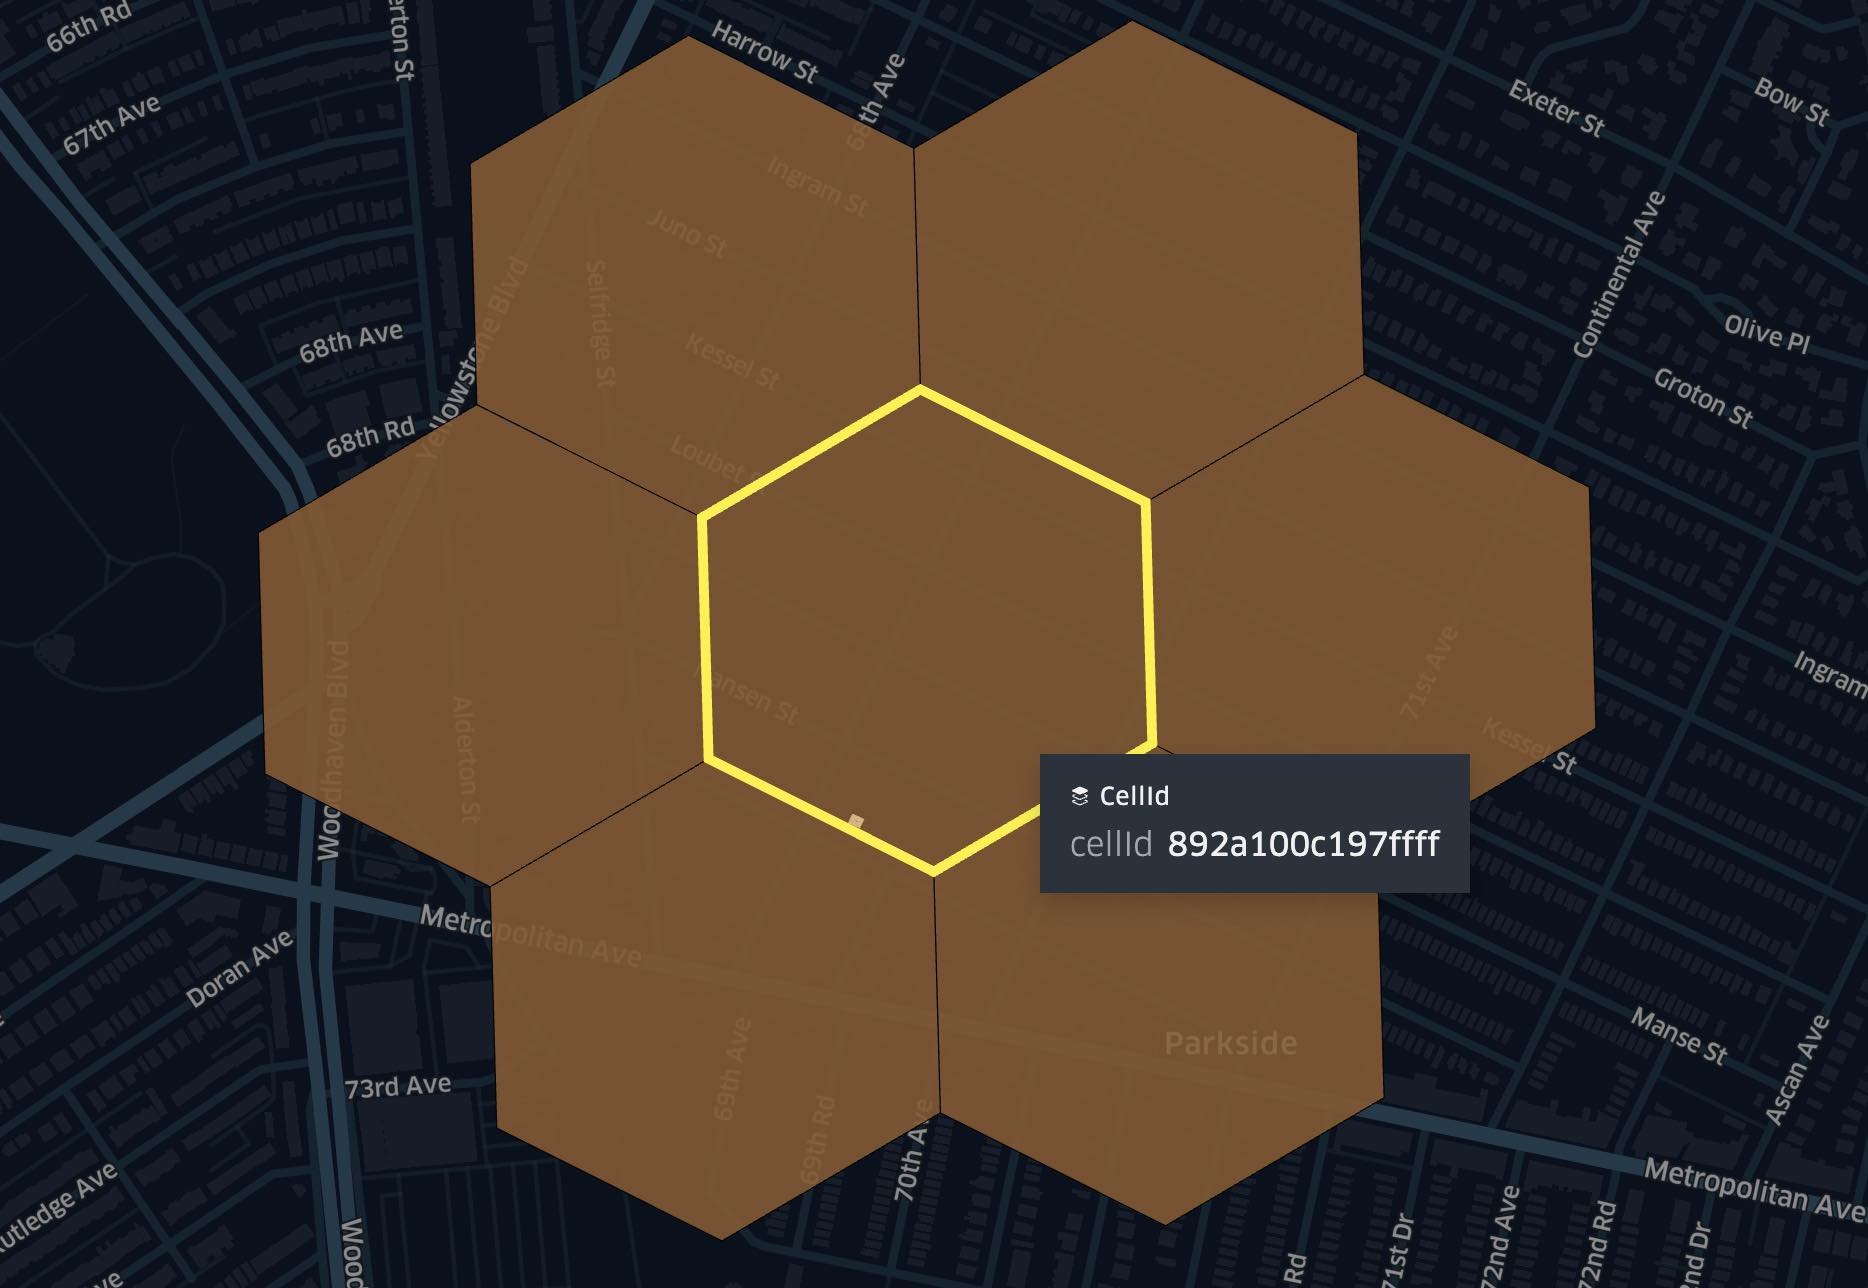

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB0ygAwAEAAAAAQAABQikBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIBQgHTAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAcHBwcHBwsHBwsQCwsLEBYQEBAQFhsWFhYWFhshGxsbGxsbISEhISEhISEnJycnJycuLi4uLjQ0NDQ0NDQ0NDT/2wBDAQgICA0MDRcMDBc2JR4lNjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2Njb/3QAEAHX/2gAMAwEAAhEDEQA/APBzsj46momct7CmUVuZhRRT1Qt7CgBlSLGT14p/yR/WgbpBnOBQIMonA5NNDb2w3SlWIn73FMddjY/KgZL5Iz14qQKB04oRty5pSwXqaAFppx071E8jdhioQSDmgB2GVvl7Vopo2qzRG4S2kZMZ3bT0rofCElp/aXk3Mau0i/u2YZww54+orcs73xFJ4gNvKC0EblXAXCBexz/9epbGkef6bplzqd0LS3HzHkk9APU16LaaZA2lXOgG7juJRl0VeqsP/r1S0+5tLbxbcxxECKfKAjpuOD/MGse2t73SfEKRRxs7pJjgfeRu/wCVS3cZzQtwpIfOQcEemKmAAGBwK3fFdstlqTTQ4KXA8wYPQ9D+tcmzs/U1onoQ1qWmmRenJ9qrtM7dOB7VFUqxMevFAWIqesbN2qwsar2p9AyJYlHXmoXXaxFW6ilGVz6UASwtuQe3FQTrhg3rRA2GK+tTzLuQ+3NMnZjIzlB7cU+qiuUBA70GRz3pFFosB1NQtIA2V57VBRQBKZm7YoErAHPJ7VFRQApJY5NJRRQAUUUUAFFFSRjLDIyKAI6KsNFlvl4FAhHc0AV6UAnpzVoRoO1PoAplGAyRxUqRqygnNSuMoajhPyke9ACSIoXKipgcgH1pHGUNJGcoKAK8n3zTKfIxZue3FMoA6Dw5fmwvWbymmWRGRkQZJB9Pyrf0aG4toLi3udNmuIpWVlUjA+XOM5xXGWN9Pp9wt1bHEi5wevUYrfPiXW3w/wBqI74Crj+VQ0O4zxMdTlmjnv4Ps6Y2xJwQFH0+tcvXaa9cxanpdrqBJ+0ZKSAZ259fTPHauLpxBl4EHkUU1BhR9KdVCKRGCR6UlOb7x+tNoAKKKKACiiigAooooAKKKKACiiigCWH7x+lWaqx/fFWqAGOpZcA4qpV1skEDrVKgCeA/P+FTzf6s1Wh/1gq3JyjfSmS9zPqWMfxGo+vFTP8AKm0UhsiY7jmrES4XPrUCLubFW6BhUcjbRgdTTycAn0qozFutADa19OhwDMe/A/rWXGhkcIvUmulRAiBF6AYqooib6Dqq3c6woAercVarnrqbzpiw6DgfSm2TFXLAYMMqc0x4kb2NUgSDkHFWEnPR+fepLt2I3idfcVGST1Oa0FZWGVOaY0SP1GDQF+5TLsRtJqVfkTcaDAwPqKbKedvpSGPjZcYzz3zU1UakSTbweRQMtUxkVuooEinjPNPoAgeMKNy5FNEhHXmrNJtGc45oAh2o/Tg1GyMPepmiB5HFNy6feGR60CIKKn+R/rTDGw6c0DGBiOlSiQHhhUNFAFosAuQc0iMqp15qtRQBeBB5FFUwxXoamWUH73FAE1RtEp6cVICDyKKAKjIy9RTKvU0qpGCKAK8ed3FT+eA2GH401CIwSKrk5OaBWuaAYMMqc0x4kb2NUgSDkHFWEnI4fn3pit2I3hdfcVFWirKwypzTWiR+owfWgL9ymi72C1f4A9hUUcWwk5zSTthdo70A9Sq7b2LU2ipY0DZJ6UigERK7h+VRkEHBq7UMxGNvrQBXqcfInuajQZanSHJx6UCIqKUdamwj9ODQMgoqRo2HTmo6ACiiigB6yMvHarGcgH1qsgywFTsxU5xkUCJaKi81aVZVPXigYOinnoahaNl9xVnqcelNc4GB1PAoAqUVa8pcY/WqxABwOaAEqZZ2Xg8ioaKAL6yK/Q8+lKyK33hWfUyTMvB5FMm3Yc8BHK81AQQcHiryyo/Q4PpTmVWGGGaAv3M6irLwHqnPtVcgg4IxSKuPErYxUkW3HXk1XooAvVDMRgDvTFlYdeaYzFjk0ANq/GuxAO/eq0K7nz2FWnbapamS+xWnfLbR2qClJycmgAkZHakUhKKKKAClJJ5NJRQAU4MV6Gm0UAPZi5Aq0BgAelVoyobLVM7gLkHrQAyXBxjqaaYmAyOaIly2fSpnbauaAKlFSxqGJz0FK0RHK8igCIEjkVMk7DhuagooCxoK6v0NDIr9RWfU6zsvDcimTbsDwMOV5qHpwavLIr9Dz6UrIr/eFAX7mfRVh4COV5qAgg4PFIq44uxG0mpoyu0AdarUUAWpcbOabCvG71qEsxGCc1ZV0IwDigBsu3byOe1Vqnmxx61BQA4MV6GhmLHJp6R7gSfwpGjZfcUANDFehoZixyabRQAVeiXag9TzVWJdzgdhV1iFBJ7UyZFadskKO1V6UkkknvSUikSiMsoYGoquKMKBUUqqBwOTQBBT0ba2aZRQBdJAGTVWQqzZFNyT1pKAJPMYAAdqYST1OaSigAooq4oXAIGKAKwjc9qkEJ7mp6KAKbDDEVZQ5QU1485b2qvk4xQA6TG84qxGMKOc1UpwYgEA8GgCSSTPyr0qGiigB6LvYCr/AABnsKiij2DJ6mmzvhdo6mmS9WVmbcxY96bRVlYlwMjmkUNSRQMHipwQeRVdoT/CaaqyAnbwaAJ3cJj3qCR92MdKcZCQVYc0wIxXcKABF3NinNERyvNLGypkNwasAg8igCorsvH6UO+8+mKsSY2kkVUoAKUDJwKSp4Ey249qALSLtUL6VXeYhzjoKmkbYpPftVCmSkXkmRvY08gMMEZrOqRZXToePSkHKTNBjlDimeY6HDipkmVuDwalIDDB5phfuQh1YZBqqx3MTVh4B1Q49qrsrKcMMUh3G0UUUDCiiigAqxCTtIqvUkbYb60AWqryqd2QCc1MWUdTTPNX3oA//9DwN02YI6VHV0gMMGqZGDitzMmConJ5pjSE9OKjqzEF25A5oAgUAtgnrVpVCjAqvIu1vY1OjArk/jQA+opQCufSkMv9wZrX0LSDq903nPshiG6RvQUmwMNCwOF4zWvcaJqVrKFeIsfL8wlfmG31yOKvarLpMpSDSLZtsJ+aQ5O8e/f8a6yLUG1zRZ7XT91vPbqMIDksgHTPXmpbKsV5dP0vVdPtNXmIt4IY9swQYyR2GPf+dZ13pOjahpkt9oodXtvvo2ckevOe3NL4YljuUudDuDhLlCUz2Ydf8fwqroN4NJ1d7S8IVJMxSg9AR0NIDBgka2kjng4aNgy/Uc16Dr2q38dpZ6tp0u2GT764BG7tn9RXneoiKG7litZA8IY7GHcdqY2pXjWa2BkPkKchO2apq+pK0Oq1PUdG1O0F6wa2v16hBwxHfP8AXrVB/F+sPB5G9Qcbd4X5sfX/AOtXO8smD1FOWJRyeaOUdyItJKckljTxD/eP5VPRVCEChegpaCcDJphdQM5oAfTSyg4JxUQLliV6H1pSFHLnJoAGfcMJn607BJy549BUZl7KKiJJ60CJy8aH5KtcEfWs2rsLZTHpQJoqOu1ivpTasXC8hvXiq9A0FFFFAwoopyqWOBQA2insu1tp/OpRCO5zQBEi7zjOKmESD3oKhWUgcVLQA0Ko6ClPT6UtN3L6igB1FRmVR05oMihc9/SgCSiqpkY98fSo6ALoIPTmoYuGZahyQMA0lAF0lRwSKjiPyc9qrUUAOfG44OabRRQBbsIFubyG3c7VkdVJ9MnFdzd3PhnS7h7MWBmaI4LMeCfxP9K4GKOQuuARk9a9CuToWgOtpLaG8udoZ2fpk/XP8qiW40TNr2mnRnkisoQI5QogYjnI+8BivNp5FllaRF2BiSFHQZ7V3F3HpWs6Xc3lnbfZZ7XBYDoVP04rgqcQZcQ5UfSnVFD90/WpaoRVk++ajqWUfN+FRUAFFFFABRRRQAUUUUAFFFFABRRSgZIHrQAqnDA1P5y+9Hkr6mlESD3oAYZvQVBVsIg7VXcYYigAj4dfrV8jII9azlOGB960aZMiqECnOahdtzZpDwcUqruYCkUTxLgbj3qWiigCKVsLj1qtTmYt1pUQyOEXqTigDT06HrMfoP61qU2NBGgRegGKdVoxbuynezeVCQPvPwP61g1au5vOmJH3V4FVals0irIci7mAqZof7pqEEryKlWb+8KRREQyH0NTJORw3NNkcEALUajJxQJovhgwyKa0av1HPrVaRsYA4pUnYcNzTFYR4WXkcirel6fJqd9HZpxvPJ9B3P4UiurdDXfeF7aGxs5NXu3WHzj5cbN2Hr+J/lUyY46nBapYjTr2SzEgkMZwSKph3QYNdrJ4Rv5NQjcus8Er5aVT2PJJFVvEkS3mpNa6Xb5FsoVzGuSSOucenSkpFWOXWUHg8GpaqOjxttcFSPWlEjjvmqEWqKiSQNweDUuRQBGUXcCBzQxwKd700Dc/sv86BDNyPweDTWjP8PNPeMklgai3OhxQA3GOtJU+9G4ammPutAEVFKQRwaSgY4MV6GplmH8QqvRQBc3KSMGhjxj1qnU6cLuNACSHooqGlJyc0lABRRRQAoJByOKsRzMSFIzVarUCcFz+FAmWajeNX6/nTZn2rgdTUKTsOG5pkpA0DLyvIqNXZOKuq6v0NDIr9RQO/cg81cZ7+lVycnJqZ4GHK81Eqktg0irkq/Im41BUsp/hFMUgMCe1AkWUUBcH8aY0Q/h4qRWVuhpJG2r7mgZAJGXg80/5H+tQUUASNGR05qOpFdh7in5R+vWgRD06VIsh/i5oaMjpzUVAyfaj8rxUbIy0ypVkI680CHRuoG08Uu5TJkngdKTCP061GyMPegZPI2F479KhjXc3sKjqaN1UYPBoAdKFxnvUIUtnAzinSNubjoKnjXavuaAKlFXGVWHzfnUtpplzfHNuB5fd26fh61MpKKuxxi27Izu+B1PStiLTNUMJm8rjsjHDEeuP6HmunsdItLLD7fMlH8bdfwHatWuKpjHf3DshhVb3zzoSDcUcFHHVW4IpxUMMMM13F1Y2t4u24QMR0PQj6HrXNXOiXdvl7RvOT+63DD+h/StaeLjLSWhjUwso6x1MR4O6H8KrlSpwRirokAYo4KOOqtwRTyAwwRmuo5rtbmdRVpoO6H8Kjjibfhh0oHcsRJtT3NQztk7R2qyzBVLHtWeSScnvTEu4lW0XauKroAWG7pVsnAyaRRXlwCMDmmMjL1FOTLybj9as0AUaKfje/HFK0bL7igCOiiigAooooAtRY28fjUUrZbHpUYJHIpKALaLtXFI8gXjvTFlAGGpigu/P1NAEqINnIznmmPHtG4dKsE4GTVYsZCFx3oAioq4VUjBFV5ECdD1oAjqZJmXg8ioiCDg0lAF9ZUfocH0pzKrDDDNZ1SpM6+4pk27EjwEcpz7VXIIOCMVdSVG9jTyoYYYZoC/czqKstB3Q/garlSpwRikO4ZJ60AEnApKUEg5FAy4AAMChjtBNIhJUE1DK2TtHagCInJyaSinIu5gtAFqBcLnuabcNwEH1NWOAPYVns25i3rTJW42iipTEw6c0iiRZQeG4qKRtzewqOigAooooAKKKcoBYA96AFEbntStGyjJxVqo5G2jHrQBVpyttOabRQBephkUd8/SquSRgmkoAmaUn7vFQ0UoBPQZoASiphA568VKLdR945oFcqVZiiP32/AVOI0XoKGYIMmmJsHYIuTVAkscnvT3kLnJ6VHSGkOU4IPXFWVdW6VUooGXqKgjdidp5p0rYXHrQBC77z7CnxMxO3tUNTRFRkHqaACVWzu7VECR0OKu1VkILHFADCSxyaSiigArQRdigVVgXc2T0FWnbYpNMl9irM25sDoKhoopFBUsS5JJ7UxV3MBVpVC8CgCNou6/lUYd4zj9DVqoZiMAetAEiTq3DcGpiARzyKzaersnQ0EuJYeAHlOKrMjL94VaSdTw3FTcEetMLtGcAT0qQQue2PrV2ml0XqaA5iEW4/iP5VKsaL0FRm4UfdGaiMznpxQFmSTqMAjrUHlue1TxElcnnmpKQ0f//R8Il3bcjp3qtV6qjrtOO1bmYypI22tz0NR0UATSOrDA5NJDG80qwpyzkAD3PFRVZtWkimSdBzGwYfUHNDA7a6ttH0GAWLwfbL2RPm9Fz6f071X8LN5F5Ppt2piF5GUG4YOe3X2JrotUvI7W1HiDT4hJLchV8xhkRjH8+1Z8l1LrPhyW/ugFuLR8pKBjOCOn51mUNu9Zk0G8GmWNuqQw4Dbh80mepz71Drco0DXItQs1CiZN7R9Ac8Ee2f51WXxgrxo15Zxz3EQwsh/njB/nXK6hqFzqdy11ctlm/ID0FNILnQ6hr9gzrPpdoIJxJ5hkPXPsOmDXM3V3PeTtcztukc5J6fyqFUZulTrGF56mqSFchWNm56Cp1QL9afRTENI70o9KCcAmmKSy5Uc0CJKieQdF5PtSFS3Ln8KTei8KKAACQjk4o+RPc1GXY0ygCQyE9OKZSUUDCiiigAqaBsPj1qGlBwcjtQBekXchFUK0gcgEd6oSLtcimTEaAT0GaSrURyuPSo2+STP40ih6RgcnmnqoUYFOpCQOScUAQzDo34VIjAqCfpRJgoefpVSgC4wypFMaVcfL1quST1OaSgBxZm6mm0U9Y3boKAGUVZFuf4jTxAg65NArlOl69KvCNB0UU/AHSgXMUBG56A08QOeuBVsso6kCmGWMd6YXZELf1aniBB1yaQ3C9gTTDcN2FAak4jQdAKeAB0qkZpD3xTC7HqTQFi+SB3wa7J7/w5rAS41PzYrkKFbZnDY+gNeejg5rs7XxZdW1tHBBbwjy1C7mBycd+CKiRUdC1e3llb6bNY6HaylZv9ZK6noPr/APWrgj1r0/SNY1DXftVlc7VRoSQ6DG09P1rzJxhyKIjZLCeCKmqCHvU9UIrzDkGoanm7VBQAUUUUAFFFFABRRRQAUUUUAFKDg59KSigC9RVbzm9qcDMRkf0oAnqrJ980/ZKeScVEwIPzdaAG1pDkZrNrQQ5QfSmTIpOMO31p0RwSMZpJeJDToiozng0iixUcpIXipKrzAAg+tAENaunQ8mY/Qf1rMRS7BF6k4rpY0ESLGvQCmkRNj6q3k3lQnH3m4FWqwLybzZjj7q8CqbJirsqUUUVBqWkC7cDn1prRLjI4qvU8QnuHFvCpd26Af4/40m0tWNK+xBWhY2NzeN+4Q7ScFzwo/Hv9BW7Y+HkXEl+Q7f3FPy/j6/yrplRUUIgCgdAOBXHVxaWkDqp4ZvWZwd7o17akuB5yf3kHI+q9f51kAg9K9VrLvdIs73LsuyQ/xpwfx7Gop4x7TKnhesDgFIDAnpXTaxrsV/b2tpbRmKGBeUznnp+grNvNGvbTLAedGP4k6/ivX8s1kg55FdsZRnrFnJKLjoz0nRZZdH0CfU5GbMx2woScZ6A49z+gqtb6RqenlZY7+O3u5xu8pjgt3wc/4Vxgv7ry44WkLRxtuVScgH6V2bX2g67dwXF6ZIJ/lVwCNhx7npSaAm8R20lzp9lJdxKmoSvsIUct1HP6fnWFfeFNStpGW3QzqgBZlGADjOOev4V1sM8V9q1xrEv/AB56apWP0LDqR/n0rlhqusalfgQzurXDbFQH5QD7ew70K4M5RlZThhginRgls16TqkHhmCWHT7xmDQoFJjHQ+rGuXXQL+4Dz6fbu9vk7GbALL2OKpSE0YjHaCacgAXg59aZcpJE5ilUoy9QRgg1XBIORVEou0hAIwahWXs351MCCMigZC0XdfyqPLIcdKt0hAIwaAIQ6twwprRjGVNPaIH7vFQkMvB4oAbRRRQAoGTipZDgBRRGOrGomOTmgQlFFFAwooooAVQWIA71ogBQAO1VoF6ufwqSZtqY7mmS+xWkbe5PbtUdFOQhWyaRQrIy8/rT1nZeDyKmVlboagl2g4A5oAtLIr9Dz6U4gHrWeBkgCrJlKYHWmS0I8DZJU5quQQcHiryyo/Q4PpTmVWGGGaAv3M6nFi3U5qd4D1Tn2quQQcEYpFXEoopynBB64oAsou1cH8aiEYfJHAzxTy4ZcL1PFSAADAoAg/eR9eRS7kfrwanJwMmqYG9sDjNADzGR05qPp1qTEkf0p25H4agRBUiyEdeaVoz/DzUZBHWgZNhH6daY0bD3qOpUdyQoBYnoByTQFiKrtsst1IIoULv3x0HuT2rYs9BknIkvf3S/3QfmP1PQfzrqYLeG1iEMChEHQCuSriktI6nTTwzesjFstDRCst4fMb/nn/CPr6/yroAAAABgCilrgnOUneR3RgoqyEoopagoSiiigCpdWNreLtuEDEdD0I+h61zVzod3b5ezbzk/unhh/Q/pXYUVrTrShszOdKM90eciUBikgKOOobgipK7e6sbW9XbcIGx0PQj6HrXP3Wi3MGWtj5yehwHH9D+ld1PFxlpLQ4KmFlHWOpiSoXXANU2VlOGFWxLhjHKCjDqDwRUvBHqK6tzn1WjM2nbjjbnirLQKeV4quyMn3hQNMljZAMZ5NLIwC8d6rUUDLMS4G496JWwNo70CVMentUWd8nPSgB6xAqCepolVQMjg1PVZyXfA+lAEVFW/LXjjpVd8biFoAZRRRQAUoJU5FJRQBPI4ZcDvSwgcnvVelBI5FAFmR9o46mo0y7gntUZYscmp4tu3g896AJCARg1WZBv2rUkrkfKDREMkuaAICCDg0lXSARg1W2bmIToKAI6kWV19xTSpXqKbQBdWZG4PBqQgMMEZrOqRZGToePSgnlJmgHVD+FV2VlOGGKtpMrcHg1KQCMHkUwuZwJByKSrbwA8pxVZkZfvCkNMbVqBeC571WALEAd60AAoAHagUiKdsLtHeqdSSNvcntTBycUDSJ4l4ye9SkgAk0DAAAqKZuAtAyvRRRQAUU5QNwB9amaIH7vFAFeinFSvUU2gBSSepzSUVKkTPz0FAEVFXBAg681KFVegxQTzFIRO3b86lFv/eP5VYLKvU4qIzoOnNMLscIYx2z9ak4HSqhnc9OKiLM3U5oCzLpkRepqI3A/hFVaKQ7Epmc98fSoySevNJRQMKKKKACiiigApSSevNJUkS5bPpQA1V3MBVrauc45pr4QbgOTxSCVT14oAcx2rknNVKmlYEgDtUNABRRU0Kbnz2FAFmNdigd+9V53y20dqsu21S1UDzyaZK7iUUVLFjfSKJIlwMnqaloooAQnAz6VDI6suB3p8uSvH41VoAKKKei7zjtQAynBmHQkVI0RH3eaiII4NAClmPUmm0UoBPTmgBKKcVK4yMZptAE0JAOPWrFVEIVgTVugD//0vDaY4BX5uKHkC8dTVYsznmtzMbTlUscKM1MkBPL8e1WQoUYAxQJshSADluTUxIUZPAqJ5lXheTVVmZjljTFa50el+I59MV7cIs9u/WN+mfao9V8Q3OpRLbIiwW68iNOB+NYAUt0FTLEBy3NTZFXIVVm6Cp1iA5PNS0UwCimllBwTimlwQQvJoAkqByzNhDkCgJgfMeKQyAcKKBDiM8uf8KTztvCCoSSetJQFhSxPWkoooGFFFFABRRUvlHGTQBFTtjY3Y4qeIKRkDmpSMjBoAhjRCN3WoWG1iKliJVihpJhyGoAmgbK7fSm3C9G/CooW2uPfirbruQimTsypE2GwehpZWVsYOSKhopFE3nHAAFREk8mgAngDNSrA568UAQ0VbWBR945qYKq9BignmKSxO3bH1qZbcfxH8qnZ1XqcVC1wo+6M0wuyVY0XoKcSB1OKpNM574+lRkk9aAsW2nQdOajNw3YCq9FIdiUzSHvimFmPUmm08Rue1AxlFWREvenBEHagCpRVsRp1xTgAOgxQBTAJ6DNPWNj14FWqKAK7xhVyO1dTpviC3s7VLdbCKWRc5kbGTz9P61zcgyhq9Z6XcTWE2pqyrHCcHPUk+n6UnbqHobd74r1CS3aGGOO3Vhg7Bzg1xhOTmun0nRZNY8wmQQwRDLu38u1Ra14fbS4o7qGVbi3l4V19fzNLRBruzChPJFWKrRDL/SrNUBFN90fWq1WpR8hqrQAUUUUAFFFFABRRRQAUUUUAFFFFABVxDlR9Kp1bj+4KAH1Wlzu6VZqvNnI9KAIavRHMYqjV2A/u/xoFIgn/wBZ+FEaBgSadcfeB9qbG7ZC9qAQ7a6fdOR6VE7ljzxirDttXNVlUuwVepOKBmlp0OWMzduBWtTIoxFGsY7Cn1aRi3dla7m8mEkfebgVz1XL2bzZiB91OB/WqdS2aRVkFHcDuelaNlpV3fEFF2Rn/lo3T8B3rsrLS7Wx+ZAXkxje3X6D0Fc1XExhotWdNOhKWvQ5uw0GefbLdHyo+uzHzn6+n86623tbe0j8u3QIPbqfqe9WKK86pVlPc7oUow2CiiiszQWikooAKy7zSLO9y7LskP8AGnB/Hsa1KKcZNO6E4pqzOBvNGvbTLAedGP4kHP4r1/LNZIPcV6pWZe6RZ3uXZdkh/jTg/j2NdlPFvaZyVML1gcUl/dx2z2ayMIZDlkzwTW74av7HT5Zby7YmVIz5S4zz/nisy80W9tMsB50Y/iQc/ivX8s1kg55FdkZRkrxZySi4vU6LTUOsavHHMcmaQtIfUdTWxr+sXbam1vZSNFHbERoqHGWH0/KuPsruaxuY7qA4eM5FdnH4g0CScalc2TC7HPyn5S3ryf6U2hI0dZsUv9U0u1uB+/kj/fkcHAGf6GuNm0iSbUp7LTFaYRFgPXC8fSuo0C7n1TV7vV5Blo4jsUdieFArU0wwaXO9lGQ8yI093IPUDhR+dK9h7nlckbxOY5AVZTgg9qYCRyK7eOxtbXTptW1hN813nyY84OTzu/z2+tccsMkswijU7nOAB3Jq0xCLKR97mpwwboa6dvBOoiLcskRlxkx7uf5Yrkri3ntJmhnUxupwQeDQmFieggHg1XWUj73NTBlboaYhojTnjrUDqFbaKtE7Vz6VTJycmgCZztUKKgoooAKKKKACtOx0jUNSBNnC0gXqRwPzNZoGTivTYLW9udF06HSZDHGzfv2Q4IOeScenP6VLY0jiZrS4snEF1E0TAdGHX6etZkrbn9hxXfCMa/rztOGNnaqVJbI+VRjr6k81wdz5Xnv5PCbjt+meKadxctiCiiimAUpJPJpKUDJwKAJYx1Y1Exyc1M52qFFQUAFSpM6+4qKigC8kqN7GnlQwwwzWdUiyunuPegnlJWg7ofwNVypU4IxVxZkbg8GpCAwwRmmF+5nVKspHDc1K0HdD+FV2VlOGGKQ7kkkgZcL360sK/wAR/CoKkWQrx1FAySZuNvrTEj3Ak/hTCS7fWrYAAwKAINsidORRvRh8/FXYIJ7p9lshcjqeij6mulsdDt7dvOuD50nuPlH0H9axq14w9TWnRlPY5yz0i5vsOn7uL++w6/7o7119lplpYgGJAZMcueWP+H0FaFFedVrynvsd1OjGAUUUVibBRRRQAUUUUAFLSUZoAKKKKAFFBpabQIqXVja3i7bhAxHQ9CPoetczdaFdW+Xs281P7p4b/A/pXY0VrTrShsyJ0oz3PNxLtYxyqUYdQRjH4VNwR6iu3urG1vF23CBsdD0I+h61yt1od5a5e0PnJ6dG/Loa7qeLjLSWhw1MLJaxMx4FPK8GqzRsnUVaWXqJBtYdQeo+oqUEEcciuo5rtbmbRV14VbkcGqzRsnUcetA0xA7AYzUkK/xH8Kgp6uy9KBliRtq+5qKFed3pUZYtjNWlACgCgBkirgsetQohf6U+VsttHaplXaoFAFZo2XntTKmmbnb6U0xsBnFAEdFFFABRRRQApJPJq0hXaAp6VUooAlkbLcdqliXC59arDGeatB0I4NADiR0NQJGGBPT0pjEu31q0AAMCgCs0bL7io6svIACB1psaAjLUAQU9ZGToamMSnpxULRlee1AFlJ1PDcGpuCPUVm09HdT8p/CglxLgiRW3Cklbahx34qQe9HB96YjNoq40CnleDVZo2TqOPWkUmIGZehpCSxyaSigYU9BuYCmVJGwU5IoAs4Gc96WkBBGRSMdqk0AQStlsDoKioqWJN7c9BQBJFECNzfgKsEhRk8CgkKMnoKou5c5NMncma4/uj86iMrt1NR0Uh2CinBWboKkEJ7nFAyGipJFVcAGo6ACinqhfpT/JOOvNAENFOZWXqKbQAU7Y2AcdaVF3Ng1boAo0VbdQw6ZNVKACpI87xSIhfPtSjdEeRQBO6b++MVXZGXrU6yKfanN90/SgCnRRRQAVeiXanuearRLuf2HNXGYKpY9qZMitO2TtHaq9KSScnvSUikFWIVwN3rVero6DjFAC0UVFI5XAHWgCNpGIKkYqKnMxY5NNoAKsxfdqtSgkHIoAu0hAPUZqFZv7wpUfLEk4FABIihSQOabCeStPkYbcA5zUCnawNAFpgpHzdBVOpmlzwB+dQ0AFW4zlBVSrERAXk45oA//T8ESJn56D1q0kap06+tOJCjJ4qs85PCce9dBjqyd5FTr19KqvKz8dB6VH1pVUscCkNIbTlHI3dDSoQrfNVl13LigYoAAwKWo0cYwx56U4sOg5NADqYX/u80088uePSmGQDhRQIcRnlzTTIBwoqIknrSUAKST1pKKKBhRRRQAUU9UZulWSoIAI6UAVVVm6CphCMc9aIztYoamoApEYODVpG3LmopVwd3rTUfZnNAEg+STHY1IXUdTVd339sYqOgCRnBbcvBphJPU5pKkWN26DigBnStBTuUN61EsCj73NTAADApkNlYwEsTnAqRYEHXmnswQbjVdrg/wAIxQGrLQAHQYpjSIvU1TZ3bqaZQPlLTXH90fnULSu3U/lTQrN0FARm6CkOw2iphCe5qQRoO2frQMrqpY4FTCEdzU1FAERiQ+1OEaDtTsjOO9LQAAAcCikJA6nFMMiDvmgCSgnAyarPJkgrxinxksGDGgCQMNu7tTRIpOOn1qtk4xnikoAuBlJwDmkd9g+tVKKAJDKxGK7fw95Oo6PdaKZFjldg6Fu/T/CuFrofD+kxalJK9zKYYYE3uR1xUyGjpNSjTQfD50wyK1zcvl9vp3/DAArIe+tv+EVWxMgM4l3bO4HNXtvg2I7jJPMR35/wFP8AFTaMpwsLC4kjVkccKF9xn09qkZwkQJOQcVPt9ST+NV48lhirVaEkboNp9feqtXG+6fpVOgAooooAKKKKACiiigAooooAKKKKACrMP3T9arVPD3oAnqCbtU9RSnC4x1oArVbt/un61Uqzbn7woE9h0yM2CvOKq9OtaNNZFb7wpiTKJZiME5rR06HcxmPReB9aqm3YnCc57VuwxiGNYx2oSFJ6ElV7qbyYSw+8eBUryKmAckscAAZJPsBU6aNJeOJbwmOMDiMfe59T2+gqataMFqOlSlN6I5i2tp7yTyrZd7Dk9gPqa6yx0CCHEl5iZ/7v8IP07/jW5FDFAgjhQIo7AYqWvMq4mUtFoj06eHjHViABQABgCnUlFcx0BQKKOlABRRRQAUUUUAFFFFABS0lGaAFrIvdFs7zLgeVIf4k/qOhrWpaqMnF3QpRTVmee3mkXtnlivmRj+JP6jqKzAQeleq1kXui2d3lwPKkP8S/1HQ12U8Z0mclTC9YHI2Gp3umuXs5Chbg46H610HhzV9PtGuTqW8tOB8w5zjJIPfmsK80i9s8sV8yMfxJ/UdRWYCDyK7IyjJXizklFxdmbupas+qXjTynaB8sa9lX0FMsrr7HeQ3eN3lOGx6461i11+lX2jXFiNM1VPK2sWSZByCfWm9ETbW5p6/bySFfEukzEo+NxB5Ujj8vUVJpWmDXydX1GTzyAVaIDbyB8ozxUdxd6XpukS6Vps5u5LpuvYZwKTXJP7J0+10O2ba+PMmZeDn/9f8qko4m9t5La5eKWMxMD909RVSr86yXDmWRy7nqW5JqkyMv3hWiJuKXYrtNMoooAKdsbG7HFOjDbgRVjdjhuP5UAU6KttGrdqrEANigDR0i6t7O/jnuo/NjU8r9ePxrr7qO50b/ibaBLuspuWXqFPoR6fqKzrF/CptI0vEm84D5nXpn2wf6Vu6ZeeHLEukF5J5MvDxSqSp/Ss2UjmtR8V6jfW7Wh2Rq33ygI3fqeK5ard81u13KbVdsRY7AfTPFVKtIkKKKKYBU0KFst6VDVgkxpgdaBMifJbmmVMJFbhhQYweVNAENFKQR1pKBhRRRQAVIsjp0PHpUdFAF1Zlbg8GpSARg8is2nrIydDQTylh4AeU4qsyMv3hVlbhMfP8ta9ppVzeje37mI92HzH6A/zP5VM5xiryZUIyk7JHPojyOI4wWZuAB1rqLDQXI3agcDtGp/9CI/oa6C1sLWyXbboFJ6t1J+pq1Xn1cU5aR0O+nhktZDI444kEcShVHAAqSkorkOoWkoooAKKKKACiiigAooooAKKKKAClFJ1p1AhDSUUUDClopKACiiigCld6faXoxOgLdmHDD8a5e60K8tiXtD5yenRvy6Gu1orWnWlDZmU6MZ7nmqz4JSQFWHX1H1FTghhkc1213p9pejE6At2YcMPxrlrvQry2JktT5yenRh+HQ1308VGWktDiqYWS1iZzwq3I4NVmidPcVMs5BKSAgjr2I+oqcMGGVOa6dzm1RnUuSOAautEjex9qrPE6+4oGmNQgNlqsGRQDz0qpRQMkQb2yfqassdoJqCN1UYP50kjhsAdKAGqC7c/jUpjUJz1HenRLhc+tNmbjb60AV6KnSIFct3pjpsP1oAjopQCeBSUAFFFFACglTkVN53y9OagooAKnSQAbW/OkhGWz6Usq9wPqaAJwQeRVeZsnb6VGGK9DSE5OTQAlTwLltx7VBWgi7FAoE2JI2xCe/aqSuynKmpJn3NgdBUNAJFpJweH4qwCCMjkVm05WZTlTigTiW3hVuRwarPG6dRx61Mk/Zx+NTghhkHNMLtGdRV1oUb2NV2idfce1IaZGCQcintIWABqOpo7eaVGkjQsqfeIGcfWgZDV+JdiAdz1qrEhZ+e1XGYKpY9qCZditO+TsHbrVelJJOT3oAycCgpBgnpSoQGBNWI1Kg5pkoUYx1NAEqsG5FKSAM+lU8npS7mxtzxQArkM2RTKKKAJoT8xHtViqQJHIoJJ5NAFwgHrzVeUAMMDHFWAcgH1qKYcA0AV6txnK9cmqlKCQcigC6cY5qmxBJIGBSl2YYNMoAnhJ5HaklDE9OBRETuwOlWKAKNLk4xnirMigqTjmqtABRRUka73A7d6ALMK7Uz3NSMocYNBIUEntVVZ2B55FMjcHgYcryKhq8siv0PPpSsiv1FA79ynGoZuatVA8DDleRTFd1OP0NIotVDMFxnua25NB1VbFL5Yt8ci7vl5IHuOvvXPMGHyt2pJgNooqSNdzewpgNKsOoptXqhkjUAsOKAK9FFFABRRRQAUUUUAFOC5GcgfWkHXmpxCvcmgD//1PAWLE/N1pUQueK07+2z+/Qf7w/rWWrbWBroaMk7kkkYUAinRMMbal4YexqqQUb6Uhj5Ux8w/GnxNkbT1FMeXIwB1qGgCWQqWyvWkEhVcAVHS0ABJPWkoooAKKKKACip4iASD1qTYudxFAFSrESqRuxzTJVwdw70RNhsetADx8kmOxqao5VyufSo/OOMAc+tADpRjDjqKQzcfKKhJLHJ5oxigBxdmGDTKcqs33Rmp1t+7n8qBXK+M9KmWBj97irSqq/dGKa0iL1NMV+wixIvbJ96eWCjJOKrNOx4XioCSTk80BYstcD+EZpiSsXBY8dKgpcEdaQ7Ggy7lK+tZ1aCNuUGqky7XPvzTEhqxswyOlTIigEEZIpsJ6r+NSEhWyehpFD6KQkDqcUzzUoAkoqqJGzknNIZHPfH0oAtEgdTiommA+7zVeigB5did3cUeY2QSaZRQBLIwbGO1RU4Kx6CniI9zQBFRU+I1680nmAdBQIYEY9qcIj3NIZG7cU0sx6mgCXYg6mjMY6VBRQBN5o7Cpor2eAOsLFBINr4PUehqnRQM0sDGKpSySSH94xbHHNXRyAaoScO31oJiIhIYY9auVTXdu+XrVygoKo1eqkRgkelACUUUUAFFFFABRRRQAUUUUAFFFFABU0J5IqGpYfvH6UAWajlOF+tSU1zhSTzQBTqe3+8R7VBU0B/eUCZPN/q/pUCzOvXkVZlGYzUVpZXN8222XIBwWPCj6n/AApSkoq7CEW9EXrRkbMzfKq9zWvBa3d0QUXyo/779T/ur1/E8VfsdFt7ZFM+JnXkZHyg+w/qea2q4quM6QOunhFvMpWtjb2YJiBLt952OWP+farNOJorhbbd2dqSWiG0UuKSkUFFFFABRRRQAUUtFACUUUUAFFFFABRRRQAUUUUALRSUUAFZF5otneZcDypD/En9R0Na9LVRk4u6FKKejPPbzSL2yyzL5kY/jTn8x1FZgOeRXqtZF7otneZcDypD/En9R0NdlPGdJnJUwvWBwiO0bh1OCpyK3NU11tVjiM0KLPHwZB1Ye9VLzSLyzyzL5kY/iTn8x1FZddkZRlqjklFx0ZcSdTw3FTcEeorNqwhMaZqzNoe0CnleKrsjJ1FWFnB4bip+CPUUwu0UVkK8dRU6urdKVoFPK8GqzRsnUfjSGmTt8gyOK7uw0vQzosd7NC9yRnzWjJ3IfdcjgV54WJ6nOK2dF1S60u486H5kPDoejD0qZIpM66y0jwxqgf7FJNGYxubPAA/EGuf1rT9ItIEksbw3LMcbeDgepxXW3K282hXNz4fjGbkgyqPvKP4hj+nvXlRznBpIbEoooqyQooooAkjGTn0pHbLfSrCqBH15quyMtAhlKGI6UlFAyYSA8MKDGDypqGlBI6UCFKletNqYSZ4YUpRW5U0DIKKcVK9adDFLcSCGBS7noB/nik2lqwSvsR1ds7C6vmAgQ7M8ueFH+P0FdBY+HkXEl+Q7f3FPy/j0z/KulVVRQqAKB0A4FcdXFpaQOunhm9ZmTYaNa2REh/eyjnc3b6DtWxRRXDKTk7s7YxSVkLmlptFSMXFJS5paBDaKXFJigYUtJRQAtJRRQAUUUUAFFFFACig0tNoEFFFFAxaSiigAooooAWkxRRQAUUUUAUrvT7S9GJ0Bbsw4YfjXLXeg3dsTJanzkHbow/oa7aitadaUNmZToxnueaLOVJSQEEdR0I+oqwrKwypzXbXen2l6MToC3Zhww/GuWu9Bu7YmS1PnIO3Rh/Q1308VGWktDiqYWS1RntEj9sGq7wuvI5FOWdlJSQHI6g8EfhVhXVvumunc5tUZ9FX2jV+o59arPCy8jkUDTEErDrzSDMj/AFqOlBKnIoGXaqk+Y/FBkYgj1qSFeN3rQBLgdcVUZtzE1YlbC49abCvG71oAhCMwyKbVqRsL9agEbMMigBlFKQRwafGm489KACMsDhe9WqjSMISetPY7QTQBXlxuwPxqKlJycmkoAngXc249BVmRtik0ka7FA796rztlto7Uyd2QUUoBJwKsmNSOOKRRVoqRo2X3FR0AFKCVOQcUlFAFlZ+zj8RVhWVhlTms6lBIORxQJouvGjDJ4Neh2gk8NeHluUh8yadgzAg4APrj2/U1x/h+2TUNSihuGURqdzZOM47fjXW65quuabqTSohFrgKoYZRh3zjoTUSZUVYxr260HUrV7iKF7a8AyET7rH+X8q5KZ84UfU1ui8S41iG9SJIVMqHYvTqM/nXQap4ce91m4mJW2tE2lpDwPujOKE7Ba551UsS5bPpVqayPnvHZk3CIfvqpwR61SIZDg5BFVcRcqJ4yxzmmLKR94VMGVuhpgVSpXqKbViZuNvrVegAopQCTgUpUr1FADaKkiXLZ9KklVQN2OaAGpLjhu1Ndy3Hao6KACiiigAooooAKlWVh15qKigCVpCcjsaioooAKuwptXJ6mqqLvYCr5IAz2FBMivO3AQfjVWnMxZix702gaCpkmZeDyKdGqlexNDQj+E0DJ1kV+h59K1dI03+1NRityPkB3OfRR1/PpXPFGXqK7vwvd6fFaXFuZxBeTjaruOAMcYNKT0Eo6mzrEviCK9juNIG+2VQqiPDKfXIrn/GcNulzA6KqXEiZlVfXjH9a3NC0bVdLvXe5kUWgUliGyrehx29c1QsYLK2guvEN6vnr5jLbq/OecA8/54qCzzwgjrTkcp716FAbTxNb3KTWqW88Cb1kj4H0NcbJpd0lgmpEDyXYqDnnI9qpPuKxXV1bpUcpyQlQkEdaSqEXCF289KjaEfwmmRglsdhzVmgCmVK9RTammJzjtUNABRRRQBIjhAeOakDyNyoGKr1MkgVcGgD//1fKevBrBvLbyH3L9xunt7VuI6yKHU5BpJI1lQo/Q11NXOZOxzqSbRg/hTGYscmnzRNDIY27frUVQahSgEnAp6xk8ngU8sqDC0AAVUGW61G7bjTSSTk0lABRTlUscCpDGqkbun9aAGJjcN1T7F3Zx1pJEyuQOlORty570AMkBBDjtUoIIyKGIA+bpVYSFQVHPvQBYcBlINU6v6dajUL6K1d9nmsF3dcZrp9X8KiGJrjS3Myw/LKh+8COpx6Umx2OK5PvWlpmlXOqyNHbY+RdzZOMAVs+HzpUm+w1OJVM42pN3U/0rb0DTp9I16WymHDxNtbswyCCKTkCRl6Np9jBps2s3sRuNj7EiHQnjk/nV7UrC0vNHOpfZBYTRnhDwHX2HH8qb4Y1OK1abTLlxEsxJjc4wr9O/Hpin3OkQRyNd69qSyqM4VDlm+g7fhUjOPGAOOBUTTIvTk1XmYFyEJKZ4z6VFWlzPlJWldvYe1RU5V3HHSnvHtAI/GgoYFLHApWQpjPehG2sDViQZQ+3NAEUJAbHrTpl6NUAODn0qwzoVwT1oAW3bqv406dcru9KrRttcGr5GQQe9Ml7mejbWzTnff2xTCMHB7UlIoKKKcFY9BQA2ipREe5p2I160BchAJ6U8RsfanGQDhRTDIx9qBD/LUfeNSoY8EAVVp8Zw2PWgBTIeg4phYnqaVxhjTKBhRRRQAUU5UZulDKVODQA2iiraYZBkUAVKKugAdBiqsgw5oAux8ov0qpNxIaswnMYqvP8Af/CmStyIEg5HWra52jNVAcHPpVxc4+brSKFqo4w5q3VWX75oAjooooAKKKKACiiigAooooAKKKKACpI/vio6chww+tAFykbhSfSlpCQBz37etAFKpoFkeZUiVnY9lGTWvZaHc3TCW4BhiPP+2R7Dt+NdbaWdtZJ5dum0dz1J+prlq4qMdI6nRTw7lqzGtNDLYkvm/wC2a9PxPf6CuiijSNQkahVXoAMAU+lAwK8+dSU3eR2wpxgrRFpCcClpjGoLEozRRQMXNLTaKAFxSUuaWgQ2ilxSUDDNFFFAC0UmaWgBKKWigBKKKKACiiigAooooAKKKKAClpKKAFrIvNGs7vLgeVIf4l7/AFHQ1rUtVGTi7oUopqzPP7vSLuzO5l8yMfxJz+Y6j9azncNgKcivUax73RbO8y4HlSH+JP6joa7KeM6TOSphesTgqcrMvKnFalxpN3YsXdfMjH8ac4+o6iqZVJBkc+4rtjNSV4s5JRcdGCTg8Px71YBBGRyKpPGV5HStDSH05Lsf2mGaEggheuex/CqbI5Sax0a61WVo7NMlRlmJwo+tTXmjahpQxdQkJ/fXlfzFdomnoNFuIfDlx5plcN1AYDuueP6VzttrusaS5tbsGRBwYphzj2J//VUczKsupgQ6lc2RlS2cqsqlXA7g1mE5Oa2dSlt766ee3hFujYwg9e5/Osp4nX3FUu5N+goiyme9RsrL1FSLKR97mpQ6twPypjKlPRct9KJNobC1IvyJnuaAGSNlsDtSrIR15qKigCfCP060xo2HvUdSLIw680CI6Kn+R/rTGjI5HIoGR0oJBGOp4GK0LLS7u+IKLsjP/LRun4DvXY2OlWth80YLSd3br+HpXPVxMYaLVm9OhKWvQwLHRbm4Cy3Z8pD/AA4+c/X0/nXU21rb2kYit0Cjv6n3J71Yorz6lWU9zup0ow2CiiisjQKKKKACiiigAooooAXNLTaKAFxSYpc0tAhtFLikxQMKKKKAClFJTqAENJRRQAUUtJQAUUUUALSUUUAFFFFABS0lLQAlFLRQAlFFFAFK70+0vRidAW7MOGH41y13oN3b5e1PnIO3Rx/jXbUVrTrShszKdKMtzzNZ2UlJAcjqDwRVhXV+hrt7vT7S9GJ0Bbsw4YfjXK3mgXVvl7Y+cg7dGH+Nd9PFRlpLQ4qmFktUUmjV+o/GqrQMvI5FKszoSjg5HUHgirKur9DXTuc2qM+nBivQ1eZFfqKrPAw5XmgaZCST15q0GTHB4qr04NJQMkc72wPoKsqNoAqojbTnGan81ce9AEcrZbHpTkkUDBGKbHgtljUzRq3agBgmGeRxTZXBAANNaMrz1FR0AFTQpubJ6CoavRLsQDuetAmxztsUtVDrzU87ZO0dqr0AkKCRyKnSUEYbrVeigZepjRq3sarBivQ1MsoP3uKAIWUqcGm05juJNNoAKKKKAFBKnIOK6XT/ABTqNmnkzEXEOMbJOePr1rm2Rl6im0mgOytNW0jTrf7Vbwma+cnlwAiE/wB0D9K0fE81zdWemOWJFxHllHALYHOPxrzyrw1G6KRRu5ZYTuQHnb9KlxHc9Plhm0u0j0vRJYkulAeRXxvfPpnisjWrKO8OmyX6eRc3LFJQg59jj1/xqC4uNG8RBLqa4+xXiqA27lTj0NO8Pl555dTv5Wmi05DsLc+vT8KRQzxFoUVhp8S2cav5P+ulyN2T0yK4LBHNdxo1o/iDU57u8Y+SDvkXOAcn5V+grVFvYajevpFzpv2NiG8qRRg8dzxg/rTTsKx5kSScmkrW/se7aCa6jXdFC+wn39h3rMeN4ztcFT71SZI6IqDk9as1RqRZGX3FMCyFC9Biq8rZbHpUhlXaSOtVqACirCRkHLU8opGMY+lAFSinuuw4pyR7hk8elAEVFOZSpwabQAUUUUAFFFORdzBaALUC4Xce9JO+BtHep+APYVQdt7FqZK1YyiinqjMMikUSxFQMZ5NTVEYlxxwaZmSPryKAJ2O0E1Tyc5qR5N4AFRUAW/t155Xkec/l/wB3ccfl0rsbOez1nRYdJedbae3bK7+Fbr3/ABrg6liXLZ7Ck0O531zJa+HtJlsYJlmvLrh2Q5Cr/wDq6VYu9NkubbTtHB2RwxefO/ZQf69a4FQodXIzg5x611epeIG1VI7O3j+zidlExJ69gM/3RUtDuS+IrSzkSwttNtwskwO3A+Zl6Ln69a5jV9KbSbgWzyrI20Ehe2exr0TVri10Vvtow9yYxFbr12qBy1eby7p3aSYl3c5LHqSaIik7FKJJXOIgSfapN7Kdsgwa9C0d5LHw097pcayXIc+ZkZIAPp7Cse91S01y0KyWmNQB+UxD7w6kn/CnzBY5V3Uocc1WrV1DSbnTY4XucKZl3Bc8ge4rKqkxBRRRQAUUUoVj0BoA/9bw2yufKby3PyN+hrcrla2bG53jyXPzDp7iulMwkupYurcTx8feHQ/0rF2CP7/UV0dZl/bbh56dR94f1oaFF9DMaQngcCo6KeihjgmpNBlPVGbpUkkYAyvaiFv4T+FAEQJRvpVo4dfY1HKv8QpiSFVx1oAmU8YbqOtQhtjEJzmkCyOC3OO9dCnhzUGhtbq0AmE4LfL/AA49c0mwsc/IkqkCQEEjIz6GoypHUV6qW0+/sl126h8yeyQpJF2LL6j0HWqcU1t4ps5rZoUgvIRvi29x6f0NTzDscFZs9vcRXPTy3VvyOa9SmstRi146jZOsdtIitKzn5TxgjHrx1rzCQ7MrJ8rDgg9cium17VobvSLGGKcmVUHmoCcdAOe2eKcgizU1jSNO1KOXUtGlj3Rk+agOFPvz0P6GqOleK47WAR6gjSyQcROMZweMEmuGEjqpUMQD1plHKFyWaQSStIvAYk/nUZYnqaBjPNWTGpXCjrVWEV1GSB0zVlUVegqpVxW3KDQBHKCCHHapDhl+oprsuCpNQCRlG0UANIwcGpvO46c1CSTyaSgAooooAKvxtuQGqFWbduSv40CYksZ35A600Rf3jViXOwkdqpEk9TQCJt0a9KaZT2GKiooHYcWY9TTaKKACiiigAp4VlwxGBmkU4YGrTjcpFAETgFhnvxTxEg96YTlA3pzU9AIhkUBOBjFV6su6FSM1WoAmhPJFOmHANQqxU5FKzs3WgBlWImAUgmq9FAFxWVuhqCXG7ioqKALkB+T8ajuB8wPtT7f7p+tJcfwmmT1KtWoyWXLVVq1GSV57UiiSq033h9Ks1BN2oAgooooAKKKKACiiigAooooAKKKKACjpzUsME9y/l26GRvQdvqeg/GursfD8UeJb0+Y39z+EfX1rKpWjDc1p0pT2MLT7K6vc+SuFz/rG+7/9c111lpNtaYdgJZR/Gw/kO1aQAAAXgDtS151XESnp0O6nQjH1CiiisDYeKWgUUCEJwKZSsaSgYUtFFABSUtFACUUUUALmlptFAC4pKXNLQIbRS4pMUDCiiigBaKSigAopaKAEopaSgAooooAKKKKACiiigAooooAWsm70e0uiXUeVIf4k7/UdDWtSVUZOLuhSimrM4G+02+tQSyeZGP405/MdRW/4Xs9I1FSlyrCWE+Zvz8hUY4NdCi7jis660ayuyzwgwSkfeTjP1HQ11wxfSZyTwvWJX1bStWs72TU7IfunO5Wt+w9wKZeaxfy6P/xNLVJFlBWKYgAgjvj+oqsj6/4fy0LmSEddvzL+K9R+FY2ra5d6y6tcEBUGFVeAPWuuElLY5ZRcdygk/ZhVgMGGVOaoqhYEik+ZD6GtTNouPEjexqs8Lr7ipEnI4fn3qwrKwypzTFqigo3NzT5Tzt9KtlFJzjmqrxODnrSC5DRRRQUFFKAzMEQFmPAAGSfwro7Lw9JJiS9bYp/gXr+J7VnUqxh8RcKcpbGFbW095J5Vsu9hyewA9zXW2OgxQgPekTP/AHf4R/j+NbcUMUCCOFAijsBipa8+riZS0WiO6nh4x1eogAAAAwBS0UVzHQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFLRQAZpabRQAuKTFGadQIQUGlpDQAlFFFAwooooAKKKKACilooASiijFABRRRQAUtJRQAtJRS0AJRRRQAUUYooAo3en2l6MToC3Zhww/GuWvNAu7fL2x89B26OP6Gu3orWnWlDYznSjLc8yWZ0JRxyOoPBFWFkV+h59K7e70+0vRidAW7MOGH41y15oF3b5e2Pnp6dGH9DXfTxUZaPQ4amFktUUmRX+8KrvARyvNNWZ0JVgcjgg8EVZSRX6dfSuk5tUUSCODSVosqtwwzVZ4COU59qBpkKnDAn1q2GDdDVMgg4PFAJHIoGWpMbDmqlKSScmkoAliTc/sKuMwVSx7UyJdqe55qKd+dg7daZO7K5JJye9JRU/k/L15pFEFFFFABRRRQAUUUUAFSxLls+lRUoJByKALtMMantj6U1ZFPB4NS0AVXjK89RUdXqptgscdKAErX0rWrrSWfydrpIMOjjKmseik0B2/h+/tJob3Tbhxbm85V+ig+nt7VZeXxFoXl27Os6SkpESd3J/unqK4DOOlXrPUbizuIrhDuMRyobkD8KlxHc77UtRbw/bW2lWQVp1HmSOwzhj3+p5/CuN1a/u9WlWe42hlUL8ox071Uu9RmvLuS7m5aQ5P+Aqa1guL7eLWNpCilmA7AU0ktWJt9DpbXRtFstMhvtad83P3AnYde3tWXrOi2tpAl9p1ws1vKcDJ+YH0rc0S6t9YtP+Ee1BeVBMLjqMdvqP5VS0HSo31efTr2PzY4QwY5wFII5/HFTco4xkdPvDFMrsPFUlpdTJeWlysiY8sRqMFdv9DXH1adxMmWUj73NThg3Q1SpQSORTEKxyxNPSQrwelRVIsZYEigCwCrjjmgIoG3HFIi7RjvTycDJoApsAGIHFNpzMWOTTaACrcCYG496rKpZgo71oAADHYUEyZDO2F2jvVOnyNvYmmUDSCpUkK8HpUVFAy6CCMioJm52+lRAkHIoJycmgBKKKKAClBIORSUUAW423Dk80+qojYjcKcJHU4bmgCd8yABmJ28DJzj2q5pEFveXqWt5N5UbZG737c/Wsjcck55NLHy4FKwHo+j6TrekasqKu+3c4dgflK+vsaSxs4j4puJ7RtlvbEu5XpyOV+mc1yq6pqUMBhjuZBHjG3celbGiXtm2i3enPOLaeU7t7dGGBxn8/zqWmNNFbXdZh1YNi2AdWwkoPJT0IrkunWryup4B5FOKq3UZqkiXLuUArN90ZqZbdj944q1wB6VE0yL3z9KoVxViRe2frUlVGnY/d4qIsx5JNAWP//X8NvbbyW3oPkb9DVJWKkMpwR0rp3RZEKOMg1zs8LQSFG6dj6iuhoxi7m5bXAnjz/EOoqxXNwTNBIHX8R6iuiR1kQOhyDVJkSVjEvLbyX3L9xunt7VTBIORXTSRrKhRxkGudmiaGQo34H1FS0XF3JwQy59arMCjcfhQrsoIHekUbmA9aRQ8tJJwv5Cuj0XRLW8ha+v7lYYIjhhn5if8/WujkEfh2OHT9OthcX86bmcrnGfQVyF7pmo2h8y+haFJDkemfTjpUXuPY7a3udJvdP1DT9Mt9sUUJbeerHB59e3eq+h6mNStX0KUC3LRYiZOMkdc+/eqXhFQZr2EdGtz/PH9a5GO7e1lSWEkSRkEH0IosFzo9DvG0fU3sr0YilJilU9AegP+e1QXqy+GtbDQnKo25OeqN2P8qXU/E66hbNELSJJZAA8nUnHpxx+tcvJLJK2+RixPc80JAX9XvotRvpLuKLyg5zjOefX8azeW96eI2IJ6VLEQV4696tIRWq2gXbwOtQSLtb2NOhbnb60ARsNpIqeJsjae1Ml2kjB5qLJHSgB8gAY4poZgMA4ptFABRRRQAUVKsZPXinEogwOaAIKKKKACnI21g3pSAEnApWUqcGgDQOCMetZzDaSD2q7E25B7cVBOuGDetMlEQVm6ClZCnWpITyRTpRlc+lIorUUUUAFFFFABVkSKFGetVqUKW6DNAEykMpApnmsBgVNHE468Zp3kJnJzQK5Toq+Iox2p4AHQYoFzGeEc9AaeIZD2xV0kDrTDIg6kUwuQC3Pc08W69yaUzoOmTTDcei0BqSiGMdqeFUdABVUzuemBTDI57mgLMv1BcfcH1qOAkuc+lSzD92aBbMpVYiYnKk9OlV6sRMTxjgUiyaoZh8oPvU1RyjKfSgCrRRRQAUUUUAFFFFABRRWnY6TdX/zr+6j/vsDz/ujvUymoq8ioxcnZGZ1OByT0A610Vj4fmlO++/dp/dB+Y/X0/nXRWWmWtiMxLl+7nk//W+grQrgq4tvSB2U8MlrIggtoLWMRQIEUen+Pep6KK42zrSFoopKAClUc0lPAwKAFoJxRTGPagQlLSUtAwooooAKSlpKACiiigAopaKAEooooAXNLTaKAFxSYpc0tAhtFLikxQMKKKKAFopKKACilooASilpKADFFAooAKKKWgApKKVeSBQA5SUOSODUqlSCE4NIw3Pg9BQAjcLwaQCAFFO7vWFe6LZ3ZLgeVIf4k7/UdDWwSSeaSqjJxd0KUU1ZnC3GmXlkPnXzIx/GnP5jqP5VR+Vx6ivSayrvR7S5JdR5Uh/iXv8AUdD/ADrtp4zpM5KmF6wODkVVOFpq53DHFaV7pN7aEuy+YnXenP5jqKoxYxvrtjNSV4s45RcdGSmbacEZqVXV/umqBOTmrVnZ3N6+21XODgseFH1P+FOUkldiUL6Ie6IRluPerVnot1dtuI8uL+83U/Qf1NdHZaNBbgPc4nkHIJHA+g/qea2q4auL6QOylhbazKFlp1rYKRAvzH7zHkn/AD7VepaTFcTbbuzsSS0QUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAtFJS0AFFFFACUopKdQAlFIaKAFpMUZpc0CEop1JigYlFFFABRRRQAUUUUAFFFLQAlFFFABRRRQAUUUUALRSUtACUUtJQAUUUYoApXen2l6P36Zbsw4YfjXJahpbaaBKHEkbttBPDA4J57dq7que8Sg/YY8dpR/I10YepJSSvoYV6cXFs5JZnU88irCSo3sao0V6p5jRosqsMMM1XaDuh/A1Gsrr7j3qwkyN7GmLVFMgqcEYp8S73A7DrV0gMMEZpERUzt70BzCsQoLHtWeSSST3qzcN0WqtIIoliUFsntVkjIwaqI5Tp3q0pDDIoKIWh/umoSCDg1cJAGTVMnJyaAFRdzYp7RMOnNOhHVvwqR22rmgCpRRUrRMOnNAEVFFFABT1dl6GmUUAO3HJOetNoooAUAk4FWPKWoFJBG3rVygCs0TDpzUVXWO0E1VUF2oAZWhpup3Wl3AuLVsHoQehHoRVNo2X3FR0Ad4PF9om65hsI0u2GPMHv36ZqzZtND4audQgBlubyQiRl5KjOD0/H8686q5b6hd20bwwSsqSDDKDwR9KlxHck2qR0yKhaDuh/A1Csrr3zVlJlbrwaojVFRlZThhim1pEAjB5FQPADynFAKRUqRZCvHUU1kZfvCm0FF4cjNQSt/CPxoE3HzCoSSTk0AJRRSgFiAO9AFmBern8KfM+1cDqakACgAdqpSNvcnt2pkrVkdFFFIoKKsCIbeetQsu04oAbRRRQAUUUUAFFFTJGrLknmgB0JJBB7VI+NpzQqhelDDcpFAFOnxnDj60yigDRYZBHrWfyKvo4dc/nVeaPHzj8aZKI413OBV0kKCT2qGBcAt60TthQvrQD1ZWZmbkmm0UUigqVYty5zUVSpJsGMZoA//0PKevIqC5gWePaeCOhqlYXPSBz/un+laldW5ytWZy7KyMVYYIq5Z3Pkvsc/I36Grl9beYvmp95evuKxanY0WqOqqtdW4njwPvDoarWNzuHkueR93/CtKq3M9mcsQVJUjBFTRxOTuPFa9xbqT5yj5u9UWdUGWNS0ac3Y9IF9Pe6F/aGmqDexoIpCOWUDrge/WqNhJd3egX41YsY1GY3k67sds++K4qy1i802czWbbM8EdQfqKl1LXtS1QBLmT5B/CowPyrPlNLi6XrMulSyzRKGZ0KDPQcjmsZm3MW9aQAk4FTLF3b8qqxJEFY9BUsOOmOanAA4FV3BR946UwLFQH92+exqQyKBn1qB5C/HQUASSlSMd6r0UUAFFFLjPSgBKWpFjP8XFO3InC0CGrGT14p25E4HJqNnZqaATwKAHM7NTKeUZQCe9WEUBQcYNAyFYmPXiphGgGMZp9FADEXYMdabKuVz6VISAMmomlHQDP1oAIGwxX1qaZdyH25qmp2kH0rQ4I+tMlmep2sDUjSkjAFRuu1ivpTljdugpFEdFWVt/7x/KpliRegoFcpKjN90VMtux+8cVaJA68VE0yD3+lMV2KsKL2z9ak4FVWuGP3RioSzN1OaAsy60qL3z9KhNx/dH51WopDsTGeQ+1MMjnqTTQCenNPETn2oHYjop7psxz1qYRoQDigCtSgE9OathVHQCnUAVBG57UrRsoyatUyQZQ0ARQn94KsyjMZqpFxIKuvypHtTJe5nVNExB29jUNSxNtOPWkUWaZIMoafTW+6fpQBTooooAKKKcitI6xoCzMcADqaGwG1YtrS5u22W0Zf1PQD6mt+x8PM2JNQOB/zzU/+hEf0rqYoooEEcKhFHYDFcdXFpaQOqnhm9ZGLY6DbWxEk586T3HyjvwP8a3qKK4JTcneR2xioqyCiiipKCiiigBaSlpDQAoGTT6QDApaBBTDTjTTQAlLSUtAwoopKAFoopKACiiigApaSigBaSiloATFFLSUAFFFFAC5pabRQAuKTFGadQIbRS4pMUDCjNORdxxSEYOKACkoooAKKKKAClopKACiigUATLJxhqMonKnJqOm0AFFFLQAUlLSUAFZN5o1pd5ZR5Uh/iTv8AUdDWsKKqMnF3RMop6M5HTtDjkd5Lp94jkKBRwDtPU/X0rq0RI1CRqFUdABgCqVhx9pHpO/64P9a0KqrOUnqyacFFaBRRRWZoGaWkooAdTcUZpc0CEop1JigYlFFFABRRRQAUUUUAFFFFABRRRQAUUtJQAUtFFABSUtJQAooNLTTQIKKKWgYlFFFABmlzSUUAOpMUmaXNAhKKdSYoGJRRRQAUtJRQAUtJS0AJRRRQAUUUUAFFFFABRRRQAtFJRQAtYPiEA2K56CRc/rW7WH4gz/Z/H99f51pR+NGdX4GciI124PPvUTREcrzSrI+cEZqUSKe+PrXsnlFSinMdzE02gCeFn3BQeKt9OtQwLtXcepps78BB360yHqywQCMHmq7wDqnHtUKyMnQ8elWUmVuDwaB2aKjKynDDFJkjpWiQCMHkVA8APKcUgUitubG3PFNpzKynDCm0FFhJFACnionfefYUyigCWJctn0qyTgZNV43VRg8U2RtzewoAYTkk+tJTlXcwFOeMrz1FAEdFFFABRRRQAoJHIqVZSPvc1DRQA5juYmp4lwufWq1ODsowDQBbBBGRUUqrjd3qAEg5FKzFsZ7UANop6EhuBmrDIrdaAKlFSvHtGc8VFQA9ZGToePSrKzqeG4NU6KBNGlwR6ioGgU8rxVdXZOhqws6nhuKYrNFdkZPvCmVpcEeoqF4FPK8GkCkU6swL1c/QVEYnU4I61dVQqhR2oBsZM21Pc1RqWV9z+wqKgaQVaiXC59agRdzYq3QMQkAZNUySTk1PM3Rar0AFFPRC/sKGRl60AMooooAKUHByKSlHJxQBcByM+tLUeVjUA0qMGHFAEEq4bPY1HVqTGw5qrQBJG5Rs9u9XgQw45FUBGxXcKmtwck9qCWiyAAMCqMrbnJ/Crcj7Fz37VQphEKkEbMu4U+Ff4j+FT0iikQQcGkp8hy5plAH/0fAASDkVvWlyJ0w3316/41gVJFI0Th06iuhMykrnTVj3trsJmjHynqPStOGZJ0Dr+I9KlIBGD0NU9TJOxywJUgjgiugtbgTx5P3h1FZd3amFt6fcP6VXhlaGQOv4j1FStDRq6OlrDvbcxP5i/cb9D6VsxyLKgdDkGlkRZEKOMg1TVzNOzOXp6KGOCafNC0EhRvwPqKiBIORUGxcChegpaQEMMiopHZTgfnQBNTHAKnPFV1dlOeufWmkknJoASiiigApQCeBT41DthjipGZYztAoAYsf96nbkThaZ88n0pXjKrnrQITLvwKcYWxkcmpI12jrnNSUDIFi7t+VTAADApaKACimM6r1qFpWPTigCcsq9TULTH+EVDRQApJJyaSpVhduvA96sLCi9eaBXKqozfdFXUBVQD2p3AHPAqFp1H3eaZN7kuBnOOaCwXqcVTaZ274+lR9etA+UttOg6c1C07npxUNPCM3QUh2Gkk8k5pKcylTg1PGqlQcc0DK4BPTmniJz7VaooAhEI7mniNB2p9FABRRUSyDHz8HNACyjKfSljOUFQSOGxihZCq4FAFqiqhdz3ppJPU5oAtl1HU1CZcgjHWoaKAHIcMD71oVnDrWjTJkZtPRtp9qRuGI96FIU5IzSKLlFFFAFGinMMMQPWm0ATW8Xn3EUGdokcKT6Zr0K0sLaxTbAmCerHlj9TXAWf/H7bf9dU/wDQhXpdefjJO6R24VKzYUUUVxHYFFFFABRRRQAUUUUALQBk0lPUcUALRRTWoEIKDSClNACUtIKWgYlFFFACikoooAKKKKACiiigAooooAKWkooAWikooAKKWkoAKKKKADNLSUCgCYfIm7uaNqhRuOCaTcHYZ4ApGO9+KQCOm36GmVM2GYJ2FLhS2zGPemBBRTyuM45xTKAFpKWkoAKUUlOoAQ0lFFABS0UUAJRRRQAUUUUAZ1hnfdg9pz+qqf61o1nWRIuLxT2mB/NFrRqpbkx2CijFFSUFFFFABRRRQAZpc0lFADqTFJmlzQISinUmKBiUUUUAFFFFABRRRQAUtJS0AFFFFACUCinUAIaSlpKAClpKKAFopKWgBKKKWgBKKKKADNLmkooAdSYpM0uaBCUU6kxQMSiiigAooooAWkoooAKKWkoAKKKKACjFFFABWRrn/IOb/fT/ANCFa9ZOugHS5c+qf+hCrp/GiKnws47AznvVeVcNnPWnnfHyOVqFmLHJr2jyRtPRd7AUyrcC4Xce9AmyfgDPYVnsxZix71ZnbA2jvVSgUUFFWox8nI61DIuG4GBQUIsjJ0P4VZSdW4bg1TooE0aWARzyKgeAHleKrq7J0NWUnU8NwaYrNFVkZfvCm1pcEeoqB4FPK8UgUipRT2Rk+8KZQUSxsq5z1qyCDyKo0oJHQ4oAmlRQNw4qCnMxbGe1NoAcFLZwM4ptW412qKUqrdRQBToqSRAh4PWo6ACiiigAooooAmi25yTz2qxVGrBmG3jrQAyVsnaO1RUUUAFSCNiu4U1RuIFXAMDAoApEEcGkq6VDdRVVwA2BQAiuy/dNWUnB4biqlL14oE0aIIIyOaRgSCB1pEXaoWmecm4qeMd6ZJUZGQ4YU2tIgMMHkVWeDun5UhpkUbhOo61YDKRkGqhBBwaSgocx3EmkAJOBSVJGyqcmgCwqhRgVFM38I/GpiwA3dqpkknJoASiilIIwT3oASiiigAp6HawJplFAEsjbiAOlTqoC7TVaPG8Zq3QBG52rgdTwKmRdihaiQb5N3ZelSSNsUnv2pkvsVpn3NgdBUNFKAScCkUW1xtGOlDNtUmlACjHYVVdy9ADKKKKAP//S+f6KKK3MyeCdoH3L07j1roI5FlQOhyDXMVatbk2788qeoppkyjc32VXUqwyD1rn7m3a3f1U9DXQKysoZTkGmyRrKhRxkGqaIi7GLZ3Pkvtb7jdfb3rdrm54Wgco3TsfWtGwucjyHPT7p/pST6FSXVFu5txPHj+IdDXPMpUlWGCK6ms2+tt485ByOvuKGhRfQy0fZkHpTWYt1ptSrGTy3FSaEYBPAqURgctSl1ThaiLFutAhXKk/LTKKkWNm9hQMYDg5qZ8EB+uKeIlAx1picZQ0CJwcjIoIB4NRxnGUPapCQOTQMQcDgYpahaYD7vNRM7N1NAE7SqOnNQtIzewqOpFidu2B70AR04KzcKM1aWBR97mpsADjgUE8xWW3P8R/Kp1RV6CmNMi9OfpUDTO3Tge1MNWWmdV+8aga4P8I/Oq1KAT0GaQ7Clmbljmm1MsJP3uKlEaDtn60DKwVm6CpRD/eP5VPRQA1UVegp1ISAMmmrIre31oAbMMrn0pkTAfKfwokcMMKahoAvVHG5bOe1ViSepzShipyKALDybDjGaEfKkntVclm680oRj2oARmLHNNqURHuadsQdTQFyCl69KmzGKTzR2FAhgRj2pwiPc0hkamlmPegCXy1HU0fuhUFFAE3mKOgq2pyoPqKzqvx8xr9KBSKknEjfWmq21s0+b/WGoxgEE0FIuA5APrS01SCAR0p1AFRxhzTKklHzmo6AJ7U4uoCOokT/ANCFem15fCSJoyOzr/MV6hXn43dHdhNmFFFFcR1hRRRQAUUUUAFFFFAAOTUlNUcU6gQU3rQx7U2gBaDRmloAbRS4pMUDFpKKKACiiigAooooAKKKKACiiigAooooAKKKKAClpKKAFopKKACilooASlVipyKSigCdSFXce9DFgMqciolcr9KcZOmBgUAPJ2KB3NMLBj83H0prMWOalOVACjIoAjZMDcpyKZVhh0Qd6QlC23HtQBCKDUhjYdOaiNAgooooGLSUtJQAUtJRQAUUUUAZ1of9MvR/tof/ABxf8K0az7b/AI/rwe6f+g1oVUtyY7BRRRUlBRRRQAUUUUAFFFFABRRRQAZpc0lFADqTFJS5oEJRTqTFAxKMUUUALRRRQAUlLSUAApaKQ0CCiiigYUUUUAFFFFABRRRQAUUUUAFFLSUAFFGKKAClzSUUAOpMUlLmgQlFOpMUDEooooAKKKKACiiloAKSlpKACsvWgDpk3/AT/wCPCtWszWADplxn+7/Wqh8SJn8LODmbnb6VDSnr60le2eQORdzBa0OAPYVBAmBvPelnfC7R1NMl6srO29i1Io3ECm0oJU5FIougYGBVeYnIHalWb+8KY7b246dqAEVC+cUhVl6irSrtUCnUAUaKstEDyvFQMrL1FACq7J901YSdTw3FVKKBNGlwR6ioXgU8rwaqq7J901ZScHhuKYrNFdkZOoplaXBHqKheBW5Xg0gUinRT2jZOoplBRYWUH73FTAg8iqNKCR070AK7bmJpAMnApKliXJ3HtQBIYlxxwaiaNl9xVqigCjRU0uARgc1DQAUUUUAFFPaNl5PSmUASxfeqzVGpVlI68igCwx2gmqZOTk053LH2plABU8CZbce1MjiklO2NSx9hmraLsGw8EdRQJhI2xSe/aqFTztlto6CoKASJEkZOnT0q0kqv7H0qjRQDRoMiuPmFVXhZeRyKVJmXhuRVpWVhlTTFqjOoq68KvyODVV0ZOtIaY3J6UlFFAx6Lub271aIBGO1QRuqjB/OrAIPIoArvERyvIqGr1Vpdu7j8aAIqKKsJGMZYcmgCOMqGy1Tu2F46npVd02Hr1qSBdzZPQUAWUXYoFVZ23NgdBVp22KTWfTJXcKl2OhyOaIlydx7VZpFFYykqRjmoqtsit1qu6bD1zQAyiiigD//T+f6KKK3MwooooAvWd0YW2OfkP6VuAgjIrla0rK62EQyH5T0PpVJkSj1NOeFJ02N+B9K56RHhk2twR/nNdNVe5t1uEx0YdDTaJjKw21uBOnP3h1/xq1XNo8ltLnGGXgiugilWZA6dDQmElYzLq3WA+Yo+U/pWezlvYV0zKrqVYZB61z9zbtbvjqp6GpaKiytTlVm6Cm1YibI2ntSLHLGq89TUlFFABUMgwQ47dac0qjpzUDOzdaAJGJGHWoSSTk1LGcgqaaImY4H50CI6mSFm5PAqwkSpz1NOZ1QZY0xN9hFjRegpxZV5Y4qq07HheBUJJPJ5oCxZa4HRR+dQM7N940ypFjZvYUh2I6eqM3Sp1jUe9SUDKzx7Rkc+tSRHK49KkbBBB6VWjOH+vFAFqkLAdTimmRB3z9KrMQzEgYoAuVW81t2T+QqMknqc0lAErSFhjoKiqQRsfan7UX71AXIQCegqQRHuaUydlFRliepoES7EHU0box0FQUUATGX0FNMjfSo6KB2HFmPU02pliyMk1IIkHvQBVoqVFBcqecUSqFIx0oAioqaNVZSD1zUqxhTkUAVKcFZugqWIDJB6ip6AKRGDj0q5D/qxVaUYf61Yg+4frQKRFP8AfH0qCrNx1BqtQC2LaNuGcYp9RIyY44+tOMiDvQMhm+8PpUVSysrYwaioAch2yI3owP616lXlRO35vQ5r1WvPxu6O3CbMKKKK4jsCiiigAooooAKByaKco70AOooprGgQ08miiigYd6dTadQITNLTaKBi0mKM06gQ2ilpMUDCiiigAooooAKKKKACilpKACiiigAooooAKKKKACiiigAooooAKKKWgBKcGZehpKSgCVXGSx60R8Zc9qip3tQBJHksWPaojySadv8Ak2ikALdKAHhUVQW70jKoG5TxTkIYbGpEX5yDzikBHSVJIQeQajpgFFFFABRRRQBn25/4mF2P9mP+RrQrPgH/ABMrn/rnF/N60KqW5MdgoooqSgooooAKKKKACiiigAooooAKKKKACiiigAFLmkooAdSYpKXNAhKKdSYoGJQKKUUAFJQaKACilooASiiigAooooAKKKKACiiigAooooAWkoooAKKKKACiiigApc0lFADqTFJS5oEJiinUmKAEooxRQMKKKKACs/VhnTbj/cJ/KtGqGpjdp9yB/wA82P5CqjuiZbM85pyqWYKO9Nq1AvVz9BXtnjssAADA6CqEjb2Jq1M21cDqapUCiFFP2Nt3dqZQUFOUgMCabRQBYaXB+XkU9XVulVKKAL1NYgKSagWVh15okcNgDpQAxQWOBQyMvUVPEuBuPekmbjb60AV6KmSMMuT+FNaNl9xQA1WZTlTVlJweH4qpRQJo0gQRkcioXhVuRwaqqzKcqcVYScHh+PemKzRC0bJ1HHrUdaQIIyOaieFW5HBoBSKVODFehpzxsnUcetR0iiws394VLuBGQeKpUuSOlACsdxJptFFABT0KhstTKKALoIIyKjaIHkcU2Eck1PQBAsWQd3BqN0Kdat1VkbLfSgCOiitDSxZm+iF+SId3zY9KGB21kbrTNDtJNKjDT3kmHkxnHOAKi1JP7c8QRachH7pdskigZJAyx/A8VM0994WkBt8XWnzHcmT0z79j/OqNz4os4Ypf7Lsxb3Eww8nBIz1xWZRx95EkF1LDG29UYqG9cHrValJJOT3pK0RIUVYEQ289ajaJh05oAjpQSpyOKSigC0k4PD8e9WOGHqDWbT0dk6UEtE7wA8p+VViCDg8VcSVX46GpGVWGGFML9zOpysVORUrwsvK8ioKRRY87jpzVeiigCaJQTkjpVgnAyaiiOVxjpRMSFx60AQMSxzV2Ndigd+9VoU3Nk9BVp22KWpkvsVp3y20dqgpevNJSKHKzL0NTrKDw3FVqKALuRVV23NmmUUAFFFFAH//U+f6KKK3MwooooAKKKKANeyu92IZDz/Cf6Vp1ytblndecuxz84/UVSZnKPUW8thMu9B84/X2rMtrhreTn7p+8K6Csu+tc5njH+8P60NdQi+jNNWV1DKcg9KZLEsyFH6GsizuvJby3PyH9K26adyWrHNTRPC5R/wAD60xTtINdDcW63CbTww6GuedGRijDBFS0aRdyyZEAznNQNIzewqOikUFKAWOAM1MkBbluBVpVVRhRigTZDHDt+ZutTkgDJ4FRPMq8Dk1VZ2fqaYrXJ3n7J+dViSTk80lOUbiBnFIaQ2pViY9eKmVFXpT6BjFjVfc0+iopHZcY70AS1D5vzYxgU3zjjAHPrURJJyaAJ2lGMDmq9KAT0p4jJ68UAR04Kx6CpcRp1600ynsKBCiMDljS70X7tQkk9aSgCQyMfao6KKBhRTgpJA6Z9acInzQBHRU7KEKsOnepgoBzjmgCqUKkBu9SyIoTgYxSzDK59KcPmT6igAjOUFPqGHOCPSpC6jqaAI+k31pZhlc+lMd1LAjtUkhXaQTQAyE8kVPVRGCnJ9KeZj2FADlwJSPWpGdV61WLsW3dCKaSWOTQA+RgxBFTW/RhVWrFv1IoE9h1x0BqrVyf7n41ToBBRRRQMKKKKAGv9016qCCAR0NeVt90/SvUYiDEhHQqP5VwY3oduE6klFFFcJ2BRRRQAUUUUAA5qSmqO9OoEFRk5NPY8UygApaKKBiU6m0ooAQ0UHrRQAUUtJQAZpaSigB1NxSjk4qURnPPSgQm0CPJ6moqnPzuAOgpjfO+B9KBkdFPZOSF5xTCCOtABS0lFAC0lFLQAlFLSUAFFFFABRRRQAtJRRQAUtFFACUUUUAKKDS000CClUlTkUlLQMk83vjmlGfLJHU1DS5I6UAFGKSlzQISinUmKBiUUUUAZ8fGqTY7wxk/99PWhWcBjVWPrAv6Mf8AGtGqkTEKKKKkoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiloASlzSUUAOopBRmgQmKKdSYoASijFFAxaSiigAopaSgAopaSgAooooAKKKKACiiigAooooAKKKWgBKKKKACiiigApc0lFADqTFJRmgQYop1JigBKp34JsbgDvE/wD6CauYqteDNpMB/wA82/lTW4PY81QFsAd60AAoAHaq1svG8+nFSzNtTHc17iPFe5Wkbe5PbtSIu5sUyrMQG3Pc0FD3UsuAcVVZWXqKuVXmbnb6UAQ0VY8oFR2NRtGy+4oAjooooAKKKKAJFkZfcUnMj/WmUUAXgMDAqB33/IvrTBK2MU6EDOT1oAlMakYxVd0KnHXNWXbauaiTLtvPagCCirbIrdar7Cc7eQKAEVmU5U4qwk/Zx+NVaKBWNEEMMg5qN4VbkcGqYYqcg4qwk/Zx+NMVuxE8Tp7j1qOtEEMMg5pjwo3saQcxRoqV4nX3FRUFBRRRQA5WKnirlVY9obLGrDMFG40AI7bVzVSpJG3HjoKjoAK62w0TSbm1SSfUUhnbkoccemckVYsPDdjNpceoX1yYPMJ5AyoHQZPY1Zi8JW8/FjqMUvfGMn9Cahsdjb0uwWCF7Ce8gvLOQfd3YK+4615rqcEFtfTQWz+ZGjEBvXFbeseHbrSrcXE00bKTgbc5J+hFcsTnk04gxKcAx+72ptWISPu96oRIuQoz1p1FMkztwozmgCvI25uKZRRQAUUUUAFTJMy8HkVDRQBoK6uPlNNeJX9j61SBIORVhJ+z/nTJt2InjZOvT1qOtIEMOORUDwA8pxSBMiSQAbW/Oo3bc2aGUqcEYp8K7n9hzQUWo12IB371BO2TtHarLNtUse1Z5OTk0yV3DB60lXEUKuBTGiB6cGkUVqKk8tt2D+dNZWXqKAG0UUUAFFFFAH//1fn+iiitzMKKKKACiiigApysyMGU4IptFAHRW1wtwmejDqKsVzUMrQuHT8R610UUiyoHToatMylGxj3tr5LeYg+Q/oamsbrpBIf90/0rUZVdSrDINc/c27W74/hPQ0noUnfRnQ1TvLUTLvT74/X2ptldecvlv98d/UVep7kbM5lYnY9MfWrSRKnufWtG4iyDIvbrWS8/ZPzqbWLvcnZ1QcmqrzM3A4FREknJpVUscCkUkNp6ozdKmWIDlualyM4oGRiJQMdarHIOPSrtV5UA+YfjQBOp3AGmyHC9cGqwZgMA4ptADw7KCB3ppJJyaSigByqWOBUgjUcsaiBI5FBJPWgCYyKvCioy7GmUUAFFKAT05pQpJwBQA2ipseXIPSpgig5AoAr7MOFbvUwjUHPWklHAYdqfklcjr1oAjlGMMKlByM+tIw3Icd6ZEw24PagB0gyh9uaVDuUGmGVR05qEOwGBQBZYblIqKNwq4JqEknqc0oVm+6M0ADEFiR3ptTiBj1OKkFuvcmgV0VKKvCGMdqeFUdABQLmKAVj0BNPEMh7VdppkQdSKYcxXFu3cgU8W69yacZ4x70w3A7CgNSQQxjtmnhVXoMVVM7npgUscjs4DHigLMmm/1ZqjWhJyjfSs+kEQopyqzdBTvLf0oKI6Ke0ZUZNMoARvun6V6fb/APHvH/uD+VeYN0Nem2f/AB5wf9c1/lXDjeh2YTqWKKWkrgOwKKKKBhRRTlHegB1FFITgUCGE5NFFLQMKSlpKAClHSkpRQAhopTSUALRSUUALSUUtACUu49M0lFAEkbAZB708KE+YnPpUFFAE+SqZ7tRndGS34VEWLEZqQ4JVB0pAMEbEZphBBwalcktj0pZOgHemBDRT0TdnPQU7YrD5DQBHRSUUALSUUtACUtJRQAUUUtABSUtJQAUopKdQAhpKDRQAUtJS0AJRRRQAUUUUAFLmkooAdSYpKXNAjO5Gq/WD+Tf/AF60Kz2z/ayeht2/Rl/xrRxVS6Cj1EooxRUlBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAtJS0lABQKKUUALTaU0lABS5pKKAHUmKSlzQITFFOpMUAJRRiigYUUUUALSUUUAFFFFABRRRQAUUUUAFFFFABS0lFABRRRQAUUUUAFFFFABRmiigBaiuP8Aj3k/3D/KpKbJzG4PoaaEzzyIARKB6CqsrbnPtxVmIjyk/wB0fypzIr/eFe4eJfUz6UEjkVO0BHK81AQRwaC7kqzEfe5pIwWfJ+tRUUAXqZI21frUKykcNzQ7eYwAoAEj3DJ49KRo2X3FWQABgUpOBk0AUaKkUeY57d6GiYdOaAI6KKKACiiigBxYnqc4qeMrtAHWq1FAE8jkHav41KgCqAKp05WZehoAtMqt1FQPGV5HOaesoP3uKAfMfI6LQBXoq26rglhVUAnpQAAlTkHFWEn7OPxqEowGcUygVjRDBhlTmmPEjexqkCQcg4qwk56OPxpisRvE6+4qKtFWVhlTmmPEj+xoC/co0uTjFSPC69ORUVIoKKWupj8LXV1YR3tjIkxYZaNT8y+31pNgQaFrcmnO0Ey+baycSRnnj1HvXYm1s9H0271fSSZROoEeOdgPX8q888iS2YxTqUkB5DDBrS0/XLnSfMhiw8cqkFG6AkcEUmuqGnrZmE80rjY7EjOcE1DTmO4k+tIBk4FUhDlQsCR2oBaM1ZVQowKikRidw5oAaZTuyOnpUyyKw9KrlGHJFMoAcx3Emm0UUAFFFPRdzYoAlSMFcnqaTysA5NT0UAUaKe5yxIplADldkOVNW0mVuDwapUUCaNFlDDDDNIiBBgVUSVk46iriurdDmmS0Vp3ydg7VXq+8av16+tVHiZPcetIpMRXK/SrKurdKp0UDLpYL1OKRiApJqqWLdTSZJG2gBKKs+UCAOhqBlKnBoAbRRRQB/9b5/ooorczCiiigAooooAKKKKACrVrcGB+eVPUf1qrRQDOpVgwDKcg0yWJJkKP0rJsrryz5Tn5T0Poa2qtO5i1YydhgbaOMVfgnSYYB+YdRSXMHnxlRww6VhI8lvLkcMp5FLYpK50tY17a+WfNjHynqPStSGZJ0Dr+I9KlIDAgjINN6kp2OVqaN8YU1Ld2xgfI5Q9P8KqVBsmXqTAznvUSygL83Wo2kZvYUATNIF46moGdm60ylAJ6UAJRS0lABRRRQAUUoBY4FSLExPPAoAjAJOBUixsTzwKe67CHUdKmByMigCBh5bhh0qemsu5SKbGcrg9RxQASrlc+lORtyg0jOq9TVcOVyF6GgC0cYOeBUCyBVweSKiJJOTTlRm6CgBfMbGBwKjqwtuf4jipliRe2frQK5TVGb7ozUy27H7xxVrgD0qJpkHv8ASmK7FWFF7Z+tScAVUadj90YqIszdTmgLFxpkXvn6VEbj0FVqUAnpzSHYmM7npgVGZHPUmk2t6VIIT3NA7ERJPWgAnpzUrRhAD155qcAAYFAFMgjqMUoRj2NWJBlD7U5fuj6UAVijAZIoj4dfrVlxlDVRThgfegDQYZUj2rOrSrOPBxTJiTQ96nqrH98VapFEco+Q1Vq24yhqpQAHoa9J085sLYn/AJ5J/wCgivNq9G0sk6dbE/8APNf5VxY3ZHXhN2X6KKK887QooooASpOlNUd6dQAUwnJpxOBTKAClpKWgYlFFFABSikpRQAGkpTSUAFFFFABRRRQAUtJRQAtJS0UAJQCQcilpMUAS+YOpHNMLbjk02igCRSUPNDrtII6GlEgI+YZpVO9/YUAOYKF2jjvVensSWJNNxQAlFGKKACiiigApaKKAEooooAUUGlppoEFFFFAxaKKSgAoopaAEooooAKKKKACiiigDPk+XVIT/AHoZAPwZDWjms2c41O1HrHKP/QK0ap7IldR1Jikpc1IxMUU6kxQMSijFFABS0lFAC0lFFABRRRQAUUUUAFLRRQAlFFFAAKdSCg0CEooooGLRSUUAFFFFABRmiigB1JSUZoEGKKWigBKKMUUDClpKKAClpKWgBKKKKACiiigAooooAKKKKACiiigAooooAKKWkoAKXAxg0gpTQI8r3FlUegAqVJmXg8iocYJA7E0V7i2PHaL6yI/Q8+lOZVYYYZrOqVZnX3FUTyj3gI5Tn2qAgg4PFXUlRvY09lVhhhmgL9zOoqy0HdD+BquVKnBGKQ7kiykcNzSySBlwvfrUNFAy1EuFz61JVZZWHXmpfNXaSOvpQBFKQWwO1IY2Az1pY13Nk9qs0AUaKsShcZ71EEYjcBQAyiiigAooooAKtxgBRVSlBIORQBNM38I/GnRLhc+tQZ3Nlj9atjGOOlAEcrYG0d6ijUMeegpHbc2asIu1cUARPFtGQeKhqeZv4R+NNWPcuc0ARgkHI4qdJyOH5qFlZeoptAWNFWVhlTmmvGj9Rz61RBIORxU6TkcNzTJt2GvCy8jkV2Gi6BrBgS/trgWzP9wEkFh/hXOxRyXLiKBGkY87VGTgda7G2uoNb163CAiC2i/dxtx8yjp+f8qiTKj5k9zqEqAWviqx3r0E6D9cj+h/CuI1ePT4rsrpsjSREAgt79vwru4dQ1mHTb+41WMbVI2LKvBJPIHqPSvMXbcxb1pRKY2p4l/iNQU9GKnrgVZJbqNpArAGnFlAyTxVeRtzcdBQA+VwQAO9QUoBY4FStERyvNAENFFFABUiPs7dajooAuKyt0NQStlselRUUAFFFSRrub2FADvKJTPeoiCDg1dqORQRnHI9KAKtL06UlFAFhJyOH596sghhkcis6nKzKcqaBNFp4VbleDVVlZThhVpJweG4NSkBhg8imK9jOqWJcnce1SPARyn5VBkqfQ0irlyqjEu316UM7N1p0W3dz17UAI0bL7io6tSthcetQBsDGAfrQB//1/n+iiitzMKKKKACiiigAooooAKKKKACtixutw8mQ8j7p9faselBIOR1FNMTVzqaoXtr5o81B8w6j1FSWlyJ02t99evv71bqtzLZnO287W77hyD1FdAjrIodDkGsq+tdp86McH7w/rUNpdGBtrfcPX296S0LavqjbkjWVCjjINc9PC0EhRunY+tdGCCMioZ4VnjKN17H0NNomLsc3RUzQOjFX4xS5SPp1qDS41Yz1binF1XhajZy1MoAUnJyaSirEJGCO9AyEA529DUoh55PFEy/xD8alVtyg0ARyrgBh2qVTuANKRkYNRIdhKHp2oAkYbgRUcZ4KnjFI0oH3eagJLHJoAsNKo6c1AWJJPTNCqzHCjNWFg7ufwFArlYAk4AzU6wE8scVZChRgDFMaVF9z7UxX7CrEi9B+dPJA68VUadz04qEknknNAWLjTIOnNQtOx6cVBTgrN0FIdhCxbqc0lSmPbjd0JqYRoO1AyqATjA61KIWPXipJBwG9DUlAFZ4wgB61YGMcdKa4yhoQ5QUAJKMp9KeDkA+tBGRj1psZ+THpQArjKGhDlBTTIoODmolkKrtHNAFgjII9aZGRsFQ+a+c00sT+JzQBbBB6HNUqKKANIcjNZ78O31q8nKD6VTlGJDTJiNU7WBq2DkZ9apjrzVwAAYFIoGGVIHpVKr1UaACvQ9IJOm2+f7grzyvQdGOdMt/93H5GuPG/Cjqwu7NSiiivOO4KcjbTwM0ynJwwJoAmKqfY0wqy9eac6kncOQaFLKpJ/DNIZCeaSnUmKYhKWkxRQMWikpaAEpwU43dqbUyfMhXvQAxVLUMhX3FPb5E29zTSR5YHegCOiiigAooooAKKKKACiiigBaKSigBaSlooASgEjkUtJQApJJyaM0lFADqSkpc0CExRTqTFACUUYooGFAop1ACGkoNFABS0lLQAUlFFABRS0lABRRRQAUUUUAFFFFAGfcf8hC0+kn8hWhWfc/8ftp9X/8AQa0Kp7IlbsKKKKkoKXNJRQA6kxSUZoEGKKdSYoASijFFAwooooAKBRRQAtFFJQAUUUooAWm0ppKAClpKKACiiigAooooAKKKKACiijFABRmiigBaWm0ZoEGKKXNLQA2ilxSUDCiiigAooooAKKWkoAKKKKACiiigAooooAKKKBQAtIaWkoEeXsv710H95h+tTMg24AyR0pxTbNKT13sPyJpHPGO54r247I8iW5Uoq2UUjGOlVmAViAc1QhtSrK6+496aI2JIx0ppBBwaALizI3Xg1IQGGCM1nVIsjp0PHpQTykzQd0P4VXZWU4YYq2kytweDUpAIweRTC5m0VbeAHlOKrMjL94Uhpiq5Xp0qwsit7GqlFAyVyXfA+lWQMDAqtEVByfwqwSAMmgCCbqKhpzMWOTUsaDhqAIKKulQ3UVA0RH3eaAIaKUgjg0lABSgkdO9JRQA5SAwJ6Vb3AjIPFUqKAHE7mye9WlIxhTnFU6UEjkUAXaiaIHleKYspH3uaeZF25B5oArng4oHBzSVc0+1N7eQ2oOPMcLn0yaGB3mja3pY08C/2QzKPJV4x8+wjqeKqSeGrpSt5odwtwgOVZWAZfx6VauG8J287aXNbuvl/KZxnO7v7/pWfeaTPptu2p6NfB7fuVbawz644NZlFfXpdRS5Fhe3f2jy1DEAAAMexx1IrnniV+vB9aqvLJI5kdiWJySetSJORw/PvWiId9xjxMnPUVFWirKwypzTHiVuehoFfuUaKkeNk69PWo6CixEoxu71NVIEg5FTLL2b86AFmxgccmiFeN3rUbne+B9KsgYGPSgBjRKenFViMHBq2zBetVDyaAEooooAKuIu1cVTqVZWHXmgBzyEPgdBUiuG6daqUoJHIoAtPGG56GqzKVODUom4+Yc1CSScmgBKKei7jjtVgou3GOlAFSpEkZOnI9KjooAvpIr9OD6Uror9az6nScjhuRTJt2GvEycjkUxSVORV9WVhlTmo3hVuRwaAT7lR23HNOWNmGRSMjIfmFNBI6HFIo/9D5/ooorczCiiigAooooAKKKKACiiigAooooAfG7RuHQ4IroYJlnjDr17j0Nc3U9vO0EgcdO49RTTJkrnRkAjBrBu7YwNuX7jdPb2rcR1kQOhyDQ6LIhRxkGqauQnYyrG62nyZDweh9PateucuIGgkKHp2PqK0rK63gQyH5h0PrST6DkuqLF1B56fLww6f4Vz5BUlSMEV1NZ97a+YPNjHzDqPWhoIy6GLVlI0xnrmq1TQtzt9ak0I2UqcGhW2sDU8q5XPcVWoAuMV2/N0qGNgrEZ4qLJPWkoAsNKOi/nUBJJyaesbv0HHrVhYFXryaBNlZUZ/uirCwActzU/AHoKgadRwvNMV2ycAAccCommVenJqqzs/U0ykHKSNK7dTge1R04qwGSMVOsSjrzQUVqmWIn73FSSKCnHanIdyg0ARPGFXK9qmByMigjIx61HGflIP8ADQA913KRQh3KDQGXB56VCHCbgOeeKAJyMjHrTFbCZbtxUG9s5zTSSetAFsMCN3aq4fapUevWmhmAwDwabQA4MQd2eaQEg5HWkooAUkk5NJRTgjHtQA2ipREe5p2xB1NAXIKcFJ6Cpd0a9BTTKewoEWo8hADVacfvKsQsWTJqG4+8D7UxLcr1dBBGRVKrcahVyO9IofVNvvH61cqpIMOaAGV3+hnOlwfRh+TGuArvNBOdLiHoWH/jxrjxnwo6sL8TNmiigDPArzjuEqZMY2N3qNQA3z8VJiM96BifMhxmmu7NwalO3bgnNV6AClzRRQIWkxSUZoAMUU6kxQAlPjXJyegpmKejAZB7igZITHjOPaonXacCnqV24YZ5pG3Mc4oAZSUUUALSUtJQAUUUUAFFFFABRRRQAUUUUALRSUUALSUtFACUUGigAozS0lADqSkozQIXFFLRQA2ijFFAxaKSigAooooAKKKKACiiigAooooAKKKKAM+7AN5ZHv5j/wDotq0Kzr3iazbv52PzRq0ap7IlbsKKKWpKEooooAKKKKACjNFFAC0UlKDQIMUlLRQAlLSYooGLSUUUAFOpBQaBCUUUUDFpKKKACiiigAooooAKKKKAClpKKACiiigAooooAKM0UUALmlptGaBC4pKXNLQA2ilxSUDCiiigAoopaAEooooAMUUtJQAUtIKdQIaaKKKBnm87+XdToR0lf/0I0xSHfd6dKL3i9uf+ur/+hGq1e3D4UeRPdl1jtBNVowWfJ+tIXZgAe1TRlQvXnqaoklJwMmqyjzHJPSnyuNuAetPjXavuaAIXj2jIORUVWJm6LTViJGTxQBDT1kZOhp0iBeR37VFQBcSdTw3Bqbgj1FZtPV2T7poJcSw0CnleKrsjJ94VYWdTw3FT8EeophdozaXJxirbwKeV4NVmjZOopDTGVbXCKAeKqUuSRgnigZdoqFJFAweMU9H3jp0oAHA2kntVSp5X/gFQUAFFSKhLAEcdae0XdfyoAgopSCDg0lADlUt0pCCDg1Zixt4/GnkAjBoApUVJIoU8VHQAV1nhu11WKX7fZ2guFHHz4A/Ak9a5Reor1c2tzcppjWMpSwjjDSFDjkDJzj16VMmNFG7tdG1W4ZZt+m37cssnRif0OfbFcXqlncaXcvZSSBuhOw8H0rqLeJdZvb7VtSQi1jRsZyOn3QPcCuFkYuxJOaSBkdFFFWIUEg5BxVhJ+z/nULRsvJ6UygVjRBDDI5qN4VbkcGqgYqcqcVYScdH/ADpitbYgaNk6j8aZWkCCOORULwKeV4NIFIrIwVskZqyrBhkVVZSpwabQUPdtzZplFFABTlG4gU2rEQGM96AHGJSMDg1XZSpwat5GcdxTJWwuPWgCrRRRQAUUUUAW0Xavv3psrYGO5qJZGX3FNYlmzQAqLub2FWGjVvY0qLtXFDMFGTQBVYFTg02l5J9zQQR14oAAxU5BxVpJweH496qUUCaNLhh6ioDbqTkHFV0kZOnT0qyJ0I54NMVmj//R+f6KKK3MwooooAKKKKACiiigAoopQM89qAAAnpSU4nsKbQAUUUUAXLS5MDbW+43X2963gQRkVytadjdbT5Mh4P3T/SqTIlHqaM8KzxlG69j6GufdXhk2twymumqpd2wnTcv316e/tTaJjKwWlyJ1w33x1/xq3XMo7xOGXhlroLedZ49469x6UJhKNjOvrXbmaMcfxD+tZldV14NYV5amFt6D5D+lJoqMuhUZmbqabRU8cJbluBUlkSoznC1bSFV68mpAAowOBUMk4HCcn1pk3uTEhRknFQNcDog/GqxJY5JzSUgURzMzcsc02irMQXbkDmgoh2NjcRVhFUAECn1Gnykoe3T6UAOZdykU2M5XB6jipKhJCPu7MKAJqiT5WKduoqJpGJ4PFNLMTnPNAEpmOeB+dML5Ykdxio6KACil608RsevFAEdFTeWo+8acDGpFArkGCegpwjY1PI+MECoDIxoAeIvU0uI1qEknrSUATeYo+6KaZW7cVHTwjntQOwhZj1NNpcHO3v0qcQjuaAK9FTLFn73FNkUK2BQBPb/dI96bcD7potz94U64Hyg+9MnqVKtx/cFVKsxH5fxpFEtVZRh/rVqq8w+YH2oAhrufD5B01Mdmb+Zrhq7jw9/yDh/vt/OuTGfAdOF+I3aUZzlaSps+Wo9TXmneJvB4cUuzPKHNKdrAM/FNZdo3IeKQyJuuOlJQSScmimAtFFFAhKKKKBhRmiigBacDtOaZSqxBzQBL5j9hQTLjNJ5jml3sAM5pAQ0UrckkUlMAooooAWkozRQAUUUtACUZoooAKKKKACjNFFABS0lBoAKKKKAFoopKACgUUooAWm5oNFAC5pabRmgQuKSlzS0ANopcUlAwooooAKKKKACiiigAooooAztQB32hzjE6/wDoLCtGs/UP+Xc+k6frkf1rQqnsiVuwoooqSgooooAKKKKACiiigAooooAKM0tJQAuaWm0ZoEGKKXNLQAU2lNJQAUtJRQMWkoooAKKKKACiiigAooooAKKKKACiiigBaSiigBaSiigAooooAKM0UUALmlptFAhcUlLmloAbRS4pKBhRRRQAUUUCgBRSGnU2gQUUUUDPPb6MNe3HY+Y1UGjZeT0q7qLsuo3GP7/9KqPJuGBx617VP4UeTP4mRUUUVZAo4OanEw7jFV6KAJF+eTJq1VRG2nNSGXqAPpQA1vnkwPpUojQZ4602FeN3rTpGwv1oArHGTjpSlWHJFOjXc3sKtUAUacrsv3TQxBJI4ptAFtJweH4qcEEZHIrNpysynKnFBLiW3hVuRwarNGydRx61Ms46OPxqcEMMg5phdozqcrsvSrbQo3Tg1XaJ19x7UhpkVKMZGelJRQMuggjIoY7QTVMEg5FPaQsADQAwnJyaSlHJxVvapAGMigCON1A2ng1KSAMmoWi7r+VRHcPlNAAzFjk02itU6Tdiyiv9uY5n2KByxI9vwpNga2iaLZXFpJqeqymK3Q7RjqT+Rro7Sxu7WM3Hhi9W4iPJhfH+c/lVKyuNDvtLXRrhns5FYNubkFwMZyf5cVnXuiato3+m2r7415EsRxx7j/IqCiDXNc1i5H2G+UQhT8yKNuT78muWqzd3c97O1xcsXkbqTVarSJY8IxXcKfEnOT2p8TAjaO1Sk4GTTAhlJJCDvUOxgcY5qaP5iXNTUAUiCDg0lXGXcMVVYFTg0ACsynKmrccu/g8GqVKCQcigTRdkj3j3FVPLf+6atxyb19xUtMm9iiIZD2xQ0Lr2z9KtGRB1NKrq33TQO7M+lBIORWgyq33hmqskO35l6UhpkOTnPegkscmkpyqWOBQMTB60lXFUKu2qzqVPtQAyiiigAqSMqGy1R0UAXqrStk47CmK7L0p8SZOT0FADUGXFWyAeDTFRVbjr6U+gCF0QAt0qvU8x6L+NQUAFFFFAH//S+f6KKK3MwooooAKKKKACilAz0peF6cmgAwByaQkmkooAKKKKACiiigAooooA27K680eU5+YdD6ir9curFSGU4I6Vv2twJ0z0YdRVJmco9StfWu4edGOR94evvWbBM0Dh1/EeorpKxb218s+bH909R6GhrqEX0ZrxyLKgdDkGnMqupRhkGsG1uTA/PKHqP61vAhgGU5Bpp3E1YyWtBAd33h2NMZ1QZatllDAqehrnrmF4ZCGOQehpNDWu4x5WfjoKaiF+nSiMKWw1W6k0K0ke3kdKiq9VV0Kn2oAjqWJsNj1qKigC6SAMmomdchgeR/KoWYscmm0ASvIGGAKiopcE9KAEoqQRk9eKfiNOvWgLkQVj0FSCMDljSGU9qjJJ60CJt6rwoqMux9qZRQMKKkSMtz0FS+UuPegBrfNHmo1Rm6U+M5BWpkAA4oEVmQrjPepkjXAJHPvUtFAyFostkcCpqKQkDrxQAbRnOOaWozIg75phm9BQBPUMw4BqMyv600sT1NAE1v8AeI9qlnH7uoIP9ZVmXmM0yXuUKniYD5e5qCpYly2fSkUWagm7VPUMw+UH3oAr12vhz/jwb/ro39K4quz8Nf8AHlJ7Sn/0Fa5cX8B0YX4zoc4qfercOKhAJPFPOR1GK8w9EkZS2CvQUyT5VCUmdvI4phJJyaAEooooAKKKKACiiigBaKKKAEoBwc0UUAS+a3tSs25M9/Sk/dD1pGKYwBQAzNLSMQTkDFJmgQuKSlzS0ANopcUlAwpaSigBaKSloASilooASijFGKACiiigAoopaACkoooABTqQUGgQlFFLQMKSlpKAClpKWgAzS02jNAhcUlLmloAbRS4pKBhRRRQAUtJRQBn6jkJAfSeP9WxWhWfqZxBG3ZZoif8AvsVo1T2RK3YlFFFSUFFFFABRRRQAUUUUAFFFLQAUUUUAFJS0lABTqQUGgQZpabRmgBcUlLmloAbRS4pKBhRRRQAUtJRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFLQAlFFFAC5pabRQAuKSlzS0CG0ooxS0AIaSiigYUtJRQB55qw/4mVxj+8P5Cs/BxnHFbOpgDU7nHqv/AKCKoO21civZpfAjyanxMqUVYSMFcnqaidCnvWhAyiiigAooooAcGZehoZi3Wm0UAWolwufWklbA2jvVcEjocUEljk0APjXc3PQVK0QPK8U6NdqimvJtOBz60AQMCpwabS8sfc1Z8tcYIoAq0oYqcg4pzrtOKZQBZWfs4/EVYDBhlTms6lBIOQcUCaLrxI3sarNC6+4qRJz0fn3qwrKwypzTFqjOoq+0aP1HPrVZ4WXkcikNMhqzEPlzValBIORQMuk4GTVNjuJNOaQsu01HQBJHG0sixoMsxwPqa6y303V9Lje/nbyfsRBRZOVYtx8vauSTduGzr7V38fiO5tbSG01KyaSLbtcy5y3oRkVMhoP7V0TWQE1iD7PMf+W0fT8f/r5rG1iObSU+x2t759tOu4Kp4xnjPb8q2UtfCd063iXBt0U7ngfvjsM/0zXEXrwPcyG2XbFuOweg7UkhlSiiraKAmOuaskhjcJwRSyPk4U8VMyq3UVA0RHK80AIshXjqKnV1bpVSigCyZQGIx0qNE3ncelRVLEwVue9ABJHt5HSoqvcEVWkj28jpQBGGKnIq9HIHHvVCnKxU5FAmi1LFu+ZetVOlXo5A4z370jQGV1WMZdiAAO5NAk+hWSVlPJyKuKwYZFdc3hvRdPijj1e8Mc8gzheg/Q/nWRq+gvpUaXtrKLi2l6OP60lIpxMCWH+JPyquCQcitl7S6itY72WMrDKcK2Rz/XtWTIhU9OD0p3QlfqTo4ce9OIBGDVRWKnIqVpcjC8E0DImAViAc0gGTgUlTxL/EfwoARosDIPSoavEA8Gq0oVTx1oAipyuy9DTaljTdyegoAYzFjk0okcd8/WpWhB+7xQ0ahMnggUAQsxY5NNqZI9y5PFMZCvWgBlFFFAH/0/n+iiitzMKKKKAClAz9KXGOWpCc0AKT2FNoooAKKKKACiiigAooooAKKKKACpIpWhcSJ1FR0UAdNDKsyB07/pT2UMCrDINc/bXDW756qeoroFZXUMpyD0q0zKSsYF1bmB+Punof6VNZXXlnypD8p6H0rXljWVCj9DXOzQtC5R/wPrSehSd1ZnS1FPCs6FG/A+hrNsrshvKlPB6E9q16e5DVjmJI2ico4wRU0b5G09a17q2E6ccOOh/pWCQyNg8EGpaNYu5cpCARg01H3j3p9IZTZSpwabVxlDdaglUA5H5UARUUUUASogI3Gnb1XhRSRHqpqNhgkUCFLsaZRUqxE4J4FAyKnhGPIFSCNlfI6Cp6AKsahjg1OUUjGMU+igBqqFGBTqQkDqakmhngSOSWMqsoyhPGR6ii4FX7sv1qXcAOTitbUdFltrazuYn877Uu4BR0PBx79ayru1uLfAuInjJ6BgR/OkmFiMyoPenhbh0MiRkqvU4JAqoBk8V6rZXUGn6VplpcgGG8V1fP+10J/Ohuw0jy3e54yabgk4PWulu7J9A1n50EsasHUMMhk/xrQ1/TIJLm31OxGbe8K9OgY9vx/nmlzBY5ptI1BJobd4WWSf7inqa6IeD5D+5+1w/asZ8nPP0/yK3NQuo4/F9ornCRKqfQsDj+Yqtqdxp+kau8q2kst1u3h2fC5PPAHWpux2OAe1mjkaJxtZCVIPYilFv6mtTUriWa+lubqLyHlw2zBHUdefWs4zoOmTWi2IdxyxKhyOtOflD9KgE5LAAYBNWTyMUyWZtSREBuaYBkgetWPJX1NIslqOUZT6Uvlr3yfrVUjBI9KAErsPDRP2WYdvM/9lFcfXYeGAWhnUf3wf0rmxf8M6MN8Z1SZEZI60MTtCnqaUK6cjmjeuckc15R6Ix12ge9R0rMWOTSUwCiiigAooooAKKKKAFopKWgBKKKKAJyQgAA7daN29TkdKaHXABGcUvmYHC8UgIaKczbu2KSmAlGaKKAFzS02jNAhcUlLmloAbRS4pKBhmlpVQsCfSm0ALRSUUAFFFFABS0UlABQKKUUALTaU0lABS0UUAJRRRQAUUtJQAUUUUAFFFFAC5pabRQAuKSlzS0CG0UuKSgZnaqdtmSe0kZ/8iLWjWfqnFi5Pqv/AKEK0KroT1CiiipKCiiloATNFFFABRRRQAUUUUALRRRQAlFFKKAFpppTSUCCiiigYUZoooAXNLTaKAFxSUuaWgQ2ilxSUDCiiigBaSiigBaSlpKACilpKACiiigAooooAKKKKACiiigAooooAMUUUtACUUUCgB1FFNoELikxS5paAG0UuKTFAzhNXcJqk2e4U/8AjoFZrHzGCjpWhroxqb+6qf0rJBKnIr2KPwI8qr8bLtVmPmPgdKXzSVI70sK9WrUzJSikYIqqV+YqvNWnbapNRQr1agCCirbhdpLDpVZVLZx2oAbRRRQAUUUUASrKw681GSScmkooAliXJ3HtVhjtBNVVdl6UrybwB0oAV5N4AFOEQKjPBpka7m9hVonAyaAKjIy9aZUrybhgcetNRCx9vWgBlKCQcjintEw6c1HQBYWcjhuasK6v901n0vTkUCaLzRq/UfjVdoGHK8ihJ2HDc1ZV1foaYtUZ9FaDIr9RUH2ZiwVPmLHAHfJpDTOo8H2DTXxvHi8yOFSR6b8cVcXxXe+a8Op26TRMeYyMFfbn+tW9P0K404qqamltdsAfK4I+hBPP5Va1C4hDLbeKLQAtwlzD0P8AUfT9KzuWclrZ0KSJLjSt6O5O6M9F/wA/WuaqxdCETutuSYwx2k9cds1EgBYZq0SxlODFehq3gZz3pjRq3Tg0wGrKD97iiSQYKiomRl60ygAoopyqWOBQA2inMrL1FNoAkSQrx1FPkkGML3qCigAoqSNNxyelDxleeooAarFTkV1XhZEutZg3dE3Pj3A4rk6vadfzabdx3cP3kPQ9CO4pPYOpr6/MbvVrqSTojlB7BeK6C7iaDwlaWbcy3EgKg/7RJ/wqNtV8K6hJ9svrd45urBeQx/A/0qW11AeIfENuVXZbWoLKp9u5/HFQykQ+JEPnWGhW/wDyyRRj/abgf41T1ex1S7vE0cNHPJaxZXYNpxxwc9+laGlkar4pmvm5jhLOD7L8q/41Fod4brxS1yekxkx9McfoKAODdGjcxsPmBwRTeldxpWlwy6hdalffLa2sjFiejMCcCkj02z1Y3GsXWLKyRsIEUZNVzCscPU6y4GCPyrotS0O0Sx/tPSpzPArbXDDDKT61zMaNJIsajJY4FNMViyGVuhqqx3MTXXXfgvVYBug2zDGcKcH8jXKyW80MphkQq4OCCMGi6HYhq4o2qBVQgqeeKkWUjhuaYiwcYxnFVCzEYzkUsjbjx0plAFlZFwAeKR0L/MDmq9XEXaoFADPKXHvUDLtOKuVTY7iTQB//1Pn+iilAz9K3MwAz0peF9zQT2FNoAWkoooAKKKKACiiigAooooAKKKKACiiigAooooAKv2V15TeW5+Q/oaoUUCaudVVe5t1uEweGHQ1TsbrOIJD/ALp/pWpV7mT0Zy7KyMVYYIrXsrreBDIfmHQ+tPvbXzV8xB84/UViAlTkcEVOxp8SOprPvbXzB5sY+YdR61NaXInTB++Ov+NWqrcz2Zy6sVORVkOu3cTVi+tdp86McH7w9PesyoNU7kzSk/d4qIknk0lFAwooooAUHBzUsgHDVDU6fMhU0CHhExwOtPAAGBTIjlcHqKczqvU0DHUVA0390V0nhnT7e+mmur7LQ2qeYy+v+cUm7AYDNgZwTXSWOi232FdU1ec28DnCKoyzf5+lWdQuNU1q18uy0/y7RTlNq88e/wDgKu6HJb6rpz6VqkRMdkDJ5gONo54PfPWpbKsY2raRYW8FvqdhI0trM207vvAj8vSuk1C40z+wbW8jtftEa5iTzDgp1HOPpTbd9A1uBNEtllh8sM0RPr3PU5/Gqelw/bdHvdBZ1FxFLuTccDg/4g/nSAtWmo3EHhRbm2C+dbOY9xGdoJ6j8CKgNzLrvhq5e7w89o+4NgDj8PbNVbOSGwstT0e/lRWZQVIOQWx2/HFZGjazDp0d3DcIXS4TZhfXkZ5+tAGUcbeK9G1hdDt7axh1YyZiiGxE78AHP5eteXCQhw2cgHpV3UdUu9UkWW7YMVG0YGMCqauStDvr2XT/ABHpLy2v7uWz+4JCMkY6Zz3x+dYega1a28clhqefs+4SIcZKsDnj61xoYgYBpdjk9DRyjua2tagL7VJruAnY7ArnrgDArVj8ZaqkQRhG7KMB2XLfzrlhEx68U8QjuadguSX19c6hObi6fe571Tq2I0Hah1GwgcUxFUcHNaNZtaKnKg+1MmRQ+6/0NXKqSDDt9acZXPtSKJpCQuVqqTk5NOLsRgmmUAFdt4YQpFcDjJ2sPxyP6VzWl6dNql4lpD1bqT0AHUmu0sLO3sb67tbafzdgjJbjqd2Rx6YrmxXwM3w3xo0wWU/40O4YcjmpC2OJBn3qA4zx0ryz0hKKKKACiiigAooooAKKKKAClpKWgBKcgBYZptAODmgCwGOGPpS5bdjHy0wEuCAAPU04Kw4DUgK560tDZyc0lMAoopaAEopaSgAooooAXNLTachAbJoAn2nZsHWmHYgx1NIrZkzSFcuV96QDKSrB44AyKY0eWIWmBFRSlSvWigApKWkoABTqQUGgQlFFLQMKSlpKACiiigAooooAKKKKACiiloASiiigAooooAXNLTaKAKGqgf2fN9B/MVfrP1bB0y5B/wCeZrSquhK3G0UuKTFSUFFFFABRRRQAUUUtABSUtFABSUtJQAU6kFBoEIaKKKBhS0UlAC0lFFABRRRQAUUUUALmlptFAC4pKXNLQIbRS4pKBhRRRQAUUUUAFFFLQAlFFLQAlFFFABRRRQAUUUUAFFLSUAFKKSnUAIaSiigAooooAM06m0UAcZrUYbUX3f3FI/WsR4WXkcitvXJPL1LkcNGv8zWcrq/3TXsUP4aPJr3U2Z9KCR04q80av1H41XaBhyvIrUzTI2dmAB7VZTG0Beap0oJByKBkszc7fSpY12qKrrgv81WiQOTxQBBKoHzDvUNT/wCsk9hUjRq3tQBUopzDBI64ptABRRRQAUUUUAPRynSnvIGXA/GoaKAFAyQPWroGBgVRqdZezfnQBMx2gmqgBZsetSSuGAApIioJzxQAsiAAFRUNXqjMasOOKAKtFPdCh5plAFiOVyQuN2fzrfhil0jUrWTUoiihlfB549fwqv4Zijm1q2WXBG7OD6gEj9as+Ijcya3OboEbThAf7vbFS3rYLdTZ1vQby6uX1OwxdQzncNp+Yf4ik1M3Nt4ZitNSybiSTMatyyqPX/Pes3QE1Ge8+y6fctb5Usx6qMeo6Vk3V1PdXDPdTGaRTtyfQelK2th30uZBBHBpK0GRX+8KrvARyvNWSmNSUAYNTggjIqnjHBoBI5FAy07bVNVKUknqc0AEnAoAXa2N2OKsRrtX3NOGFwtOoAY7bVNVKllbLY9KIly2fSgCKippRgjA/GoaALqgAADpS1UVyvTpVhXDdOtADHiHVeKr1PK38I/GoKACnq7ocoSD7U/yiQDnmoyjDqKANCy1W7sFlS3baJl2vwORU2iagmn6lDdzZKITkDrggjj86x6KVgOw1/XoLtUsrAFbZTvbPBZjzk/St+Ca5Twxatp0KXIViJo2Xd3PbrXmFaFjql9prF7OUx56gdD9QeKTiO50dzrMLabLp0Vl9ledgW2k7eDzwenSq3h2yW61mAbRiM+Y3/Aen64rJ1HV73VJFlumyyDAIAHH4VueG9Us9Niu553P2ho9sYx9T1+uKWyDqa+qWniGTXjcWqSIjMFRlPy7Rxk4P8607y3hvfFluq4Jt4t8p9xnGfzFcDDrupQrsjupVH1yK6TRpHtdH1HWZWLSS/u0ZjySe/5n9KTQ0zlNauheancTr90udv0HA/SsqtDYpGGGaiaBT904rRIjmKlFTNA46c1EQR1GKBirjcM9KuAg8iqNKCR04oAsythcetVaczFsZ7U2gD//1fAcY5NITmikrczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAF6cit2zuRMux/vr+vvWDTkdo2DqcEU0xNXOorJvrXGZ4xx/EP61ft51nj3Dg9xU/Xg1W5knZnMRyNE4dDgiuigmWeMOv4j0NY95bGFt6/cb9PaobedoJN45HcetStDRq60OjIBGDWDd2xgbcv3D09vatxHWRA6HINDosilHGQapq5Cdjl6KnuIGgk2nkdj61BUGoUUUUAFPQ4b60yigCV8q2QcZqKrYjLqN3FSrGqdBQTcqrC7deK67wnPDbag1pP/q7pDGc+vYfj0rnCwFVjcNkFOMHIPehoabuegT3uvQ6+tsgYRrIAkaD5DHn/AAov9Tt9F8RXGUDwXKATKPUj/P51gDxhrQg8nzBnGN+0bvzrmpZZJnMkrFmY5JPWoUS7nZ/29o2mB30S1YTMCBJKc7QfQZNceZnklMjnJc5J9zUQUt0FSrD/AHjVJCuNkyD9aYFJ6CrDAcZ7VJTEQCHI54NPESjrzUlISB1OKAIJVxgjpUynKg02QZQ+1Rxvj5T0oAsUU3cD0pi7wct+VAEhIUZNIWXoSKRsFcNUf7oUCuQVoR/cX6VV8xR0FWY23IDQJlWb/WGnrEpAJpJ/v/hUkf3BQNFZhhiB60mKdIMOa6Tw0unXFybG/gMpnwqMD900mxl/wbJDDeSwzny3uIysbH1z2qzYadcaZf3VpcgFtsbKw/iXL81ra5oc92kB0wpJFarsEYOGyO+fXisbS5b4380d4XMkcSKBKPmADNx79etc2I+BnRQ+NG8+fLAbrUNKzFjzSV5h6IUUUUAFFFFABRRRQAUUUUAApaSloAKSiigCVf8AVsKUAFVJOMVCKWgBXILE02lKkdRSUAFFFFABS0lFAC0UlLQAlFLSUAAJByKer4bcaZiigCYjGWRqFbkhu9Q1IJP7wzigB2CW8snikKoc4OCPWjBb5wefSnsu4rnr3pAV+aKsktn5cEUzYPMwOlMCOm05zliRTcUAFLRRQAlFFFABRRRQAUUUUAFFFFABRRRQAUtJRQAUUUtACUUtJQBR1MBtOuQf+eTn8gatxkmNSepAqvqC7rG4X1icf+OmpbckwRk9So/lVdCepPmlptFSULikxS5paBDaKXFJigYUtJRQAtFFFACUUUCgB1NNKaSgQUUUtAxKKKKACiiigAooooAWkoooAKKKKACiiigBc0tNooAXFJilzS0CG0UuKTFAwooooAKKKKAClpKKACiiigAoozRQAUUUUAKKDS02gQUUUUDClpKKACiiigDifEf/ACEEP/TIf+hNWF06V0XiJQbyMk4xF/U1zlevh/4aPLr/ABsnWdhw3NWVkV+hrPorYxaNBkV/vCqzwMOV5pEmZeDyKsrIr9Dz6Uxaoo4xwaMnGO1X2RW+8KrvARyvNIaY2N1UYNSswCkg1VIIODxSUDCpFjLLuFMHJxVwYxx0oApkYODSVZaIHkcGoShDBT3oAZRVhoR/CahZSpwaAG0UUUAFFFFABRUkWN3NStEp6cUARxsdwGcCrNVVIR+ecelOeTPCnjFADHbc2aZRRQBJFLJDIssRKspyCOoIrvovEdjfQLb6/a+aVHEijn+hH4GuDhTc2T0FWnbYpak1cXNY6251vRtNtJYNBjYSzjDSNnIHtnmuDJyc0deaShKxVyZJmXg8irKyK/Q8+lUKKZLRoMiv94VWeBhyvNIkzLweRVlZFfoefSmLVFHpwaStBkV/vCqzwMOV5pDTISSevNOEjKMA03pQAT0oGJVtF2riqpBHWpUlwMNk0ATkgAk9Kpnk5qWSQMAFpiLuYCgB3lNgEflUfIPoau1WlbLY9KAIqUcnFJRQBeoqmGZehqVZSSAR1oASUjOB+NQ1bZEPJ4qpQAUuD1qQxOPepkBCgHrQBUoq2Y0PaoJFCnANAEdaJ1S7axGnF/3AbcFwOv161n4J6UlFgJFlde+frUy3H94flVbBxntSUCsX1kRuhp5APWs2nB2XocUxcpbaFD2x9Kia3P8ACc0LcMPvDNSrOh68UBqVWR16imVpAg8g5ppRDyQKA5j/1vn+iiitzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJoJmgkDr+I9RXQxyLKgdDkGuYq3aXJgfDfcbr/jTTJlG5uuiyKUcZBrnriBoJNp5B6GujBBAI5BqKeFZ4yjfgfQ1TREXYxrS5MDbW+4evt71vAgjI6GuYkjaJyjjBFaFjdbSIZDweh9KSZUl1RpTwrOhRvwPoa52SNonKOMEV09Vbq2E6ccOOh/pTaJjKxz9FTrA5OG+WrCxqnQc+tQaNlZIWbk8CrKxqnQc+tKzqnU1WedjwvApi1ZZZ1TqarPOx4XgVDz1pKQ0iSNsNz3odcNx3qOrIOQG9KAIliY9eKmESjrzUlFAwopjtsGcZpolGOevtQBIRkU1Xydp7DrTQXZgegpXVAck0CGiT5jnn0xQwL44ximmRRwophdjQBKQo5Y5PvTfMA6CoaKAsSGVu1NLse9AUnoKeInPtQMioqwIR3NOESelAFWrkH3PxqnVq36EUCY246g0I6hQCadcdAaq0Ath8hBbIOc11ukafZwaRPrF+pf8AgiUEg7vXI965i0tpLy4jtohlpGCj8a7i2vG0WJtF1u0M0W7emMHP0z1qZFIraNpOuyx/btPfyM8gsxG/8Ocj61civtQuNUlj1GNY5oYQhx3+YnP60xbzUdf1WGGDNvBCQ21TgKo7nHc9qdNexXviS5eE5RIgmR32nrXPX+Bm1D40aNFFFeYekFFFFABRRRQAUUUUAFFFFABS0lLQAUlFFAEsXU/SljHJY9qiUkHjrU58xhjpQAgYurA1BU3lsBwfrUNABRRRQAUUUUAFFFFABS0lFABRRRQAUUUtAByOlKrkNk80lJQBKQv3lP4UuSqZ7tUQpSSetACYqckoo2jiokXdnnmpUDDKsOKAIzh8bRz3pjDacGpU+UFu1Rsd3OMUANooooAKKKKACiiigAooooAKKKKACiiigAooooAKWkooAr3g3WkyjvGw/Si0O60hb1jU/pTrgEwSAf3D/KotPO6xt29YkP8A46KroT1LdFLSVJQUUUUAGadTaKBC4pMUZpaAEopaTFAwp1NFLQIQ0UUUDCilooASiiigAooooAKKKKACiiigApaSigAoopaAEooooAKKKKAFzS02igBcUmKM06gQ2ilxSYoGFFFFABRRRQAUUtJQAUopKdQAhpKKKACilpKACiiigAoqrcXcVuQjbnkYZVEGWP4f1PFV/IurohrpzEn/ADyQ9ef4m75HYfrTS6sTfRHN+IJ4prhGhbeqKVZl5AJPQnpmstEUKMjNejCKJY/JCKExjaAMY+lYl1oML5ezbyW/u9UP4dvwrtoYmMVys5K2Hk3zI4+RVUjHel8o7QR19KsXNnc2sv8ApabV7MOVP4/40V3Rkmro42mtGUiCDg0lSH94/FOaIj7vNMQJMy9eRVlZUfocH0qhRQJo0WVWGGGarvAeqc+1RpK68dRVlJUb2NMWqKRBBwRilVmXoavlQwwwzVd4O6H8KQ0wWUHhuKYjBpMn8KiKlTgjFAJU5FAy7VcL5jEnpQZSVIxzUsYAUUANES4wefeoNp5xzirMjbV9zSRrhfrQBVoqxKqgbu9V6AJ4V6tU9VFdl+npVhZFb2NAEMibec5zUVWpSAvPeqtABRRUsS7n9hzQBaiXYgHc9agnbJ2jtVlmCqWPas8kk5PemSu4lFFKDg59KRRZWMbcMKgdQrYFTLKDw3FSEBhzyKAKVFObG47elNoAmSZl4PIqysiv0NUKKBNF90Vh8wruILax8M6ZHd3cInvLgZVG7d/fp3NcNZTKt1D5/MYdS30B5rtfGEF1JeR3aqZLcxgIy8gHqfzqZbjirIgOo+H9aieO9gFlOqkq6dDjt0H61wrgBiB07V12oaHHbR2NspZr655ZewB6f59q2tR0nw7E8Fjc3IgkjQAlRyT6selJOxVjzWpY2VevU1ovpF25klsopJoFJAkCnBA71lspU4YYIqkySbzhg8YNV6KKYDwjFdwFMq4pXGF7UjIrfX1oAqUUpGCR6UAE8CgB/mMQQe9MGAQTSUUAXA6t0NDMFxnvVOlyT1oAth1PQ1XkOXPtUdFAE8RUA5ODU2BnPeqVTJIFGCKALFV5ECjdzyasA5GRVeY5bHpQBDRRU8SggkjNAEFFWjGmCcVVoAUEjpTxLIO9R1ZijDLk+tAmf//X+f6KKK3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANKxuth8mQ/Keh9K2K5Wtmyut48mQ/MOh9apMiUepPd2wnTI++vT/CsAggkHgiuprNvrXePOjHzDqPWhoUZdB1ldeYBDIfmHQ+taFcsCVIYHBFb9rcCdOfvjqP60JhKPULmLKmRRyOtYzzseF4ro6xb218tvNQfKeo9DQ0EWUOvWpUiJ5bj2qIHByKtqwYZFSaC4GMY4qoylTg1cpjruGO9AFSpYzg49ajIIODQDjmgCyXCDFMUvkkDGfWjzF696YZGPTigRIVzy5zSb0X7oqEknrQATwKAHmRj7VHUoiY9eKkEKjrzQMrU4owGSOKtgAdBikYblIoAp1PDjnjpUFSxHD/AFoAs0UUUAFFFFAFSQYc1NbnkimTDkGlg++fpQJ7E0ylk4GcGqVaVKsJndYlXczkKPqaGJM09H8P32o273lsVXY2BuJBJ68EeldhCmoTw/2b4jtWkj/gnXDFfckfzrNtdO8RaG2YYRPC3DxqdysPoeQatzx30iG90KaaF15ktZM5H+6G6is2aI5zWtNutGIcNvSTiOVTgkdww+lUfDpP9oP7xH/0Jah1bV73U3QXjZMQIHGPrketSeHiRqJx3jb+YqK/8Nl0fjR3FFFFeSeoFFFFABRRRQAUUUUAFFFFABS0lLQAUlLSUAKp2nNOLE85plKOlACljjb6U2g0UAFFLRQAlFFFABRRRQAUUUUAFFFFABS0UUAJRRSigBabSmkoAKcXYjBNJRQBISDGAD0plNooAWkIozS0CEopaTFAwooooAKKKKACiiigAooooAKKKntrW5vJRBaxtLI3RVGT/wDqpNpasCCtbSdE1HWZCllHlVOGduFXPqf8M13mjeAkjK3GsPuYHPkp93g/xN3B9Bj616NFFFBGsUKLGijAVQAB9AK8jFZrGPu0tX36CbOU0Xwdp2mAS3Ki6n67mHyr9F6de55q7q3hfSdXzJLH5Ux/5ax8En3HQ/jz71V1rxdpuk74Iz59yBwi/dB7bm6flk1l6T49s7nEOqJ9nkP8a5KH+q/r9a89Qxcv36v/AF5COP1bwdq2mZkiX7VCP44xyB7r1H4ZHvXKV9LxSxTxrLC6yIwyGUgg/QisHVvC+k6vmSWPypj/AMtY+CT7jofx59668PmzXu1l8wueDUldZq3g7VtMzJEv2qEfxxjkD3XqPwyPeuTr2adWFRc0HcoKKKK0AMUUUUAGaWkoFADqQ0tJmgQlFOpuKBhRRRQAtJRRQAUUtFACUUUUAFFFFABRRRQAUZoooAKKKKACiiigAopaSgAooooAM06m0UALSYozS0CEopaTFAwooooAUUGlptAgooooGFFISACxOAOprPN605MengSEZBkbPlgj3/iP0/OmlcTdi7LNFCm+Vgi9Mn19KoiW7vMeUvkQMPvt98gj+Fe31P5VJFZIHE9yfPnHR2GMf7o6D+fvV6ndLYVm9ytb2sNspEQOWOWZiSxPqSeas0UVLdykrBRRRQA1lVlKuAQeoPSsG70GGQFrNvJY/wAPVT+Hb8K6CiqhOUXeLJlBS0Z51LZ3FixF0hXPAYcqfx/xpjNtXNejMquCrgEHqD0rAvPD8E2WtG8lv7vVD+Hb8K7qeMW0zjqYV7xOVjX5cnnNMkRVGRV24trizO25jKDoGHKn8f8AGqTne4UdK7IyTV0crTWjI9rAZxxTavVTYgkkcUxD0ldfcVYWZG68GqZBAyR1pKBNGiQGGCM1A0HdD+BqFZHToePSrKTK3B4NMVmioyspwwxSZI6VokAjB5FV3gB5TikCkVs/pU6yg/e4qFlZeGGKbQUSyEMwGeKnwpGOoqnTlZl6GgC1tXG3HFRNF3X8qekm7jHNSUAU2LZw3am05yCxIptABV6Jdqe55qrEu9wOw61dYhQSe1BMivO3IQfjValJLEk96SgaClII68U+NdzewqyQCMGgZSpwZh0NSSRhRkGoaACrCRgrlh1qvVmN93GMYoATyRnrxULLtOM5qd5Npx1quTk5NACV0emeJ9S0xBCrCWIdEfkD6dxXOUUmgO80zWrWbUbnWtRYCZE/cx8+nQf571jafE2t6siStkzuWkPsOT+lc7V/TNQk0y9jvIhkoeh7g8EUrDOw1jxBeQX5tdLfyobY+WFUDDEdfw7VPrmm215q1jFN+5luo8y7Bn5sccfX+VQx3/hV7n+1nEqzZ3mHGV3+vp196tabeee974quxxENkS+nt+oH4mpGZnibRY9PtoPscQMcY2yS55LH1Ga4jBrt9FtF1A3Oqaq7G1iJkcZOGfr+lW7dNE8RO9lDafY5gpaN1PBA9RTTsKx56CRyKlEpA55qwdPutksqoWjhba7DoD0qkQR1qriEqxEuBuPeq9WFlGMNxTAkKqTkjmq0gCthasswC7hVQnJyaAEoqysY24Yc1G0RHK80ARUUUUAFFFFAFxSpACnNV8NISRUdTxMoGCeTQBEUYdRVpRtUClBB6HNLQA187TiqdW3OENVKACr8YwgFUQMkD1rRpkyP/9D5/opzKVOKbW5mFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoJUgjgikooA6C1uROnP3x1/xq1XMxSNE4dOoroopVmQSL3q0zKUbGTe23lN5qfdbr7GqcUrQuJE6iulZVdSrDIPWueuYGt5Np5U9DSaKi76M3opVmQSL3p7KGUqwyD1rAtbgwPk/dPUVvghgGU5BppkyVjn7m3aCTH8J6GoUYqc/nXRTQrNGUb8D6GuekjaJyjjBFS0XF3LIIIyKWq0b4O09Ks0iiKRMjI61Wq4zBRk1XCmRiegoAaqljgUhBBwauKoUYFRTAcHvQBEgBbDd6tAAdOKpg4ORVwHIz60ALRRRQAUEgcmikIyCPWgCo+CxI6UKcMDTaKAL1FNU5UGnUAFFJkDgmkdtmNwIzQAyUZXPpUcJ/eClaXcCMUyM4cfWgGXJPuH6Vt6Hoj6jE93dT/Z7aI8ufX2zWM2duCCNw4z3ruba0bVfDEVpYEebbyZkjJxuIJ4P55FTJiiif+ydUhh8/QtTNwg/gLZ/LqP5VjyeKtZt43juChcZQ7l2up/DioLCLUbbUoktYpYJy4DLghSvfPbFHiWE6nrskdgA20Krv/CGA7mpbS3LSb2OQJLsSx68kmtvSILy3m+3CBni2leMbjnuAeuMVtWGh21riSfE0vqRwPoP61uVx1sUmuWKOulh2nzSK1vd290CYXBI6r0YfUHkVZqpcWVvckO4KyDo6naw/EVX3X9p98faox3XAkH1HRvwxXJZPY6rtbmnRVa3u7e6BMLgkdV6MPqDyKs1LVik7hRRRQAUUUUAFFFFABRRRQAUUUYoAKUUlKKAENFLSYoAKKKKACiiigAooooAKKKKACiiloAKSlpKACnUgoNAhDRRRQMWkpaSgAooooAKKKKADNLSUUAOpuKM0uaBCUU6m4oGFFFFABTlVmYKoJJOAB3rc0fw5qWtMGt1CQ5OZX4XjqB6nmvWdG8LabpCq4QT3A6yuOc/7I5C/hz71w4nH06Om77CbOA0XwTfXxWfUc20B5x/y0Yew5x+P5V6pp2l2OkwfZ7GMRqTknqSfUk1Yubq2s4jPdSLFGvVmOB/+uvNta8eOS9voygL089gcn/dU4x9T+VeM5YjGOy2/AW53mq6zp+jwmW8kAOMrGuC7fQZH59K8o1rxlqOpkw2pNrAeNqn5j9WGOvoP1rlJppbmZ552LyOcsx6k1FXrYXLadLWWrHYKKKK9EZpadq+o6TJ5ljM0YJyV6qfqp4/HrXpWk+PbO5xDqifZ5D/ABrkof6r+v1ryOiuXEYOlW+Ja9xWPpiKWKeNZYXWRGGQykEH6EVg6t4X0nV8ySx+VMf+WsfBJ9x0P48+9eL6bq+o6VJ5ljM0YJyV6qfqp4/HrXpWk+PbO4xDqifZ5P765KH+q/r9a8apl9ag+ek7+m4rHHat4O1bTN0kS/aoR/HGOQPdeo/DI965SvpiKWKeNZYXWRGGQykEH6EVgat4X0nV90ksflTH/lrHwSfcdD+PPvW2HzZr3ay+YXPBqK6vVvB2raZukiX7VCP44xyB7r1H4ZHvXKV7NOrCouaDuUFKKQU6tBDTRRRQMM0uaSigB1JikzS5oEJRTqTFAxKM0UUAFLSUZoAKWkpaAEooooAKKKKACiiigAooooAKKKKAFpKKWgBKKKKACiiigAzS5pKKAHUmKTNOoEIaSnVWuLmC1TfO4UHoO5PoB1J+lCQXsT1UnvEibyo1aaX+4nXnuSeAPc1AReXZKuDbQ9sH94f6KD+f0q3BbQWybIECjv6n6nqfxqrJbiu3sVRaS3J8y+c7T/yxX7g9mPVv5e1aAAUAAYA6ClopN3GlYKKKWkMSiiigAooooAKKKKACiiigBGVXUq4BB6g9KwLrQIHJksz5L/3eqn8O34V0FFVCcou8WTKClozzu8t7mzG24jK543DlT+P+NUUXcwFeoMqupVwCD1B6Vg3WgQOTJZnyWP8AD1U/h2/Cu6ni1tM46mFe8TmOMe1VQu9jt4FXby3urQbbiMrk43DlT9D/AI1FGu1fc12Rkmro5WmtGVSCpwaSrExGNvrUaxlhmmIRZGTofwqys6nhuDVUqV6im0CaNLgj1FQNADyvFV1dk6GrCzqeG4pis0V2Rk+8KZWlwR6ioXgU8rxSBSKgJByKeZWIxSMjJ1FMoKCiinxrvcCgC1Cm1c9zTJ26IPqasEgDJ6Cs9mLMWPemShtFFLg4zSKFVmB+XvVyqQODmrKyqevFAEc2d3PSoae7bmzTKAClBIORSUUAKSScmkoooAtxgBB3zTWiU9OKrgkHIq1GSy5NADWiB+7xUDAqcGrZIAyaqHLN7mgBtbem65c6dDLbKqywyj5kcZGfWspoSPu81EQRwaTQHeaRLDqehS6NHKsNwX3qG4D8g4q/Z2h8M2k15dlWvJh5cManPX/6/WvNASDkcVoWOoNaXkV3IvnGI5AY+lS0O53V7ev4b0+30+AI9zL+9mLjIyf/AK/8qoeIore50i01UwrBcTHBVRgEYPOPwH51kwynxBrge5YRpM/OT0UfwjPtxVrxFqCX2omKEjybYeWgHTjqaEtQbOTiikmkWKJSzMcADqTWzc+HNYtYfPlt22gZOMHH1wTV3w/c21prEM9xgJyu49iRgGtrVL/W9C1Rp2lM1vMxZQ3KlfT2I9qbeoLY88ORwaSu3OgvfRXOtXe2CFkMqLFzye2K4phg4pp3CxaQAKAOaaZFBIPaq4Yr0NNpiHHLsTiniIsue9SRLgbj3qWgCmVK9RQEZhkVJM3O30qZF2qBQBUII4NJT3JLHNMoAKUEjocU+IAtzU5RD2oArl2IwTxTKe4AYgUygCWIZkFXqpwD5/wq5TIkf//R8G4kX3qE8cGlVipzUrqGG5a3MiCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUU5Rz9KSgBKKKKACrVrcGB8n7p6iqtFAM6kEMAynINRzwrPGUb8D6Gsyxudh8mQ/Keh9DWxVrUxaszmJI2jco4wRV6xuth8lz8p6H0NXby2E6bl++vT39qwunBqdjRao6mql3bCdMr99en+FRWN15i+U5+YdD6itCq3M9mcsQQcHqKnjckbfSr99a5/fxjkfeH9ayQSDkVLRqncnEZLEuc1NTVYMMinUhhTWAIwelKzBRk1WeQtx2oAYevFWIjlcelVqliOGx60AWaKKKACirMFnc3MM1xCu5LcZc56A1p6RpcOp2V7Lubz4E3Io6Hr/AIUmx2OZkGHPvzTAMnFdGfC+tNbfajCduM7cjdj6Vz6xvngdKLiOis/DOt3KgpD5annc+F/nz+lVtV0PUtKVXugCj8BlORn0rs7iC+1vw7ZNYsTKnyOA2MgDBz+QqDVopdN8MRaffNvmd/lxyAAc9fpU3ZVjm9M8OaleQi9j2RRg5VpDjOPStnxraNvtLsKAZI9rY6ZHP9adrWZvDmmTRE+Uo2uB0zjHP4g0mGvfB4YjLWcvB9s/4NSv1DyOHFux6nFWIrR5XEcKtI5zgKMnjnpTTMg75qey1afTbkXdtgMBj5hkEGtGQrnV2evWUlumm6zaBo4htDKOVx6jqPwpLmyt7LGoeHr/AHO3SEHLn8OuB33Dj1qeeV9fiRrmzjtiRzNk+YfTaBjH/As/Srdtp8Fkv+jKBnq3Vj9TXFUxEY6Lc66eHctWILjWbyFV1KXyh3ji+Un/AHmB79wMCnRxpEgjjAVVGABUzMTwe1MrinUlLVnZCCjsLSUtIagsKKKKAKlxZW9yQ7grIOjqdrD8RVfdf2n3x9qjHdcCQfUdG/DFadFUpdGS49UVre7t7oEwuCR1Xow+oPIqzVS4sre5IdwVkHR1O1h+Iqvuv7T74+1RjuuBIPqOjfhiiyewXa3NOiq1vd290CYXBI6r0YfUHkVZqWrFJ3CiiigAooooAWikooAKUUlAoAWlpDSUCFxSYozTqAG0UtJigYUUUUAFFFFABS0UUAJRRSigBaaaU0lAgpaSloGJRRRQAUUUUAFFFFABRRRQAUUUUAGaXNCozsEQFmPQDk16FovgS4nYT6wTDHjIjUjefr1AH6/Ssa+IhSV5sRxVjp15qUwgsomlbvgcD3J6AfWvUNE8DWtoUudTPnygZ8rA8sH0P97H4D2rs7OxtNPgW2s4xFGvQD+pPJ/Gs3WPEOm6Mn+kPvlPSJCC3TjI7D3NeFWzCrXfs6KsvxFc3FVVUKoAAGAB0Arida8bWGn77ew/0m4U4P8AcUg85Pf8Pzrgda8U6jrGYs+Rb/8APNCeR/tHjd+WK5nFdGGyn7Vb7gsaGo6vqGqy+bfTGT0Xoo+gHH9azqKK9mMVFWitCgoooqgCiiigAooooAKKKKANLTtX1HSZPMsZmjBOSvVT9VPH49a9O0fx1Y3YWHUwLaX+8P8AVn+ZH4/nXj9FcmIwVOt8S17isfTKOkqCSNgysMgg5BHsa5zWPCml6uWmZTDO3/LRO5/2h0P8/evHtM1vU9IfdZTFVzkoeUP1H9RzXpmk+OrC8xFqK/ZZT/F1Q/j1H4/nXjVMDXoPnpO/p/kKxw2q+E9V0rMmzz4R/wAtI+cD3HUfy965c19Mo6SIJI2DKwyCDkEexrm9W8JaTquZNn2eY/8ALSPjJ9x0P8/eujD5v9msvmFzwqiun1bwlq2lZk2efCP+WkfOB7jqP5e9cxXsU6sai5oO5QUUtFaAJRS0lABmlzSUUAOpMUlLmgQlFOpMUDEooooAKKKKACiiigAopaSgAooooAKKKKACiiigApaSigBaSlpKACiiigBRSMyqpZiAB3NU5r3a3k20ZuJRwQpAC/7zdB9OvtUYsmlfzL5zKQchBwg5yOO5Hqaq3cm/Yb9rmuxjTxhe8sinbj/ZHBb+VWILOKF/Ob95MesjdemOPQewq1RRfog5e46kxSZpc1IxKKdSYoGJRRRQAUUUUAFFFFABRRRQAUUtJQAUUUUAFFFFADWVXBVwGB6g9KwrrQYHy9m3kt/d6ofw7fh+Vb9FXCcou8WTKClozze7s7q1kxcoVBPDdVP40oAAwK9FZVdSrgEHqD0rDutChfL2jeU3908r/iPw/Ku2ni1tM46mFe8TkJPmYIKeY1I44qaWzuLJz9qQrno3VT+NRO21Sa7IyTV0crTWjKp4OKSilAyQBTEKrsv3TVlJweG4qJoiOVqGgTRpAgjjkVC8CtyODVVWZeVOKsJOOjjHvTFZohaNk6jj1qxAmF3HqamBDDI5ooE2QTvgbB3qpU0qPuLEcVDSKQVcCgKB1FU6erlenSgZMYlPTioXUocGrKuGHH5U11UjJ4x3oAq0U5RuIFOaNl9xQBHRRRQAUUUUAFTpIOFaoKKAJ5W6KKSFed3pUNXVG0AUALVaVstj0qZ22rmqyjcQKAFCMV3CmVeAwMCmMgb60AVQSORSg/Nk0rIy/T1plAHc21ho+s2UK2ky2t3Gu11c8P7/AP6q0NXVU0uz0ASi5uy4wV52jn/HH0rzcEjpWhpl+2n30V5jf5bZwfyqHEdzt9W1OXRPs2k6Y4H2dcyEjIJPY/zrgbgSyytM2CXJJx71razf2V3fG7s1cCUbnD44b29qz1dW+6aqKJk2Z9FX3iR+vB9aqvCy8jkUwTGBmXoamE3HI5qvRQMkQbn5+pq1VeJlGcnBNTMwUZNAEEpy2PSiIAscjPFMZixyabQBcCqpyBTqphmHAJpwlf1oAdNjI9ahpzMWOTTaALNuOSatVXtx8pPvU9Mh7n//0vn+pEbacHpUdFbmZJIuOR0qOpkbI2tUbLtOKBDaKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUoGTQAvRcetNpScmkoAKKKKACiiigArbsrnzV8pz8y9PcViU5WZGDKcEdKaYmrnUVl39t1nQf7w/rVy2uFuI9w4YdRVjrwarcyTszl1YqQynBHSugtrgTpn+IdRWVeW3kvuX7jdPb2qvDK0Lh1/EetStDRq6OlrDvLbyW3oPkb9DWzHIsqB06GldFdSjDINU1czTsc0jbTntU7SKo45plxA0Em08jsagqDYczFjk02iigArQtNMv735rWF5AO4HH59Khsolnu4oXOFd1Un6nFenahHrDXB0vRQLW1t1GXztHIz16/lUtjSOQ0DS49Vu3juGKRQrvcDqcdhW5Zr4f1kzadbWZgKoWSUnJ47ms6Oz1fw7qUMuVY3DbA3VG3HkHp9a39V1uHR797SCxiYso8xsbd27qOB0qWMo+Drm2zLpxhHmSKSXPIYDoCPam6FqcsniI/aFSMyq0JVBgZXkcfhT9S+yaNrNhqcCeSky7pIx2zwePof0qnqa6fZ366xZXiSlphJ5S9QM5agB9lqF7a+JvLupnYGZomDE4weBx09Kx9btxZatcw/dXfuX6NzUWt6lb3eqtfWO5VJU/MMfMO/6VT1bVJdWuftM6qrYC/L6CmhPsdfoE32nQtRsVfayAuhzjqP8AEVR0nXbVrSTStay9uRlG6lT/AJ6VxyFzlVOM9aeIic7jT5QudHZeIBpiS2Kxrd2jNlVkGP8AGoLzxLe3KPbwqkFu67fKQDGKx4LaWVzHChlf0Hb3J6Culs/D0K4kvTvbrsH3R9e5rKpUhDc0p05T2Ods9Pur9v3K4Tu7fd/D1Ndnpmi2tmfMb97IP4mHT6DtWrGq5C9AOAKcMxtXBVxEp6dDup0Ix1H7tykkcCmDcF3A1ISjDGcVG7DAVegrnNiMnJzS0lFMBaSlooASiiigAooooAKKKKAKlxZW9yQ7grIOjqdrD8RVfdf2n3x9qiHdcCQfUdG/DFadFUpdGS49UVre6t7oEwuCR1HQj6g8irNVLiyt7gh3BWQdHU7WH4ioA19a8Sj7TF/eUASD6jofw59qLJ7Bdrc0qKgguIbhS0LhscEdCD6EHkfjU9SUFLSUUAFAooFACmkpaSgAopaSgAzS0lFAC0mKXNGaBDkTdnPQUzjNTn5EC9zUIUk4FAwpKkMRHQ5qOgAp1NFKaBCGiiigYtJS0lABRRRQAUUUUAFFFFABRRWlp2kajq0nl2MLSAHBboo+rHj8OtTKSiryegGbXUaL4U1HWMS4+z2558xweR/sjv8AmB716DovgvT9NInuz9qmH94DYp68D19z+QrsmZVUsxAAGST0ArxcTm32aP3k3MXSfD+m6Og+zRAy4w0rcsfXnsD6Cr97qFlpsXn30ywp23Hk/QdSfpXFaz46tbcNBpI8+TGPMPCDjt3JH5V5he6he6jN599M0r9tx4H0HQD6VhRy+rWfPWdvzCx2us+O7uctBpK+RHyPMIy5+nYZH415+zMzFmJJJySe9JRXu0cPCkrQRQZpc0lFbAOpMUlLmgQlFOpMUDEooooAKKKKACiiigAooooAKUUgp1AjU03XNS0h82UxVc5KHlD9R/Uc16XpPjqwu8Raiv2WU/xdUP49R+P5149RXJiMFSrayWvcLH0yjpKgkjYMrDIIOQR7Gub1bwnpOq5k2eRMf+WkfGT7jof5+9eQaZrep6Q+6ymKrnJQ8ofqP6jmvTNJ8dWF3iLUV+yyH+Lqh/HqPx/OvGqYGvh3z0nf0/yFY4TVvCeraVmTZ58I/wCWkfOB7jqP5e9czX0wjpIgkjYMrDIIOQR7Gub1bwnpOq5k2eRMf+WkfGT7jof5+9dGHzf7NZfMLnhVFdPq3hPVtK3SbPPhH/LSPnA9x1H8veuYr2KdWNRc0HcoKKKK0AKKKKAClzSUUAOpMUlLmgQlFOpMUDEooooAKKKKACiiloASiiigAooooAKKKMUAFFMkkSFGllYKqjJJ7VQ866vB/ogMMf8Az0dfmP8Auqe3ufyppXE3Ysz3cFuVWRvnfhUHLH6DrVYQ3d5/x9fuIs/6tG+YjHRmGPyH51Zt7WK3yVyzt1duWPfk/wBKt07pbCs3uRRQw28YigQIo7KMU+g0VI0FFFLQMSiiigAzS5pKKAHUmKSlzQISinUmKBiUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANZVdSrgMD1B6VgXvh+Cb5rRvJb+71X8u34flXQ0VcJyi7xZMoKWjPNbqyurJsXCFR2YcqfxpsS/xGvSmVXUq4BB6g9KwrrQoXy9o3lN/dPK/4j8Pyrtp4tbTOOphXvE5iomiB5Xg1buLe4tG23KFPRuqn6H/ABqrK2Fx612Rkmro5WmtGVaKKcq7mCjvTEWYFwu496keRUIB70/gD2FUHbexNMhal4MGGQc0xoUb2PtVIEqcg4qwk/Zx+NA7EbxOvuKirRVlYZU5pjxI3saQc3co07c2NueKe0Lr05FRUFE8K9WqYkAZNVAzL0NK0jMMGgB6qJGLEcUNER93mnRugUDpU1AFIgjg0lPdtzE0ygAoqQxNjNMII4NACVMspH3uahooAlkYMRjoKIioPPWoqKAL1FVUkK8HkVN5qUASVUfBbC1O7gLkHrUUS5bPpQA1kZetMq9VSTG44oAZSgkcijB496UqV6igCZJyOH5qyrKwyprOpQSDkUCaLrxI/sfWqzwuvuKek5HD81ZVlYZU5pi1RnUVeeJH9jVZ4mX3FIaZFRRRQMKKUKT0GakEMh7YoAioq0Lf+8fyqQQxjtn60CuJAPk/GmyvtbHtU4AAwOKqTg7/AMKZJ//T+f6KKK3MwqcESLg9agpQSpyKAAgg4NJU7AOu4dagoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnD7pptO/h/GgBtFFFABRRRQAUUUUAFFFFAE0EzQSB1/Eeoroo5FlQOhyDXL1cs7kwPtb7jdfb3ppkyjc3JEWRCjjINc7PC0EhRvwPqK6TryKguIFuI9p4I6GqaIi7GPaXJgfDfcbr/jW+CCMjoa5dlZGKsMEVo2N1tPkyHg/dP8ASkmVJdTRnhWeMoevY+hrnnRo3KOMEV09VLm2SYb8fMv602iYysYIBPA5qZYGP3uKtBQvAGKa0qL1P5VJdwRBGQyfeHIPuK9C1QXfiLSbe504lyvE0IOPm/8ArfyrzVp2P3eKktr+8tCWtpXjLddpIz+VTJFR8zudVD6d4at7K+cC6Em5FByVAJP6Vn/8JjKyI0trDJcIMCVhk/5/GuQmnmuHMkzl2PUscn9aipKI7l6+v7rUpzPdOXc/oPQCqRyDg1PCeCKJIyTkfjVCK9FFaVjpV1f4ZR5cZ/jYfyHeplNRV5FRi5OyKygRgZ6nt/hW9aaJcTEPdHyk/uj7x/oP51u2OmW1ivyDe/8Afbk/QegrRrgq4tvSB2U8MlrIr29rb2qeXboEHt3+p6mrFFJnmuNu51pEnlPUpUsvzdRUQZj3NLlvU0AIeOoxTD1p7MxGDTDQISiiloGFFFFACUUUUAFFFFABRRRQAUUUUAFFFFAFWe0hnYSMCsg6Opww/EfyPFQ7722/1q/aY/7yDDj6r0P4Y+laFFO4rdiCC4huVLQuGxwR3B9CDyPxqfFVZrSGdhIwKyDo6HDD8R/I8VFvvbb/AFq/aY/7yDDj6r0P4Y+lOyewrtbl+ioYbiG4UtC4bHBHQg+hB5B+tTVJQ6m06m0CFpKWkoGFFFFABQDg5oooAm3I/wB7g0L8qsRzUNOVivSgB8Y+bPpS4G0se/SmmTIwBinuCwG3kUARhSQSOgoK/LuNSEcCMfjQzLnaRkCgCClpzrtbApvI60AJRRRQAUUUUAFFFFABUkMMtzKkECF5HOFUdSa67RfBmoamBPdE2sGf4gd7D2U449z+ter6bo+naTH5djCEJ6seWP1br+Febicyp0vdjqxXOD0XwEeJ9bPuIUb9GYf+yn8a9It7a3tIhBbRrEi9FUYFVNR1fT9Ki82+mCei9WP0A5/pXleteNr/AFDfb2P+jW7DB/vsD1ye34fnXlqGIxkrvb8BbnoGteKtN0cNHuE9wB/q0PQ+jHnbXk2s+ItR1p/9IfZEOkSEhfqRnk+5rCor2MNgKdHXd9x2Ciiiu4YUUUUAFFFFABRRRQAUuaSigB1Jikpc0CEop1JigBKKKKBhRRRQAooNLTaBBRRRQMKWiigDV0zW9S0h91lMVXOSh5Q/Uf1HNel6T46sLvEWor9lkP8AF1Q/j1H4/nXj1FcmIwVKtrJa9xWPplHSVBJGwZWGQQcgj2Nc3q3hLSdVzJs+zzH/AJaR8ZPuOh/n714/pmt6npD7rKYquclDyh+o/qOa9M0nx1YXeItRX7LKf4uqH8eo/H868apga+HfPSd/T/IVjhdW8JatpWZNnnwj/lpHzge46j+XvXMV9Mo6SoJI2DKwyCDkEexrm9W8JaTquZNn2eY/8tI+Mn3HQ/z966MPm/2ay+Y7nhVFdPq3hLVtKzJs8+Ef8tI+cD3HUfy965ivYp1Y1FzQdxhRRRWgBRRRQAUuaSigB1Jikpc0CExRTqTFACUUYooGFLSUUAFFFVJ72GFvJX95MRlY15Y/4D3NNK+wm7bluqD3rSP5VlH5x7vnEa/U9yPQfpTfss93n7eQIz/yxTOPbc3U/QYH1q8iJGoSNQqjoAMAU9ELVlOKyG9bi6czTL0z91Tj+Feg+vWr9FFJu40rAKU0UhpAFFFFAwooooAM0UUUAFFLSUAFFLSUAFLmkooAdSYpKXNAhMUU6kxQAlFGKKBhS0lFABRRS0AJRRRQAUUUUAFFFFABRRRQA1lVlKuAwPUHpXP3nh+CXL2h8lv7vVfy7fh+VdFRVQnKLvFkygpaM81urK6smxcIVHZhyp/GiBMDee9ekMquCrAEHqD0rGudDhfLWh8o/wB08r/iPw/Ku6njFtM4quFf2Dkp2wu0dTVOrl7bXNtLi5Qp2B6qfoap12KSeqOXla0YUVYiXgse9K0QPK8UwK4JByOKnScjh+ahZWXqKbQFjRVlblTmmtGj9Rz61RBI5FTrORw3NMm3Ya8LLyORUNaCur/dNI0av1H40BfuUKcGIGAetStAy8ryKgpFBT0Xc2KZT0YqeDgHrQBbqt/rJPapHcbcA5JoiXC59aAGNEeq/lUNW5G2r7moo0BBLCgCGipXjCjINR4PWgBKKKKACnBivQ02igCcTccjmolG4gU2nKxU5FAFwDAwKrStk7R2p/mjHvUHJPqaAAAngUlWYlwNx6miQLtJPWgCtSgkHI4oAJ6UlAFhJyOH596sqysMqc1nVLCpLjHaglotNEjHJFAjQdBTmYKpY9qpmaQ98fSmJXZd6UwyIOpqiST1OaSkPlLZuFHQE1GZ3PTAqCigdi5C5YHcckVKVB61VtzhiPUVcpks/9T5/ooorczCiiigB6NtPtTpF/iFRVNG38JoEQ0U912n2plAwooooAKKKKACiiigAooooAKKKKACiiigApw+6abTl7j2oAbRRRQAUUUUAFFFFABRRRQAUUUUAatjc9IH/wCAn+latct05Fbtnc+cm1vvr19/eqTM5R6jb2281fMQfOv6isOuqrHvrbafOjHB+8PShoIy6FuyuDMhV/vL+oq7XO2svkzKx6dD9DXRU0xSVmYV4HjmK5+U8iqVbl/Fvi3jqn8qw6llxegUUUUihwVm6CpBCf4jipIzlB7cVIMs6xqNzMcADqaAGqir0qSO3uLtvKtULnuegH1NbdnockmJL07UPPljqfqe34fnXSwwxQII4UCKOwGK46uLS0gdVPDN6yMWw0GC32yXJ82QHOP4Qe3Hf8a3qWiuCU3J3kdsYKKsgoooqShKBzRTlHegB1FFIx4oENzmg0Cg0AJRRRQMKKWkoAKKKKACiiigAooooAKKKKACiiigAooooAKKKWgCrPaQzsJGBWQdHU4YfiO3seKg33tt/rV+0x/3kGHH1Xofwx9K0aSncVuxFBcQXKloXDY4I6EH0IPIP1qWq81nBORIwKyDo6HDD8R29jxVcve23+tX7RH/AHkGHH1Xofwx9Kdk9hXtuaFFQQXENwpaFg2OCO4PoQeR+NT1JQUUUUAFFFFAC0UUlABTgSOhpop1Ah6MAST1NOCYO4nioKKBlgEHLnv0o+Yqd/4Go1YFdrUY52qcg0gHqg256k1AeDUsh52joKYBkimA2itG1tLm9uFtLOIyu3QD/E8D8a9I0fwJbwkXGrESt/zyUnaOmMngnHp0rmxGLp0V771Fc4HSfD+p6w4+zRERZw0rcKPXnuR6CvV9F8JadpBWdgZ7lefMboD/ALI7fjk100UUUEaxQosaKMBVAAH0Ark9a8ZadpgMNqRdTjjap+UfVhnp6D9K8Ori6+JfJTWn9biudXPPFbRPPO4SNBlmPQCvOtb8dqoe20ZSWBx57YwMf3V5z9T+VcFqus6hrE3m3khIzlY1yEX6DP69ayq7sNlUY+9V1f4DsT3N1c3kxnupGlkPVmOT/wDqqCiivWSS0QwooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFLmkooAdSYpKXNAhMUopaKAENJQaKBhRRRQAtFFFABSYpaKAEopaSgDV0zW9T0h91lMVXOSh5Q/Uf1HNemaT46sLvEWor9llP8XVD+PUfj+dePUVyYjBUq2slr3FY+mUdJUEkbBlYZBByCPY1zereEtJ1XMmz7PMf+WkfGT7jof5+9eP6Zrep6Q+6ymKrnJQ8ofqP6jmvTNJ8dWF3iLUV+yyn+Lqh/HqPx/OvGqYGvh3z0nf0/yFY4XVvCWraVmTZ58I/wCWkfOB7jqP5e9cxX0yjpKgkjYMrDIIOQR7Gub1bwlpOq5k2fZ5j/y0j4yfcdD/AD966MPm/wBmsvmO54VRXT6t4S1bSsybPPhH/LSPnA9x1H8veuYr2KdWNRc0HcYUUUVoAUUUUAFLmkooAdSYpKCwUEtwB1NAgxUM88VtGZZm2qOPxPYAcmqrXk1wSmnoGHTzW+4OO3dvw496lhso45DcOzSzHPzsc4B7KOgH0qrW3FzX2K+68vfubrWLj5iB5h65wDnb+PPtV2C3it12xjk/eY8sx9SepNTYopNjSDNFFFIYUCiloAKSg0UAFFFFABRRRQAUUUUAFFFFAC0lFFABRRS0AJRRRQAUuaSigB1Jikpc0CExRTqTFACUUYooGLSUUUALSUUUAFFFFAC0lFFABRRRQAooNLTTQIY6JIpSRQynqCMg1z154dhky9m3lN/dPK/4j9fpXSUVcKkou8WKUFLRo85ktbizfZcoUz0P8J+h6UV6I6JIpSRQynqCMg1g3Wgxtl7NvLP9xuV/xH6/Su2ni09JnHUwrWsTmMjofyqo2Cxx0qxd21zbSYuYymeh6g/Q9Kq12KSaujlaa0YoGTgUrKVODU0S/wARp0jYX60xFbp0qZJ2HDc0hhOMjrURBBwaAsX1dX6GhkV+orPqZZ2Xg8imTbsK8DDleah6cGryyK/Q8+lKyK/3hQF+5n1JG+089KkeAjleagIIODxSKuPkbc3HQVZXAAA6VSqVZSq4xQASEs+0dqn2jbtxxVeMqGyxqyx2gmgCrIArYFKsZZdwpoBZvrVwDAwKAKZUr1FJg4zTnbc2asKuEwODigCpRSng4pKACnowU5IplFAF0MG6GoJTuIUc4qIEjkVLEuSWNAEsa7V561HMRwO9T1Tc5YnrQA2rsK7Uz3NVY13sBV8kAZPQUEyK07dEH1NVqcxLEse9NoGgp4Rz2plXQcgH1oGVWQp1plWJh8oPpVegCSM4cGr9ZlaQOQD60yZH/9X5/ooorczCiiigAooooAnUh1wetQkEHBoBIORUxAkXI60CIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFOXrTaUdaAEopW6mkoAKKKKACiiigAooooAKKKKACnxu0bh0OCKZRQB0sEyzxh1/EehqUgMCDyDXO205gkDfwngj2rouvIq0zKSsc9dQeRLtH3TyK17OXzYBnqvBpt9F5kJYdU5H9az7CXZNsPR+Px7UtmVujcIBBB6GuamjMUrRnsePpXS1k6lHhllHfg05Cg9TLoJAGTVu0sbq+bbbLkDqx4Ufj/hXYWGi2toVlf97KP4j0H0H+TXLVxEYadTqp0ZTOf0/SLu5G5wYYz/ABMOT9AfX1rrrSxt7JNsK892PLH6mrdLXn1K0p7ndToxhsJRRRWJqLRRRQAUlLSUAHWpKao706gQVGTk09jxTKAAUppB1pTQAlLSUYoGLSUYooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADNFFFACjpSGlFIaBFSexgnYSkFJR0kQ7WH49x7HIqLzLy24nX7Qg/jjGG/Fe/wDwH8q0KWnzdxW7EMM8Nwu+Fw46HHY+hHY1LVSazhmfzeY5e0iHDf8A1/ociovNvLb/AF6+en9+MfMPqnf/AID+VO19gvbc0KWoYZ4bhN8Lhx0OOx9D6VNUlCUUUCgBRSGnU2gQUtJS0DEoBIORRXR6P4X1TVyJEQwwEZ81xgH0wOp+o4qKlSMFzTdkBz+WkYKoyx4AHUmu70XwPd3gW41NjbxHny8fvCPQ5+7+v0rvtG8NaZov7y3UvMRgyvyfwHQD6c+9bF1d21lCbi7kWKMdWY4FeHic1lL3KC+ZNyKx0+z02AW9nGI1AGSOrY7se5qrquuado0e+8k+Y/dRRlj+Hb8cCvP9a8eSzg2+jq0K55lbG4j2HOPr1+lcHcTSTv50rmRm5LMSST7k0sPlc5vnrv8AzCx0et+LtR1XdBGfItifuL1I7bm6/lgVydOpMV7lKlCmuWCsMSiiitBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUtJS0AFJS0UAJRRRQAoozS02gQ6kxSUZoAMUU6kxQAlFGKKBi0UlFAC0UUUAFJS0lABRRRQBq6Zrep6Q+6ymKrnJQ8ofqP6jmvTNJ8dWF3iLUV+yyn+Lqh/HqPx/OvHqK5MRgqVbWS17isfTKOkqCSNgysMgg5BHsa5vVvCWk6rmTZ9nmP/AC0j4yfcdD/P3rx/TNb1PSH3WUxVc5KHlD9R/Uc16ZpPjqwu8Raiv2WU/wAXVD+PUfj+deNUwNfDvnpO/p/kKxwureEtW0rMmzz4R/y0j5wPcdR/L3rmK+mUdJUEkbBlYZBByCPY1zereEtJ1XMmz7PMf+WkfGT7jof5+9dGHzf7NZfMdzwqiun1bwlq2lZk2efCP+WkfOB7jqP5e9cxXsU6sai5oO4woqvcXMNsoMpOWOFUDJY+gA61U2Xl6MyFrWL+6uPMYe552/Qc+9apdRN9CWW+iWTyIQZphjKJ25xlj0H41GLOS4+bUmWQZyI1HyA++eW/Hj2q9FDFAmyJQq9cD1PepKd7bCtfcQAKAFGAOmKXNFFSUOpKSjNAgxRS0UAIKdSUhoAKKKKBhRRS0AJRRRQAUUYooAKKKKACiiigAooooAKWkooAKMUUUAFFFFABRmiigB1JikozQIMUUtFACUUYooGFFFFABRRRQAUopKdQAhpKDRQAUUUtACUUUUAMdEkUpIoZT1BGQa5688OwyZezbym/unlf8R+v0rpKKuFSUXeLJlBS0aPO5obizby7qMp2B6qfoRVcfPJnstdT4lH+iQt6S4/NTXMxjCj35r1KFRzjdnm1oKErIfVVsyPxU0rYXHrTYV43etbGRCVK9RTauMQFJPNQpGGXJoAhqZJmXg8imNGy89qZQBfWVH6HB9KcyqwwwzWdUqzOvuPemTbsPeAjlOfaoCCDg8VdSVG9jT2VWGGGaAv3M6ntIzDBqZoO6H8DVcqVOCMUh3JIioOT+FEjndgHgcVFRQMliXLZ9Kmdtq5qKN1VT61ESScmgB8a7m56CpHjUDI4xTo1wv1pkzdFoAgoqwIgVGeDUTqUODQAyrUZXaAKq0UAWJHIO0VXpSSeTSqu5gvrQBagXC7j3pJ2wNo71PwB7CqDtvYtTJWrGVNHGGBJqGpFkZcAcj0pFEwiQe9SAAcCoTMB2oSQsTuwKAJHGUNU6tmRB3qpQAVeiOYxVGpo5NgxQJo//9b5/ooorczCiiigAooooAKejbT7UyigCaRc/MKhqWNsfKelNddp46UCGUUUUDCiiigAooooAKKKKACiiigAooooAc3XNNpx6A02gAooooAKKKKACiiigAooooAKKKKACt2xl8yHaeqcfh2rCq/p77Z9nZh/KmiZLQ265uVTBOwH8LZH9K6NnVBljjtTU0aW+l8+cNBHgcEDe34fw/j+VTVqRgryY6UJSdkhqzK+1YwXdxkKoyf8/WtSHRzL81+Qy9RGvT8T3+nT61q2lrBaR+XAgUdz3PuT3q1XnVcXKWkdEd9LCxjrLVkCIkahI1CqOgAwBT6CKMVyHWFFFFAC0lFFABRRRQAZoopyjvQA6iikJwKBDScmkopaBiCnU2nUCG0tJRQMWkoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBRQaBQaBCUUUUDCiiigCrNZwzP5vMcvaRDhv/r/Q5FQ+beW3E6+en9+MfMPqnf8A4D+VaNJTv3FbsQwzw3C74XDjocdj6H0qcVUms4Zn83mOX/nohw3/ANf6HIqPzby2/wBennx/34x8w+qd/wDgP5U7X2FfuXzSVDDPDcLvhcOOhx2PofSrUUUs0ixQo0jscBVBJJ9gKl6blIZV/TtMvdVn+z2MZkYck9AB0yTXbaN4DlmAn1hjEvURJjcR7nnH0xn6V6dbWttZxCC1jWKNeiqMD/8AXXlYrNIQ92lq/wABXON0XwPZWWJtT23U393ny1P0P3vxH4V2/wAkSdkRB9AAP6Vhaz4l0zRf3dwxeYjIiTk/iegH159q8k1bxPqusZSaTyoe0UfA/E9T+PHtXnU8NXxb55vT+thHoOt+N7Oy/c6ZtupeQWydi/iPvfgfxryvUNSvdTnM97KZG5xnooPOAOwqlSV7mGwdOivdWvcaQUUUV1DClzSUUAOpMUlLmgQmKKdSYoASijFFAwooooAKKKKACiiigAooooAKKKKAFooooAKSlpKAClFJTqAENJRRQAUUUUAFGaKKAFopKM0CDFFLRQAlFGKKBhRRRQAUUUUAFFFFABRRRQBq6Zrep6Q+6ymKrnJQ8ofqP6jmvTNJ8dWF3iLUV+yyn+Lqh/HqPx/OvHqK5MRgqVbWS17isfTKOkqCSNgysMgg5BHsa4jxf4e06XTLnUYYxDcxruDpwCc9x0Nc98Pbmb+0J7QuxiMJfbngEMozj15r0LxEAdCvs8/uW/lXgunLDYhQi+wj5xt7OG3Jcbnkb7zudzH8e30GBVuiivqm77jStsFLSUUhi0lFLQAlFLSUAFKKSlFAC0UhpM0CDFFLmloAbRS4pKBhRRRQAUUUtACUUUYoAKKKKACiiigAooooAKKKKACiiigAooooAKKWkoAKM0YooAWikozQIMUUuaWgBtFGKKBgKU0tNNAgooooGFFLSUAFFFFABRRRQBz3iX/jyj/66j/0Fq45WZehrs/EY/0BfaRf61xVenhPgPOxXxjmYucmra4AAHSqVODFehrqOcmkO5ggqYDAwKrI4DEt1NTlgF3daAIZm52+lKIeOTTYxubce3NWaAKbKVODTak/1j/WrARQCAOtAFOpVldfce9MfG47elNoAurMjdeDUhAYYIzWdUiSOnQ8elBPKTPB3Q/hVdlZThhiraTK3Xg1KQCMHkUwuZtFWngB5Q49qrsrKcMMUhpk6yg/e4qNR5j5PSoqUEjkUDLtU2JZs04yMV2mliXLZ9KAFMJxwaiIIODVwsFGTVMkk5NACVagXgue/SqygsQB3rQACgAdqCZEU7YXaOpqnUkjb3J7dqYAScCgaRLHGGXJ79KcsW1snkVKAAMCopm42+tAx0m3aSRzVYAnpzQSSMHtUkWd3FACiFj14qIjBx6VdqGYjAHegCvRRRQB/9f5/ooorczCiiigAooooAKKKKACp1IcbWqClBwcigBWBU4NNqc4kX3qHpQAlFFFABRRRQAUUUUAFFFFABRRRQA7+H8abTh9002gAooooAKKKKACiiigAooooAKKKmggmupBFboXbvjoPcntSbSV2NK+iIa0dPsLy7dZbcAIp++3Tj9TXQWPh+GHEl4RM4524+Ufn1/GuiAAAAGAK4quL6QOunhesyna6Zb27eaf3sv99ucfQdB+FaDdKB0pa4ZScndnXGKSshi9afUfSpKQxrU2nnpTKBhRmiigAooooAKKKKACpOlNUd6dQIKYTk04nAplABS0lLQMSnU2nUCG0Cg0UDFpDRmigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAUppBTqBDaKCKKBhS0lLQAUlFAoAUUGlptAirNZwzP5vMco6SIcN/wDX+hyK+gfC2lWen6TbTQp++ngjaWQ9WJUE/QZ7DivCK+hdAYtoliT/AM8EH5ACvIziUvZxV+omizf6jZ6ZAbi9lWNQDgE8sR2UdzXlmteOLy9zBpga1i6Fs/vG/Efd/A/jR8Qgf7ZhPb7Ov/ob1wlLL8BT5FVlq2NIVmZmLMSSTkk9SaSiivYGFFFFABRRRQAUUUUAFFFFABS5pKKAHUmKSjNAgxRTqTFACUUYooGFFFFABRRRQAUUUUAFFLRQAlFFFACig0tNNAgooooGFFFFABRS0lABRS0lABRmiigBc0tNozQIMUUuaWgBtFLikoGFFFFABRRRQAUUUUAdx8P2C61ID/FbsP8Ax5T/AEr1DXADot/nn/R5f/QDXlfgJgNdIPeFwPzBr1jVlDaVeK3QwSA/98mvnMx0xKfoSz5zooor6MoKKKKACiiloASiiigAFOpBQaBCUUUUDCjNFFAC5pabRmgBcUlLmloENopcUlAwpaSigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACilooASjNFFAC5pabTqBBTaXNLQA2ilxSUDClpKKACiiigBaSiigDD8Q/wDIOP8Avr/OuHru9f401j6Mh/8AHhXC4J6V6WD+A8/FfEJRTijKMkU2us5gooooAcGK9DTzKWXHeoqKAJotoySealkbav1qpSkkjB7UAWIlwuT3pJEUAt0p8Zyo9qY/zOE7DrQBCVIGSOtNq8QDwapkAthaAG09ZGTofwqUwjHHWoWBU4NAFpZ1bhuDU3BHqKzaersnQ0EuJYaAHleKrsjJ94VZWdTw3FTcEeophdozakSQpxjirDwKeV4qsyMnUUhpiyPvPHQVHRSgZOBQMsQLyXP0FSzNtT3PFPVdqhR2qnM25/YcUyd2RUoJHIpKkSMsM9qRRYGQuW/GqrHcSaMsAVptABSgkdOKSigC2sisQO9MlKkYzyKr08IxGcUAMooooA//0Pn+iiitzMKKKKACiiigAooooAKKKKAHK205qR1DDctQ1IjYOD0oER0VJIuDkdKjoGFFFFABRRRQAUUUUAFFFFADh9002nD7pptABRRRQAUUUUAFFFFABRRRQBt6TpK6grTzOVjRiu1epIAPX05rs4IIbaMRQKEQdhWH4aP+hyjv5p/9BWuirycRNubTPToQSimgooorA2HL6U6ox1qSgQw9acvSkakXrQA+o6kpjdaAEpaSloGFFFFACUUUqjvQA8UUUhOBQIaTk0lFFAwpaSigApRSUo6UAIetFBooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooABTqbTqBCUUlGaADFFLS0ANpRRiloAQ0lFFAxa9/8NMW0GyJ/wCeQH5cV4BXvfhZt/h+zPT5CPyJFeRnH8OPqJnB/EMH+0rY9vJ/9mNef16J8RP+P20/65t/OvO668v/AIEQQUUtJXYMKKKKACiiigAooooAKKKKACiiigAooooAKM0UUALRSUZoEGKKWloAbRRiigYUUUtABSUtJQAUopKdQAhpKDRQAUUtJQAUUUUAFFFFABRRRQAUUUUAFFFFABRmiigBc0tNozQIXFJS5paAG0UuKSgYUUUUAdh4F/5D6f8AXN/5V7BqCh7C5Q9GicfmprxrwT/yMMH+6/8A6Ca9pu1L2syDqyMPzFfOZppXT8kSz5ropaSvoygooooAKKWkoAKBRSigBabSmkoAKKKKACiiigAooooAKM0UUALmlptFAC4pKXNLQIbRS4pKBhRRRQAtJRRQAUUUUAFFFFABRRRQAUUUUAFFFFAC0UlFABRRRQACloFIaBBRmiigYuaWm0ZoELikpc0tADaKXFJQMKKKKAMfXhnS5fYr/wChCuOjXavua7TWwDpk2e20/kwrjSwA3dq9HB/CzgxfxIikJJCCo2jZfcVJENxLmpSQBk12HKUqKXk5OKSgAopcEjIHFJQAUUUUAFTxYySTzUFFAFh5MZUfnTYtuck89qhpQcEH0oAuEgDJquq+YxJoeQsMDpUyLtUUAMaJcZHGKr1Ymbjb61AQR170AJTldk+6abS4OM9qALSTg8NxU+QRxyKzacrMpypxQS4lpoFbleDTY4ir5bt0pUnB4YVYpi1I5G2IT37VQq/JGJB1xiqjxunUcetIaGDGeelXRjHFUaersuPQdqCiWVM/MKr1ZMoA+Xk1DHtLYagBlFW3TcuB26VUoAeibz16VaACjAqvEQGwe9WaAK8y87vWoasykhfY1WoA/9H5/ooorczCiiigAooooAKKKKACiiigAooooAmRtw2tUbLtOKTpzVkBZI8nrQIq0VI0ZHTmo6BhRRS0AJRUgjY9eKd5ajqaAIaKn/dCjzFHQUCIh9002p90ZGDRsQ9DQBBRUjRkdOajoGFFFFABRRRQAUUUUAdf4aP+jzD/AKaf+yiulrmPDP8Aqp/98fyrp68iv/EZ6lH4EFFFFYmoVJUdPXpQAHpTBUlR0CJKRulA6UtAEdFFFAxaKTNFABUgGKYo70+gQUxjzTicCmUAFFFFAxaKSigApRSUooADSUppKADFFLRQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRS0lABTqbTqBDaWk70tACUZpaSgB1FFNzQAuKSlzS0ANr3jwiwfw7ZkejD8nYV4Rivc/BhB8OWoHYyA/99sa8nOP4S9f0YM5P4igefZHvtf8AmK84r0z4jKN1g3ciUflsrzKujLf93j8/zBBRRRXcMKKKKACiiigAooooAKKKKACiiigApaSigAooooAKKKKACjNFFAC5pabRmgQuKSlzS0ANopcUlAxRQaWmmgQUUUtAxKWkooAKKKKACiiigAooooAKKKKAClpKKACiiigAooooAKKKKAFzS02igBcUlLmloEdL4N/5GS0/7af+i2r3KRS8bIOrAj868K8JEr4isyvHzMPzQiveK+czj+Mn5fqxM+Y6KCCDg8EUV9GUFLRRQAlFFFABTqQUGgQlFFFAwooooAKWkpaAEopaKAEooooAKKKKACiiigBc0tNooAXFJS5paBDaKXFJQMKKKKACiiigAoopaAEooooAKKKKACiiigAoFFKKAFptBooAKKKKACilpKACiiigBc0tNooAXFJS5paBGVrIzplx/u5/I15/k9K9D1Zc6bcY/uE/lXnzIydRXo4L4WcOL+JCrIV46inO+8ACoaK7DlLaLtGO9RyqAMgYpiyMvuKkB8xwey0APRdq471WYEMc9auE4GTVTl3+tACbTjdjim1cYHbtWqmDnHegBKKeyMvWmUAFFFFABViLAUnNV6KAHEhmy3SrQKsOOap0oJHIoAnaIH7vFSqNoAqJZSOHH4053GzINAFd8FjjpTaKUDJwKAJoEy249qsSPsUn8qVF2KFqrM+5sDoKZO7JEn7OPxqcEMMg5rOpQSpyDikNouvCjexqs0Tr7j2qRZ+zj8RVhWVhlTmmLVGdRV54kb2NVmhdenIpDTJg67QxOKrMQWJHem0UDFBwcirW9doYnGaqUUAXGG5SKp1YSQBOT0qFiCxI70Af/9L5/ooorczCiiigAooooAKKKKACiiigAooooAKnPEVQVM/CAUCGrIR15p+9D1FQVMqAfM1AEgSMjJ4phdF4UUx33cDpUdAWHmRj7UyiigYUUUUAFFFFAEiyEdeRTyqvyOtQUoJHIoAVlK9abU6kONrdahIKnBoASiiigAooooA6rwz925+q/wAjXVVyfhj710P9z/2ausryMR/EZ6dD4EFFFFYmwU5abSr1oAfTD1p9NagQLTqjHWpKAGN1pKc1NoGFFFPAxQAAYFLRSHgUCGseaSiigYUUUUALRSUUAFKKSgUAKaSlNJQAUYpaKAEooooAKKKKACiiigAooooAKKKKACiiigAooooAWkpaSgApRSUooATvS0h60tAhKUUlOoAQ0lFFAwozS0lAC5r2/wAEkHw9Djsz/wDoRrw+va/Av/IAX/ro9eXm/wDBXqJmL8RVBjsX7gyD89v+FeXV6t8RF/0azfPR3H5gf4V5XWuWP/Z4/P8AMENopcUld4wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKM0UUALmlptOoEFNpc0tADaWjFJQMWkoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFpKM0UAFFLSUAFFFFAG/4XYrr9kRwfMx+YIr32vn3w22zXbI9f3qj8+K+gq+dzj+JH0JZ803CkTyA8EMf51DVq9P+mT/APXRv5mq9fQx2QxtFLikxTGFFFKKAFptKaSgApaSigBaSiigApaKKACkpaSgApaSloAKKKSgAooooAKKKKACiiigBc0tNooAXFJilzS0CG0UuKTFAwooooAKKKKAClpBRQAUUUUAAp1IKDQISiiigYUUUtACUUUUAFFFLQAlFFFABRRRQBS1PJ065A/55t/KuJBDDI5Brt9QGbC5A/55P/6Ca84RmXBU4r0MFszgxi1RbeBW5HBqu0bJ1HHrUyTjo4x71YBDDI5ruOO7Rm0oJByKuPCrcjg1WaJ06jI9aQ0waQsu006Eck1DSgkHIoGWncBTg81DEuTuPaoqmicDg0AWCcDJqsihySeBT5W4CjvUirtUCgCBoiORyKaibz6YqaVsDaOppyLtXFAFdkZetMqSRtzcdBUdABT0Xc2KZUoRwNy96ALBAIwaquu1iB0p4lI4YZpJH3Yx0oAiqxAmTvPaoACTgd60FUKoUdqBNjZH2Lnv2qhU0z7mwOgqGgEh4RmGRTSCODVtcbRt6UMoYYNAynSgkHI4qR4yvI5FRUAWEnI4fmrKsrcqazqUEjkUCaLzRo/Uc+tVnhZeRyKcs7DhuasK6v8AdNMWqM+ir7Rq/UfjVd4GXleRSGmQUVIkbOfQVaEKAYxmgGz/0/n+iiitzMKKKKACiiigAooooAKKKKACiiigAqeQEgAVGilj7VPI6rwvJoEMCqgy3Wo2ct9KaSScmkoGFFFFABRRRQAUUUUAFFFFABRRRQAoJByKmOJF96gqWLqRQJkVFObhjTaBhRRRQB03hknzbgeqof5111cf4aP+kTj1Rf0JrsK8nE/xGenh/gQUUUVgbBRRRQBJTW6Uo6UHpQIZUgqOnL0oGKelMwakooEIBiloooAKRulLTWoAbRRRQMKKKKAClpKKACgUUCgBTSU6m0AFFFLQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAC0UUUAJSikpRQAGkpTSdaBCig0tNoAKWkpaBhSUUUAFezeAf8AkBt/12b+S14zXsXw+JOiy57XDf8AoCV5ua/wPmJlb4iKTYWr9hKR+a//AFq8mr174hKTpdu3YTgfmrV5DTyv+AvmCFzS02ivRGLikpc0tAhtFLikoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAApaKQ0CCiiigYuaWm0UALikpc0tAhtFLikoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUtAGroDBNbsSf+e8Y/NgK+hq+ddGYLrFizcAXERP/AH2K+iq+fzle/H0JZ84amANSugOAJn/9CNUq0tZULrF8q8AXEoH/AH2aza92n8KKFzS02irAXFLSCloENopcUmKBhRRRQAUUUUALRRRQAlFFFAC0UUUAFJRRQAUUUUAFFFFABRRRQAUUtJQAUUUUALmlptFAC4pMUuaWgQ2ilxSYoGFFFFABQKKUUALTaU0lABRRRQAUUUUAFFFFABRRRQAUUUUAFFLSUAVrz/jzm/65t/I15tsKoCTXptx/x7yf7h/lXmZOQoHYCu/BdTixfQZTgxU5U4qUw8cHmomVl6iu44ywk/Zx+NThgwyDms6lBKnIOKBNF14Ub2NVnidfcVIk/Zx+NWFZWGVOaYtUZ1FXniRvY1WaF16cikNMiqwkowA3FV6KBk6fO5c9B0qSRtq+5qqCQcilZi3WgAUbiBT2iI5XmkjYKeasggjIoAqADdhuBVwEHkU1lVhyKq5KnjigCWVT97tUFPZ2YYNNAJIA70ATwJk7z26VNK+xfc9KeqhVCjtVOV9zcdBTJ3ZFTgjEbgKbVxcbRt6UiioCR04qVZSPvc1MyK3UVUOM8dKAJJHDYA6VFRT0Xc3t3oAkSMFct3pjps5zVqq5/eSYHQUAQ0vTpVoopGMVUoAnWdhw3NWVkV+hrPooE0aRIAyarm4APyjIquWY9TmnCJiM9PrQLlP/1Pn+iiitzMKKKKACiiigAooooAKKKUAk4FACVKsfdqcFVBk9ajZy30oEOaTstRUUUDCiiigAooooAKKKKACiiigAooooAKKKKACpI/vVHT4/vigAk+8aZUkn3qjoAKKKUDNAHQeGz/pcw9Yx+hrs64vw6QL6RR3iP6MK7SvKxX8RnpYb4EFFFFc5uFFFFAD16UtNWnUCDAooooAKKKKACiiigAqM805j2ptAwoopaAEooooAKWkpaAEooooAdTadTaBBRQKWgYlFBooAKKKKACiiigAooooAKKKKACiiigAooooAKWkpaAEpRSUCgBTQKKWgQhpKKKBhS0UUAJRRRQAV698PWP8AZVwvYTk/mq15DXrPw7Ymwuk7CUH81/8ArV52afwH8hMs/EEE6LER2uF/9AevHa9m8ff8gNf+uy/yavGaWVfwPmCCiiivSGFFFFAC5pabRQAuKSlzS0CG0UuKTFAwooooAKKKKACilpKACiiigAooooAKKKKACgUUooAKSg0UAFFFFABRRRQAUUUUALmlptFAC4pMUuaWgQ2ilxSYoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF7TCBqVqScATJ/wChCvo6vmyy/wCPyD/rov8AMV9J14Gc/FD5ks+etfULrd8B/wA95D+bE1k1s+JF2a7ejr+9Y/nzWLXtUX+7j6IoKKKUVqAtNpTSUCFzS02igYuKTFGadQIbRS0mKBhRRRQAUUUUALRSUUAFFLRQAlFFFABRRRQAUUUUAFFFFAC0lLSUAFFLSUAFFFFABmnU2igBcUmKM0tAhKdRSGgBKKKKBhS0lFABRRRQAUUUUAFFFFABRRRQAUUUUAMlAMTg9Cp/lXl8JA2lvSvUiAQQehrypPuiu7BdTjxfQvggjIpHIVSTVQEg5FOZywAPau84hlLg9aSriLtXFAFOlBIORxUsoUEBRyaYyMvWgCVJyOH5qyrK3Kms6lBI5FAmi80aP1HPrVZ4WXkcinLOw4bmrCur/dNMWqM+ir7Rq/UfjVd4GXleRSGmQVIkhXjqKjooGW1dW6UOF2ksOlVKcXYjaTQA2rMCfxn8KrqCxAHetBQFAA7UCbGSvtXjqao1JK+9vYdKjoBIljTdknpQY2XlefpTkkAG08VMCCMg8UDKxkYjBqOnuwZsjpTKACp42RRg8GoKKAJzNkEAYpYQMbvWq9PRtpzQBPK2Fx61FEuTk9BTXbc2aWPduABoAkaIH7vFNaMKme9WKhmbjb60AQqCWGOtXKpA4ORVtG3LmgD/1fn+iiitzMKKKKACiiigAoop6IW57UACoW+lSFlQYXrSM4X5VqGgQpJJyaSiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPj+8KZUkf3qAEk++aZT5Pvmkxjk0AAHc9KCew6UhOaSgDd8OnGotnvE3/oS129cN4fP/Ey/7Zt/MV3NeXiv4h6OG+AKKKK5joCiiigBV60+mL1p9AhjdaF60N1oXrQMfRzmiigQUUU1j2oAaeaKKKBhRRS0AJRS0lABRRS0AJRRRQA6m06mmgQUZopaBiUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFLSUtACUDrRQKAHUhpabQIKKKWgYUlFFABRRRQAV6r8OmBtbxO4dT+YP+FeVV6j8OWBjvk7gxn893+FcGZr/Z5fL8xM2vHX/IAb/roleKV7d43UHw9MT2dCP++gK8RrLKP4L9QQUUUV6gwooooAKKKKACiiigBc0tNooAXFJilzS0CG0UuKTFAwooooAKKKKACiiigAooooABTqQUGgQlFFFAwooooAKKKKACiiigAooooAKKKKAFzS02igBcUmKXNLQIbRS4pMUDCiiigApaSjNABRRRQAUUUUAFFFFAEkH+uj/3h/OvpivmQEg5HBFfTdeFnX2Pn+hLPAvFCldfvQf7+fzANYFdH4uBXxFeA/3lP5oDXOV6+G/hQ9EUgp1IKDWwhDRRRQMMUUtJQAUUUUAGaWkooAWkxRmloEJRS0mKBhRRRQAUUUUAFFFFABRRRigAooooAKKKKACiiigAooooAKKWigBKKKKACiilFAC0lBpKBDqbijNLmgBKKdSYoGJRRRQAUUUUAFFLSUAFFLSUAFFFFABXleNuV9CRXqleWuNsjr6MR+tduC3Zx4vZDaKKK9A4h6MFbJGash1IyDVOigCdBvcuamJIBI5NV0k28Y4p7yAr8vegCFVLNilaNl7VPGu1fc0sjbV9zQBUpenSp1iBX5utQlSvUUASpOw4bmrKur9DWfRQJo0GRX6iqzwMOV5pFnZeDyKsrIr9Dz6Uxaoo9ODSVoMiv94VXa3OflPFIdx0Cfxn8KfM+1cDqakACjA7VSkfe2e3amJasjqaJA2SelQ1IsjKMdRSKHtF3X8qhIK8HirSyK3saccY56UAUqKU9eKAMnHrQAlFSmJh05pm1s4xyKAG0UUUAFOUkHIOKbRQBdyMZ7VUY7iTSZPSkoAKKKKAP//W+f6KKK3MwooooAKKcqljgVMAq9Bk0ARqhPJ6U53x8q04FmbBGBTjEnpQIq0VYMI7GoCMHHpQMSiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKnjGF3GolG44qWRsAKtAiMnByetN60lFAwooooA2NB/5Caf7jV3lcDoZ/wCJpF7hv5V31eZi/jPRwvwBRRRXKdAUUUUAKvWn0wdafQIY3WhetK1IOtAD6KKY1AClvSm0UUDCiiigBaKKKAEooooAKMUUtACUUtJQAopDSikNAgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFLS0CG4owadSZoATFGKXIpaACm06m4oAWikooGFFFFABRS0lABXpnw4Ybr9e5ER/LfXmdekfDojz70d9qfzNcOZf7vL5fmJnV+M1B8OXRPYxkf8AfaivDK938Xrv8OXg6cIfydTXhFc+T/wX6/ogQUUUV6wwooooAKKKKACiiigAooooAKKKKAFzS02igBcUmKM06gQ2ilpMUDCiiigAoFFKKAFptKaSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADNOptFAC0mKM0tAhKKWkxQMKKKKACiiigAooooAK+mImLRIzckqCfyr5nr6UtGL2sLnq0an8xXh5ztD5/oJniXjMEeI7vPfy/wD0WtcxXV+Nv+Rhn/3U/wDQRXKCvUwn8GHogHU00ppK6ACiiigYUUUUALSUUUAFFFFABRRiigAzS5pKKAHU3FGaXNAhKKdSYoGJRRRQAUUUUAFFFFABRS0lABRRRQAUUUUAFFFFABRRQBk4FAEiqMbm6UMoGNvOacMY2PxinFQG3seKQFc9eaKVjkk0lMAooooAM0uaSigB1JikzS5oEJRTqTFAxKKKKACiiigAoopaAErzGZGWWQn++w/U16dXnNyhM0q9CJX/APQjXbgviZyYvZFGinFSDg0bWAzjivQOEbRRRQAUUUUASrKw680oPmSewqGrMQAXPrQBLVaVstj0qdm2qTVOgBQMnAoII68VLCvO70qcgEYNAFKip2i7r+VQkEHBoAlSZl4PIq0jB13CqABJAHetBQFAA7UyZCkZGD3qs8B6oc+1IZ2DnHIqZZUb2PvQLVFIgg4IxSVolQwwRmq7wd0P4UikytTtzY254oKspwwxTaBhU0K5O70qGpo5FUbTx70ATk4BPpUcQOCx6mhiHIUHrUtAEcgXaSRzVWppTlgoqYKAu2gCnRTipB296e0TAZ60ARUUUUAFFFFAH//X8G3RnqKNkZ6GoKK3MrE/lqOpoxEKgooAtkqEGzvTsAdKjjxtGalByMigEFFFFAwqtLjfVmqsow/1oAjooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKmRQo3NQAqrsG5qhJyc05mLH2plABRRRQAUUUUAaei/wDIVg/4F/6Ca9BrzzSCRqduR/eP/oJr0OvMxnxnoYX4AooorlOkKKKKAAdakqMdakoEIeozUqlGz8vSoWp0bAZB6GgY7cn92kkxgFRwadtT+9TJGGAq9BQBHRRRQAUUUCgBaKKKAEooooAKKKKACiiigBRQaBQaBCUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiijFABRRRQAUUUUAOopBSHrQIWkxRmlzQAlFOpMUAJRRRQMK9E+Hf/H7d/8AXNf5153XoHw8J/tK5Hbyf/ZhXHmH8CQmd54qXf4fvB0+QH8iDXgdfQHiVS2g3oH/ADyJ/Lmvn+uTJ/4cvUEFFFFeuMKKKKACiiigAooooAKKKKACiiigAooooAKKKKADNLSYooAWkxRmloEJTqKQ0AJRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKADNLmkooAdTcUZpc0CEop1JigYlFFFABX0hp7B7C2cdGiQ/mor5vr6L0hg+lWbjo0EZ/NRXi5yvdiJnknjr/AJD7/wDXNP5VyFdp48UDXQR3hQn8yK4uvRwf8GHoAhooorpGFFLRQAlFFFABRRRQAUUUUAFFFLQAlFFFABRRRQAZpc0lFADqTFJmlzQISinUmKBiUUUUAFFFFAC0lFFABRRRQAUUUUAFKA3UUBSeQKeGdRjpQA774w3BqIgg4NSea1RsSxyaAEooooAWkoooAKKWkoAKKKKADNLmkooAdSYpKXNAhKKdSYoGJRRRQAV55dMFubg/9Nn/APQjXodecagT9uuF9JWrswfxM5cX8KIIwWYuasVDCBgnvSytgbR3r0TgID8xJUcU2raLtXFMlCgZxyaAK9FPKEKG9aZQAUoJByKSigB7OWAB7U0AscCkp6MFOTQA4M8fBHFKJTn5uamBVhxzUMqheQKAJg6noaqsdzE02l60ATwLklj2qaVtqe54pyLsULVWZtz47CmTuyGiipDGwGcUigWV06HI9KsrMrcHg1SooE0aRAYYPIqu0APKcVAsjJ0PHpVlZ1PDcGmKzRVZGX7wptaXBHqKgaBTyvFIOYrKxU5FTCYdxTRDIXCAZLHAx3ro9f0W20mG2VXLXEiZkXsPcfjSbKOciwWLE81MzBRk1U6Gnu5f2pgOiG5txqWRsKfelQAKAKrO25vYUAIo3MBU0oULwBmiFeN3rSTdRz+FAEFFSLGWXcKl8lfegD//0Pn+iiitzMKKKKAHo+0+1TljjK8iqtPR9v0oEW6KgZf41/SpEffnjFAxWYKPftVOpZTlselRUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKATwKlWPHLUACJj5mpjvuPtSu+7gdKjoEFFFFAwooooAKKKKAL+lnGpW5H9/+YNei15xppxqFuf+mg/WvR683GfGjvwvwsKKKK5DqCiiigBR1p9MXrT6BDWpUKjhhmmt1pyJk9cYoGP2Ifumo3UjrUn7tenJpjsW9qAGUUUUAFFFGaAFopKKACiiigAoooxQAUUUUAKKDSClNAhKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABS0lLQAUUUUAFJS0lACikNKKDQISiiigYZpc0lFADqTFJS5oEJXefD3P9rzen2dv/Q1rha7vwG2zWWjHeBs/99Ka5Md/An6Aej+IATod9jn9w/8AKvnuvonWsf2PfZ/595f/AEA187HrxXDk3wS9QQUUUV7IwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilFAC0maDSUCHUmKTNLmgBKKdSYoGJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAGaXNJRQA6kxSZpc0CEr6I0Mg6LYY5/0eL/0AV8819A+HiDodljn9yv8q8fOfgj6iZ5t8QFA1qIjvbqT/wB9MK4U133xCXGrQP6wAfkzf41wNduB/gQGgooorrGLRRRQAUlFFABRRRQAUUUUAFFFFABS0lFABRRS0AJRRS0AJRRRQAUuaSigB1Jikpc0CEop1JigYlFGKKAClpKKACiiigCaNuNvSnqXBO7oKrgVKrgja1ADWk3DGKjoooAKKKKACiiigAooooAKKKKACiiloASiiigApc0lFADqTFJS5oEJXnOp/wDIRuP9/wDoK9IrgNShVtQuccHf/wCyiuvB/Gzmxb91GRTgfmBbmnNG6dRx61HXpHAWw6kZzUGTIwBqOnI205xmgC5VYgPJgcCntKCvy9aWJcDd60AQtGy+9Mq4x2qTVOgAqVYyy5zUVWVkXAHT60AQYZD6VKsvZvzqbgj1FVXChsLQAjEEkjipIFy2ewqGr8S7EA70CbFkbYpNZ9Tztlto7VBQCQVcUkqCe9Q+USoPenCRl4cUDFl2hckcmq1SysGwQc1FQAUUVO8aqmehoAjV2T7pqws4PDcVUooE0dv4WsVur43s3+ptBvJPTd2/LrWlYtBqV7e+INRXdawgqisM5HTp9P1Ncrba5Lb6VLpUaKqynlx97nqP6VqanqVnHo9ppWnvuU/PKcYy3ofx/pUPcpaImbR9H1SxnutJaSOW3G5kkxyOvb6VxGxuwr0DadG8ObAP9K1I4x3Cn/63860FivNH0W3FjZiWdzmcMu5h7EDmhOw7Hl3I46UDrzXoOt6NYSTW8cKNDe3YU+SuNik/eJ9Mc9PSuTvNGv7N5A8bMkZILqCV498U1IVispBHy9KryfNJgfSowSp44NOVsNuPNUItAYGPSo3k2nGM0CUEnPA7U1UDjc3egD//0fn+iiitzMKKKKACiiigB6OV+lSja3KnB9qr0UASMjDk81HUiyEdeaf+7f2NAiCipjF6GmmNh70DuR0U4qw6ikwfSgBKKdtb0NG1vSgBtFP2N6UojagCOiphF6ml2IOpoFcgqVYyfvcU7ci/dqNnLUASFlThaiZi3Wm0UDCiiigAooooAKKKKACiiigC1YnF9bH/AKar+pr0qvM7Pi9tz/01T/0IV6ZXnYz4kd+E+FhRRRXGdQUUUUAKvWn00DFOoEJxkZp+2P8AvU2n7EHBPNAxNqdmpjgDGDmpNiDhjzUbrtOKAGUUUUALSUUUAFFFFABRRRQAUUUUAFFFFAAOtKaQU6gQ2iiigYYooooAKKKKACiiigAooooAKKKKACiiigApaSloAKKKKACkpaSgBRQaQUpoEJRRRQMKKMUUAFFFFADkIBya7LwK5/t8f7UTg/of6Vxddd4HYL4gjB/iRx+mf6VzYxfuZ+gmev6p/wAgy7/64yf+gmvngBlGCMivo29/485/+ubfyNfOigBi27Irzcm+GfyBEbJ8+1aYQR1qYHAMh6npQpLKd3Ir2xkFFPEZYZppUqcGgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnUgoNAhKKKKBhRRRQAZpc0lFADqTFJmlzQISinUmKBiUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXv/hn/AJAFl/1z/qa8AFe9+FCT4es88/Kf/QjXkZx/Cj6iZw/xDX/iYWz+sRH5Mf8AGvPcV6J8RARd2jdjGw/I153murL/AOBEEJRTqTFdoxKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKWkoAKKKMUAFLmkooAdSYpKXNAhMUU6kxQAlTR7cc9qhxUxXgKB170DEZG6jmmMpGCe9SbSoO1uR1qJmLHJoASiiigAooooAKKKKACiiigAooooAKKKKAClpKKACiiigAooooAK4TU5Fj1O4U9CVP5qK7vFef62MapN77T/46K6sH8ZzYte4MBDDIOajaFG6cGqYYqcg4qws/Zx+NeoebYjaJ19xUVaIYMMqc0x4kb2NIOYo1IsjLx1FK8Lr7ioqCh7tuOaZRRQBLGgYEmhoiOV5pittOcZqyrq3SgCsGZehxTammAznPJqGgCWJdz+w5q4zBVLHtUcK7Uz3NR3DdEH1NMndlckk5PegcHNJVhIwV+bvSKHLKp68VIQDwartER93mmBmTj9DQAOFDYWmUUUASxLk7j2qwcY56VWSTZx2p7uGwq9zQAipvBbp6U5o1CZPUVKAAMCoJm52+lAENKCQcjtVhEAX5h1qORVXGO9AHXaFM+tapF/aMpc26ZiXOMlTkD/PpXQxXa6vdPblZdO1EA4Zc4YL/AHvpXl8ckkTiSNirKcgjg10S+LdZEPlGQE4xvKjdj61DiUmdDo4ltftviDU2MrwZiQsc5YcHH8qxJNd1u+ElsJDIJxgxovQe2BmsaTV72WxXT3fMSNuA9/c9+tdT4UlBtL1LZ1W/dR5Rbjj2otYQ62sdF1hvsAt5LG7C5XOSDgdwf/rVx8mn3KNOFQsLdtrkcgc4/pXplvcajp2mT6hrQVp4srCTgvk9iR71nNcHw/ose9Fku75vMcSDIx15Htx+NJMbR5uQR1p4lYDFej32n6ZqenWmo3Zj06SXrgcN6cfrWFdeENQjkH2Ui4iYBldTgEGq5hWP/9L5/ooorczCiiigAooooAKKKKACiiigBQSOlODsO9MooAlEp7il832qGigLEvmn0o81vaoqKAsSeY1J5jetMooAUknqaSiigAooooAKKKKACiiigAooooAKKKKACiiigCa3OLiEn/non/oQr06vL4v9bH/vr/MV6hXn43dHdhNmFFFOC+tcR1jQCaeBilooEFFFFAAD8wHvUjIS2arnrTlJPc0DJXRi2RSS/e/Cm5b1NNJJPNAhtFBooGFFFLQAlFFFABRRRQAUUUUAFFFFABTqFbac9alPl4BIxmgCCipfLUjKmoqACijNFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABS0gpaACkpaQ0AApT0pBS0CEooooGLSUtJQAUUUUAFdV4KYDxFbg91cD/vgmuVrpvBxA8SWmePv/8AotqwxX8GfowZ7hcqGt5VboUYH8q+ac19NOodSh6MMfnXzLXlZLtP5fqJDixIA9KeT8oRec1FQCRyK9wZMvzDYeCOlAXI3PyBTfNP4+tPBJQbOopAMKqV3L2qPBFTAlvkxgnrSl/m2gZHSmBBRT5AA3FNClulACUU4qy9RTaACiiigAooooAKKKKACiilFAC02lNJQIKKKKBhRRRQAUUUUAFFFFABS5pKKAHUmKSlzQISinUmKBiUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRQKAFFe6+D2LeHLQn0cfk7CvC69w8FsW8O24P8Jcf+Pk/1rys4/gr1/Rks5b4jA+dYnttk/mtebV6d8R/+Yf/ANtf/ZK8xrfLf93j8/zGgpc0lFdwx1Jikpc0CExRTqTFACUUYooGFFFFABRRRQAUUtJQAUUUUAFFFFABRRRQAUUUUALRSUtACUUUUAFFLSUAFLmkoAJ6UASbGxnrQHYDANL5hwAO1OBWThhzQAwMApx1NR09iCxxTcUAJRRiigAooooAKKKWgBKKKKACiiigAooooAKKKKACiiigAooooAWuE1uMtqchB/hU/pXdVxesgjUn90U/zrpwnxnPivgMEqy9RTatO6gEA80zyvlHrXqHnEIJByDirCTkcPz71AVK9RTaAsaKsrDKnNNaJH6jB9aogkHI4qdJyOG5pk27DXhZeRyKhrQV1f7ppGjV+o59aAv3KFFTtAy8ryKgpFCkk9eadGu9gKZVuBcLuPegTZOSAMnoKz2JYlj3qzO2BtHeqlAoi4J6VIsrDrzUsS4XPrStGrexoKEEqkVFIwYjHQUjRsPeo6ACiiigAooooAk8x/WiMbny1R0UAXqqn94/FNDEDGeKfEVBOaAJvLT0qrjJwKsSNheO9MhXnd6UARsrL1FAZlOVOKsu21TVYKx5AoA1IdWnCwwXJMsEMnmeWehP1rWmvB4k1yPzCIomIUBj91RyfxPNcoQQcGgEjpU8o7nca3KdY1qPTLT/AFcJEKAdB/eP4f0rW1TxEdIuF02xUMluioSfUD/DFcJpeqzaVdfa4lVmwR8wz1qpJdSyyvK5yzksSfU0uULn/9P5/ooorczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKeiPI21Bk0ANU4ZT7j+deqAZrzxrERW7ySHLhcjHavRq4MatUdmDd0xAMUtFISBXCdgtNLelNJzRQMctOpq9KdQIjPWpUQkZzgVFU+0sgxQMPLP96oiMHFP2N6VGcg4NAAaSnU2gApaSigAooooAKKKKACiiigBaSjFFACqNxxU5KKADzioBjPNSfuvQmgBGkY8Dio6l3Rj+GoyQTkUAFJRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUtJS0AFIaWkoAKdTadQIbRRRQMWkpaSgAooooAK6Lwn/yMNn/vN/6Ca52t3wz/AMh+y/66CscR/Cl6MGe/18yuux2TrtJH5V9NV803KlLmVD1DsP1ryMmes/l+pKIaKKK90oKASOlFFAD1fGSeSadHjJY9qiooAcTk5NSR9Co4JqEYzzU2wE5Q0AJuYZVufrSMm1cnrTzh3GO3Wms5JIHSgCKiiigAooooAKKKKACnUgoNAhDRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKXNJRQA6kxSUuaBCUU6kxQMSijFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKKQU6gQhr2zwMxbw/GD/DI4/XP9a8Sr2nwIwbQQB/DK4/ka8vN/4PzBmT8Rf9TZf7z/AMlry2vVviIB9jtD38xv5V5RWmWf7vH5/mCCiiivQGFFFLQAlLmkooAdSYpKXNAhMUU6kxQAlFGKKBhRRRmgAooooAKKKKACiiigAooooAKKKKACiiigBaQ0UUAFTg+Wo9TUFOLFjk0APdR95ehqPJB4qRGxwehqNsAnFACUZoooAWikozQIMUUtLQA2ijFFAxaSnMpUAnvTaAFpKKWgBKKKKACiiigAooooAKKKKACuI19mXUeOMxr/ADNdvXEeI/8AkIJ/1yH/AKE1dOF/iHPifgMaPBcZq0TgZNU1YqcinvJuXAGK9Q84dnzCAOnU05ogeV4psJHI7mnPJtxjmgCBgVODTasxjdlz3oaJTyOKAK/TkVMk7DhuagooCxoK6v0NDIr9RWfUyzsvB5FMm3Ycbc54ORVrgDHYUisHG4UpAIIPegTZQdt7E0yrDwEcrzUBBBweKRSHK7L0qdJA3Xg1VooGXcjGe1Uyckn1oycY7UlADgpboM05oyoBqeNdq+5qOZv4R+NAEFFS7P3ecZJqKgAooooAKKKKACpI22nk8VHRQBLI29gBVgAAYFUqmEuFx3xxQA2Q7nwO3FSGIbRjrTYlydx7VLI21fc0AVTwcUlSRrub2FTmND2oA//U+f6KKK3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKkjieVtsYya2LexSLDSfM36CmkJuxQt7KSbDP8q/qa2Yoo4V2xjFSUVSRk5XILoZtpf8AcP8AKuzQ7kDHuM1w17cRxwvGTlmUjA9xXZwsWhjJ7qP5V5+O6HfgepMW9KbRRXnnoBRRRQA9elLSDpS0CI6mVSACWxmoasY3hSD0oGN+bftDVE2cnNWNuGLnpUBOSTQAgpDSig0CEooooGFFFFABRRRQAUUUUAFFFFAAOTipywQ7VFQVNvU/w5NAASHQnGCKhqYyYGNuKjZtxz0oAbRiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnU2loASgUHrRQAtFFFACUUUUAFbHh0ka5Y44/fL/OsetTQmK61Ykf8/EY/NgKzrfBL0A+iK+bb9St9cK3USuD/wB9GvpKvnLVQRql2DwRPJ/6Ea8TJvikSihRRRXvlBRRRQAUUUUAFFFFAD0bbnPem5GeOlJRQA6kxSUuaBCYop1JigBKKMUooGLTTSmkoEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClzSUUAOpMUlLmgQmKKdSYoGJRRiigAooooAKKKKACiiigBRQaWm0CCvZfABB0RwO07A/98qa8ar2H4fEf2NMO/wBob/0BK83Nf4HzBkPxDUHTrZu4mx+amvJK9g+ISg6RA/cXAH5q3+FeP08r/gL5ggooor0RhS0lFABS0lLQAlFFFABRmiigB1JSUZoEGKKWigBKKMUUDCiiigAooooAKKKKACiiigAooooAKKKKACnU0UtAhDRRRQMWkopaAEooooAKM0UUALmnou5vpUdSBgqEDqaAJGXcdxPFRsU6KPxpw5iNEag/MaQENFT43ZDDGKjEbEZApgMoo5FFAC0lFFABRRS0AJRRTHdI1LyMFUdSTgCgB9cX4k/4/Yv+uf8AU1cvvEKqfLsFD+rt0/Ad/rXLSSSSuZJWLsepY5Nd2GoyT52ceIrRa5UMooorvOIKKKKALCyKFGajaQknB4qOigCxEvBY96HjXBYcU9GUgBajmbotAEFKoLEAd6SrMC9XP0FAmWAAoAHaqxnIY45FTTNtT3PFUaYki+sqP0OD6U5lVhhhms6pUmdeOooC3YkeA9U59qrkEHB4q6kqN7GnlQwwwzQF+5nUVZaDuh/A1XKlTgjFIdxyuy9KVRvfn61HSgkdOKBlwkAZNVBl2+tOMjMu00+FerUAPMakccVWPBxVp2wpI+lRRxhlye/SgCGipHTZ3600KxGQM0ANooooAKKKKALCyKEwOoqJ33n0xTKUHBz6UAWkXauKa8m04xmmGU5GKiJJOTQB/9X5/ooorczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKlihkmbbGM+/agCKtC3sXkw0vyr6dzV63s44fmb5m9fT6VcqkjNz7DI40iXagwKfRVS4vI4flHzN6en1qidyyzqi7nOAPWsm4v2bKw8D171TlmknbLnPoO1REEcHiobLUe41skHNenWx3W0TDuin9K8xPQ16XZEGzgI7xr/IVwY3od+E3ZaopaK4DtEooooAeOlKelIOlB6UCGVNtVuUODUNTCM9yBQMawYfeqOrG5VGM5qvQIKdSUCgBKKU0lAwooooAKKKKACiiigAzRRRQAVPnYFA71BUwVmUdMCgBxJYsp6Cq9WGDkckAVXoAKKKM0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUo6UlKKAENFKaSgAzRmiigAooooAK0NIYpqtm46rPGfyYVn1c05tmoWz4ztlQ/kwqKnwsD6Qr521v/AJDN/wD9fMv/AKGa+ia+e/EP/Icvv+uz/wA68HJvjl6Eox6KKK+hKCiiigAooooAKKKKACiiigAooooAKXNJRQA6imiloEBpKdSYoASijFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoooNABS5ptFAD6TFNozQIXFFGaKACikpKBjqUU2nUCA0lJmur0bwjqWqFZpR9nt88s/3iAedq9c/XArOpVhTXNN2A5mKKWaRYoUaR2OAqgkn6AV7T4N0u90rTpEvUCPLJvC5yQNoHPvWppWh6doyFbOP5j952OWP49vwwKt3+pWemQG4vZVjUA4BPLEdlHc14GMx7r/ALqmtPxE2ct4/XdokZ/uzqf/AB1h/WvHK6rxV4ol1+EWdmDbQo28McMzEdMjoB14z+NcJ9rmt+L2PC/89I8lfxHVf1HvXrZdQnTo8s9wvbc0aKjSRJFDxsGU9CDkGnV2juOoptFAx1FNooAdS03NGaAHUlJmkoAdRSUlADqM02igQ/NLUdLmgBcUUZooAKKTFJQMdRTaKAHUU2loAWikooAWim0ooEOpDRmm0AOoptFAx1FNooAdS0yloAWiikoAWilpKAFDEDHrUikFdh4qKigCU71+XOc07O5cqcFahVipyKk8wHgDGaAFADDe9MZQOVOc1Iqspx1U0KoGW/KkBBRVjkg7x+NMACoWPemBFRVO8v7ayXdM3J5Cjlj9BXJ3urXly2AGghP8IPJ+p/oK1p0ZT2MqlaMNzobzWba2zFF+9lx0H3R6ZP8AhzXI3N3c6hJm4fKr0UcKPw/xqFmVUwn0FOjXavua9Glh4w9ThqVpTK7RsvPamVPISzBBTzEpGOlbmJVop2CSQvNNoAKKKKACiiigApSSeTSUUAKAScDvWgqhVCjtVaBMnee1TSttQ+ppkvsVpW3P7CoqKmjQkhj0pFEbKy9RTavVUfG44GKAGVIsrp7j3pqqWOBSEEHBoAuJMjcHg1IQGGCM1nVIsjJ0PHpQTykzQDqh/Cq7KynDDFW1mVuDwalIBGDyKYXM2lBI5FWngB5TiqzIy/eFIaYnU81bXG0belU6UEjpxQMc53tx9BVlV2qBVZGCtkjNTGVccdaAI5SC2AOaiqaIZbce1SSBdpJFAFWinKu5gKc0bLz1FAEdFFFABSgkUlFAH//W+f6KKK3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKXrwKmht5JzhBx3PatmC0jg5+83qf6U0iXKxRt7Bm+ab5R6d61kRY12oMAelOoqkjNu4Ux5EiXc5wKq3F9HF8qfM36CseSSSZtzkk0NjUblu4v3kysXyr69zVEKzcinog3Yf8AKrNQaJWI41XaCOtMmzkcfjTj8jZ7N/OmyOpG0c0DID0r0fTjnT7b/rkn/oIrzivRNKOdOtsf881/lXFjdkdeE3ZoUUtJXnncFFFFAElIelLSN0oEMGc8VP5efvNzUKnDA1MCPMPPWgYhj4+9UNThdgO7vUFAC0nelpKBDqbS0hoAKKKKBhRRRQAUUUUAFFFGKAClBpKlVgq8daABMhunBqNgQelSiR889KY7Fj7UAMpaSigAooooAKKKKACiiigAooooAKKKKACiiigAooo7UAFFFFABSikpRQAtJig0ZoEJiinUmKAEooxRQMKs2ZC3cLN0Eik/nWfPcRW67pDyfuqOWY+gHUmqy/bbohyWtIwchQR5h6EEnkL9BzQ43Qm+h9WV5T4m8I6lJeT6lYgTrKxcovDDPt3/AA59qsaT4/8Auw6xH7ebGP5r/h+VeiWl7aX8Qns5VlQ91Ofz9D9a+Wiq+DnzW/yFsfN7xvE5jkUqynBBGCD7im19Danomm6um29hDNjAccOPof6HivNNW8C39pmXTj9qjH8PRx+HQ/h+Vevh8zp1NJaMdzhKKe8bxsY5FKspwQRgj6imV6QwooooAKKKKACiiigAooooAKKKBQA6mmlpKBBRmiigY6kxSUZoEGKKWigBKKMUUDCiiigAooooAKKKKACiiigAooooAKKKKACiikoAWkopuaBHP/b7v+/+g/wo+3XX9/8AQf4VUor2fZQ7I8r2ku5b+3XX9/8AQf4Ufbrr+/8AoP8ACqlFHsodg9pLuW/t11/f/Qf4Ufb7v+/+g/wqpRR7KHYPaS7lv7fd/wB/9B/hR9uuv7/6D/CqlFHsodg9pLuW/t11/f8A0H+FH266/v8A6D/CqlFHsodg9pLuaVtq9/aSieF13r03Ijj8mBFb/wDwn/i3/n+/8hRf/EVx1FZTwlGes4J/JB7SXc7H/hP/ABb/AM/3/kKL/wCIrCu9a1S+nNzdzmWRurEDt+FZdFEMJRg7wgl8kHtJdy39uuv7/wCg/wAKPt11/f8A0H+FVKK19lDsHtJdx6SPHKZozsZuu3gH3IHBPvirH266/v8A6D/CqlFHs49g9pLuW/t11/f/AEH+FH266/v/AKD/AAqpRR7KHYPaS7lv7ddf3/0H+FH266/v/oP8KqUUeyh2D2ku5b+3XX9/9B/hR9uuv7/6D/CqlFHsodg9pLuW/t11/f8A0H+FH266/v8A6D/CqlFHsodg9pLuW/t11/f/AEH+FH266/v/AKD/AAqpRR7KHYPaS7lv7ddf3/0H+FH266/v/oP8KqUUeyh2D2ku5b+3XX9/9B/hR9uuv7/6D/CqlFHsodg9pLuW/t11/f8A0H+FH2+6/v8A6D/CqlFHsodg9pLuW/t93/f/AEH+FH266/v/AKD/AAqpRR7KHYPaS7lv7ddf3/0H+FH266/v/oP8KqUUeyh2D2ku5b+3XX9/9B/hR9uuv7/6D/CqlFHsodg9pLuW/t11/f8A0H+FH266/v8A6D/CqlFHsodg9pLuW/t11/f/AEH+FH266/v/AKD/AAqpRR7KHYPaS7lv7ddf3/0H+FH266/v/oP8KqUUeyh2D2ku5b+3XX9/9B/hR9uuv7/6D/CqlFHsodg9pLuW/t11/f8A0H+FH266/v8A6D/CqlFHsodg9pLuW/t11/f/AEH+FH266/v/AKD/AAqpRR7KHYPaS7lv7fdf3/0H+FWLS7uJLhUdsqc5GB6VmVbsf+PpPx/kaipTjyvQunUlzLU6Klpgp2a8k9IWiiigYUUtJQAuSOM09WUrsbiozgDJrAvtdhgDR2o82QcZx8gPue/4VUYOTtEmU1FXZvyyxW6bppAidyTgVzmo63K7tb2a7EHHmN97kdh2/H8q59dVvhdLeGTMiHK8DC/QdPx61U86RpC5bljk5rvpYRLWZxVcS3pE6fw1bW1zraG7+ckFhv53MOmc/nW7d+IAt7LpuuWaGANgYHIHYj1/DFZH9gXZtLfUtKk+0ZAZtnDI/t9K1vEMck+jWc9+my/LBMDqQc//AFj9a6NOhzq/U5b+xZbs3N1aIY7aIbw0vGVPTHHPFYolZeDzXpuoakmjWNrpN1GLpmj/AHyk9B2x+PT6V5nOMyM6ptUngdcD0qoiYRDJLHrT5WwuPWqtO3EkFucVQixEuFz60yQAsAByakEikdaZGNxLn8KAHMiBee1QeW2M4qdvmYJ+JpzttXjr2oAp0Va8pdoB6+tQbGI3AZFADKUc8CkqeBctuPagCyi7VC1Vmbc+OwqzI2xSe/aqFMldxQMnAq4AAMCqVS+a2CD+dIonDqc4PSoEG9yT0qKrERUA880APCqgJFQqvmMSaV5Ay4FSxrtX3NAEDps+lR1PM38I/GhYgUGepoAgp6yMnQ0jLtOKbQBcWdTw3Bqbgj1FZtPV2T7poJcSw0CnleKrsjJ1FWEnU8NxU/BHqKYXaM2irjwKeV4NVmjZOopDTHJJtGCOKJHDYA6VFRQMsxLgbvWiVsDaO9RLIy+4oH7x+aAF8ptoI5zUZBHBq7VQku/HegBlFWTEucioGADEDtQB/9f5/ooorczCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKnht5JzhBx3J6UAQgZ4FaVvp7Nhp+B6d6vQWscHI5b1NWapIzc+wiqqKFUYA7UtFZ9xfpHlYvmb17CqJSuXJJY4V3SHFY9xeyS/Knyr+pqqzySvliWJp0cYJO7qO1Q2aKNiPacbu1WUVQPl/One2KjX5G2HoelIoc4JGR1FKrBhkU6q7ZjJ29DQBI7KAQfyqrRRQAV3Wi3dtJZxW6uPMRcFeh/Xr+FcLUsbdFx34Pesa1L2isa0qvI7np9Fcba6xd2+Fl/fp/tfeH49/x/OuktNRtLziJsP3RuG/Lv8AhXnVKEobnfCtGWxeoooHWsTUkprdKdTWoEIo3HAqYog4LUImCGBoMZJJGOaBjWVcZDZqKpGRgMnFR0ALRRRQIBRSUtACUUppKBhRRRQAUUUUAFFFFABUsfClu4qKnxlh0GaAHCRs02QAMcVN83ZQKgcEH5utADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKBRQKAFNJSmkoAKM0VQlvR5jW9qplmXg/3FOP4m6D6DmmlcTaReeRI0MkjBVHUk4Aqh9pnuyPsKgRHrM+fx2r1P1OB9aEsmd/NvX85h0XGEX6DuR6mtDNPRC1ZUgsYYG80/vJiADI3LH/D6CrdLRSbvuNaCVatL27sJRPZytE47qcfn6j61VxRUtJqzGenaT4/6Q6xH7ebGP5r/h+VeiWl7aX8Qns5VlQ91Ofz9D9a+batWl7d2Eons5Wicd1OPz9R9a8vEZVCetPR/gKx75qeiabq6bb2EM2MBxw4+h/oeK801bwLf2mZdOb7VGOdvRx+HQ/h+Vaek+P+kOsR+3mxj+a/4flXolpe2l/EJ7OVZUPdTn8/Q/WvOU8ThHZ7fgLY+b3jeNzHIpVlOCCMEfUU2vobU9E03V023sIZsYDjhx9D/Q8V5nq3gW/tN0unN9qjHO3o4/Dofw/KvUw+Z06mktGO5wtFOdHicxyKVZTggjBB9xTa9IYUUUUAFFFFABS0gpaBCGiiigYUUUUAFFFFABRmiigBaWm0ZoEGKKXNLQA2ilxSUDCiiigAooooAKKKKACiiigApKWkoAQ000pphpiOXooor2zxwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKtWX/Hyn4/yNVatWX/AB8p+P8AI1FX4GXT+JHQCnUwU8V456otLSVBcXVvaJ5lw4Rffv8AQdT+FFuwXLFZ97qdtYja53yHoi43fj6CucvtfnmJjsx5Sf3j94/T0rnu5Pc8k110sI3rM5amJS0ia11qV1qDlXOyL+4p4/E96qsdqk+lV0kKcdRT2YSEKOld8YKKtE45ScndgIty5J5NRMpU4NXOAKhT5nL/AJVRJNZ6le2DFrSZo89cHr+FadjrEkur297qsjSrGw684+g9jzWNKFxnvUZjcDOKVgudN4ilhfU3uY7hZ0mAYFedo6AGscEEZHIrOyTSqzKcqcU1oJq5beFW5HBqs0bp1HHrUyz9nH4ipwQwyDmmK7RnVIshXjqKstCjdODVdonX3HtSGmPjYEkk8k077z47L/OqtPVyvTpQMsOeNo6tSkhVz6VGjBmJPB6AUkzdFoAh5J+tX0XYoFVYU3Nk9BVp22KTTJfYrTtlto6CoKUAscdzSsrL1FIobRRRQAUUUUAFTrN/eFQUUASAeY/NWicDJqkCQcintIWXaaAEALv9asMikcimQgcnvSythcetAEAG5sLQVK9RU0K8FqdIQFx60AVacrMpypoCFgSO1NoAtpODw/FTggjI5FZtOVmU5U4oJcS28KtyODVZo2TqOPWpln7OPxqcEMMg5phdozqKutCjdODVdonX3HtSGmN3tjaTToioOT+FRUUDLbOADzyKgWNmGRUdWVkQKBmgD//Q+f6KKK3MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKUAscAZJqxBayzn5RhfU1tQW0UA+UZPcnrTSJcrFG30/o8/wD3z/jWoqhQFUYA7UtFUkZt3Co5Zo4V3SHFU7i/VMpD8zevash3eRtznJNDZSj3LNxeSTZVflT09frVULnGeAe9SxIpG481MQGBBqDRIRVCjAprjB3jt1pUJ+63UU7vigAzkZFIw3rx+FQMShKqeKYGIG0Hg0ABZick8ipWkVkwetQUUAFFFFABT4yA2TTKsRMuNtAEgdD3psn3Nw6jkGnFEPao2jQAnpigDWs9fuYMJcjzk9ejD8e/4/nXU2eoWl7/AKh8t3U8MPwrzirFqoa4QH17cH8xXNUwsZbaHRDEyjvqeoU1q5yC/u7fh/36e/Dj8eh/H8614L62uuImw46o3DD8K4alCcN0ddOtGezNARg9GpfLPrTIsbqCjZ5FYmwrIyjJNR4NSsMR89c1FmgBKKdRQIbQKXFGKAFptOpDQAlFFFAwooooAKKKKAClUsD8tJShipyKAJMSH1ol6j1xzSb39ajJyeaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoFFFABRRRQAUCiopZobdDLO4RR3Y4oAnqpPdRW/By7noicsfoP69KrmW8vOLYeREf+WjD5iCOqqen4/lViC0gtyzRr878s55Y/U9aqyW5N29it5Fzec3RMMZ/5ZI3J6/eYevoPzq/HEkMaxRKFVRgAdqfRSbuNKwUUUUhhRmiigBc0tNozQIMUUuaWgBtWrS9u7CYT2crROO6nH5+o+tVsUlJpNWYz07SfH/3YdYj9vNjH81/w/KvRLS9tL+IT2cqyoe6nP5+h+tfNtWbS9u7GUT2crROO6nH5+o+teXiMqhPWno/wFY991PQ9M1dNt7CGbGA44cfQ/wBDxXmereBb+0zLpzfaohzt6OPw6H8PyrU0nx/0h1iP282MfzX/AA/KvRLS9tL+IT2cqyoe6nP5+h+tecp4nCOz2/AWx84OjxOY5FKspwQRgj6imV9Danoemaum29hDNjAccOPof6HivM9W8C39pmXTm+1RD+Ho4/Dofw/KvUw+Z06mktGO5wtFOdHjcxyKVZTggjBH1FNFekMUUhp1NoEFFFFAwooooAKKKKACiiigAooooAKM0UUALmlptGaBC4pKXNLQA2ilxSUDCiiigAooooAKQ0tIaAGmmGnmmGmI5eiiivbPHCiiigD2Pw/8KZLlEu9duNkbgMsUBBYg9CXIwPoAfqKdrvwoa3iku9FutyoCxin4OBycOOPzA+tYmmXmoWapP4KusKIwZLSV8yOwHzNsfCMOP4Dmn3moX13Hdr43vDjaSlrDJiRJBnbmNAUAyAD5nIyCOTmp1K0PMq1dE0i413VINLtjtaZsFjyFUcsx+gH41lV6T8KjGPFB39Tbybfrlf6ZpslF+8sPhroVw2mXzXV7cRnbLIh4Rh1HBUceg3Y6da8+vrS0uNXktPDwluYHcCAEZduPQAd89ulQasJRql4Jv9YJ5N313HP616H8K4Yf7Rv7xmCSQWx2MRu27jy2PbH60bajORv/AAd4m0y1N7e2LpCoyzAq20epCkkD3NbPgrS9P1Gz1uW9hWVrazZ4i2flbDcj34rsNB1LSdLvpLjUPFP9oQTIySwyxylW3d/mLAfl04rD8CLGtr4lWFt0Ys3Ct6jD4P5UrgZfgrS9P1Gz1uW9hWVrazZ4i2flbDcj34qPwN4e0/xBcXseob8QQeYmw45z3rT+Hv8AyD/EX/Xi3/oL1Z+FX/H5qf8A16/1ofUDzWx0+91O5WzsIWnmfoqjJ+vsPc16f4O8CXsOtFPE2nE25gcruIZd4K4yUJGcE8Gq/gCRrHQ/EWrW+BcwW6iNsZK8Oc89sgH8KvfDDWtXvddntb28muImt2fbK5cbgygEbicdT0obBHj1FFFUIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqzZ/8fKfj/Kq1WrP/j5T8f5Goq/Ay6fxI3xTsgAknAFZN7q1vZgqP3sg/hU9Pqe1cpcXtzqL/v2wg6Iv3fb6mvOp4eU/Q76leMfU3r3xDGgMdiN7f3yPlH09f5Vy0089y/mXDmRvU9voOg/CkeMrz1FR16FOjGGxwzqynuFFFFamYUowCCelJRQBYdwy4XqalUbQBVKnh2AxmgCUfPJnstSsdoJqqrlelOZ/Mwo4oAciBwWbvTGjKnA5zVkAKMdhUaHcxb8hQBWpQxU5BxVtlVuoqrtJJ28gUATrP2cfiKsKysMqc1nUoJByOKBNF14kb2NVmhdfcU9JyOH596sqysMqc0xaozqKvtGj9Rz61EsBDgnkCkO5LGuxAO/eq875baO1WmbapY9qzycnJpiXclhXnd6VM3I2+tQJJtGD0qZWDEkGkUMaJQCQcUxI9wyePSnyEkhBUnCL7CgCoRg49KSp4lyd5psow3AwKAIqKKKACiiigBQSORSlixyabRQBcUrjC9qgkO5sDtxUYJHIpUIVsmgC0q7VAqCUgtgVMXXaWBzUMQ3Nk9qAFaLAzmoausdoJqsi725/GgCOlDFTkHFPkQJ0PWo6ALKz9nH4irAZWGVOazqUEg5BxQJouvEjexqs0Lr7j2p6TkcPz71ZVlYZU5pi1RnUVfaJH6jB9arm3bPBBpDuf//R+f6KKK3MwooooAKKKKACiiigAooooAKKKKACiirdvaST8/dX1P8ASgLlZVZyFUZJ9K1bfTwPmn5P93/GrsMEcAwg57nuamqkjNy7AAAMDgUUEgDJrMuNQC/LByf73aquSlcvTTxwLlz9B3NYtxdyT/L91fQf1qszM5LMck+tNqGzRRsFFFFIoejbW9jVo8c1SqZZdowRmgBzuAQR1FRFyW3elNOCSR0pKAHMSxyabRRQAUUUUAFFFFABUsRAbJOKiqdPLbC45AoAmBB6HNMlOE+tIYkPtTXTC53HA7UAQVbsRm5X2z/KqlXtPGbj6A00J7G5WPqJImQg4IGQRwRWxWLqJ/fj2UfzNVLYzhub2hXer3khgjT7SEXcSSFYD6ng/j+ddNBdxTsYlk2yr95GGGH4f1HFYng7EsV/aRsEmmiwh/P/ABFVToOqJhGsXLr0ZSOvqCDXDUw0ZPTQ7oYiUd9TqZAwPzHNR1mXz3ehWtr9uk89pQdyHG9cejdD+P51NaahaXo/cPlu6nhh+FcM6Mo7nZCrGWxdooFFZmgZpc0lFAC5pabQKBAaKdTaBhRRRQAUUUUAFOQbmAptKp2sDQA7GW2in+WhyAeRS7owSw6mmIcHcaQEdFBopgLSUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFGKqT3iQt5SAyynoiYz+PoPc1B9kmuxm/OF7RITtx/tHgt/Kqt3Jv2FN8ZXMVihlIOC54Qc4PPcj0FPhs9r+bcyGeQcgsAAv+6vQfXr71eAAAAGAOgFFF+wW7jqbTqaakYUUUUDCiiigAooooAKKKKACjNFFAC5pabRmgQuKSlzS0ANq1aXt3YSiezlaJx3U4/P1H1qtikpNJqzGenaT4/6Q6xH7ebGP5r/h+VeiWl7aX8Qns5VlQ91Ofz9D9a+bas2l7d2Mwns5Wicd1OPz9R9a8vEZVCetPR/gKx77qeh6Zq6bb2EM2MBxw4+h/oeK801bwLf2eZdOb7VGOdvRx+HQ/h+VaekeP+kOsR+3mxj+a/4flXolpe2l/EJ7OVZUPdTn8/Q/WvOU8ThHZ7fgI+cJEeNzHIpVlOCCMEH3FMr6G1PQ9M1dNt7CGbGA44cfQ/0PFeZ6t4Fv7TMunN9qiHO3o4/Dofw/KvUw+Z06mktGNM4WinujxOY5FKspwQRgj6imV6Qwoq3b2F5do8ltE0ix/ex/Qd/wqoQVJVhgjgg0AFFFFABRRRQAUUUUALSUUUAFFFFABRmiigBc0tNooELikpc0tADaKXFJQMKQ0taOnaRqOqybLGFpAOC3RR9WPH4damUlFXk9AMyug0jwvqGr/vceRB/z0cHkf7I7/mB716JpHguw08rPeH7TODkZ4QEHIwO/4/lXVSsFUsxwAMkmvIxGar4aP3kNnyLRRRX2p5IUUUUAdfda7Ya+kSa8s0M0ShEngO9Qo7GF2AH/AABl+lR2+t2Wh+YugCaSSRSrTzkoGBABHkoxUjrjcW69MiuUopWAK09H1W50TU4NUtceZA2cHowPBB9iCRWZRTA9XvNb+HOtTNqWo2N1BdPhpVjI2u3fo2Pxwuetc9pXiex0DxNLqekWrLp8o8swO2W8sgZ5JbncM9T6ZriaKVh3PSZLv4Y72u0s75i2cQZCoD9Q2QP+BGsbwt4gs9EtdVgu0kdr62MMflgEBiGHzZI457Zrj6KLBc7Dwt4gs9EtdVgu0kdr62MMflgEBiGHzZI457ZqbwV4ksfDc95LfJK4uIfLXygDg5zzkjiuJoosK52PhDxJbaDLd22pQNcWN/F5U6J97gEAjJHYkYyOuc8V1GieJPAvhe9a60yC+neVSjPJs+RTzhRlc8gZz+Bryaiiw7hRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVDOzLExUlT0yPfg1NVa7JW3Yj2/nQBkPhV2KMZ9KlRdoxUCMGfcxx6VM7bRx1pgRvl2IX+GoatxrtUUyTDMEHWgCvRUzREfd5pqJuODxigCOinMArEA5ptABRRRQAUoJByKSigB+9sEE9adEVDZJqKigC1I2F+tKi7V5/GoI+WGT06VNIeNo6mgBqqJCWbp2qNkIYhecVYOEX6UiDAyep5NAFSlBI5FWABIxJ6DiopFCnANAEizkcNzVocjNUol3P7DmrjEKCx7UyGI6Bxg1WaBhyvIoWdh97mrKyK/Q0D1Rn0VoMiv8AeFVngYcrzSGmRq2G3HmpHbfhV71CQRwaSgZdACjHYVGg3EufoKh3tjaTUySJgDpQAyRFGNvU0xkZetSp87Fz+FLK2BtHU0AVqKs+UpUDoagIPOOQO9ADaKKKACiiigAqRJCnGOKjooAmkkDAAVLGu1fc1UqVZWHXmgB8zcbfWljQbckZzUX+sf61aoAryKqjjrUWD1p5PmPxVnAxigClSgkHIoxzgc0EEHBoAnScjhuashlIyDVBRuOKnLhTiglo/9LwAqynDAj60ldUQCMEZqBrW3fqg/Dj+VdPKYc5zlFbTadCfukr+tV202QfcYH68UrD5kZtFWms7lf4M/Tmq7Ky8MCPrSKuNooooAKKKKACnojyNtQZJq1b2Uk2Gb5V9fX6VsxQxwrtjGP500iXKxSt7BUw03zH07Vo0UhIUFmOAO9XYzbuLUE9zHAPnOT2A61RuNQ6pB/31/hWWSWJZjkmpbKUO5YnupZzg8L6Cq1SRqGbmpjEh9qk0KtFTmH0NN8p80AKkYZcmgwnsanAwMelDHCk0AUqKKKACiiigAooooAKKKKACiiigAqzGUxxwarVNGqsDnrQBYqKU4XHrR5eB8rEUyRWAyTkCgCGtDTR++Y/7P8AUVn1p6aPnc+1Nbilsa9YWoHNwfYCt2sC+Obl/wAP5VUiIbmz4d0m71GZpYJfIWHBMv8Ad+nTmvQFW4ZfJg1tWk6DKxk/zzXM+HIjfaDfadbMFnchgCcZHH+BFUzoGrH90LEhum7K4+uc1jubbGZ4itNStb0jUpDKzDKvngj29PpWCCQQwJBHQjgiu48Yny0sbORg80MOHPucD+lcNTWwmdBZa5dwri4/fIO/Rh+PQ/j+ddPZ6haXozA+W7qeGH4V5/0ip0S4Aboc5BHBH41z1MLGWq0N6eJlHfU9MpK4+21u6thtn/foO/Rh+PQ/j+ddHaahaXq/uHy3dTww/CuGpRlDc7YVYy2LuKKKKyNBQaKSlBoEJRSmkoGFFFFABTkALDPSm0UATb17KKUuu0HH4VFTTQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUhIUEk4A6ms77ZLdHZYodpH+uYYUe6jq38vemlcTdi3PcwWyb53CDt6n6DqfwqoDe3ZBX/Roe+R+8bn8lB/E/SpoLNIm82Rmml/vv1GeoGOAPYVcp3S2FZvcgt7aC1XZAgQHk46k+pPUn61YpKKm5SQUUUUAKKQ9aUUhoEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigBc0tNooAXFJS5paBCCrNre3dhMJ7OVonHdTj8/UfWq9NpNJqzA9O0nx/0h1iP282MfzX/AA/KvRLS9tL+IT2cqyoe6nP5+h+tfNtWrS9u7GUT2crROO6nH5+o+teXiMqhPWno/wAAse+anomm6um29hDNjAccOPof6HivM9W8C39pul05vtUQ529HH4dD+H5VqaT4/wCkOsR+3mxj+a/4flXolpe2l/EJ7OVZUPdTn8/Q/WvOU8ThHZ7fgLY4bSbE6dYR27LiTG58/wB49c/TpUeq2unz2j3F/Fjy1J3cBhjsCK72e0guOXGG/vDg/wD1/wAa4bxRomrzWgjsQJow25wvDkDoMHr+B/CvQw+Y06jtLRjueTHGeKKfIjxuY5FKspwQRgj6imV6wwooooAKKKKACiiigAooooAKKKKACiiigAooooAXNSwwy3MqwQKXkc4VR1Jrq9F8GahqYE91m1gPdgd5+inHB9T+ter6Xo2n6PF5VlGFJ+85wXb6n+ledicyp0vdjqxNnB6N4CbKz6ywA6+Sh6/7zDp+H516Nb2ttZxCC1jWKNeiqMD/APXUGparYaVD599KEHQDqSfQAc15XrfjS9vy9vYf6PbsMZx+8YHrk84/D868pQxGMld7fgLc7vW/FGm6QrIXE9wOkSHnP+0eQv48+1eR6z4h1HWWIuG2RdokyF46E+prIbkknqaiNezhsBTo67vuFjl6KKK+pPICiiigAooooAKKKKACirUVlczW8t3EmYoMb2yON3A4zk/hRZ2N1fymG0TzHCliMgcDqeSKAKtFKAWIVRkngAUMrIxVgQR1BoASiirVvY3V1FNPAm5LcbpDkDAP1PPTtQBVooooAKKfHHJK4jiUu7dFUZJ/AVauNM1K0QS3drNCh6NIjKPzIoApUUVct9O1C7UvaW0syjqY0ZgPyFAFOinMjIxRwVYcEHgim0AFFXm0zUkh+0vazLFjO8owX88YqjQAUUUUAFFFTC3nMJuRG5iB2l8Hbn0z0zQBDRRVm2sry9YrZwSTkdRGpY/oDQBWoqWaCa3cxTo0bjqrAg/kaioAKKvHS9SEP2k2k3lf3/Lbb+eMVRoAKKKKACiippLeeFUeaN0WQZQsCAw9RnrQBDRRV6PTNSlh+0RWszxAZ3qjFfzAxQBRooq3HYX0yCSK3ldD0ZUYg/iBQBUoq9/Zmpf8+s3/AHw3+FVpoJrd9k8bRtjOGBBx9DQBFRXR6Z4R8R6xALrT7J5Ij0clUB+hcjP4Vl3Ol6haX7aXPAwulYIYl+Ztx5AG3Oc57UXAoUV1Vz4J8UWdm9/c2LRwRKXdiyZAHUld2f0rL0rQtX1uRo9LtnnKfeIwFH1Y4A/Oi4GTRWxq+gavoLxx6tbmBpQSnzK2QOvKk+tadp4H8VX0C3Nvp7+WwyC5VCR64cg/pRcDlKKdIjxO0cgwyEgj0I602gAqreAm2fHt/MVaqGf/AFTfh/OgDnqUE8e1XWjV+vX1qu0LLyORTFckEq454NJEOrnqar05WZehoGWz6etDHaCaiWUZy3U0SHdhV70ANRN3zN3qIjBIq6BgYFVwPMkJ7UAJ5TFQR+VRVbdtq5quEYjOKAGUUUUAFFFFABT1Yqc9aZRQBPuEjAdAOakc4GB1PAqpTgxBB64oAtABVx6VVY7iTT3k3LgDFJGu9wO3egCzCu1M9zUc7dEH41ZJCjJ7VnMSxJPemSu4lFWPKBUdjUJUj6etIokSZl4PIqysiv0PPpVCigTRoMit94VXeAjlOaakzrweRVhZUfvg0xaopEEHB4pK0WVWGGGartAeqH8KQ0yJZCvHUU5SHkyfwqIgqcEYpKBluRsLx1PSlVdqgVVDEEE84qYygrx1oAbtDudvAFMZCvXpVhF2rim/fk9l/nQBWoq1IF2kkc1Bsbbu7UAMopQCenNJQAUUUUAFP8xsYzTKKAJ4cc+tSO21SaqU4sT1OcUASQrzu9Klk27ctTI3XAXpSSHcwQdqAEjG1SxqInJyalkOAFFQ0CP/0/Kc55FFcurunKkj6GrC3lyv8efrzXTzHPyHQUVjrqUg++gP04qyuown7wK/rTuLlZfoIB4NQLdW79HH48fzqcEEZBzTJsQtbQP95B+HH8qrNp0B+6StX6KVh3ZkNprj7jg/XirNvYpH80nzN+gq9RRYfMwoooPPFMkrT3UcAweW9BWNNcSzn5zx2A6Vqvp8DHIyD9c/zqs2mN/A4P1FS7lxaRl05QGYA1aaxuV/h3fQ1XaKRPvqR9RUl3LCoq9KdVdJAow2alEiHvQMfRSAg9DmloAKKKKAIZQOAByTSmJD7UjcyqPSpqAKzRFRnOaeEHl5I5xSy9Ao6k1KBgYFAFIgjrxSValPyGl8tMDIoAqUVO8aquQTTfKJAIPWgCKinmNxyRTKACnBivQ02igCUSuPeh5N4xjFRUUAFaumD/WH6f1rKrY0wfI59xTW5MtjSrISOGfUxFcNsjZwGb0HQmtesaK0lv8AUDawY3yOQM8U57Ew3O0XwrNE32nQ71XI5BBwfzXIqG5uvFdmCt08qqP4lVWH/fQFNh8Lz2R3XOoRWrDuGO7+a1vW2qWGngCfV3usfwhQ2fxwT+tYmx5bdSyzTvJK7OSfvNyTVauh8SXttqGoG4s1Ij2gdMZI6nFc/wB8VaJJX4jAqUfKn0FRS9hUe5umTTEhd74xmnCTGDjlehBwR+NRUUDN+11+5gwk4M6ep4Yfj0NdPaahaXozA4Ld1PDD8K86HJxVlYwuD/EOQRwR9DXLUwsZarQ6KeJlHR6npVFcda61d2+En/fp69HH49D+NdJa39reD9w/zDqp4YfhXDUoyhudkKsZbF6gikp1ZGg2ig0UDCiiigB1NNOppoEFFFFAwzRmjFFABRRRQAUUUUAFFFVri7gtgPNb5jwqqCWJ9gOaErg3Ys1RlvVVzBbL58w/gU4A/wB49B/P2qMx3d5zM3kwMP8AVj75BH8TdvoPzq7FDFAgjhQIo7AYqrJbk3b2Ka2TTsst+29l5Eak+WCOhx3PufyFaAAAwKWik3caVgooopDCiiigAooooAUUGgUGgQlFFFAwooooAKKKKACiiigAooooAKKKKACiiigBaSiigApRSU6gQmaWm0UALikxS5paAG1atL27sJRPZytE47qcfn6j61WxSYpNJqzGenaT4/6Q6xH7ebGP5r/h+VejW11bXkQntZFljboynI//AF1811cstQvdOl8+xmaF++08H6joR9a8rEZVCetLR/gKx71qeiabq6YvYQzYwHHDj8f6HivL9W8D6nY5lsv9LiHZRhx/wHv+H5Vu6T4/ifbDrEew9PNjGR+K9R+GfpXoNtdW15EJ7WRZY26MpyP/ANdefGpiMI7Pb8BbHzYysrFWBBBwQe1JX0FqmgaXrCk3cQ8zGBInyuPx7/Q5FeZ6t4H1OxzLZf6XEOyjDj/gPf8ADP0r1cPmVKppLRjucTRSsrKxVgQQcEHsaSvRGFFFFABRRRQAUUUUAFFWbSzur+cW1nGZZG6KPavTdE8BxQMLjWGWZscRLnaD7njP06fWubEYunRXvvXsK5welaBqWsOBaRER55kbhR+Pf6DNer6J4S07SClw4M90ozvbop77R/U5NdPFFFBGsUKLGijAVQAB9AK5PWvGOnaYpitSt1cZxtU/Kv1YZH4Dn6V4dXF18S+SmtP63Fe51kssUEbSzOsaKMlmIAH1JrznWvHiJvttHXcwOPObGOD/AAr3+px9K4PVda1DWJfMvZMqDlUXhV7cCsmu3C5VGPvVdX26DSJ7m6ubyUz3UjSyN1Zjk/8A6qr0tJXrpJaIYhNMNONMNUI5eiiivbPHCiinxp5kipnG4gfnQB0Fp4buJrVL28nis4ZPumU4JB6ED3+tU9S0kWCJNHcw3MbkqDE2SCPUf/XrS8YSs2rm36RwIqoo6AEZ4/OuZjUPIqE43EDP1oA3rXw7NLbJeXtxFZxS/cMpwWHqB/8AXqDUdEuNPhW7WSO4t3OBLEcjPoa6XxJYQXWpHzL6CARIqLG2QVGM9h71Vt0srHSL+0kv4ZxMgZEQn7689x34/KgClpf/ACLurf8AbL/0Kn+D/wDkJy/9e7/zFM0v/kXdW/7Zf+hU/wAH/wDITl/693/mKAMXSP8AkLWf/XeP/wBCFW/Ev/Icu/8AeH/oIqppH/IWs/8ArvH/AOhCtbVYln8VtC4ysk8an6HaKAEg8MzG3S5v7mGyWUZQSthj+HH881s2WlTabpGqs0kc0UsI2SRNuU43Z/KsLxXO82tzqxyI9qKPQYB/mSat6AzHRtYTJ2iJSB2yQ2T+lAHJUUUUAe4eFpI/DXgCfxLZQLNeSE5LdgJPLAOOdo+8R3/keEfH+ra9rUejapBDLDdK4O1SCMKW5BJBBxggipvA5bw14Vm1jXrgLp9z80duV3E54yM9S+Pu9McnvWv4X1bwXqFxOvh6JdO1G4RlAeMBuB1QZKYHXaCM45HFQyjzVPDlhL8RToAH+ieezbQf4Qhk2Z9ONvrXXeKfiDfeH9WfRNGtoI4bQKvzqeSVBwoUqABnFcBcPqXg7xibm8b7RcW83mM/TzVkHJ9iysfoa7rU2+G/iy4/ta5v5bK4ZR5q/dJwMDIKsCQBj5TTAfrBtPHXgyTxEIFh1CwyJCvcJgsuepUqdwz0PGepPD+EPE+neGo7q4nsRdXjbfs78Db1DAsclR06DJ6GvVdPHhyLwRrMPhtnkto4Z1eWTILyeVyeQOxA6AV850LsJnsukfFXVbnVILa+tYDBNIsZ8oMHXccZyWIOPTHPtWF8T9ItNM12OayRYluovMZF4G8EgkAdMjH45q74B8MRqf8AhK9cxBZWn7yLfwGZej/7qnp6n9eS8Wa9J4n1uS9RSIhiKBe+wE4/Ekk/jihb6B0Ottfhgfs8U2p6tb2rSgMqgbuD05Zk/lWB4p8D6h4ZiS8MqXVrIwUSIMEEjI3LzjPYgmtz/hXC21tFceI9Zg06WUcI+GPAHGWdckd8ZA9a6vWbCHT/AIYT2cF4moRxMmyaPG0gzrwMFumSOtFx2PM/B+m+H724uLnxHciG2tED7M48zJ6cfMcei8nNep+Lbuwvvh0brS4vItXZBGm0LgLLjoOBnGa+e69rvf8AkkVv9V/9HGhiR5No2nnVdWtNOyQLiVUJHUKTyfwGTXtnizxkfBs0GgeH7aECKMM28EqoOcKACDnuSTzmvMfAOP8AhL9O3f32/wDQGxU/xGz/AMJlf5/6ZY/79JQ9w6HpFrfw/EfwrexXkEaX9mCU2dmxlGGckBsFSMnp+XOfDDSrILfeJdRUFLEYjLchSAWdseoGMH3NXfg/11bPTbDn/wAfpPBn/JOdd29c3H5eStLyGU1+Luq/bt72cH2Td9wbvM2/72cZ/wCA4qL4o6RZwXFnrunqAl+p8zb90sACrfVgefpnrXlFe2+MIvP8FeG7dztaT7OuT2zDg07WYjmNA+G2q6zZpqNxMllBKAyFwWZlPRtowAD2yf0qn4p8Dz+GrOK/F5HdQSyCIFQVbcQT0yRjA9a634t3k0T2Gkwkx24jLlF4UkHauR0+UDj0zXjO5tu3JxnOO2aFfcGekeE4fB+naYfEHiCT7ROsjJFa4B5UA52d+vVsKPrXQ/GL72lfSb/2nXite1fGL72lfSb/ANp0dQ6HLfDXRrTV/EBN9GJYrWIy7GwVLZCgEHqOSfqK39T+KurQapNDY20AtoZCihwxZgpxkkMAM/Tj3rifB3iJfDOsrfyoZIZEMUoX720kHK5IGQQK7q/sPhhqtxLqp1OW381i7xpkfMeThWjLcn0yPSh76giPx3ZafrWgWfjTTohE8xCzgd85HJ4yVYFc45/AViaP8StW0bTYNMt7a3eOBdoLBsnknnDe9d34jfRz8NH/ALEUrZblWHdnJxPgnnnkgnmvn+haoGe++E/Hmv8AiXWE0/7LbpCql5nUPlUHplupJAH1rmvEsdt4y8az2Ud1FaR2cPlebIeGMbfMOSOdzEfQZrY0hB4H8CTaxINt/qIHl56jcD5Y/wCAjLn8q8PJJOTyTQl2Bn1D4o0q7mtLOx0zVk0eGFSMBthcKAFAIKnCjt05rk/h/oG7VX1+9v4724Alj2lt8gKts8zJJOCAcexqj8YP9bpf+5L/ADSsj4Sf8jJP/wBej/8AocdK2g+ps+LtM1aSeed/EStDc3Cwm2EhVUR324KhsYUfe47Emux07QW0jwa2madqMUEsjEm9XAXLPgkHPXaNuc5FfPev/wDId1H/AK+pv/QzXqL/APJHo/8Af/8Abk0NAitY+GJ7/wASRw6prkd+ti0EiiVzJ5gdiSi7mPPy4I56iux8bWWq3EzXVpro09LeAsLdXMbMRkkkqwJz0HHFeHeFv+Rl0v8A6+4f/QxXT/FH/kan/wCuMf8AI07agedszMxZiSScknvSUUVRIVVvCRbOR7fzFWqq3v8Ax7P+H8xQBkpOR97mrKur/dNUMEde9A4ORTE0X2jV+o59artAy8ryKEnYcNzVlXV+hpi1Rn05SVORV5kV+oqs8DDleaQ0xDLlSMc1LGoC8d6q9ODShivQ0DJj88mOy1IzbVJqCOQLwe/ensd7BR060AIkYK5bvUbpsPXrVvgCoVAclj06CgCDBHWkqxMBgH9KgII6jFACUUUUAFFFFABVyBdq5PU1WRd7AVf4Az2FBMivO/AQd+tQRgFxmkZtzFj3ptA0i6xwOOvagAKMdhVZXIIz0qR3DDavegY1UD5boO1MdCh5q0o2gCo1+dy/YcCgCtRViUL2HJqMxMPf6UAKkrr7irKyo3sao0UCaNEqGGCM1XeDuh/ColldOhyKspMrcHg0xWaKhUqcMMU2tIgMMHmq7QDqhx7UgUiBXZehqWN1AweDULKynDDFNoKLLfM4XsOTT2bapNVVYqcin7/MIDcCgCWMYG49TzUcg3NhRyOtTsdoJpkYwNx6nmgCrRViT5mCDrT2VSOR0oAqUUUUAFFFFABU0YwCxqIDJxUshwAooERE5OaSiigZ/9T5/ooorczCiiigAqaGOaRsQ5z6jirdvYM+Gm+VfTvWuiJGu1BgU0iHIjgieNcSOXPvU1FNd0jXc5wKszHVE08KtsZwD9ay7i/Z8rD8q+ves6pci1DudSGVhlSD9KWuWBIOQcVOt1cJ0c/jz/OjmDkOiorFXUZh94Bv0qyupRn76kfTmncXKzRoqst5bP8Ax4+vFWFZW5Ug/SmKxG0EL/eQH8Krtp9u3QFfof8AGrtFFguzKbTP7j/mKhazu0+782PQ/wCNbdFKw+dnPN9oj++h/EUgmHcV0VRtFE/30B/Clylc5zvmHeWHepBMO4rXaxtm6KV+hqs2mD+B/wAxSsPmRQLBnXngVMCD0OaVtPuF6Yb6H/GqzQTJ95CPwpWHdEr5LKPfP5VJVPc3HPSniVx70DJJTwFHUmparGTcwJHT0qYSIe9ACSnCfWngDaFPNRv8xUDkE1LQBE6IFJxTRECoIPWny9Ao7mpKAKzRFRnPFM2t1wasSnCfWnj5V57CgClW1po/csf9r+grFrc08Yt/qxpomexerChup7W7+02x2yKxIPpW7WXpGoRadfC8ljEoXPyn1I/GiewqZ1Ft4jvrtBHfWK3qnjhDu/QEVrQ6Bp2ojfHbXNg59en5HP8ASqH/AAlupXCbrWKKFT0zlj/SqM2r6zMCZLtlHogC/wAqzUWaOS6mDrFp/Zd/JZ7/ADNmPmxjqAf61nLIpI3CmTTSzuZZmLsepJyT+NRjg5qkJlqQRkiojF6GiXtTYwWOM4piQGNh70wgjqKsbXHRs/WjLjqufpQBWqeJ/wCE/hQSn8Qx9aUIjHg4oC5NTWXOCpww5BHBH40pDr7im7yOqn8KB3NO0167tyI7oecg79GH9DXU2eo2l6P3Dgnup4YfhXnkh3NmoxkEMpII6EcEVy1MLGWsdDohiJLR6nq1Nri7HXruHEdwPPX16N+fQ/jXU2t/a3o/cv8AMOqnhh+FcNSjKG6OyFWMti3RRRWRqOppp1NNAgooooGLRRRQAlFFFABTJJEiQySMFVRkk8AVSe+8wmKwAnkU4Y5wi/VufyGTQliruJrw+dIOQD9xeOdq/wBTk1Vu5N+w3z7m7JS2Uwp/z2cDn/dU9c+p49jVi3tIrclhl5GGGdzlj9TVqik30Q0urCiiikMKKKKACiiigAooooAKKKKAFFBpBSnpQISiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKKDS02gQUUUUDCiiigBc0tNooAXFJijNOoENq5Zahe6dL59jM0T99p4P1HQj61UpMUpRTVmM9T0nx/E+2HWI9h6ebGMj8V6j8M/SvQba6tryIT2siyxt0ZTkf8A66+a6uWWoXunS+fYzNE/faeD9R0I+teViMphLWlo/wABWPdtU0DS9YUm7iHmYwJE+Vx+Pf6HIrzPVvA+p2O6Wy/0uIdlGHH/AAHv+H5Vu6T4/ifbDrEew9PNjGR+K9R+GfpXoNtdW15EJ7WRZY26MpyP/wBdeequJwjtLb8BbHzYysrFWBBBwQexpK+gtU0DS9YUm7iHmYwJE+Vx+Pf6HIrzPVvA+p2O6Wy/0uIdlGHH/Ae/4flXq4fMqVTSWjHc4milZSrFWBBBwQexroNJ8Marq+Hhj8qHvJJwPwHU/hx713TqRguabshnPqrMwVQSScADvXdaL4HvL3E+plrWLqFx+8b8D938R+FegaP4Z0zRvngQyTYwZX5P4DoPw5962bm6trOIz3UixRr1Zjgf/rrw8Tmspe5QXzJuQ2GnWemQC3soljUAZIHLEd2Pc1W1bXNO0WMPeuQzDKooyzY9B/UkCuA1nx7LMDBo6GJeQZX+8eMcDt6g5rzyWWWeRpZnaR2OSzEkk+5NLD5XOb567t+YWOq1nxhqeqFooWNtb5+6n3iM8bm6/gOK5KiivcpUoU1ywVigooorQApKWkoAaaYafTDTEcvRRRXtnjhQCQciiigDvNV06TxGsWr6TtkdkCzRbgGVh9cfT9a5q/0W+0uFJ7wLGXbATcC3HfjIx+NZSu6NuQlSO44NIzMx3MSSe5oA7rU9PfxIseraUUeUoqzRZAKsPr+VYF14e1GxtHvL0JCFwApYFmyccAZHHXrWIrMhDISCO4pWd3O5yWPqeaAOm0v/AJF3Vv8Atl/6FT/B/wDyE5f+vd/5iuUooA0dI/5C1n/13j/9CFaGvStB4jnnXkxyqw+oANc9RQB3Gs6Ncazcf2vo+LiK4UFgGAKsABggkVLY6ZNpekanHdsizyw58oEFlUZ5OOOc1wiO8ZyjFT7HFNoAKKKKAPdLCC08d+CLXRbe5SG9sNvyN6xgqCR12lW6joareH/hvfaLqkOsazeW8UFm3m/u2bkr0yWCgL69eOK8VBIIIOCKfJNNNgyuz46biT/OpsO52PjTVLfxF4peSydTDlIEkPAOOCxPpknn0rpn+EWqGYeRf2725/jIYNj/AHQCP/Hq8kqUTTLGYldgh6qCcflTt2A9n8UXeleEfCn/AAiOmTCa6n/1zDG4AkF2bHTcMKAedv05574eeD7bxBNJqGoNutrVwvlDq7Yzz/sj9a80oosFz6T8V+E9e8RstrDeQ2thFjy4FVucdC2MZ9h0H615HrPh2fwTq2nzXcqXKl1mwgI4jYEgg+tcRRQkDZ794w8IXXjO6tdb0O7geFoQnzsQMBiQQVDevI4Ix+UerafbaT8NL3SoLlbp7WREmdOgkMyOV/AMP/rdK8IWSRVKKxCt1APB+tMpWC5s6DoV54i1AadYtGkhUvmQkLhfoCf0r3u48I6lL4Ei8MLJD9qTGWLN5fEhfrtz09q+a6KbQJnRNDd+EPEsaXBWSawmjdvLJ2sOGwCQOoOOleu+J/CUHjkwa/4fvIdzxhGD52kDkElQSGGcEEflivAKkjllhfzIXZGHdSQfzFDQXPeRbWfw38LXcc1wkmo3oITb1LY2rgHkqmSSTj9RXM/DLWrCFrzw9qjqsN+Pk38KWIKspPqwIx9MdSK8pJLEljknqaSlYLnsa/CG8+34e+j+xbs7gD5u30xjbn3z+Has/wCJuu2d5eWmk6Y6tFYA7mQ5XecAKMf3QO3rjtXmHnTeV5G9vLznbk7c+uOlR07dwufQWs6XbfErRrPUtKuI47yAYdGJwC2NyNgEjBHynHP45HmfiLwPfeGdNjvtQuIXeSYRrHFk8FSd2WC9MYxjv1rjI5ZIXEkTFGHRlOCPxFLJLLM5kmdnY9SxJP5mhILnTeG/CGp+KEnfT5IUFuVDeazDO7OMbVb0r2nx94R1LxQbI6fJCn2YSbvNZhnftxjCt/dr5sooaC5q6Jpg1nVbfTDMtuJ22+Y3IHBPTIz0wOa9Ih+EWp/acXN9AtuD95AxfH+6QAP++q8iqQzTNGImdig6KScD8KHcD1f4hazpkOnWfhLRnEkVoQZWU5AKDaqkjgnklvf3zjkPBWg/8JBr0NrIM28X72b/AHFP3f8AgRwPoc1ydFFtAuelfE7XRqWtDTIGzBp4KcdDIfv/AJcL7EGvNaKKEhHs3xg/1ul/7kv80rJ+Ev8AyMk//Xo//ocdeX0UW0sO+tzW1/8A5Duof9fUv/oZr1B/+SPR/wC//wC3JrxmiiwXN7wt/wAjLpf/AF9w/wDoYrp/ij/yNb/9cY/5GvOqKLa3EFFFFMAqvdDdAwPt/OrFQXP+pb8P50AZhxjnpVdE35I4p8h6IOpqVRtAFMCqylTg02rAw7k9QKR41ALDigAWdl4bkVYWRX6Hn0qiQQMkdaSgTRoMiv8AeFV3gI5XmmpMy8HkVZWVH6HB9KYtUUSCDg8UAlTkVoMqsMMM1XeAjlOfakNMjMpK7T+dTpjaAvNVCCDgjFAJHTigZOfnk9lqRiApJ5qCNwvBH409iJGCjp1NADRESoOeaiIKnBq6TgZNQoNxLsOtAFeippVVeRwTUaLuYLQBZgXC7j3onbA2jvU/AHsKok+ZJk8A0yVqyOipmiPVeaiII4NIoSiiigBwdlGAanjZcBc81WooAsj533dl6U522rmqysy9DUmTKwB6CgByRgp83eodpJIXnFWJG2rx1NLGu1fc0AVKKnYb5Nvp1prx7ec8UAIsjp0PHpVhZ1bg8GqdFAmjSIBHPIqB4AeV4qursnQ1ZSdTw3FMVmiqyMv3hTa0uCPUVC0CnleKQKRUycY7VYWVT14qFkZOoplBRZjGSXPeiQ5IQd6gVmXoaejjcWbvQBMyqRyOlQCMsNwqSQ7sIvOalACjHYUAUyCODSVYUByWbp2pjx7SMHrQAsY6sajY7jmpXO1QoqCgQUUUUDP/1fn+ilAJOBya0rfTy3zT8D+73rexk3YpQwSTthBx3PYVtW9pHBz95vU/0qyqqgCqMAelLVpGblcKKZJKkS7pDgVkT3skx2RZVf1NDYlG5euL2OH5V+Zv0FY0s0kzbpDmnrEBy3NNlTB3DvUtmqjYhooopDCiiigBQMnHrVsoh7VWjGXFW6AIjEp6cVAwKNgHpVyqROST60ATLc3Cfdc/jz/OrC6jOPvANVCnBWPQU7isjWXUkP30I+nNWFvbZv4sfWufoouLkR1Cuj/cYH6GnVytTLcTp91z+dPmJ5DpKKw11C4X72G+o/wqyupr/GhH0NO4uVmnRVeO6hkGQSPqKnDK33SDTJsNaKJ/vqD9RVZrC3boCv0NXKKLDuzLbTP7j/mKrNYXC9AG+h/xrdopWHzM5loZU++hH4Ugdx3rp6jaGJ/voD+FLlK5znd5JBbnFSiZe4xWo1hbt0BX6H/Gq7aYf4H/ADFKw+ZFF2VmUA8Z5qRz8hIpWsbheihvoartFIn31I+opDuR1v2IxbL75/nWBXQ2YxbJ9P604kz2LDHCk+grlq6eU4ic+in+VcxTkEDoLH/j1T8f51YfhGPsags/+PZPx/nU0vETn/ZP8qfQh7nMUUUVBsTycqDSwjgmjG5AKaFkX7poEixRUIkYfeX8qcJEIzmgZJUbRgjgAGgSofamOxHzK3XtQAiyMp2selS9eQeKqUUCsXMr/FQFgY44qnSg4ORQFhzDY3H4VajYSAN0Ze44I+hqCTlQ1RqxQ7hQB0dvrN3bDE/79B36OPx6GuitNQtL0ZgcFu6nhh+FcSrBhuFVZYyjCRMj0I4INc1TCxlrHQ6KWKktJanp9NPWuPs9avIFUT/v0x9HH49D+NdJa6ha3v8AqH+YdVPDD8K4KlGUN0dtOtGezLlAoorI1FoqKWaKFd8rBV6ZPr6fWqO+8vRiNWtYv7zY3sPYc7fqefamkJsnuLyG3IQ7nkb7qINzH8O31OBUH2a5uSTeOFjzkRR+xyNzdT9BgfWrVvbRWykRA5Y5Zicsx9STyasU722Fa+4xESNQkahVHQAYAp9GKMVJQUUUUAFFFFABRRRQAUUUUAFFAooAKKKKAAdaU0lOoENooooGFFGaKACiiigAooooAKKKKACiiigAooooAKUUlOoAQ0lFFABRRRQAUUUUAFFFFABRRS0AJmlpMUUALSYpRS0CG1cstQvdOl8+xmaJ++08H6joR9aq0mKUopqzGepaT4/ifbDrEew9PNjGR+K9R+GfpXoNtdW15EJ7WRZY26MpyP8A9dfNdXLLUL3TpfPsZmifvtPB+o6EfWvKxGUwlrS0f4Cse/Xej6XfTJcXdtHLIhyGYcn2PqPY5FX/AJIk7IiD6AAf0rzG1+JEEECrqlu5lYhFMWMMx9QSNvv1rmNY8Uapq5KO5hgIx5SHAPrk9T9DxXBDLa83yz0S/rQVjvta8b2VlmHTNt1N/e58tT9R978D+NeWajqd7qs/n3shkYcAdAB1wBVCivbw2Dp0V7q17jsFFFFdQwooooAKKKKACkNLRQA2mGnmozTEcvRRRXtnjhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVVvf+PZ/w/mKtVVvf+PZ/w/mKAMPcSc55qyzgJwck1VpaYFuMAIMd6Y/zsEH41GJG27f1oR9pJIzmgCycAc9Krqm8FunpT3YMAq85qUAAYFAFRlKnBptTj55CT0FEiKBuHFADUmdfcVZSVG9jVMoyjJFNoE0aJUMMMM1XaDuh/Co1ldfcVYWZG68GmLVFMqVOCMUAkcitAgMMEZqBoO6H8KQJkJkZl2mrClcYXtVVlZThhim0FD3bc2asQJgbz3qsqlmCjvWgAAMDoKCZMhnbC7R1NU6fI29ifyp0S5bPpQNInUbVAqKZv4alZgoyagMTEbu5oGRUUuDnFJQAUUUUAFPRynvmmUUAPZtzbql80Y96r0UAWoxhc9SaY53uEFRBivQ1NEOC3c0APbAQg9Kg8ttoYVI/zsEH41KSAMmgClRVhFD5Zuc1GyYbavNACK7J901YWcHhuKqkEcGkoE0aWQRxyKhaBW5Xg1VVmU5U4qws4PDjHvTFZohaNk6jj1qOtIEMMjmonhVuRwaAUimCQcipTKSpGOaa0Tp1GR61HSKLiY2gLzUY+Zi/YcCoBnoO9TP8qbRQJkTHcc02iigYUUUUAf/W8hgtYoBkct6mrFFRyzRwrukOPbvXWcu5JVC4vkjysfzN+gqjcXsk3yr8q+nr9arxBScHrUtlqHcefMnbfIc/57VIqhRgU6ipLCkIBGDS0UAU2UqcGm1bkXcOOoqpQAUUUUATQjkmrFRRDC59aloADTSqnqKdTC6g4JoAPLTOcU+mGRB3qNpv7ooAa0Z34Hfmn+SOxqEMQ26rYIIyKAKrRsoyaZVp3VRg8n0qFI2fp09aAGAEnAq1HABy/J9KlRFQYH5015VTjqaZN77DyQoyeBVV5ieF4FRlmkPPNSrCMfN1pDSGrcTp91zVldRnX72GquYT2NRmNx2ouFkaq6kh++hH05qwt7bN/Fj61z9FO4uRHUK6PyjA/Q06uWBI5FTLczp91z+PP86fMTyHR0VirqMw+8A36VYXUoz99CPpzTuLlZpUVWW8t36Pj68VYVlYZUg/SmKxG0EL/eQH8KkRVRQijAHSlooEMlUvGyDqwI/OsNrG5X+HP0Nb9FJoalYhtlKwIrDBApZ+IJP90/yqWkZQylW5B4NMDlqK3G06A/dytVm01x9xwfrxUWZpzIzckdKcHYd6nayuV/hz9OarsjpwykfWkO48SnuKdvQ9RUFFA7E+Iz0pDF6GoaUEjpQIeY2HvTSrDqKUOw704SnuKAIqKn3oeoqXy4uD0oC5C/3BUNSSNlsDoKjoGiWKTYeehq7ww9QazaswyY+RvwoJaLCjaAPSq7lBJuzhh0IyCPxq1VGb/WGhhHc2rTX7i3wk/wC/T16MPx6GugTUJL1AdNTdnhnkyqqfTHVj9OPeuJh+6frXXeHzmzkHpK38ga4cTSjFcyR3YepKT5WzQisY1cT3B86YdHYdOf4R0H86u0tFcLdzsSsJRS0UhiUUUUABooooAKKKKACiiigAooooABRRRQAUUYooAKdTadQIbRRRQMKKKKACiiigAooooAKKKKACiiigAooooAUUGlptAgooooGFFFFABRRRQAUUUUAFLSUUALSUUooAWmmlNJQIM0uaSigY6kxSZpc0CM7UBxb5/wCe8f8AOtCqGpD93CfSeL/0MCtDFU9kJbsSiiipKCiiigAooooAKKKKACg0UlACGozUhphpiOWoq9/Z83qv5n/Ck+wTDuv6/wCFet7aHc8v2U+xSoq59hl9V/X/AAo+wzeq/r/hR7aHcPZT7FOirn2GX1X9f8KPsMvqv6/4Ue2h3D2U+xToq59hl9V/X/Cj7DL6r+v+FHtodw9lPsU6KufYZvVf1/wo+wzeq/r/AIUe2h3D2U+xToq59hm9V/X/AAo+wy+q/r/hR7aHcPZT7FOirn2GX1X9f8KPsMvqv6/4Ue2h3D2U+xToq79hm9V/X/Cj7DN6r+v+FHtodw9lPsUqKufYZvVf1/wo+wy+q/r/AIUe2h3D2U+xToq59hl9V/X/AAo+wy+q/r/hR7aHcPZT7FOirn2Gb1X9f8KPsM3qv6/4Ue2h3D2U+xToq59hl9V/X/Cj7DN6r+v+FHtodw9lPsU6KufYZfVf1/wo+wy+q/r/AIUe2h3D2U+xToq59hl9V/X/AAo+wy+q/r/hR7aHcPZT7FOirn2GX1X9f8KPsMvqv6/4Ue2h3D2U+xToq59hm9V/X/Cj7DN6r+v+FHtodw9lPsU6KufYZfVf1/wo+wy+q/r/AIUe2h3D2U+xToq59hl9V/X/AApfsM3qv6/4Ue2h3D2U+xSoq59hl9V/X/Cj7DL6r+v+FHtodw9lPsU6KufYZfVf1/wo+wy+q/r/AIUe2h3D2U+xToq59hl9V/X/AAo+wy+q/r/hR7aHcPZT7FOioZZlhleFwdyHBx9M/wBajN1H6N+n+Nap3V0ZvR2ZaoqidQhBwVYfgP8AGk/tGD+636f40AX6Kof2jB/db9P8aP7Rg9G/T/GgC/RVMXsRGcN+n+NC30TdA36f40AXKKp/bot23Dfp/jQ19EoyQ3+fxoAuVVvf+PZ/w/mKab2MDJVv0/xqtcXsUsLRqGycdcetAGbSikpRTAKKKKAJIxlh7c1PI21fc1UpxYt1OaALEa4X6004eQL2WkE3HI5psb7Tz370AWCQBk1AsYcFjxnpTpGDYRec1MBgYFAFR1KHBplWE+dy/YdKWRVwWPWgCJZHToePSrKTK3B4NVSjAZxTKBNGkQCMHkVA8APKcVXWRk6GrKTBjg8GmKzQkMZUkt1p0z7VwOpqaoZIt/IPNAr6lKpY3C8EfjTWRk+8KZSLLBPmOAOg5qRm2qTVQEg5FPLl8BulAEsa/Lk9TzTHXdJgVMWAXI6CmRDjcepoAgKleoptWZCThB1NDp8oAxxQBWopcHrSUAFFFFABSglTkUlFADgxB3A808yFhtPHqaiooAublC5HQUyIZy56mq1TpKAACKAHSfMQg6mmtF3WnINzFz+FLIeNo6mgCrRVwKNu081XCbslenagBoYqcqcVYSfs4/Gq5Ur1FNoFY0QwYZBzTGhRvY1SBKnIOKsJOejD8qYrAsRVsnmoHbc2a0AQelRvEjexoBMo0VM0Lr05FQ0igooooA//1/GLi/VMrD8x9e1ZLu8jbnOSaZTgBkA8V0NmSVgVSxwKkMZQBgeR1qcAKMClpDGqwYZFOqEfu329j0qagAopjyBeOpqFZGL5PPtQBZqvKmDuHepyQBk1A8mRgdKAIaKKKAJlkCqABmgzHsKhpyqWOBQAu9zxmhlYct3p5Xy2BPT1qZgGXFAESRgjceabIm05HQ06MlWKGllcYKjrQBXp6swG1e9CIzniriRqnTk+tAmyGODu/wCVWeFHoBTHkVOvX0qm8jOeenpTFuSyTE8J+dRqhf2HrT0jHDNU9Iqw1VCjAp1FFABRRRQAhAPXmmGJD7VJSE4BPpQBTPXikoooAKKKsIilASKAK9KCQcg4qwYV7ZqueDigCdbq4To5/Hn+db8bFo1Y9SAa5iumh/1Kf7o/lVRImOkdY0Lt0FQrd279HA+vFF5/x7P9K52m2KMbnVAgjIopkXESD/ZH8qjuZGigZ14I/wAaZJPRWMupSj76g/pVldRiP3lK/rSuPlZoUEA8GoFurd+jj8eP51OCCMg5pk2IGtoH+8g/Dj+VV206E/dJX9av0UrDuzHbTZB9xwfrxVdrO4TqhP05roKKOUfOzl2VlOGBH1ptdUQCMEZqBrW3fqg/Dj+VLlK5znQMkCppQeOK1V06JriGOPOZJFTH1Nd94ytI30pZI1AaGRRn2Ix/hUN2di1qrnktFa+m6Rc39+lmBjdyx64Xua0/EuiWujPEtvIzmQEkNjjH0ovrYPM5WilwaOtMC+hJQE+lVJv9YatR/dA7gVVm/wBYaCVuPhPBFdd4eP8Ao0w7+af/AEFa4tG2tmux8OkGGfB/5aD/ANBFc2L+A6sN8Z0VFFFeWeiFFFFACUUUUAFFFFABRRRQAUUUUAFFLSUAFFGKMUAGaKMUUAFOptKKBCGig0UDCiiigAooooAKKKKACiiigAooooAKUUlOoAQ0lFFABRRRQAUUUUAFFFFABS0lFAC0UlFABTqaKU0CENFFFAxaSiigAooooAz9T4tgw6rLER/38WtHNZuq5+xMR1Dxn8nU1o1T2J6jqTFJS5qRiUU6kxQMSiiigAooooAKKKKAGmm4p1LimIiNMIqYimYoER4oxUmKMU7gRbaMVLikxRcLEeKMVJijFFwsR4pcU/FGKLhYjxRipcUYouBFtoxUuKNtFwIsUuKk20mKLhYZik21LijFFwsRYoxU2KTbQBFijFSYoxRcLEeKMVLijFFwsRbaMVLijFFwIsUYqXFJii4EeKMVJilxRcLEWKMVLijFFwIsUYqTFGKLhYjApcVJigii4WIsUYqTFLii4EWKMVLijFFwIsUYqXFG2i4HCapIU1OcDkZX/wBBFV1lRvY1Y1sf8TKX6L/KsqvWo/Ajy6q95mgVVhgjNV2g7ofwqNZHX3FWVlRuvBrUy1RTIKnBGKStEqCMEZqBoO6H8KLD5isCR0qVJABg1GyspwwxTaQyxGM5Y9TR99/ZagBIORUsbhRgimA6Q8BR1NDRoFye1Kg3sXP4Ur/MwTsOTQBHs/d5xkmo6tOcLx1PSk8tdvPbvQBWop4RiNwFMoAKKKKACiiigAqdpAUwvU1BRQBZjK7QB1pW+ZwvYcmqtSI5Bx69c0AWScDPpTPLDD5utKWBYLn3pzHaCaAKjLtOM5qeBeS5/Cq/LH3NaCqFUKO1Amxkr7FyOtMWdTw3FQyvuf2FRUCSNLgj1FQvAp5Xg1VV2X7pqyk4PD8Uws0V2jZOoplaQIIyORUTwq3I4NIOYpVMsp6N+dNaNk6jj1qOgosR/Mxc9aWU8bR1NVqkV8NubmgCwFAXB6Cq4XeTt4FSSOCuFPWnou1cUAVipXqKbVn78nstMkRQNw49qAIaKcVYdRTaACiiigAooooAUEjocU8P825uajooAsu4K4Xkmnqu1QKp1L5rFSD+dAD1AkYsenQU2RFUZH5VKm3aApzioXy8m0fSgCPBHWnxrk59KsHAXpkAdKiPyJjvQAxnO7IPSpEnI4fmq9KQRwaBWNBXVvummtGj9Rz61RBI5FTLOw4bmmK3YR4WXkcioa0FdX+6aUqp5IBoC5//0PCEjC8nk0kqZG4dqmorczIomyNp6ipaqupRsj8Kc0uRheKAHyMu3B61GZW2gD8TUVFABUqOqr05qKigBzMWOTTaKKACipjF8uQcmnQgYzjmgCONQx57U/AjfPY07/Vt/sn9Keyhhg0ADKGGDUSPsOxu1IJCg2nkimKrOeKAFdt54FSRwE8vx7VMkSpz1NOd1Qc0yW+w4AKOOBVeSfsn51C8jP7D0qOkCQpJPJpKKKCieJv4T+FT1RqwZRtGOtAEpIHXilBB5FUiSxyaASORQBcJwM+lQCY9xTN7EYJpuDjOOKALAlU9eKR3UocGq9FABRRRQAVdUYUA+lUwMkD1q7QAhOAT6VSq3IcIaqUAFdND/qk/3R/Kua6100XESD/ZH8qqJEyG8/49n+n9a56uhvP+PZ/p/WueokENjqE4RR7Cq99/x6v+H86tDgAVUvs/ZyB6im9iFuYFFLtb0NGDUGwlOVmU5UkfSm0UAXIrq4DY3kj35qx/aLq2GUH6cVRiHU1ETkk07k2RtLqMJ+8Cv61ZS5gf7rj8eP51zdSRjLfSjmE4I6br0ormi7q5KMR9Kniu7gMBuyPenzC5Dr9Eh8/W7Ze0e6Q/gOP1rcMx1a01q1X5ikhKD6cDH/fNcZpmvNpd29z5QkZk2dcY5z71b8Oa5babdTS3W4rMvOBn5s5rKW9zWOisdPpkH9iw28T4N/fuuQeqpnn8h+tUNYgbWPE62CnCoiqx9FHzN+POKraTqUeoeI/7RvZVjVVYoGIAHYLz35zU+h3aSeJprmQgC48wIT9RgfkKQyS5m8N2l5/ZclgSoIQy989Mjv8ArVJfDthF4gOnTSsEIDxDGS3cqfyNXby+8SWdy8c0AuIwx2ExbgRnjBWnaFdTax4gbULhAhhhIwM8Hp3+poAr+KrJGuXvYZojs2xmIH5gfpXNXOhaotx9n+zs0gGSEG4Y/CtC3UajrUbkZM9yWz/sg5/kK6LXNevbe/lt7BliWEDe20Es2M459KavsLTc80khlicxyKVZeCD1FdT4ayIp8/3x/Kt+H7PpWlpq93CtzeXrbhvH97n8Biq2n3K311dzCFYCBGCqdMgHn8awxLvTZvh/jRoUZqURgrnOKRo8DIORXmHokeaKME9KCCOtABRTlQsCR2pApPSgBKKKKACiiigAooooAWkpaSgAopaKAExRilooASlFIaUUAIaKU0lABRRRQAUUUUAFFFFABRRRmgAooooAUUGlppoEFFFFAwooooAKKKKACiiigBaKSloASiigUAOpppaSgQUUUUDCiiigAooooAz9V/48JCO20/kwNaFZ+rHGnTn0XP5GtCq6E9QoooqSgpc0lFADqTFJS5oEJiinUmKAEooxRQMMZpaBQaBDKTFOxRQAmKTFOxRzTAbijFOooAbijFOooAbijFOooAbiinUUANxRinUUANxRinUtADMUYp9JigBtLxS4ooCwYpNtLzS5oAZijFSUmKAGUYp2DRQAmKTFOooAbijFOxRQA3FGKdiigBuKAKdTsUAMxSYp5pKAG4oxTqKAG0U6igBuKMU6igDhtcGdSdB3Vf5VlSRqoyDW3rK41Jj6xr/Wsc/PJjstevQ+BHl1vjZXII6jFJVqU8bR1NMaIBc56VqZjFkZOnT0qykyNweDVTBHWkoE0aBAIweRUDwA8pxUKyMnQ/hVlJlPDcGmKzRUZGX7wptaeAR6ioGgB5XilYfMVASDkcVKj4J3d+9NZGT7wplAywDvkz2WlkOSEHeq4JByKkR8Nlu/egCdiEX6dKYsYK/N1PNIT5jgDoOafITjaOrcUAV9hIJXkUyrnCL7CmIoYFmHWgCtRT9mWITkCmkEcGgBKKKKACiiigAp24kYJ4ptL14oAngXJ3HtU8rbEJ79qVF2KFqrM+5sDoKZO7GIu5sVI8Qxlfyp0QG3Pc0/q2Ow/nSKKpUr1FNq1IQF5/CmCLK56GgCJWZTlTirCzjo4/GqxBBI9KSgVjRBDDIOajeFG5HBqmGKnIOKsLP2cfiKYrdiJonT3HtUdaIYMMqc0x4kb2NIOYpA4ORUglbGD+dDwuvPUVFQUWYiu3APNIfnkx2Wq9SI+zjFAFhyFUk1EsQK5PBNIW8xgB0qckAZNAFUoQ23vT3i2jINOjGSXPU0SHcwQUAV6KneLAJWoKACiiigAooooAUEjkVNCBye9QUUAXCcnA/Gq8jZb6VJkomT1NV6BDlxuG7pVrCuPWqdKCR04oGTNF3WoKkMjFdpqOgBauxbigLGqiLvYLV/pQTI/9HweJ8/Kfwp7yBeOpquxG7KcUytzMczM3U02iigAoopyqWOBQA2pUjLcnpUnlDbgdfWo422naeBQBGQVODTxGSufyqwyBuvWkQ/LjGCKAEi+7juKaR5bbh900rfI28dD1od1Ax1zQA9yNhJ5FV/MYLtFIAz4Uc4q1HCE5PJoE2QxwluW4FWgAowOBSM6oMtVR5WfjoKYtyaScDhOT61VJJOTSU9EL/SkNIaAScCpVUIw3d+lKoMZ+boalZQwwaBiOu4Y71Uq2hJGG6iopQM570AQ0UUUAFFOVC3SrKIE6daAI0i7t+VT8AUhIAyaqu5c+1AFrgj2NRSIMZHGKgyRg+lBJIwTQAlFFFADkIVgTU/mrjI61WqQxuhXepAPI+lAD4o5rmRIIwWZjgD1JrsF8JQgi1lvolvGGRF/TOf6VPNDZaV/ZGr2qYib/WZ5Oe/9fyrV1SBdPmOqaZbNdzXbbllxuVM+gHc9s1DZVjgJLR7OZ7eZdskZwwNaifcX6Cl1fT721t0vtRmH2m4JzG3LY9abF/qk/3RWkHcymiG8/49n+n9a58cnFdBef8AHs/4fzrATl1HuKcghsdRVO+bbBkeoq5VDUf9QP8AeH8jTZEdzJ80+lL5vtUaqzdBSlHHaoNrEnmjuKTenpUe1vQ0bW9DQKxIXUAhahp21vQ02gYVNF0JqGp+kVAmQnk5qSIck1FU6cITQNkTHLE02ipY1BBJoAjBI6U5XdTlSQRzUmxD0NNMR7GgLm9D4q1uGPy1uCwAwNwBP5kZpNG159LvHuHTzFlGHHrk5zWAUYdqbgjrSsgudpYato0GuLfRxtbwBCAv3vnPf6Vm3N0l3JdThhumdmAzzg9P0rnKKErA9T1LUbebV9J0+501fOEC4ZARkHAH6YrN0q0ubGe6S7XZJIkb7fTJcD+VcfY3t1aufs8zxE/3SRXSaPc3F1eXElzI0jFE5Y56Fq58Sn7Nm+Ha9ojp34RVoXhGNDOucEZFMZww2jgV5R6Q/wC4gx1NKCXUhu1Jw6jBwRQfkQjPJoAReIyfWkUEKWBxStwiig8RgetMARBjPXNRFSDipekf1pFD5ytAEWCOtFWfmKkOKjVV2ZagCKipSilcqelR7TQAlFLg5xT2j2jOaAI6WkooAWikooAKUUlAoAU0lKaSgBaSlooASilooASiijFABRRS0AJSikp1ACUlBooAKKKKACiiigAooooAKWkpaAEopaSgApaQUtAhDRRRQMKKWkoAKKKKAClpKKAM/VcnTbnH/PNv5VoAhgCOhqlqP/IPuf8Ark//AKCasxHMSEf3R/Kq6E9SSlpKWpKEopaSgAooooAKXNJiigB1JikpRQIWm06kxQAlFGKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUuaSigB1Jikpc0CExRTqTFACUUYooGFFFFAAKdSCkNAgooooGFFFFABRRRQAUUUUAcV4gYpqIx/FEp/VqyImXGCeTWt4jB+3xn1iH6Mawa9fD/wANHl1/jZOvzybuwpz/ADMEH41Gsm1cAc0+NgSSTya2Mh0hCpj1pnlDb1waXl5PZadITwg6mgCtg4z2pKuHCJ7CoRFuXOeTQAxXZOhqyk6nhuKqEEUlAmjS4I9RULwKeV4NVVdl+6aspODw3FMVmiuyMnUUytLII45FQtArcrwaQKRUBI5FPWQ7tzc0NGydRx61HQUWGYSEKvTvTpG2rx+FVgSORTw+WBbnFAE6LsXnr3pigOSzdO1JI4YBV5zUvCJ9KAIDH8xVe1RkEHBq1GMLk9TzTFAkYsenagCvRUrJ8+1ajIIODQAlTwLltx7VBWhGuxQKBNiSNsUn8qoVPO2W2jtUFAJDlJU5FWIyCOvPeqtFAyf/AFknsKlZtqk1TqQFnIU0ATRrhOe9RlQz7V49amJCrn0pkQ4LHqaAIGQr1ptWH+ZwnYcmiRFwW6UAQAkHI4qwk56Pz71BtON2OKbQFjRVlYZU5prRI/UYPrVEEg5HFTpORw3NMm3Ya8LLyORUNaCurfdNI0av1HPrQF+5QpxdiNpNSNAy8jkVDSKLQkTHHGKbGCSXNV6kWQrx1FAEsp6IO9OMakYxUaENIWP4U+RiBgdTQBXK4yRyPWm1dUbQBUG0O5A4AoAhop7IV69KUxNjNAEdPjXLfSmVOPkTPegBkjZOPSo6KKACiiigAoopyruYKO9AFmBcDce9TFlHBNLwB7CqDtvYmmRuf//S+f6KKK3MwopcHGe1TQ7fxoARIs8t+VNYGNuPwq1THXcMd6AFVgwyKjlTPzD8ajRtjc9O9SvIBwOf5UAEb7hg9RSv8p3j6GqwJU5FPJeQ4/SgBzy54XpRHCW5PAqaOELy3JqVmCjLGglvsCqFGAKikmC8LyahkmLcDgVDQCXcUkscnmkp6oW+lTRYGVPUUFDYkB5PUdqc3yNuHQ9aHBU71/GpMhh6g0ABAYY7GoRIU+Vu1M3spwDkDpTCSeTQBJ5rZJqMknk0lFABUkaBjyenao6cpKnIoAtgADApruE69ajaXsv51EFZzxQArMznn8qekWeW/KpVQL9afQBBKgHzD8agq4zKo+aqn0oASuk8N6Xa6pdOt0zBYkL7V6tjtXOYNdJ4Zmaz1e3duFkbyz/wLj+eKT2BFjVPDslmo1DTWFxankMOSv1FaVvqmn6zAlhrSiKRRiOdRgD6+n8q2rS0l0G6uru6uVisWZisZ5LZ6YHY/Sue1qDQ7m1Op6ZMsTscNCe59h2/lUFGpfaXcW/hqW1mw/2WQSRuOhQnt+Zrj7PxDqmnxGC2lKoegIBx9M5xVNtUvzaCxMzGEH7ueP8A9VZ9Ul3E2Wbm7uLyUzXLmRz1JNb0X+qT/dFcxXTxf6tfoK0iZzIb3/j2f8P51hRcyoP9oVu3v/Hs/wCH86w4OZo/94fzoe4R2OlrP1L/AFKj/a/oa0KzdS/1aD3pvYiO5nQ96nqvD94/SrFQbBRQSByabuX1FADqhmPAFPMiDvUEjBmyKAI6mk4UCo0GWFPk5bAoERVO3EYFNWPu1EjA4AoAiqcfLH9agqaThQKAIacGYdDTaKBkgkb607zR3FQ0UATlVdcrUFSRttOD0NEi4OR3oEMUlSCO1dVoDZupsdDGp/U/41yldJ4bb/SpVP8AzzH8/wD69YYn+Gzah8aOwopTSV5J6gUUUUAKWJ604vuwD2plFAEu5WUA8EU5fmTaDg1BRQBP92M85obhFFQZNOLE9e1AEq8Ix9aZSb/l20ZB4oESIMAufwoBLRtmlMmOF5FKp3AjGKQyNFVjg0zbzgU9D8wpwAUlz+FMCJkKnHWgow5IqWPkljTl37uTkUAVqBUhAyR70mBQA09KSn4puDQIKKTmigYtFJS0AFFFFABSUtJQAClNFBoEJRRRQMKKKKACiiigBaSlooASilooASiigUAKKDS02gQYooooGFFGaKACijFFABRRRQBVvubKcH/nm38jT7b/AI94v9xf5UXPNtKD/cb+VMsv+POD/rmv8hVdCepaoooqSgooooAKKKKACiiigAp1IKDQISjNFFAx1JSUZoEGKKWigBKKMUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApc0lFADqTFJS5oEJigU6igAptKaSgYUtJRQAUUUtACUUUUAFFFFAHGeJB/pkR9Y/5Guero/Ev/AB8wn/YP865yvWw38NHmV/jYUUUVuYjlYr0qRXBcs3HpUNFAFlvnYKOg5NOkbC8dT0qsrFTkVIHDOC3GKAJVAVcH8aiWMOC3TninyHOEHenEhE47UAVipBI649KbVuNcLz1PWo9gkJbp6UARKzKcqcVYScHhxj3quVIOPSm0CsaQIYZHIqJ4VbkcGqgZlOVOKsJP2cfjTFYheN06jj1qOtEEMMg5pjwo3saQcxRp5ckANyBTnidfcVFQUWHkBXA6mnqAi/SqlP3sRtJ4oAnjB5c9TUUrZbHpUnmLs+XtVagCaFNzZPQVadtilqSNdiAd+9QTtk7R2pk7sg680lSiIsue9R4pFCUUUUAFFFFADizHqanEiBeO1VqKALERHJJ5NK+WIQfjVapFcqSTzmgCzwo9hUCx7huPBNKzhwFXv1qbgD2FAFRlKnBptWIxuYuaSUDIAHJoAhzjkVMk7DhuaY0bD3qOgLGgrq/Q0Miv1FZ9TrOy8NyKZNuwPAw5XmoenBq8siv0PPpSsiv94UBfuZ9ODEEHrj1qZ4COV5qAgg4NIq5P5oKnsaei7VxVSniRlGAaAJT88mOy1KRkEetMjXC/WpKAK4iIbnpSSNk49KlZsAtVWgQUUUUDCiiigAq1AnBc9+lV1BYhR3rQACjA7UEyIZ22rtHU1TqSRt7k9u1R0DSP/9P5/qZI88t0oaLauQc4p0T5+U/hW5mSgADHaqzgo2R+FWqa67lxQAKwYZFKSAMmqqsUJpGYscmgBXYM2RTKUAk4HNWo4AOX5PpQJshSJn56CraoqDC0pIUZPAqrJMW4XgUxasmkmC8Dk1UZixyxptLg9cUhpCVOsWRkn8qkRV28d6ahKnYx+lAxUJ+43UUSA/fHUUOp4ZeoqMzHHAoAk8xduT37VWzyccUlFABRRRQAUUU5cBhnpQABWYZAqSIjOPWp896glXB3igBfLG/B6HpUwAAwKaCJF/z1o3gD5uo7UAPqF5QOF596jdy3A6VftdMmmEU0o8q3kcJ5rD5QaTYGdyxz6122naPZ6dY/21qoE8RUGONTnLN2P0rUsP7ENz/ZdlYfaox8ss7Y/Pnt+IqaGCPTbqTQL35rG9BMDnsT2z/n9alu5SRn3Npp+uae9/pUAguLf78Q7r+H6GuN83yyrqcMCCPqK3I5rrwvrO2QEhThvR0PQ/571g6jcQXV5LcW8flI7Ehc5xmmuxLXU3/FWp2mpTQS2zksIwHHYHrx/WuTycYpKlh+9+FNKwEYBPAoII4NXarSj5vwpgRV0tud0EZ/2RXNV0Fkc2ye2R+tVEiexJcjdbyD/ZJ/KsK2/wBfH/vCuicbkK+oxXOW5xPGf9oUMUdjpKzNT+7GPc1p1n6gFKoW7E03sKO5jAkdOKCSeTU2YhR5iDoKg0IcGl2t6VJ5vtSeafSgBvlt6UvlNR5jU3e3rQBPHFg5JpGdVJxyag3H1pKAsOZi3Wm0UUDHoMsKWU/Nj0pI/vjNTyLHu5oEVaKnzEKN8Y6CgCClwfSpfNHYUeafSgCPY3pVhVZ12tUPmt7UeY46GgBfKbvit3w6Nl+49Yj+jCufLse9bfh1v+Ji2T1ib/0JaxxH8Nm1D40dzTaUUGvIPTEoopaBiUYpaKAEooooAKKKKACiiigApQxHSkooAUMQc09pN2M1HRQBKjAZB6GgoAMhqiooAeKWo8ml3GgQ+im7qXIoAWjAoooATaKTbTqKAGYNJzUlFAEeaBT8CjAoASm04ikwaAEooooGFFFFABS0lLQAUUUUAFFFJQAUopBTqBDTRRQKBi0UUUAJRRQKACiiigAooooAimAaF1PdSP0qDTudPtif+eSf+girTDcpX1GKp6WSdNtif+eS/wAqroT1L2KKWipKEooooAKKKKACiigUAOpppTSUCCiiigYUUUUAFGaKKAFopKM0CDFFLmloAbRRiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAAp1IKDQIWkpKM0AGKKWigBKKMUUDCiiigAopaSgDk/Ea7prcD+638xXMEYODXWeIv8AWWv0k/8AZa5xwoTnt0r1cL/DR5mI+NlWipigEeSOahroMQooooAKKKKAHKSpyKfvDEbuAKiooAtSN8uF53cU4YRfpVQEqcipGkL4B4HegCSMZy56mmlQ7nHAH86kZgqZH0FIg2Jk/WgCBkKnA5plWIwSS5ocBnC/nQBACVOQcVYWfs4/EVE6bTxzmo6BWNFWVhlTmmPEjexqkCQcjip0nI4fn3pit2GPC6+4qKtFWVhlTmmtEj9Rz60BzFCpYV3P7DmleFl5HIqxEm1Pc0htj2YKpY9qoqC7c9+tTTtyEH41ArFelAJFlztXA6ngUYVUwegpisHfJ4x0FK/zMEH40DGLFuXPQmoiCCR6Vadtq8fhSIoVee/WgCrRUwTflhx6VEQVODQAlFFFABRRRQAU7c2NueKbRQBbTAXj8aYnzsXP4VXqdJFVcHigB8hwNo6nikMSkY7+tMVwX3Nx6U+RsLx3oAg2k5284ptW0XauKZtEjE9hxQBXqZJmXg8imvGU56imEEcGgC8sqP0OD6U5lVhhhms6pVmdfce9MnlHvARynPtUBBBweKupKjexp7KrDDDNAXKCsy9DU6ybuMc0NB3Q/gaRR5akt1pDuMkPO30qKlJyc0lAwooooAKKKUAkgDvQBYgXq5+gqSZ9qYHU1IoCgKO1UpX3v7DimTuyOiiikUf/1PDaqupRsjp2q1UUjLjb1NbmY5XUrknHrULyk8LwKipQCTgUAJUiRs/sPWpo4O7/AJVYJCjngUEtjURUGBTXlVOOpqGScnhOB61Xpgl3HM7OctTaUAk4FTpEBy3PtSKIKtghl46Uki7hx1FQRvtOD0oAlX5G29j0okAK7geR3pkjqy4FQ0AWRIpX5utVqKKACiiigApRjPNOQHOcZAqWRARuWgBfLXg9qbInG5RSxN/CamxxigCGJ8jae1SnGMHpVZgY2yPwq/Y6ffarMIbVC3r6AepNAGfkoSFPFSQW811IIYELu3AAGTXbf8IUrKYkvY2uVGTGP/15/SrGg2lxZWGppCm3UIeBnqBjt9ealyHYwrfRp9MuYZ9atm+ylgGIPAz64NbPikS2sVpYQH/Q/LyuOjMD3/DFM8P6vNNcnTNRZp4bvK4c5Ib8fWpZrmzjtLzQNUfH2VibeTGT7D/Pap66j6BpsH9o+H/sFhMsNwshMwJxuXtkjnHT8qq61qdtBYR6LkXMluFxMD91hnOPXjiuJLsGODQqM5z+tVyiuTXN1cXkvm3DtI57nk0iRY5b8qkVAo4/OnVQirIm05HQ0RHD/WppCu3B69qgQ4cUAW6rzDkGrFQzDgGgCvW3pxzAR6NWJWtph4kX6GmtyZbGpXNN+7mP+y38jXS1zt0Ntw498/nTkTA6KqOojMAPowq4h3IreoBqvejNs/tg/rTZK3OfooqyqIVBxUGxWoq4EUdhSgAdOKAKYBPQZpwRz2q3RQBV8t/Sl8lvarNFAEHk+9NeMKuRVmo5fuGgCsOCDUsvaoank5UGgRBRSjGRnpVvYvoKBlOlAJ6DNXQAOBRQBUCOe1L5b+lWqKAK3kt7Vs6EmzUhz1jb+YrPrS0f/kJR/wC639Kyr/AzSj8aO0p1NpRXjnqiUUppKAFooooASiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKMmiigBdxpd1NooAfkUtR0UCJKKjyaXcaAH0U3cKXIoAWkwKWigBu0UbadRQAzBpKkooAjozT8Ck2igY3NFLtowaAAUGlptAgooooGLSUtIaACiiigAooooAKKBRQAVn6Tn+zbcHqEA/LitCqGlf8eEQ9Mj8iRVdCepoUUUVJQlFFLQAlFLSUAFLSCnUCGmiiigYUUUUAGaKKKACiiloASilpKACjNGKKAFzS02jNAgxRS5paAG0UuKSgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFAopRQAtNpTSUAFFFFABRmiigBc0tNozQIMUUuaWgBtFLikoGc14ixm2Pu/wDIVzJ+d9vZetdL4lJEduR13n+VcukgGd3fvXq4X+GjzcT8bLFQyKCQoHJqUEEZB4qNPmJc/QV0GAyRMY2ioauDk5/CoiA8mOwoAgoqR02njnNR0AFFFFABRRRQA5cbhu6VJI4YAA8VDRQBbyqpkdBTYxgFz1NQKNxAqeVsLtHegBF+d9/YdKJACwUdTT02hOD9abGMkue9AETxlRnPFR1a+8+Oy/zpJcHCgcmgCuCQcip0nI4bmmPGV5HSoqAsaCur/dNPqGFdq5PU0PKEYDGfWmRYhkifJYc5qCtBXV+hoZFfqKB3M+nKxU5FSvAw5XmoenBpFXJdwdxu4AqSQnhB1NVacGKnIoAtHCL9KbGvy5PVqiL7yA3AqZ2wvHU9KAItgdjjgCoypBx6VZACJz2psYzlz1NAFairBAaTgcDrTJFVSAvWgCKiiigAooooAKkjGWGe1R0UAWHkABA69KkVdqgVTpwdl4BoAm+/J7LT5Nu3JGaSMBUz601v3jhR0HWgCPy22hhUdXGbapNVQCzY9aAG1Ksrr7j3qYxqe2PpVd02HrmgC2kqvx0NSEBhg81UQbVLGmrK6nr+FBNuxK0HdD+BquyspwwxVtJlbg8GpSARg8imFzNoq28APKcVWZWU4YUhpjasQJk7z26VABk4FaCrtUL6UA2Mlbanuao1LM25/YcVFQCQoGTgVY8lfeo4tobJP0qzQM//1fBDKxGOlRUVZjg7v+VbmdyJI2c8dPWraRqnTr60/hR6AVWkn7J+dMncmeRU9z6VTd2c5NMopDSCnqhbp0p0aBuT2qzQMq8xvVkEEZFNddy+4qKJsHaaALFV5Uwdw71MzBRk1XeQtx0FAEdFFFABRRSgFjgUAKEYjIFSGMbcrzSRttbae9T/AHT7GgCKJ/4D+FTdKryLtOR0NSiQFck4NAETqUbI6U5pRjgc/wAqY7luO1R0AKSScmvQvCeopPay6K7eTI4JjkXg5PXn1HUVwccJbluBVyNmgZZITsZDuUjsRSauHNYsyR3elX7bmK3EL5z6+/uDXbapqLW0Vh4kt12vKuyVOzAjOD9CDg02S40HWLSHV9TbZJD8kiKeWI5xjqR3FchruuHVXSKJPKt4eI0H8zU7lbG3J4h0KCRr+wsiLtuct91SepAB/oK4q4uJbqd55iWeQ5J9SahALHAqdF8tsHv3qkhXESLu35VPRTWcL1piHVC8uOF/Oomct9KaAWOBQAEk8mgHBB9KlaIhc5qIDJA9aALtRSj5fxqWopThPrQBWrR004lZfVf61nVcsDi5UeoI/SmhS2N6sK/GLkn1ANbtY+pD94jeox+VUzOG5pWxzbxn/ZFFwMwSD/ZNR2JzbJ7ZH61YcbkZfUEUC6nL1ai+4Kq1Zh+6frUGxLRRRQAUUUUAFFFFABTXGUNOpCMgj1oApVO3MYqCpxzFQJkFXqo1cX7o+lAx1FFFABRRRQAVoaR/yE4fo38qz6vaX/yE7f6t/wCgmsq3wM0pfGjuKKDRXjnqi0hoFOoENpaSloGFJS0lABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAC0UUUAJRilooATFFLRQAmKKWigBKKWkoAKdTadQIbS5NJS0DDcaXcKSkoAfkUtR0UCJKKZk0u6gB1FN3ClyKAFpMClooAbtFJtNPooAjwaKkooAjozT8Ck20DG0Uu00mDQAtJRRQAVn6Uc2KdsM4/JyK0KztLP+ifSSX/0Y1V0J6mlRSUVJQUtJS0AFJRQKAFFBpabQIKKWkoGGKKWigBKKWkoAKKKKACiiigApaSigAooooAKM0UUALmlptGaAFxSUuaWgQ2ilxSUDCiiigAooooAKKKKACiiigAooooAKdSCg0CEooooGFFFFABRRRQAUUUUAFGaKKAFzS02jNAjnPEiboYMdfMI/8dNcgVKnDDFdp4hwLeBicYlx+atXNkBhg816mE/hnm4p2mZ2SOlSLLtGCKleAdUOPaq7KynDDFdJgmWC6hMqfYURLhc+tVal81sYP50DJF+dy/YcCkf53Cj8aepUJweBTYxwWPU0AROmznNR1YHzyZ7LRLyQoHJoAr0VK8e0ZB4qKgAooooAUEqcilZixyabRQAVKspAwaiooAtR429fc0ifMxc/QVWqVJNowRQA6Zv4R+NMjXewHbvTCcnJq3AmF3HqaBNkxIAyegrPZizFj3qzO+BsHeo40BGW70CiiCp1nZeG5FN8sknb0FRkEHBoKLyyK/Q8+lKyK/3hWfUyTMvB5FMm3Yc8BHK81AQRwavLIj9Dz6U5lVuGGaAv3M6lBIx7VO8BHKc+1QEEHB4pFXJC5cBTx61MxCrkfhUVvby3UqwwKXduAB1NJJHLA5jlUqynlWGP0oAmQbVyep5NMj+Zi/5UxpSy4xipgQiZHIFADGUM+BxjqabIqqBjrUqDAyep5NNT5nL9hwKAK1FWHAZwv4k1G8ZX3zQBHRRRQAUUUUALk9KVWKnIptFAEjyFwB0qSFerVXpwZl6GgC5VQkyPTzKSpGOaIxgFjQASHGFFRhS3QZpCcnNTRMoGDwaAIKesjJ0NWWVW6ioHjKjI5FAE6TqeG4NTcEeorNp6Oyn5T+FBLiWxEgbcKWRtiE9+1PGcc9apzPubA6CmJakNFFFIsmMRA45qPLLxkipFlI+9zUwdT3FAH//W8NSIR9R8w4OaV5FQc9fStLVrK/slS5vSvm3OXK/xDnuK58kk5NbpmTjqPeRn69PSo6KeY2C7jQMFQt06VYVFUY9etNibI2+lS0AVeY3qyCCMimuu5fcVFG+35W6UAWKrS7d3H40PIW4HAqKgBSSTk0lFFABRSgFjgVJt8tgTyKAGhfmAbjNWgAowKY671yOtEb7hg9RQBHKmPmH41IjB1weopzFQPmqpnGcdDQBPI4wV6mq9FTxwluW4FAESqzHC1bjiVOTyakChRgcCoZJgOE5NMm9yVnVBk1UeVn46D0qMkk5PNABY4FIaQZOMVIkZbk8CnGLC+9LE+flP4UDEdduHXtUnEi072PeoATE2D0NACtIwG3v3qEknk0523tUyRActyaAIkjLcngVZACjApGYKMmq7yFuBwKAJHlA4Xn3qvS4PpSUAXqjlGU+lOX7o+lDjKGgCnU9sdtxGffH51BTkO11b0INAM6iszUx8qN6EitOqOojMAPowq3sYx3E045gI9GNX6zNMPyuvoQa06FsEtzl3G12X0JFSw96LkYnkH+0aSH7x+lQbFiiiigAooooAKKKKACiiigCkRg49Kmj5Uiom+8frUkXegGQ1bj+4KqngkVYiPy/jQBLRRRQAUUUUAFXNNONRtyP7xH5qap1asDi/tiP7/wDMEVnV+Bl0/iR3lFLSV4x6wUopKKAFNJTqbQAtJRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRS0AFFFFABRRRQAUUlGaAFopKWgApKWkoABSmpgqA7TyajC5BPpQAylpKKAFopM0UALRRRQAUUUUAJRS0UAJTgTTadQIN1LuFMpaBjsilqOjmgRJRTMml3UAOopNwpcigApMClooAbtrO00Zilx2nl/9DNadZ2ncLcY/wCe8n86pbMT3RdwaKkoqRkdLTsCk20DG0oo2mloEIaSiigYtFFFABRRRQAUlLSUAFFFFABRRRQAtFFFACUUUUAFFApaAEooooAKWkxQaAFzS02jNAhcUlLmloAbRS4pKBhRRRQAUUUUAFFFKKAFptKaSgAooooAKKKKACiiigAooooAKKKKACiiigDnvEgzYxn0lH8jXILIydDx6V2XiIf8S8H0kX+tcYUYckV6eE+A87FfGWVnVuDwamIBHPIrNp6uydDXUcvKWHgB5XiqzIy/eFWknU8NxU3BHqKYXaM2pBIwXFTtAp5Xiq7IydRSGmTRlQvB9zSRjcS5/Cq9SrKVGMZFAx7fO4XsOTSy4xjGSelEWME55PWkHzyFuw6UAMaIqM5qKrEh3EIPxp0m0JyPYUAVaKl8o7c96jwetACUUUUAFFFFAD0XewFX+APYVBAuF3HvRO2F2jvTJerK5Jkf61YY7V4+gqpUgkORnnFIosKAi/TrUaLvJdh1pGcOAq9TUhIROO1AEJTLEJ2qMgg4NWYxhcnqeaaAHck8gcUAV6lWZ19xQyDdtWmFSvUUAXElRvY09lVhhhms6rELMziPcACcZPQUXJ5Tu/B9jFCZNVm4UMIos92Y4OP5VheLGMmuzgdto/8AHRXUNc26ajpei2Dh4YWV3ZTkM3X/AOv+NTXllZafqUuqX+Jp5pP9HgHc9ATWd9bmltLHHnwxqCaYdSkCooG4qxw231x/Suc6cV6T4v1GVbeHSywMjASTY6ew/P8ApWIvhqG9g8zSrtLiRVy0ZG1vfGaafcTRyxlypBHNSrhU68Cq7xvGxRgQVOCKbk9KsRajBxuPVuaRfmct2HAqPzTtIPX1qVSqpkHgUAMcBnCjr3qN4ynPUVNGDy56mopWy2PSgCKilAJOBUjxlRkcigCKiiigAooooAUDJxUshwAoojGAWNRsdxzQIbRRRQMcrsvQ055C4A6VHRQAtWY4JFxLIpC9iRxWp4atIb3V4YZwCmSSD3wCcV2kmr3y22oTX0apBGfJhiKjljwPqAOalyHY88dtqFvyqhXQXOliHRYdSkch5nIVMdh3rn6adyUrDlG4gU9omHTmnwgcnvU1MZRoq1Iq4LEVVoA//9fwm7vLi+ma4uXLu3Umqw5OKlSInluPalkQAZUdK3MyRUC/Wn1FE2RtPUVLQBVIMbZH4VZBDDIpkgBXniq4YgEA8GgCd5AvA5NVySTk0lFABRRSgEnAoASpUj3c54p4hGOTzUaMUbB/GgCyAFGBSMoYYNOprMFGTQBFGxU7GprkB9ymiQqxBWoqAFJJOTSqpY4UVJHCW5PAq2qhRgCgTZHHCF5PJp7OqDLVHJMF4Xk1UJLHJ5pitckeVn4HAqKlAJOBTo9u75qRQCNiM0+JsfKe9WKryLtO4d/50AWKrSLsbcKmRty+4qKVmztPSgBWlBUY60x33gDFR0UAFTCXC46moakWMnk8CgBvzOfWpQqoMnk0FwowtRAM59TQIk832oYBl3CmOhTrUkfKkUASRnKCnMMqQPSo4j8n0qWgZRopSMHHpSUAdRGdyK3qAagvBm2f8D+tOtTut4z7Y/KnzjdC49VNWY9TM0w/O6+oBrXrE044nI9VNbdCHPcwL0YuX98H9KgiOH+tW9RGJwfVRVNDhxUs0WxbooopDCiiigAooooAKKKKAKbHLEj1p0X3qJFCnjoaSP7woAR/vGpoTwRUcn3qdCeSKALFFFFABRRRQAVYsji+tz/00H68VXqa1OLy3P8A01T9TUVPhZUPiR6DSUtJXinrhRRRQAooNJS0CEooNFAwooooAKKKKACiiigAooooAKKKKAClpKKAFooooAKKKKAEooooAKKKKAClGSeKSlBIORQBMGUnLcGmkqq7V5zSgh+GHPrUbqVNIBKSiimAUUUUAFFFGKACjNFFABRRRQACnU0UpoEJS0gpaBhRRRQAUUUUAJRilooATmlyaKKAF3VQ0/AN0P8Apu36gGrtULAYkvB/03P6opqlsyXujTyKKjo5qRklFMyaXdQA6ik3ClzQAUmBS0UAN20mDT6KAGc0makoxQBHRT9opNtAxtFLtNJg0ABoFFFAC0UUUAFFFFABSUtJQAUUUUAFLSCpIf8AWr9aAGc+lJV+WYxttABprhZYfMxgigRSo6VNHFvG4sAKc9uQu5TuAoAgzS06OMyBiD0qQwMqFmOPagCHa2N2OKbVsf8AHqf896ijiMgJzgCgCGipEjMjbV/OpTbgDhxkUDK6qzHCjNL04NSQByx2HHFRkEvt6kmgQ2lKsBkjg1Z+ynHLAGnTjbEqntQMp0VLHC0nI4A709rchdyMGxQBXooooAKKKKACiiigAooooAKKKKAMXXxmw9vMX+dcfIcDaOp4rstdIGnMT/eT/wBCFcWvzuX7DpXpYP4GefiviBo0C56YqLy2xnFTP8zBB+NLI21ePwrrOYq09XZPumpvLXbz271AFYjIGaALKzg8NxU/BHqKzacrMvKnFBLiWmgU8rwarNGydRx61Ok4PD8e9WAQRkcimF2jNqVJNvGOKsPCrcjg1WaN06jj1pDTJI8Elu5oPzyY7LVeno5T3oGTSHgKOppxwqewqNCGcsfwpZDuYIPxoAYIiVzUZGDg1adtq8fhVSgApyruYKO9Nq1AuAXPegTLHAGOwqg7b2JqzO21cDqaqrjcM9KBRG0VbIRxnrULREcrzQURU7cTgNyKbRQBZMgK/L1NOUBF+lVKfvYjaTkUATxg8ueppPvyey0GRdvy9fSnIu1QKAInQAgL1NRlWXqMVOnzMX/AUN87hOw5NAC2l5PZXCXUBw8ZyD1rodJ1eF9Y/tLWHZyoJXjPzduOwHaubkRR06ntUTKy9RSaHc77ShDqTahrl5F9pePlIuo/L2FaGivp0vma59mNobUNu2n5GyOw9a89sdRvNNl82zkMbHg46Ee4PFdBJ4jl1K1j069bYjSAyyDuvpgCoaGma1tBp8elz6trKE/bpSUVQNwGSflz+PPpWTqui2A05dX0mRmhLbWV+oNS6/fpqV5FZ6f80EIEcQHQscf/AKqua+8OnWVpoCHhMSTEep/yT+VAHBbW64pteq6peRafHAEs4p9LkQDcBzk+/rXJR+H7rVpJbnTItltuOwyHGRVKQrHOiU7cY57VDV2+0+706byLuMo3v3HqDVKqETQryWombnb6UiSbRgioycnJoASiinou5sUAMpQMnAqWRFUZHFEY/iNACudqhRUFOY7jmm0AFFFFABRRWhpltb3V0sV1KIIv4nPagDpNG023vrDzNPmMepQMXAzjI7AVefxPFLH9m12xErxHnt8w45B70yDQrOGVZ9N1eJXU5UnAP86seKbW0lsEv5pI/tYIUmI5D+/4VmUcprWsyatKuFEUMQ2xxjoBWHRUka5b6VokSNKsnJ4qRZSPvc1YqJolPI4oAZK4bAFQ0UUAf//Q8NoqGJ8jae1SkgDJrczKzAxtkfhUplAHHU1HJJu4HSoqAHMxY5NNoooAKKUAk4FWEiA5bk0AQKASATgVaVQowKhlTHzCnxvuGD1FAEtRSrkbh1FSMwUZNVnkLcDgUASRuMbWPSoWOWJzmm1NHCz8ngUARqpY4HNWo4QvLcmpVVVGFFRSTBeF5NMm9yVmVRljVSSVn4HAqNmLHJ5ptIaQU5QCQCcCpkiA5PNEqZ+YfjQMkVQowKhlTHzCnxvuGD1FPYgD5ulADY33DB6imvIuCo5qDOCcUlADgxU5FNoooAKUAngU5ULfSpCVjGB1oAAgUZamNITwOBTTuc+tTpEBy3JoAiSMtyeBVkAKMClpCQBk0AIyhhg1DHwSDSPKTwvApIvvfhQDJYv4h6GpaqNkMRTKAHN94/Wm0UUAb1gc2wHoSKuEZGPWs7TT+6ZfRs/pWjVoxluYFn8t0oPuP0rfrAX5L3H/AE0/rW/SiVMyNTHzo3qCKzQcEH0rX1MfIjehIrHpPcqOxeooByMiikUFFFFABRRRQAUUUUAQTdqiX7wqeb7o+tVqAJZeoNER+b8KWXoDTI/vigEW6KKKACiiigAqW34urcn/AJ6p/wChCoqdGcTRE/8APRP/AEIVM/hZUd0ei0lLSV4h64UUUuKADFLSZpM0CHU2lFBoASiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAZooooAKKKKACiiigAp6Nt7U1cbhnpU5wvIXNADPMY9KjYknmpy+1QQOtVycnNABRRRQAUUUUAFFFFABS0lFAC0lFFACig0UhoEFFFFAwooooAM0tJRQAUtJRQAtFFJQACqFn8txep/wBNQfzjWtAVnWuRe3oPQuh/8cA/pVLZkvdGhS0gpakoKKKKAEoxS0UAJzS7jRRQAu6lyKbSUASUVHTqBDqKZuNLuoAdRSZFLQAYFJtFLRQA3bSYNPooAj5oqSjAoAjzRT9opNtAxtFLg0lABUkP+tX61H2p8ZCupPQGgC5KkRbLtg1FJJGsflx81HO6s+VORioaBE6RApvc4FWIggVtjZFRI8bxeW5xinI8MYKqc570AJa/xVWZixJNTW7qm7ccZqCgZcjCm3w5wKJvlhAj+6aj3r9nKZ59PxoikXYY5Dx2oENgkEbHd0NSGBXBaJs+1QIsZYhzx2NWEMMOWVtxNADbb75+lNhGZz+NEDqrkscZqNX2y7x0zQAsxJlbPappv9Qn4fyocQSHfuxnrSTSI0aqnY0ASKF+zgE4B6mmxmGMkh85pkUibDHJ0oKW4535oArnGTjpSUUtAxKKKKACiiigAooooAKKKKAMjXf+QVN/wH/0IVwgYr0Nd7rYzpc+fQfzFcBXo4P4WcGL+JEqSAMS3fvTx88mey1XpQSDkV2HKTynog6mn8In0qBXG/c1OlYNhV5oARE35LU1l2tt61ZUBF+nWoIwXfce3NAEZBU4NKrMpypxUs2OB3qJVLHAoAsLP2cfiKnBDDIOazyCpwaAxU5BxQS0XGhRunBqu0Tr7j2qRZ+zj8RVhWVhlTmmGqM6nqxU561beJG9jVZoXX3HtSGmNd959qZRRQMcoLEKO9aAAAwO1VoE6ufwqSZtqY7mmSytI29ie3apI0BXJ5zUSLubFS+WynKGkUIYmU5Q0olK8OKBIQcOKhZtzE0AWDscZ9Kq0UUAFFFFABTw7Abc8UyigCysiheOMDpSxA43Hqaq09XZehoAn+8+ey/zpJDkhB3pI3QLjpSxjJLnvQA2SNQMjioQCSAO9SStk7R2qSBOd57dKAZcgeS2kSWBtrxnKt71o2WoWN3eXDa2Gf7QMeavVCO4FY8r7U9zVGk0KLPRWk0yy0iXS4LwXhunAQYxsyRz7Ve12bTEaLQ53ltVhRSkicr6fMBz+NeXBipBB5FdhH4jsr23SDXLXz2jGFlU4f8AGpaLuWPEjRNp2n2gnW5lRWJkU5yvbmsvw9okWpTSvdsUgt13OR1/zxWMsiNIViU8n5R1+grodOvbnw7qDJdxELIAsqHuvYijoK+pck0TQtTidtFuSssYJMcvGQPrz/OuJMTjJxkA4yK63X9KhsLuG5scmC7G5VHXnGQPYg8V0Wr2um22mtpkMkdnK489kbknH8Ofw4pJjseWVZiXC59arng4pwdlGB0rQkVzvbA+gp7/ACrtFNjHO70pjnc2aBDaKfsbGcUygYUUUUAamj6f/aeoRWhbarnk+w5OPeupl8MaQkphXUljkU/dkXB/UiuGjkeJxJGSrKcgivQrSay8Uwpa6gfKvowNsg/jHp9faplcaIj4LumUPBcwyA9DgjP5Zrir23e0uJLZnDlDgleRkV0/i27mjvksoQ0UVqgVO2eOv9K45mLEsxyTQgY2nguh9KWNdzewq0QDwaoREsoPDcUSthcDvSNEMZHFV6ACiiigD//R8DcBX+U+9NZixyabRW5mFFFKAScCgBKdtIGSOKmSIDlufapSARg0ARxbdvHXvUtVeY2qxuUDdnigBxGRg1U+43ynOKV5C3A4FR0AKSWOTQAWOBzUiRM/J4FW1RUGFoE2RxwheW5NSswUZJqOSYLwOTVRmLHLGmK1ySSYtwOBUNFTLETy3ApFENWUVWTA79afsUDGOKgBMb4PSgCSMkHY3UVLUUgGA4PIqNpSRgcUANb5H+U0jMWOTTaKACiiigAoopyqWOBQABmHA71KkWeWqRUC/Wn0AFFNZwo5/KoDKxz70ATPIF46mqzMWOTTalSJn56D1oAip8f3xVxY0UdM/Wn4A6UE8xTdHLHANIIZD2xV0kDqcUwyxjvTC7IBbt3Ip4t17k0pnQdMmmm49FoDU0bJVTcF74q/WTYzM0xU4wRWtVIzluYN18l4T7g1vViaiMTg+qitlDuRW9QDQipbIp6iMwA+jCsOugvRm2f2wf1rn6mRUNi4n3R9KdTI/uCn0igooooAKKKCQOTQAUU3evqKTzE9aACT7hqpVhpVKkYNV6AJ35jBqJfvD61L1iqCgSLm5fUUnmJ61UooGWfNX3pDMOwqvRQBMZj2FKkjNLGP9tf5ioKVThlPuP50pbMa3PU6MUoFLXhnsBSZpCaKBBRRRQMKdTaM0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT1dl6UwAk4FSeW47UAOYq6+hFQ0pBHUYpKACiiigAooooAKKKKACiiigAoooFADqbS0lAgooooGFFFFABRRRQAUUUUAFFFFACis63/4/7se8Z/8AHcf0rSrNgP8AxMbof7MZ/RqpbMl7o0KKKKkoWikooAWikzRQAtFFFABRRSUAApaBQaBCUUUUDCiiigBcmjcaSigB26lyKZRQBJRUdGTQIkopoY0uaAFopMiloATApNop1FADNtGDT6KAI6KkpMCgBtFLtpNpoGFJS4NJQAUtAoNAhKKKKBi0UUUAJiilooASilooASilpKACiiigAooooAKKBS0AZesDOmXGf7v9a8+r0TVl3abcf7hP5V53Xo4L4WcOL+JBRRRXYcgUUUUASGRmXaanRdq8/jVUcHNStLuXGOaAGMS7fXpVkAKuPSqdTvICuF70AKgDlmPOeKiddrYHSp4jlcYxio2+eTaOgoAiwR1oBIORxVp1yuM4xVSgCwk5HD8+9WVZWGVOazqUEg5FAmi80SP1GD61WaBweORTknI4bmrKsGGRTFqgUBQFHaqcrbn9hxVmVtqe54qkAWOBSCJIqMV3KacJGU4cUCQp8rjpUuUYdjQURSOCoA5qClOM8dKSgAooooAKKKKACiilGM80ABBAyR1pKuKysMD8qY0QPK8UAVqersvSkZGXqKbQAoBJx3NaCqFUKO1VoEydx7VPK2xCe56UyX2Ksr7n9hUVFFIoKKKKAHKxRgynBFdnB4rhmhSHWLRLsp91zjd+PFcVRSauFz0bS78eIteikmUJFaoWijHqMf8A6/wrmtVnmu9RnmuVKOWxtYcgDgCsSCea2kWaByjryCDgipLi8uLqc3E7lpG6k96SWoPVD3hVuRwarNE69s1Mk/Zx+NTghhkHNWTdoqt8ibRUFXniV/Y1VeJ09xSGmSrKp4PFOZFbn9aqU5WZehoGK67DjOaZTmYscmr2mWct/eR28Slyx5A9B1/ShgNj0+8aMXHkuYv7wUkfnUgkKYlRipXkEdQa7vWdc1LSdR+zWyLHbRqAisvysMev6cVk3194f1O1kllgNteBcjZ91j/L9KnmBow9W1u41aOBbgDdCpBYdWz3NYlKcZ4pUXcwFNIBVcpU6yKfanlQ3UVA0RHK0wHTNxt9ar0UUAFFFWkQBeRzQB//0vn+iip0iyMt+VbmZGqFvpSgmN+atVHIm4ZHUUASUVXjcD5T0pHkLcDgUALKyngckVDRUscTPz0FAEYBY4HNWo4QOX5NSqioMCmPKqcDk0yb32JCwUZPAqrJMW4XgVEzMxy1NpDSCnKhbpT403cnpVgAAYFAyu6bMEVMjbxnvTiARg1W5jegCwwJU7etU6neXsv51BQAuSetJRRQAUUUUAFFKATwKnSLHLUARohY5PSrIAAwKWkJCjJoAWoXlA4Xn3qN5C3HQVHQApJJyaACTgU9I2f2HrVxEVBxQJshjgA5fn2qckKMngUx5VTjqaps7OctTFa5M85PCcCog7FhknrTQCxwKXBDYPrSHYfL1FRVNL2p0SqVzjmgaK9FWnRdpwAKq0AW7I4uU98j9K365u3OJ4z/ALQrpKqJnPcydTHzI3qCK0LY5gjP+yKqakP3aN6HFT2RzbJ7ZH60+onsSXAzBIP9k1zmD6V07jcjKO4Iq5a69ptnbRwnTI5JEUBnbHJ9fumpmyoHIozIMYzUqC4lP7qMt9ATXf61dwyeHY5WtkgkumGxUAyFHOeg/wAmsy01/VikVlpFsq7FG7YmSx7k/jWfMzSxxztKpww2kdqYXc967zxSYpBYtdIq3hXMyr2HHWrN/pnh7RJC90jy+aP3UYPQAcknjvT5gsec5ZuMk1rzaPLDpUeqlwY5W2gDqMZ6/lXTWtvpek6NFqV3bC6luWIVW6Ac4/QVY1KW2vPCgltYvIRZh8mcgHJBx7c0rhY84rqdH8NSatbG585YgWKKCM7iBnisDyFAyTXf3JudJ0vSobaNmdW89woJ/A4+uKcgWp589tMtwbbafMB27e+Rxiknt57Z/KnQxv6MMH9a7LxVZfZ7+LU4AVW5AcHphx/kGptci/tixstXgXMj4hkA7N2/XNHMFjlJNOvLe1juJYysc33G45z6DrWpF4Q1mWES+WFJGQrMAx/Cui1WSJdc0zTD/qrXywfTJx/gKdrEmmW+tNcXV1cLNGVYKijAGBgAntSux2POJoZIJGhlUq6nBB6g1HtJ6Cuk1m9ttR1KS7tVKo4GdwwcgYzWZVohuxQ2P/dNL5UnpV7IHU0m5T0Ipi5istux+8cU541SNmHUDOakaZF75+lVpZiyMAMDFJ7ArnqNNpqksoY9xmnV4R7YUUUUAFBoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCdEwc5zTSJAc80ojIBPftSAyA45pAMZmPDU2nyE7vmplMAooooAKKKKACiiigAooooAKUUlKKAA0lBooAKKKKACiiigAooooAKKKKACiigUAOrMhP8AxM7kf9M4v5vWkazk/wCQrL/1wT/0J6pdSX0NCjFFFSUFFFFABRRRQAUtJRQAtIaM0UAKKQ06mmgQUUUUDCiiigAooooAKKKWgBKKKKAAUpoFBoEJRRRQMMml3UlFADtwpcimUUCJKKjpcmgB9FN3Uu4UALRRkUUAJgUhWnUUAM2mk5qSigCOipMCk2igY2il20mDQAUUlFAC0UUUAFFFFACUUtFACUtFFAFHUhu0+5H/AEyY/kK4Hy0I6Yr0G/BNjcAdTE//AKCa4JeVB9q9DBbM4cXuiEw+hphice9WqK7TkKiqdwBFWCiHtT6KAIjCvY4qJ4yoznirVQTHoKAIKKKKAHBivQ0KxDZzTaKALErDGB3pkS5bPpUVOVmXoaALLIrdarupU4qUTDHI5qJ23HPagBoBJwO9aCqFUKO1V4E53nt0qWV9ie5pkvsVpX3P7ChDs+Yjg96iq0row29PakUODK49faoJFVcY71I0SnkcVXJJ680AJRRRQAUUUUAFFFFABRRSgZOBQA9ELDIOMU/fInDDIpoLx8HpUqyK3H6UANaUFfl61ABk4FOk2hsLUkCZbce1AFlF2qFqGTEhwD0qWRtik9+1UcnrTJS6jmRlplSrIR15p21H6cGkMgop7Iy+9MoGFFFFABRRRQAUoYqcg4pKKALKT9nH41YDBhlTms6lBIORxQJouvEjexqs8Tr7ipEnPR+ferCsrDKnNMWqM6uy0jw+GtU1C6vBZeYcRHoSfXqKwYbOS8nSC3TfK54Arp4rtL7WNPsryPyI7QCMoxyNwH9SBUS7FxNyaTWLCIxarAup2n99RlgPUj/P1rgtaOlG4DaUrLGy5IbsfQV3cf8AbWmvqV/fS7ItrGPJBBbPy7R244ry+eV55XlkOWYkk+5pRGyKno+w9M00Yzz0q0URh/UVZIK6t0psrYXHrUbRMOnNRkk9eaAEooooAXB60oZhwCasRrhfrSmND2oA/9Pwl4wV4HI6U2J/4D1p8bbhz1FRSgA7hW5mWKjeQLx1NRGViMDioqAFJyc+tABJwKekbP06etW0jVBx+dAmyKOADl/yqwSAOeKjeVU46mqbOznLUxWuX2GQR0rPYFTg9quQybhg9RSTJuG4dRQC0KgGTgVYWID73NVqtRvuGD1FIoiGYnwehqzTHXcMd6gEjKNtAFhnC9arO5c800kk5NOVC30oAaATwKkMeFyTzTiVQYHWoixY5NAieLbjjr3pkq87h+NRo21s1bIDDHY0DKVPVC3TpSMNpIqSJ8Hae9AEyoF6U6ioHl7L+dAEjOF69ars5Y8/lTKkSNn6dPWgBgBJwKsxwd3/ACqVI1QcdfWkeVU9z6Uyb9iQkKMngVVknJ4TgetRO7OcmmgE8CkNISpUjLcngU9I8ct1qagYgAUYFRyJn5h1FPZgoyajBZzk8D0oAbL2p8P3T9ahkbceO1SwngigESsMqQPSqVXqo0ASwjMgPpzXS1z9uOrfhW+pyoPqKqJnMgulDRcjODRa4EWBxg0XWfs7kdQM1W052ZXDHOCKfUXQ0aqWNk1/fxWS/wAbYY+ijqfyq3UFrf3OmXclxahd5BXLDOAfSlPYcN9TQ8T3aT6l9mi4itFEajtnv/h+FUrK31qELeafHMBIMB4xnIz/AI1gSF553dzliSSffNa9rq+q2cQht7l0QdF6gfTNZ20NOtzqNeSb+wLaXVQBfb8A8btvPXHtiqvi9h5tlOejwD/H+tctc3Fzev5t1K0jerGo5HkmwJnZwowNxJx9KFEbZ2ttEuveHYLK3kQXNq/3WOMjn+hpZoI7Hw1c6fNPG06uJCqtnGSOP0rhgoXpxS4FHKFya0eKe5ijmISMuNzHoBnmuv1rxbcw3hi0qVTAqgAhQcnv1ridq+gp1Nq4lodXNr9vquhvbakxN2rboyF4OOnTp3FVdA12LTUmgvY2kidg6hR0ZT71z1FLlHcsahezXmoS3qArvfcPUY6fkK6I+JoblFbUtPiuJUGA5OM/Xg1ytFOwXLGo3Jv7k3CRpACAAicAAVn+Ux6mrFFMRXMWATnpSRdSKsMMqQPSq0X3sUAxrfeP1pjfdP0qd423GmmJip6dKAuelwndCjHuoP6VLUNqQbaJh3RT+lTV4bPYWwUUUcUhhRRRmgAoozRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoBJwKSpIiN1ADwjgYBpC0i9aVUKks3SkUko2elICEnJyaKKKYBRRRQAUUUUAFFFFABRRRQAYIpamVyVJboKTch6rigCE0U5wA2BTaACiiigAooooAKKKKACiiigApRQqljgVIUABIOcUARms4Af2qx/wCmA/8AQjWkQcA+tZuP+JqPeA/owqo9SX0NDFFFFSUFFFFABRRRQAUUUUAFFFAoAdTaU0lABRRRQAtFJRQAtJRRmgApaSloAQ0UUUAKKQ06m0CCiijFAwooooAKKKKACiiloAKSlpKACnCm06gQm40u6m0UDH5FLUdFAElFR5NLuNAh9FN3UuRQAtJgUtFADdoo2mnUUAMwaSpKKAI6WnYFJtoGJRRtNV7i5gtE8y4cIO2e/wBB1P4UJXFcLsE2swHUxt/KvPk+4v0Fa19r0s+YbYeVGcgsRlj/AIcfjWQrJjAPAr08LTlFPmODEVFJqw+iiiuo5gooooAKQgHqM0tFAEZiQ+1MMPoanooArGJx71GQR1GKu0UAUaubVwM4OBSlVPJAprnCGgCpSgEnA70lWYE53nt0oBlhVCqFHaqcr7n9hVmV9qe5qoib80EoZRUxhI6GoaCh29sYzxTaKUDJA9aAEoqZotoJzUNABRRRQAUUUUAFPUlfnxkUyrEbrgL0oAcsitx+lMkRQNw4p7RKenFV2yPlJzigBOtX0XYoWq0CZbcegqzI2xSaZL7FWZ9zYHQVDRSkEcGkUJRRRQBKshHXmnYR+nWoKKAHsjD3plSLIR15p/yP9aBEFFSNGw6c1HQMKKKKACnKpY4FNqzEuBuPegCBlZeopASDkcVJK2TtHanW0Xn3EcOcb2C/mcUAdf4Nkj+3SrIwSZ4isRPr/jWbcaNqsE5gkt5Gdm4ZQSGPrkV0mo6NLdajFptlELe3tEBM5GOvJOe5/HrVq9vtRsNON5pt+t5DG3luXUFlP17/AI1ncqxzHiWOWyaCxa4klIjVnVmLBWPpXKVNcXEt1K087F3c5JPU1EBkgetWkSxKcGK9DU7RKenFQsjL1pgPMpKkY5qGiigApyruYCm1IjhD0zmgCTYycofwo80DhgQakVlboaC6qcE0Af/U8DJCyZWiRw54FMJJOTTkRnPFbmY3rViODu/5VMkap05PrQ8ip16+lMlvsP4UegFVZJyeE/OonkZzzTKQJBRTlXccVZEagY9aCisrFSGFX1YMAR3rPIKnBqWGTacHoaBNBNHsbI6Go1Yqcir7KGUqaoMpUkHtQCZZLqFDetVmJds460qoW+lSZWMYHWgYixgctSNJnhaYzFutNoEFOVdxxUkceeW6VMqKvSgZGsWDk8inr8p29u1PpCM0ARyrkZHaq1TPKei8VDQA8uzDBNN69KckbOePzq4kap05PrQJshjg7v8AlVnhR6AUx5FTryfSqbyM55/KmLcmknzwn51WoqdIu7flSKsRqhbp0qyqBelOoJA5NABUbSY4Xk00uz8JwPWk+WMe9AAF/iemPJngdKazFutW1OVBPpQIpVPD3qEjBwakh+8fpQMs1Tb7x+tXKqSDDmgC3CMRitiE5iX6VjQ/6sVr25zEPaqRlIdMN0Lj1U/yrN0w/M49QK1iMgj1rF044nYH+6f503uC2ZtVmzjErVpVQuR+8/ChiRmdJyPWpqhk4mB9cVNUGqCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABVSMlXFW6qH/WfjQBJI7ButQs7EHmpJeoNRHpQCPSrI5s4COhjX+Qq1VLTjnT7b/rkn/oIq7Xhy3PYjsFFFFIYUUUYoAKKKDQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU8KNm6mVKpBXYTigACEjJOKawZPl7GpWRmxjsKZJwAvcUARUUUUAFFFFABRRRQAUUUUAFFFSRDLZ9KAFUlBhhwaXMXXmlVixIbpSbo16DNICJjuOaSiimAUUUUAFFFFABRRRQAUUUUAPjO1smpNgK4U9TUaMF4IyDSsq7S6ngcnPagAkIwFHaspsjVk54MD/AKMv+NZ1/r8MP7uzxM/dv4R/j+Fc4by9kmF00jeZyAQcYGemOmK6aWHlJXOepXitD0WiuVtPELrhL9Dj++o/mP8AD8q6WC4guU8yBw6+orKdKUPiRrCpGWxLRRRWZYUUUUAFFFFABSikpRQAGkoNFABRS0lABRRRQAUUUUAFFFFABQKKBQA6m0ppKAFopKWgApKWkoAKKKKACiiloAKSlNJQAClNAoNAhKKKKBhRS0UAJRRRQAUUUUAFLk0lFAC7qcGFMpRQA/NFMNJzQIkpCQASTgDqax77WbayygPmyj+BT39z2rl5tWlu33XS5UdEUkKMd8dz9a3pYeU/QxqV4w9TpZ9X3/JYru/6aMPlH0HU/wAqy8MzeZM5lf8AvN29h2A9hVRL+3bgkr9R/hVlJon+44P416dKhCGx5tWtOe45o0f76hvqKrPY2zfw7foat0VuY3MxtNxzHIR9aha0u06Yf6f5FbNFKw+ZmA3nR/6yMikEqH2roKjeGJ/voD+FLlK5zFDKehp1X30+3bplfof8agbT3H+rk/A0rD5kV6Kc1vdp/CG+lQl3TiRCtIdySioxIh74p4IPTmgYtRTH5QPWparzH5gPSgCIAk4HetBVCqFHaq8Cc7z26VLK+1Pc0yX2K0r7n9hUyLtXFQxLls+lWaRQUhAPXmlooAjMaHtikEYVgwNS0UARSnC49arVbdA/tiovJOevFAENKBk4FSmE9jSLGwYZHFADmiABIPSoQCeBVmU4T61FEMv9KAEj27ssamaJT04pWRW61HtkT7vIoAb+8j+n6VH1qSR9wAxj1pYU3Nk9BQBZjXYoH51XnbLbR0FWXbYpaqKgu2PzpkruC43Dd0q0QrDnmozCOxpPLdTlTSKEaIj7vNQ1ZLSYwV59qrUAFFFFABRRRQBIsjDrzT/kf61BUsabs56UAI0ZHTmo6s7XXp8wpuUfg8GgRBT1kZe9K0ZHTmo6Bk8EEt1OsEQ3PIcAe5rebwrrsLbhbk47qVP9axrG8lsLqO6gxvjORnmvQ2luNZtv7Q0K4eG4X/WwBuM+oHT/AB+tS2xoxru48VSWv2O5jm8vGDhOSPQkdaqajfW1rpMWj2gcMx8yYuu07vTFdLrfiC90ZLayjcSXAQNMzDPJ7V51e3k1/cvdTnLyHJpJDZUopyjcQKmaIH7vFWSRrIy+4p7SgrgdTURUr1FNoAKKKKAJEjLDPantF3X8qYshXjqKnV1bpQBVIKnng0EknJqxKQFx61WoA//V8HjgJ5fj2q1gKPQCmu6oOapvIz9eB6V0GO5LJP2T86r5zyaUKxGQM0rIy9aQ0hlSpETy3ApqEBgTVugZXkTb8y9KlRtwz3p5GRg1VDbH45FAEsibhkdRVarDygDC9ahVSx4oAtQybhtPUU6SNW+Y9qhBWLnvVlWDKGFMh9ym0nZajALHA5qWZNpyOhpsYO7j8aRSGhSW296sCJR15p+BnPeloGFFISAMmoHlJ4Xj3oAleQLx1NVzIzDBNMp6IznigBlWY4O7/lUqRqnufWleRU69fSmS32H8KPQCq0k/ZPzqJ5Gfr09KYAScCkCQdetOVC3TpUixd2/KpwAOBQUMVAvTrT6CQOTUDSFvlT86AJGcL7mmhGk+ZunpTQoT5m5NIJTn2oEDOBwtRVJIuPmHeoqBhVtDlBVSrUR+QUAV2+8frToj84ok++aRDhxQBbqrKMP9atVWm+8D7UATwfcP1rVtT8hHvWRb9CK1bQ/eH0qkZyLdYtt8l8V92FbVY33NR/4F/MU2KPU2apXQ+YH2q7VS7H3T9aGJGRPwwIqao7gcA09TlQT6VBqthaQjNLSHODjrQMWiiigAooooAKKKKACiiigAooooAKqycOatVWlHzfhQBM6AgEmo9sY70PzGDUFAj0XSiDptvj/nmv8AKr9ea2t7dWTZt3Kjup5U/hXUWfiG3lwl2PJb+91U/j2/H868urh5Rd1qelSrxaszos0ZpqsrqGQgg9COlOrmOgKKKKACiig0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFAoAdTaU0lABRRRQAUUUUAFFFFABRRRQAU5WK9KbSqpY4FAEolPcU1ihHAwaXy2HvUZBB5oASiiigAooooAKKKKACiiigAoqC5uoLSMyzuFHb1PsB3NV9ML6+Z9rvb28Q5Kcytn09P1NaQpSnsZzqxjuOu9Vs7H924MkuM7F6/j2Arnm1yUv5txCsgB+WI/c6fxDq34nHtW5Db+EorlbXy7iWVnC4fIO4nv0p2uXWhaZ5+m29kvn7dokwDgsPfJ4zXdToRj5s4qlaUvQ4CaUzStKRgsScD3qQOVGGU8VAD8wPvVnzF6Hg+9dZzgJEPeolmkhmMtu5RvVf6+tTfK3ocVTpNX0Y07bHT2fiNhhL5Mj++n9R/h+VdPBcQXKeZA4dfUV5jUkUssD+bA5jf1X+vrXLUwiesdDpp4lrSR6hRXJWfiNhhL5Mj++n9R/h+VdPBcQXKeZA4dfUVwzpSh8SOyFSMtiaiiisywp1Np1AhpooooGFFFFABRRRQAUUUUAFFFFABSikpRQAGkoNFABRRRQAUUUUAFFFFABRRiigAooooAUUhp1NNAgpaSigYtFJS0AFJS0lABRRS0AFJS0lABSio3dIkMkjBVXkk8AVz13rjNuisQR281v/AGUd/qauFOU3aJnUqRgryNq7vbWyTdcOF9B1J+grlrvWLm7BWH9zCw6fxEe57fhWJcO8kpeRi7dNzHJqcDAA9K9ClhYx1lqziqYhy0QBQowowKQop6inUV1HORGJT04phhPY1YooAhV7iP7rMPxqZb+4ThsN9RRRRcVkWU1Jf40I+hqyl7bN/Fj61lGND2phhHY07i5EdAro/KMD9DTq5lkKc5q1bTTAn5yQPXmnzEuBuUVmvevGMkBqVNSjP31I+nNO5PKzRo61XS7t36OB9eP51YBDDIORTFYhe2gf7yD8OP5VWfToT90lf1q/RSsO7MlrCdeUkB+v+TVV7S5ByyE+45/lXQUUco+dmOE2AL0xVKV9z+wrpSAeCM1Wezt36oB9OKVhqRkRgBB71JVttNj6o5X681A1jcr9xg3+felYrmRHRSMlwn34z+H+TUYlXocikUS0U0Oh706gAooooAKKKKAEIB680BQOgxmlooAKKKZI21fc0AV3bc2auRrsUDv3qtCm589hVp22qWpkvsVp3y20dqWFcDd61CAXbHrVwDAwKRQUUUUAFBAPBoooAjdE2k47VVq6wDDBqs8e0ZzQBHRRRQAVIkhQYxmo6KALayK3enFQ3UVSqRGfOFoAUsUYgHIHrTtyP14NREMOSDTaAJjEc8VqWV3cadOlzaNtdPyI9DWfADgsenanzNtTHc0WJvqbviLUNN1RILy3QpcuMSjtx0+v19K5Winom8+mKSVih8RUck81Yqo0bL2oV2XpTAsSEBTVSnu+8+mKZQAUUUUASrEWXOaDE496esqgAc1IHQ96AKrbs4bqKbTmOWJoCk8igD//1vACSx55Jp+wqAzdO4qSJeNx71MRkYNbmYgxjjpTZCNhBqLeY8r19KiJJOTQAlTpIAuG7VBRQBI8hbjoKjpyqW6VLhYxz1oAasfdqVpMcLTGct9KZQIKmhfa2D0NRhSTgCnOhUA0DLrKGUqao/NG3uKswvuG09RRNHuG4dRTJWgqsGGRTXcJ1qujlM00kscmkUKzlutNp6oznAq2kSpz1PrQJshSAnl+ParQAUccAU13VBzVN5GfrwPSmLcmkn7J+dViSeTQATwKeY2C5pDSGAAnBOKtqoUYFU6spINvzHpQMlqNpAvA5NRPKTwvAqKgCb5pOvApSyoML1qPe2MUygQpJJyaSinqhb6UDHodw2mo2G04qXKxjA61CSWOTQISnAtg4JwKkSInluPapwABjtQMpkk8mgHBB9Kc67TjtTKAL1QzD5QfepFOVB9qbKMp9KAEt+rCtO1Pzke1ZVv98/StK3OJR700RI0ax7n5b5W9SprYrH1H5Zkf2/kapkx3Niq10PkB96s1Bc/6v8aGJGROPk/Gkj+4KfKMxmoofun61BrElooooGIMkAmlpAc0tABRRRQAUUUUAFFFFABRRRQAVXmHINWKhmHANACdYqgqzEV8sgim+Yo6CgRDgntS7GPapPN9qTzW9qALFrcXlk2bZ9o7qeVP4f4V09pr0MmEvF8lv73VD+Pb8fzrjvMb1pNzHvWNShGe5tTrSjseoqyuoZCCD0I6Utea2t7dWTZtpCo7qeVP4V1Fn4ht5cJdjyW/vdVP49vxrgqYaUdVqdlPERlvodFQaarK6hlIIPQjpTq5zoCiiigAooooAKKKKACg0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUopKUUABpKDRQAUUUUAFFFFABRRRQAUUUUAKOTip1TAODnNQAZOOlSmMhRjk0AJtkX1qNiSfmqVfMzjkVE2STmgBKKKKACiiigAoorHv9atrImNf3so/hXoD7ntVRi5OyJlJRV2arukal5GCqOpJwBXO3viFATFY4Y/8APRs4/Ad/5VgXGoXF65Ny52dkH3R/j9TUe5GHUHNd1LCJazOOpiW9ICyu07NPM3mORyx/zx+FR2t3cWcomtnMbjoQaSVVC5A5ot7W4um2W8bSH0UEn9K7LJKxy3b1PQNP8Q2F7LC+tQqk8ZBScDjPv6fyrE8V6dJBdnUPNWWO6YshX09KyJYZYDtnjaM+jAj+dZ8ksjKI2J2qTgHoM+lK3YV+42MqGy1WAynuOahiIGcnFTFVPYc1QDJFUKTiq1TSKFHy8Z7VDQAUUUUAFWrZniPmwsY3z1U/z9fxqGMAvzU3lJ24pNX0Y07bHRWuvOmEvUyP76f1X/CuihuIblPMgcOvqK872uOjfnUaTTQSmWFzG/qv+ea5KmET1jodNPEtaSPThSmuVsfEEmMXqZHTen9V/wAK6SG4guUEkDh19RXFOlKHxI64VIy2ZLRRRWZoFFFFABRRRQAUUUUAGKKKKACnU0U6gQ2iiigYUUUUAFFFFABRRRQAUUUUAFFFAoAdTaU0lAgozRRQMKKKKACiiigApaSqV5qFrZAec2WPRV5Y/wCfemk27ITaWrL1YV/rlta5jgxNKOwPA+p/pWHe6pc3e5WPlw/3V6n0yf8ADisVsZOOBXbSwnWZyVMV0gWbm7uL+UNcNnnhR90fQVPVKEZkHtVxvumu6MUlZHDNtvUoj5n+pq3UKJtbJNLLnA2/pTGS0VVEjjvThMe4oAsUVEJVPXinhlPQ0AOooooAKKKMg9KAK8x5AqaAYTPqarSHLmrsYwgHtQKRBcHkCmpGGXJpsxzIfap1GFAoBERh9DSBJEOVP5GrFFAyNbu6j/iP481YTUpB99AfpxUdNKKeop3FZF9NRgP3gV/WrKXED/dcfyrEMSH2phhPY0cxPIjpKK5sedHyhI+hqZb25TgnP1FPmFyG9RWUmpn+NPyNW4ryGXpkY9RTuS4stU1o0f76hvqKA6N0YGnUxFR7G2b+Hb9DVdtNxzHIR9a06KVh8zMZrS7Tph/p/kVC3nJ/rIyPet+ilylc7OfEqH2p4ZTwCK2Xhif76A/hVZ9Pt26ZX6H/ABo5R86KFFWG09x/q5PwNQtb3afwhvpSsVzIbVWRtzewqV2dQQyFT71Agy4HvSGXIl2J7moZ3ydg7VaJwM1nE5OT3pkonhXjd61NTEZWHy9qfSKCiiigAooooAKThh6iq7Eu+0dKsdBgUAM8pKZ5J9anooAqmNx2pmDjPartFAFZYyy5qSNCuSetS01jtUmgCCVsnaO1RgEnA70lWIEyd57UAyyqhVCjtVOVtz+w4qzK21Pc8VRoJiOCswyBUqMEGGBFSou1QKUjIx60FACD05qGXaO3Jo8ph91qiYnccnJoAbRRRQAU+NQxwaZU8OOTQAGH0NMaNl57VaqOU4T60AVauwjCZ9apVoqMKB6CgUj/1/Akcp7055C3A4FRUVuZhRRTgpY4FADalWPu1OAWMZPWo2ct9KBD2kA4Soic8mkp6LuOKBjKsxxgDLdaeFUdBTqACkIBGDS1CZgOnNAEXzRv9KvKwZQwqiA8rgDkngCuzg8JzqqpNdRQ3EgysLH5jSvYTVzj5o9pyOhp0cJPL8CtC4t5rWd7a5XbJGcEf1qu7qgyaYrvYUAKMDgVBJPjhPzqF5Wf2HpUdAJCkknJoAJOBT0jLcngVYVQowKChiRheT1qWims21SaAK8i7Tx0NR09nZutMoAKKKKACinKpbpUvyxj3oARY8ctSNJ2WmMxbrUiRE8tx7UCI1UseKsLGF56mngADApSQOTQMKazhetRNL2WoSSeTQA53LnmmUUUATpIqqAc01pdy4xTArHoDThFIe1ADoP9ZWjCcSr9aoxxOrhjVtThgfQimiJGtWXqY/1bfUVqVn6kMwqfRv6VT2JjuXozmNT6gVHcf6pqLY5gjP8AsinTf6pvpQLqZLjKEe1Voe9W6pwnBIqDSJYooooKADFFGKKACiikLKOCRQAtFMLoO9J5ietAElFRecvvSGYdhQBNRUHmsei0b5PSgCeopvu/jTf32M/4UhWRupoAIuhFQ1ZjjIJ5oaHBzmgVytRU+xB1NKFiyBQFyvRVl/KU9KbvQdBQFyCl2k9qsxyAnpTGkIYjFAEtrdXlm2bZyo7qeVP4V1Npr0MgC3i+S397qv59vxrjvNapFYshBrGpQjPc1hWlDY9KVldQykEHoR0p1ea2t7dWTZtnKjup5U/hXUWfiG3lwl2PJb+91U/j2/GuCphpR1Wp3U8RGW+h0VFNVldQykEHoR0p1c5uFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTqbTqBDaKKKBhRRRQAUUUUAFFFFABRRRQA5VLHipdjHo3Smx8qV7ml27FOepoARmkXgmoqmJzEM1DQAUUVHLLFAhkmYIo7k4oAkqnd31tZLuuHAJ6KOWP0Fc9feIWbMenjA/56MP8A0EH+tc07NI7SOSzMcknqa66WFctZaHLUxKWkTXvtburwGOP9zH/sn5j9T6ewrGAAGBRRXfCEYq0TilNyd2TxFQDk4NSbEPakQKVHANHlr2yPpVkk9rp89/cC0tBudgSBnjiu5soNS0LQJ3igKXRlAJxuO3jkYzmuJsLfUZrgjTt7SIM/IcNj/JrrrzUde0TyA9y0pkjDsJEyFJ7Z61DKRVTxhqSApdRxTqOoZcH9P8K5XUbtb27e5SNYg5zsXoK7WHxDNqCyLc6dFdeWhZyo5AHfnNefyHc5OMc0LcTJowpTsad5a9Rwfak8tPSjYR91iKsRFIMEDJP1qKnMTuOTk02gAooooAem08N36VN5ZH3WIqGMEtxxU/70dCDQAmZFGTgiq1WGdgMMvWq9AF6IYjHvUbTSwT+ZA5jcDqv9fWrAGAB6VQkOXJ96Gk1Zkxet0dNZeIX+5epkD+NP6r/hXSwXENynmQOHX1Febor7cqcZqRJJ4JPNiJRvVDj8/X8a46mET1jodlPEtaSPSqK5O08RMpEd+n/A1H81/wAPyrpoLiC5TzIHDqe4rinSlD4kdkKkZbE1FFFZlhRRRQAZooooAUUGgUGgQlFFFAwooooAKKKKACiiigAooooAKUUlKKAA0lBooAKMUUUAFFFISACScAUALUUs0UCGSZwijuTisK+1+GH93ZYmfu38I/x/D865Seee7l8y4cu3bPQZ9B2rppYaUtXojnqYiMdEdBda9JPmOyBjXu5+8foO31rCaPexdmJZupJyT9c1H5LA8GjEwr0KdKMF7pwzqSluDoyr97IqGpHZyAGGKjrQgs246mnznCAeppYBiP61FcH5gPQUyepCHYd6eJW71FUpiYdOaRQvmKeopcRH2qMo47UygVibyh2NNMbfWmZI6U4Ow70AHzr6ilErj3pRKe4p29D1FAAJvUVCSSc1NtjPQ0hi9DQFyMDcwHqa0KqRxsHBPQVZkOEJ9qYmUfvPz3NXKpoQrAmpmlGAV60iiaioRMO4qRWDdKAHUUUUAFFFFABRRRQBWlwCABip4BhM+pqtIcuauxjCAe1ApEFwegqNJ5k+65H40THMh9qnCjABGcUAthyahcL97DfUf4VZTUl/jQj6GqRiQ+1MMPoadw5UbKXts38WPrVhXR+UYH6GucMTj3phDLzginzE8h1FFc4lzOn3XP48/wA6spqMw+8A36U+YXIzaorOTUoz99SPpzVlLu3fo4H14/nRcmzLHWojbwsclBn24qUEMMg5FFMRWe0RgQCRmqD6bIPuMD9eK2KKVhqTRhi3niBDIT9OaikPGzoT610NJ5X2iWG2HJlkVPzNS1ZFqV9Cne6HqWnWqXkwHlOBgg5xkZAIrHErfWvYvEax3Oj3cCdbbYxHp0P8q4LRdEi1G/AGfIiG6Unpj0/GoT0NGtTnvNx94EUjSrt+XrXd+NLe0iNvDawpG5DMxUAcDAFcUumag8fnJbyFOu4KcfnimmDRDCvG71qaqgVg2OQav3tje6aUW6Gwuu4AkE4NFxEdFVxMe4p4mXvmmBLRTQ6HvTqACq8zc7fSpyQBk1TJyc+tAABk4FaCLtULVWBMtuParEjbFJ79qZL7FWZtz47CkjXLfSo6tRrhfrSKJKKKKACqjK2SSKt0UAUaXB61cIB6jNAAAwKAKVFStG+ScVGQR14oAASOhxSlmbqaQDJwKUoy8kUACDc4HvWjVKAZfPoKu0yZH//Q+f6KUAk4FTBVQZbrW5mNWMnk8ClLhRhaYzluOgplAhSSeTSUoBJwKnEI/iNAyNIy3J4FWAoX7tOooAKazhetRvJt4WtXQNLj1e++zzSFAFLHHJIHYUmwMVnL0m0jBI4NdTq3hyWyX7dYN9otTyGHJX/eH9a0rTUNL1W1TTdWRYHQYinQYA+vp/KlzDsV3s7TTrHS9ZtwWBkBlzzyDnH4YNb+rw2tpN/bsMT3slxgxd4044Jxz9Kgl0q6tvD15YT4cQsJonXoy9Tj9a5Gw8R6lpkbQ2z/ALs9FYbgPp6VNrjL2pWepNANY1NwskzBVjbhiPYdgPSufmj3DI6inXupXmoTefdSF2HTPQfQdqVGDruFXFES7lAcnFWhGoHTNRzJtO4dDTomyNp6imMloprOq9aiaX+7QA4yqDgc1AzFjk02igAooooAKKKKAJPMwuAKaAznjmnpETy3AqwAAMCgBiRheTyakoqB5ey/nQBIzhevWqzOW602nojOeKAG9asJB3f8qmSNU6cn1oeRU69fSmS32FEaD+EU4ADoKpGaQng4ppdz/EaAsX6Qso6kVn5J60lAcpf8xM4zT+nSs4cEGtKgTVjXByAfWqd+M2zH0IP61YhOYkP+yKZdDNvIPbP5VRC3GWRzbJ+P86sOMow9Qaqaec2+PQmrtCB7mOOeapZ2SNxmro4GPSq0km1yMVJohPMc9FpN0p6DFN80+lJ5jUih2JT1NOEcjcbqi8xvWpI2Yk80CE8r3pfLXuaiYncabQBPtjHej90KgooAn3RjtUkbqc4FVKli6mgLCmXnGKTzW9KY33j9abQOxZLsY81Dvb1qReYzUFAh25vU1LJygNQVO3MYoAgpR1FJRQMml6ioaml6CoaARJH96kf75oT74pZPvUCI6mi6EVDUsXU0DZFRSt94/WkoAtWt7dWTZtnKjup5U/hXUWfiG3lwl2PJb+91U/j2/GuNorGpQjPc1hWlHY9SVldQykEHoR0p1ea2t7dWTZtnKjup5U/hXUWfiG3lwl2PJb+91U/j2/GuCphpR1Wp208RGW+h0VApqsrqGUgg9COlOFc5uFFFFABRRRQAUUUUAFFFFABRRRQAClNAoNAhKKKKBhRRRQAUUUUAFFFFABRRRQBIygAY6mneWOhbmgFWAycEUpjJbdnikBE24fKe1NqlqOqWlkT5jZfHCDkn/D6muRu9SuNQG1z5cf8AcQnnP949/wCVb0qEp7bGNStGB0F5rcEBMduvnP0JBwo7cn+grkry4uLlg9xIX9B0UfQU3yk7cfSoHGGIznHrXo0qEYbbnDUrSnuMooorYyClAyQPWkqWNVbINAExjQ9qTYwPDH8eaTyyPusRQ3mKpyQRQBqaJa6vPc+bpgfcv3mU7Rj0J6c13l1f+KoZC5sUeHH3Bh/ryDn9Ky9PW7PhM/2RnzzKTJs+9j+fTFc/FrGtWLAG4lVh1WTJH5NWe5Wxo33if/RpraGyS1lmGyRl4OO4xgfrXGKNzgHvXceKttxYWGoTRiO5mU7wBjI4riY13EnOMelVETJfLH8JIoPmKM5B+tG1x0b86a7OAcgYNUIgJycmkoooAKKKlERIBz1oAYrFTkVIJj3FTqAowKaUQ9qAIZJAwwKbGMuBRIArYFSW4yxPoKBMtMcKT6VnVemOIz71RoFEsASKAAAaXzMD5lIpom9RT/NTFBRXc7mJp0UssD+bA5jb1X+vrUdFJpPRjTtsdRZ+IyMJfJn/AG0/qP8ACumguILlPMgcOp7ivMakillgfzYHMbeo/r61yVMInrE6aeJa0keoUVydn4jIwl8mf9tP6j/CumguIblPMgcOp7iuKdKUPiR2QqRlsTUUUVmWLSGnU2gQUUUUDCiiigAooooAKKKKACiiigAp1Np1AhpooooGFFV7i6gtIzJO4UdvU+wHc1y93rU90ClvmGM8Zz85/EdK1p0ZT2M6lWMNzevtVtLA7JCWkIyEXr+PYVx17qd3ena77Y/7i8D8e5quYkJ75PJ5qtXoUsNGGr1Zw1K8padApRnPHWkoroMCbdKvUZpRN6inCVD7U/KNxwaAK8jBiMdKjpz43HHFCDLAe9AF9RhQPQVSlOZDV4nAzWcTk5pkxAZByO1SiY9xTIyA2ScYqxlG9DSKEEqH2qB23nNTNGgGelVzjPHSgBKUDJx60lOUlTkUAOMTj3phBHUYqYTeop4kQ98UAVaUEjoamlKkZGM5qCgC3AS2SaWc4THqaWAYTPrUVweQKZPUr07Y2M4602rCyrgA8UiivVqIYT60u5G7g1G7bThD9aAGSH5yR2pA7jvTScnJpKAJhM3cZpwmHcVXooAth0Pen1RqXzSQQR1oAYMs31NaFUoRmQe1W5DhCfamTIpD5pM+pq3VaIZbPpVmkUFFFFABRRRQA0qp6immJD7VJRQBXMJ7GmmNx2zVqigCmC6HIyp/Kr9vcT4OWJ+vNU5Tl/pViEYjHvTRMi2980eNyg5/CnpqMB+8Cv61l3B+YD0FQUXEoo6RLiB/uuP5Vs6FD9o1u3HURBpD+AwP1NcFVm2vLmzfzLWRo2xjKnHFKTurDUbO56Vpdx/aV/rFoTlZwdv4ZT/ClxFpjWnh2zOZZnVp3HXHUj8QPyrgdN1i60y5N1BgsQVO4ZBB5q7petpbar/ad6rSsdxOOuW4zz6VnY0udVexJq3i5bWTmKBRuHrtG7H5mtK/l8RrfGTTfLktkIGxSp6dc9/yrjtP1yCHXTqU2dsrvu9QrdPyrauNA+13El/pF7HtlYv94ggnnqP60BctXdtax+KoY/s6yC6jBZT0U85b68VQ8U3Gl3VxLD5chu4tsasPufT9aPC6zTa7I11KZZLeNlDE5zg7eCe3Ws61R7zXUimUh5LkyOCOwJP9KAbLk3gifzlSCUCPaCzPx8x7DHWuYfRb03stlbIZ3iOGKDI/Oum8S3TXWpzRsx8q2AVVBwN2Mk1omaTRfDlt9lOy4vGBL9T83JP4DAp6i0PP7rTb6yI+1QvHnpuBFUhkcjivUdIubjVLK/s9Sfz440BDMBkEgnr7Yqjp1hpKeHvt2qxk+ZISGX755wAPrinzBY89LsRgnim16DLoui6pp093pG+KS3GWR/YZ5znqOnNc5p2hXmpOWsV3Kn3mbgA+me9PmCxRRdigVVmbc2B0FdDqGh6rpsRlniyg/iQ5A+vpRoOhx6pHdSXLNGsC7sj15Pf2FHMSou5zaLubFW6uaXpEmpvKsMqReWu75zjNZv73cVHzYouMmoqDzSOGFPEqH2pgSUU0Mp6GnUAFFFFABRRRQA3YvpTZThPrUlQTHoKAH244JqxkVHEMRioZmO/A7CmRuz//0fBi6oMLUJJJyaSlAJ6CtzMSp0i4y35U9Ywo9TUlADQqr0FOoqMyqOnNADyQBk1A8pPC0z55D611OhaGst5N/aSMEtU8x4+hPGQKTYHKYNbnh+drLVbe4bhS4U/RuP611ippmq6fNNcWS6fEg/dTDAyewxxn9a4UuAM55B4NK9weh6bbWV7peqXdy8qw6czFmDnIO7ngduawdYsdFu7V9U0udIsHDRngE+w6gn8qq+J9Ug1C2szDMTII8yIOgJA/XrXGZOMUkimzVXWtSSzOnrM3knt7emeuPassAs2O5pVQt9KsqgXpVJEkbRALx1pkT7GwehqzVaVcHI70wLjKGGD3qiQUbHcVYhkyNp6inTJuXI6imStCmSWOTSUUUigooooAKXBpyKWOPzq0AAMCgCukZbrwKYcq3uKuVFKuRuHUUAPVgwyKGYKMmqyuU6U0kk5NADnct7D0plPRGc4FW0iVOep9aBNkMcGeX/KrXCj0ApjyKg5/KqjyM/Xp6Uxbk0k/ZPzqsTnk0lFIaQUUUUDJYiu7BH0qwQD+NUqn875fegCJhtYitAcjNZtaCcoPpTJkalscwr+I/WnyjdGy+oIqG0P7sj0Y/wCNWaoze5naaf3Tj0atGsvTvlaVPTH9a1KEOW5kHhmHox/nVKcfP+FX5OJpB/tfzFUrgcg1LKRXooqWNQc5pFkVSR/ep+6Mdqcki7hgUCIX++aZUsxy+aioGFFFFABUkf3qjp8f3xQAP940ypJPvVHQBPHyhFQVNF3qI0CEqccxVBUycxmgGQ0UUUDJ35QGoKnbmMVBQJDl+8PrT5eoqMdall7UAQ1JF96o6fH94UDB/vGmVJJ96o6ACiiigAooooAtWt7dWTZtnKjup5U/hXUWfiG3lwl2PJb16qfx7fjXG0o4IrGpQjPc1hWlHY9RDK4DIQQehHSnV51Dd3Niwa2cqD1U8qfwro7PxDby4S7Hkt69VP49vxrgqYaUdVqdlPERlvodFRTVZXUMpBB6EdKdXOdAUUUUAFFFFABRRRQAopDSg0tAhtFFFAwooooAKKKKACiiigAooJCgknAFc3feIIo8xWY8xv7/APCPp61cISk7RJnNRV2b01xDbRmWdwijuf8ACuX1DXJ3XFn+6TpuYfMfp2A/X6VkiWa5YzXDmR+xPb6DoPwqG4PQV30sIlrLU4KmKbdolbknJ5J79zVkxJ6VBGu5sHpU/lj+EkV1nOHlkfdYiqx6nvVg71Gcg/Wq1ABRRRQAVLEu7JyR9KiqdFO0FWxmgB+HHRs/WkbeflYdT2o/ej0NXdMi+1anbQyfKDIM59M80mB2Y0HUtIjFxo1yWm2BpIeM4Pt35zVNfGGogFbiCF2X+8CCD7jNQ69qlxF4ieazkKmFQoI6HAyQfUZNaGNN8UxkHFrqIHPo/wDj/MVHqV6HGarq11q8/n3JHAwqjgAe1UY1JGQcUk0RhlaJiCUJBx7VIocKNpB+tWiRf3g9DUcjEgAjFSbnHVfyqGRtx9MetMCOiiigApQSOnFJU0ShskjpQA4TDuKeJEPegxoe1RtEAMg9KAInOWJqzbj5SfU1Uq/EMRigUiK4PQVBGAXANPnOXx6U2NgpyaAROY0Pao2iGMg1IJEPengg8igZRopzMWOTTaACiiigCUxOPeiN57Z/NhZo2Hcf19aEkIPzEkVMHQ96TSejGnbY3bPxGRhL5M/7af1H+FdNBcQ3KCSBw6+orzWQ5f1qxZvLC5lhcxsO4/qOh/GuSphE9YnRDFNfEek0lc3b6/swl8uM/wAadPxXr+Wa34pop0EkLh1PcHNcM6coaSR2QqRkrxZLRRRUGgUUUUAFFFFABRRRQAUUUUAApTQKxtQ1q2sy0SZkmH8I6A+5/wAmqjFydkTKSWrNV3SNS8jBVHUk4Arm73xAoPlWADn++3T8Bxn+Vc/eX91fMTO52Z4QcKP8fqaqKu5sV3UsIlrM46mJb0iW5d07mWdi7nqxqLyRng4pPLkH3T0o3SjqM/59q7EraI5G77kbhgcMc0ylJycmkpgFSxEBueOKiqaNAy5PrQBLsRh0H4UxolAJFJ5JHQ01hIoOTxQBFU0Ay+fSoatW44JoEyWU4jNUKt3B+UD1NVKAiSxoGBJpxh9DTQsgAK/Wl8yReo/OgYhR1HtUVSvIWGOlRUAFFFKBk49aALQVCOgPvTTEh9qZ5JHQ0fvV/wA5oAY67DjOaZTmJJJPWhRlgPU0AXkGEA9qpynMhq9WcTkk+tMmIq/eGas7UbnANV0TecdKf5TA5U0ih5iU9OKhdQpAzmn/AL5fX+dQ0AFFFFAEsTBc571NlG9DTERWQEigwjsaAFaNcEjjFVwMnFSMrIOvBp1tDJcTpDCNzuQAPUmhgd9a6Tolm9pYXsTz3d0oY4JAXP0IrEj0mK/ur+O2fy4rYM6g85CnGM10lrrGmedCdZie2vbVfLDkHB4xn/IrNutQ0XS7C4t9Jkaaa6+V3YHhe/YVmUcXEAM8055AhAxVY881Y8pSAD1rQkiMh3EqeKUSsOvNOMPoaiYFTg0AKrEEc8Z5qVpDkBMHNV6KALbOExnvQJEPeqlFAF0EHpzS1SAycetXCcDNAFRjlj9avqMAD0qlGuXANXWOFJ9KaJkUZDlyaRVLHAptTwjqaRQwxuO2aYQRwau1BMegoAgooooAKcGYdDTaXB60AW7O+urGcXFtIUde4/lWzF4mvBqSanOqySImwDGBg/TvXNUUrDua8upCeSeSVTmZmYke/wDhXYRXOn69pVrayXK2tza4A39DgY746ivOKuxKPLGe9DRN7HeXE1noOjz2cNwtxdXWdxTsDx26YFWNbtLiDQ9Ptoo2dItrSbRnBx6fUmvPFeOO6jaQZRSCwHcZ5rq9S8X3BvluNMYpEEClHAIJySciptqUndGppyvpug39/cKYzcZCBuDjG0ce5NNu2fTvDFlbW5KNdEFiODgjcf6CuR1DxBf6oVF2QUXoi8DPr9a37TWdJ1HTIdN1cvE0GNkie3A9e3tRbqx+SNHw2zvb6jDOzPbog4Y5AJBzjNVdO/0Pwld3PRrhig+nC/40y71XSdO0uTTNIkaZ5875G44PXqBzjipdZZbXQNOsVIy37xsewyf1NINkUrHTbM6Dealcx7nUlYzkjGMDt7mtjwzZ6dFp02oCQrIUMcjOPlQ+36VW1AfY/C1ladGnYO305c/0psv+i+EIo84a8kBP4nP8hQBzcmgzS35stPkS6bZv3IQBj8TVe90DVdPQyXMDBB/EMEfmM1t6fpM1zDJqCXC2MCHZ5mSN3r0I4zXVaXFcQWN59qvEvbXyyVIbdjAOQc5xTvYSVzyPaw6igFl6HFeiaVDYW3hqS91GHzVkl4A6nBAAB+opxsNF1vTrmWytzaz2y5I/DI+ucU+YLHnglce9OE3qKvjT45EDoxXIzzzTYtKnmuYraIhmlbAH9T7VT7kprYqiVD7U8EHoc12Gs+GbGy06S6tZHeSAqjg4xk4z2964PB9KSdymi7VaTJfFMDMOhp0Y3SDPrmmIvAYGPSqDnLk+9XmOFJ9BWdTJif/S8DjTceelWqAAOBRW5mFNZgoyaY8gXgcmoPmc+poAeZCxx0FdBqehLa6fb6jaSedDKBvbGNrf54+tJ4Z0qLU9R8m5+4ilyO5xjj9a6iz1zT5530Z7VYLOUmMc87ugz6ZqG+w0ivawLo+k2t9ZWou7i5PLsC232AH5VZ1HUYtK1yC9C/NPEBcxjnGf6j+lRaZJNoepyaLezOsEoxERzyx4I64/xrRjmkg1M2Gm2W7aw8+4mySR3Ofp/wDqqSinqNnp2pzLfzamq2mBiPjK+wHb8s1xWs3Njc3f/Evi8qFAFHqcdz9aNda1OqXBsseVu4x098e2azEiJ5bgVaXUlsj5PvU6RY5b8qlAAGBS1QgooquZTnjigCSRtq8dTVYknk0EknJoALHAoAASpyO1aCtuUGqoVUGW60qTYbnoaCXqJNHtO4dDUFaLAMMHoaoMpRipoGmNqykYGCetNSNCMnmp6BhgDpRRULy44X86AJGcL1qFpSRgcVESTyaVUZzhaAG1YjgJ5fgelTJEqc9TTndUGTTJb7DgAowOBVeSfHCfnULys/sPSo6QJCkknJpKKKCgooooAKKKKACiiigAq/F/qxVCrsP+rFBMjRsz98e4P6VcqhaH9449QD/Or9WjNmZafLeTL9f51p1mp8uouPUf0BrSoQ5GXPxcP7gH9Kp3A4Bq9dcXH1T+tVJx8n0NSykUqmi71DUsX3jSLZGeppV+8PrQ33jSDrQBJL1FRVNL2qGgEFFFFABTk+8KbSjqKAJJfvfhUVTS9qhoBEsXUimN94/WnR/epH+8aBDKni6EVBU0XegbIaKU9TSUATjmKoKnXmM1BQIKnl+6DUFTPzGKAIacv3hTaUcEUDJJfvCoqml7VDQCCiiigAooooAKKKKAJ35QGoKn6xVBQJFq1vbqybNu5Ud1PKn8K6my8QW8xEd0PJc/xfwn8e341xlFY1KEZ7m0K0o7HqYIIBByDS15vaX93ZH/AEd8L/cPK/l2/Cups9ftZ8JcjyH9T90/j2/GuCphpR13O2niIy3N+ikBBAIOQaWuc3CiiigApQaSigBaSlBoIoEJS0lFAwooqrdXlvZR+bcNtB4Hck+wppX0Qm7astVl3urW1plFPmyj+BT/ADPaufu9ZuLzcluTDF04++fqe34VkbHX7rZyc812UsI3rM5amJS0gWr+9u73JnYBP7i52j/E1mVNIXxhv0qIDJxXdGKirI4pSbd2XohhAKrTnL49KudOKz2OWJ9TVkIfEu4nkjHpU21h0b86jjQ43A4p/wC9HoaRQ2QuFw2OfSq9SyMTgEYqKgAooooAKsgSKMDBquBkgVZ3OOq5+lABvYdVP4c1AzZYsvFT+YvfI+tVicnPrQBahJYl2OT0p8kjRFXQ7WByCOtJCMRj3qK4PzAegoJ6kJJdsnqTVjMg/hB+lV0+8MDNWPMI+8pFBQeYB94EVXY5YmrPmJg4NVKACiiigAqWNgp5PFRVZ8lfWgB4dD3pJDhDURhPY1GylTg0AIBk4rRHHFUYhmQVdc4Un2pkyKDnLE+9PSPeM5xUVW48bBg5pFEJice9MKsOoIq5UUx+UD1oArUUUUAFFFPVC+cdqAGUU8xuO1NII4NACVdgGEz61SrRQYUD2oJkVrg/MB6U23nmt5BJA5jbuR/UdD+NNlOZDSRqGbBpNJ6MqLtsdZa69jCXqY/20HH4r1/LNdDFNFOgkhcOp7g5rzjygPukinRyXFq/mwSFCO47/Ud/xrkqYRPWJ1U8S1pI9JorlrPxGDhL5Mf7adPxHX8s10kU0U6CSFw6nuDmuGdOUPiR2QqRlsyWiiioLCiio5ZooEMkzhFHcnFAElU7u/trFN074J6KOWP0Fc9feIWbMenjHrIw/kD/AFrmnZpHaRyWZjkk9TXXSwrlrLQ5amJS0ib9zqtzertXMMR7KfmP1P8AQViTYBCrwAKtqMKB6CqUhy5NehCnGCtFHA5uTvJkdPQNnKjOKZUsbqgOetUA/wA0j7y0vmrg4604SIe9Nk2Acjk9KAK5OTn1pKKKACplWQDKnrUNTrLgBSOlABvkX7wpryB1AxUolQ+1QykFuKAI6vQjEY96o1oqMAD0oJkVZzlwPQVBT5DlyfekTG4ZOKBomEq+mKkDoe9JsRh0H4U0xKenFAxjsvK459ahpzAA4BzTaAClGc8daSpI2Ctk+lAD/NYcMKcJV78U8Mp7jmmSKoUnFAFapoRmT6VEBk4rdvtJm0mWNJmVjKgcbew96Lg9ihIcITVCrdwcKB6mqlAoj0LLyo4qQTeoojdQuDxUuUb0NAyMyjHy9ar1NIEXgDmoaACiilwcZxxQBL5cijg/kaN0q9RmnCYdxThIh74oAgd9+OOlS2001vMs9uSrocgjsaicguSK2NG1ZtJkeWOFZXcbQX6CkwOpt9Sh1xFtdatWL9FuIlOR9cf/AKvaub17RZNImTMgkSUZQ9DgeorWfxZrc52wsie0aZ/nmub1K81C7lB1FmZ1HAYYIB56cVKGzOAJOBU22UHg5qJCQ2QM4qYTDuKsQgkkH3hxUTHcSasiRD3qqTkk+tACUUUUAPRd5Ip5hPY01d4BK0/zWB+YUANClG3MOBWnp2oRWN2ty0SzgAjY3Tn8KzXkDLgDrTEBJBAzSYHpt7H4bWCCbUbU2slwu4LFnIHqccfpWa/h/SLyCSfTtQ+SMZYSDoPfof0qy8ujeIoIDcXH2S6iQId3Q/nx+tRPBp+g6fdn7Wl1Ncx+UqpjgHucE1BR5+wAYgVYjGEHvVY8nNXAMDHpWhItVZTl/pVqqROST60AJRRRQAVZiHy/jVariDCCgBSAeozVWQANhat1Uc5c0AMrRUYAHpVGMZcD3q+TgE+lMmRQkOXJ96ZRUsQJfPpSKIqKukA9RmoZEVVyBQBDU6MxXk8Cq9TjiOgC1Pqt9cpGk8hcQghAewPFbtt4jtzpi6bqNsJ1jH7s5xg9vyrkaKVh3O603UdKvNFGj6hK1uUbcrgZB5z/AFq60+l2Phy7g0+fzXkbaSeCc4yQvpivOKUEjoaXKFz0fWF+y6LpmnDq2HYfQZP6mksG+yeGL+86NcMUX6cKP5mvPzcztty7Hb05PFay6neSaemnsw8hG3AY54OetFugX1uWlAjjAPAUV1Oh2ktnYza40TSTMhEKAZO31/H+VcUt5CZ40uwfK3Avt6kenNdJqHi2RrlF0uXyII0AAZQcn3HOAKcnfREwVtWWtOFzc+HtUS5DeYWaQ7gQc4Dd/cVR8O29peaiYLuNZVkhyA3Ygj+ldFoWsT61DdW12YyVTAZOMhgRXK+HpDDqtmT3LRn8QRU9yn0Moacs919ihXMzSmMfgep+gq3qWhrYailhZubmVxyoHIJ7da61beLQ5L/W7gZd5HWBfqf6/wAqq+FgGnv9VvGzIg5Y84yCWP6UXYW6HO3XhvWorcytb5GMnaQSPwFc0IZTyEY/QV6bpaSLqQu4tWjuInJ3ozEEg/7J9K5i+2jULsW/+r85sY6U0xNW2P/T8NqB3z93p3NMLNIcD8BXoPh/SLS/017W+RUkWXK4OJDgcgg81s3YhIwLrQkGjQ6rZSGUHiUY+6f/AK1bOjQCw0X+1LW3FzdyyeWoIzs7dKj03U7ex1SezeIxWU7eW8bnO09Mn+tX4Lj/AIRe+l0+63GyuPmjdeq54z/j+dQMmvdSisfs13doi6mh+ZIu6HqG9Dj9aq3el6PqUv8Aalvex28MnzSI2NwPfAzwagMnhrSZGvIpWvp+qK3QE9ycc1w88zTSvLgLvJOBwOaEgbOj17Xl1GRI4EAW3b93J/GR7n9ap3PiHWL6EW0sxKYwcYGfqRWIqFunT1qwqBenWr5RXEWMDk8mpKKQnAJ9KYhaieTacCojKxz2qOgCRpGbjpUdKAScCpgqoMtQAxYyeTwKeXVRhaYzluBwKjoEO+Zz6mm1IivkMoqcorHcaBhDJkbD1HSnSpvXI6iqpBjb6VdRg67hTJempSR9p9j1q1kYz2qGaPadw6GoSSRgnpSKHu5Y+1R05VZjhRVtIlTk8mgTZDHCW5bgVaACjA4FIzqgyaqPKz8dBTFuTSTgcJz71VJJOTSVYjQYDHrSGkV6KlkTacjoaioGFFFFABRRRQAUUUUAFFKAScCrCRheTyaAK1XIPufjTZE3DI6ii36EUCexetji4x6qf5itKsqE4uI/fI/StWrRkzMlIjv1c9Mc/qK3bbTdUvsG2tmCn+OT5V/XrUFleQafq0F3cqWQAggDJ6dh+NdXd65pOoDZ9vntM9guP5D+tZyk07GsYpq7KH/CNWVvibW71UwPuoQv6nk/lXF362wmnWzOYQx2H2/GupXw5ZX75stTWVz2ccn9a57U7CXTrmSymIZlAOV6HIpJ6jktDCqSP71R09PvCqAJPvmmVJJ96o6AJ5OVBqCp25jFQUCQUUUUDCiiigCaXoDUNTPygNQ0CQ9PvClk+9TV+8PrT5eooAiqWL7xqKpI/vUDGt9402nyffNMoAnj+6RUFTRd6iPWgQlTnmKoKnHMVAMgooooGTyfdBqCp25jFQUCQUUUUDCiiigAooooAnj5QioKmi7iojwSKBCUUUUDCiiigC5aX93ZH/R3wv8AcPK/l2/Cups9ftZ8JcjyH9T90/j2/GuKorCph4zNYVpRPUwQQCDkGlrze0v7uyP+jvhf7h5X8u34V1Nnr9rPhLkeQ/qfun8e341w1MNKOu5208RGW5v0UgIIBByDS1zm4UtJRQApFRu6RqXkYKo6knAFZd3rNvBmO3xNIOCAeB9T/Qc1yd/PdXhElw24A5CgYUfQf410UsNKeuyOepiIx06mzfeIesVivI48xun4Dv8AU1ze6SeUvMxdj1LHJqGlBIORXoU6MYbHFOrKe5ZCbR8pIpfnHof0pMSDoQfrRvYfeX8q1MyKQkkA8YpIhmQU1zlielTW4+Yn0oEyw5wpPtWfV2c4THrVMDJx60CiTqJFHGMehpd7j7y/lS5kHVc/Q0vmDuCPqKCiu7bmzTKUnJJ9aSgAooooAfHndkDOKn8zH3gRUURK54Jz6VMJEPegBGdSpwaq1PKVIyMZzUSDLge9AF9RhQPQVSlOZDV4nAzWceTmmTEVd2cr2qyJE6ZxUcbqq4bipcq3GQc0ihkhUrnr2zVappQARjioaACiiigCRH2Z4zmp1KkDGB3wKqgZIFSGJx70AWarSnL/AEpuJF9RTSSTk0AT24+Yn0qWc4THrSQDCZ9TTLg9BTJ6lcDJx604xuO1LEMv9KtUiipvdT1P40jMWxntVwgHg1Tb7xxQA2iiigAqzEMLn1qtVhJEAA6UATVVlOX+lWA6noaqE5JPrQAqjLAe9aHTmqcAzJn0qzKcITTJZRJyc0q5zgHGabUkQy/0pFEn74e9NZ2K4ZcZqxTXOFJoAp1LBPNbP5lu5jb1Hf6jofxqKik0noxp21R1dn4jBwl8mP8AbTp+I6/lmukiminQSQuHU9wc15hUiiRAduQHGCATyPfHWuSphIvWOh0wxTWkjtL3XIYMx2y+c464+6Pqe/4Vyc97c3D77pi56gHgD6CohLjgilaVSpA61tSoRhtuZVK0p7kBOTk05BlwPemVNAMvn0FbGTLhOAT6Vm1elOIzVGgmIVaQKVA4OKrAZOPWpzCOxxQUOMSH2qF0C9D+FSbZByGzUT7s/N1oAZRRRQA5ThgT61Z3ow6j8aZGgKcjrSmJT04oAcY0PaqpxnjpUpjZBkN/SoaAHxjLge9XycAn0qpAMvn0FTzHEZ96ZL3KNPRN+aZT0LjlaRQ8xMOhpD5oGDnn8aXziOooaXI44NAENFFFABU6RhlyagqYLIACpoAcYR2NRMhTr3p++ReopjtvI7UAPtwnmqZASmRkDrjvXolxc+GdVhihnnlgeEbUZxyB6EgEEVBYvbeHdDi1JoVlubk/Lu7D/wDV/Onp4ptbsiLVrFGjbgsvOPwP+NQ9SjD1bRbO2tftlrfJcqCAFGN3P0JrlgMnArpPE2lxaXfBLYnyZVDqPQHtXOKCxwKqImWDEh9qYYfQ0m2VehzS75F+8OlMREylTgmm0pOST60lABVlHQKBnFVqmjQMuT60ATYVvQ0wxJ9KYYT2NIRKoOelAE+nrbteQi6O2LeN59s816ZeJa6dCLqw0qG5hPIkU7uPU8E15PW7pGr6hprF7aT5c8o3Kn8Kloadju7nxBJZaJBqMdvHHJO5CpjgKM88Y9K8zv72XULqS7mxvkOTjpXd32oaR4g04rOxtZ7dWZU7E45A9c4+tecnqcUog2SRMFznvU2Ub0NMWNSgJHNBhHY1YhxiQ+1V2Xa2KeQ8YBzxUZOTk0AJRRRQBOkihQpqUOh70hjQ9qYYV7E0ANlABAAxXe2M8Ph3Qob4QrLcXbHG7so/z+tefHCtjriu4tfFNlJbRWWoWKypEoVccngeh/xqZDRrXVjpuuWdvq07pp5fcH6fNg446Zrldai0K3gSHS5Gmkz87nOMe3AFdPPdeF9Wt4bV5XtBCDsUjAGfzH61w2rWttZ3jQWkwnjABDjvkZ7VKGzNUgMCe1WRIh71BEAW5qcxoe1aEg5GwmqlTtEAMg9KgoAKKKKAFAycCrtVExuGat0ABOBk1S6mrUhwhqsoywoA1pdLubKKC7mA8u4XKYPP5VVmOIz713pGganp0Fib7y3g/wBWzjBGeoOcAisTUvDM9taPeR3MU0MfJKnn09x+tSpdwcdTj6sQjgmq9W0GEFUA+oJj0FT1VlOX+lAEdTycKBUSjLCnynkCgRFVlEGwZHWq1XQMDHpQMYYkPtVYjBI9Kuk4GTVGgArRUbVA9BVFBucD3q+TgE+lMmRRlOXNR0tSiIlQQetIoYkjxnKMVPtU0F3PbzJPGxDIwYfUd6iMTj3pmDz7UWA27/X7/UWia6Ibys4GMDJ78d60dC1+CymmjvIyYLkBXA5x2z+RrkqKVtLB1udvd6f4c8iSe0vzwCVjI5z2GSAayoGiES4IHHPPeueyaSiOgpK5/9TyS+0m50Ke3uY3Dq4DpIPu5HOK6LUGN7bQ+J9M+SeDAnUeo9f89Kq6PeW1/YvoOqPs7wu38J9OfT/61WCbLw3p13A1yt1cXQ2hE6AYIyeT61ZJJeWWna+qatFcx2xK4uFbqCP61y1/rUtzYxaZKFkEDHbLzuI6D9KwSx7UKrN0qlEVxOTUyxd2/KpEQJ060+qEAAHAooqEzDnAoAc77Rx1quzM3U0hJY5NABJwKAEqRYy3J4FPCKoy1MaQngcCgQ8sqDC1CSScmlKsBkjFSgB48DgigZCAScCpUiJPzcCpUQIPen0AFJ05paheUDhefegB0i7l9xUUT7G56GmFmYYJoVSxwBmgC+QGGD0NVlgO75ulWEUqoBOadTIuIqhRgcVDJMBwvJqKSVn4HAqIAngUhpdwJLHJ5oALHAqRYmJ54FWAAowKCiNIwvJ5NS0UUAIQGGDVM8HFXOGHqDVMgAkDkUAJRRRQAUUUoBJwKAEqRY2b2FSJEBy3PtU1ADVUKMCnUUxnC/WgB5IHJpkRUs23vVZnLdalt/vEe1AnsW1OJYz/ALQH51sViucYb0YGtqrRnIha2F3eWsBbZvkC7vTJFds/h+w09Q5tZtQk9yMflkf1rg74ssSuhwysCCK1rKXX51zpslzIo75yv5txWc1qaQeho3mreIIUMVnYGzj/ANiMk/njH6VyVxJcSzNJdl2lbqXzn9a66bU/F2mxebdR7kHUsqkfiVNc5qeqT6vMlxcIqsq7flzz371MRyOdPBxSr94fWlcYcj3po61YEkvUVFU0vaoaAROOYqgqdOYyKgoEFFFFAwooooAnPMVQVOOYqgoEhR1qWXtUNTycqDQBBT0+8KZTl+8PrQMdJ96o6ll6ioqAJYuppjfeP1p0f3qR/vGgQyp05QioKmi6EUDZDRRRQBP1iqCp05jNQUCCiiigYUUUUAFFFFAEkf3qR+GNIhwwp8v3qBEVFFFAwooooAKKKKACiiigC5aX93ZH/R3wv9w8r+Xb8K6mz1+1nwlyPIf1P3T+Pb8a4qisKmHjM1hWlE9FvNRtLJA8zZLDKqvJP0rkb3Wbu7JRCYY/7qnk/U/0FY4AHSlqaeGjHV6lVMRKWi0Hxv5Z46elXgQwyOhrOqWOTYcHoa6TnaHSREHKjIqHoa0FdW+6c01o0fqKYrlYTHuKf5q+9KbcdjTDA46YNId0QVcgGEz6mqxjcdQauxjCAe1AmQXB5AqFM7gVGadMcyH2pI2Ckk0DRL5hH3lIpGkUqcdTThIh74pspUrkYNAyvRRRQAUUUUAWEZVXB4NSZVuODSKyEAZz2oKIe1AEEoAbinQDL59KjYAMQOlWLccE0CZLKcRmqFW7g/KB61VHJxQESwjIFAzTtiEdBS4RvQ03yl6jIoGQOAGIFMp7qVbk5plABSjGeelJRQBaQL1Q49qfzVXY+NwFG6RepP40AWXOFP0qnUhkZhtNMAyQPWgC/GMIB7VUmOZD7VdrPY5Yn1pkoBu6rn8KcJHHfNOjdVGDUm6Njzj8aRQwTHHIqCrPlxsOP0qBwFYgUANooooAtx42ClKIe1V4xlx7VaoAgeNQpYVBViY/KBVegC1bjqaW4Pygepp0IxGPeobg/MB6CmT1IKkjYKckVHT0UM2DSKJxKh9qbKw24BBzSGH0NMMbAZoAjooooAUDJx61dqmpAYE9qsCVD7UASEA8GqRwSSKtsw2kg1ToAKtW44JqrV6EYjHvQJjLg8AVUqec5fHoKgoBDlBY4FTfvV96iRipzjNSiYdxigYeaRwy4qAkk5NWTIu0kc+1VaACiiigCZYyRuBwaXEo6HP+fegNIuAVzSiYdxQAxncrhhjNRVNK4YAKahoAt24+Un1pLg8AVLEMRiq05y+PQUyepDU6SKqhTUIGTj1q2UQ9qRQm9GHUfjUUoUcAYNPMSnpxULrsOM5oAZRRRQAVYEw7ioo8BwScVZKq3OAaAEEiHvUDEGTPapWiTBPTFVwCelAHog1fw1qVnb2d+ksfkKFU+nABPyn29KRNB0C7YGy1EYyDscjP64Ncc2n3FtFBdyjCTglOeuODxUUmApx17VNuwNnQeM7hZdW8pDlYUVRj8/61yasVOQKCST81SRMozk4JppAxwmHcU8SIe9LtRh0BzUbRoAT0xTAicguSKZRRQAoGTj1qULKmdtRqcEHripxKp68UAM8xx94Ujyblx0qcOh71BLjcABQB0mmeHI9TtFmju4o5SSPLY88fjn9Knk8KazaghYhKPVGB/Q4NQeEEgfWYxPg4BKA/3gOKt3Y8S2d5K5NwCzk5TLKeeMYyKi7HZWOcvbS8tmH2iF4sf3gRWdXdeKZ7xtO09L1j5roWdCAORwCffBrhhnPAzVJ3FaxNskXoc0u+QdVzQJh3FOEiHvimBC7l/ao6e7bmyOlMoAKcq7jim09SynK0AP8AKYcqaMyr1oEx7inNKpUgUAXtK0qbWJ3ghZVYKW+Y4HXp39a0JfDGs2bbmtzIo7x4b+XP6Vz8BPmqN23J616Nr99qekS28Ng7R2yRjDY3Bj3yTmpbdx9Dg51kjBR1ZG9GBBqgc969Jg1m91LRb6W6jicwKArleDu4P4ivNickmmncVrD0j3jOcU7ZIvQ01WdRwOKkEw7imAxmkAIbvUVSyOGAxUVABRRRQBYWNWQE9aPKI5VsU3bKvTtR5jr94UANfeAFY5rtdDtbCw0mTXNRiE3zbI0PTP48f/qriWbewPSvQra88PX2j2+lXk7wmLkkDA3c55wR3qZDQi6/oN5hL7TljU/xKAcfkAaxPEelx6XJHJZSFra5XcvP6e/UYrZ/4RW2uRnTdQjlB7NjP6H+lVfGbLC1np6nP2eEA/jx/Sl10Hr1OHq6BgAelVFBY4FP2SL0/SrJLNUicnPrUhaQDDdOnNRUASRj5qRzljSxsFzmmdeaAHIMuKt1XhHzE+lWKAGSHCGqlWJjwBVegCeAZfPoKnmOIz78Uy3GFJ9TTbg9F/GmT1K1XgMDAqogy4q3SKCoouQW7k09zhDSRjCCgBxUHqKgZF3hRxViol5kY/hQAwwnsab5b+lWqKAP/9XyTWddg1VEYWqRTfxyDqf8++a5z5mOOtKqFvpVlVCjArZIzI0iA5bn2qaikZgoyaYC0xnVetNMq4461AzFjk0APeQtwOBUVKATwKmCBRlqAGKhbnoKeWVBhetMaQngcCo6BCkknJpKXBPSp44+7flQMVSJFwfxqQAKMCgj0paACmswUZNI7hOvWqpJJyaAHvIW4HAqOlCljgc1bjhC8tyaBNkKQs/J4FW1VVGFFDMFGWNVJJi3A4FMWrJnmC8LyakRw65FZ9Sxvsbnp3pBYfNHg7h0NNhIzjvVsgMMHoaoupRsUDTLdFMRty+4p56cUDDIzio5F3L71EisW3U9nC+5oAhyQNvam0pOTk0lABRTgpbp2qSNARuPPtQAxULfSrKoF6U6igAoprOFHP5VWZy3XpQBI0vZfzqCinKjOcLQA2rUMbA7jxT0iVOTyakLAEAnk0yWxsozGa2lO5Q3qM1jOMo30rUtzmCM/wCyKaIew26UNCQemR/Ouv13U7vTJYdOsHFtCIgQwAOe2BniuSuBmB/oT+VdLpOsy6jbJa3OnfbjEAA4AOPruGAfxqJ73Lp7WH+H9Uv7zUDZXMv2mGRG3ZA4/EetcTKixzSRr0R2UfQGvRr241i2tXXTdMFuCOWUqSPoq/8A168zQsR83XJzSjuVLYqTDEhqKp5x8/4VBVCRPJ90GoKnbmMVBQCJouhFQ1NF1NRHqaAEooooGFFFFAE6cxkVBU8XQioKACp25jFQVOOYqBEFKKSigZNL2qGp5OVBqCgSHx/fFLJ96mp94U+X734UARVNF1NQ1LF978KBsjPU0lOf7xptAE8XQioKmi71EeCaBCUUUUDCiiigAooooAUcc1LL2NQ1O3MYNAiCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAvTkVKs7jrzUNFAFoXA7ipBNGe+Ko0UCsaQIPQ5pazRntThI46GmLlLbRIxyRzUZtx2NME7jrg1ILhe4xQGpEYHHTBphRx1Bq4JYz3p4IPSgLszaK0SqnqAajMMZ7YpBzFKpI9ufmOPSpjb+hqMwSD3oHcm2ow6A5ppRRyCR9KrlWXqCKXe2MZoGMq9CMRj3qjWkBgAelBMipOcvj0FMjAL80khy5PvT4kDAlhQNEpjQ9qYybVyGIxTvLx90kUyTeBycg0DISSTk0lFFABRRSjOeOtAFwDAx6UtVhK496eJh3FADZcAgAYpIRmQe1NdtzZqa3HJNAmTucIT7Vn1cnOEx6mqdARJIgC3PapjGh7YpsI4JqagZA0QAyDUFW5DhDVSgApQMnHrSUoODn0oAm8ph900ZmHJGakRiwBNPoAqOxY/NximU+Q5c0IMuB70AXlGFA9KpSHLk1eJwM+lZ3XmmTESrEI4JqvT1LqMr0pFFuo5ThPrUYmPcUjybwB0oAiooooAKKmiK/dI61KY0PagCpRVkwr2zVagArRUYAHpVGMZcD3q8TgE+lMmRRkOXJ96ZRRSKJ4mUDBPNS4VueDTBGuORzSGEdjQAkiIq5HFQVI4dRhjnNR0AFKOvNJT4yA4JoAnEqH2p2Vb0NIUQ9qYYR2OKAGMu6TYoxXQz+EtahAYQ+YD/AHCD+nWuazg8V6FolxeweHru/t5HlmDBFUksFHGSB+NS2NHJy289t8s8Tx4/vKRWW5Jcn3rvNN8UapNdQ2twEuFkcIQVweTjt/hXPeJD/wATedNqJsbbhBgce3rQmKy3Rhqu44qXynH3TUa7+StSeawPzCqAMzL15qE5zz1qczDHA5qAnJyaAEooooAljQODml8lgeDTV8wDK9DTvNYcMKAGnzFHPQ1c02+k0+6W5iVXI4wwyDmqjybwB0q1pnlf2hb+fxH5i7s+mRmk9gR31/rehzGK3v7JmCoDkAptJ64BwcVUivfCuniS8svMabYVWNwSMn6/41q3enrDqdzruq7XtolBhXOdxxwMf55rG1WeLVfD/wDac0CQzLNsQoMZH+f5VBZwbHLE1KIgVBzyagqfMq9s/wCfatCBPJYHg0hEgGDnFOE3qKGkVlIHBoAgooooAmixk5/KpSiHtVdE355xin+XIv3TQA8wr2OKrkYJHpUu+VetRdTk0AdJomg3GoxveCZbaKI48xvX26fzrtEt/FMEWLK9hu0HQnBP5kf1rL02yXUPDg09LqJJWk8wKW5+jDrWbL4a1+yy9uucfxRPj/A1mUYWsy6hJfONTbMy8Ecce3HFZsZAbJp08kssrPMxZz1J5JojQMCTVokm+VvQ0hjQ9qYYR2NIVdBkNwKYETgKxAptKTk5NJQAVNEyqOTgmo1GWAqwYkPtQA7CtzwahkVVAx1pTD6Go3DA4Y5oAtWFjc6jcrbWq7nb9Pc16RbxeLNNgELRxXkSjAUnJA9MnH9axPBUEzSXUkRCkxFFYnkMemPyqB9N8TacxkQTepaNtwP4CoZSE17WNUkgFlcWv2OMnJUAjcR71xta2p6jqN8Uj1BizRZA3DB59elZaDcwBqoiZOsibQCafhW9DTDEh9qZ5JHQ0xDJAA2FplKSTyaSgApQcEH0oAycCp44yG55oAUTL3GKcHQ96UxqeoqNolAJBxQAQ2813L5duhdzkhQMmnG3mgkAnRkx/eGP506xvbmwuBcWrbJBwDgHr9a9K1DXLjT7K0W9iS6muE3tuACgeg96ltjsecMQoLrwR3FVZZpZiGlYsRxknNeh28ugawk+/T/KkijMh2HGQOuMY/lXnUmN52jAzTTuK1hY2Ctk+lWQQehzUMSggkjNPMSH2pgPY4UkelUqmdNg4PB7VDQAUUUoGSB60ASxsq5z3qYOp6GlIB6jNMMaHtigCKU5f6VFTmADECkUZYD1oAvRjCAVVmOZD7cVd6VnE5JPrTJQqttORUom9RUFFIomeQMuBUwZMAA1TooAvVHF93J7mq2SOlOWRlGB0oAt1XlYhsA0om9RUTHcxNAH/9bw2ikJwM+lRNKMfLW5mOaRVOOtQM5b6U0nJyaACeBQAlPVC3PQU8IF5akaQnheBQIcWVBgdahLFjk0lKAScCgYlSxx7uT0qZECD3p9ABRRUbyBeByaAJKgeXsv500s8pCgdewrotA0ZLu8lF+Csdsm+RejH2pN2A5k56mpEiZ+TwK9Cjh0jV7GeRrIWEUQ/dz54J9D6/rXEblUZJ6UJ3CWgqqqDC1FJMF4HJqKSYtwvAqCqJS7jmYsck0gBJwKekZbnoKsKoUYFIobGm0ZPWo5Ux8w/GrFNZlAw1ADYJMjYfwqSVN68dRVLODlfwq+jb1DUyX3KSEq3FWCeOeBRJtj+YDk1WZi3WkPce0hPC8VFRRQMKlERIyfwpViJXJ69qkjbIweooAI2yNvQikP7tt3Y9aRxtO9fxqTh19jQA6oXl7L+dRMx+7ngUygBSSeTSU5VZjhatpEqcnk0CbIY4S3LcCrQAUYHApGdUGTVR5WfjoKYtyZ5wOE5PrVdSTICfWkVGbpSDg/SkOxonkYq9ZHNsntkfrVGrdgf3LD0YiqRD2LUgzGw9jXRyXs+leHrAWBEQnzvkxnB69+5/pXP1oaBrF5HGdL+yfbYlY4XuvPuCMfWpqFUx2m6zqjajbxrdPcCRwrIcEbT1Ptis3xBFHDrV0kWApYNgepAJ/Wu7kk1eGItp+lRQsR/fTP5DH868xuTdm8mN8CJi2W3dc1C3KlsUbgcqarVbuB8oPvVSrEtifrFUFTrzGagoAki+9+FNf7xpY/vCiT71AxlFFFABRRRQBNF3qI9TUkX3jTG+8aBDanTmMioKni6EUAyCiiigZO3MYqCp+sVQUCQo6ipZeoqGppegoAhqSP71R09PvCgYSffNMqSX71R0ASxfe/CmP940sf3qJPvGgQyiiigYUUUUAFFFFABU45iqCpo+VIoEyGiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAE0I5JqcgHqM1HEMJ9aloAqyAKQAKjp8hy5plABS9OlJRQBIJXHQ1ILhh1ANV6KBWLYuFPUEVIJUPQ1QooDlNLr0pCinqBWeCR0p4lkHemLlLPkpnI4xUtVlnYkAipTKqnBoE0ysYZB2zTMMvUEVeEiHoRTqB3KAkcd6GcvjParpRD1AqMwIemRSDmKdFWTbnsajMMg7ZoHciqaEfMT6VEQR1GKcrlM470DLRAPUZphiQ+1NEw7inNIu04NAFY4zxVuAYTPqap1oIMIB7UEyK9weQKr1LKcyGoqBotRDCfWpKQDAA9KWgZDMeAKr1LKctj0qKgApygscCm1JGG3ZHbrQBZUYUClopjnCGgCqTk5NSwDL59BUNWrccE0CZJKcRmqNW7g/KB61UoCIVcUYUCqgxnnpVkSIe+KBjyAeozVWQANgDGKtAg9DmqjHLE0ANooooAKcGYdDTaKAJfNfFRUUUATwDL59BU8xxGfeo7ccE0XB4Apk9SrSgZIHrSU9N27K9RSKJfLdfutSZlHUZ/z7Ueaw+8tO81cUAQMSTzTacxLHJptABVgQjuar1MolxuU5zQA7yiOVOKQ+avfIFG+RfvCkaXcpGKAJrGxn1G5S1thl36f4mu3i0rxB4aie7tXSWMDMiDJGB3wQOntUHgm2kZru5iH7xI9qZ/vN/+qtPQtP1fTZruXUEd4/KY7c7g59OM1DZSRWh8S3tzmS002NpQD+8UE4984/rXAXE0lxO80x3O5JJ9Sa67UPFOptE1rHAtrGwKlQvOD9f8K4snJzTihMljdVGDUu9COooCKVGQOlNMSnpxVCHGND2qpUrIyDIaoqACiipY2wduM5oAekigAHin7kbjINBjQ9qYYR2NAEcgG/AGK6GLwrqs9rHeWyrIki7gAwz+uK5zad20c11Vp4gmt9I/s5GkSdH3Rup4A7g/rUsaKVzZapAgju4pgq9AwJUfTtRqjalDZWtpeECLb5kajHRvXHeti28WaxCyiaRJVyAd69vwxWb4qv4r/UzJbsHjVFVSOnr/ADNLqGnQ5sHBB9KsCVD7VHGgYHNOMPoasRLlG44NVXKk5UYFOMTj3qOgAooooAkVmUZA4p4m9RSxuoUAnmpMK3PBoAjaRSpx1re8N6Tb6jNLNenFvbrvfHH+ehrn5FVQMDmt/SNQSwsLyC4jcpdJsVlHQ8+v1qZDRtyaVomrQSPoLMk8Iz5bZ+YD0zWbp8eptYXd7DdvClsMFCTznqOtY9jczWM0d3bnDoc/UdwfrXba3d2X/CPPPY4X7dKGYDs2MsPzFJqwJ3PNCck1KEkwCDUNTiXHBGMVYg3Sr1Gf8+1MaQsMdKmEiHviopWDHA7UARUUUUAKBk49alxKvSo1ba2anEy9xigBnmuvDCren2Ump30drHwZDjPoO5/KofMTGc9K0/Dt9Fpupx3dwD5YBBIGcZBFJ7Ajqm8O6KztZafesL2PPBPBI7cAfoay9OufEYvjp1tO4lTOUkOQNv1zWDJKft0t1buc+YWRuh65FejWd1a3FpN4jGFuEgMcgH98d/x4qLFLU8y1O5uLu9kmuiDKThsdMjjj8qpKpY4FDksxJ705H2Z4zmrRI796v+c0ea2CCKeJVPXikd1KHBpgV6KKKACrEYLLkk1XqUGVQMdKAJ/nHQ/0prPxhx1qPziOopsjh8Y7UBYeFQn5etd3b6orWUVrr2nySxxDCShSCB+OP0NYHhWGObWoBKu5QSemRkDjP44rcuvFOtWt5KjhVUOQEdOwPrwahjWhFPrGh2NnPFosLrLcLsZn7KevUmuGJyc10msa6mqQLG1rHFKrZLoOSMdOn9a5scnFOIMmUSKOB1pfMYD5lqUEHoc0tUIrSOHxjtUVPkOXNMoAKkVGOD0HrUdTJJtGGoAfiUdCDRvcdVz9KcJEPelJ+UkGgCoTk59alhGZPpUNWrccFvwoEyWQ4QmqFW7g/KB61UoCJPEoIJIzTzGh7YojGEHvUlAys0eDhTUZGDirP8ZPpxVYnJJoASiiigAooooA/9fwV5M8L0qGiitzMeqFvpUhKxjA606P7oqF/vGgQhYt1ptFFAyWNN3J6CrAAHQVHD90/WpaACkJAGTS0yT7hoAjLO4OwHAqWys5b64W2iKhmOBuIA/Wkg+4/wDu/wBRV7Qv+Qtb/wDXQVLYyw1je+H9Tie4XHluGDDkMAecGup1G8GjeJBfgboLqMFwO4PBP6ZpPHX37b6NVHxZ96x/69xUj2NTUrC11ORLx9SjSxAyqcDaPQD1/DNcRrU+nS3W3TY9kKKFBPVsdz9a0m/5Ai/WuXb7xpx3BgqljgVMsQByeaSHvU9WSFFFFADWYKMmqrMXOalm7VEv3hQBIsYHLUvnFT8lOf7pqtQIe7s5yaZRRQMUDJwKn8kbfeoV+8PrVygCONtwweopJAQd69RTU/1jfjUrfdP0oAQuu3J6Gq2TjA6U5vuL+NR0AFTxwluW4FQVor0FAmwChRgcCoZJgOE5NTnpWcetMlASWOTzSqhbpTasw/dP1pFkgGAB6VBKmPmH41Ypkn3DQBMpyoPtVmwPMq+jZ/OqyfcH0qxY/wCsm/D+tUjN7GjW3pdy9j4fvbmyx9oE2GOMkKcc4/OsStPTP+QLq31FTUHT3KC6zqpcPDeSyyZGF6g+2MYrV8VW09xqET28Du/lDzNikjPpkVzmk/8AH1H/ALw/nXqsv/H7J9B/Ks2zRLQ8XnHyHIwQehqlWjd/el/3z/Os6tCUTR8oRUNTxdDUFADk+8KfL978KYv3h9afL1FAEVFFFAwooooAkj+9SP8AfNEf3hRJ980CGVNF3qGpYupoGyM9TSU5vvH602gCdeYzUFTp9w1BQIKnflAagqd/9WPwoAgpyg7h9abUydRQMJVORxTNjelXH7UygRAiMGHFEwIbn0qwOoqK4+8PpQBXooooGFFFFABRRRQAVLEeSKiqSL734UAxrcMabTn+8abQAUUUUAFFFFABRRRQAUUUUAOVSxwKn8leP1qOH7x+lWaAK7x45XpUNXG+6fpVOgAooooAKKKKALiDCgU6imt90/SgCoTk5NJRRQAUUUUAFFFFABRRRQAUUUUAPjGWokOWpYvvfhSP940CGUoJHQ4pKKBkomkHfNSC4PcVWooFYuCdD1yKkDoehFZ9SR/epiaL1MMaHqBTx0paCSAwIemRUZt27HNW6KB3KIhfIyOKu0tNboaAbM8nJJ9aBjIz0pKKRZbDoe9PqjVxfuj6UAVXOWP1ptOb7x+tNoAKmiDBsdKhq3/y0/CgB9QzHgCpqgm7UAQVehGIx71RrQj+4v0oJkVpzl8egpFiDKDnBpJv9YanX7o+lA0QGJh05pm05xjmrlQJ/rG/GgZBRRRQAUUUUAFFFFABRRRQBeiGIxVec5fHoKtR/cX6VUm/1hpkrciqSNwuc1HRSKLYdD3pSiN2qnVxfuj6UAVDjPHSkoooAKmWTYApHSoakk++aAJhKh9qjlIJGOahooAnhuLiA7oHZD6qSP5V0dt4i1uBQRclxjo4Dfz5rmE6Gry/dH0pWQm7Gxqvia61O0+x3McYIYHeoIPHbmuXAyQPWny/6w01fvD60JWHcl8ojlTzR++X3xU9FMCq7lhtYYNR1JJ981HQAVIke8Zzio6sw/dP1oAZ5br900bpV61Ypkn3DQBoeHbb7VrFtGRkBwx+i8/0rtL6PRtbvZrFcWt5CxVH/hfHY/5zXM+D/wDkOQ/Rv/QTU9t/yNp/6+W/mah7lIyNSsrvTna3u0KN2PYj1BrGr0Dx1/x9Qf7h/nXn9Uncm1iVJNoxinGb+6PzqCimBOJj3FQUUUAFFFFAFnylIGeDTTCexqeigCowbdtY5r01bu10bQbC3vIRLHcgl1PXB5yPzFeaP/rfyrt/FH/IM0n/AK5f0WpkNEOoaCFh/tHR2+0Wrc4HLJ/jj86412bJHbPSvVvD/wDyLMn0evKJPvUJg0IuNwJ4q0CrdDmqdSw/eP0qhExRD2qCRQpwKtVWm+8PpQBFRRRQBNFjJz9KlKIe1Vl+8PrVygCu8YVciu88Pm207QLjUbuISrJIE2nHIHHf6muIk+4a7H/mSf8Att/7NUyGiO/0OKWD+09DPnW7ctH/ABJ61ybXU0QeKJ2VHHzKCcH6ivSfC3/IAuPq/wDKvLpfvmkn0BrqR1ZjK7ACRVanL94fWrEWTGh7VBIoUgCrVVpvvD6UARUUUUAFWRKn0qtRQBcyjccGq7DLkLRH98U5f9d+NAHcaZ4c8QWMYvrORIpWX7hPzEHscgilHinU1kNrf2sc7htpRlw2fTHI/SvS4v8AVp/uivI77/kZn/6+V/mKzKehma5dQXNyGhtRZ4XDJjHPr0FZEQBbntWpr3/ITm+v9BWZD94/SrWxLJTEh9qidTH90nmrNQTdqYEFLtOM9qSpv+WVADEAZgD0qyqhelV4/virVADSiHtUMiKoyKsVFN90fWgCtV6EYjHvzVGtCP7i/SgmRWnOXx6CoKlm/wBYaioGi6BgAelLRRQMhB+Qt65NV6n/AOWVQUCCiiigYU8IxGQKZVuP7goA/9k=' width='50%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# with_kring_1 "cellId" "h3" 500

> But what do we do if we dont have enough neighbors in the krings we just ran? We need to keep iterating. Our second iteration and all iterations onward are kdisc / kloop based. This allows us to only compare candidates we absolutely need to compare. __Note: example uses resolution=`9` again and kloop=`2`.__

In [0]:
with_kdisc_2 = df_bldg_shape.select(
  "geom_wkt",
  mos.grid_geometrykloopexplode("geom_wkt", F.lit(9), F.lit(2))
)


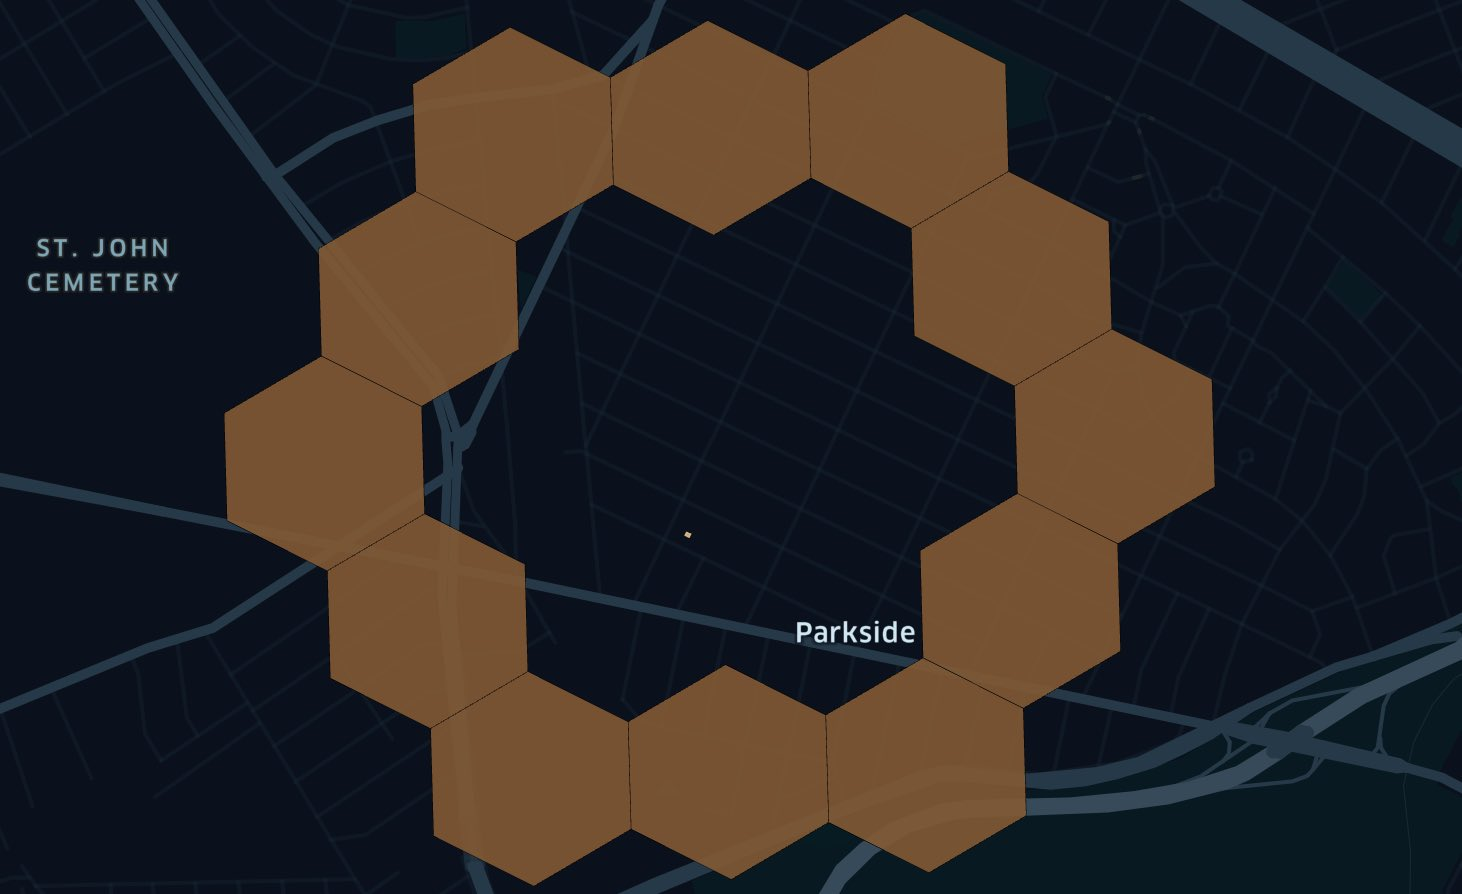

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABbagAwAEAAAAAQAAA36kBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIA34FtgMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAcEBAcKBwcHCg0KCgoKDRENDQ0NDREUERERERERFBQUFBQUFBQYGBgYGBgcHBwcHCAgICAgICAgICD/2wBDAQUFBQgICA4ICA4hFxIXISEhISEhISEhISEhISEhISEhISEhISEhISEhISEhISEhISEhISEhISEhISEhISEhISH/3QAEAFz/2gAMAwEAAhEDEQA/APiSVcHI6GoqnQh12GoSCDg11mCEooooGFKDg5FJRQBYYeYm4dRVepI22nB6GiRdrZHQ0xEdFOVGbpU2Ej68mkFxixE8twKcXVBhKjaRm+lMphYUkscmkoopDCiiigB6O8biRDhlOQa7uxu0vYBKOGHDD0NcDV7T7xrKcP8AwHhh7f8A1qqLsRON0dm37iTf/A559m9fx70t1bR3ULQydD0PofWpQUmjyMMrj8CDUUTFGMEhyRyp9V/xHetDA4KeGS3laGQYZTUVdlq9h9pi86MfvEH5j0rjayasdEZXQUUUUigooooAsD94mD1FV6cjbWzUki5+daYiGiiikMKKKKACpo3BGxqhooEPdCh9qZU6uGG16a8ZXkcimFyKiiikMKKKKACiiigCVZSvB5FWVVNm8cE1SUbiBUspxhRTJaAwt2OaYY3HamhmHQ08SuPekPUjoqfzQeGFH7lvagLkFFT+Up+6aYYnHvQFyOilKsOoowaBiUUu1vSnCNz2oEMoqYQnuaXbEvU5oC5BTgrHoKl8yNfuijzHPQUCuOlRhGGNVqsuzNFzVamNBRRRSGFFFFABRRRQAUUUUAFFFFACg4Oaml5AYVBVxAkkO09RTEynRUjRMOnNR0gCiiigYUUUUAFFFFADgxXpWzpEQubnLjIjG78e1YldlokHlWnmHrIc/gOlVFakTdkazusaF24CjJrgLuZ7i4aaTgseB6DtXT65cGK2ESnDSH9BXLCUHhxTk+hFNaXIKKnMQPKGoSpXrUGtxKKKKBhRRRQAUUUUAFSLKw681HRQIsYjk9jUbRsvvUdSLIy+9MCOirGY5PY1G0TDpzSC5HU8QwC5qEAk4qaQ7VCCgGQsdxyaSiigYUUUUAFKGK9KSigCcSqww4oMQPKGoKUEryKYrAQV4NJU4lBGHFBjVhlDQFyCilKletJSGFFPjjklcRRKXdjgKoySfYCrd5pmoaeyrewvFv8AulhwfxHGfbqKlySdm9RqLtexRoqYRd2NSbUxjFUQ5Iq0VO0PdahIIODQO4lFFFAwooooAKKKKACiiigBQxXpUwlVuHFQUUCsTmIHlDUW1s7SKQEryKsRzKD+8FMNRsh2qEFQVYdA53KagKletAISiiikMKKKKACpI13N7Co6sf6uP3NAmRyNub2FR0UUAFFFFAwooooAKmiXq57VEBk4FTSEKgQUCZEzbmJqxbXlxaNuhbHqOx/CqtFAWOzs9Yt7nCS/u39D0P0Na9ea1q2erXFrhG/eJ6HqPoatS7mUqfY7WiqlrfW94uYm57qeoq3VmTQUUUUxBWfeabbXnzMNr/3h1/H1rQopWGnbY4W8025szlxuT+8On4+lZ9elEAjBrDvNEhmy9t+7b0/hP+FQ49jaNTucjRU89tPbPsmUqe3ofpUFQaBRRRQMKKcFZugqURY5c0CuJCeSvrR5LZx0FOEiRn5BSzMxAYdDTEJtjT73Jppl7KMVDRSHYUknqaSiigYUUUUAFFFFABRRRQAUUUoUt0FACVOnzoVpBF3Y1IkkcbYXnNMlkIjY+1P2In3jmlmdt3HANV6Bk5lA4UUnnH0qGii4WP/Q+IFJU5FTSAMN61BU0Tfwnoa7DBkNFOddrYptIAooqRYy3J4FADACTgVcRAyYk7VEWSPheTUQkbduNMW495CPlXjFQ1PKuRvFQUhoKKKKBhRRRQAUUUoBY4FACU9Y2b6VIEVBl6a0pPC8CmK50WkXqxkWUjdfu/4VvTRmRQVOHXlT7/4HvXnYJByOCK7fTL4XkHzf6xOGH9fxq4voYzjbVF6KQSpuxg9CPQjtXK6zYeRJ9piHyOeR6H/69dJKPJf7Qv3Tw49vX8P5fSppY454jG4yrDBptXJi7O55zRVq8tXs5zC/TqD6iqtZHQFFFFAwqSOTbwelR0UCJnj/AIl6VDUiPt4PSnPH/EnSmBDRRRSGFFFFABUiSFeDyKjooEWCiuNyVAQQcGgEqcipwyyDDcGmBXop7xlfpTKQBRRRQMmiHVj2qJjuJNTv8kYXuar0xIKKKKQwooooAKlQyHofzqKpo+hoJk7IkBfvijc3tRRQZczDc/tTSZD6CnUUD5mR7GP3jSiNafRQLmYgAHQUtFFAhp5jI96r1YXlXHuar0GyCiiigoKKUAkgAZJ4AFdrp3gfULuIy3ji2yDtUjc2fcZGB+Oayq1oU1ebNKdKU3aKOJorb1Tw9qmkktcR7o/+eicr+Pp+NYlXCcZK8XcmUHF2kgoooqiQooooAKmhPJWoachwwNAmP3shx1Ap+Y5OvBpkow2fWoqYErRMOnNRU9XZelS7o3+9waQFeipWiI5XmoulABRRV2xspL2bYvCj7zegoBuxJp1g17LzxGv3j/QV26qqKEUYAGAPamQwx28YiiGFFNuZhb27zH+EZ/HtWqVjnlLmZyOsT+desoORH8o/r+tZVKSWJY8k80lZs6ErKwoJByKmEueHFQUUgJzGrcoaYIpWcRopZj0AGSfoBXQ6N4Y1LVsTL+4hPPmMOozj5R36ew969V0rQtP0lB5KBpcYMrcsfXHpn0FcWIx0Kei1Z10MHOer0R5U3hHXltftRhB/6Zg5cD1x/TOfaucZWRijgqynBBGCD7ivpGsnU9E03VlxeRAtjAdeHH4/0PFcdLM5X/eLQ66mXq3uM8CortdV8E6hZ5lsD9pjHbo4/Dofw/KuMZWRijgqynBBGCD7ivUpVoVFeDPOqUpQdpIbRRRWpmFFFFABT1kZaZQBk4FAi7Fsf5mGKhkjYksOaJDsQIKjV2XpTEhlFWN6Pw3BprREcrzQO5DRR060UhhRRRQAUUUUAFKCRyKStLTNJv8AVphDZxkjOGc5CL9T/TrUykoq8mOMXJ2RTEoxh+ldLpPhS+1XbMB5MBPLt1IB52jr+fFdxo3g+w07E13i5mHOWHyr9F9vU/pXYDivKxGZfZpfeelRy/rU+4x9L0HTdHTFrHlz1kblj+Pbr2ArVliinjMMyK6NwVYZB+oNPFLXlSm27t6npKKSskcJqngi1nzLpj+S/wDcbJT8DyV/X6V5/f6ZfaZJ5d7EY89D1U/Qjg173UM9vBdRGG4RZEbqrDIrtoZhUhpLVHDXwEJ6x0Z895xTuCMGvSdU8DxSZl0p/LP/ADzckr+DckfjmuAvbC80+Xyb2Jo27Z6H6Hofwr16OKp1Phep5NbDVKW60KDQjqtQlSvWrNOyDwa6TJTKdFWGiB5WoWVl6ikWmNooooGFFFFABRRRQAUUUUAKCQcipRLnhxUNFAicxq3KGomVl60gJHIqVZezc0AQ0VOUR+UNRMjL1oC46JdzZ9KJG3N7CpD+7jx3NV6ACiiigYUUUUAFFFA54oAmiXnce1Rs25s1K/yIEFQUxIKKKKQwooooAcrMjB0JBHQiugs9cZcR3gyP7w6/iK52nKu5gKadiXFPc9FjkjlQSRMGU9xT64NLua1cGBtuOo7GuistZgnwk/7t/wDx0/4VopGMoNbG1RRRVGYUUUUARyxRzIY5VDKexrm7zQ2XMlmcj+6ev4GuoopNXKjJrY878iRWKuNpHUHrTtsafe5Ndxc2cF2u2Uc9iOCK5W80i4tsvH+8T1HUfUVm42NozTM8zHooxURJPU0lFSWFTp88ZX0qCpI2w31oBkdFSSDDfWo6ACiiigYUUUUAFFOCM3QVKIgOXNArkFSLEx68U/zEXhRUbSM1AEu2NPvcmmmXsoxUNFAWFLE9TSUUUDLD/PGG9Kr1NEeqmomGCRTEhKKKKQz/0fh+iijr0rrMSwf3iZ7ioVUscCp4l2HL8CnTNt+50NMm4wKkfLcmo2kLcdBUZJPJopDsFFFFAyaJv4DUbLtOKb05qwf3iZHUUxFeiiikMKKeqM3TpUvyRe5oFcYsRPLcCnGRVG1KjZ2br0plMLCkknJpKKKQwqzaXL2k6zJ26j1HpVaigR6NFLHPEssZyrDIqGL9w/2c/dP+r/qv4dvb6VzWj3/2eX7PKfkc8ex/+vXVyxiVChOD1BHUHsa1Tuc8lZ2KWpWIvYML/rF5U/0/GuHIKkqwwRwRXocEpkUq4w6HDD+v0NYGt2H/AC+RD/fH9aUl1LpytozmqKKKzNgoopyqWPFAhtWohs5fpTfkiHqahZix5phuSyID80fSoKkRyp9qe6A/MlAEFFFFIYUUUUAFFFFAEqSkcNyKfsR+VOKr0dKBWHsjL1pYly30pVlI+9zVlQmzcOCaYmyrI2W+lR1KYmHTmoyrDqKQxKKKKBhRRRQAVNH0NQ1LF3oInsS0UUUGQUUUUAFFFFABRRRQAifeYVWqyn+sIqex0u/1OYw2MRcg8noo+pPApSkoq7ZvCLeiM+ui0fwzqOrkSKvlQE/6xhwR6qON1d5o/gyysds9/wD6RMDkD+AYPGB3/Hj2rtK8rEZl0pfeepQwHWp9xhaP4e0/RkzAu+U9ZXwW+g9B7Ct2iivJlNyd5M9OMVFWihCARg8g1yWq+DdMv8y2w+zSnuo+U/Vf8MV11FOnUlB3i7CnTjNWkjwjVPD2qaSS1xHuj/56Jyv4+n41iV9IkAjB5BrktV8G6Zf5lth9mlPdR8p+q/4Yr1aGZ9Ki+Z5tbL3vTZ43RW3qnh7VNJJa4j3R/wDPROV/H0/GsSvUhOMleLuedKDi7SQUUUVRJPJ80YaoKnj+ZCtQUCQUUUUDHq7L0qTej8MMVBUsMMlxKIohljTEyxBYyXMojh79Sew9a7W1tYrSEQxD6nuT61HZWcdlCI15J5Y+ponulSVLZOZJO3oO5rRKxhKTehcrntfuNsSWw6sdx+groa4TU5zcXrt2B2j6CiT0CmrsoUVJDDLcSrDApd2OAoGSa9D0bwMT+/1o4HGIkb/0Ij/2U/jXJWxEKavJnbSoTqO0UcRp+lX+qyeXYxF8dW6KPqegr1LR/B1hpzCe7IuZsfxAbF+gOcn3P5Cuqgt4LWJYLdAiKMBVGBU1eLiMdOpotEetQwUIavVhRRRXCdoUuaSigQtZOp6HpurLi8iBbGA68OPx/oeK1aXNOMnF3TFKKaszyHVfBOoWeZbA/aYx26OPw6H8PyrjGVkYo4KspwQRgg+4r6R4rJ1LRNN1VcXkQLYwHHDD8f6HivToZlJaVFc8+tgIvWGh4FRXbar4Jv7TMtgftMY/h6OPw6H8Pyri3R42KSAqw4IIwRXq0q0KivBnm1KUoO0kNqaJedx7VD1qw/yIFHetjJkLtubNNoopDCnK7L0ptFAicOj8OKRou681DTlZl6UwsIQRwaSpxIrcOKRohjcp4pBchqa3t57qUQWyNI7dFUZNdXo/g2/1DbPef6PAwzz99gemB2/H8q9Q07SdP0qPy7KIJnq3Vj9Sef6VwYjHwhpHVndQwU56y0RxOjeBwAlzrDfMDnyVxjj+8wzn6D869CgghtoVt7dQkaDCqOABUtFeLWrzqO8metSowpq0UFL7UCgVkaC0UUUCCiiigAqGe3guojDcIsiN1VhkVNRQBwGqeB4pMy6U/ln/AJ5uSV/BuSPxzXAXtheafL5N7E0bds9D9D0P4V79UM9vBdRGG4RZEbqrDIrvoZhUhpLVHBXy+nPWOjPnunZzwa9J1TwPFJmXSn8s/wDPNySv4NyR+Oa4C9sLzT5fJvYmjbtnofoeh/CvXo4qnU+F6nk1sNUpbrQotEp5XioWRl61Ypc+tdJkp9ypRVlolbleKhZGXrSLTGUUUUDCiiigAooooAKKKKADkdKmSYg/MM1DRQKxafZKcrxUDIy9aZUqykdeaYEVFWNscn3eDUTRstILjKKKKBhU0S5O49qhqw/yJtHemJkLtubNNoopAFFFFAwooooAKnjAVS5qFRuIFTSnACCgTIScnJpKKKBmlZ6pc2mFzvT+6f6eldXaahbXg/dnDd1PWuCpQSp3KcEdxVKViJQTPSaK5Wz1ySPEd2N6/wB4dfx9a6WGaKdPMhYMp9K0TuYSi0S0UUUyQooooAyrzSbe6y6fu39R0P1FctdWNxZtiVeOzDoa76kZVdSrgEHqDUuNzSM2jzaiupvNDR8yWh2n+6en4HtXNSwywP5cylWHY1m1Y2jJPYe/zxhvSoKniOQUNM8t84xQMjpQCeBU3lqvLmgyqvCCkFxqxMevFPxEnuaiZ2bqaZQBM0xP3eKiJJ60lFABRRRQMKKKKACiiigBVO1galmHRh3qGrC/PHjuKBMr0U8Ix6Cl8p/SgD//0viNY2b2FSZSPgcmmNKTwOBUVdhgOZmbrUqEOuw1BSglTkUgsBBBwaSp5AGXetQUAgooooGFSRttbnoajooETSRndlR1pRGqjL1JFJmPZ3qsxbPzdaYh7Sk8LwKioopDCiiigYUUUUAFFFSLGzewoER12WkXrXEPlS/fT9R61yv7uP3NLHdSwyrLGcFTmqTsTJXR3MylT9ojGWUYIHdfT6+lSgpNHkYZWH5g1Fa3Md3As0fQ9R6H0pg/0abb/wAs5Dx/ssf6H+f1rQwOQ1KyNlPgf6tuVP8AT8Kz69AvLVLyAwv16qfQ1xTxfZnKS/eXis5I2hO6Ilizy3ApWkAG1KjZy30plIuwUUUUhhT1cp0plFAixhJeRwahZSpwab05FTrIG+V6YEFFTyQsnI5FQUgCiiigYUUUUAOUbmAqSU8hR2pYhgFzUJOTmgQ4O46GniY9xUNFAWJ98bfeFGyNvumoKKAsTGE9jTCjjtTQzDoakErDrzQGpFUsXeneap+8KUSRjoMUClqrDqKTzI6XfH60zPkYUUb4/Wk3xigORi0U3zI/Sk84DtSHyD+ewzT44Jp5FhiGWcgKq8kk10ekeF9T1MiWcG2gPO5h8x+in19f516dpmj2OkxeXaJ83eRsF2+p/p0rhxGPhT0jqzuw+AlPWWiOJ0XwS7FLrVW2qRnyh94+zHt9B+Yr0O3tbeziEFrGsaDsox+P196nFKa8WtiJ1HeTPYpUIU1aKEooorE3CiiigAooooAKKKKAEIBGDyDXI6r4N0y/zLa/6NKe6j5D9V/wxXX0VdOrKDvF2M504zVpI8I1Tw/qekktcx7o/wDnonK/j6fjisSvpEgEYPINcjqvg3TL/Mtr/o0p7qPkP1X/AAxXq0MzW1RfM82tl73ps8hiOGx601xhiK2dT0DVNIbfcx7owf8AWJyv4+n41kzDkNXqQnGSvF3POlBxdpIhoopQCxCqMk9BVCHIjyuI4xlm4AFdtp1gllFzzI33j/Qe1Q6XpwtE82UZlYc+w9Ku3l3HZwmWTr/CPU1pFW1ZhOV9ERX99HZRZPLt91f6/SsnREeeeW9mOT0z7nrWBcTyXMpmlOSf09q77RNNupLWOG2jLZ5djwoJPOT6j0GTUSqRj70nZFxpt+7FXbIr+4+zWkk3cDA+p6VT0jwpf6ogluh9miPdh8xGM5C/1J/OvSLTQ7W0dZZT50q4ILDAUjPKjnB98k1r14+JzNvSl956uGy2yvUM7TtH0/So9ljEEJ6t1Y/Unn8OlaNFLmvJlJt3Z6qikrISilxSUhhRRRQMKKKKACiiigApc0lFAheKydS0TTtVXF5EC3Zxww/H/HitWlzTjJxd0xSimrM8l1HwVfWbGaxP2iMdujj8O/4flXFTB1kKuCpU4IIwRX0hWRqWiadqq4vIgW7OOGH4/wCPFenQzKS0qK559XL4vWDseBUV22q+Cb+0zLYH7TGP4ejj8Oh/D8q4tkaNijgqw4IIwQfevVpVoVFeDPNqUpQdpIbRRRWpmFFWrOxvNQl8iyiaV/RR09yegHua9K0fwPbQgT6sfOfH+rH3Bkd+5/QVz18VCl8T1NqOHnU+FHC6ToOoaw+LZNsY6yPkJx2B7n2FeqaN4X0/SMSY86cf8tHHQ+qjnH866NVVFCqAABgAdAKWvFxGNnU02R69DCQp67sXNGKSiuM6gopc0UAHtS0lLQIKKKKACiiigAooooAKKKKACoZ7eC6iMNwiyI3VWGRU1FAHAan4HhkzLpT+Wf8Anm+Sv4HqPxzXAXun3unSeVeRNGe2eh+h6GvfqingguYzDcIsiN1VhkV30MwnDSWqOCvl8J6x0Z89U7Nelap4IhkzLpb+W3/PNzlfwPUfjmvP73T73TpPKvImjPbPQ/Q9DXr0cVTqfC9TyK2GqUviWhSMat04NQtGy/Sp6UE10GSmVKKtFEb2NQtGy+9BomR0UUUDCiiigAooooAKKKKACpVlYdeaiooEWMRydODUbRsvvUdSLIw460wFiXJ3HtTXbc2atts2behNVWiYdOaBJkdFFFIoKKKKACiilAycCgCaIYBc1CTk5NTSkKoQVBTEgooopDCiiigAqaC4mtn8yFip/n9ahqSNdzewoEzrbXV4nAS6wjHv2/8ArVsggjIrzmRtzfSrlnqVzZnCncn909Pw9KtS7mTp9juqKz7PUra8GEO1/wC6ev4etaFWZNW3CiiimIKhnt4blPLmUMP5fSpqKQzlp9Fkgk823O9R27//AF6xppmLkYxjivQqoXenW14MuMP/AHh1/wDr1Lj2NI1O5whJPWitG80y5tMsRvT+8P6+lZ1QbJ32CiiikMKKKKACiiigAoop6xs3tQIZSgE9Km2In3jQZQOEFAXEEJ/iOKljaONsDnNVizN1NNphYsSyMG44FR+a/rUjjzFDCo/KegWh/9P4fooorrMQooooAlibB2noaa67Wx2plWP9anuKYivRRRSGFFFFACqSpyKmkAYb1qCpom/hPQ0xMhopzrtbFNpAFFFSLGzewoAjqRY2b2FSfu4/c1G0jN7CmBJ+7j9zUbSM3sKjopBYKKKKBmppd8bOfD/6t+G9veuzdEljKNyrCvOK6nRb/ev2OU/Mv3Pcen4VcX0MqkeqNiB2yYJTl07/AN4dj/j71mazYefH9piHzoOR6j/61alxEzASRf6xOV9/UH2NSRSrNGJE79vQ9wfpVW6GSdtUec0VsavYfZZfOjH7tz+R9Kx6zaOlO6uFFFFIYUUVIkZbk8CgQ1VLHAqb5Ih6mkaQKNqVB15NMCUStnJ6elPKpIMrwar0oJByKAsBUqcGkqcSKww9BiU8oaQXIKKeyMvUU6Jctn0oAc/yIFFQU+RtzUygEFFFFAwooooAKKKKACiiigAooooAKKnt7a4u5RBaxtJIeiqMnivSNH8DxxMJ9YYSHHES52g+54z9On1rCtiYUl7zNqNCdR+6jhdM0XUdXfbZx5UdXbhR269/wya9T0bwnp+l7J5h59wB95vug99o/wAcmumiiigjEUKhEXgKowB9AKkrxcRjp1NFoj1qGDhDV6sKKKK4jsClNJSmgQlFFFAwooooAKKKKACiiigAooooAKKKUKT0oENIBGDyDXKar4P03UFL23+jS9flHyk+6/4Yrrwh708KBV06soO8XYipTjNWkjwTU/Duq6U2Z4i8faRPmX/EfjWhpWmeQBc3A/eHoP7v/wBevbCARtI4NYN5oFrLl7U+Q3oOUP4dvwr1sPma2qr5nlYjL5W/dM4e4uI7WIzSnAH6n0rj8X2tXgjgQyO3CqOgH16D6mu4TwreanfOdRlVIIHC7EyS3AbgkDGQRz+GK7qx0+z02EQWUYjXvjqfcnqT9a2xOZQjpDVmWGy6T1nocbovgaCPE2sHzXzkRqfkA9zwSf0+teiRxxxII4lCKOgAwB+FIg705jgV4tWtOo7zZ7FOlGCtFEROTmkoorI1CiiigYUuaSigQuKSilzQAlFLikoAKKKKBhRRRQAUopKXoKBCUuaSigBeDWTqeiabqy4vIgW6B14cfj/Q8Vq0U4ycXdMUopqzPItW8FX1kGmsW+0RDnHRwPp0P4flUuj+Cbq523GpN5MRwQg5dh/IAj8fYV6rKvmRMg6sCPzqCxybGAnkmNP5Cu14+ryWucn1KlzXsNstPstOi8myiWJe+Op+p6n8auUUVxNtu7OxJLRBRRRSGFFFFABSikpe1AmLRRRQIKKKKACiiigAooooAKKKKACiiigAooooAK5HxqAdF57Sr/WuurlPGahtDc/3XQ/rj+tbYb+LH1MMT/Cl6M8gooor6g+YClyaSigLgVRuvBqFomHTmpqWNiH46CmaRkypRVpmjlYk8GomiYdOaRdyKiiigYUUUUAFFFFABUsS5bPpUVWD+7jx3NAmRO25qVZGX3FR0UAWMxydeDTGiYdOaip6uy0AMoqxujk+9waY0RHK80BciqaIYy5qLBzjvU0h2qEFAMhY7jmkoooGFFFFABRRRQAVY/1cfuajjXc3sKJW3Nj0piZHRRRSGKCQcjg1uWetyxYjuf3i+v8AEP8AGsKimnYlpPc9EguIblPMhYMP5fWpq86hmlgfzIWKkeldNZ65HJiO7Gxv7w6fj6VakZSptbG/RSAgjIOQaWrMgooooAOvFYt5osE+Xg/dv/46f8K2qKTQ02tjz24tZ7V9kykeh7H6Gq9ejyRxyoUkUMp7GucvNCIzJZnP+wf6H/GocTaNRPc5uipjBKrFXBUjqDTtkafeOag0uQBSegqURd2OKDL2UVEWLdTQBNujT7vJpjSsenFR0UBYKKKKBhRRRQBYhbqtTVRBI6Uu5vWncVj/1PiBgVODSVYcB03jrVeuswQUUUUDCno21s9qZRQIllXB3DoaiqeMhl2GoSCpwaAQlFFFAwoopQCTgUATn94me4qJUZulTRqI/mc02SbJ+TgUyRcJH15NRtIzewqOikOwUUUUDCiiigAooooAKcjtG4dDhlOQabRQB3theLewCQcMOGHoaJP9Gl88f6t+HHoezf0NcfYXjWU4kHKnhh7V3QKTR5GGVh+BBrVO5zyjZjZ4Y7iJoZBkMK4K6tpLWZoZOo6H1HrXbQEwv9kfnAyhPdfT6j+VV9UsReQ7kH7xOV9/alJXCErOxxNHXgU4IxOMdKm+SIeprM3uIsYUbnpjyFuBwKazFjk02gLBRRRQMKKKKAClBI5FJTlQseKBEiyPnHWrOYwvPBNQFliGF5NQEljk0xWuSmE9VOaiKkdRQGZehqUS9mGaQyGip9sb/dODTDEw6c0Bcjoo6UUDCiiigAooooAK3fDukRa1qP2SaQxqqFztAycEDAz069efpWFXYeByBrnPeJ8fmKwxMnGnJx3NcPFSqRTPVNP02y0yHyLKMIOMnuxHcnuavUUV8y227s+iSSVkFFFFIYUUUuDQISlNLtanbDQBHRUnl+9LsFAXIqKm2LS7R6UBcgpcGp6KAuQbW9KXY1TUZFArkWw04IO9O3D1pC4FACgAdKWoi57U0knrQOxMWAppcdqiooCw4u1NyT1oooApWrgz3QH8MoH/AJDQ/wBavdapWzD7Rcr3EgP5otXlGTTkJbEoGBio3POKlqAnJpAJRS4pKBhRRRQMKKKKACiiigApc0lFAhaSilzQAlFLSUAKKDR0FJQAUUUUDCiiigAqlppb+zrYvwfKTI99oq7VLTSW062YjBMSHHp8op9Cepe4oxSUUhhRS0YoASiiigYUtJTu9AmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigArmPGK7tAmOcbWjP/j4H9a6euc8WqW8P3IH+wfydTWtD+JH1RlX/AIcvRnjFFFFfUnywUUUUAITgZpG+SPHc0o+ZsenNRSNub6UGkER09XZelMooLLG9H4bg01oj1XmoacrsvSmFhpBHBoqcSI/DikMXdDmkFyGilKleoxSUDJIly2fSkkbc3sKlP7uPHc1XoEFFFFAwooooAKersvSmUUCLUckbH5+DTJEJO5eRUFOV2XpTFYbRVjcknB4NRtEy8jkUh3I6KKKBhRRT413N7CgRKP3cee5qvUsrZbHpUVAIKKKKBhRRRQAVJGu5vpUdWB+7jz3NAmWYNRuLR/3RyvdT0rp7PVLa7wudj/3T/Q964eiqUrEygmelUVx9nrU8GEn/AHif+PD/ABrqLe6guk3wMG9R3H1FWncxlFosUUUVRAUUUUAV7i1guk2yj6EcEfjXK3mj3Fvl4v3ie3UfUV2VFS1cuM2jzWiu3vNKtrvLgbH/ALw7/UVyt3YXNmf3q5Xsw6VDjY2jNMpUUUVJYUUUUAFFFABPAoAKKlETHrxS+SfWgVz/1fiSJsHB6GkkXa3sajqwP3iYPUV2GBXoo6cUUhhRRRQAoJByKmkAdd4qCpYmwdp6GgTIqKlMTbsDpT8JH15NMLjFiJ5PApxdUGEqNpGb2FMoCwpYscmkoopDCiiigAooooAKKKKACiiigAooooAK6LRb/Y32OU8H7h9D6fjXO0oJByODTTsTJXVj0KeHzk+U4dTlT6H/AD1ot5vOTJGGU4YehFU9LvheQYf/AFicN7+9WJ1MT/ao+cDDgd19fqK08znt0Zi6zaGL/SoRwx+f2Pr+Nc11r0ciOaPBwysPwINcLf2bWU5jPKnlT6ipkuprTl0KVFFFQahRRRQAUUAZ4FTqgQbnoENSPPLcClaQAbUpryFuOgqOmFgooopDCiiigAp4kZe9MooET+YrcOKRogRlKhpysVPFMLDenBoqd8MgcVBSBBRTkR5DtjUsfQDNacOjX0vLKIx/tH+lOwNpbmVXWeCv+Q8n+4/8qSHQIF5ncufQcCuo0K0t7fVLfyECct06n5G6nrWOKi/Yy9DTD1F7WKXc9BCk07Z6mpKaWAr5Y+juJsFLtX0pN4pN/tQBJgUVDvakyfWgdiekyPWoKXtQIl3rSbxUVFA7Enme1JvNMooCw7e1JuPrSUUAGaKKKAFzSmm0poASilzRxQAlFGKKACiiigZRg2i9uQOp2E/lj+laaDjNZ0agX8xHVo4yfzcVpgYGKciVsI5wKhp7nJplIaClpKKAFxSUUuaAEopcUlABRRRQMKKKKACiiigApRSUvQUCYdaSilzQAlFLxSYoAKKKKBhVLTWD2EBH/PNR+QxV2qWnFTZpt6DI/IkU+hPUu0UUUigooooELmjFJRQAtLSUUCFoozRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVgeKAToNyB6L+jCt+sPxLxoV0f9j+orSj8cfUzrfBL0PEaKKK+qPlQooooAF+8R61WIwcVY6EGopRh/rQawZHRRRQWFFFFABShivQ0lFAGgt2jx+VKvbGe1QLCS25eQOarVdDPbx49aEiWVpG3N9KjqxmOTrwaY0TDpzTGiKiiikMKKKKACiiigAooooAKkWRl9xUdFAixiOTpwaiZGXr0plSrKRw3NAEVWB+7jz3NKqRyEEcUybO7HYUxENFFFIoKKKKACiiigB6LubFOlbLY9KcnyIWPeoKYgooopDCpI5ZIXEkTFWHcVHRQI6iy1xWxHeDB/vDp+IroFZXUOhBB6EV5vVu1vrizbMTcd1PQ1al3M5U+x39FZtnqcFyoD/u3PY9/oa0qtMxasFFFFMQUhUMCrDIPY0tFAGBeaHHJmS0Oxv7p6f/WrmZoJrd/LmUqfevRaimghuE8uZQw96hxNI1GtzzqnKjN0FdDc6KYsyW2XH909f/r1hvI4JXG0j161DVjZSvsAiVeXNBkVeEFQkk8mkpDsPLse9Jub1NNooA//1vh+nK21s02iusxJpV/jHeoaniYEbDUTKVOKYkNooqVYi3J4FICMAk4FTLGF+Z6UuiDCc1AWLHJpgWJJ9y7VGPeq1FFILBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKALFtcSWsyzR9R1HqPSu8t547mFZozkN+ntXndaulX5tJtkh/dv19j61UXYznG+p1aD7PJ5f8Ayzc/L7H0/HtTL+zW9gMZ4YcqfQ1adVlQqeQabGzcxv8AeX9R61oY36nnjo0bmNxhlOCKbXVa1YeYv2uIfMv3h6j1/CuVrJqx0RldXCnKpY4FOSMtyeBT2cKNqUh3F+SIepqFmLHJpvXk0UBYKKKKBhRRRQAUUUUAFFFXLewurr/VIcf3jwPzoFcp05UZ22oCxPYc109voEa/NdPuPovA/OtuG3gt12woFHtVqJDqLocxaaPdSL++/dqfXk/lWtDollFy4Mh9zx+QrTlmihXfKwUe5rIudbgh4iUufXoP8adkjPmk9jYjijiXbEoUegGKHkjjXdIwUepOK46bWr2XhSIx/sj+prMeSSRt0jFj6k5o5xqm+p2M2tWUXCkyH/ZH9TU/h/WJbvX7WFUCIS+e54jauEroPCrFfENoR/eYfmjCufEtulL0Z04eCVSPqj3MknrSUUV8qfTBRRRQAUUUUAFKKSlFAmJRRRQMKKKKACiiigAooooAKXtSUvagQlFFFAxc0cGkooELikpc0cUAVIUH9pTP6xRD8mk/xrSPAzWfCpGozNngxRcfRpKuueMU5EoiooopFhRRRQAUUUUAFLmkooELikopc0AJRS4pKACiiigYClNHQUlAgooooGFLmkooELwaMUlLmgBKp2G3yCF6CSUceztV3iqVggSBgP8AnrMfzkY0+gupcooopFBRRRQAUUUooEFJRRQAuaPpSUUBYdRSZo+lAhaKKKACiiigAooooAKKKKACiiigArH8Qf8AIEvP+uTfyrYrM1v/AJA17/17y/8AoJq6fxIip8LPCKKKaXUd6+rPlEh1FRGT0FMLse9BSgyZsYINJJ8yBqgqeP5kK0y1GxBRRRSLCiilAJ6UAJRUgjc9sU8QgfeNArjIly30qVpyWw3IFWPMjggKKMsazqBbljYj8qcU0eYhx1FQ1PFMQw3cimBM7xLjcuTQkMdwx2Hb/n0qCb7+fWoQSDkUmCRNNA8LbW59xUNTCZs/PzTtqPyvBoHcr0U5kZetNoAKKKKBhRRRQAUUUUAAJHIqZZez81DRQInMasMoahIIODQCVORUwkVhhxTAgoqZou6c1D04NIApyruYCm1PGNqlzQDElbnaO1Q0pOTk0lABRRRQMKKKKACnIu5sU2p0+RC5oExsrZO0dq0rPWLi2wkv7xPfqPoayOvNFO4mk9Geg215b3a7oWz6juPwqzXnCSPEweMlWHQiuistd6R3g/4GP6j/AAq1LuZSp9jpaKYjpIoeMhlPQin1ZmFFFFAgqld6fbXg/eLhuzDrV2ikNOxxF5pVzaZYDen94f1HasyvSqx7zRre4y8P7t/bofwqHHsaxqdzjaKs3NncWjbZlx6HsfxqtUGtz//X+H6KKUAk4FdZiAODkVYKGZdy9RTViAGXpfPK8R8CmSGEj5PJqNpGb2FR9etFIdgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHUaLqG4CzmPI+4fUelbzqThl+8vT/CvOlZkYMpwQcg13OnXy3sGT/rF4Yf1/GtIvoYVI21ReUh1z2PY1yGo6etpMZB/q25Ht7V1x+Vt3Y9f8ajubeO6haGToe/ofWm1cmMrM4F5C3C8CoqmngktpWhkGCp/yahrI6EFFFFAwooooAKKKt2tlcXjbYRx3Y9BQJsqAZ4FbVrolzMA8x8tT69fyrestLt7MBvvyf3j/T0q9LNFAhklYKo7mrUe5lKp2KNvpVnb8hd7erc/p0rS6Vz1xr8a5W2TcfVuB+XWsK4v7u64lc4/ujgflT5kthKEnudbcarZ2+QW3t6Lz/8AWrCuNduZPlgAjHr1NYdFS5MtU0h8kkkrb5GLH1JzUh+eLPcVBU0J5K+tItkNFOYbWIptIYVueGm2a9aHGfnx+YIrDrZ8PMF1u0J/56qPz4rKv/Dl6M0o/HH1PeaKKK+WPpAooooAKKKMUCClFGKKAEooNFABRRRQMKKKKACiiigApe1JSigTEooooGFFFFABSgZOKSpUHGaBFNdw1Nv7rQr+YZv8atMQTVR2ZdSUY4aFufcMP8asU2TEXFJRS8UihKKXFJQAUUUUDCiiigAooooAKXNJRQIXFGKSloADSUtJQAUUUUDCiiigAooooAKp6eoSBgP+esx/ORjVyqNiGVZVY5xM+PoTn+tNbEvcv8UYpKKQwopeKMUAJS9BQKSgAooooGFFFFABRRRQAuaPpSUUCsOopM0UCFooooAKKM0maAFoptFA7C5rO1cBtKu1boYZAf8Avk1oVT1BQ1hcK3QxOD/3yacd0KS0Z89Ek9aSilAJ6V9afMCUVIInPtT/ACgOWNAXIKlhJ349ad+6X3qWNx94DAFMTZC0Tbj2pRCByxpryuxznFREk9aB6k/7pfegzAcKKgopBYkMjnviiMFmye1R1YH7uPPc0wZHI25vpUdFFIAooooGaErRyWi4+8P8ms+pojnKmoiMHFAhKOnSiigZMsp6NzSmNH5Q1BSgkcigVhWUr1ptTLLnhxSmMNyhphcgopSCDg0lIYUUUUAFFFFABRRRQA5WZelTB0fhuDVeigViYwtn5eaWU4AQUyOVozkc1Kds3PQ0xFainMpU802kUFFFFABRRRQA5V3NipJW52jtSxjapc1CTk5NAhKKKKBhRRRQBatry4tG3Qtj1HY/hXU2esW9zhJf3b+h6H6GuMopp2IlBM9Korj7PU57OMB/nX0PUfQ10trfW94uYW57qeorRSuYyg0W6KKKogKKKKQxCAetG1fQUtFAH//Q+I1jLcngVIWSPheTUbSM3HQVHXYYDmYscmm0UUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVm0upLScTR/iPUelVqKBHosM0dxEs0RyrCnjj5fyrj9J1D7LL5Up/dv+h9f8a7HrWqdznlGzMnVrD7VF5sY/eJ+o9K4yvSq5LWbDyZPtUQ+RzyPQ/wD16mS6l05dDCoooqDYKVVZ2CqCSegFXrPTri8OUG1O7Hp+HrXW2en29mv7sZbux61SjciU0jGsdDJxJecD+4P6mulREjUJGAqjoBUVxcw2qeZM20dvU/SuVvdYmucxw5jT9T9arRGVnI2r7V4LXMcX7yT0HQfU1ylxdT3T75mz6DsPpVeiobuaxikFFFFIsKKKKAClU4INJRQBNMOjCoasL88e3uKjETn2piRHWpobBdZsyf8AntGPzYCqXlKv3jV/SniXVbPH/PeLn/gYrOqvcfoXTfvI98pcUZpK+UPpReKKSigBc0ZpKKACiiigBTSUppKACiiigYUUUUAFFFFABSikpRQJiUUUUAFFFFAxQMnFT1Gg705jgUEmdM4/tKFPWKU/k0f+NW6pSMBqMKdzFKfyaP8Axq7TfQF1CiiikUFLSUUCFxSUUtACUUuKSgAooooGFFFFABSmikoEFLmkooAXikopc0AJRS8UmKACiiigYVRs9we4Vu0px9Cqn+tXqpWpJnugRjEoH1/dpTWzJe6LtFFFIoKKKUUCFpMUGkoAKKWjFACUUUUDCiiigAooooAKKKKAFzRSUUCsGKKUUUAJRS8UZoAMVXu032sqZxuRh+YqfNMkUvGyDqQR+dCBnzsDEoB6mlM3ZRVdfuj6UtfXHy9h5kc96ZknrRRQAoBJwKmkO1QgpIh1c9qjZtxzQA2iiigYUUUUAPjXc1OlbLY9Kev7uPd3NV6BBRRRQMKKKKAHIcODU9xHtIYcg1WHWrjMOFbvTJZTop7oUPtTKQwooooGFKCQcikooAnEgYYcUjRZ5Q1DTgxXpTFYQgg4NJU4kV+HFIYT/BzSC5DRQQRwaKBhRRRQAUUUUAFHTkUUUATrICNr0jRd15FQ09XK9OlArDKKsYSXkcGoWUqeaAuNpyjccU2p4wFUuaAYkp6IO1Q0pJJyaSgAooooGFFFFABT413N7UyrC/u493c0CYyVstj0pisyMHQkEdCKbRQB0VnrjLiO8GR/eHX8RXSRyxzIJImDKe4rzmrFvdT2r74Wx6jsfqKtSM5U09j0KisWy1mCfCT/ALt//HT/AIVtVaZi01uJS80UUAf/0fh+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK6vRtQ81fskx+Zfun1Hp+FcpTkdo3DocMDkGmnYmUbo9IpksaTRtFIMqwwRVTT71b2AP0deGHv/APXq9WpzPQ4O5sJ4Lo2yqWJ+7juK27LRETEl58x/ujp+PrXQ4Gc1Vury3s03TNz2UdTU8qRbm3oiyAFGBwBWJfa1FDmO2w7+v8I/xrEvdUuLvKD5I/7o7/Wsyk5di40+5LNPLcOZJmLMfWoqKKg0CiiigYUUUUAFFPVGapNiJ985oFchClugqURY5c0GXsgxURJPU0AWo5ERtqjrUUjuGIzgVCDg5qeUblDimKxBVzTv+Qjbf9do/wD0IVTqxa/8fUX++v8AOon8LLhuj6Kooor5M+nCiiigAooooAKKKKAFNJS9qSgSCiiigYUUUUAFFFFABSikooEBopTSUAFKBk4pKkQd6AJBwMVE5ycVITgZqHrQIoyFRqEOepjkA/ND/SrtUpwv223Y9fnA/Ef/AFqu030BdQooopFBRRRQAUUUUAFLmkooELikopc0AJRS4o6UBcDSUUUAFFFFAwooooAKXNJRQIXg0YpKXNACVRtG3T3Yx92UD/yGh/rV/iqVsR9ouVHUSA/mi011E+hcooopFBS9BQKDQISiiigYUUUUCFzRikooAKKXNGKAEooooGFFFFABRRRQIXoKSlNJQAUUUUDCiiqJuzMCtgBKw4LE/IpxkZPf6DPvimlcTdj57AKja3BHBorrdW8IapYs00I+0xdcoPmH1Xk/lmuSr6mlVjNXiz5upTlB2kgpQCTgUlTxLgbzWhmEhCqEFQUrHcc0lAIKKKKBhT40LuFplWI/3ab+9AmJNkHae1QVMJc8OM0pjR+UNMCCinMjL1ptIYUUUoBJwOaAEqeXlQwoFtPjcVIHvxUvl/uSCeRQhMj/ANZH7iq9SxNhsetNddrEUwGUUUUhhRRRQAUUUUAFWYSUUvVcDJwKmlOAEFMTHZSXrwahZCv0plSrKRw3IoAioqdoww3JUJBBwaQCUUUUDCiiigAooooAOnIqdZARteoKKBWJzCSfk5BolOAEFOgYoC56UMFm+YcGmIrUUpUqcGkpFBRRRQAUUUUAPRdzYp0rZO0dqevyR7j1NV6BBRRRQMKKKKACtKz1S5tMLnen90/09KzaUDJwKYmk9zvLW/t7pNyNtPcHg1a82P8AvD868/kbaAq1Hvf1qucy9mf/0vh+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL2n3hsrgSnJU8MB6V3EUiTRiWM5VhkGvOa2tI1D7NJ5Ep/duePY1UWZThfU7CsPV9O89ftMI+dRyPUf41uUgrRq5knZ3PNqK6DWNO8pjdwD5T94DsfX6Vz9ZNWOhO6uFFFFIoKKcqM3SpsJHyeTQK5GsTNyeKk/dx+5qNpGbjoKjpgStKx6cVFRRSAKKKKBhU8fzIUNQU+M4Ye9AmMqSElZUZeCGBH50SjDfWoixUbl4I5FJrQaZ9J0UgIIyOQaWvkj6gKKKXFAhKKWjigBKKWjNAB2pKXtSUAFFFFAwooooAKKKKACiiigQppKU0lAIOvFTgYGKYg708nAzQDI3OTimUVzOs+KdP0g+UP38/PyIR8pH9484/In2q4U5TfLFEznGCvJmzcqPtNq/cSMPzRv8KvcGvCrzxLrN5ci589o9hyiocKvXt34OOa6nSvHZGItXjz/wBNYx/Nf8PyrsqZfVUU1qckMbTcmtj0zFJVa0vrS+iE9nKsqeqnp9e4/GrXFcLTWjOxO+olFLikpDCiiigYUUUUAFFFFABS5oFJQIXFJRS5oASilxSUAFFFFAwooooAKKy9T1jT9Ii8y8kAJ6IOXP0Hp79K8t1jxdqGpgw2+baE9lPzH6t6H0H6100MLOrstDnrYmFPfc7zWvFmn6UXt4z51yvGxein/aP9Bk1w1v401SC9kunVJI5SCY8bcAdMMOc47nP0rkKK9ilgKUY2aueTUxlSTunY9x0rxRpWrYjR/KmP/LOTgk/7J6H8OfauixXzZ05rrtI8XarYkRTH7TEOzn5gPZuv55rkr5Y1rTfyOqjmC2qHsvQUlYmmeItL1XEcMmyX/nm/Dfh2P4VuYry5wlF2kj0YTUldMSiiipLCiiigAooooAKKKKAFzRikooEFFLmjFACUvQUmKU0AJRRUcsscK7pWCgnA9SfQDufYUASVVnu4oHWLDPI3IRBk4zjJ7Ae5IFR/6Tdqw5t4zwD/AMtCCOo/u/jk/Q1ZihigUrEuATk+pJ7k9SfrTsluK7exX+zzTtuum+T/AJ5Kfl7/AHjwWz6YA9jVxVVFCqAABgAdAKWlxQ2GwlYWqeHNL1bLzx7JT/y0Thvx7H8a3uKM04zcXeLFKKkrNHjepeDtS08mSIfaYh3QfMPqvX8s1ysr5O0cAV9G1hap4d0vVgWnj2Sn/lonDfj2P416dDM2tKiPPrZenrBnhVFdbqvg/U9PzJbj7TEO6D5h9V/wzXJEEHBr1adWE1eDPNqU5QdpIKKKK0IHKu5gKklbnaO1LGNqlzUJOTk0CEpQSORSUUDJllPRuadsjflTiq9FMVifbEvU5qaK7WDOxc5/CqVFJhYuS3s8oxwoPpUMTHdg96hpVOGBoSsDFYbW47VLJ8yhxSTDkGliOVKGmIgopSMHFJSKCiiigAooqdUQLufvQIIhgFzULHcSatOEaPEVVKYIKKKKQxVYqcipwyScNwar0UCsSNGV56io6lSQjg8ip5IkKjZ1phcp0UpBBwaSkMKKKKAClAycCkqaIYy5oELKQqhBUIJByKGO45pKAROHVxtemPGV5HIqOpUkK8HkUwIqKnaMMNyVB04NIAp6LubFMqwnyJuPU0AxkrZO0dqio60UAFFFFAwooooAKniGAXNQgEnAqaQhVCCgTIWO4k0lFFAz/9P4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA63Rr/z0+zSn50HB9R/9attgR8y9R+tedRyPE4kjOGU5Bru7G8S9gEo4YcMPQ1pF9DCpG2qLXySJjqrCuK1OwNlLlOY2+6fT2rr3PkN5n8B+97H1+nr+dOngjuIjDKMq1Nq5MZWZ54AScCphGFGXqzdwtYymEj6H1FUCxY5NZm97krS9k4qGiikMKKKKBhRRRQAUUUUAFFWLW1ub2YW9pGZJG6KvtXpOjeBo4iJ9YYSH/nkudo+p4z9On1rCviYUl7zNqVCdR+6ji9O0TUNZ2/ZYzszhpG4UevPcj0HNem6N4U0/Sis7/v7hed7dAf8AZHb8cmumiiigjEMChEXgKowB9AKfmvFxGOnU0WiPWoYOFPXdlQ2gQ7rZvKPoBlT9V/wwfej7SYuLtdn+2OU/E9vx496tUVx37nVYAwIyOQaKqG1CHdbN5R9Byp+q/wCGDR9paLi7XYP745T8T2/Hj3ot2C/ct0UgIIyOQaWkUFFFFAC9qSlFJQIKKKKBhRRRQAUUUUAFFFFAC9qSl7U2SWG3ja4nYIiDJJ6Cgm9iwBgYrK1TWNP0pN17KEOMherH6Ac/j0rn9X8TvHC72PyIoOXcfMTnjaD0z7/lXkNxcTXUzT3Dl3bqWOT+telQy6Utami/E8+rj4rSGr/A6nV/GOoaiphth9mhOQQpy5B45Pb8PzNchRRXsU6UKatBHmVKkpu8mFFFFaEFi1u7mylE9pI0Tjupx+fqPY16BpXjsjEWrx5/6axj+a/4flXm9FYVsPCp8SNaVedP4WfRNpe2t9EJ7ORZUPdT0+vofrVrivnS1u7qylE9pI0Tjupx+fqPY16BpXjsjEWrx5/6axj+a/4flXk18unHWGqPTpY6EtJ6M9LxSVWtL21vohPZyLKh7qen19D9atV57TWjO5O+qEopcUlIYUUUo9aAA0lFFABRRRQMKXNJRQIWkorjdX8aWFiTBZD7RKOCR9wYODk9z9Pzq6dKU3aKIqVIwV5M6u5uraziM91IsSDqzHArzrWPHLkmDRhgZx5rDk+6qf6j8K5C/wBRvNWcSXkxcjovRR9F6CstkZetezh8ujHWpq/wPKrY+UtIaCyyyzytNMxd3OWY8kk1HRRXpJW2OBsKKKKACrC/JHuPU1Ci7mxT5Wydo7UxMiyc5rrNK8Yapp2I5z9piHZz8w+jdfzzXJ0VlUpRmrTVzSFSUHeLPdtL8R6Xq2Ehk2Sn/lm/Dfh2P4Vu4r5s6c11mleMNU07Ec5+0xDs5+YfRuv55ryq+WNa02ejRzBbVEezUVh6V4j0vVgEhk2Sn/lm/Dfh2P4Vu4rzJwlF2kj0YzUldMSiiipLCiiigAooooAKKKKBDgaaxVVLsQABkk9AKrS3SrJ5EQMkncDouRkFj2H6+gNRC0aVt9428dox9wdOo/iIx1P5CnbuTfsAunuVzYYZSf8AWN9zg84xy3tjj3qSK0jR/Pk/eS4xvbr+HYde341bzRRfsO3cSlFJS9BSGGaSiigAooooGFFFFABWFqnh3S9WBaePZKf+WicN+PY/jW7RVRm4u8WTKKkrSR41qvg/U9PzJbj7TEO6D5h9V/wzXKKpZ9nevpCsXUvD2mapmSZNkv8Az0Thvx7H8a9OhmTWlRHnVsvW9Nnh8wK4XtVeuz1TwrqunlpYh9qi9UHzAe6/4ZrlCiP93g161OrCorwdzzJ05QdpIr0U5kZetNqyAooooGFFFFABRRRQBOfmiz6VEjbWBqWHnKUpjReHPNMkbKMHd61DV7y1eI7TyKgEQHLmgEyCniNj2qTfGv3RmmGVj04pDJBEikFzxT5lD4MfSqnXrTg7LwDTCxZRVWPDHBNQtEw6c0xmLdaVXZelArDOlFWN6Pw4ppi7qc0h3IaKUgjg0lAyWJctn0pGcl8ipD+7jx3NV6YicOrjD01oyvI5FRVIkhXjqKAsR0VYKpIMrwagZSpwaQXADJwKmkO1QgpIl/iPao2bcxNADaKKKBhRRRQA5WKnIqb5JR6Gq9FArEgjO7B6U6VsnaO1SRTAZV+/eoZEKnPUUxEdFFFIoKKKKACiilAycCgCWIYy57VEx3HNTSHaoQVBQJChSelO2N6VKo2jFOoM3Psf/9T4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKu2N49lOJByp4YeoqlRQJo9HR0mjDqQysPzBqtGxt5BbSH5W/1Z/wDZT7jt7Vz2jah5L/ZZT8jHg+h/+vXTzwrcRGNuM9COoI6EVqnc52rOxBf2SXsOw8MOVPoa4WSN4ZDFIMMpwRXdWtwzlrefiWPr/tDsw+tVNW077VH50Q/er+o9KUlfUqErOzONooIxwaKzNwooooAKKcqM3Suh0rw3f6ph4U2x/wDPR+F/AdT+FTOcYK8nYcYOTtFHPKjOQFGc8V2+j+Cbq8Cz6ixt4zztx+8P4H7v4/lXeaT4e0/SCJIVLzYwZG689cDoB+vvW7Xj4jMm9KX3nqUMAlrUKdhp9npkAt7KMIoAye7Y7k9zVyiivMbbd2eikkrIKU0lL2pDEooooGFFFFAFQ2oQ7rZvKPoOVP1X/DBo+0tFxdrsH98cp+J7fjx71bop37k27CAgjI5BpaqG1CHdbN5R9Byp+q/4YNH2louLtdg/vjlPxPb8ePei3YL9y4KShSCARyDRSGFFFFAwooooAKKKKACisXVtf03SEP2iQNLjKxLyx9PoPc15ZrPijUdXDQ58mA8eWvcf7R7/AKCuqhhJ1dVou5zVsVCno9z0DVvF1nYk29kPtM3+yRsB9CR1PsPzFYzz3N0RLePvfrj+FTjnaO3865HQ7fzZTKw+WP8An2rp5pVgiaZ+ijNe9hsHTpK637nhYrFzqPl6GBrd4A62q84+Zv6Vg7EfleKjmlaeVpX6scmo63bM4xsh7Iy9aZUqykfe5p+2OT7vBpDK9FPaNl+lMoAKKKKBhRRRQBYtbu6spRPaSNE47qcfn6j2NegaV47IxFq8ef8AprGP5r/h+Veb0VhWw8KnxI1pV50/hZ9E2l7a30Qns5FlQ91PT6+h+tWs186Wt3dWUontJGicd1OPz9R7GvQNK8dkYi1ePP8A01jH81/w/KvJr5dOOsNUenRx0JaT0Z6Xig1Vs720vovPs5FlT1U9Pr6H61azXntNaM7k76oSilxSUhhRRVS9v7PToTPeyrEg9ep+g6n8KaTbsgbS1ZbrD1fxBp2jri4fdL2jXlumRn0B9TXC6x43urgmHSh5MfQuRlz9OwH6/SuEJJJJOSeST1Nenh8ub1qaHnV8elpTOi1nxPqOsfuyfJh5/doTyD/eP8X5Ae1c5RRXr06cYLlijy5zlJ3kwqVZWHXmoqKsgsbY5OnBqJo2WmVIsrDrzQBHRVjEcnTg03yW3Y6igLip8iFzUHXmppW52jtUNMEFFFFIYUUUUAHTkV1mleMNU0/Ec5+0xDs5+YfRuv55rk6KzqUozVpq5cKkoO8We7aX4j0vVgEgk2Sn/lm/Dfh2P4Vu4r5s6cius0rxhqmn4jnP2mIdnPzD6N1/PNeVXyxrWmz0aOYLaZ7NRWHpfiPS9WASCTZKf+Wb8N+HY/hW7ivMnCUXaSPRjNSV0xKKa7rGpeQhVHUngCqRmuLpAbP5EYf6xx1BHBVevX1x+NJIpstSzxQ4Eh5boAMscdcAcnHtVcJdXQ/fZgTP3VPznB7sOAD6Dn3qSG0ghdpVXMj/AHnPLH8fT2HHtVo0XtsK19yKKKOCNYYVCqowAKkoopDCiiigYuaOtJRQIMUUuaODQAlFLikoAKKKKBhRRRQAUpoFJQIKwtU8O6XquXnj2S/89E4b8ex/Gt2iqhOUXeLFKCkrSR4/qfhTVdOzJCPtUQ7oPmA91/wzXKlEf7vBr6KrC1Tw7perZeePZL/z0Thvx7H8a9ShmbWlRHm1suW9NnhrIy9aZXT65oVzoTIZZFlikJCsODx6j/69YkkUZxt4NetTnGceaL0PMnCUHyyRToqQxOO2acIT/EcVRNyGnBWboKl/dJ7mkMxPTimFySJNjhmNJcI2/cOQarkk9TVppGWMd6BCwgqhDcZqs4KtzzQzs3U1KMSrg9RQBXooIwcGikUFFFFABRRRQAUoYr0NJRQBOJQeHFPSJGO5TwKq1YH7uP3NMlojkbc30qOiikMKKKKBigkHIqZZA/yvUFTRLk7j2oEySYCNQi96q0523Nmm0AgooooGFFFFABRRRQAVKkmPlbpUVFAiV48fMvSoqkSTbwelOeP+JOlMCGiiikMKmiX+I9qhAycCp3OxAgoEyJm3MTTo1yc+lR1LHn8KBS2JaKKKDE//1fh+iiiusxCiiigAoqSOJ5nEcYyT2rp/+EI8VeR9p/s+fy8Zz5bdPyouK5ylFaNtpV/eXRsbaJnmHGxQS3HsOa2P+EK8U/8AQPuP+/T/APxNK4PzOWorR1HSdQ0mQRajC8DsMhXUqceuCB6VnUxhRRRQAUVq2eiapqFvJdWcDyxxDLsqkhR6kgcdO9ZhVg2zvnFFwG0V0lj4Q8SajD9osrKaWM/xKjEfmBise90+806UwXsTROOqsCCPwPNFxFOitSx0XU9TjeaxgeZYhlyilto9TgHHQ9agtdPu725FnaoZJScBVBJJ9gOTSuhlKirl3YXdjcG0u0McoOCrAgg+4PIqzeaLqlhbx3V3A8cUoyjMpAYdcgkYPXtRcDKorTtdH1G8tpLy2hZ4ohl3VSQo9yBgfjWaRg4NO4CUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdhpGofaY/IlP7xBx7iuPqSKV4ZFljOGU5FNOxMo3R3F7bvIBPb8TR8r7juD9altLpLuISJwejDuD6U2zu0vIBKvXow9DVG8R7Gf+0IBlW4lUd/etPMwt0ZS1nTsZvIR/vj+v+Nc3Xo0ckc8YkQ7lYVy19pLR3A+zqWWQ4VVGTn0A/lUyXU0py6MwwCxwK0rDS7rUJvItUMj9TjoBnGSa7PSPBcsyiXVCYV7RrjcR7nnH06/SvRba1t7OIQWsaxoOyjH4/X3ry8RmMY6U9X+B6dDAylrPRHJaR4OtrT97qRW4fsgB2L/APFfiMe1dmqqqhVGAOAB2paK8arVnUd5s9anSjBWigooorM0CiiigApRSUUCCilNJQAUUuKOKAuJRilzRmgAxRikooAqNa7MtZt5LHtjKH6rx+hB96iN60HF+nlD/noDuj/Fv4f+BAD0JrQpTTv3Jt2GggjI5BpaoGxER32L+Qf7oGYz9U4x/wABIJ7mm/bmg41BPKH/AD0B3R/i3G3/AIEAPQmi3Yd+5o0U0ugTzCRtAzntj1rh9Y8b2tozQaYonkHG8n92Ppj734Y+tXSozqO0ETUqxgryZ2N3eWthAbm8kEcYwMn1Nea6z43nnzBpIMKd5GxuPrgcgfXr9K4y9v7vUZzcXkjSMc4yeAD2A7Cqdezh8ujHWerPKr46UtIaIfJJJK5llYu7HJZjkk+5NMAzwKK19GtftF15jD5Y+T9e1eil0R57fVnTafai0tViP3jy31NZGvXWAtoh6/M39BXRO6xoXbgKMmvPrmZp7h5n6sa0lorGMFd3IKKKKzNwooooAlWVh15p+I5OnBqvRQKxI0bL71HUiysOvNSfu5PY0wK9FSNEw6c1HSAKKKKBhSgZOBSVNEvVz2oEWYru4sHWSzkaNx3U4/P1rudK8dkYh1ePP/TWMfzX/D8q85ZtzZptY1sPTqfEjalXnT+Fn0TaXtrfRCezkWRD3U9Pr6fjVlnVVLOQABkk9AK+drW8urKUT2kjROO6nH5+tXtS1zU9W2reSkooA2LwpI7kDgn/ACK8yWVy5tHoegsxXLqtT0LVvGdvErQ6SPOfHEh+4Mjt3b9K8yvby9vpvPvpGkfsW6D6DoB7CqgJHIqYSgjDivRoYWnSXurU4K2InU+J6EFFTmNWGUNRFSvWugwuNooooGFFFFABRRRQAVaicohY81WUbjipZTjCCmJjiY5Tk8Go2iYdOajp6yMvvQFhlFWMxydeDTGiYdOaQXIqKKKBhRRRQAUUUUAHTkV1+jeLdVs5EtpT9pjJCgSH5hn0bk/nmuQp8f8ArF+orKrSjONpI0p1JQd4s+hI7Ul/NunMzDkAjCrgkgqvr7nJ96uYpKK+WbPorWFpKdntSYoGJRRRQAUUUUDCiiigAooooAXNHFJRQIXFJRml4oASilxQKAuB9KSiigAooooGFFFFAHBeP/8AkHW//Xb/ANlNeYzZ4NepePgP7JgPf7QP/QHry+Ftx2P0r6DLv4J4WYfxbjvMaOL3NVizN1NSTkb9q8gVDXecaCiiikMKnk/1a1BU8n+rWgTIKVWKnIpKKBk7qHXetQVJG+04PQ0sibTkdDTERUUUUhhRRRQAUUUUAPjXc1OlbLY9KevyR7u5qvQIKKKKBhRRRQAVd2r5WwdarxLk7vSms5L7h+FMljSCpwaSrAZZBtbrULIUPNIdxtFFFAwooooAKKKKACiiigAp6OU+lMooETugYbkqCno5Q8VKyCQbk60wGxLzuPao3bc2amf92mzvVegEKBk4FWAMDAqONf4qlpGc30Gs22meb7UkhGeKjoGoqx//1vh+iiiusxCiiigD0T4XzaZB4ttZNUKiME7S/wB0Pg7Sc++Pxr1fxZd/FHRtQn1G2kMtiGLJ5SqyKnYEYJHHU/rXhPhbQbjxFqa6fayLHKwO0ucDIGcZ96+iPBGh+NPDN0zeIblU0uONt6vIHXpxt64/SiN3oc9ayfNp6M+cdP1/UdG1Y6rZN5dwCSGwDjIIPUEcg19E6b4w1+4+Gt54gknzeRTBUfavAynbGO57V84eIJbWfWbqayG2FpXKAdlLEj9K9n0cj/hTl+M8+eP5x0ou23YutFO111R4/wCIPEmp+JblbvVX8yVVCBsAcDOBwAO9c/TlUu4Udziut1zwbqOhaXZ6tdFDFervj2tk4wDyO3B96DTRaHIUUV0vhrwxf+Kbp7LTtplVC4DMFBAxnk9+aYN9Wes/C/8A5E7xD/1wP/oEleW+EtNi1bxVa2E/KSzqrD23c/pXt2laHN8PvA+rf25IiTXqGOOMMCSSpUfj82TjoBXhfhbVY9J8SWupScpFMrn6A8/pQ9kn/WplB35nH+tD1/4i+P8AXdC8QnRtFlFtb2yooVFXklQe4PHOAKd48K+JPh9pvim5VRdhvLkYDGfvA/qufxq144+HmpeLdZHiDw/JFPb3So2d4GCAB+RAql8Q5bbw54K0/wAHeasl0h8yUKc4+8f1LcewqpX1v/XYzhy+5y7/ANXIfg3DJcabrdvCMvJbhVHqSHAo8F/DvxVpHim11S+ttkMcm5zvQ4GD6EmmfB92j0nXXQlWW2yCDgggP0rE8BeI9dvPGNnaXd7PJEZMFWkYgjB6gnFJW0v/AFqOXNedv60MD4j/API8Xv8A12/wr36Sz0rXfCek+F78hJruyWS2c9pI1Xj8QfxGa8B+I/8AyPF7/wBdv8K7jx7eTafoHha9tmKSRWwZWHUECPmkna/9dSpRuoL+tix4Y0650nwf4p067QpLCqqwPqN36V4A/wB9vqa+sD4gsPE3w/1PVogqXjW4S5A7snQ/Qg8fl2r5Pf77fU0NWtYdJt8zff8AQbRRRQbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBf0+9ayn39Ubhh7f/Wrtw8UkW/IKMM57Yrzmuj8O3gW+gsZwGjklQAHoDuHH0NDnyxbIdPmaSOj0jQdRM7eQQtmx+8+cgg4IUdT+g969DstKs7HLRLucjBduWP8AQfgBWgRkYNNBwdp/Cvm8RjKlXR7dj6ChhIU9Vv3I2GDSVORkYqEjBwa5TqEooooGFFFFABRRS4oEJS4ozSUALRmkooCwUUUUAFFFFAwooooAKU0lKaBCUUUUDPLvHSC1a3t7fMcMu5mRSQhZcc7emeecD6159Xo/xD+9Y/SX/wBkrzivosB/BTPBxv8AFaCiiiuw5QrutMtfstoqkYZvmb6n/CuY0m1+03YLD5I/mP8AQV2rMqKXY4AGSfYVcF1Maj6GLrF1sVbVer8n6CuTf75+tX5Lv7VctJIOGPHsO1QSxAuShpPUqKtoVaKUqV60lSaBRRRQAUUUUAFFFFAEiyMvvUmY5OvBqvRQKxK0TDpzUVPWRl+lS7o5PvcGgCuBk4FTyHYgQU9ISDuHIFV3JZiTTAbRRRSGFFFFABRRRQAoJHIqVZezjNQ0UCJzGjcoaiZWXrSAkcipVlPRuaAIaKn2I/KGomRl60BcbRRSgbjgUDJohtUuahJJOTU0pwAgqCgSCiiigYU9XZelMooEWN0b/e4NMaIjleaipyuy9KYDelFWN6PwwxTWiPVeaAuQ0UEEcGikMKQkgEjg0tI33T9KGB9J0oqKJi0SM3UgE1Ka+RPpxKKKKAFzRSUUAFFLmigBKKKKACiiigYUUUUAFFFFABTqQUlAhcUlLmjrQAlFFFABRRRQM4rx4oOjRk9p1I/75YV5UnyIWPU16342jD6MM9pVP6EV5FK3O0dq9/Lf4XzPDzD+L8iGiiiu84wooooAKnk/1a1BU8n+rWgTIKKKKBhU8bBhsaoKOnNAhzKVODTasAiQbW61CylTg0AmNooooGFORdzYptTp8iFz3oExsrZO0dqio60UAFFFFAwooqWJctn0oEPb93Ht7mq9Pkbc1MoBBU6yBhteoKKAJHjK8jpUdSpJjhuRStHnlOaYENFFFIYUUUUAFFFFABRRRQAU5WKHIptFAFlsTDd3quQQcGgEqcip/llHoRTFsQq5Wpd4xnvUJBU4NJSE4phRRyelLg+lBR//1/h+iiiusxCiiigCSKaSFt8TFT7VoT61qlzGIZ7iR1HQMxI/Ims3Y+M7T+VIATwKVkAhJJyatrf3aQ/Z1kIQ/wAPaq2x/Q0hBHBo0YACQcirU19d3EawzSMyoMKCeAPb0qqVYckGgAngUwEqzbXlzZv5ls7RsO6nB/MVXII6jFKFY8gGgC5d6nf3xzdzPIf9ok/zqjTtrDqDSBWPIBpaAadvrOqWieXbXEkansrEfyNUZria4cvMxYnnJqPY/oaTBJwKLIC1BfXVspSCQoD1wcZqOK5ngl86Jir+oqLY/oaQgg4NFkBLLcTTyebKxZvU1JNe3Vwgimcsq9Ae30qvsf0NN6UWQFmK8uYEMUTlVbqB3qsTk5NLtYjIBoAJ4FPQBKKUgjqMUlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVo6R/yF7P8A6+Iv/QxWdVzTv+Qjbf8AXaP/ANCFRU+FlQ+JH0UjdjTyMioKmVs/WvlD6Vgp7HrQy5FDDPI60oORQIgoqV17io8UDuJS9KM0lAC5pKKKACiiigYUUUUAFFFFABRRRQAUUUUAFL2pMUvagQlFFFAzzn4g/wCrs/rJ/wCy15nXqPj9c21qQOQ7fyFeXdOtfQ5f/BR4OO/jMKKK0NMtftV2qsPlX5m+g7fjXccjdjp9Jtfs1oCw+aT5j/QVV1y68qAW6n5pOv8Auj/GtwkKCTwBXA3tybu5ebsTgfQdKuWisYwV3crJ98VJISr5FRLwwqWbqDWZsKJQeHFBjVuUNQUoJByKAsKysvUU2phL2cZpTGj8oaAuQUU5kZetNoGFFFFABRRRQAUdaKliXJ3HtQIlLmJAopu9H4bionbc2aZTFYmaIjleahII605XZelS70fhxQMgoqZou681EQRwaQCUUUUDCiiigAooooAOnSpVlI4bmoqKBFjaj8rwaVIygLt0quAScCrTSlAE60xMqk7jk0lWNscn3eDUTRstIdxlFFFAwooooAKKKKACnK7L0ptFAE4kR+HFIYu6HNQ05WZehoFYQgg4NNPIxVgSK3DigxZ5Q0Bc+g7Ni9pC56lFP5irFVNOYNp1uw7xIef90Vbr5J7n08dgooopFBRRRQAUUUUALmikooEFFLmjigBKKKKACiilFAB0FJRRQAUUUUDFzRikooEFFL1oxQByfjQH+w2f+7Ih/XH9a8YJycmvavGik+HpyP4WjJ/77A/rXite7ln8J+p42YL94vQKKKK9E4QooooAKnk/1a1CBk4qWY9FoEQ0UVMsf8T8CgCGip/MjHQUed6CmFyIK/YGrIQyLhhg1D5ze1J5r+tAhHjaM4amVOJs8PzQYwwyhoHciVdzAVJK3O0dqci7FLNUBOTk0gEooooGFFFFABVg/u48dzUcS7mz6USNub2FMRHRRRSGFFFFABVqEmMbj37VBGu5varB5NMiTGyR7juXqardOtWwcUjIH9jQKMirRSkFTg0lI0CiiigAooooAKKKKAClBIORSUUAWAVlGD1qFlKnBpvTpVqJlkO2SmTsJGoRdzd6fuX1qGbO7HbtUNAWP//Q+H6KKK6zEK9L+GnhK18T6q/9oEi1tkMkmOMgcAZ7Z/kK80r3r4LSpKNU0xTiWe3+T8Mg/wDoQppXaRnVbUG0MvPGPw5haTT7fQ1aNQVWUthz6H1/8erzbwnBbX3iyzt50DwyzorKehBYAise90rUIr6S1khZZFYgqRyCPatvwKpTxhpyt1FxH/6EKi9yuXlTsey+JNR8BeG9Xl0ibQRK0QUllbAO4A9PxrxDxHeadf60bjS7f7LAzDbF128D+vNe7eNvG93o3iK40+LS7W5VAmJJI9zHKg8nI9a+etSlludUa6kj8rzXLbQMAZOcD25om1doignZN/me/eJfBOkzfD+DU9Nt1ju44Ip5CvV1KjcT+efwrzz4W+F4dd14tqCBrW2UvKD0PYA/U/yr2dNXi0+48N2N3zb6hYfZ5AenzKmP14/GsmSwi8AaXFpUbbrnVL9RuHXyUYY/z71bSvfoYxnLlcer2PJPinptjpXiiWy06JYYVVCFXoMqCf1rvfC1l4Zsvh+fEWsact48cxQ84YgkAflmuQ+Mf/I5T/7kf/oAr0HwtqkmjfCt7+KCO5ZLgjy5V3KclR09qEld/MuTfs4/I4LxJ4i8H32lSW+k6P8AY5yQRLuzgA8j8areDde8I2Nn9j1vTfts7uNr5xtXAGPz5qt4q8UXniOzSCTTobUREtuhTZnPHPNcJpv/AB/Rf7wrO/U2Ufds/wAz6T8Yy+AfCN1HZXGjLI00XmBlOAMkgdT7V4r4MtrTUvF9pbXCCSCWZVZT0IPau9+OX/Ias/8Ar2X/ANCauE+HH/I5ad/12WrkveMqX8O/kes+INV8A6Bq8+kS6CJWgIBZWwDkA/1rxLXruwvtca402D7NAzApF12jA4r3Lxh46vNJ8RXWnxaVa3CxEASSR7mOVB5Ofevn68eSbUzcSJ5fmOW2+mTmpm1doqinZN/mfQuvf8IV4U07THvNGS6e7gVywYryAufXqTXF/ETw1oUOiWHifQYjbxXo5iYk4JGRjOfcGvSvFGr+H9NtNCi17T1vEmgXDsceWoCZIHfrXB/GSTUoprSzQINMEYa28sYXBABz7jj8DVyS1MqTd18zM+GNtoOvfafD+rQp580Z+zyn7ysB0H4cj6GpPA3gqJ/El7/byD7LpgczhuFyMgD6dT9BXlmjajc6VqUN9attkicMp9wa+j/iTry2vhGC5sYvKfWwskxHXARTg/mB9M0kl9xpNyTsuv4f0j568R3tpfatNLYQrBBvPlovQL2/HHX3rCpSSTk96ShI2CiiigAooooAKKKKACiiigAooooAKKKKACiiigAqxaEi7hI4IkU/qKr1JCSsqMvUMCPzqZbMcd0fR1KDjkUlFfJn0xODkUhBB3CogcHNTA5GRQIUHNROuORTvunPan9aAK9FOYYNNoGFFFFAwooooAKKKXFAhKKXijNABijikooAWjNJRQFhc0dqSlFAMSiiigZwfjxQbO1fuJSPzU/4V5kQD1r1Hx6o/sy3fuLgD81b/CvL6+gy7+Cj57Mv4xGYx1HFdbo1r9ntRIw+aTk/TtXP2dv9quVh/h6t9B/j0rtuAPQCvRgupwSk7WMfW7rybbyVPzS8fh3rjqv6lcNc3TSfwjhfoKoVMndmsFZBU83Y1BU8nMamkUyCiiigYUoJHIpKKAJllPRuaXYj8qcVBR0pisOZGXrTalWUjhuaftjf7vBoAr0U9kZetMpAFWG/dx7e5pkS5bPpTZG3NQAyiiigYUUUUAOVmXpUokVhhxUFFArExizyhqIgjg0BivSphKrcOKAIKKnMQPKGoSCvBoC4lFFFAwoopQMnAoAliHVz2qNjuOalkO1AgqCgSCpVlYdeaiooAsYjk6cGo2jZfeo6kWVl680wI6Ksfu5PY1G0TDpzSC5HRRRQMKKKKACiiigAqaHIbcO1Q1Yb93Ht7mgTPe9IcSaVaOOhgjP5qK0MVk6EwbRLIj/nhGPyUVq18nP4mfTQ+FBRS5oxUlCUUUUDCiiigAooooAKKKKAFzRxSUUCCl6CgUdaAEooooAKKKKBhRRRQAUZoooEc54vXf4euQPWP/0YteJsjL1r27xVn/hH7rHov/oQrxRZT0bkV7mV/wAN+p42Yr94vQhoqcxqwylQkEHBr0jguJRRRQMliGWz6U1su5xU8SHYTTSyxjavWmSAVYxluTUTOX600kk5NJSHYKKKKBhRRRQAU9N24BaZU8Q2qXNAmTySK4ETVVeMryORTCcnJqRJCvB5FMVrEVFTtGrDclQkEHBpDEooqSNdzfSgCT/Vx+5qvUkrbmx6VHQCCiiigYUUVYhjLfP6UCbHKuxcd6KUnJpKDFu4UUUUCAgMMNVdkKnmrFGRjDdKZpGRVoqR4yvI6VHSLCiiigYUUUUAFFFFABRRRQBYV1YYenfuvaqtFMVj/9H4fooorrMQrW0bWtQ0K9TUNOkMcqHgj/OCD6Vk0UCPZJfjPr8tuY2t7cyFdpk8v5uf+BY/SvMtM1eXS9Vi1aFQZIXV1B5GVIIz09KyKKHruKMUtkezn42eJScmK3P/AGzP/wAVXnniPxLdeJNT/tS9VVk+UEINo+XgcZNc3RQ7vdijCMdUjs9X8aahrEVjFOqr/Z6COIoMHAxyeTzwKm1nx5quuana6pfbTJa7dgAwvyndnGe561w1FKxVl2Oi8TeI7vxRqTapeqqysADsGB8oAHGT6V1Ph34naz4a0xdLsY4miDFvnUscnr/EK80opicU1ZrQ9R1r4q63rumS6XeRQiKXGSiEHggjnce4rzW3mME6zYztOagooavuOMUtEjrPFXi6/wDFtxHdagqB4kCDYMDAJPqfWsrQ9Xm0LUotUtgDJCwZdwyMj1HFZFFFgSVrHs5+NniUnJit/wDv2f8A4qvOtf8AEVz4h1Y6veKqyNjcEGBwAOBk9hXO0UPXdijCMdUjsfEXjLUPEdvaQXaoos08uPaMccdeTk8VPf8AjjUNT0CDw/fRpJFbY8tyvzjHGN2emOOnSuHopWHZdhyNscN6HNdfrvjK/wBe0u00q7VBHZLsjKjBxgDk5OeBXHUU7BYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUbinzjqOaKa33T9KGB9KUU1G3or9NwB/OnV8ifThTlbFNooAsdaYPlOD07U1G7GpCMjFAgIyMVCRg4qUH+E0MuRQBDRRS4oGJS4ozSUALmkoooAKKKKBhRRRQAUUUUAFKKSlFAhKKKKAOJ8eKTpETD+G4Un/vlhXltereOVJ0UEdpVJ/IivMLWA3VwkI6MefoOte/lv8L5ng5mv3vyOh0a28qAzsPml5H+6On+NO1i7+zWuxDh5OB9O9aoAUBV4A4FcPql19qu2ZT8q/Kv4d/xr03ojzoK7KolB4cUGJWGUNQUoJHIrM3sBUr1qZuYRSCXPDip9ivD8hpiZSopzKy9abSKCiiigAooooAKKKKAJVlYdeafiOTpwar1JEuWz6UxMmZGijx61Vqw0zbvUCj93J7GgSK9FSNGy+9R0hhRRRQMKKKKACiiigBQSvIqYSg8OKgooFYnMStyhqEqV60AkHIqUS54cUAQ1NEvO49qXy1flDTpAY0CetMVyBm3MTTaKKRQUUUUAFFFFABUiyMvvUdFAixmOTrwaY0TDpzUVPWRl+lADKKsbo5PvcGmNER93mgLkVFFFAyWJctn0psjbm9qlP7uP3NV6BHvPh4g6HZ4/wCeS/yrZrC8M/8AIBtP9z+prdr5Sr8cvU+lp/AgoooqDQXNGKSigQUUuaMUAJRRRQMKKKKACiigUCF6CkpTSUALmikooAKKXNGKAEopcUlABRRRQMwvE3/IBu/9z+orwqvefEIB0O8z/wA8m/lXg1e3lfwS9Tx8x+NCglTkVMJFcYeoKK9M86xK0RHK8io8ZOKcrsvTpViMJK3oRTAZIxVQimq9TzIwc9xUFIEFFFFAwooooAKKKKAFUbjgVNKcAIKIgFBc1CTk5NMQlFFFIYqsVORU4ZJBhuDVeigVh7IV+lSj93HnuaIXJO1uRTpl3HKdBTEVaKKKRQUUUUAOVdxxU7SbDtXp3pF/dpuPU1XPPJpi3LvDjI60yoEcqas5DjIoM5RG0UUUiAoopQCTgUAIoOdvUfyps0QXlORUjuI12r1NV0kIPPIpmsbkdFTOgxuTpUNIoKKKKBhRRRQAUUUUAFFFFAH/0vh+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkPQ0tFAH0XasHtonHQop/MVPVTTyDYQEcgxp/IVbr5J7n062CiiikMKlVs8GoqKBE5GaAc/WkVsigjuOtAhGHcVFU4ORmo3XuKBoZRRRQMKKKKACiiigAooooAKKMUuKBCUoo4o4oADSUppKAOQ8bg/2ExHaRM1xWiW2yE3Lj5n4H+6P8TXoHiyLz9HaHpukjH/jwrmUVUUIowFGAPYV9BlX8J+p4Oav94l5Gdqt19mtDtPzv8o/qa4itTV7r7TdkKfkj+Uf1NZdehJ3ZxwjZBRRRUlhViMnyziq9Tw8gigTEWXs3NKY0flDUFAJHIoCw5kZetNqZZT0bml2I/KnFMLkFFPZGXrTKQBRRRQMKsf6uP3NRxrub2FErbmx6UxEdFFFIZIsjL71JmOTrwar0UCsSNEw6c1HT1kZfepcxydeDQBXoqVomHTmoqACiiigYUUUUAFFFFAE0IO7d6U4z7j83Iob5I9vc1Xpkk5RH5Q1EyMvWm8jpUyykcNzQMhoqxsR+V4NRMjL1pBcZRRRQMKKKKACiiigAp6uy9KZRQIsb0fhuKVYCWyOQKrVZVjFHkdTTEyKU5bHpUdT70fhxSNF3XmgZ7X4UJPh+1zzw3/oRroa5rwfn/hHbbd1zJ/6Maulr5Wv/ABJerPpKP8OPogooorI1CiiigAooooAXNGKSigQUUuaMUAJS9BRig0AJRRRQMKKKKAClBpKKBC0daM0cUAJRS4pKAMrXVDaJeg/88JD+SmvAq+gdXUPpN2h6GCQfmpr5+r2cr+GR5OZfFEKKKK9U84Knj+VC9QVPJ8qBaYmMWVh15qTMcnXg1XopBYlaJh05qKnq7L0qyjRupyPmFMCqqMxwoqXyCPvnFSI5JJxjFV3cuxJoFqSZiTpzR53tUFFA7FxmSVNqcEVUIKnBoBIORU5w8e49RQLYr0UUUigoop6LubFAiVf3ce7uahV2U5FPlbJ2jtUVAIsfJKPQ1CylTzTamWQEbXpgQ1LEuTk9BStESfk5zSuQi7BQFxkjbm9hUdFFIApysUORTaKALmQ4yKbVdWKnIq0CHGRTM5RG05mEa+9BIQZNVWYscmgIx7iEknJpKKKRqSI5U+1PdARuSoKejlD7UCGUVO6BhvSoKACiiigYUUUUAFFFFAH/0/h+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD6C0kg6VaEcjyY/8A0EVoVl6J/wAgWy/694v/AEAVqV8nP4mfTQ+FBRRRUlBRRRQAoODmpgcjNQU5Tg0CJD8pyPxp3WjrTfun2NAiNlwabU5GRg1CRg4oGhKKKXFACUuKOKM0AHFGaSigLC5pKKKACiiigYppKU0AZOKBGRrwxpMhP96P/wBGLXn2pXX2S1Zwfmb5V+p/wr0fXQDpUgI7p/6GteKazdefdeUp+WPj8e9e9lT/AHUvU8PMo3qr0MiiiivQOQKKKKACpoepFQ1LD978KBMjPBIpKc/3j9abQAUdKKKBkqykcNzT9sb/AHeDVeigVh7Iy9aZUqysOvNSokcrccUwuNH7uPPc1XqxMrZ9hVekCCiiigYUUUUAFFFFAD1dl6VLujf73BqvRQKxK0RHK81F0605XZelS70fhximBBRUzRHqvNREEcGkAlSxLls+lRVYP7uPHc0AyJ23NmmUUUAFFFFAwqVZSPvc1FRQIsbY5Pu8GomjZaZUqysOvNAEVFWMRydODUbRsvvQFyOiiigYUUUUAPjXc1OlbLY9Kev7uPd3NV6BBTlZl6U2igZ7X4Ncv4fh3dmkH/j5P9a6jFch4JYnQUB/hkcfrn+tddXy+I/iy9WfRUP4cfQKKXNGKxNRKKKKBhRRRQAUUUUAFFFFAhaKDSUAFFLmjFACUUUUAFFFFAwooooAKXNJVe4uorYDfks2dqqMs2BngD/9VCQmR6ku/TrlOmYnGf8AgJrwDy0b7pr31oZ7rIuTsiII8tTyQf7zDp9B+ZFcZqvgWCXMulP5TdfLfJX8D1H616WAxEKd4z6nn43DzqWcOh5kYnHvTCCOtX72x1DTJfKvY2jPbPIP0PQ/hVYSg8MK9uMk1dM8hpp2aI4xlxSynLfSrCCLaXHFUycnNUIKKKKQwpyNtYGm1LEuWz6UCZPOPLUAfxVTp8jbm9qZQCQUUUUDCrCqWi2r1qvU8OVy9MTIWVlOGGDSVY8xZPv0xoiOV5FAXIqnT5ELHqaiVdzYqSVudo7UAyHrRRRSGFFFFAEkcrRnI5HpUjqJPnXrVenKxU5FMVhtFWGUSDcvWq/Tg0guFFFFAwp8bmNtwplFAi1L+9G9fyqrT0cofanyIMb16Uw2IaKKKQwooooAejlT7VYkhynmL19KijT+NulHmndntTJ9CGip3QMN6VBSGFFFFAwooooA/9T4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA968PknQ7PPP7lP5VsVh+GiToNpnn93j8jW5XylX436n0lP4EFFFFQaBRRRQAUUUUAPVscHpUvUVXqRG7GgTHDj5TSsMigjIoB7HrQIh6cUlSsueR1qKgaCiiigYUUUUAFFFFABRRRQAvanoO9NFTdKCTC8TNs0O5cdVUMPqGBFeBEknJr2rxdqdhDpk9jLMBNImFQctnqMgdB7mvFa9zLE1Td+55GYNc6sFFFFekcAUUUUAFSRffFR05PvigQsn3zTKlmGH/CoqAQUUUUDCiiigAqwv7uPd3NRIu5sU6VsnA7UCEWVh15qT93J7Gq9FAWJGjZfeo6kWRl96k/dyexpgV6KkaJh05qOkAUUUUDCiiigAooooAcrMvSpRIjcOKgooFYtJDltynIFQyklselSgmKPjqaaJFYYcUxEFFTmIEZQ1CQRwaQ7iUUUUDCiiigAooooAKkWVh15qOigRY/dyexqNomHTmo6kWRl9xTAjpyLubFTZjk68GniMxoW60CuQytk7R2qKg9eaKQwooooGXbHUb7TZfNspWjPcDofqOhr0TSvHUEuItWTym/56Jkr+I6j8M15dRXPWwtOp8S1NqWInT+Fn0ZBcQXMQmt3WRG6MpyKmr56sdRvtNl82ylaM9wOh+o6GvRNK8dQS4i1ZPKb/AJ6Jkr+I6j8M15FfL5w1jqj1KOOhLSWjPQs0YqCC4guYhNbusiN0ZTkVNXAdvoFFLmjFACUUUUDClFJSmgQlFFFAwooooAXNFJRQIKKXNFACUySSOJC8rBVHUk4FVGuzMGWwAlYcFifkU4yMnv8AQZ98U9bRDIJrg+bIvQkcL3+UdBz35PvTt3FfsNEtxcEiJTFH/fcfMexwp6fVvyNTQW0VuDsyWONzMcs2PU1PRRcLBRRRSKIZ7eC5iMNwiyI3VWGRXCar4FglzLpL+U3/ADzfJX8D1H45r0GitaVedN3gzKpRhNWkjwG80+90zMN7E0bHpnofoRway6+jZ7eC5iMNwiyI3VWGRXB6r4FglzLpL+U3/PN8lfwPUfjmvWoZlGWlRWPLq5fJaw1PLqKu32nX2my+VexNGexPQ/Q9DVKvSjJNXRwtNOzCrB/dx47mo413N9KJG3N9KokjooopDCiiigBQMnAqaQ7VCCkiXnce1Rs25s0CG09XZenSmU5V3NigC6gRoy+MGqJznmp3cqQF7Ubo5PvcGmJFeipWiI+7zUVIYUUUUDCiiigBysVORUxCyjI61XpQSpyKBWAgg4NJVj5ZRkcGoCCDg0AJRRRQMKkjfbwelR0UCJZE2/MOlRVNG/8AA3Smum0+1MCOpI03HJ6U1FLHFSyMFGxaQMbI+flHSoqKKAJEfafanSJ/EvSoaljfbwelAEVFSyJj5l6VFQAUUUUDP//V+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoop8cckziKJS7scBVGST7AUAMq9p+nXmqT/Z7KMuwGT2AHqSeBXaaP4GklC3GrtsUjPlL97kfxHtj0Ga9JtrW3s4hBaxrGg6KowP/wBfvXm4jMYx0p6s76GBlLWeiMbSxcaPp8VlfpxEMebFll69xgMPrjHqRW7HJHKgkiYMrDIIOQR7Gn1RksY95mtmMEjHJKdGP+0vQ/Xr6EV4zlzO7PWS5VZF6is77VPbcX0fy/8APWMEr+K/eX9QO5q9HJHKgkiYMrDIIOQR7GpaKTH0UUUhhRRRQAUUUUASq2eDTiM8jrUFTKcigkUHNMde4pxGPmFO6igCvRT2XHI6UygYUUUuKAEopeKOKAEpcU1nVFLMQABkk9AK4fVvGcMchstIXz5j8ok/gBPcf3v0HvWlKjOo7QRnUqxgryZ2s91bWUfnXThF6D1J9gOT+FcbrXia4SB3tf3MYGAT99iePcAfTn3FZrPNK3m3LmSTux9+w9B7CuT1268yYWynhOT9T/gK9yhlsILmqav8Dxa2YSqPlhovxMNmZ2LuSzHqTyabRRXccwUUUUAFFFFABSqcMD70lFAFyV1JAcVCYs8oaWbsahDFelMlAQQcGkqcSq3DigxA8oaQ7kFFKVK9aVF3NigCZPkTcepqvU0rZO0dqhpggooopDCiiigB6yMvuKlzHJ14NV6KBWJWiYdOaip6uy9Kl3Rv97g0AV6KlaIjleai6UAFFFFAwqSNdzewqOrA/dx57mgTI5W3Nj0qOiigBQxXpUwlB4cVBRQFicxA8oahKletAJByKmEueHFMCCipzGrcoaiZWXrSC42iiigYUUUUAFFFFADlXc2KneVlIUdBTYxtUuahJycmmIn3Ryfe4NMaIj7vNRU9XZelIBlFWN6Pw3FNaIjleaYXIaKCCODRSGFFFFAF2x1G+02XzbKVoz3A6H6joa9E0rx1BLiLVk8pv+eiZK/iOo/DNeXUVz1sLTqfEtTaliJ0/hZ9GQXEFzEJrd1kRujKcipq+erHUb7TZfNspWjPcDofqOhr0TSvHUEuItWTym/56Jkr+I6j8M15FfL5w1jqj1KOOhLSWjPQs0VBBcQXMQmt3WRG6MpyKmrgO30F6UlOz2pKAEooooAKKKKBhRUcsscK7pWCgnA9SfQDufYVV/0m7VhzbxngH/loQR1H938cn6GmkJslmuo4WEeC8h5CIMtjOM+gHucCo/s807brpvk/55Ifl7/ePBbPpgD2NWIYIrdSkQwCSx7kk9SSeSalov2FbuIoVFCKAABgAcACnUlFIdgopc0UAJRRRQAUUUuKAA0lKaSgCGe3guYjDcIsiN1VhkVwmq+BYJcy6S/lN/zzfJX8D1H45r0GitaVedN3gzOpRhNWkjwG406902Uw3sTRk9M9D9CODWWeDivo2aCG5jMNwiyIeqsMiuH1XwPBNmXTH8tv+eb8r+B6j8c161DMoy0qKx5dbL5R1hqeVUVo32lX2ny+VdRMh7Z6H6EcH8Kzq9KMk1dHA007MKOtFSxLk7j2piHP8iBB3qCnO25s02gEFTxjapc1Co3HFTSnGEFAMhJycmkoooGPV2Xp0qVlEg3L1qvTlYqcigQ2irDKJBuXrVfpQAUUUUDCiiigBVYqcip2USLuXrVeno+0+1AmMoqaRP416VDQAUUUUDCrEZ3/ALtuagAJOBU/ES+9MTHOPJG0dTVWrAYSjD9agZSpwaAQlFFFIYUUUUASxvj5W6UkibTkdKjqaN8jY1MRDRT3QofamUgP/9b4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK1NL0bUNYkKWSZC43Oxwq59T/QZNeo6P4Q07TgJbkC5m4OWHyqcdl6de55rlr4yFLR6s6KOFnU1Wxwmj+EtS1MiWcG3g67nHJ+i9enc8fWvUtK0TT9HQrZp8xGGduWb6n/AAxWtRXiV8XOrvsevRw0Ke24UUUVzHSFFFFABVGSxj3ma2YwSMckp0Y/7S9D9evoRV6imnYTVzO+1T23F9H8v/PWMEr+K/eX9QO5q9HJHKgkiYMrDIIOQR7Gn1RksY95mtmMEjHJKdGP+0vQ/Xr6EUaMWqL1FZ32qe24vo/l/wCesYJX8V+8v6gdzV6ORJUEkTBlYZBByCPY0NDTuPooopDClBIOaSigRODkZpPunPao1bBqbrQIOoqErg1KBjimuOM0AR8UZpKz9R1Sx0qHz76TYDwo6lj6ACmk27IG0ldmhXN6x4n07SVZNwmnH/LJT/6EeQv8/auE1nxlfXxaCwzbwHjI/wBYw9z2/D8640kkknknk16mHy1vWr9x51fHpaUza1bxBqOsMRcNti4IjXhRjOD7nmpNCtd8rXTDhOF+p/wFYKqzsEUZJOAK9AtLdbW3SEdhz7nvXs0qcYq0VoeRWqN6t6j7iZYIWlb+EfrXnru0jl3OSxyfrXS6xdbpRaKeFG5vr2rmW+8frVyZFNWQlFFFQahRRRQAUUUUAFFFFAE8nMamoKnbmEVBQJBSgkcikooGTiUEYcVMsahC696qKu5sVLI5BCrximS0RMrA/NTamEvZxmlMaNyhpDuQUU5lZetNoGFFFFABRRRQAUUUUAPV2XpUm9H4YYqCigViZoj1XmoSCODTldl6VKJEfhxTAjjXc1OlbLY9KsCPYm5ec1TIIPNAISiiikMKKKKACiiigBQSDkVKJezjNQ0UCJzGj8oaiZGXrTQSORUyyno3NMCGirGxH5U4qFkZetILjaVRuOKSp4htUuaAYkpxhBUNKSScmkoAKKKKBhTldl6U2igROHR+HFI0Xdeahpysy9KAsIQRwaSpxIrcOKQxZ5Q0BchopSCODSUDCiiigC7Y6jfabL5tlK0Z7gdD9R0Nej6T44hlUJqqeUenmJyv4jqPwzXlgGTgVNIQqhBXPWwtOp8S1NqWInT+Fn0NBcQXMYmt3WRG6MpyKlr57sdSvtNl82ylaM9wOh+o6GvQ9K8dQS4i1VPKb/nomSv4jqP1ryK+XzhrHVHqUcdCWktGehZo4qGCeC5iE1u6yI3RlORUUt0qv5MQMkmcEDovGcsf4R+voDXDZ7HZdblo4UZPAHeqP2mS4H+ggMM48xvucHBx3Y+mOPegWjyuZLx/MB6Rf8sx0692PufwAq/xRog1KkVpGj+fJ+8lxje3X8Ow69vxq1S4pKTY0FFFFAwooooAKKKKAFzRxQKSgQuaM0lFAWFNJS9qSgEFFFFAwooooERzQQ3MRhuEWRD1VhkVwuq+CIJsy6Y/lt/zzckr+DdR+Oa780la0q86bvBmVSjCoveR8/X2l3unS+VdRMh7Z6H6Hofwqs37uPb3NfQs0ENzGYbhFkQ9VYZFeTeLdIs9MuofswKpMrHBOQCpHQ9e/evZwuPVR8klqeVicE6a5k9Di6KlaIjleajAJO2vQOEmiG0FzUJJJyamlIACCoKYIKKKKQwoop6LubFAh8SnO7tUsuyUZTqKilc52jpUasVORTFbqNxjg0VYIWUZHWq5BBwaQ0wooooGFFFFAEsb4+U9KSRNpyOlR1OjBhsamIgpQCTgU5kIbbUoAiXJ6mkFw+WJfc1ASScmgkscmkoAUEg5FT8Sr7iq9KCVORQDAgg4NJVggSruHWq9ABRRRQMKKKKAJ0kGMPUm+P1qpRTFY//X+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopQCSAOSeBXZaP4Mv71lm1AG2h9D/rCPYdvx/Ks6taFNXky6dKU3aKOSgt7i6lEFtG0jnoqjJr0fSPAyIRPq7biOREnTg927/QfnXa6dpdjpUPkWMewHlj1LH1JNaFeNiMwlPSGiPWoYGMdZ6sjiiigjEUKhEXgKowB9AKkoorzjuCiiigYUUUUAFFFFABRRRQAUUUUAFUpLFN5mtmMEhOSU6Mf9peh+vX3FXaKadhNXM/7XLbcX6hV/56pkp/wLun45HvV9WV1DKQQRkEdCKWqDWKoxks2MDE5IAyjH3Xpz3IwfejRi1RforO+2yW/F+nlj/novzR/ieq/iMD1NaCsrqGUggjII6EUNWGncWnoecUylBwc0gJ6jlkjijMkzBFHVmOAPxNYl/r0EA2WeJ5PUH5Bx3PfnsPxxXJ3FzPeyCa5fcRnA6KueuB/+s+9d+Gy+pU1eiODEY+nT0WrGax44CFrbSUyynBlcccHnC9/qcfSvOZ7i4upTPcyNI56sxyauatB5F8+Oj/MPx6/rWbXs0cNClpFHmVMROrrJhRRSgEnA5JrYyNvQ7XzZzcMPlj6f7x/wrqZ5lt4WmfoozUNjbC0tlh79W+p61i69dfdtFP8AtN/QVpsjnfvSMLzWlnaV+SxJNRPw5oj++KWX75qDcjooopDCiiigAooooAKKKKAJxzDUFTp/q2qCgSCiilUbjigZNGNqlzUJOTk1LKeiDtUNAkFKCRyKSigZMsp6NzS7EflDioKOnSmKw5kZetNqVZSOG5p+2N/u8GgCvRT2Rl60ykAUUUUDCiiigAp6LubFMqdPkQse9AmEkhDYXtQJFYYcVB1ooCxMYs8oaiII4NAYr0qYSqww4oAgoqcxA8oahIK8GgLiUUUUDCiiigAooooAOlSrKRw3NRUUCLARJD8vBpZlKKFHSmxDGXNJ5zZy3NMRDRVjEcnTg1E0bL70h3GUUUUDCiiigAooooAKUMV6UlFAE4lVhhxQYgeUNQUoJXkUxWAgrwaSpxKDw4o8oN9w0BcSIdXPao2O45qaUGNQlV6AQUUUUhm1oF1PBqlvFHK8aTSojhWI3BiBg4r3SKKOCNYYVCqowAK8C0j/AJC9n/18Rf8AoYr6BrxMzVpo9fLn7rCiiivMPRFzRxSUUCFxSUuaODQAlFLikoAKKKUUAB9KSiigAooooGKKSlFJQIKKKKBhS0YoNAhKKKKBhXmnxD+9Y/SX/wBkr0uvOfiD/q7P6yf+y114H+NH+uhy4z+DI82V2XpVqNkYF3GMVTAycCppCFUIK+kPn2iFjuJNJRRSKCiiigBQCxwKuKiRxFj1qKLO0460OcR4J5NMlleiiikUKrFTkVYCCcfLwRVarMQZIzIKZLK5BBwaSrBAlGRwRUBBBwaQxKKKKBhSjOeKTrVhQIxubrQJsnXGz5vvVSYkt83Wl3tu3VJIoYb1piRBRRRSKCiiigBysVORUrqHG9agqSNtp9jQJkdFSyrhsjoaioAKKKKBhRRRQB//0Ph+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiig8c0AFbekeH9R1k7rdQsWcGR+F49O5P0ruNB8G2kccV9qJ852UMI8fIMjv/AHv0HtXfKqooVQAAMADoBXlYjMkvdp/eelQwDetQ53SPDGm6SBIFE0458xxyPoOg/Dn3ro6KK8ic5Sd5M9OEIxVooKKKKksKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqg1gqMZLJjAxOSAMox906c9yME+tX6KadhNXMS81j+yrdp9TiYBeA0XzKx9BnBB+vHua8y1jxbqOpkxQE28HTah5P1bg9O3T613PjcH+wmI7SJmvHK9fL6EJR9o1qeVjq04y5E9DudKlE1jGe6jafw/wDrVeBw5X15rnfD83+stz7MP5H+lb8p2sj++0/RuP54r209DxJLUxtfg3QpcDqhwfoa5SvQrqEXFu8P94cfXt+tefEEHB6ipktTWm9LCVs6La+fc+cw+WLn8e1Y1d5p1r9ktVjP3jy31NKKuwqOyLUsiwxtK/RRk159PM1xM0z9WOa6PXrrai2inlvmb6dq5enJipx0uOT7w+tPm+9+FRjg5qWbqKg06kNFFFAwooooAKKKKACiiigC1b7cMGphizyhpIepFR5KscUyeohBBwamjG1S5pVcOdrCpJUBXahoBsqEknJpKUqV60lIoKKKKACiiigAooooAlWVh15p+I5OnBqvRQKw9o2X3plSLKw681J+7k9jTC5XoqRo2X3qOkA5F3NipJW52jtSxgIhc1CTk5NMBKKKKQwooooAUEryKmEoPDioKKBWJzErcoahKletAJByKlEueHFAENFTmNW5Q1EysvWgLjaKKKBhSgZOBSVNEv8AEe1AhZCFUIKgpzNuYmm0AgqRZWHXmo6KALH7uT2NRtGy+9R1IsjL70wI6KsZjk68Go2iYdOaQXI6KKKBhRRRQAUUUUAFTQjB3+lQ9anf5ECjvTExTNuPzDikMatyhqClBI5FILCsrL1ptTLL2YZpSiPyhphcl07/AJCNt/12j/8AQhX0NXzvbIy3UWf76/zr6Irxc0+KJ62Wv3ZBRRRXlHphRRRQAUUUUAGaXikooELiigUZzQAlFLikoAKKKKBhSmkpR6UCEpcUdKSgBc0lFFABRRRQMK89+IAH2a1Pfe38hXoVcD4/QGxtm7iUj81P+FdOD/jRObF/wpHmcAUEu/QUOgc7kNJIQiBBUIJU5FfTHz3mBBBwaSpxIGGHFIYgeUNIdyGilIIODSou5sUAWYmEUZZhyaqkljk1JK2TtHaoqYIKKKKQw68VaaQxqEFQxDLfSkkOXNAiUSoTkjBqYxpMuVPIqjSgkcimKwrIy9abUyyno3NTBYgnmigdyNVEY3N1qFmLHJoZixyabSAKlibB2noaiooAe67TjtTKsD96mO4qvQCCiiigYUUUUAWF/eJtPUVXpyNtbNSSrzuHemIhooqVIy3J4FIBiozdKd5T09pAvypTfOb2phqf/9H4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+h9PINhARyDGn8hVuqGlf8AILtf+uMf/oIq/XyUt2fTR2QUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA5Txp/yL8v+/H/6EK8Yr2zxj/yLlz9Y/wD0YteJ17uWfwn6ni5j/EXoaGlzeTfRk9GO0/j/APXrtpU8yJkHBI4PvXnQJUgjqK9EglE0KSj+JQfzr1Idjy6q6hDJ5sSydNwzj0NcXqsHkXrgdH+Yfj/9euttTtlmt/7rbh9H5/nmkubCC6lSWYZ2Z49frVNXRMXZnOaRp7zzLcSDEaHIz3Ndc7rGhkc4CjJ/ClAAGBwBWLrs7R2oiX/locE+w5otZCb5mcvcztczvO38R/IdqgoorI6AqeXlQagqd/8AVD8KAZBRRRQMKKKKACiiigAooooAlh+9+FMf7x+tOi++KHGZMDvQLqPiGAXNRbju3CpZSFUIKgpgicSg8OKDGrDKGoKUEjkUgsKVK9RTamEvZxmlMatyhoC5BRTmVl602gYUUUUAFFFFABRRRQBIsjL71KBHKcdDVap4wFUuaYmPmQjCryBVWpBKwOetSbo5OvBoFsV6KlaJh05qKkMKKKKBhRRRQAUUUUAKCRyKlWXs3NQ0UCJyiPyhqJkZetNBI5FTLKRw3NMCHrxU7nYgQVLHGjnevGKglDbiT0oFciooopFBRRRQAUUUUAFPWRlplFAixujk68GmNEw6c1FT1dl6UAMoqxujf73BpjREcrzQFyKijp1ooGSxLk7j2pjtubNTN8ke3uar0xBRRRSGFHTpRRQBZhmdZF9cjBr6K4r5s3FPnHUc19JV4+a7x+Z6mW7S+QUUuaOK8k9MSijFFABRRRQMKKKUUCDoKSiigApeKSigBcUlFLQAYo6UZpKAF60lFL1oASiiigYUUUUAFcT46UHTYHPacD80b/Cu2rivHoJ0eIjtOpP/AHywrown8aPqc+K/hSPJHbc2abRRX0x8+FKGK9KSigCcSK3DiphGEQuvOapU5XZehpk2EOc89aSpw6Pw4pGiPVeaQ7kNFHTrR14oGTp8sZaoKnl+VQoqCgSCiiigYVPJ8sYWolGWAqSY/MBQIhooooGFFFFADlbac1JKuRvWoamib+A9DTEyGinOu1sU2kAUUUUDCrMQ8xTGarAZOBVjPlLx1NMTDakX3uTUbSM3sKj69aKQWCiiigZ//9L4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9+0P/kC2X/XvF/6AK1Kx/D5J0Ozyc/uU/lWxXylT4mfSw+FBRRRUFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBzviwA+H7rPPC/wDoQrw+vdPE6htBugf7gP5EGvC69vK/4b9Tx8x+NegV3um/8eMP+6K4Ku60tt2nxH2I/I4r1obnlVdjQorLMs/9rCHcfL8vdjt6VqVdzFqwVyOuXQlnFunSPr9T/hXR3tyLS2aY9ei+5PSuBZizFmOSeTUzfQ0px6iUUUVmbhU55hqCp15iNMTIKKKKQwooooAKKKKACiiigBycOKs7cMXPpVQdauXJAUKO9MllRjuOaSiikUFFFFABSgkcikooAmWU9G5pSiPyhqCjp0oFYcyMvWm1KspHDc0/aj8rwaAuV6KeyMvWmUAFFFFAxVBY4FSykABBSxgKpc1CTk5NAhKKKKBj1dl6VLuR+G4NV6KBWJmiI+7zUNPV2XpUu9H4bimBXoqZoiOV5qEgjg0gCiiigYUUUUAFFFSxLls+lAh7fu0CjqaYspH3uabI25vamUBYsbY5Pu8GomRl60ypVlYdeaAIqKsYjk6cGomjZfcUBcZRRRQMKKKKACiiigApyuy9KbRQIn3o/DinpDlty8gVVqyGMUfHU0xMikJLc1HU4kVhhxQYgeUNAyCilII4NJSGFFFFADW+6fpX0kjb0V+m4A/nXzcehr6MtWD20TjoyKfzFeRmv2fmenlv2vkT0UUV5B6ouaODSUUCFxSUuaOKAEpegoxSUAFFFFAwooooAKKKKACiiigAooooAXrSUUuaBCUUuKSgBRXGeOlLaKCO0qk/kRXZ9BXH+Nwf7CYjtIma3w38WPqY4j+HL0PHKKKK+nPngooo69KACijp1ooAKcrsvSm0UCLG5H4bg0qwndkcgVWqzEzIhamJkMhy59qZRRSGFFFFAyWIZbPpTXOXNSRDClqgpiCiiikMKKKKACilAJOBU4RYxufrQK4/YZY89CKqVOJSW9BTJV2tn1piRHRRUyx4+Z6QxUUIu9qiZixyadI+48dKjoBBRRRQMKKKKAP/0/h+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD3bw0SdCtM9owPy4rcrn/AAsxbQLUn+6R+TEV0FfK1vjl6n0lL4I+gUUUVmaBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBieI136FeDOP3RP5c14RXvmvLv0S9GcfuJD+Sk14HXtZX8EjyMx+JBXaaK2bBR6Ej9c1xddboDZtHX0c/wAhXrR3PKqbFxl/4mqv6wkfk3/16mvrhrW1edQCVxgH3OKey/6Wj/7DD9VqlrJxp7+5X+dWZLVo5K4up7p987E+g7D6Cq9FFZHQFFFFAwqePmNhUFTw9CKBMgooooGFFFFABRRRQBIgT+On5hFQUUCsT7ojxipposoGWqVWSxEQIpiaK5BHBpKnEisMOKDECMoaQ7kFFKQRwaSgYUUUUAFFFFABRRRQBKspHXmn7Y5Pu8Gq9FArD2jZaao3ECpFlYdeasxiNhv6GmK5XlOMIKhqV0bJPWoqQ0FFFFAwooooAKKKKAHK7L0qUOj8OKgooFYmaLuvNREEcGlVmXoalEitw4oAgoqYxZ5Q1EQRwaAEqwf3cfuajjXc30olbc30pgR0UUUhhRRRQAVIsrDrzUdFAix+7k9jUbRsvvUdSLIy+9MCOirGY5OvBpjRMOnNILkVFFFAwooooAkjXc30okbc30qT/Vx+5qvTEFKGK9KSikMnEoPDigxA8oagpQSDkUxWAqV60lTiXPDigxq3KGkFyCvofTyDYQEcgxp/IV89MrL1r6A0kg6VaEcjyY//AEEV5Wa7RPTy3eRoUUUV4x6wUUUUAFFFKKBB0o4oNJQAuKSil4oASilxSUAFFFFAwooooAKKKKACiiigBc0YpKXoKBAa5Pxp/wAi/L/vx/8AoQrrODXM+MR/xTtz9Y//AEYtbYf+LH1RlX/hy9GeJUUUV9QfOjkAZgDUzOqHaoqFDtYE1ZkhX75PWmSyNwHTeKgqy7RCLYvWq1A0FFFFIYVPJ8qBaZGMuPaiU5f6UxEdFFFIYUUUUAWlfy4vrTSiSDK8Gkl4AWoQSDkUyUhWUqeabU6yg8PSNFnlKB3IaUAk4FIQRwanQBF3t1pAKSIlwOpqAkk5NDEscmkoBBVkKZk46iq1SwuVbA70Ax/yRD1NQs5brSyLhvrTKAQUUUUDCiiigAooooA//9T4forvJNNsZfvRKPpx/KqEmgWzf6t2X9RXbys5VURyVFb0mgXK/wCqdW+vB/rWfJpl9F96Jj9Of5UrMpSTKNFKyspwwIPvSUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPbvCLb/D1scY++PydhXSVy/g1g3h23A/hMg/8AH2NdRXy1f+JL1Z9HQ/hx9EFFFFZGoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZmtAto96q8kwSgf98mvAK+hNUBbTblV5JhcD/vk18917OV/DI8nMt4hXW6AP8ARXP+3/QVlWOkTXOJJf3cf6n6V1lvbxW0YihGB/M+texFdTyKklaxLtG4N3HH51T1Exixl83ptOPr2/WrmRnb3rJ1rmzC+rD+Rq3sZR3OMooorE6gooooAKmh6kVDUsP3vwoEyM8Eikpz/eP1ptABRRRQMKKKKACiiigAqfrDUFTpzEaBMgpQxXpSUUDJxKDw4oMStyhqClBIORQKwFSvWkqYS54cUpjVhlDQFyCinMrL1ptAwooooAKKKKAFAJOBU0p2gIKSIYy5qJjuJNMQ9ZWHXmpP3cnsar0UgsSNEw6c1HUiyMvvUmY5OvBoAr0VK0TDpzUVABRRRQMKKKKACiiigBQxXpUwlVhhxUFPjXc2KBMteWFjynU1TII61LI53YU9KUSg8OKYlcgoqcxq3KGoSpXqKQ7iUUUUDCiiigAooooAKesjLTKKBFjdHJ14NMaIjpzUVPV2XpQAynxrub2FS70fhuDUnlmNMrzmmK5XlbLY9KjoOe9FIYUUUUDCiiigApQSORSUUATLL2cZr3rRMf2NZY/594v/AEEV8/1714e40Oz/AOuKfyry80+GJ6GXfFI2KKXNFeKeuJRRRQAUvQUCg0AJRRRQMKKKKAClpKKBC4pKKWgBKKXFJQAUUUUDCiiigBRQaOgpKBBXPeKiBoFznnAX/wBDFdDWD4nUNoN0D/cB/Ig1pR/iR9UZ1l7kvQ8TwknTg1EyMvWmVKspHDcivqj5sSNdzfSiVstj0qwojKEoeaqspU80xIbRRRSKCiiigCeL5VLmoOtTv8sYWoKBIKKKKBhT4xlxTKmhHJNAmNlOX+lR0rHJJpKACnKxXpTaKBlyIxyn5+1V5W3NgdBT4e9QUyUtQooopFBRRRQBYb5493cVXqWJsHae9MddrYpiQ2iipFjZvakBHTlRm6VNtjT73JpQ5b7vApibEWJB/rDT/Lt/71M2jvz9aXavpSJ5z//V+YY7q2l/1cit9CM1YrzWpo7i4i/1UjL9Ca7uc43SPRKK4mPWL+Pq+4f7QFXY/EEo/wBbED9Dj/Gq5kS6bOndEkGHUMPcZqjJpVhL1jCn/Z4/lVSPXrRuHVl/DIq7HqVjJ92Vfx4/nRdMVpIzZPD8J/1UjL9Rn/CqEmg3acxlX/HB/WutVlcZQgj2p1HKhqozgJLC8i+/E34DI/SqhBBwa9KqOSGGUYlRW+ozS5ClV7nnNFdvJo9hJ/BtP+ycf/WrPk8Pof8AUykezDP8sVPKylURzFFbEmh3yfc2v9D/AI4qhJZ3UP8ArI2Hvjj86VilJMrUUUUigooooAKKKKACiiigAooooAKKKKACiiigD2bwUwOgRgdncH/vomusrkPBH/IDH/XR/wCldfXy+J/iy9WfRYf+HH0CiiisTYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKeEJ60CKV8CbKfH/ADzf+Rryiw0iCALLL+8c889B+FexzgC3kx/dP8q8huNTt7SFed7lQQo+nf0r2sot79/I8fNb+7bzNJ3WNS7kKo6k1HBPHcx+bFyuSAfXFcPd31xeNmU/KOijoK6vRxjT4/fd/M17KldnkShZXLo/4+G/3V/may9bbbbxj1f+hrUX/j4f/dX+bVi+ID+5iH+0f5UPYUdzmZRhvrUdTv8APGGqCsjoQUUUUDCpIvvio6enDigQSffNMqSX79R0AgooooGFFFFABRRRQAVPFypFQVPD3oEyCig8HFFAwooooAKUEjkUlFAEyy9m5pTGj8oagoBI5FArDmRl602pllPRuaXYj8qcGmFyClAycCnMjL1p8S87j2pBcWQ7VCCoKczbmzTaAQUUUUDCiiigB6yMv0qXdHJ97g1XooFYlaIjpzUVPV2XpUu9H4bg0AV6KlaIjleai6daACiiigYVYX5I93c1Ci7mxT5Wydo7UxMiooopDFBIORUol7OM1DRQInMatyhqJlZetICRyKlWU9G5oAhoqcoj8oaiZGXrQFxtFFFAwooooAKKKKAHou5sVI8rBsL0FKvyR7u5qvTETh0fhxSNF3U5qGnKzL0oCwhBHBpKnEitw4pDFnlDSC5DRSkEHBpKBhRRRQAV7t4aJOg2mef3ePyNeGRxyTOIolLuxwFUZJPsBXuHh8vaaXbWV6phmVcbW4zySMHoTjqOteXmnwJHoZd8TZv0UUV4p7AuaOKSigQvSkpc0cUAJRS4pKACiiigYUUUUAFFFFABS5pKKBC4pKKXNACUUuKOlAXA0lFIzKqlmOAOST2oAWsHxO8SaFdeawXchC5OMt2A+prD1jxva2jNBpiieQcbyf3Y+mPvfhj615ne393qM5uLyRpGOcZPAB7AdhXoYXAzk1KWiOHEYyCTjHVlOiiivePGFBI5FSrKDw9Q0UCJzECMoahIIODQGKnIqYSK3DimBBT4xlxT2iPVeaWIbQWNILjJTlselR0E5OaKACiiigYVYPyR47mo413N9KJWy2PSgRHRRRQMKKKKAJ4uEJqCp14iNQUCQUUUUDCiiigA6c1b2eagfpiqlTRN1Q96YmO3Rp05NRtIx9qay7WxTaQWCpEYA4Peo6KAauWqKjjORj0qSgwasf/W+H6KKK6zEKKKKACiiigBysyHKkg+1W49Svovuyt+PP8APNUqKBWNuPXrteHVX/DBq7H4giP+tiI/3Tn/AArl6KrmZLgjto9YsJOrlf8AeBq9Hc28v+rkVvoRXndFPnJdJHpVFeeR3VzF/q5GX6E1ej1m/j6sH/3h/hT5yXSZ10ltbzf62NW+o5qhJotjJ91Sn+6f8c1nR+IHH+tiB/3Tj/Gr0eu2T/f3J9Rn+VF0xcskUpPD56wy/gw/qP8ACqEmi38fRQ4/2T/jiupjv7KX7kq/icfzq2CCMjkUcqDnktzzyS3nh/1sbL9QRUNelVWks7WXPmRKSe+OfzpchSq9zz6iuyl0OycfIGjPsc/zzWfJ4fkH+qlB/wB4Y/lmlyspVEc7RWpJo9/H/BuH+yR/+uqEkE8X+tRl+oIpWLTTIqKKKQwooooA9e8Cf8gZ/wDrs38lrtK4fwD/AMgib/r4b/0BK7ivmcX/ABZep9Dhv4UQooornNwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClAJ6U9U9ak6UCuNCgU7pTSwFREk9aBDmYMCvY180ryoJr6Tr5vdQrlV6A4FetlW8vkebmS+H5ja7rShjT4h7H+Zrha73ThixhH+yK9uG541XYmTmaQ/QfpWH4hPyQj3b+lbkX+sl/3gP8Ax0VgeITzCP8Ae/pVS2Ih8RhRHIKGoSMHFKh2sDT5Vw2fWsjciooooGFOX7w+tNooAlm+8PpUVTzdqgoEgooooGFFFFABRRRQAVNDkvgelQ1LCxWQEUCYxxhiD602rTujMQ4qNou680wuQ0UpBHBpKQwooooAKKKKACiiigCZZW6HmrDhCm1eCarRLk7j2prtubNMmwNGy/SmVKsrDrzT8RydODSGV6KkaNl96joAKKKKBhRRRQAUUUUAOV2XpUu9H4cVBRQKxM0R6rzURBHBpVZl6VOjLIdrCmA1PkQuag681bmTOAnQVVIIODQCEooopDCiiigAooooAOnSpllI4bmoaKBFjYj8rwaiZGXrTKlWVh15oAioqxtjk6cGomjZaAuMpyLubFNqdPkQse9AMbK2TtHaoqOtFABRRRQMKUMV6GkooAnEitw4oMQPKGoK1dK0jUdVl2WKZAIDOeFXPqf8MmlKairyYRg27RMtgV+9xXUaR4S1LUiJZlNvDwdzjkjPZevToTxXf6R4TsLACS7AuZuDlh8q/RenXuefpXV4rycRmXSl956dDAdan3GPpWh6do6FbNPmYYZ2OWbHqf6DArVdEkUpIAynqCMg06ivKlJyd29T04xSVkVPIlh5tmyP7jkkfgeo/Ue1OS6QsI5QYnPQN3+h6H+ftVmmuiSKUkAZT1BGQaV+4W7DqXoKp+RND/x7Nkf3HJI/A9R+o9qet0hYRygxOegbv9D0P8/ai3YL9yxRRRSKFzRxSUUCFxSUuaODQAlFLikoAKKKKBhRRRQAUUUUAFOzWfqGp2WlQefeyBAc4HUsRzgCvMNZ8aXt7+507dbRc5bPzt+I+7+B/Guihhp1X7q0OetiIU/iZ3+q+I9N0vMbN5s3/PNOSPqeg/n7V5TrGv6nq/yXRCRA5EacLn37n8f0rC3Nktnk8k1KJezjNe1h8FCnruzyK+LnU02RDRU5jR+UNRMjL1rsOW42iiigYUUUUAFFFFADldl6VZ3pKmzoaqUUCsOZSpwabU6uGG16Y8ZXntQBHRRUsabjk9BQA9fkj3dzVepJH3HA6Co6AQUUUUDCiipIly2fSgQ+T5UCCoKfI25qZQCCiiigYUUUUAFKCQcikooAtyRh0Dr1qqQQcGp9xEQI7UBkkGG4NMlFeipGjZfcVHSGPjIB5qbetVqKBOKP/9f4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKekkkZzGxU+xxTKKANCPVb+PgSkj/awf51fj8QXA/1sat9Mj/GsCindkuKOtTX7U43oy/kRV2PVLCTpKB/vcfzrhaKfMyXTR6QjpIMowYexzTq82VmU5UkH2q5HqV9F92Vvx5/nVc5LpdjtJLK0l/1kSn3xz+dUJNDsX+7uT6H/ABzWTHr12v8ArFV/0NXo/EEB/wBbGy/Qg/4UXQuWSIZPD7f8spQfZh/hVCTRr+Poof8A3T/jiukj1awk6SBT/tAj/wCtV5JY5BmNgw9jmjlQc8luafgSOaHT7iKZSuJs4Ix1Vf8ACu4rzuGa4tpPNtZGjbvjofqDwfyz6V0Vp4jThNSj2H/nogJX8Ryw/UepFeFjcDU53Uiro9vB46nyqEnZnRUU6NoZ4xLAwdG5DKcg/QineX6GvKPTuR0U7Y1JgigBKKKKBhRRRQAUUUUAFFFFABRRRQAUUVIqdzQIYFJqUKBTqYWA6UCHEgdajLk9KaST1pKB2CmSyxwoZZWCqvUmqxumlIWzAkBPL/wKPXP8X0H4kU6O1VZBPKTJIM4J6LkAEKOw4+vvTt3FfsR77m6H7nMCZ+8w+c4PZT0B7E8+1cNqvgQNmbSZcHqY5Dwfo3b8c/UV6PRWtKvOm7wZnUoxmrSPne8srvT5vIvYmif0YdfoehHuDXbWQxZwj/YX+VelXNrbXkJgu41lQ/wsMj/9fvXP3Php4Vzpr5UDiKQ9B6K3X8Dn6ivYw2ZwelTQ8nE5dNK9PU5eH78p/wBv/wBlFc/4hP72Iexro0imgkkiuY2icsTtYdumR2I9wSK53XZFWdFYZ+XP616fMnG6Z5ii1KzRzlToQ67GozCeoxShEzlW5qTVkDAqcGkq3JHuXcOtVKQ0wooooGTy8qDUFTv/AKofhUFAkFFFFAwooooAKKKKACnpw4plKv3h9aBD5fv01WZehqSb7w+lQ0AicSKww4pDFnlDUNKGK9KAsBBBwaSpxKrDDigxAjKGmFyCilKletJSGFFFSxLls+lAh7fJHt7mq9Pkbc1MoBBRRRQMkWVh15qT93J7Gq9FArEjRMOnNR1IsjL71JmOTrwaAK9FStEw6c1FQAUUUUDCiiigAqeMbVLmoVG4gVNKcAIKBMiDsDkGpRIrcOKgooCxOYgeUNQkEHBoDFelTCUHhxTAgoqcxA8oahKletILiUUUUDCiiigAooooAKlWVh15qKigRZVY5TgcGidWHA5ApsY2IXNMErDrzTER0VY/dyexqNomHTmkO5HRRSgEkAck8CgYlTQW9xdSiC2jaRz0VRk11ujeDb6+2z3+beE84P32HsO34/lXp+naXY6VD5FjHsB5Y9Sx9STXBiMwhDSOrO2hgpT1lojiNH8DKNtxrDZIOfJU8cH+Ju/0H516HFFFBGIoEVEXgKowB9AKkorxatedR3mz1qVGFNWigooorI1FzRikooEFFLmigApjokilJAGU9QeQaeaSgCp5EsPNs2R/cckj8D1H6j2pVu496wzfupG4Ct/F/unofw59qtUySKOZDFModW6qwyD+Bp37it2H0VnfZrm25spNy/8APOUkj8H5YfjuHoBUkV9GziGcGGU9Ffjd/ukcN+Bz6gUW7BfuXaKKKRQUvFJRQIXFJRS0AJRS4rk9X8XabpoaKBvtE4HCr90Htub/AAyaunTlN2irkzqRiryZ08ssUEZlmYIi8lmOAPqTXA6t43RXNvo6iQ95WzgfQd/qePrXCaprWoavIHvHyo+6i8KM+3+OTVGMbVLmvXw+Wpa1NTyq+Pb0p6El5cz3MpkuHaRz1Zjk1UpScnJpK9RJLRHn37hRRRQAAkcipllI4bmoaKBFjYj8rwaiZGXrTKlWVh15pgRUVY2pJ93g1CyMvWkFxtFFFAwooooAKlSTHytyKipQCTgUCJzDuOU6UkjADYtSK/krj1qKRP416GmIhooopFBRRRQAVY/1Se5psS/xntUbtuOaYhtFFFIYUUUUAFFFFABRRRQBOvMRFQVPECVIqCgSJFlYdeakzHJ14NV6KAsSmJh05pPKf0podl6Gnea/rTDU/9D4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQSDkcGkooAuR6hexfclb8Tn+dXo9dvF++Ff8MH9KxaKd2S4pnV2niU20nmwh4WPUoQQ31U8H+fpXaad450+YiLUP3TH+NQdv4jkj9R6kV5BRXNXwtOr8S17nRRrzp/C9D6WhmhuI1mgdZEbkMpBB+hFSV86afql/pcnmWMrR5OSvVW+qng/XrXo+leO7abEWqL5D/31yUP1HJX9R715FfL6kNY6o9SjjYS0loz0PAPWk2LUENxHPGs0LrIjDIZTkH6EVLv9RXAdgeX6Gk2NT960uQelAEOCO1JVikwD1oHcgoqbYtN2ehoC5HTgpNPCetPoC4gUCgkDrTWfHSoySetArDixPSmVHLLHCu6VgoJwPUn0A7n2FVcXN2oOTbxsOn/LQgj8lx17n6U0guSyXUUcnkrl5SM7F649TnAH4kVF9mluP+P4hlzkRr93g5GT1b9B7VaiijhXbEoUE5PqT6k9z7mpKL9gt3EVVRQqgAAYAHQCloopDCiiigYVYqvVigTIJreC5jMVwgdc5wR39R6H3rgPEHg17k/aNNkJZRgRP6Z7N/jn616KOlRv1raliJ037jMalCFT4kfOV1aXNlKYLuNonHZhj8vUe4qvX0Rd2VpfxGC8iWVPRh0+nofcV59qvgRhmXSJM/8ATKQ/yb/H869ahmUJaT0Z5tbASjrDU87Rip9qfKv8a9DTrq0ubKUwXcbROOzDH5eo9xTY2/gboa9JNNXRwSTT1IaKe67T7UygRO3+qFQVO3+qFQUAgooooGFFFFABRRRQAUUUUATzdjUFTycoDUFMSCiiikMKUEjkUlFAE4lB4cUGNWGUNQUoJHIoFYUqy9RUx/dx47mnRPuOGGQKJFWQ5Q9KYrlWu++HfgS48fazJpqTfZoYYmllm279vZQFyMkk9M9M1wbIy9atWGoX2l3SXumzyW88ZyskbFWH4is6ik4tQdmaQaTTktDpfG3gvUPA2qrpWozwzvInmoYST8hJA3BgCpOOn61x1ams61qniDUJNV1idri5lChnYAEhQFHAAAwB6Vl0U1JRXO9Qm1d8uwUUUVZIUUUUAPWRl+lS7o5PvcGq9FArErREfd5qKnq7L0qXej8NxTAr0VM0R6rzUQU5296QE0QwC5qEnJyamlIVQgqCmCCiiikMKKKKAFBI5FTCUHhxUFFArE5jVhlDURUr1FICRyKlEvZxmgCGipzGrcoaiZWXrQFxtFFFAwpyrubFNqeMbVLmgTElPRB2qGlJycmkoAKkWRl9xU9lYXeozC3s42kbvjoAe5PQD3Nel6N4JtrbZc6oRNIOfLx8gPof736D2Nc9fFQpfE9Tejh51NlocTpWh3utt/o6bE5zK2Qox2z3Nen6P4X07SVWTaJpx/y1Yf8AoI5A/n710SqqKFUAADAA6AUteLiMbOppsj16GDhT13YUUvFGK4zqEooooGFFFFABRRRQAUo9aSlNAgzRxSUUAFFLmjigBKZJFHMhimUOjdVYZB/A0/FFAGd9mubbmyk3L/zzlJI/B+WH47h6AVJFfRs4hnBhlPRX43f7pHDfgc+oFXaZJFHMhimUOjdVYZB/A079xWtsPorO+zXNtzZSbl/55ykkfg/LD8dw9AKa+q2tupN+fspA6S4AP+63Ib6A59qfLfYOa25p1laprWn6RHvvH+YjKovLt24H9elcNrPjh5N9tpA2qePOb7x91Hb6n8hXn0ssk0jTTMXdzlmY5JNehh8ulLWpojgr4+MdIas6nWPF2o6kxjtybeDpsU8t9W4PPoOPrXNB0YYYYqCivZp0owVoo8qpUlN3kyfySx+TmiY7cJSwkoC9Hmq/3xWhmV6KmMWeUNREEHBpDEooooGFFFFABRRRQAVMsvZuahooETmNWGUNQkEHBoBIORUwkVhhxTAgoqZou681DSAKnQBF3t1psaZ+Y9BTXfcfamA1mLHJqSN8fK3Q1FRSAkkTaeOlR1OjBxsaomUqcGgENpyLuOKbVj/VJ7mgGNlbHyCoaKKACiiigYUdelFTxAAFzQJjRC3fineUo+8aiZ2Y8mm0AT4hHvR5iD7oqCigLFqOUsSuMVWYYJFPiPz0kgw5pgMooopDCiiigD//0fh+iiiusxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC/p+qX+lyeZYytHnkr1Vvqp4P1616LpXjq1nxFqqeQ/8AfXJQ/UdV/Ue9eV0Vz1sLTqfEtTeliZ09nofR6SJKgkiYMrcgg5B/Gn14Bp2sajpT7rKUqOpQ8qfqP69a9H0rxvY3WItRX7PJ/e6of6j8ePevHr4CpDWOqPUo42E9HozuckU7e1RRukyCSJg6tyCDkH8anCY61wnYKpJ7U6imM/pQIfRVfrVZ7sCQwQgySKASBwFz03HoP1PsaEgZfYqql3IAAySegFUWllnIWzUbT1lfO3t0HBbI78D3NRrbSSjdqDLKeoQDCDjnj+L6n8MVoeZ6inohWZXhsYoWMuWeQjBdzk4yTjsAOegAqfYafvWlyDSbGtCHaR2pKsUUDuV6Km2rSbB2oC5FRT9hpNrDtQA0dasVAOtT0AxB0qJ/vVKOgqJ/vUCQ2iiigoq3dlaX8RgvIllT0YdPp6H3Fefar4EYZm0iTP8A0ykP8m/x/OvS6K2pYidN+6zGrQhU+JHz7cWtzbOba8jaKQdmGPxHqPcVQIIODX0Rd2VrfReTdxrIvow6e4PUH3Fef6t4FY5m0mTP/TOQ8/g3+P5161HMoS0nozy62AlHWGqPPT/qRUFXrq1ubPNvdxtE4/hYY/L1HuKo16Saaujhs1owooooAKKKKACiiigAooooAnbmIVBU45hqCmJBRRRSGFFFFABRRT413N9KBEv+rj9zUAJHIp8rZbHpUdAImWU9G5p2xH5U4qvR0phYcyMvWm1KspHDc1IsaS/d4NAXK1FSPGyHnn3qOkAUUUUDCiiigAooooAcrsvSrcTKw3OMYqmBk4FTSHagQUyWgeMsdynNQkEcGlVmXpUokVhhxQMgoqYxZ5Q1EQQcGkAlFFFAwooooAKKKKAFBI5FSrL2bmoaKBE5RH5Q1EyMvWm9OlTLKRw3NMCJRuOBUspxhBU8aRkFxxVZ1YEk0CuR13eieC57sLdaofKhYblRT85zyM9QB+v0rhK+iLD/AI8YP+uafyFedmFedOKUOp34GjGbbl0CzsbTT4Bb2cYjQdh/Unk/jVqiivCbb1Z7SVtEFFFFIYUUUUCFoxSUUAFFLmjFACUUUUAKKSlPpSUAFFFFAwooooAXNHBpKKBC4pKXNHFACVyHjf8A5AZ/66J/WuwxXJ+NP+Rfl/3k/wDQhW2G/ix9UZYj+HL0PGKKKK+oPnQpQCTgUlTRDGXNAhZTtUIKgpWO45pKAQoYr0qYSq3DioKKAsTmIHlDUJBXg0AleRUwlB4cUwIKKnMasMoahKletILiUUUUDCiiigAooooAcrsvSrC7Jjg8GqtWF/dx7u5piYkzAHy16CoKKKQBRRRQMOnNWBiVcdxVelUlTkUCZNGmDubtUTtuOasysHjBT8aqUwQUUUUhhRRRQAVPJ8qBBUceN4zSy5380xEdFFFIYUUUUAOQ4cU+UfPUYOCDUsw5BoF1IaKKKBhRRRQB/9L4fooorrMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKmgt5rl/LhUsf5fWgRDWtY6RPdYkk/dx+p6n6Ctqx0eG3xJPiR/0FbDMqKWcgAdSatR7mUqnRDtPaTS1C2LmMdx1B+oPFdJD4rso2WHUiIXbow5U/Xuv48e9eb32uAZis/wDvs/0Fc27tIxdyST1JrlxGFpVN1r3OnD4irT66dj6PWZZkEkbBlbkFTkEfWoZ7iO3XL5LEHaq8s2PQd68I0zVtR0yQfYpSgY8r1U/gePxr3aC2it9xTJZ8FmY5ZiBjk/06V4WJw3sWru57eHxHtVorEJjubnmZjCn9xT8x5BBLDp6YH51bjjjiQJEoVR0AGBT6K5mzpSCiiikMKKKXpQIUZFLvNMooCxJv9RS7xUVFAWJ8g96Wq9LkjpQFieiolY5xUtAg6VGyknIqSkyKAItrelNqxRQO5Xoqfap7U3YKAuRUU/Ye1JtagCpeWVpfwmC8iWVPRh0+nofpXlHirw5baMkd1aO2yR9uxuccZ4Ppx3r2HtXB+P1zpcD56Tgfmrf4V2YKrKNRRT0ZyYunF022tTyiiiivojwwooooAKKKKACiiigCdP8AVt+NQVPDyCKgoEgooooGFFFFABVhf3cee5qJF3NinStlselAiKiiigYUUUUAFWF/dx7u5qJF3NinStlsDtQIFlYdeafiOTpwar0UBYkaNl9xUdSLKw681J+7k9jTAr0VI0TL05qOkAUUUUDJol53HtUbtubNTP8AIgUd6r0xIKKKKQxQxXpUwlVhhxUFFArE5iBGUNQlSvWgEjkVMJQeHFMNSCipzGrDKGoipXqKQXG0UUUDCiiigApQMnApKniGAXNAmEh2gIKaspH3uajY7iTSUBYsbY5Pu8Gve9KGNLtR/wBMY/8A0EV8+V7/AKGf+JLZf9e8X/oArys1+GJ6WW/FI06KXijFeMesJRRRQMKKKKACiiigAooooAXNFJS9KBCUUuaMUAJRRRQMKKKKACiiigAooooAXNc14vCt4euN3rH/AOhrXSVznixQ3h66B9EP5OprWh/Ej6oyrL93L0Z4q0TDpzUVPV2Wpd0cn3uDX1J82QAZOBU0h2qEFSJCQdw5FVnJLEmmA2iiikMKKKKACiiigBQSORUolzw4qGigROY1blDUTKy9aQEjkVKsvZuaAIaKnMaPyhqJkZetAXG0UUUDHou5sU6VstgdBTx+7jz3NV6BBRRRQMKKKKACiiigCaJv4T3qN12tim9OasN+8TcOopiK9FFFIYUUUUAKDg5qaUZAYVBU6/NER6UCZBRRRQMKKKKACp5eVBqCrBBaIYoEyvRyelTCLu5xS+YicIKAuNETHrxTvJ96iLs3U0mT60Bqf//T+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKs21pPdvshXPqew+prrLHSYLTDv88nqeg+gppXIlNIxbHRpbjElxmNPTuf8K6mCCG2QRwqFFPkkSJC8hCqOpNc1fa4zZjs/lH989fwq9EZayNm81G3shhzufso6/8A1q5G7v7i8b94cL2UdKpkliWY5J7mkqXK5rGCQUUUVJYobYd+M45/KvpGvmtvun6V9JIwdQ46EZ/OvHzX7PzPUy37XyHUUUV5J6YUuKOlJQAuaSiigAooooGFFFFABRRS4oEKv3qlPQ1Gv3qkboaBC1A3U1PUB6mgaEyaduam0UASbz3pd4qKigLE+5T3par0UBYsVyvi22iubKCOVdy+eCecfwPXSbmrmfFty1vpqTBd22UZGcdVYV0YR/vo+pz4pfupeh59JoFq3Mbsn6iqEmgXK/6p1b68H+taMeu2b8SBkP0yP0rQjv7OX7kq/QnB/WvqrJnzN5I46TTL6L70RP8Au8/yqkyspwwIPoa9JBB5FNdEkGHUMPcZo5Bqr3PN6K7qTSrCXrGFP+zx/Ks+Tw/Cf9VIy/UZ/wAKnlZSqI5WituTQrxOYyr/AI4P61nyWF5F9+JvqBkfpSsylJMih6kVEeCRUkXD4NMf7x+tIY2iiigYUUU5F3NigCZPkQsepqvU0rc7R2qGmJBRRRSGFFFPRdzYoESr8ke7uar1LK2TtHaoqAQUUUUDCiiigCRZGX3qTMcnXg1XooFYlaJh05oiXLZPamrIy+9WyybMNwTTEyo7bmzTKlaIj7vNRUhhRRRQMKKKKACiiigBQSORUol7OM1DRQInMaNyhqJlZetICRyKlWU9G5oAhoqfYj8ocVEyMvWgLiAZOBU0hCqEFJEOrntUbHcc0ANooooGFe9+HyW0OyJ/54oPyGK8Er3bw0S2hWm7tGB+XFeXmnwR9T0cu+Jm5S5pKK8U9YXijFJS5oASil4NGKAEooooGFFFFACikpaSgQUUUUDFzRikooEFFLmjFACUUUUAFFFFAwrA8UKG0G6B/ug/kQa36xPEiltCuwO0ZP5c1pS+OPqZ1fgfoeEUdeKKliXJ3HtX1R80SM5iQKtN3o/DDFRO25s02mKxM0R6rzUJBHBpyuy9KlEiPw4oGQUVMYu6HNREEHBpAJRRRQMKKKKACiiigABI5FTLKejc1DRQIn2I/KnFIsTbuRxUPSrqymOP5uaYmV5Wy2PSoqsbUflTg1CyMvWgaG0UUUhhRRRQAUUUUAFSxNg4PQ1FRQIe67Wx2plWD+8jz3FV6AQUUUUDCpoThsetQ0qnDA0CYrDaxFNqxIjMQQOtIIgOXNMLkFSCNj7U/fGn3RTGkY+1IB+yNPvGplkBjKoOlUqliOGx60xNEZYt1pKe4wxFMpDCiiigZ//U+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirdpZXF422IcDqx6CgTZUAJOBW/Y6JJLiS7yi/3e5+vpWzZaZb2YDffk/vH+npV6WaKBDJKwVR3NaKPcylU6IIoo4UEcShVHYVQvdUt7MFR88n90dvr6VjX2tSS5jtcov97uf8KwSc8mk5dgjT6st3V7PePumbjso6CqlFFQapBRRRQMKKKKAEPQ19G2zBreNl6FVI/KvnQKWOBX0PYf8eMH/XNP5CvJzXaPzPSy16yLeKM0maK8c9UKKKKBhRRRQAUUUUAFFLijNAg6UlFFADk+9UrdKiX7wqY0CYVAetT1XNA0FFFFAwooooAKKKKACuS8aELouT/z0T+tdbXKeNP+Rfl/3k/9CFbYb+LH1RjiP4cvQ8dlXByOhqKrCESJtPUVXIwcGvqD5xEsc00XMTsv0OKvx6xfx9X3D/aH+TWXRTuDSZ0cfiBuk0QPupx+hrQj1uxf7xZPqP8ADNcZRT5mQ6aPQo7u2m/1cit7Z5/KrFea1PHdXMP+qkZfYHinzkul2O/eGKT/AFiBvqM1Ql0ixlOdhUnup/yK5+PW75PvFX+o/wAMVfj8QL0miI91P9DTumLkkthZPD6/8sZSPZhn+VUJNEvk+6Ff6H/HFb0es2EnVyh/2h/kVfjnhm/1Tq30OaLJhzyW5wUlpcw/6yNl98cfnSRgIhc16HUEltbzDEsat9RRyD9r3PPCcnJors5NEsX+6GT6H/HNUJPD7dYZfwYf1FTyspVEc3RWpJo1/H0QOP8AZP8Ak1Qkgmi/1qMv1GKVi00yKrCfIm49TUKLubFSStk7R2oBkPWiiikMKKKKACiiigAooooAkiXLZ9KSRtzfSpf9XH7mq9MSHq7L0qXej8Nwar0UgsTNERyvNQkEcGnK7L0qUOj8OKYEFFTNF3XmoiCODSASiiigYUUUUAFFFFAB06VMkrZweahqaJedx7UCZYdUK7VODVRkZetIzFmzT1lYdeaYrEVFWMRydODUTRsvvSHcZXufhZt+gWpxj5SPyYivDK9v8JMG8PWpHo4/J2Febmn8Nep6GXfG/Q6OiiivDPZCiiigAozRRQIXijFJRQAUoo60UAJRRRQAUUUUDCiiigAooooAXNFJRQIKKXNHFACVka+pbRL0D/ng5/JSa16zNbBOjXoHJ+zy/wDoJq6fxImfws8Aqw3yR7e5pkS5bPpTZG3NX1Z8yMooooGFFFFAEsW7dx0qV5UdsMOlNH7uPPc1Xpkk5iB5Q1CQQcGgMV6VMJQeHFAyCipzEG5Q1EyspwwxSC42iiigYUUUUASRrub2FErbmx6VJ/q4/c1XpiCpVlI4bmoqKQFjYj8rwahZGXrTenSpllI4bmmBDRU5RH5Q4qJkZetILjaKUAnpUghJ68UARU4KzdBUv7pPc0hmP8IxQFySJCp+Y8GoplCuQvSoyxPU1ZKGVAwpiKtKAT0qbYifeNBlA4QUh3GiJj14p37pPc1EXZupptAWLD3DMNoGKgJJ60lFABRRRQMKUHBzSUUATyjIDCoKnX5oselQUCQUUUUDP//V+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKVVZiFUZJ6AVds9PuLxvkGF7sen/wBeuus9Pt7IZQbn7sev/wBaqUbkSmkY1joZbEl5wP7g6/ia6VESNQkYCqOgFRz3ENsnmTMFH8/pXK32szXGY4Mxp+pqtEZayNq+1eC1zHH+8k9B0H1NcncXU90++Zs+g7D6VXoqG7msYpBRRRSLCiiigAoopQCTgUAJUiRluTwKkCKg3PUbyFuBwKYh5dUG1K980r/kF2v/AFxj/wDQRXz5Xv2h/wDIFsv+veL/ANAFeTmvwxPSy34pGpRRRXjHrhRRRQAUUUuKBCUvSjNJQAZooooAKKKKBijqKnqvVigTCoD1NT1C33jQCG0UUUDCiiigAooooAK5jxiAfDtznsY//Ri109c54sUN4eugfRD+Tqa1ofxI+qMq38OXozxJW2nNSSrn5xUNTxEEFDX1R82yCilYFTg0lIYUUUUAFFFFABRRRQAUUUUAW4768h/1crD2zkfka0YNbvAwWQK4+mD+lYdTQjkmmmyXFHSrr8IbbLGw9wc/4Vej1awl6SBT/tcf/Wrh2OWJpKfMyfZo9HSSOQZjYMPY5p9ebKzKcqcH2q7HqV9F92Vj9ef51XOS6XY7N7O1k5aNc+oGD+lZ0uhWb8oWQ+xyP1rMj1+5X/WorfTg1prrlvgGVWXPpzRdMm0kUJPD8w/1Uit9Rj/Gs+TSb+LrGWH+zz/9eurj1Kxl+7Ko+vH86uqysMqcj2o5UPnktzzl45IziRSp9ximV6SVDDDDI96pSabYy/eiUfTj+VLkKVXucHRXWyaBbNzE7L9eRWfJoFyv+qdW+vB/rS5WUpowqkjXc30q1Jpt9F96Jj9Of5VFtMKfMMMfWlYq/Yilbc2PSo6KKQBRRRQMKKK6Hwz4U8QeMdROleG7U3dysZlKKyr8ikAnLEDqRQIwFZl6GpRIrcOK9Tm+BXxYgjMr6FMQvJCvGx/AK5J/CvL76xvdNu5LHUYXt54jteORSrKfQg8imK6exGYs8oaiIIODQGK9KmEqsMOKQyCipjGpGUNd14S+G3iDxnpGq63pTwJBpEZkn81irEbWb5QFOeFPcUBc8/ooooGHXip3+RAgpsQ53HtXoOkfDnVNc8F6j46hu7WK205irQySEStgAnaMEd+Mnk0yWzzmiiuz8C+BtY+IWtnQdDeFJxE02ZmKrtUgHkBuefSkNs4ypFlYdeasajZTaZqFxp1xgyW0rxPt6bkYqce2RVOgCx+7k9jXsng/H/CPW6g52mQH/vtjXidez+C2zoEXOcO+f++jXnZn/CXqd+XfxH6HV0UvBoxXhHsiUUUUDCiiigAooooAUUZo6CkoELRikooAKKWjFACUUUUDCiiigAooooAKKKKAFzVDVBnTLoDr5Mn/AKCavVVvv+PGf/rm/wDI047omS0Z4A6+Sm3uarVJI+9s9hUdfWnzCCiiigYU9F3NimVYT5E3HqaBMZK2WwO1RUUUAFFFFAyaEHdkdqe0wZsMOKT/AFcfuar0yScxq3KGoirL1FICQcipRL2cZpDIakjXc3sKf5aPyhp7K0MeD1NMVyGRtzewqOiikMKKKKBhRRRQAdOlTxy8gPyKgooFYtSvsOEGBVcszdTUr/PGG9KgpggooopDCrELHaUzVenodrA0CY08HBpKllGGz61FQAUUUUDCiiigAooooAKKKcqO7BUBYnsOTQA+E4bHrTGUh9o/Ctq10S5kIeYiMenU10VvY21t80a5b+8eTVKLM3NI5i20a7nXe+Ix23dfyqz/AMI/N/z0X8jXUsyqMsQPrTPNi/vj86rlRn7Rn//W+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopVVmO1QST2FACUVpwaRfTc7Ng9W4/TrWvDoEK8zuW9hwKaiyHNI5Wr0OnXs/KRkD1PA/Wuzhs7W3/1MYB9ep/M81ZJA5NUoEOr2Oah8PnrcSfgv+J/wrWg0yyg5SME+rcn9aSbVLKDhpAx9F5rLk1/c22CPHux/oP8aeiJ95nSVi32sw2+Y7fEj+vYf41z91fXkxIkkO09hwP0rPpOXYqNPuTT3E1y/mTMWP8AnpUNFFQahRRRQMKKKKACilAJOBUyxhRuegQxIy3PQVIWWMYXrTHkJ4XgVFTAUkscmkoopDCve/D5LaHZE/8APFB+QxXgle7eGiW0K03dowPy4ry80+CPqejl3xM3KKKK8U9cKKXFFAgozSUUAFFFFAwooooAKKKKACpx0qCpl+6KBMdUL/eqaon60CQyiiigoKKKKACiiigArA8UKG0G6B/ug/kQa36xPEiltCuwO0ZP5c1pS+OPqZ1fgfoeEUoJByKTr0qZYscvX1R80OdfMTeo6VXq2swB2L0NV3Xa3tTEhlFFFIoKKKKACiiigAooooAKnT5Yy1QVO3yxAetAmQUUUUDCiiigBQMkCpZjyBTYhlxSSHLmgXUZT0kkjOY2Kn2OKZRQM0Y9Vv4ukhYf7XP/ANer8fiCYf62NW+hx/jXP0U7slxTOyi1q0kXLhk+oz/Krsd9Zy/6uVT7E4P61w5+WH61BVczI9mj0rr0pjxpIMSKGHuM157HPNF/qnZfocVfj1m/j6uHH+0P8mnzkuk+h0smlWEvWMKf9nj/AOtVCTw/Cf8AVSMv1Gf8Khj8QN0miB91P9DWhDrVlKcEsh9x/hmjRh76MWTQrxP9WVf6HB/WqEljeRf6yJh7gZH5iu4jureU4jkUn0B5qejlQe0fU816cGvpT9lj/kpM3/YPm/8AQ468wkghl/1qK31Ga9o/ZvtoIPibN5K7f+JfL0/346XLYbndNHPan8U/idafFC707TNTuZUj1OSGK1PzoyCUqE2YPBFdV+1JZ6NF450S7uBtaeAC72feMSSYB+uCwB9q2PEvx+8RaZ4g1PT9I0jT0ktbmWFJ3Ri52MV3HDDJOK8X03+1fid8UdMfxzcCYX1xHHIV+VRGuSI1HG0HoMevrSsJb3PRNI1X9me81CDw+uiXxFxIsQu5XfhnO0E4lyBn/Z/CuN8Y/DDS/Cfxg07wcGebTdQntmQMcOIppNjKWHcEEA/SvZvE3jHXvDnxGi8A+F/CliNOilhjjBtCzSKwUmQMMAAZPODjHJqh8Zv+TgfCv/bl/wClLUDTdyXxP8P/AIE/DHV5X8XefP8AbMG0so2kcxxgYLsQQeWzjJ7cA1l/Aprd/AvxANmpEJhfyweSEMU20flXBftNuzfFOdWOQtrAB7DaT/M16H+zRqD6T4N8YarGiyNaxpMEb7rGOKVsH2OOaOoP4bnDfC/4a+G38J6l8RviPG/9k26FLaIM0bSuD94EEE5PyqO5J9Kz/g18O/D3xA1nV9U1tJItL0uPzvs0LEu28sVXd94gKp6ck4r2TUdWk+P3wduvsKLbavo0vnPaQEhH2gkYU9mQnb/tDFfNPw48T+OPCGoXGu+EInmESql1GIzIhRicb1HIGQcEYx680h3bTO08Xax8Br/Qry38NaRfadqca4tndmKMwIB3gyPjjPUfjU/gzwF4a1b4KeIfGN9Az6jZSOsL72CqFWMj5QcH7x616ndf8I/8Y/hxrvifXNATRtT0qJ5Uu0XYJXVS/BIBYcYYNnGRzXPfDv8A5Nr8V/8AXaX/ANAioFfQ4z4L/DTwz4k0rVPGvjiR10nSeCiErvZV3sSRzgDHAOSTXuvwfvPgvqnjV7n4fW11p9/FbyKYptxjliJXJGXfBBx3H0rhfhVFNr/7Pvinw/paGW8SWRvLXlmDJGwAHcnYQKwP2X9G1aH4hT3s1rNHDFZyo7sjKqszJhSSOpweKYpa3OB0DwO/xC+Lt74c8wwwve3Uk8ijJWJJGJx2yeAM9zXri6f+zg/iT/hXgsLz7SZvsg1DzGx52dvXf/e4zsx7YrM+COp21h8eNXtrggG9a+hjJ/viXfj8QprU8Y/EDx14Y8XXdgPBumu0U7GCcWLu0i5+Vw6nkkYPHegbvex86fEPwdP4D8XXvhmVzKtuwMUhGC8bgMpI9cHB9667wR/yAx/10f8ApXLfEbxR4g8XeKZtV8T2y2d8ESN4VRo9oUcAqxJBwe9dL4FJ/sVs/wDPZv5LXm5n/C+Z6WXfxNex2dGaKK8E9sXijFJRQAUUvFGKAEpRSUvQUAIaKKKACiiigYUUUUALmjFJS0CEopc0YoASiiigYUUUUAFRXABt5Aecqf5VMKawDAq3Q8GgTPm1egpaav3R9KdX1x8wFFFFADkXc2KklbJ2jtSxjYhc1ATk5NMQUUUUhhT413NTKnT5Iy3c0CY2Vstj0qKiigAooooGPjBLjFTvOS21uQKZEMAsahJyc0ySbYj8oaiZGXrTenSpllI4bmgZDRVjYj8rwaiZGXrSC4yiiigYUUUUATxHIKmoSMHFSQj5s+lMcgsSKYhtFFFIYUUUUATt88YbuKgqeI5BU1CRg4oEhKKKKBhRRWlbaTeXPO3Yvq3H6dadhN23M2rEFpcXJxChb37fnXVW2i2sOGl/et79PyrXVVUBVGAOwqlDuZur2OcttAAw10+f9lf8a3obaC3XbAgUe3X86moq0kjJyb3IpZooV3SsFHvWRNq5bK2aFj6kf0rY8mHduKAn1I5qTgcCh3EcPcyXMj5ud2e27j8hVevQGsBfLh1BAOcmo/8AhH4f7i/nUcg7n//X+H6KKK6zEKKKKACiiigAooooAKKKKACiiigAooooAKKkihlnbZCpY+1bltoMr/NctsHoOT/hTSJcktzn60rbSby4wduxfVuP0611lvYWtrzEg3f3jyatM6ou5yFA7niqUO5m6vYxoNCtY8GYmQ/kP0/xrWighgGIUCj2FZVxrdrF8sQMp9uB+dY82t3kvEeIx7dfzNO6QuWT3Owd0jXdIwUepOKzJtZsouFYuf8AZH9a42SWSVt0rFj6k5plJzKVJdTobrW7jpAoQHueT/hWNNdXFx/rnLexPH5UkvKg1BUtlxikFFFFIosD94mO4qvTkba2aklX+MdDTEQ0UUUhhRRRQAU9ULfSnrGANz0NL2XgUxXHEpGMDk1CzFjk02ikFgooooGFFFFABXufhZt+gWpxj5SPyYivDK9v8IsH8PWpHo4/J2Febmn8Nep35d8b9Do6XFHSkrwz2Bc0lFFABRRRQMKKKKACiil6UCDFHFJRQAvFSp0qGpU6UAPqOTtUlMccUCIqKXFGKB3EopcUcUBcSil4o4oASsnXkL6JeAcfuXP5AmtfiszWgzaPeKvUwSgf98mqp/EiZ/CzwfKR8Dk1CzM3Wm0V9YfM2CpGfcoBHNR0UAFFFFAwooooAKKKKACiiigBQMnFTTHoKjjGXFLKcv8ASmLqR0UUUhhRRRQBPCOpqEnJzUy/LET61BTEgooopDCiinoMuKBEk3AC1BUkpy/0qOgEFFFFAwqaEck1DU6fLGWoEyFjkk1PHd3MP+qkZfYHj8qr0UAa8et3yfeKv9R/hiun8L/EPW/CGsHXNDKw3LRGEllEg2sQTw30FcDRTuxcqO1/t2O/vrjUb6XM91I8shIxlnJYnjgcmrqysZo7qxm2TQsHR0blWU5BBHcGvP0GWAp8p+fjtT5iHDXQ+kLr41/FK70z+zHv41BXaZkiVZSP97pz6gA1xOteKfFXiDxDZ+KNUuEkvrARiGTYBjym3Lkd+Tk15XHf3kX3JW+hOR+taEeu3if6wK/4YP6U7oXI1sdn4pv9X8b6y+u+I5RJcuioWjUIMIMDgDFT+HvEPivwjpepaN4fuI0ttVTy7gSIGJXay8E5xwxrlI/EEJ/1sbL9Dn/Cr8eq2EvSQKf9rj/61PQXvIt+EPEXjP4e6jJqnhqQRySxmJ8gOrLkHlT3BHB7VP4d+JPjPwTrN5rujOlvNqDbrhDEpjc5Lfdxxgk4wR1qNJEkGY2DD2Oaf14NHKLn7o0vGHxu+IHjbTW0fVbqOK0kx5kVunlh8c4Y5JI9s4rmdL+IHiXR/Cl74LsZUXTtQYtMhQFiSADhuo+6KsyWFnN/rIlPuBg/pVCTQrN+YyyfQ5H60nFlKcdrCeDvHXifwHqDaj4aujA8gCyIQGSRR0DKeDjt3FeiXv7RXxQvb23vftkUP2clljjiAjYspXLA5J4Jxk4ryyTw/MP9VIrfUY/xqhJpV/F1jLD/AGef/r0rMq8WKdY1H+1212OZorxpjP5sZ2sJGbdkY6c17VZ/tK/FO0tFtWurecqMebLCpf8AEjAP5V4M8bxnEilT6EYplIppPc2Nf17VPE2r3Gu61L593ctukfAXJAAHAAAwABXoXgEk6RNntcN/6AleS16v4AY/2ZcJ2E5P5qv+FcGY/wAE7sB/FO7ooor589wKKKKACiiigQvWg0dBSUAFFFFAwooooAKKKKBC0lKaSgAooooGLmjFJRQIKKXNGKADoKSlNchrPi+w04GK0IuZ84wp+Vfq3I/AfpV06cpu0VcidSMFeTPHGUIxQdAcflSUpJYlj1NJX1S2Pm2FOUbmAptTxgKpc0xMSU9EHaoaUnJyaSgAooooGOUbmAqSVudo7UsQ2qXNQk5OTQISiiigYUUU+MZYUCJH+WML61BUspy2PSoqAQUUUUDCpVlI+9zUVFAixtjk+7waiZGXrTKlWVh15oAioqxtjk6cGkWJt3PQUBcU/u48dzVepJWy2PSo6AQUUUUDCiilVWY7VGSewoAVDtYGnzDDZ9auw6TfTc7Ng9W4/TrW5DokIUfaWLkdhwP8apRZDmkcpHHJK2yNSxPYDNbdtoU8mGuGEY9Byf8ACunihigXZCoUe1S1SgZuo+hSttPtLXmJPm/vHk1dqrLe2sH+skAPoOT+QrNl1uIcQoW9zxTukZ6s3KY8kcY3SMFHucVycuq3kvAbYP8AZ/x61QZ2c7nJJ9TzScx2Oql1e0j4Ulz7D/GqLa438EQH1Of6VnWmnXl82LeMkd2PAH411ll4Ygjw963mN/dHC/4n9KV2w0MOG+1S9fZaxgn/AGR0+pPFdDa6Revh9QuD/uR8fmf8K6CKKKFBHCoRR2AwKkqku4rjVVUUIowB0p1FFUI//9D4fooorrMQooooAKKKKACiiigAoop6RvI2yNSxPYDNADKK3LbQrmTDTkRj06mt620yztsFU3N/ebk1SizN1EjlLbTbu65RML/ebgVvW2hQR4a4JkPoOB/jW4SAMngCsq51mzgyqHzG9F6fnVWS3I55PY04444l2RKFHoBiobi8trUfvnAPp3/KuUudZvJ8qh8tfRev51lEknJ5Joc+w1T7nTTa2XBFquPdv8K5+a5nuG3TuWPv/hTImw31okXDfWobuWopEdFFFIsKKKKAJzzCDUFTrzER6VBQJBRRRQMKnjIYbGqClBIORQIGBU4NJVhx5i7h1FNWLu/AphcjVCx4qb5Ih6mmtJj5UqGgBzMWPNNoopDCiiigAooooAKACeBT1Qt06VLlIxgcmgVxFjCjc9ezeEHVvD9vt7GQf+PtXijMWOTXsvgsj+wIgOzv/wChGvOzP+EvU78u/iP0Os60lFKa8I9kSiiigYUUUUAFLijpSZoELmkoooAKKKKBhUkfeo6enWgTJaa3SnUjdKBEFFFFAwooooGFFFFABVDVATpl0ByfJk/9BNX6qagQLCcngCN/5GnHdEy2Z88UUdeaK+tPmQooooAKKKKACiiigAooooAKKKKAJoRyTUROSTUycRk1BQIKKKKBhRRSqMsBQBM/yxhagqaY8gVDQJBRRRQMKmhHzE1DXQaLoWoatzbrtjycyNkKMfzPPapnOMFzSeg4wcnaKMFjliabXs9h4O0e1tjDcxi4dhhnbIP/AAEA/L9Rz71zWq+BJo8y6RJ5g/55SEBvwbofxx9a44ZhSlK2x1ywNRRuee0VNPbz2spguUaOReqsMH9e3vUNdyaeqONq2jCp2+WID1qEDJAqWY8gUCIaKKKBhRRRQBLCMtn0pjnLE1LFwpaoKBBRRRQMKKKKALETMiF1OD7VNHqd9F92Vj9ef51A3yxAetQUybXN6PX7lf8AWorfTg/1q/Hr9s3+sRk/UVyVFPmYnBHex6lYy/dlX8eP51cBDDKnI9q82p6SSRnMbFT7HFPnJdLsejMqsMMAR71Sk02xl+9Eo+nH8qxbKbWbudbaxDSseuRkAerHsK9L03QTGBJqjLM/9xAQg+ueW/HA9q56+Mp0l72/Y1oYOpUfu7HEweEjqJP2EsoBwXb7g7/U/hn3xXe6d4eOiweXpsxJJy4kAKsfwwV9sH6g10SlFUKo2gDAA6AU/IPevCxGNnV02XY9yhhI013ZlC9EbCO+QwMTgEnKMfZ+nPYHB9qvVOyq6lHAIIwQehFZ32F7fnT38sf88m+aP8B1X2wcD+6a5dGdN2i1RVVb1EYR3yG3cnAJOUY/7L9OewOCfSr2wdjSasNSTI6BT9hpMEUhiGkoooAKKKKBhRRRQAUo9aSlNAhKKKKBhRRRQAUUVBc3VtZxGe6kWNB3Y4H/AOv2oSvsJu25PWVqmt6fo0Ya8c7mGVRRlm/D+pIFcJqvjea5P2fSVMS85kb7xGOw7fXr9K4W5leWQtIxZicsxOST7k16eHy6UtamiPOr4+K0p6nQax4s1LUyYo28iD+6h5PPG5uv4DiuXoor2KdKMFaKPMnUlN3kwoooqyBQNxwKmlOAEFJEAAXPaoidxyaYuolFFFIYUoGTgUlTRDqx7UCFlOAEFQU5juYmm0AgooooGFTxDALGoKnf5YwvrQJkJOTmkoooGFFFFABRRRQAUUUUAFTRzunHWoaKBFjEcnTg1E6FOtSQW09y22BCx/QfjXSW2ijaPtjbj/dX/GmlclySOYihlmbZEpY+grWh0K7k5lIjHvyf0/xrrIoYoF2RKFHtTZbmCD/WuF9iefyq+XuZuo+hlw6HZx8yZkPvwP0rVighhGIkCj2GKy5dat04iUufyFZkur3cnCYQe3X8zRdIltvc6pmVBucgD1PFUJdVso+N24/7Iz/9auTeSSU7pGLH3OaZScxWNybW5TxCgUep5NZkt5cz/wCskJHp0H5Cq1FS2x2Cituy0G/u8My+Uh7v1/Ada62y0Kws8MV81x/E/P5DpTUWFzirLSL6+w0SbUP8TcD/AOv+FdbZeHLO3w9x++f34X8v8a6KirUUTcRVVQFUAAdAKWiql1f2lku65kC+g6k/h1pgW6hnuILZPMncIvqTiuPvfFEr5SxTYP7zcn8un865iaea4fzJ3Lt6k5qXIdjsrrxTAjbbSMyD+83A/DvVX/hK5v8Angv/AH0f8K5Kip5mOx//0fh+iiiusxCiiigAopVVmO1RknsK17bRbub5pP3S+/X8qdhNpbmPVu3sbq6P7lCR6ngfnXV22kWdvglfMb1b/DpWpwBVKHcydXsc9baDGvzXTbj/AHV4H59f5VuQwQwLthQKPaqdzqtnbZBbe3ovP/1qwLnXLqX5YQI19uT+dO6RNpSOqmuILdd0zhR71hXOvqMrapn/AGm6flXNM7u25yWJ7nk02k5GiprqWri8ubo/vnJHp0H5VVooqCwooooGFTy8qGqCp25iBoEyCiiigYUUUUATxcqRUFTQnkiomGCRQISiiigYUUUUATwSBGwehpJi272qGrC/vEweopi8yvRR04NFIYUUUUAFFFOVC3SgQ2p1jAG56X5Ivc1CzFjzTAkeXsvAqGiikAV6z4HvbQ6b9h8xRMHZthOGwe4Hf8K8moBIII4I5B9DWGJoe1hy3sb4et7OXNY+kqUeleOaV4z1OxxFd/6VEP7xw4+jd/xz9a9I0vX9L1cAWsmJOpjf5XH4d/qMivBrYSpT3Wh7NLEwqbPU2qKXrR0rmOi4Yoz6UZpKACiiigYUUUUAFFFFABT060ynL1oEyakPSlooEVzRSmkoGFFFFAwoqvNdQwuImOZG+6g5Y/h6cdTx71CYZroMLo7I24Eankgj+I+vsvHuadu5N+w6S6+by7VPOcHBwcKvODlvUegyfahbTdIJrlvMYYIHRFI7heefckn0xVpESNdqAKPQcDmnUX7Bbuc9qvhjStVzI6eVMf8AlpHwSfcdD+PPvXmer+FtT0omQL58I58xB0/3l6j9R717bRXVQxlSnpe6OethIVNdmfNtFe2ar4U0rU8yBfImP8cfGT7r0P8AP3rzbVfC+q6XmRk86If8tI+cD3HUfy969ehjqdTTZnl1sHOGu6OcooorsOUKKKKACiiigAoopQMnFAEzfLEB61BU0x5AqGgSCiiigYVJEMv9KjqeEdWoEyOQ5c0ygnJzSqrMQqgknoByaBiVas7G81CXyLKJpX9F7e5PQD3Ndno/gi5nYTasTDHjIRSN5+vUAfr9K9JsrCz06HyLKJYl9up+p6n8a87EZhGGkNX+B3UMDKWs9Ecdo/gi2t9txqp86TGfLH3Bnsf736Cu9VVRAigAAYAHQCilNeNVrTqO82erTpRgrRQlFFFZmpTvdPstSi8m+iWVe2eo+h6g/SvO9V8CTR5l0iTzB/zykIDfg3Q/jj616hRW9HETp/CzGrQhU+JHzu9tPbXBguY2jdeqsMGoZDlzX0HeWFnqEXk3sSyL2z1H0I5H4V51q/geaLM+ksZR1Mb4DD6HgH6HH4161DMYS0nozyq2AnHWOqPPaKkmhlt5DDOjRuvVWGCPwNR16Kd9UcTQUUUUAT/dh+tQVPLwoWoKBIKKKKBhQBk4op8Yy4oESTdhUFSSnL/So6AQUUV02jeFtQ1YLOR5NuT99upHfaOp+p4qKlSMFzSZcKcpu0Uc5HHJK4iiUu7HAVRkk+wFd7o3giacCfV2MK54jXG4j3POPp1+ldzpWg6dpCAW0eZO8jcsfx7fQYraFePiMxlLSnoj1aOAS1qala1s7axhFvaII0HOB6nv71YoorzG76s9BKysgooooGLkjpTgxxTKXtQIUlXUo6ggjBB6EVR+yNb86fJ5Y/55N80f4Dqvtg4H901copp2E4plZdQRGEd6vkOTgEnKMfZ+nPYHBPpWjVZlV1KsAQRgg9CKppatbf8AHk21f+ebZKf8B/u/hwPSjRis0amAetJsWqC36rIILn907cAN0Y/7LdD9OD7Vd3+opNDTDZ6Gm7GqTctOyD0oAgwR1pKsUmAaB3IRSVNsFN2ehoAjop2xqTBHWgBKRmVVLMcAckntWDq/iTTdGPlzsXmxkRpyeemT0A/X2ryvVvEmp6vlJX8uE/8ALJOF98nqfx4rroYOdTXZHNXxcKem7O71nxraWeYdM23En97/AJZqfr/F+HHvXmV/qN5qc/2i9kMjdB6AegHQVSpyrubFe1QwsKXwrU8itiZ1N9iVBsQuagPPNTSt/CO1Q10nOgooooGFFFFAE/3YfrUFTy8KFqCgSCiiigYVYf5ECjvUKjLAU+Y/NigRFRRRQMKKKKAHoMuBTpTlselLCOSaiY5JNAuolFFFAwooooAKKKKACir1rp11d4Ma4X+83A/+vXR2uiW0OGm/et79PypqLZDmkcxbWVzdHEKEj1PA/OuitdChjw1yfMPoOB/ia3QAowowB2FZ9zqlrb5UHe3ov9T0q+VLczc29i+iJGoSMBQOw4qpc6ha2vyu2W/uryf/AK1c5candXGVB8tfRf6nrWfSc+xNu5qXGr3M2Vi/dL7dfz/wrLPJyep70UVLYwopyo7nCAk+1XYtMvpjhIm/Hj+dAihTlVnYKgJJ6Acmuqs/C8rfNevtH91OT+fQfrXVWlhaWS4towp7nqT+PWmosVzjLLw3eXGHuT5Keh5b8u3411tlpNjY4MSZcfxtyf8A634VpUVaikK4UUVh3mv2FplUPmuOy9PxPSncDcrMvdXsbHIlfLj+FeT/APW/GuKvddv7vKhvKQ/wpx+Z61i1Ln2HY6O98SXk+Uth5K+o5b8+1c8zM7F3JYnqTyabRUNjCnKpY8dutIqljtHU092AGxOg7+ppDF3InCjcfU/4Ueb/ALK/lUVFAH//0vh+itS20i8uMEr5a+rf4da3rbRbSH5pP3re/T8q7VFnM5pHKwWtxcnEKFvft+dbttoHRrp/+Ar/AI10iqqgKowB2FU7nUbS14kfLf3RyarlS3M3NvYlgtbe2GIEC+/f86kklihXfKwUepOK5e516d8rbqEHqeT/AIViySyTNvlYsfUnNDkugKm3udXNrcPK2w3kdzwP8a5251C7usiVzt/ujgVVjba1OlXDZ9alts0UUiKiiipLCiiigAooooAKKKKACpxzDUFTx8xkUCZBRRRQMKKKKAJIj89JIMOaRDhxT5R89AupFRRRQMKKKKACnK205ptFAE0q/wAY71DViEFxsPSoXUoxU0xIbRTlUseKmwkQ55NILjVi7vwKGl42pUbOW602mFgooopDCiiigAoopQCTgUAJUqRsSG6Y5B708IqDc/Wo3kLcDgUCv2Ow03xnqFgRFc/6VEOPmPzj6N3/ABz9RXo+ma5p2rrm1fDgZMbcMPw6H6gkV4JViGRlIwSCOQQcEfQ1w18BTnrHRnZRxs4aPVH0VRXkmmeNNQsSIb8faYx36OB9eh/H869F03W9N1Zc2coLd0bhx+H9RxXj1sLUp/EtD1aOJhU2eprUUUVznQFFFLigQlLxRmkoAXilB5ptFAWLFFFFAiA0lObrVE3TSkLZgSAnl/4FHrn+L6D8SKaQXLMsscKGWVgqr1JqpvubofucwJn7zD5zg9lPQHsTz7VJHaqsnnykySDOCei5ABCjsOPr71ao0Qashht4oAdg5OMseWbHqTyamoopDCiiigYUUUUAFFFFAHM6r4U0rU8yBfImP8cfGT7r0P8AP3rzbVfC+q6XmRk86If8tI+cD3HUfy969vorroY2pT0vdHLWwkJ67M+baK9s1XwppWp5kC+RMf44+Mn3Xof5+9ebar4X1XS8yMnnRD/lpHzge46j+XvXr0MdTqabM8utg5w13RzlFFFdhyhUkYy4qOpoGRW+fvQJjZDlzUdSSKQ2exqOgEFFFFAwqcfLET61Z0/StQ1STy7GIyY6t0UfUngfzr1PSvB1jY7Zbw/aJVwQCMICOenf6n8hXNXxdOlvub0cNOptsef6N4Y1HWP3gHkw8fvHB5H+yP4vzA969U0nw/p2joDbpulxzI3LHjnHoD6CtuivEr4ydXR6LsexRwsKeq3CiiiuU6QFKaBSUCCiiigYUUUUAL2pKXtSUCKF/pdhqcflXsSyAdD0YfQjkV51qvgW5hzLpT+cv/PNsBx9D0P6V6pRW9HE1Kfwsxq4eFT4kfOM0MtvIYZ0aN16qwwR+BpEGXFfQF/pdhqcflXsSyAdD0YfQjkV57qPge5t2M2lv5yf3GwHH0PQ/pXr0MxhLSejPLrYGcdY6o4OU5bHpUVTXEUsMzRToyODyrDBH4Goa9BO+qOK1tAooooAKmhHJNQ1dtIJ7hvKtkaSRuiqMmhtLVitfRFNjlia0dN0i/1aYQ2cZIzhnOQi/U/5Ndvo/gYECfWSc9fJQ/8AoTD+n516JBBDbQrb26hI0GFUcACvMxGYxjpT1Z6NDASes9Ecpo3g6w04ie7IuZh/eHyL9FPcep/Suwoorx6lSU3eTPVhTjBWigpRSUvaoKYlFFFAwooooAKU0CkNAgooooGFFFFADXjjlRo5VDqwwQRkEe4qh9lntubGT5f+eUhJX8G+8v6gdhWl2pKaZNrlGO+j3iG5UwSMcAP0Y/7LdD9OvqBV6mSRxyoY5VDKwwQRkEe4qj9lntubGT5f+eUhJX8G+8v6gdhRow1RpbiO9ODms6O+j3iG5UwSMcAP0Y/7LdD9OvqBV8UNWC6ZJvHel3LVaWWKBGlmYIi8lmOAPqTXAax44iizBpAEjf8APVgdo65wOCSPXp9a0pUZ1HaCM6lWMFeTO/u722sojLcMBwcKOWbHYDvXJX2t3V3mODMEeccH5zg9cjpn0HPvXk9ze3d3cNd3MjPK3Vun5Y6D2FSx6nfRfdlJ/wB7n+de1hsvhDWer/A8jEYyc9IaI7CWws5smSJcnuBg/mKz5NCs35jLJ+OR+tZ0ev3C/wCtRW+nB/rWlFrdsy7pFZP1r09DzbSRnyeH5h/qpFb6jH+NVf7LvYAWaMt/u8/yrp49RsZfuSr+PH86uAhhkHIo5UHPJbnnMiSI2JFKn3GKZXpLKrDDAEehqlJpljL96ID/AHeP5UuQpVTg6K6yTQLZv9U7L9eR/SqEmgXS8xsrj8jS5WUpowqcgywFW5NOvovvxN+HP8qgjUhzuGCPWlYq4kpy2PSoqc5yxNNpAFFFFAyWIZfPpTHOXJqWLgFqgoEFFFFAwooooAnX5YiagqeT5UC1BQJBRRSgFiFUZJ4AFAxKK2LXRrqfDS/ul9+v5V0Vrplpa4Krub+83J/+tVKLIlNI5i10m7ucNjYvq3+FdFa6RaW+GYeY3q3T8q1GZUUsxAA6k1j3Oswx/LbjzD69F/8Ar1VkjJybNjgD0ArLudXtocrF+9b26fn/AIVjj+0NTbBJK/ko/wAf1q99h060Ufa33N+P8hzRd9CbIy7i/urnIdtq/wB1eB/iarJDLJxGhb6DNbn2/TIf9TFuPrgfzPNRvrkh4ijC/U5/wqfVjuU49LvX/g2j3OKuJoch5lkA+gz/AIVTfVL1/wCPaPYAVTeaaT/WOzfU5o0DU3fsGmQ/66XJ9Mj+Q5pPtOjwf6uPf+Gf/QqyrOxub6Ty7dc+p7D6mu603QbayxLL+9l9T0H0H9aa12EyKwhnuQHaLyYu2fvH8O1b6RpGNqDFPoqxBRUM9xDbRmWdwijua5e98UIuUsU3H++3T8BQ3YDrHdI1LyMFUdSTgVnNqtsY2liO5Vz83QcV57Nc3mozKJnLsxwB2GfbpWnqki21tHYx9xz9B/ianmHYj1PWp73MUZKxe3Gf/rVh0UVDYwooopDCjrxRUo/dDP8AEensPWgAbEY2Dqep/pUVFFABRRRQB//T+Z3dI13OQoHc8Cse51y2iysIMjfkPzrm7maW4AklYt9ap13ORyRprqaNzqt5c5BbYvovH/16zqKKm5olbYKKKKQwqx/rI/cVXqSJsNj1oEyOinyLtamUAFFFFAwooooAKKKKACp4e4qCpYfvfhQJkVFOb7x+tNoGFFFFACg4OalmHINQ1PJygagRBRRRQMKKKcqFulAhtTLFjl6d8kXuahZy3WmBI0uOE4qYIJU3ntVOpI32nB6GgVh7SADalQdetSSLtOR0NR0hoKKKKBhRRRQAUUoBJwKmCKg3PQK4xIy3J4FSF1QbUqN5C3A4FR0wFJJOTSUUUhhR05FFFAFg/vUyOoqFWZGDoSrA5BHBBpUbac9qfKv8Y6GgS0Ov0rxtqFniK/H2mMd+jj8eh/H869I0zW9N1Zc2coLd0bhh+H9RxXg6RE8twKf53lEGE4K8gjjB9q4a+X056x0Z2UcdOOj1R9F9KTNeRaV42v7TEV+PtMfr0cfj0P4/nXpGm63purLmzlBbqUPDj8P6jivHrYWpT+JaHq0cTCps9TVooornOgKKKjlljhXdKwUE4HqT6Adz7CgRbHSq8t3FHJ5C5klIzsXrj1OcAfiRVdRc3kYOTbxsDx/y0II/Jcde5+lXYoYoV2xKFBOT6k+pPc+5p2tuTe5ntay3Gft5DLnIjX7vByMnq36D2q2qqihVAAAwAOgFSP1plDY0gooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHM6r4U0rU8yBfImP8AHHxk+46H+fvXm+q+FtU0vMhTzoh/HHzge46j+XvXt1FddDG1Kel7o5a2EhPXZnzbRXtuq+FdL1PMgXyJT/GnGT7jof5+9ebar4W1TS8yFPOiH8cfOB7jqP5e9evQx1Oppszy62DnDXdGEjBhsaomUqcGm+9djpHhS/1VBJdA28X95h8x+in19T+tdNSrGCvNnPTpym7RRyUUUs8qwwqXdzhVHJJNeh6P4GYkT6ycDgiJDz/wJh/Q/jXb6Zo1hpEXl2ceCernl2+p/p0rUrxsRmMpaU9EetQwMY6z1ZBbWttZxCC1jWJB0VRgVYNApK81u53pBRRRQMKKKKAF7UlL2pKBBRRRQMKKKUUCA0lFFABRRRQMKUUlL2oEzPv9LsNTj8q9iWQDoejD6EcivOtV8C3MOZdKfzl/55tgOPoeh/SvVKK3o4mpT+FmNXDwqfEj5xmhlt5DDOjRuvVWGCPwNR19B3+mWGpx+XexLIB0J+8PoRyKxdD8O6XYM9zGpkkEjqGkwxTaxAxwMHHfrXpxzOPLdrU8+WXy5rJ6HC6P4O1DUQJ7o/ZoTyCRlyCOMDt+P5V6lp+k6fpUeyyiCEjBbqx+pPP4dK0aU151fFTq/E9Duo4aFPbcSiiiuY6QooooAKU0gpTQISiiigYUUUUAKKSl7UlAgooooGFFFFAhTSUppKACiiigYySOOVDHKoZWGCCMgj3FZV2s2l2c15aPlIUZzE+WUhRnCnqvTjqB6VsVR1XjSrr/AK4yf+gmqg9UiJrS54nqmuajq7n7VIfLzlY14UenHcj1PNY9FFfVQhGKtFHzcpOTvJhRRRVCCp34jAqEDJAqWY8gUCIaekskZzGxU+xxTKKANKPVr+P/AJabh6MM/wD16vx+IJR/rowf904/xrnqKd2JxTOyh1u0l4YMh9xkfpV+O9tJThJVJ9M4P5VwsXClqgquZkezR6VTGjRxh1DfUZrz6O4nh/1Tsv0JFX49Zv4+rBx/tD/DFPnJdJ9Do5NJsJefL2n/AGTj/wCtVCTw/Ef9VIR/vDP+FRR+ID0mi/FT/Q/41oR61YyfeYp/vD/DNGjD30YsmhXqfc2v9Dg/rWfJZXcX+siYe+Mj8xXcx3NvN/qpFb6Gp6OVB7R9Tzz7sVQV6LJBDMMSorfUZrPk0awk6KUP+yf8c0nEpVF1OKorppPD46wy/gw/qKz5NFvo/ugP/un/ABxU8rKU0ZNOQZYCpZLa4h/1sbL7kcUQIzvhRk9gKCrjZjlselRgFjtUZJ7Ct230SeZt9wfLU9urf/WroraytrQYhUA+p5P501FshzSOatdEuJsNP+7X0/i/KujtbC2tB+5X5v7x5NXKzbzUobXKL88np6fWrskZOTZfkkSJS8jBVHc1i3OtIuVtV3H+83A/LrWHPcTXL75mz6DsPoKda2st1J5cY+p7AVLl2Cw4m81B8HdIfTsP6CtWLTLe2Xzr9x9O3+Jq5K0WlWmIhljwM9z6muYlmlnffKxY+9J6Bua1zq5x5VmuxRxnv+A7ViszMSzEknqTSUUmwCiitCx0y61B8QL8o6segpAUACTgck11Gm+G5ZsS32Y1/ufxH6+n866LTtGtdPAYDfL3c/0HatetFHuJsihght4xFAoRR2FS0VVury2so/NuXCjsO5+gqhFquf1LX7azzFBiWX2+6Pqf6Vzmpa/c3mYoMxReg+8fqf6VgVDl2GkWbq8uL2Tzbhyx7eg+gqtRRUFGro6brzJ/hUn+n9arahIZLyQk5wcD8OK0tDX5pZD2AFYbtvdnPck/nVdBdRtFFFSMKKKKAJIwM7m6LyaYSWJJ6mpH+RRH36n+lRUAFFFFABRRRQB//9T4mj+ZCtQVJEcP9aJBhz712GBHRRRSGFFFFABRRRQBO/zxhu4qCpom52nvUbLtYimJDaKKKQwooooAKKKKACpI/vio6chww+tAhZPvmmVLMPmzUVAIKKKKBhU0TfwHvUNHTmgQ5l2tim1a2mZMjqKb8kXuaYXGrFjl6Gl7JwKjZy3Wm0BYKKKKQwp6IW+lSLGANz01pc8LwKYrk52Mnl9xVQjBwaVWKnNSyqCN4oFsQUUUoBJwKRQlSJGW56CnrGqjc9NeQngcCmIeWWMYXrUBJY5NJRSCwUUUUDCiiigAooqVIieTwKBEaqWOBVyPag2vye1QtIqjalQ5Oc96YtySVmztPSoqsH96me4qvSGgpyu0bB0JVhyCDgg+1NooGdrpXja/tMRX4+0xjv0cfj0P4/nXo2n67pepxl7aYZUZZW+VlA65B7e/SvBK0NJUNqtmrDIM8QIPcFhmvPxGBpyTlHRnbQxk4tReqPdTPNMQtoo295Hzt/AcFsjvkD3NSQ2scLmXJeQjBdjk4yTj0A56CrNL0rwr9j2bEqdKdTE6U+kBG9R1K9RUDQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAw20nTV1eK8WBBLsdsgY+YFcHHTPJ561uVSkUHUYX7iKUfm0f8AhV2qk27XIikr2FzRxSUVJQ4Cm0UuaAEopc0cUAJRS4oxQFwNJSmkoAKKKKBhSikpe1AmJRRRQMKKKKAClNJSmgQlFFFAwqlZBR5wX/nq2fqeau1TtVCy3IX/AJ65/NFNNbMl7ouClNApKQwooooGFFFFACikpe1JQIKKKKBhRRRQIU0lKaSgEFFFFAwpRSUvagTEooooAKKKKBhVW/8A+PGf/rm/8jVqobkBreRW6FCD+VNbks+c6KQdBS19afMhRRRQBJEMv9KSQ5c1JCOpqEnJzTF1EooopDCiigc8UAT/AHYfrUFTzcALUFAkFFFFAwooooAKsx3l1D/q5WHtnj8qrUUCNiPXL1Pv7X+ox/LFaUGuq/EsRGO4Of8ACuVq3FHIy7Y1LMew61SkyXBHWR6vYScb9p/2gR/9ar8c0UozE6t9DmuatdCkbD3TbR/dHJ/OuigtYLZdsCBffufxq1fqYyUVsT0wRxqxZVAJ6kDmn0UyQoqtJeW8Uqwu3zNxj0+tWMjOO9ADJY/NQpuK57rwaxZNDU8xyEfUZreooaTC5zH9iXG8Asu3uef5VvQQx2wEMS4AGSfU1ZopJWC5x+pXJuLk/wB1OF/x/Gs+u+ZEcYcAj35qo+nWUnWMD6cfyqXEdzjKVVZiFUZJ6AV00mi2zfcZl/UVbtLCG0GV+Z+7H+npS5WO5SsNHiVhJf5I/uL/AFP+FdnDNaqqxRYUDgDGAKx6K0SsTc6KgkAZNZUupW9jarJdN8xHCj7xri9R1u6vyUB8uL+6O/1Pek5WBI6PUvEcNvmGyxI/Qt/CP8a4me4nupDLcMXY9zUNFZt3KSCiiikMKKKKAOg0791ps0vc7sfgK5+ugP7rRPdv6n/CufqmJBRRRUjCpIwM7m6LyajqV/kUR9+p/pQBGSWJJ6mkoooAKKKKACio3YjgUze3rQNRZ//V+H6nk+ZA4qCp4/mQrXYYMgooopDCiiigAooooAUHByKmkG5Q4qCp4jkFDQJkFFKRg4NJQMKKKKACiiigAooooAsL+8Taeoqv04NOVtpzUkq/ximIhoopyoW6UgG1MsWOXp3yRe5qFnLdaYEpmIG2PgVBRRSAKKKlWLPLcCgBiqWPFTfJEPU0jSADalQUwHMxY802iikAVNE38B71DQOOaAJfKbdjt608skYwvJqRnMsfy8EVTpiFZixyaSiikUFFFFABRRRQAUoBY4FPSMtyeBTy6oNqUCuKFWMZbrUbyFuOgphJJyaSgLBRRRQMcjbTmhiGYkU2igQUUU5VLHigBtaWmIyahbSZwRNGR/30Kq/JF7mpLSVvtsD/AN2RCB9CKmovdZUH7yPofNJRRXyZ9MSJUlRJ1qWgQx+lRVM3SoaBoKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAUpFP9owtngRSjH1aOrtUptwvoGHQrIp/Haf6VdpvoSuoUUUUigooooAKKKKACiiigQuaM0lFAWF4oxSUUALig0UZoASilo4oASilxRigLgKSlpKACiiigYVStQRPdEnOZQfp+7SrtU7UET3WTnMox7fu0prqS+hd7UlL2pKQwooooGFFFFAC9qSlNJQJBRRRQMKUUlKKBCUUUUAFFFFAwpe1JSmgQlFFFAwooooAUUx1DqUPQjH50/tSUCPmtfuj6U6lK7DsznHH5UlfXLY+YYUUUUATr8sRPrUFTyfKgWoKBIKKKKBhT4xlxTKmhHJNAmNlOX+lR0pOSTSUAFFFFAwopQCeBViG1mnbaikn2oFcrVLFBNO2yJSx9q6O10NRhrk/wDAR/jW9FDFCuyJQo9qtRM3UXQ5600Jsh7psf7I/wAa6CKCKBdsShRUtFWlYycm9woqKWaKBN8zBR71hXOtE/Largf3m6/gP8aG7Csbk08Nuu+ZgorAutYdwUthtH949f8A61Y8kjytvkYsT3NMrNyKSFJJOT1rpIW/tKwKscSR/wAXuOh/GuaroNL+Sxnk+v6CiIMz4dTvIeN28ejc/wD162bTVVuHETRkMf7vIrHs9NmusO3yJ6nv9K0pby109DBZgM/c+/ue9NNiZu5HSiuElnlmfzJWJar9j/alzJ5dozNjrk8D654p84WOsooEMtuojncSP3IGB9BRVCCiiimIKKKKAM640y3uXMjFgx75z/Os2TQ5BzFID7EY/wAa6Oip5UO5xsmm3sXWMkf7PNUmVlOGBB967+muiSDDqGHuM0uQdzgaK7CTS7KT+Daf9k4/+tVCTQx1hk/Bh/UVPKx3OeorSk0m9j6KHH+yaZbWE884jdSgHLEjHFKzC5u3MQGleWR91B+lcnXaPJDc+bZq3zBcH8f8K46SN4pDG4wVODVSEhlFFFQUSRgbtzdF5NMJLEk9TTxxET6nH5VHQAUUUUAFITgZNLUUh/hoGldkZOTk0lFFBsf/1vh+pIjh/rUdHSuswJJBhz71HU8nzKHFQUAgooooGFFFFABSqdpBpKKAJpR0cd6hqdPnQoag6UCQUUUUDCiiigAooooAKnibI2GoKUEg5HagRP5O0/P0prS9k4FMeRpDljTKYW7hRRRSGFKAWOBT0jLcngU8uqDalArihVjGW5NRO5b6U0kk5NJQFgooooGFFFFABRRRQA+Ntrexp0q4OR0NRVOhDrsNMRBRSkEHBpKQwooqRIy3J4FAhgBY4FThFQbn60hdUG1KhJJOTTAe8hbjoKjoopAFFFFAwooooAKKcqljxU3yRe5oFcasXd+BQ0mBtSo2ct1ptMLBU1uwS4jc9AwP5GoaVWCMHPQHP5VMtmUtz6Rooor5I+nHJ1qaoF61PQSxG6VCamPSoTQCEooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooApXG4XVsR0LMp/FSf6VdqndHE9qME5lI/wDIb1cpvoSuoUUUUigooooAKKKKACiiigAooooAKKKKAFFJSikoEFFFFAwozRRQIWjig0lAC8UYpKKADFUrbcLq5UjjerD8UA/pV3NU4WP264QjHCEH1zkf0prqJ9C6aSlNJSGFFFFAwpRSUooEIaKKKACiiigYUvakpTQISiinbWoAbRT9hpNjUBcQUhp20ikxQAlFLikxQAUUUUAL2pKU0lAI+cplKTOh6hiP1qKrN4Ct5MrcESMD+BNVq+sjsj5mW7CnKMsBTakiGX+lUSOmPzAVDT5DlzTKAQUU4Kx6A04ROe1AEdTr8sRPrTltJn6KT9ATWkulXUiBQpA9+KaQm0YlFdNFoA6zP+ArRi0ixi52bj6safKyXURxiRSOcKK0YdJupOdh/HiuySOOMYjUKPYYp9UoEOq+hhW2iqvNwc/7K/41tRxRxLsjUKPan0VSRDbYUVBPdQW4zMwHt3/KsK51mRsrbDaP7x60m0hWN+aeG3XfMwUe9YNzrhPy2af8Cb+grEd2kbfISzep5NNqXIpJDpJJZn8yZi7ep/pTaKKgYUUVfs9PmuzuHyp3Y/09aYipFFJPIIoxkmuuSO2sLXZIRt/iz/EfpVF7mz0xfKtxvk7n/E/0rCmnmupN8h3E9B6ewp7C3L15qkk+Y4fkT9TWYqs7BUBJPQDrWvZaFfXbAspiT+84x+Q6mu3sNKtNPX90uX7uev8A9aizYXOa07w1JJiW/Oxf7g6n6ntXZQwQ28YigUIo7CpaK0SsK5RurZpG8yPk9xVI204GdprTuru3s4/NuHCj9T9BXD6l4guLvMVtmKP/AMeP19KTdgsW77Uo7UGNMNJ6dh9f8K5iS4mmk812Jb1qGis27lJFyO/vI/uyH8ef51dj1q4X/WKrfoaxqUAsQByTRdhY7OC7Ett9pZSoPbqeuP51YeaKLHmsFz0ycVATFZWq+Z0jA/E1yV1cyXUplk/Aegq27CsdurKwypBHtS1wKu6HKEg+3FXI9SvY+khP15/nRzhY7Kiuaj1uYf6xFb6cf41dj1q2b74Zf1FPmQrGxRVSO+tJfuSL+PH86tAgjI5pgQi1t1k81UCt6jiql7pqXbCQNsbGM4zmtKiiwHKyaNdp9za/0OD+tZskUkL7JVKkdjXeVBPbw3K7JlyO3qKlwHc4p+FVfbP51HXQz6KWO6F/wb/Ef4VmS6deRdUJHqvNQ0x3KNFKQQcHg0lIYhOBk1XJycmnyHnbUdBrBaXCiiigs//X+H6KKK6zEnj+ZCtQVJEcP9aSQYc+9AhlFFFAwooooAKKKKAHo21s06VcNn1qKpC+UC46UCI6KKKBhRRRQAUUUUAFFFFABRRT1Qt06UCGgEnAqZY1UbnpSUjGByagZixyaYEjyFuBwKioopAFFFFAwooooAKKKKACiiigApVJU5FJRQBPIAy7xUIBJwKmgOW2Hoae5WI7VFMnyGBFQbnpjyFuBwKYSWOTSUh2CiiigYUUUUAFFFOVSx4oAbUyxd34FO+SL3NRM5brTEPaTA2pUNFFILBRRRQMKa33T9KdSN0NAH0krBlDL0PIpahtyDBGRyCo/lU9fIn09wFT1Bmph0oEKagNT1AaAEooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooApXTBZ7UH+KUj/yG5/pV2qdyQJrYnj96f8A0BquU30JXUKKKKRQUUUuKBCUUUUDCiiigAooooAKKKKAF7UlKaSgSCiiigYUCilFAgNJRRQAUUUUDCqaMP7QmXuIoz+bPV3FU0Zf7QmXuIoz+bPTXUl9C52pKXrSUhhRRRQMKXtSUpoEJRRTgpNADaUAnpUgQDrzT6AuRhPWnbRTqKBBRRSbhQAtFJuFG4UALRTdwpdw9aAFwKTAoyKWgBu0UbRTqKAGbKTZUlFAHhN5o1xNeTyDA3SydT0+Y+1RDQLg9XUfma6+Yg3Vxj/nvL/6G1R19fSiuReh8pUm1Jo5pfDx/jm/Jf8A69Wo9Ct06ux/IVt0Vpyoz52ZK6LYjqCfqasLptinSMfmavUU7IXMyutpar0jX8hUyoi/dAH0FOooFcKKKgkureL/AFkij2zzQBPRWTJrNon3Nz/QY/nVGTW5TxEgX6nP+FLmQWOkqrNe2sH+skGfQcn9K5Ka8up/9Y5I9Og/IVWqXMdjoptbQcQIT7tx+lZk2pXk3BfaPReP/r1QoqW2OwpJJyeaSiikMKKK0rfSL+55SMqvqwxTEZtPSOSRtsalj6DmuutvDQGDcHcfyH6c10EGm28K7QOPQDAqlEVzjrXS44VE16fov+ev0rQe21W9Hl20fkRdNz/KSPp1FdcsUacooB9akqrCucrbeFrdPmupC59F4H+P8q6C3sbS0H+jxKnuBz+fWrVFNJBcKKKy7zWLCyyrvucfwryf/rUAalc5qXiGC1zFaYlk9f4R/jWBqGr6hqOY4UZIj/CoJJ+prKWwvG6RN+Ix/Opcuw0hlzdT3chluHLsfXt9PSq9aK6TfN1QD6kVOui3R+8yD8T/AIVFmO5j0VvLobfxygfQf/Xp402wg+a4lyB2yB/9enysLnPqrMdqgknsK3rCwEH+l3nyhOQD29z/AEpzanZ2w2WceffoP8TWVc31xdDbIcL12jpRogH39615Jxwi9B/WqFFFIAooopDCiiigAp6SSRnMbFfocUyigDQj1S9j/j3D3Gaux65IP9bGD9Dj/GsKindisdSutWpGWDA+mBQus27E4V8AZ7f41y1SLxGx9cD+tPmYWOui1Kzl6OFPo3FXQQRkciuAqWOaWE5icr9DT5xWO2khhmGJUDfUVnS6PavzHlD7cj9ay4tYu04fDj3GD+laEet2xH75Sn6indMLMybnRbqIF4yJR7cH8qxiCDg8EV6LFNFOm+Jgw9RVa60+2ux+9XDf3hwaHHsaKp3OCorZudEuom/c/vFPpwfxFVv7Lv8A/nkf0qLM05kf/9D4fooorrMQ6VPL8yhxUFTx/MhWgTIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRU6lEXPU0CEWP+J6Gl7JwKjZyx5ptMLBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWP8AWp7iq9PRtre1AmMoqWVcHcOhqKgAooooGFFOVSx4qbCRdeTQK41Yu78ChpAPlSmM5brTKAsFFFFAwooooAKKKUAk4FACU9Yy/XgVIsaqNz015CeBwKBXPoOwP+gwf9c0/kKtVQ0sk6Zak8nyY/8A0EVfr5KW7Pp47IKnXpUFTL0pDY6oWqaom6mgQyiiigoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigClehf3BbtKuPryP61dqnfKDEhPaWIj/AL7Aq5TexK3CiiikMUClpM0ZoEBFJS5pKBoKKKKBhRRRQAUUUooEBpKKKACiiigYUvakpaBMSil4ozQAYozSUUAFU02/2hL6mKP9GerlUgoGol+5iA/Jj/jTXUT6F2lNJSmkMSinBSaeEA60BcjAJp+zPWpOlFAhAoHSlopCQKAFophf0ppJNAEhIFNL+lMooAUknrSUUUAFFFFABRRRQAUUUuDQAnPrS5PrRg+lG1vSgA3NS72pNrelLtb0oA8c1LWJLfU7qHygwWZ+c4/iNV111T9+Ij6EGpdZ0u+n1a6kghJRpWwRjHXn9azhoeqn/lgfzH+NfWUG/Zx9EfK17e0l6s1F1q0PUOPwH+NPOr2QGck/hWWNB1Y/8sf/AB5f8acPD2rH/lkB/wACX/Gtbsxsi62t2w+6jH8hUDa6P4Yvzb/61Rjw7qp/gUf8CFPHhvUz2Qf8CovINCJtbuD91FH1yagbV71uhC/Qf41pp4WvT9+SMfTJ/pVpPCZ/5aXH5L/9ej3g0OWkuriX/WSMfbPH5VBXdJ4VtB/rJXP0wP6GrSeG9MX7ys31b/DFLlYXPO6K9NTRNLTpAv4kn+Zq0lhYx/cgjH/ART5AueUgEnA5qwlndyf6uF2+ik16uqKgwgA+lOp8gXPNYtB1SX/lltHqxA/+vWhF4Vu2/wBdKi/TJ/wruqKOVCuctF4VtV/10rt9ML/jWjFoOlxf8stx/wBok/8A1q2KKqyC5BFbW8H+pjVP90AVPRRQIKKgmure3GZ5FT/eIFY8/iTTYuIy0p/2Rx+ZxRcZv0Vw8/iq4bi3iVPdjuP9Kxp9W1G4/wBZM2PRflH6YqeZDsekzXdtb/6+RU+pArKl8RaZHwjlz7A150SScmilzhY7CfxHDICuGIPYAAfzrP8A7aiT/VQ/qB/SufopczHY3G1yb+GNR9STUDazeHptH0H+NZVFLmYWL7anfN1kI+gAqBru6b70r/mar0UXAczu33iT9abRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSf8ALIezH9RUdSDmJvYg/wA6AI6KKKACkIB4NLRQARPNbv5luxU1v2uuKcR3i7T/AHh0/EVgUhAPBpp2He+53ySJKoeNgynuKfXARyTwEmBymeuDU32y/wD+ezfnV84uVdz/0fh+iiiusxCpIjhvrUdFAh8gw5plFFABRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAnjIddhqEgg4NAJByKsMhkAdaYitUyxd34FOwkXXk1EzlutAD2kAG1Kh60UUgsFFFFAwooooAKKOvAqdYwo3PQIjRC30qUskYwvJpjyk8LwKipgKzFjk0lFFIZ7/AKKS2j2TNyTBET/3yK06yNAYtolkT/zwQfkoFa9fJ1PiZ9LD4UFSp0qKpU6VJTH1Gw5qSmNQIiooooKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooApX4LQKAcfvYT+Ui1dqnfgmBcHH72L/ANGLVyn0J6hRRRSKCiiigAooooAKKKKACilzRxQISlFFHagBKKKKBhRRRQAUpoFIaBBRRRQMKKKcFJoENqkyf8TGNx1MTj8mX/GtIIO9VXB/tGEg8eVLx/wKOmhSZYCHvUgAHSlo6UgCimlx25ppYmgB5IHWml/SmUUAKWJpKKKACiilAJ6UAJRUgjPepAiigCAKT0qQR+pqWigCPy1p2xfSnUUAJgDpS0UUAFFFFABRRRQAUUUUAcdIoS6uAP8Anqx/PmkpLmSFL65G8Y8zuR/dXP65qA3doOsqD/gQr67DP91H0R8niP4svVliiqZ1GwHW4j/77H+NRnVdNHW4T862uZGhRWWda0sdZ1/Wozr2kj/lt/463+FF0FjYorDPiLSh0kJ/4Cf8KYfEumDoXP8AwGi6Cxv0Vzh8UacOiyH8B/jUZ8VWX8Mch/L/ABpcyCx09Fcm3iuED5IGJ9yB/jVOTxVcn/VQov1JP+FHMgsdxRXnUniPVH+66p9FH9c1Sk1XUpfvTv8AgcfyxS50Ox6kSAMmqsl9ZRf6yZF+rCvKnlkkOZGLfU5plLnCx6XJrulR9Zsn2BP9KpSeKLBfuJI34AD+dcDRS52FjrJ/FU7cW0Sr7sc/yxWNPrGpXHDzMB6L8o/SsyildjsKSSck5JpKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqRPuuPb+oqOpIupHqp/lQBHRRRQAUUUUAFFFFABRRRQB/9L4fopWG0kUldZiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTwylfk7GoKKBD5FKt9aZVj/AFqe4qvQCCiiigYUUUUAFPVC3SnrGANz0NL2TgUCuOykXA5NQsxY5NNooCwUUUUDCiiigD3fw2xbQrQntGB+XFbdYHhdg2g2pH90j8iRW/XytX45ep9JS+BegVIvTFR05azLJKQ9KUU00CI6KKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKWoFhalkGSrI35ODV2uc8Qa5p+m27RTPulbGI15b159B7mtHTtX07VU32MocgZK9GH1U8/j0rR05cilbQzU483LfU0qKKKzNAooooAKKKKACiiigAooooAKKKKACiiigAooooAUUlOCsaeEHegREAT0p4Q96l6dKKAuIFApaKoX+p2WmwGe7kCAZwO7Y7AdzTSbdkS2krsv1h3WqWFtq8NvPPGjeU4IY4OWKbR6c4NcFrHjK8vA1vp4MEWcbwf3hAPY/w5/P3rijySTyT1r0qGWyavN2PLr5nGLtBXPosse1M614jpniDU9KwkEm+If8ALN+Vx7d1/A49q9F0vxdpl/iOc/ZpT/C5+Un2bp+eD7VhXwVSnrujpoY6nU0vZnU0UUVxnYFFFKATwKAEpwRjUioByakoAjEYHXmpMAdKKKACikLKOpphkHYUASUEgdagLsaZQBOZFFM8w9hUdFAD/Mak3t602igB25vWk3N60lFAC5PrRk1FLLFBGZZmCIvJZjgD6k1wWreNkjJg0lQ57yuDgfRe/wBTx7GtaVCdR2gjKrWhTV5s7PUNTs9Mh869kCA5wO7EDOAO9ea6v4xvL0+Vp+62i5yc/O34j7v4H8a5Keee5kM1zI0jnqzHJqKvZw+XwhrPVnjYjMJz0hogJJJJ6nk0UUV6B54UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSRf6xR68fnUdOQ4cH0IoAbRTnGHI9CabQAUUUUAFFFFABRRRQB//9P4mlGQHFQVPH8yFDUB44rrMEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB6NtbNTSQsTuHQ1WqzHIzLsJpksYIT3NL5SD7xqJtwOCabSGT4hHXmjfGv3RUFFAWHMxY802iigAooooGFFFFABRRRQB6T4Y8VWFtaRaXegw7MhZM5U5JPPcdfce9ejJIkqCSJgytyCDkH8a+cK09O1jUdKfdZSlR1KHlT9R/XrXmYjLlJuUHqehQxzilGa0Pf6cvWuF0rxvY3WItRX7PJ/e6of6j8ePeu2ikSVRJGwZW5BByD+NeRUozpu00epTqxmrxZOKDQKDWZZEetFKetJQAUUUUDCiiigAooooAKKKKACiiigAooooAKKRmVFLMQABkk9AK4HWPHFtCDBpI85/+eh4QZHbuf0FaUqM6jtBGVSrGCvJnZ3uoWWnRedeyrEvbPU/QdT+Fea6x43urgmHSh5MfQuQN5+nUAY/H6Vx15fXmoTefeytK/q3b2A6AewqpXs4fL4Q1nq/wPKr46UtIaIUkkkk5J5JNLG7xOJYmKOpyGU4IPsRyKbRXo26HDc7nSvHF7bYi1NftEY/jGBIP6N+n1r0fTtX07VU32MocgZK9GH1U8/j0r5/p0bvE4liYo6nIZTgg+xHIrz6+XwnrHRnbRx046S1R9IUV5NpXji9tsRamv2iMfxjAkH9G/T616Tp+qWOqRebZSh+OV/iX6jqK8mthqlP4kepSxEKnws0KKKK5zcKKKKACiiigAoopwUmgQ2jGelShB3p+MdKAuRBD3p4UCnUUCCimlgKaWJ9qAHkgdailnjiQySMEUdSxwBXM6v4p0/Sy0K/v5wSCingEY+8e3X3rzHU9a1DVnJupDszlY14UenHcj1PNdmHwU6muyOPEY2FPTdnb6v41jTMOkgSN/wA9WHyj6DqT7nj6153c3NxeTtc3TmSRurH/ADgD2FV80Zr2qGGhSXurU8PEYmpVfvPQWiiiug5QopM0ZoHY29M8QanpOEgk3xD/AJZPyv4d1/A49jXoml+LtM1DEc5+zSn+Fz8pPs3T88H2ryAAk4HJNdppPh5VAuNQXLHkRnoPr/hXLWwNOrrazO2hjalPS90esKhb6VMAB0rjYHuLLAsn2KP+WbfNH+A6r/wEgeoNbVvrVuxCXg+zue7HKH6PwPzwT2FeRXwFWnra6PYoY6nU0vZmzRQSByahaTstcR2EjMF61CzlqbRQAUUUUAFFFFABRRRQAUUVlanrNhpEe+7f5iMqi8u3bgf16U4xcnZClJRV2atctq/ivT9ODQwHz5wOFX7oJGRub/DJrhtX8VahqTGOAm3gxjYp5P1bg8+g4+tcv04Ferh8t61fuPKxGZdKX3mnqesX+rSB7x8gfdReFH0H9Tk1mUUV60YKKtFHkym5O8mFFFFUSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASS/6xj68/nUdSSdQfVR/Ko6ACiiigAooooAKKKKAP/U+IAxU5FITk5NFFdZiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSgkHIpKKALDgOu8VXqWJsHB6GmyLtb2NMQyiiikMKKKKACiiigAooooAKKKKACiiigArW0rV9Q0yZTZylVJG5Oqn6j+vWsmpYThqUoqStJDUnHVHs+n+KYJiI75fKb+8OUP8AUfy966lXSVBJGwZTyCDkGvH4A7sCo49a1bee9s2L2j7DnJHVT9R0/HrXnV8rT1pOx10cza0qI9KbrTa5e38VW2RFqY8h+m8cof6j+XvXTI6SoJI2DK3IIOQfxrx6tGdN2mrHr0q0KivBjqKKKzNQooooAKKKKACiiigAoorN1HVtP0qPzL2UJnovVj9AOf6U1Ft2RLaSuzSrm9Y8UadpIaPPnTj/AJZqeh/2jzt/n7VwWseMb7UA0Fn/AKPAwxx98g9cnt+H51x1eph8tb1q/cedXx6WlP7za1bXtQ1h83L7Yx0jTITjuR3PuaxaKK9eEIxVorQ8yU3J3kwoooqiQooooAKKKKACpIZpbeQTQO0br0ZTgj8RUdFDV9wTO+0rxzcw4i1RPOX++uA4+o6H9K9FsNUsNTj8yylWQDqOjD6g8ivnypIZpbeQTQO0br0ZTgj8RXn18uhLWGjO2jjpx0lqj6OorzjQ/FOqsBHqEJmj/wCeowrfkcBvwxXoFpd2l6u6BwxHVehH1B5rya2FqU/iWh6dLE06nwvUnxnpTwh71LgDpRXObXGhQKdRSEgUALR061GWPam0APL+lNJJ61BcXEFrEZrlxGi8kscdOa8+1fxsxPk6MMDnMrjn22g/+zD8K2o0J1HaKMa1eFNXkztdR1ew0qPfeSBSeiDlj9B1/HpXmOr+LL/U1MMGbaH0UncfYsO3sP1rmZZZJ5GmmYu7HJYnJNR17OHwEIay1Z42Ix856R0QUUUV3nAFFFFABRRRQAU5EaRgiAlicADqadFFJPIIolLMxwAK9C0jRo9PTzZcNMRyey+w/wAaaVxNlfRtDWzAuboBpuw7L/8AXrpKKK1SJCsHVNdt7HdBGPNl7jsPqf6VX1vWxag2locynhm/u/8A1/5VwhJJyeSamUuw0jotP8Uanp8hKkPEf+WR+6P93H3fw49q9C0vxTpmpYjZvIlP8D9CfZuh/n7V41RXBXwVOprsztoY2pT03R9FUV4rpfiXVNMwiv5sQ/5ZvyAPY9R/L2r0XS/FOmaliNm8iU/wP0J9m6H+ftXj18FUp62uj2KGNp1NL2Z0tFFFch1hRRSEgDJ4AoAWoLm6t7OIz3UixoO7HH+T7VyeseMbOzDQafieYHGf+Wakdcngn8OPevNb7Ub3UpfOvZC7dh0Ax6AcDrXdh8BOprLRHDiMfCnpHVnZax41kk322kjap484/ePuo7fU/kK4OSSSaRpZWLuxyWJySaZRXtUcPCmrRR4tbETqO8mFFFFbGIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEj/dT/d/qajqR/up/u/1NR0AFFFFABRRRQA1mC9ab5g9KAplY46CnfZ2oLUV1P/V+H6KeI3PbFSeSO5rrMLjIiAcHvSOm0+1SeSPWptium0nkUxXKVFKQQcGkpFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFGKACilwfSja3pQAlFO2t6Gja3oaBDaKdsb0NLsf0NADKKfsf0o8t/SgBlFP8t/Sl8p/SgLkdFSiGQjIFJ5T0BcjqwP3iYPUVH5T09I3U5pgyCirE0ZX5+xqvSBBRRRQMKUAnpUiRk8twKc0gUbUoFcgooooGFFFFABRRRQAUoODmkpyqWPFAjtNLnSSHaDyAK1K42xlW2mR89Dg/Q12VaxZzzVmYetxkxKwHGcH+lYmnaxqOlPuspSq9Sh5U/Uf161191D9ot3i7kcfUdK8/cbWI9DWdWClpJG1GbWqZ6xpXjexusRaiv2eT+91Q/j1H48e9dsjpKgkjYMrcgg5B/Gvm+tPTtY1HSn3WUpVepQ8qfqP69a8qvlqetN2PUo5g1pUPf6K4fSvG9jdYi1Ffs8n97qh/HqPx4967ZHSVBJGwZW5BByD+NeTUozpu00enTqxmrxY6iiiszQKimmit4mnncIiDLMxwAK5XWfGFhp2YbTFzMOMKflX6t7eg/SvLtT1a/1aYzXkhIzlUGQi/Qf16124fAzqavRHHXxkIaLVnc6z44AD22jr8wOPObGOP7qnOfqfyrzq4uJ7qUz3LtI7dWY5NQ0V7VHDwpL3UeRVrzqP3mFFFFbmQUUUUAFFFFABRRRQAUUVdt9Pu7rmJDt/vHgUCbKVPSOSVtkaliewGa6i30GFPmuWLn0HA/xraihigXZCoUe1WombqLoctb6FcSYaciMenU1vW+l2dtgqm5vVuT/hWhRVKKM3NsKBkMHUkMOhBwR9COahmuILcZmcL9ev5Vi3Gt/w2yf8Cb/Ch22YlfdHeWviC4txi8HmoP4uAw/kD+ldJZarYaim+ylWTHUA8j6ivBZrme4OZnLe3b8ulNillgkE0DlHXoynBH4ivLxGX056w0Z6VDMJw0nqj6HLE0leX6X42uYcRamnnL/fXAf8R0P6V1lx4s0WG0+0xzCViDtjXO4n0I/h+pryamEqwdmj1aeLpTV0zpK5DVvGFjYkw2Y+0yjuD8gPTk9z7D8xXC6v4k1DV8xsfJh6eWhPI/2j3/Qe1c9Xdh8t61fuOHEZl0pfeXr7U7/U5PMvpTIR0HRR9AOB/OqNFFetGKirJHkyk5O7YUUUUxBRRRQAUUUUAFFFbmg6d9tuvMkH7qLk+57CmkI6fQNNFpbCeUfvZRn6L2H+Nb9FFapEhXMa3rYtgbS0OZejMP4f/r/yput64LfNpZn950Zh/D7D3/lXDEknJqZS7DSFJJOTyTSUUVmUFFFFABRRRQB0Gl+JdU0zCK/mxD/lm/IA9j1H8vavRdL8U6ZqWI2byJT/AAP3Pseh/n7V41RXHXwVOprszsoY6pT03R7dq3iDT9IXEzb5T0jTBb6n0Hufwry/V/EWoasWR28qA9IlPGP9o/xfjx7Vg0UYfAwp6vVhiMdOpotEFFFFdhxhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBI/RP93+pqOpJOi/7v8AWo6ACiiigApjnAx60+mIN77uwoKitSVHECYPOaX7UPSqsjbm9qZTNLH/1viMyufao+vWiiuswFwT0oBKnIqWE8kVEwwxFAFswiVBIDUXk+9Ro5Q+1PlQD5hTEL5I9aPKX1qCikMn8pP71Hlx/wB6oKKAsT7Iv7360bIvX9agooCxPsi9aekcLHk1VqWH734UxMeVhBxSfuaif7x+tNoHYn/c/wCc0fuagooCxYXySQKc/kq2AKrLwwqWbqDQKwu+L0o3xf3f0qCikOxPvj/u/pR5kf8AdqCigLFwtH5YYLUXmr6UDmGoKYkifzh6Ued7VBRRcdifzvapIpckjFVKki+/RcTQ9piCRik85vSmP980ykOxN5zegpPOb2qKigLEvnN7VNLK20GqlTv/AKofhTFYZ5r0ea/rUdFIdiTzX9aPNf1qOigLFqKRyCM1B5j+tPh6kVE3BIpgO3v60m9vU02ikBYjcsNjc1CylTg0gODkVZKeaobpTDYrAEnAqcIsY3P1pWIiGAOTVckscmgNx7yFuOgqOiikAUUUUDCiiigAooHPFWQixjceTQJsYkXduBQ0gA2pTGct9KZTCxNE3zYPeu4sJvPtUY9R8p+orggcHNdRospEjw9iN35cf1qoszqLQ6GuK1i38i7LDo/zD8a7WsXW4RJbCTuh/nVSWhnTdmcfRRRWR0hWnp2sajpT7rKUqvUoeVP1H9etZlFTKKkrSQ4ycXdM9UsvHlk8JOoRNHIo/wCWfzBvpnGPx/OuS1jxVqOq7oVPkwE8IvUgHjcev5YFcxRXPTwVKEuZI3ni6ko8rYUUUV1HOFFFFABRRRQAUUUUAFFFbFhpLXiCZ3Cp7cmmkJuxj9eBWrbaPd3GGYeWvq3X8q6m2sLW1/1SfN/ePJq5VqHcydXsZdtpFpb4YjzG9W/wrUooqrGTbe4UVj3+rLZv5SoWf34Fc3c6jd3XEj4X+6vApOVi4wbOrudUs7bILbmHZef/AK1YFzrlzLlYQI1/M/nWLRUOTNVBImV3dyzksT3PJqSq68MKsVJE1qFFFFBIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA+ON5ZFijGWY4A9zXqOnWSWFqtuvJHLH1Y9TXMeF7JHZ75+Sh2qPQ45NdrWkV1JbCub8Qao1nGLa3OJJBknuq/wCJroZHEUbSHkKCfyryi7uZLy4e4l6uc49B2H4U5MSRX68miiisiwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkk6L/ALtR1JJ/D/uio6ACiiigBjnAwOppW/dptHU00cyimyn56ZrFEdFFFIs//9k=' width='50%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# with_kdisc_2 "cellId" "h3"

> This is great, but what about complex shapes that are do not require radial catchment areas? What about data like streets or rivers? Mosaic's implementation of geometry aware krings and kloops can be used here as well (not shown).

```
with_kdisc_3 = streets.select(
  F.col("geometry"),
  mos.grid_geometrykloopexplode("geometry", F.lit(9), F.lit(2))
)
```

## Prep for KNN

> There are a lot of things to keep track of if one is to implemet a scalable KNN approach. Luckily Mosaic comes with an implemetation of a spark transformer that can do all of those steps for us. __Note: The following requires [Databricks Runtime for Machine Learning](https://docs.databricks.com/en/release-notes/runtime/index.html).__

In [0]:
from mosaic.models import SpatialKNN
import mlflow

mlflow.autolog(disable=False)

2023/11/27 17:38:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/11/27 17:38:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


__Look at Landmarks (`df_bldg_shape` | ~48K)__

In [0]:
print(f"landmarks (building shapes) count? {df_bldg_shape.count():,}")
df_bldg_shape.limit(3).display()

landmarks (building shapes) count? 48,840


base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,globalid,groundelev,heightroof,lstmoddate,lststatype,mpluto_bbl,name,shape_area,shape_len,geom_wkt,is_valid
4032080004,4574701,1925,1201634,5110,Photogramm,{0493656C-85A1-4943-9061-281C9FEB33BA},64,15.04,2017-08-17T00:00:00.000,Constructed,4032080004,null,0.0,0.0,"MULTIPOLYGON (((-73.8545691983773 40.71240691824138, -73.85450439415116 40.71238320422216, -73.8545268433918 40.712347683085575, -73.85459854980775 40.712373923641536, -73.85457857898825 40.71240552349207, -73.85457167676932 40.712402996941606, -73.8545691983773 40.71240691824138)))",true
4034560010,4082568,1930,717543,2100,Photogramm,{16EF9995-7325-48E6-A47B-83014B157BC6},76,37.21,2017-08-22T00:00:00.000,Constructed,4034560010,null,0.0,0.0,"MULTIPOLYGON (((-73.90834122368813 40.70186200477241, -73.90835071312429 40.70185270643405, -73.90831293543681 40.70183037695949, -73.90830344599857 40.7018396752948, -73.90822862016675 40.7017954473286, -73.90825754228445 40.70176710604632, -73.90828798097903 40.70173727921914, -73.90836280796816 40.701781507148, -73.90835706146972 40.70178713797922, -73.90835417637156 40.701789965091926, -73.90839195404996 40.70181229455309, -73.90840058564466 40.70180383660631, -73.90848623665563 40.701854463103636, -73.908426875912 40.70191263131447, -73.90834122368813 40.70186200477241)))",true
5043130025,5105450,1980,430632,2100,Photogramm,{93D7D4EA-36F2-4160-9571-EFAA31AF05AD},84,25.14,2017-08-22T00:00:00.000,Constructed,5043130025,null,0.0,0.0,"MULTIPOLYGON (((-74.1269721146288 40.57417949547929, -74.12694018673571 40.57417522445134, -74.12693909742006 40.574179962418604, -74.12691535940886 40.57417678727848, -74.12679587556198 40.574160806118144, -74.12681595670063 40.57407351313443, -74.12688779788068 40.57408312255846, -74.12699832508223 40.57409790501996, -74.12698118065005 40.574172434344625, -74.12697933467022 40.57418046096693, -74.1269721146288 40.57417949547929)))",true


__Look at Candidates (`df_trip` | 1M)__

In [0]:
print(f"\tcandidates (trips) count? {df_trip.count():,}")
df_trip.limit(3).display()

	candidates (trips) count? 1,000,000


vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code_id,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,pickup_point,dropoff_point
VTS,2009-11-29T03:24:00.000+0000,2009-11-29T03:39:00.000+0000,1,5.2,-73.988922,40.722,null,null,-73.950422,40.7836,CASH,14.1,0.5,0.5,0.0,0.0,15.1,POINT (-73.988922 40.722),POINT (-73.950422 40.7836)
VTS,2009-11-15T01:03:00.000+0000,2009-11-15T01:14:00.000+0000,1,2.75,-74.008792,40.708683,null,null,-73.990708,40.732917,CASH,8.9,0.5,0.5,0.0,0.0,9.9,POINT (-74.008792 40.708683),POINT (-73.990708 40.732917)
VTS,2009-11-18T18:44:00.000+0000,2009-11-18T19:04:00.000+0000,1,3.81,-74.009375,40.712577,null,null,-73.981435,40.760865,CASH,12.5,1.0,0.5,0.0,0.0,14.0,POINT (-74.009375 40.712577),POINT (-73.981435 40.760865)


## Run the KNN Transform

> In this example we will compare ~50K building shapes (polygons) to 1M taxi trips (points). Since this approach is defined as an algorithm it can be easily chained. E.g. We could, as a follow-on, check using another instance of the knn model which streets are closest to the set of taxi trips that are idetified in the first run (not shown).

The transformer has the following parameters, from [here](https://databrickslabs.github.io/mosaic/models/spatial-knn.html):

<p/>

* `candidatesDf`: the dataframe containing the geometries that will be used as candidates for the KNN search
* `candidatesFeatureCol`: the name of the column that contains the candidates geometries
* `candidatesRowID`: the name of the column that contains the candidates ids
* `landmarksFeatureCol`: the name of the column that contains the landmarks geometries
* `landmarksRowID`: the name of the column that contains the landmarks ids
* `kNeighbours`: the number of neighbours to return
* `maxIterations`: the maximum number of iterations to perform
* `distanceThreshold`: the distance threshold to stop the iterations (in CRS units)
* `earlyStopIterations`: the number of subsequent iterations upon which to stop if no new neighbours
* `checkpointTablePrefix`: the prefix of the checkpoint table
* `indexResolution`: the resolution of the index (grid system specific)
* `approximate`: whether to stop after max iterations (approximate = true) or to perform the finalisation step (approximate = false) - no default value, the caller must specify this parameter

In [0]:
with mlflow.start_run():  

  knn = SpatialKNN()
  knn.setUseTableCheckpoint(True)
  knn.setCheckpointTablePrefix("checkpoint_table_knn")
  knn.model.cleanupCheckpoint
  
  knn.setApproximate(True)
  knn.setKNeighbours(20)
  knn.setIndexResolution(10)
  knn.setMaxIterations(10)
  knn.setEarlyStopIterations(3)
  knn.setDistanceThreshold(1.0)
  
  knn.setLandmarksFeatureCol("geom_wkt")
  knn.setLandmarksRowID("landmarks_id")
  
  knn.setCandidatesFeatureCol("pickup_point")
  knn.setCandidatesRowID("candidates_id")
  knn.setCandidatesDf(df_trip.where("pickup_point is not null"))

  df_neigh = knn.transform(df_bldg_shape)
  
  mlflow.log_params(knn.getParams())
  mlflow.log_metrics(knn.getMetrics())

_Here is an example of a generated (reproducible) experiment run._



In [0]:
displayHTML("""<img src='https://databrickslabs.github.io/mosaic/_images/knn_mlflow_params.png' width='25%'/>""")

__Generate KNN Transform Result Table `transform_result` (~620K)__

> Write out the results from `df_neigh` to delta lake 

In [0]:
(
  df_neigh
    .write
      .format("delta")
      .mode("overwrite")
      .saveAsTable(f"transform_result")
)

In [0]:
df_result = spark.table(f"transform_result")
print(f"SpatialKNN transform count? {df_result.count():,}")
df_result.limit(5).display() # <- limiting for ipynb only

SpatialKNN transform count? 672,085


landmarks_id,candidates_id,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,globalid,groundelev,heightroof,lstmoddate,lststatype,mpluto_bbl,name,shape_area,shape_len,geom_wkt,is_valid,iteration,match_radius,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code_id,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,pickup_point,dropoff_point,geom_wkt_pickup_point_distance,neighbour_number
271,180653,2039990048,2042294,1926,599912,2100,Photogramm,{7BD3CEAE-C07F-4813-B459-B63E4C65DCE3},41,23.81,2017-08-22T00:00:00.000,Constructed,2039990048,null,0.0,0.0,"MULTIPOLYGON (((-73.85008652889444 40.84198940079596, -73.85004043789522 40.84202461954545, -73.84988295321862 40.84214495395065, -73.84982454680676 40.84210086986926, -73.8498946040775 40.84204733842935, -73.8500281224862 40.841945315915964, -73.85008652889444 40.84198940079596)))",true,2,null,VTS,2009-05-15T03:59:00.000+0000,2009-05-15T04:03:00.000+0000,2,0.84,-73.848237,40.843122,null,null,-73.836597,40.843998,CASH,4.1,0.5,null,0.0,0.0,4.6,POINT (-73.848237 40.843122),POINT (-73.836597 40.843998),0.0018875941321047805,1
271,707857,2039990048,2042294,1926,599912,2100,Photogramm,{7BD3CEAE-C07F-4813-B459-B63E4C65DCE3},41,23.81,2017-08-22T00:00:00.000,Constructed,2039990048,null,0.0,0.0,"MULTIPOLYGON (((-73.85008652889444 40.84198940079596, -73.85004043789522 40.84202461954545, -73.84988295321862 40.84214495395065, -73.84982454680676 40.84210086986926, -73.8498946040775 40.84204733842935, -73.8500281224862 40.841945315915964, -73.85008652889444 40.84198940079596)))",true,2,null,VTS,2012-10-16T11:36:00.000+0000,2012-10-16T11:50:00.000+0000,1,1.91,-73.850217,40.844315,1,null,-73.845893,40.838313,CRD,10.5,0.0,0.5,1.0,0.0,12.0,POINT (-73.850217 40.844315),POINT (-73.845893 40.838313),0.0021956063190948986,2
271,627088,2039990048,2042294,1926,599912,2100,Photogramm,{7BD3CEAE-C07F-4813-B459-B63E4C65DCE3},41,23.81,2017-08-22T00:00:00.000,Constructed,2039990048,null,0.0,0.0,"MULTIPOLYGON (((-73.85008652889444 40.84198940079596, -73.85004043789522 40.84202461954545, -73.84988295321862 40.84214495395065, -73.84982454680676 40.84210086986926, -73.8498946040775 40.84204733842935, -73.8500281224862 40.841945315915964, -73.85008652889444 40.84198940079596)))",true,2,null,CMT,2010-09-06T19:58:23.000+0000,2010-09-06T20:06:24.000+0000,2,2.6,-73.846882,40.842123,1,N,-73.84316,40.843225,CRD,8.1,0.5,0.5,1.36,0.0,10.46,POINT (-73.846882 40.842123),POINT (-73.84316 40.843225),0.002942630023072102,3
271,325570,2039990048,2042294,1926,599912,2100,Photogramm,{7BD3CEAE-C07F-4813-B459-B63E4C65DCE3},41,23.81,2017-08-22T00:00:00.000,Constructed,2039990048,null,0.0,0.0,"MULTIPOLYGON (((-73.85008652889444 40.84198940079596, -73.85004043789522 40.84202461954545, -73.84988295321862 40.84214495395065, -73.84982454680676 40.84210086986926, -73.8498946040775 40.84204733842935, -73.8500281224862 40.841945315915964, -73.85008652889444 40.84198940079596)))",true,3,0.002942630023072102,VTS,2011-08-09T15:07:00.000+0000,2011-08-09T15:52:00.000+0000,2,5.39,-73.84572,40.842637,1,null,-73.841115,40.84522,CRD,23.3,0.0,0.5,4.66,0.0,28.46,POINT (-73.84572 40.842637),POINT (-73.841115 40.84522),0.004139413002583183,4
271,219888,2039990048,2042294,1926,599912,2100,Photogramm,{7BD3CEAE-C07F-4813-B459-B63E4C65DCE3},41,23.81,2017-08-22T00:00:00.000,Constructed,2039990048,null,0.0,0.0,"MULTIPOLYGON (((-73.85008652889444 40.84198940079596, -73.85004043789522 40.84202461954545, -73.84988295321862 40.84214495395065, -73.84982454680676 40.84210086986926, -73.8498946040775 40.84204733842935, -73.8500281224862 40.841945315915964, -73.85008652889444 40.84198940079596)))",true,5,0.006319279550955254,VTS,2012-04-06T15:48:00.000+0000,2012-04-06T16:10:00.000+0000,5,4.98,-73.850417,40.837168,1,null,-73.850417,40.837168,CSH,15.3,0.0,0.5,0.0,0.0,15.8,POINT (-73.850417 40.837168),POINT (-73.850417 40.83716

## Render Transform Results

> Finally we can render our knn sets (from `df_neigh`) in kepler and verify that results make sense.

In [0]:
knn_geoms = df_result.select("geom_wkt", "pickup_point", "dropoff_point")


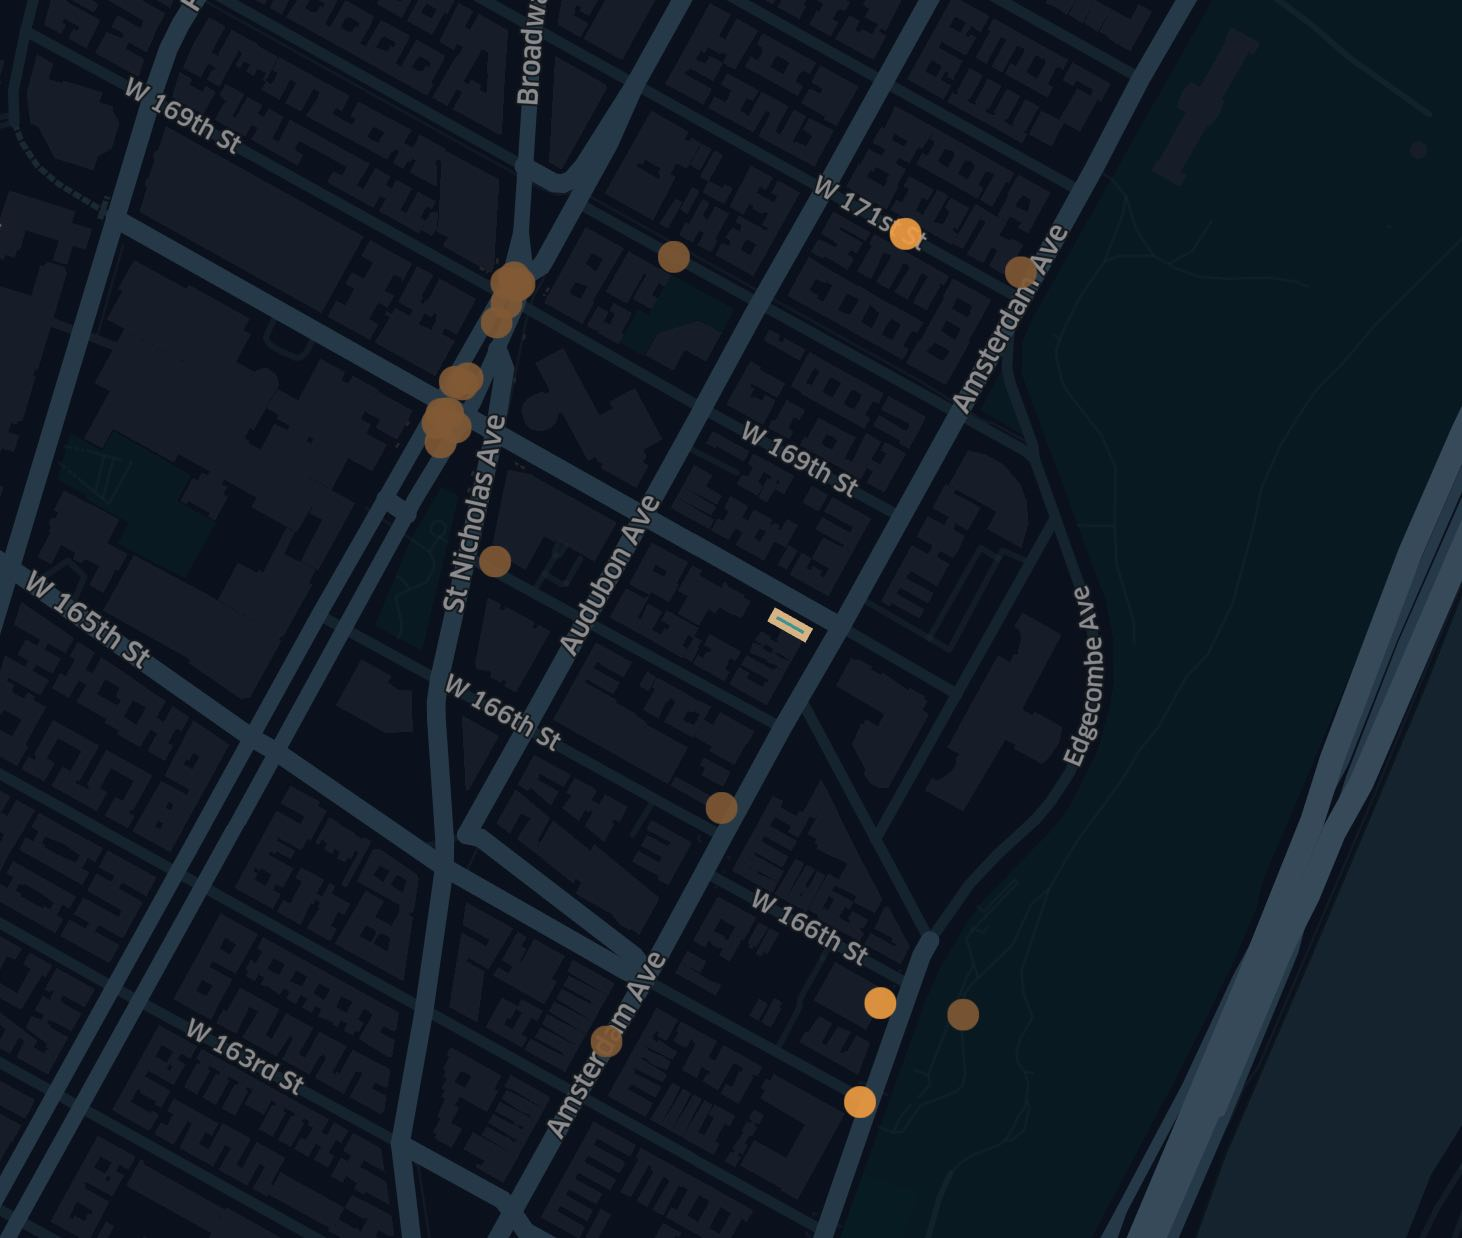

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABbagAwAEAAAAAQAABNakBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIBNYFtgMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAUFBQUFBQkFBQkNCQkJDRINDQ0NEhYSEhISEhYbFhYWFhYWGxsbGxsbGxsgICAgICAmJiYmJioqKioqKioqKir/2wBDAQcHBwsKCxIKChIsHhkeLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCz/3QAEAFz/2gAMAwEAAhEDEQA/APkyiiiugyCtG1XEefU1nVrou1AvoKBSI7htsR9+KzKuXbcqv41UUZYD1oCOxeiGIx+dSUdOBRQMjkiEnPQ+tQ7pYuGGRVqjrwaAGq6v900rKGGGGahaAHlODUZllQbWHPY0AQuArEDnFCsVOVOKbRQBcScHh+DU/XkVmVIkjJ06elAF+jrwajSVX46H0qSgCu8A6p+VVvnjb0NaNIyhhhhmgCBJx0f86bO+cKPrTJYhHyD1qIAsQq8k8CgDovDWp6npd4bjTWCkD5gwyCPQ16/peueHdevYZdSgW31CI5Xd0J9m7+wNeXWdsLWAR/xHlj71PJGkq7XGaHTuSqlmdF4q03WLXVZtVv082GQ4WROQijoCOorg9TvRxBEcg8t/QV00viXWtP0qXTzMJYZF2KX5dQewPfj1rzwkk5NJXWjG0m7ok2q3KcH0qVLiSP5X5FVakD8YbkUx2NJJEkGVNPIDDB5rLC/xRmp47oj5ZR+NMlx7CyWveP8AKqbKynDDBrXVlYZU5FIyK4wwzQCkZyTOvXkU0kyyfWppLVl5TkelVuQfQikVc0gABgU122KWqsk5HD80kz7yFXkUAMjQyNz+Jq/04FMjQIuO/en0AVJ3ydg7dagGc8davPEr+x9aYkARtxOaAHRGTkP2p7MFUse1OqpO+TsHbrQBEoMj49etXGiRhjGPemQJtXcepqegCi8Tpz1FRVp1C8KtyvBoApe1XIZE2hehqsyMn3hTKANOkIB4IzVJJmTjqKtpIr9KAHcKPQVSYmWTj6Cp53wu0dTSQJxvP4UATqAoCjtUXnpuIPT1p8gYoQvU1QIIODxQBpdeRRUECkLuPepGkVCA1AEU74Gz1pnkEoCOvpSIDLLuPTrVygDNKlThhipY5nj4HI9KtsFKnd0qgF3NhPwoA0o50k46H0qasYgg4PFTx3Lpw3IpkuPYsyWyPyvBqi8bxnDCtNJEkHymnkAjB5oEnYxqUcnFXZLUHmPj2qqI28wIRgmkWnc9EtPCeuzaLFc2Mnn28w3tAr4OfcHgnj61a03xVq+gxDSbiBXWP7iTgqy+3uKu2fhDW9H2TpqcVmSAfvMM/UHg11a3ukz24tfEl7ZXYHVuAf0/pWVy7HifiPV73WNSe5viNwAAC/dA9BWDWjq32X+0pxZDEIdtnOflzxz9Kz1GWA9a0RJoIMIB04p1FMkICHPpTECyK/3TT6oxSCM9M5q0ZU2lgc0AQzv/AAD8afAmF3HqarxqZH5+pq/04FABRRRQAUUUUAFQzvtXaOpqYkAZNZ7tvYtQAytfSbbzJfPYfKnT6/8A1qykRpHEacljgV2dvCtvCsS9v504ombsiaiiqGoXP2aA7T8zcD/GrMkrmLqdz58+xT8qcfj3rNoo68CszdKxLFH5hPYCkeN06jj1q6i7FC06gDM6dKtR3TLw/I/WnPArcrwaqspQ7TQFjVR1cZU5pWVWGGGRWQGKnKnBq5HddpPzpkuIklr3j/KqvzI3oRWuCGGQcimvGkgwwoBSM4zsU2n86lgTA3+tNktmXlOR+tQKzIflOKRVzRoqBJweH4NT9eRQBBPu2cdO9U6nnfLbR0FQqCxCjvQBNC77go5FXKjSNYySO9SUAFIcYOelQzSFMKvU1XMrldpNADWILEjgUgxnmkooA0VKlRt6U6q9umBvPerFABRRTWYKpY9qAK9w+TsHbmq1KSScmnwxNNKsSdWOKANfSLbcxuXHA4X610FRxRrDGsSdFGKkrRKxjJ3YVyV/c/aZyV+6vC/41tapc+TB5an5n4/DvXMKCxCjvUyZcF1J7dMnee1W6RVCjaO1LUlkTxI/PQ1VeNk69PWr9FAGZSglTkHBq28CtyvBqq6Mhw1AFqO67SfnVxWDDKnIrHpyOyHKnFAnE1XRXGGGapSWzLynI/WpY7pW4fg+tWuvIpk6oxqK1ZIUk6jn1qjJA8fPUetIpMiRtrBsZxVxZkbg8fWqNFAzTo6cmqMcrIcHkVZ3rIQoPXk/4UASDnn1paKOnJoAO9QvCrcrwamGcc0UAZ7IyfeFMrTIyMVXe3B5TigCpRSlSpwwxT403tjt3oAXyX2hhzmounBrTqKVUKlm7UAUaKKciNI4RBkk4FAGlpdr503muPlT9TXT1BbQLbwrEvbqfU1PWiVjGTuwrmtVuvNl8lD8qdfr/wDWrYv7n7NAWH3m4X/GuR68mpk+hUF1CplGBUajJqapKk+gUUUUEBRRRQAUUUUAFSJIV+lR0UAW8LIKruhT6U0MVORVlZFcYPWgCrRUzxY5WoaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0PkyiiiugyJIl3SKPetaqFouWLelX6ZEjLnbdKfbiiAZkz6UkkUiHLc+9MV2Q5WkWjRpGOAT1qFJ1PDcGpiwC7u1AECTg8PxVjryKzmO5i3rU8aSqwx0PJoAtUEAjB5ooJAGTQBRmRUbC96ipzMWYse9NoAuQJhdx6mleFW5Xg0JMh4Py1NQBnMjIcNU0Ur5CHnNWiAwwelRrCqvuFAEtFFQzvtTA6mgCvK+9+OgrV0i23MblxwvC/WsdEaRwicljgV2kESwRLEvRRTiiZuyJaKKzNUuvIh8tPvPx9BVsySuZGo3X2ibap+ROB7+9UEUu20U2rsCbV3HqazN0rCNAp+7xVVkZDhq0aRsYO7pQBmgkcipN4bhx+NNxlsL3PFIVKnDDFAEoDp80ZqzHdA8ScH1qiCV5FSblf73B9aBNGoCDyKjkiST7w59aoq0kPKnI/Srcdwj8Hg0ybWKklu6cjkVCCVOR1rZqCSBJORwaBqXcrpcA8PxVjryKoyQvH1HHrTVdk+6aRRoUVCkytw3BqagBrtsUtVOJPMfnp3q8QCMHmmqioMLQA4kAZNUTM5OQcVbkUuu0VRKMpwRQBajnDHDcGp6rxwgAMevWrBIAyaAK9w2AF9agSNpASO1DEyycd+lXVUKoUdqAKDKynDDFN6citIgMMHpVd7fun5UAVySxyxq+jKR8h4FZ5BBweKAxU5U4oA0qayqwwwzUCT9n/OrIIIyOaAEJCrnsKz2YsxY96sXD/wD8aiiTe/PQUAWYk2Jz1NS0UUAV7h8DYO9FumBvPeh4Sz7s8E81Y6cCgBrIr/eFVXhZeV5FXKKAM0Eg5HFWo7ojiTn3qR4lf2PrVSSMxnnvQDRqKyuMqc1LDby3c8dtbqXkkYKoHXJrFRmVhtOK9HsfBvigLBqVlsDECRGVwCMjjrSbEo6nSadD4/tl+zz263Vv0MdwyNx9c5/PNWdQ8H6fc2kt9JbNpssaFzsZXjJAzjGf6CsOfSfiA3+ua4f/dnX+hrB1LS/EFtbPPqENyqAcs77gM8c81Fi7+Rwj/eNOiAMgzUklu6/MPmFQAlTkda0JuaVFVkn7P8AnVkEEZHNAELwq3K8GqjoyHDVo1WH76TP8K0ASQpsXnqetS0UUAFFFFABRRSMQoLHtQBBO/GwfjVSlYliWPepYIWnlWJepNAGvpFt1unHsv8AU1vUyNFiQRpwFGBT60SMW7sOnJrkL65+0zlh90cL9K2tVufKh8lT8z/yrmamTLguoVYgTJ3nt0qBQWIUd60VUKNo7VJYtFFFACMQoLHtVAZkf3NS3D5OwdqfAmBvPfpQA17fAynPtVcgg4PFaVNdFcYagCijuhypxV2O5VuH4P6VVkhKcjkVDQDVzZqKSFJOvB9aoRzPH0PHpV6OdJOOh9KZFmilJA8fPUetMSRkPH5Vr1Xkt0fleDQNS7mb15NW4E43n8KgeJ4z8w/GlSV046ikUXqKYkiP0PPpT6AKk0TAl85FRxpvbHbvUk75OwdqniTYvuetADmRWGCKpSoI2wDmr9UdryOTjmgByTleG5FWldX+6azypU4YYqzAgA8w0AWaqXD5Owdql89CCfTtVMkk5NACV0OkW21DcuOW4X6VjWsBuZ1iHQ9fpXZKoRQqjAHAqooib6C0jMFUsxwByaWsbV7nYgtkPLct9KpszSuzGurg3M7Snp0H0pYE43n8KropdtorRAAGBWZuHTk1SMz79wPHpVt13LtziqTxMnuPWgC1HMH4PBqWoIEwu49TTTPh+OVoAs1VnYswjFTNIoQupzVeDBfLHntQA9rfj5TzVYqVOGGK0qQqGGGGaAM2pI5Xj+6ePSpHgI5Tn2qv04NAGlHcI/B4NWKxanjuHTg8imS49i3Jbo/I4NUZInjPzDj1rRjlST7p59KkIB4NArtGNRV+S1U8x8H0qkyMhwwxSLTJo5iOH5HrU+5XIAPvVClBIORxQBpUEgDJqtHP/C/51NnccDoOT/SgBwz1PU0tFFACFQwwwzSIipnb3p1FABVSd8nYO3WrLtsUtWd15NABW9pFr1unHsv9TWRbQNczLEvfqfQV2SIsaBEGABgVUURN9B1BOOTRWTqt15UXkIfmfr9P/r1TM0rmPfXJuZyw+6vC1Sop6DJzWZtsiRRgYpaKKDMKKKcq7jigBtFPZCvvTKAsFFFFABRRRQAUUUUATpL2b86e8Yfkdaq09HKfSgBpBBwaSrZCyLmqzKVODQA2iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9H5MoooroMjQtRiMn1NWajhG2JR7VBdtgKv40yN2W6rSWyNynB/SoI7l04bkVdSRJB8poDVGY8bxnDCk3NjbnitcgEYPNVJLUHmPj2pFKRWhALjPar1ZzKyHDDFSJMy8NyKBl2q9w+BsHepVkRhkHpVFmLMWPegBACxwOtXxGu0KRnFQ26fxn8Ks0AVmtx1U/gakiVlXD1LSMQoLHtQAtFVkuMnD8e9WQQRkc0AFUZm3SH24q3I+xCe/aqKqXYIvUnAoA2NHt9zm5YcLwPrXQ1FBCsEKxL/AAipa0SMZO7AkAZNcbeXBubhpO3QfSt7VbjyoPKX70nH4d65ipky4LqSxJvbnoOtXqZGmxAO/en1JYVXnfjYPxqdiFBY9qz/AJpH9zQBPAnO8/hVhlVhhhmlUBQFHaloAqPARynPtVfpwa06ayK/3hQBQVivSn/I/saSSMofbsajoAsLLLDweRV2OZJOnX0rNVyODyKdtVuUOD6UCaNSq0lsrcpwf0qFLh0+WQZH61dSRJBlTTJ1RlujIcMMUqSsnuPStUgMMMMiqclr3j/KkUpDklV+Oh9KkrNIKnDDBqVJmXhuRQMu0U1XV/umnUAFV5342D8asVVaFy+Scg0ALAnG8/hU7uqDLU7pwKoyvvfjoKALSSK/Tr6VJWaqljgdauw79nz/AK0APZVYYYZrPYAMQOlXpX2L7npVWJN789BQBFTldkOVq68av16+tVXidOeooAjJJOTV2JNic9TVGraTg8Px70AWKKMjGe1RJMjHHQ0AS0UUUAFFFFABVW5/hFWqp3H3x9KAIQcHNemfDy8vr3W0t7i5kMUUbMELnBxgAYz2zXmVbnh59Uj1OOTSAzXC8qFGc+ufbHWpktBo6++8R69FqFws97LbsJGAjxwADxgEVrXF9qWreBrq5v5WYxTAK/TeuRwQMA8mumGp+KGjB1DQ0mfHVXX+RzXD+MtU8R3disN7ZGytVYYA6E9sn+mKkdjiahkgSTnofWqUc7x8dR6VejmSTpwfStTKzRQkhePr09aYjshyta9VpLZW5Tg/pQNSK7T7kxjBNWI1CIB1qk8bxnDChJGTpSKNCiokmV+OhqWgAooooAKqXD5Owdqsu2xS1Z3Xk0AFdJpNt5cZuG+8/T6f/XrFs7c3M4j7dW+ldgAAABwBVRRE30FprsqKXY4AGTTqxNXucAWyd+W/oKpszSuzGuZ2uJmlbv0HoKgopyKXbaKzNyxAnG8/hVmgAAYFFABR9KPaigCl5L7wG796u9OBRRQAUUVHK+xfc9KAIJ3LNsHb+dSeQu3Hf1qvGVVwWq+CCMjmgCg8TJ7j1qOtOoXhVuV4NAEUdw6cHkVdjlST7p59KzWRk+8KYCRyKBNGyQCMGqslqDzHx7VHHdMvEnI9auK6uMqc0ydUZTIyHDDFSLOyjB5rSZVYYYZFU5LUjmPn2pFKRHAu5t57VbrN+ZT6EVYSfs/50DLVHvSBgwypzS0AIyhhhhmlAAGBRRQBWnRAN3c1VqWV978dBViwtvtM4B+6vLf4UA2bel23kw+aw+Z+fw7Vp0UVojBu4yWRYY2lfoozXGTStPK0r9WNa2r3OWFsh4HLfXsKyI03uB271MmawXUsQJhdx6mp6KgmkKYC9etSUT0VCkyN14NTUANdSylRxmoDANvXnv6VZqvcPgbB3oAqe1W4EwN579Krou9gtaHTgUAFMWRH4BqOd9q7R1NNgT+M/hQBZpjxq45/On01XVuFOaAKjwsnI5FQ1p1E8Svz0PrQBR6dKtR3TLw/IqF43TqOPWo6Asa6OrjKnNKyqwwwyKyFYqcqcGrkd12k/OmS4iSWpHMf5VUIIODxWwCGGQcimvGkgwwoBSMilDFTlTirElsycryKrUirl2KXf8rdamrMqwk5UYbn3oAt0UisGGVOaZK+xfc9KAK0z7m2joKhoq9p9r9pnAb7i8t/hQDZs6Xa+TD5rj5n/QVqUUVojBu4ySRYkMj8BRk1xs8zXErSv1Naur3WWFsh4HLf0FYlTJmkF1FAycVMBgYpiDvUlSEmFFFFBIVPGMLn1qEAk4FWQMDFBUULTGQN7Gn0UF2KzIy9abVuq8gAbAoIcbDKKKKCQooooAKKKKAHKxU5FWQVkWqlKCVORQA50KH2plW1dZBg/lUDxleR0oAjooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0vkylUbmA9akkj8vHOc0tuMyj25roMjTrPumzJj0FaNZMrbpGPvTJiMAJzjtQCQcirVuPlJp7wq/PQ0ihkd0RxJz71dV1cZU5rKZGT7wpqsynKnBoE4muyqwwwzVOS1I5j59qWO67SfnVwEMMqcimTqjHIKnB4NJ9a13jSQYYVSktmXlOR+tIpSJ0Klfl6U6s4FlORwasJP2f86BlmkIDDB6UoIIyOaKAKrwd0/KoQzRnjj2rQprqrKd1AFKSQyYyMYq/pUPmXW89EGfx7VmV0+kw+XbeYernP4dqa3FJ2RqUUVUvpvItXcdSMD6mrMUc1ezm4uGfsOB9BUMK7nz2HNRVehXamT35rM3JaKKKAIpldhhfxpkCYBY9elWKKACo5X2LkdakqpzNJ/sigC0p3KG6ZpaaXVTtJwadQAdeDVd4AeU4qxRQBnMrKcMMU2tFgGO09uaheAdU/KgCAP2fkUoU/ejNRlSpwwxQCRyKALkd0R8so/GrasGGVORWXvDcOPxpw3x/NGciglo0XRXGGGapSWzLynI/WpY7pW4fg1a68imLVGPyDU6XBHD81dkhSTqOfWqMlu8fPUUiky2GDDKnNLWaGKnKnFWkuAeH4oGWKayK33hmndeRRQBGkSocipKKhnfamB1NAFeVt74HQcCrcabEA796rwJk7z2q0xCgse1AC0VQMrltwOKsRzbztbg0AK8KN04NVWRk+8K0KqXDZIUdqAIQzAEA8Gp4EOd5/Co4k3tz0HWr1ABQSAMmiq07/wD8aAGCdgcnkelXKzQCTgVpUAFU7ggv9BVyqM3+sNAEVen/DpxbxanexgGWG33J+p/oK8wrrfCmn65qNxJBozmLK4kfOFCn19fpUy2GjuLbW9el8IS6nFO8lx9pCswAJVMemOlUvFdxqN/4Qsb/UWZZWkKsp4DdcNj1wP1ro9G8L+JfD+/+zby3cPy0bhtpI7+oNefeNr3xDNdrba6oQpkoqD5MHuD3qEUzhaKKtQqrRkMM81qQJHcsnDcirqSJIMqaoPAw5XkVCCVPHBFAmjYIDDBGRVOS17x/lSR3RHEn51cVlYZU5FMnVGQyspwwwakSVk46j0rSZFcYYZqlJasvKcj0pFKRMkiv0p9ZvIPoRUoncDHWgYTPubaOgqGitDTrb7ROCw+VOT/AEFAN2NrTbb7PBuYfM/J+nYVo0UVoYN3IppVgiaV+iiuNlkaWRpH6sc1q6vc73Fuh4Xk/WsapkzWCsrhVyBMLuPU1XjTe4HbvV+pKCoZJdjAdfWpqpvC+SRzQAx5Cz7hx6VKk56P+dOhjwCzd+1K8CnleDQA5ZkY4FS1WhjKsS3UVZoAOnJqhI+9s9u1TzvgbB3pkCZO49KAK9X4gRGM00wLu3D8qmoAKKilfYnHU1VWR0PB60AX+vBqu9uDynFSRyiTjofSpKAM0qVOGGKFZlOVODWiVDDDDNVngPVPyoAkjuu0n51cBDDI5rGp6SPGcqaBOJpvGkgwwqlJbOnK8ip47lW4fg/pVmmTdoyFZkORwaspcA8PxVmSFJOTwfWqMkDx89R60iky715FRTPsXjqaqK7J900O5c5NAxlddYW32aABvvNy3+FYml23nT+Yw+VOfx7V1FVFdTOb6BUFzOtvC0rdug9TU9czqtz5s3kqflT+dU2TFXZmOzOxdjkk5NXIk2Jz1NV4U3tk9BV2szYKayqwwwzTGlVW2mpevIoAqPARynIpiyunB5HoavUx41cc/nQA0TIVznHtVJiWJY96V1CttBzTaALsKbV3HqamJAGTVZJx0f8AOidxtCr3oAiJMsn1q8AAMCoIEwu49TU/Tk0ARTPsXA6mqSgsQo706Ri7bj+FWIEwN570AWKKOnJrPdyz7vyoA0OvBqB4FPK8GkilZ22t6VYoAzmRkOGptaZAIweapTKinC/jQAxJHjOVNXY7lW4fg/pVAgqcHrSUA0bNRSQpJyeD61QjmePpyPSr0c6ScdD6UyLNFKSB4+eo9ahraqtJbI/K8GgakZ4YqcqcU53Z8bu1DxvGfmFMpFCgEnA6muvsrYWsAQ/ePLfWsbSbXzJPtDj5U6fX/wCtXSVUUZzfQKr3VwttAZT16AepqxXLandefPsU/InA9z3qm7ExV2Z7MzsXY5J5JpAMnFJUqDAzWZq3YfRRRQZhRRSqCxwKAJY1/iNS0dOKKDVKwUdOaKilb+GgG7C+YMZ71B15oooM27hRRRQIKKKKACiiigAooooAUEjkVZSQNwetVaKAJpIscrUNWEl7N+dK8QbletAFailIIODSUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0/lKc5fHpUtoPmLegqqTkknvV+1GI8+proMZbFhztUt6CsetO4OIj78VnIu5gvrQES9GNqAU+iigZWuG6L+NVaklJMhzUdABT0dkOVOKZRQBfjulbh+DVoHPIrGqRJXj+6fwpkuJoyRJJ94c+tUpLd05HIq1HcI/DcGrFArtGOrshytWknU8NwankgSTnofUVRkhePryPUUiky915FQzthMeta76DqFvokeu5HkSMVwTznOOnv7VgSyGTBxgUk7lDY0Msixr1Y4rtkQIgReijArnNIh33BlPRB+prpa0iZTetgrn9ZmyyQDt8x/pXQdOTXF3MvnzvL6nj6dqJCgtSEYzzV9JFfpUcSAx4YZzzUbwFfmQ5x+dQaluopn2Lx1PSoEnYcNyKZIxkfj6CgCSEyZ+XkVbpqLsULTunJoAhnfamB1NVo5DGeO9I7b2LUygB5zI/uavqoUbR2rNqUTOFK9fegC0sqMcA81ISAMms0Ak4FWJWCoIgfrQBYQgjcOc06q1uvVz9Ks0AIVDDDDNVXtyOU5q3RQBmdODShivIrQZFf7wqo8Lr05FACZR/vcH1pytJD93kfpUFOVyvSgDQjuEfg8GrFZXyP04NSJNLFw3IpkuJZkt0fkcGqMkTx/eHHrWjHKkn3Tz6VIRng0CTsZKuyfdNWkmVuG4NOktVblOD6VSZGQ4YYpFpmjSEBhg9KpJK6cdRVpJFfp19KAHqoUYHSo5ULjANS0UAZ/lyZxg1bWJVII6ipaKAGuwRdxrP5Y+5qad8ttHQUsCZO89qALEabEA796fRRQA12CLuNZ5JY5PWpp33NtHQVBQA5Pvr9RWjWaM5GOtaVABVCU5kJq/Wc/32+poAbXrPg6O5m8I6nDpeftTMMBThsYHT9cV5NXougWN9p2gS+KdMujHJE2xowuQRkdeffPSpkUjNFpfRPiKC6SftgODmui+IJmGmaUl/wA3YiPmZ69F6/jVxfHHiQx4225J/i2t/jXnniG9vr++8+/l82Rlz6ADJ4A9KLPqSmtkzBq9AMRg+tUavQ/6sVQEtMeNH6jn1p9FAFF4nTnqKYrshypxWjUTwq/I4NACx3QPEnHvVoEHkVksjJ94UqSvGflP4UyXE0ZIkk+8OfWqUlu6cjkVajuEfg8GrFArtGMAScCuvsrYW0AQ/ePLfWqNpaRvKJyPu9PrWzVRQpSvoFVru4FtA0p69B9as1y+p3Pnz+Wp+VOPx7027ExV2ZrMWYs3JPJpKKmgTc+T0FZmxYiTYnPU1KSAMniimugcYNADBMhJGcVLVF4mTnqPWhJWTjqPSgC9QSAMmo0lV/Y+lRTv/APxoAgLsX396mW47OPyqOFA7c9BUr2/dPyoArMSxLHvVmKZQAjcVWKlThhikoA0+vIorPV2T7pq0kytw3BoASWIvyD+FVCCDg8VpU1lVhhhmgCOBNqZPU1NRUcr7EyOvagCTIzjvUM77V2jqap5Oc96kQGVxu5oAljhDJlu9RvCycjkVdooAzKljmePocj0qy8SPz0NVXjdOo49aAL8c6ScdD6VPWLViO4dOG5FMlx7FmS2R+V4NU2hkVgmMknArRSVJB8p/CtKyi3N5rdB0+tFhc1i3a24toFiHXqfrViiirMynfXP2aAuPvHhfrXI8k+pNXtRuftE52n5U4H+NV4Ey249qhs1irIsxpsXFK7bFLU6jrwaRRmdeTVm3DZJ7U94FPK8GnHEMf8AnrQBLTXbYpaq0LqpO48mknYl9vYUAQdeTUzQuoyOaWBNzbj0FXKAMyirk6pt3HrVTBxnHFAFuOZTweP5UszE4jXq1UqcjFDuFAF/Yu3YRxTunAqJJUfjoaloArzvgbB3qpWg8auOfzquIDvweRQBLAm1dx6mpWIUFj2parXD/wAA/GgAW4GfmGBTYlMkm9u1V+vArRRdihaABlVhhhmqzwEcpyKt0UAZnTg0VoPGr9aqPCyc9RQA+O4dOG5FXklSQfKfwrJpQSDkUCaNggEYPNVjZ+YwWLgntUUd0RxJz71v2CAr5/r0prUl3RcghWCJYk6KKlopCQoLNwByaszKGo3X2eDap+d+B/U1ylWry4NzOZO3QD2qrUN3NoqyHKMmpqaowKdSIk7hRRRQIKnjXAye9RIu4+1WaCorqFFFFBYhOBmqxJJyafI2Tj0qOgiTCiiigkKKKKACiiigAooooAKKKKACiiigAqRJCvHUVHRQBb+SQVXeMr9KaCVORVhJA3DdaAK1FTvF3X8qg6UAFFFFABRRRQAUUUUAFFFFABRRRQB//9T5NJySRxWrENsaj2rJrZrpRhIp3Z4VfxqG3XL59KddH95+FPt/uE+9Ia2J6KKKBiEA8EZqPyY8ggdKlooAiaGM9sfSojbn+E/nVqigDPaN1+8KZWnTWjRvvCgDOqaOd4+Oo9KdJCqqWB6VXoA1I50k4HB9KlILfKoyTwB9axq6bwqIZ9ctY72RUiWQMS5wOOQM+54ob0Fy6ne+KrO5kh0vwfp67pFQO4HrjGT7dTUOu+HvD+leF2dB5lzE4j80HG5zyw9wBWn4t1yDR5549PYPf3QAeQc+XGOAo9z1/wAikvNAnv4tN8PbtkNtF591Iexb+p5rI0POtNtruHTjfC3c2+7DSgZAP+FaAIIBHQ1t67rEN+q6NpA8vTrf5eP+WhH9P51hFiGWKNGdj0VASePYVtBu12YTSvZFTUZvJtGI6t8o/GuTAJOBXR6za6gI0llt5Yoh3dSoJ/GsGAZk+nNDdyoqyLoAAwKa+4qQnWnUUijNKlThhilVS3CjNX2VWGGGaRIxHnHegCqkzLw3IqSWZWTC96klRCpY9fWoIEDNk9qAEaF1GRzUNadRvGr9evrQBQoqSSMxnnvUdACgEnAq40KsBk8+vrVRWKHcKtpMrcNwaAJQAowOlDEKCx7UtVZ352D8aAI0ZzJweTV6oIEwN56mp6ACimswVSx7VWjlkL465NAEzxI/PQ1WeJk56j1q9RQBmU9XI4PIq08KN04NVXjZDz+dADtoblDg+lTJcuh2yDP86qVIHzw/IoCxpo6uMqc0rKrDDDIrMCkfNEasR3XaQfjTJa7CSWveP8qqEFTgjBrYBDDIORTXjSQYYUApGek7Lw3Iq0jq4ytV5LZl5TkfrVcEg8cGkVc0qKqpP2f86dLKNmFOc0AVtuW2rzWgoCgKO1QQJgbz3qxQAUU122KWqGGR3ODyKAHLCqvuH5Urwq/PQ1LRQBnqMSAe9aFQeQA4ZTwDU9ABWaxyxPrWlWZQAV6p4Q13w9pemvbX/ml5siRAu5CO3HriuQ8JaTHrWuQ2U/8AqzlnxxwoyR+NemyR+D9Wv5PDVtaeRMpZEmVQPmTryDk9O/WokykZxHw1mYlZJYc9h5gA/Q1wPiaPSIr8LosrTQbR8zEk55yOQK9VhuPBi6j/AMI2LAHD+T5pUHLj/a+9+NeT+J9NTSdbnsIySkbfLnrtIyPyBpR3BnP1oRDEYFZ9aKfcX6CtCR1FFFABRRRQAdeDVWWEAFl7dqtVBO+BsHU0AU6tWzzNIsSfNuOMGqtdHpVp5cf2hx8zdPp/9emkKTsjVjQRoEHan0UVZiVbyVo4TsOGbgVyLo6HDCt24nWaUhDkLxUBAYYYZFS9S46GNVuGRAoXoadJa94/yqmQVOGGDUmiZpUVQSVk9x6VaSVH46GgCWonhV+ehqWigDPeNkPP500kk5PNXpW2oT68VQoAuwsm3aOtTVmVfi3bAWOc0AOZVYYYZqs9uRynNW6KAM0gg4PFJVyfaFyRz2qFoHAyOaAGpKye49KtpKr+x9KodODRQBp0ySMSDntVZJmXhuRVgSoVLA9KAKTqUbaafFJ5ZPGQaaA0r/WrhijIxjH0oAcjq4ytOqvHCUfcTkCrFABRRRQBA8CnleDVVlKnae1X2YKpY9qzySxyetAD4keWVY4/vE4FdpFGIoxGOwrH0i2wpuX6nhfp3NbdXFGU3rYKq3cuyIqOrcVZJCgseAK5qS/WaYluB0H0obFFXKslqRzHz7VW+ZG9CK1wQRkc0x40kHzCpNFLuU0uOz/nVkEEZHNVJLZ05XkVCrMhyKRRo0EAjB5qBJ1bhuDU9AFWSEAFlOB6VW68CrU7ZIjWiOJkkyRx60ATouxQtOoqKV9icdTQBXmfe+F5Aq2i7FC1WgTJ3nt0q3QBA8CtyvBqoRgkHtV6V9i8dT0qvDGGOT0FAEFSpMycdRUz24PKcVVKlThhigC+kiP0PPpT6zOnIqwk5HD8igC3VGVHVizd+9XFZWGVOaqTvufA6CgCHpyKsJORw/IqvRQBPJMS2UOAKlScHh+DTYYxtJYdaHt+6flQBZ68iiq9urDOeKsUAV50QLu6GqlSzPvbjoKioAmt4WuJliXua7NEWNAicADArI0i22Rm4YctwPpWzVxRlN3dgrG1e52ILdDy3J+la7usaGR+Aoya4yeZp5Wlb+I0SYQWtyGnoMnNMqcDAxUGkmLRRTkXc2DQZjkTPJ6UrRkcrzU1FBpyoai7R706iigYU122rmnVXdtzUCk7DKKKKDMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCVJSvDcipmVZBkfnVSnKxU5FAAylTzTatq6yDB/KoniI5XkUAQ0UUUAFFFFABRRRQAUUUUAf//V+TK2R0rGrYX7o+ldKMJFC6/1g+lOtz8pFJd/6wfSktzyRSKWxaooooAKKKKACiiigAooooAr3G4qABx1qpWnTWRW+8M0AZ1KCRyKVgAxA9abQBds7oQXkV1MvmCNg2098HpXpWs+MBr8f2LTUaCOQBrgk/Mx6BcjtXlFdLo8Wy3Mp6uf0FCjdhKVkaqqqqFUYAqzpY1H+2oE0mTZPL8hOAcJ1Y81QuPM8k+XnPt1x3xXoXhu30e1trrUvD8jXd2YsJFJgOp9OfU0VH0Ipq7uYfxF1l7iVNCtn3LbgGU+r44H4D9TXLaR4M8QanbC9tYwsbfdLkLu+lW/DWlvr+viG8ywUtLPnvg8g/U12+o3GmeKbv8As/S9RltpocrFHjbGSvoRWd7bGu+rPLtR0vUNIn+z6jEYmPTPIP0I4NUK624l8Sa5NH4TuyJJYZCMtyRgYOW9AO9aVx8Pp4o3TT72K5niGXhHDfhyf1xVKXcLdjgKKCdrmNxtZTgg9c0yR9i5qiSvO+TsHQVCrFDkU3ryangTc249BQBbU7hkjFL05NFQTtgbB1NADF/fS7j0FOeAHlOPapkXYoWnUAZzKynDDFNq3cMAu3uagSNnBI7UACSsnuPSkRTI+D3600gg4PFJQBp9OBRVNJmXhuRU5mTZuB59KAIZ3ydg7UsCc7z+FQopkfH51oAADAoAKKKRmCjce1AC1UuHydg7VKJkKk9x2qmSScmgBVUscKM0hBBweKtwJtXcepqVlVhhhmgDPBI5FSb1bhx+NOeBhyvIqDpwaAJhvj+aM8VajuVbh+D+lUAxXkVJlH+9wfWgTRqVFJCknXg+tUleWHpyKuRzpJx0PpTJtYpSQPHz1HrUNbVV5LdH5Xg0DUu5Wjnxw/T2qyGDDKnNUXieM/MPxpqsynKnFIolnfc20dBViJNi+561Ui27wWOMVf68igAooooAKKKKACsytF/uN9DWdQB33w7ntbbXvPu5EiURtguQBk4GOa9E0zw7pNprg1qLUUl+d32ZXq+e4PvXz8CR0rqbS1ge2jZ0BJXJNTyNg5WPU7bwXImuLqovEkjE5n2Ac5JzjOa8u8cSeZ4nvD6OB+SgVMLSBfugr9CRXK3RJuJOScMRz9afI1uCmnsV60lGFAPYVm1p0wCiiigAooooAQkKMnpWezFmLHvVi4f+AfjVZVZ2CqMk8AUAXbC1N1Ng/cXlv8K60AAYFVbO2W1hEY69SferVWlYxk7sKqX0/wBntmcfePA+pq3XNatceZOIV6J/M02wirsygSpyDg1bjuu0n51TpcHGe1ZmzRrqwYZU5FI6K4wwzWUjshypxV2O6VuH4PrTJaIpLZl5TkfrVWtnryKjkhST7w59aAUu5QSZ168irSSK44/Kq0kDx89R61B05FIollYyPgfQVZ8lCoBHTvVaJlRstV0MGGVOaAKv2c7gM8etW+nAoooAKqm4IY4GRUszFU471R68CgC0n72Teeg6VZpqLsULTiQOtADHjV+tVXhZORyKu0UAZlFTz7d+AOe9RFGA3EcGgC1AmF3etT1nK7IcrVpJ1bhuDQBPRRRQAUUUyR9i5oArzvk7B0FJbQNczLEvfqfQVB15NdNpVt5UPnMPmf8AlTSuKTsjTRVRQijAAwKdRTJJFiQyPwFGTVmJlatc+XGLdDy/X6f/AF65ypp5mnlaVupNNiQO+D0qGzaKshEkeM5U1ejuUfhuDVZ7cjlOar9ODSG0bVQyQJJz0PrVGOZ4+ByPSr0c6ScdD6UyLNFGSF4+TyPWmpIydOnpWtVaS2R+V4NA1LuVoAC5ZjzVus943jOGFPSZl4bkUii79Koyby/z8dvariur/dNO68GgBFUKNo7UtFV5ZcZQdaAIZGMj8fQVcRQi7RVeBOd5/CrVABVKVjI+B06CrEz7F46mobdMnee1AA1uwGV5qAgg4PFaVQzbNuWHPagCmCQcjikpSCOtJQAU+NN7YplXoU2Lz1PWgCXpwKKKKACqzTgqQOvanTvtXaOpqnQAVYtYDczrEO/X6VXrpdJtvKh89vvP0+lNIUnZGqqhVCqMAcClopksixRtI/RRmrMTH1e5wotlPXlv6Vz9STStNK0r9WOaYBk4qGzZKyHoO9SUUUiG7hU8QwM+tQVMjrjB4oCO5LRRRQaBRRRQAjDII6VVqxIcL9ar0ESCiiigkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKnSXs351BRQBaeMNyOtViCpwacjlPpVj5JBQBUoqR4yvPUVHQAUUUUAFFFFAH//1vljbGvXH41dXoMVSEca8n9atRurjCnkV0owZUu/vD6VFAcSY9RUt5kOoI7VWRtjBvSkNbGjRUSSo/HQ1LQMKKKKACiiigAooooAKKKKAKs6c7x+NVq0JMbDn0rPoAUAk4Heu1gjEMKxD+EAVy2nRebdoD0X5j+FddVRM5voFYup3D20sb25KScncvBx9RW1XI6hL5t257L8o/CnLYUNzpPBviCHQ9TaW8BMMymNyOoB5z+ldrp1j4S0K6OvDUVuEiy0UQxuBPqOpP4CvGgpY4AzRuNZOJtc9K8PeJLeDxRLq+ojYl1uBYc7NxGPw4xXQ6D4UubXxCmrQXcU1qpZzIjZYhgeCP51zOl6z4Xv9Ni0vX4DC0Awk8Q5x745/nVvUPEWkafpjaF4UD/vuJJm4Y57Dvz06VBQ+08MR+LNYudVWVVtvtDhlX7+3qCB71xc2kz3esPpemxyMQ7KiuMNgevTHFeg6lM/g/w9Bo9m+y+uv3szr1Uf54H41peHpvs1nJ4s8Q3AjnugIoXZc4UDrgepGad2B4pc2s9pcNa3ClZEOCp7GrKLsULXS+JvDE9hAusw3AvLe4OfNXjk889etcgkzLw3Iq07ksuVCIz5hd+fSpFdX+6adTEFFFMMiK20mgBkkIc7hwakVQqhR2p3XkUUANZFcYaqUiBGwDmrzEKCx7VQGZH9zQAyitBo1ZdpHTpVZ4GXleRQA6GRFG08E96tVmVIkjp0PHpQBfpjoHXBpqTK/B4NS0AUXiZOeo9ajGMjPStKoXhRunBoAkVw4ytOpqKEXaKdQAUx41cc/nTyQOtFAFJ4XXpyKhrTqN41fr19aAKSuV6U/CP04NDxOnPUVFQBZSaSLhuRV2OVJB8p59KzA5HB5FO2g8xnB9KBNGoQCMGqslqDzHx7VGlyynbIM1cV1cZU5pk6oymRkOGGKVXZPumtVlVhhhmqclqRzHz7UilIVJkbrwamrNIIODxUiSunHUUDL1FRpKr+x9KkoAa/3G+hrOq/KcRk1QoAK7W2GLaMeij+VcVXcRjbGo9AKqJFQfXESndKx9Sa7cnAzXCE5OaJCpigEnArSrOT76/UVo1JoFFFFABTWYKpY9qdVOd8ttHQUAQkknJrc0m0/wCXpx7L/jWXaW7XUwjHTqT6CuwVVRQijAHAqooib6DqKKKsyIbiYQQtKf4R+tcWzFmLNyScmtvWJ8lbde3zH+lYdRJm0FoKoLEKO9aCqFXbUECcbz+FWakorvADyn5VVKlThhitKkZQwwwzQBRjleP7p49KvR3CPweDVV4COU5qv04NAmjaqvJbo/I4NVI7h04PIq9HKkn3Tz6UybNGdJE8f3hx601WKnKnFa5APBqrJaqeY+D6UDUiNLgHh+KsAgjI5rOZGQ4YYoR2Q5WkUaNRiJQ+8flTEnU8Nwan68igAqnM5Ztg7VYlfYvHU9KrwJltx6CgC0i7VCntQ7BF3GnVTnfLbR0FADY1Mj8/U1e68Gook2Jz1NS0AVZo0UbhwfSoCrL94Yqx/rZf9laskAjB5oAoJKye49KvjOOarvbg8pxUIaWI4P60AXqozPvbjoOlStOCnHBqrQBcsbb7TOEP3Ry30rr+nAqhp1t9mgG4fM3J/wAKv1aRlJ3YVg6vc9LVD7t/QVsXEy28LSt2/nXGO7SOZH5LHJokxwXUbV2BNqZPU1WjQs4B6dfwq/UGgU1kV/vCnUUAUnhZeV5FQ1p1G8Svz0PrQBBHcunDcirySJIPlNZrxMnuPWmAkHI4oE0bBAIweaqSWoPMfHtTI7ojiTn3q6rK4ypzTJ1RklWQ4PBqZJyOH5960GRXGGGapSWpHMfPtSKUidWDDKnNIyK/3hVAFkPHBqwk/Z/zoGTogQYGfxpSQOScUoIIyOaa6K4w1AFNiZZOPoKuqAoCjtUEcRR8nmrFABVQ/vpcdhU0z7FwOpohTYvPU9aAJCoYYYZqu9v3T8qs0UAVIozvy3G2rdNZgqlj2qJJ1PDcGgCegkAZNFV5342D8aAKzsXbcabRRQBas7c3M6x9up+ldgAAMDoKzdLtvJg8xh8z8/h2rTq0jKbuwrB1i56Wy/Vv6CtqaVYYmlfoozXFySNLIZH6sc0SY4LqMqVBgZpijJqaoKk+gUUUUEBSgZOBSVPGuBuNA0rkgGBgUUUUGgUUE4GTULvngUCbsNdtx46UyiigzCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUEg5FJRQBYEwx8wqvRRQAUUUUAFFFFAH//X+TSSetPido3DL196joroMjQuIZPL8yRtxH5YrPrSSWSaLy0XJxgk9Kz3RkYo3UUCQ3pyK0Ubeoas6p4H2ttPQ0DLlFFFABRRRQAUUUUAFFFFAEFw2FC+tU6mnOZPpxUNAG/o0WFeY9/lH9a3Kq2UXk2qJ3xk/U81arRGMndkU8ghheU/wjNcUSScmuk1iXZbiIdXP6CuaqZFwWhat16t+FTPGj9Rz60RLtQCn1JZReJ056ilt5mt5knTqhDD6irtRPCr8jg0Adze6tpfi7UrI3C/ZZWISeRm+XaPT60vi3VBrGrR6Tpg3Q22IYlXoWPGR/IV50yPGeePetTRdXk0bUY9RRFkaM8B+npUcpVz0PxW0Oj6NZ+E4TudcSzH354/EmuN0PQ01nV4bAHYrklj6KBk496z73Vp9R1CW9uOWmbJ9vQfQVtiDWPDc9pq7x7N4EkZ6gg9VP1FPZC63Oum0XwJc3b6JbyyW11G2wOxO0sO3PHX6V51qVnPpV/LYTFZDEcFkORXeeLrSy1PSoPF1ivlmYhZV9+Rn6gjHvW5ounaXZaDHfzhLa9vYjGjzncCTk7sHpn/AAqU7FWPHC6hS3pVEBpH9zU97A1tdSQOwYoxUleQcHHBqOGRUPzDr3rREl0AAYFFAIIyOaKBFWd+dg/GnW6YG896R4CWyD1qyAAMCgAoophkQNtJwaAEeNX69fWqrxOnPUVeooAzKlSV046irDwo3Tg1VZGT7woAuJKr8dD6VJWZUyTOvXkUAXaKYkiuOPyp9AFGZ97cdB0ojldSFHPtUr2+TlOPalhjKksw5oAsUUUUAFUZWVn+X86szOUTjqeKo9eBQAuDjd2pK0UXagU1E8CnleDQBXD54fmnAFTuiNRsrKcMMUgJHIoAux3XaTj3q2CCMjmsvcrcP+dKpkj+aM5FBLiaDxpIPmFUpLZ05XkVYjuVbhuDVmmK7Ri1OkzLw3Iq7JAknJ4PrVGSB4+TyPWkUmSySI0ZAPJqpRRQMVRlgPWu6riYBunQerD+ddtVRM6hHMdsTn0U1xFdndnFrKf9k/yrjKJDgOT76/UVo1Rh/wBYKvVJYUUUUAMkfYhPftVDkn1NSSvvfjoK0tKtPNk+0OPlTp7n/wCtQgbsaun2v2aH5h87cn/Cr9FFaGDdwprusaF26KMmnVj6vPsiEC9X5P0FDBK7MCaVppWlbqxzSIu9gtMq7Am1dx6mszcmAAGBRRRQAUUUUAFRyIjDLdu9SUyRS67QcUAZ9HTkVbFuNuD19arvGydaAJ47pl4fkfrV1HVxlTmsilDFTlTg0CcTXZVYYYZFU5LU9Y/ypY7rtJ+dXAQwyDkUydUY5BU4Iwaekjp0PHpWm8aSDDCqMlsy8pyP1pFJkTuZW/kKuqoVQo7Vn8g1Ok5HD80DLdVVhPmZfkfzqwrKwypzTqACopn2Lx1PSpaqSrIzFscDigBkcpQ47VcVg4yKzqvxJsX3PWgCSkOMfN0pagnfC7R1NAFRsEnHArR0y28+few+VOT9e1ZwBYhRyTXY2duLaAR9+p+tNImTsizRRVW9uBbQGT+I8L9asyRi6tc+ZL5Cn5U6/X/61ZkSb29h1phJJyepq7CoVAR3rNm6ViWkZgoyelLUUyM64XtQBKCCMjmiqAaSI46e1XI33ruIxQA+iikZgo3HtQAuecVC8KtyvBpsUu5tpHJqxQBnsjJ94UisyHKnFaJAIwearPAOqflQBJHdA8Sce9WwQRkc1jlSpwwxT0keM/KaBOJpPEkg+YfjVGS3dOV5FWY7lH4bg1Zpk3aMdXZDlatJOrcNwankgSTnofWqMkLx9RketIpMvUVQSVk9x6VaWZCuemO1AyIqWmAkxVqs1iWJY96kSV046igC9RTEkR+h59KV22KWoAqzvlto6CoKOvJooAkSRk6dPSmMSxLHvSUUAFXLG3+03AQ/dHLfSqddVptt5FvuYfM/J+namkKTsjR6dKKKhuJlghaVuwqzExdXudzC2U8Dlvr2rEpzu0jl25JOTSoMnNQ2bLRD1GBTqKKRmFFFFADlG44qzTI1wufWn0GkUFFFIx2jNAyKRudoqKiigybuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKATwKcUYDNAWGUUUUAFFFFABRRRQB//9D5MoooroMizbTeU/P3T1qW4xcfNEpO3qao1p2lwuzy3ONvT6UCfczKKmmUbi6AhCeKhoGaEb70B796fVKF9jYPQ1cBB5BzQAtFFFABRRRQAUx5FTrUEszZKrxiq3Xk0AKSScmp7WLzrhI+xPP071Xra0aLMrzH+EYH400JuyOhooprMEUu3QDJqzE5nVZfMuig6IMf1qhGhdhxx3pJHMjtI3Vjn86uRY8sYrNm6VkSUUUUAFFFFAB14NV3gB5Tj2qxRQBnFWQ4PBruNF8b3On2f9m6hCl5bDoknb6HB4/CuXKhhhhmqzwHqn5Umrjuekpri+MdVstDSJbWxV8+WvfaCfQfQfWqfja/lvdbe0dTHFajy40Ixx3P4/yrz+KWa2lWWIlHQ5BHBBq9qGs6hqk63N7IZJFULk46D6UuXUG9BzRow2kVTktmXlOR+tTR3Stw/B/SrPXkVZndoyFZkPHFWknVuG4NWZIUk6jn1qjJbvHyORSKTLlFUEkZOnT0q0kqPx0NAyU5xxWac5OetaVQzBdmWHPagCskrJ7j0q0kqPx0NUaKANOjrwapJM69eRVpJFccflQBE8APKce1VSpU4YYrSpCoYYYZoAzenIqdJ2HDcinPAeqflVcgg4PFAGgrq4ytOrNBIORxVhJz0f8AOgC1TPMXdszzUUso2YU5zTLdMnee1AFvrwajESBtwqSjIzj1oAKKKKAAgEYPNVJYQo3L+VW6KAMylDFelXXiR+ehqq8bJ16etAC5R+vBp6ySw+4qvTlcr9KANKOdJOOh9KmrKwj9ODUiTyRfK/IpkuPYsSWyPyvBqi8bxn5hWmkiSD5T+FPIBGDzQJOxn2YzdRD/AGhXZVztrbL9rR07HJFdFVRJm7lO/OLOQ+1chXWaocWT++P51ydKRUNiWH/WCr1U7f7/AOFXKksKimfYuB1NS9OTWfI5ds/lQA6CF55ViTqa7KKJIYxEnRRWfpdp5MXnOPnf9BWpVxRlN3CiiiqIEJCgseAK467nNzO0vboPpW1q1z5cYt0PL9fp/wDXrnKiTNYLqSRJvb2HWr9RxJsX3PWpKksKKKKACiiigAooooAKaPmyT07UpP8AD60vTgUAV5IVwWHH8qq4OM44q3KS7CJfxqbAxt7UAZtPR3Q5U4pZAochOlR0AaEdyrcPwf0qzWNUsczx9Dx6UyXE0JIUk6jn1qhJA8fPUetXY50k46Gp6BXaMYMVOVOKspcdn/OrEluj8jg1ReJ4z8w/GkUmXwQRkc0VnKzKcqcVZScHh+KBkxVSQSORTqOvIooACQBk1nMxZix71Ynf+AfjUEcbSuI05LHAoA1dJtvMkNw44Tp9f/rV0dRQQrBEsSdAKlrRIxk7sK5XUrn7RPtU/KnA/qa2tSufs8GFPzPwP6muU68CpkyoLqPWNnBK9qQMyHg4q+i7FC0Miv8AeFSaDIpd/BHIqWmIgjGBT6AGsqsMMM04AAYFN3Lu255p3Tk0ARySCMe5qrLL5mOwFJIxkfj6CrPkIQB6d6AGQJxvP4VZ6cmgAAYFQTvgbB1NADhNGe+PrUvXkVmVoRArGAaAFZVYYYZqs8BHKcirdFAGZU0c7x8dR6VZeNX69fWqrxMnPUetAF+OZJOBwfSpaxqsx3Lpw3IpkuPYnktlblOD+lUnjeM4YVppIkgypp5AYYPNAk7GNRV2S17x/lVNlZThhg0i0xKcXZhgnOKbRQAUUUUAFFFFAF7T7b7RcAN91eT/AIV1tUdPtvs9uN33m5P+FXqtIxk7sK53V7nfILdTwvJ+tbdzOLeFpT26fWuNZmdi7HJJyaJMqC6janAwMUxB3qSoHJ9AooooJCnou5qZVlF2rigcVcdRRRQaBVd23H6VK7bR9ar0EyfQKKKKCAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCeMYXPrUlQI4Xg1KXUd6DRNWIpB81R05juOabQZsKKKKACiiigD/9H5MoooroMgpQcHNJRQBrtJDLbZbgfyNZTI6Y3DGelKj7GDYzjsa0nnglhy3Pt3zQLYyqUEg5HFSSQyRAFhwaioGTCeQe/1qZbhT94YqnRQBohlb7pzSsdqlvSs2nmRyNpORQAzryaKKKACur0yLyrRSer/ADVy8aGWRYx1YgV26qFUKvQDFVEib6C1napL5doQOrnbWjXO6zLumWIfwjJ+pqnsRFXZjVoxrtQLVKJdzgVfrM2CiiigAooooAKKKKACiiigBrorjDVVeBl5XkVcooAzKkjleP7p49KtvGr9evrVV4mTnqPWgC7HcI/B4NWKxanjuHj4PIpkuPYtyW6PyODVKSJ4/vDj1rQjmSToefSpOvWgSdjMSZ168iklk3njoKtyWqtynB/SqToyHDDFItO4yiiigAo6ciipY4jICegoAek5HD81aVgwyOlUjC4OMde9XVAUBR2oAWmsiv8AeFOqCd9q7R1NAFRsZO3pSVPAmW3HoKneFX5HBoAo1ailUAI3FQMjJ94UygC9LJsTI6npVeMGVwW5AqH2q1A6Abe5oAs0UUUAV7gHAPapk5QE+lRXH3B9alT7i/QUAOooooAheFW5Xg1VZGT7wrQo68GgDMp4cjg8irDwA8pxVZlZThhigB+0H5ozg1Olyy/LKPxqnUgfPD80A0dRp+xojIvOTV+sPSJCC0I5X7w9u1blaLYxktRkkaSoY5BkHtWFc6Qy5e2OR/dPWugooauCk0cSC8DkMMEcEGrSSq/sfSulntoblcSrn0PcVhT6ROjfuDvHvwahxNFNMpzvgbB3q5pth5pE8w+QdB6//Wp1vpMzuHuTgdxnJNdCAFAVRgDpTSFKXRC0UUVZkFMkdYkMj8BRk0+sHV7npaofdv6Ck2UldmRPM08rSt1JpYE3NuPQVCAScCtBFCLtFZmw6mSMUXIGafRQBRklL4xxipEnPR/zqV4VfkcGqjIyfeFAF8MGGVOaWoLcDaSOvepicAkc0ARvMEbbjNPV1YZB6VQYksS3Wm0AXkkRmOOtPZgqlj2rOqZN0rBWOQOaAJ4VOC7dWp0r7F9z0qSqMr7246DpQBFRRRQAUqqWOB1pKt26YG896AKpBU4PWp47h04PIqyyqwwwzVZ4COU5FAF2OVJPunn0qQgHg1j8g+hFWY7pl4fkUyXElktVPMfHtVJkZDhhitVXVxlTmlZVYYYZFAJmUrsn3TVlZ1I+bg0SWpHMf5VUIIODwaRSYMSxLHvW7pFtgG6cey/1NZkNlPNH54U+UGCs+DgZ9TXWxqiRqsf3QOKcSZuyH0EgDJorJ1a58qLyFPzP1+n/ANerZklfQxb25NzOX/hHC/SiGLGHPpUESb29h1q/WZuFHtUUsmwcdTVR3Ltu6UAaFFVEnI4fmrYIIyKAKUkTqS3UetN819pUnOavkgDJrOY7mLetAD4mVWy1XgQRkc1mU5WZTlTigDRqGWIPyODSJOp4bg1PQBTjiO/DjpVyikYkKSOTQBVmkO7avaiGRt21uc1Ac5561ZgTjefwoAs0UVX+0DOMcetADnhVuV4NVWRk+8KvqwYbh3pSARg80AZoJByOKtx3RHEnPvUcsSqNy8e1QYOM+tANGurKwypyKRkVxhhmspXZDlTirsd0DxJx70yWiOS1ZeY+R6VUII4NbIIIyKjkiST7w59aAUjKoqxJbunI5FV6RQVo6bbefOGYfKnJ/oKzwCTgdTXYWVuLaAR/xHlvrTSJk7ItUUVXupxbwmQ9eg+tWZGHq1z5kogXonX61kgZOKc4bcS3U96cg71mzbZDwMDFFFFBmFFFFAE8a8ZNSVGsgPB4qSg0XkFFFNcEjAoGQM245ptKQQcGkoMgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0vkyiilII5I610GQlFFFABTkYowZeoptFAGmbpZYtgGXPGKrS2kkY3D5h3qsCVORwRV37Y7JsPBPG6gVrbFGitVrOJkGw4OOvrWYVI57dM9qBpjaKKKACiiigDU0mLfdbz0QZ/HpXT1laRFstzIern9BWrVrYym9Qri7mXzrh5fU8fTtXU30vk2rt3IwPx4rj6UioLqXYUCqG7mpqihJMYJ/CpaksKKKKACiiigAooooAKKKKACiiigAooooAheFW5Xg1VZGT7wrQo68GgDMq1HcsvD8j9aV7cHlOKqlSpwwxQFjWR1cZU5pSoYYYZFZAJU5U4NXI7rtJ+dMlxCS17x/lVMgqcMMGtdWDDKnIpHRXGGGaAUjIrRQAKAvIqCS2ZeU5H61Aruh4/KkVc0KKhSZW4bg1NQAjEKCx7VnktI3qTV9kDjDVHHCEYt19KAJFUKoUdqdRRQBXuHwNg71CkLOu4cVZkiV+ehqRQFAUdqAM9lKnDDFNrSKhhhhmqUqKjYU/hQAJK6cdRVpJVf2PpVCigC5cfcH1qYDAAHas8uzDaTkVo0AFFFFABRRRQAUEAjB5oooAozIEfC+lRVPcffH0qCgDY0Yfv3P+z/WujrA0UfNKfYf1rfq47GU9yN5Y42CyHG7pmpKwdZcq8YHof6VVttRlhwucr6H/PFFw5bq51FFVbe8huB8pwfQ1apk2CiiokmjkYrGd2OuOlAEtFFFMRDcTLbwtK3YVxru0jmR+Sxya1NWufMl+zqflTr9f/rVlKpZgo71nJm0FZE8Cfxn8KtUigKAo7UtIoKKKKACggEYPNFFADVRUzt706iopX2Jx1NAFaVt75HQcVFRRQAU5HZDlalSEum7OPSomRlbaetAFne0sZCjnpVUgg4PFaCLsULQyqwwwzQBnUVeWJFBB5zVeZFQjb37UARqpZgo71ogADAqCBMLuPU1PQAUU122KWqAXA2nPWgBtwwLbR1HemGFwM4zSxKZHyenU1doAzVYqcqcGrkd12k/OleJH56GqrxsnXp60A0aoIYZByKY8aOPnFZiSOhypxWlbF7x1gQfO5Cj6k4FFyeU9EiC6N8PTnAk1GTAz/d6fyH61Ba+F9Qm0d9XlmFtsQvHE46oo6nuM9q7PXLHTrGO2udU/wCPPTYwscX/AD1kwMDHpx/nmsC91HUL3wvJdyAm41WYRRRr2jU9B+R/Osk2atLqcULuIRq8pClhnFcpcTNcTNK3f9BXq2oRab4S0VrS7jS61K7XLBhuEY7fl29TXkwb592O9aKVzNRsXIk2Lz1PWpKYkgcehp9MYx41frVR4nTnqKvUUAZ8Yy4HWtCmhFDFgOTTqAK1w/8AAPxpYYxtyw61XkIZyRVuKQyZyOlAEbwDqn5VWKlThhitKmsqsMMM0AZ1SJI6dDx6U6WLYMg8VGyMvUUAXElR+OhqWsypkmZODyKALTxq/WngADApqur/AHTTqAIJ32rtHU1VRS7bRVuZFKlj1FECbV3HqaAJgABgUjMFGWOKWqc77m2joKAHOfNkCDoKs7Rt244qKBNq7j1NTUAVnt+6flVYgg4PFaVNZVYYYZoApJK8Z+U/hV6O4R+G4NVHgYcryKg6cGgGjaqCSBJOeh9apRzvHx1HpWhDIsxCp949qZFmiTTbJvP86T7qdPc//WroaZHGI0CDtT6tIhu4Vy+qXPnz+Wp+VOPx71tahc/ZoCV+83C/41yVTJlQXUkRjnaeRUzLjkdKjUYFSqR0PSpCTuMopWG00lAgooooAKcrlabRQBZVw31pScDNVaUsSME0FcwE5OTSUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9P5OUbmC+taPTgVUt1yxb0q3XQZEbRRt2x9Kga3I+6c1booAz2jdfvCmVp0xokbqKAM+irLW/8AdP51E0Tr1FACLI6qVU8HqK04ZoHj8s4GB0NZNFANFv7M0oMkQwueAaqkFThhg1bhu2jAV+V/Wp440ut0knfgD0FAr23MyrLW4C7o3DfzzU8drsuACcgc1bjhje9jVVA2/Mfw6frQDZuQxiGJYh/CAKkoorQxMLWZeEhH+8f5CsHrwKuahL5t27DoDtH4VBCu6Qe3NQzaKsi6BgADtS0UUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhUMMMM0tFAFV4D1T8qrkEHB4rSprIr/AHhQBQR2Q5U4q7HdK3D8H1qs8LLyvIqGgGrmyDnkVHJEkn3hz61nRyvH908elXo7hH4PBpkWaKklu6cjkUxJWT3HpWtUEluknI4NA1LuRpKr+x9KkqjJE8fUcetKkzLw3IpFF2omlVG2ml81NpYHp2qooMj89+tAF4EMMjpS0dOBRQAjEKCx7VQGZH9zU0787B+NPgTA3nqaAJGjVl2kdOlVngZeV5FXKTIzjPNAGbWnVR2DTADsat0AFFFFABRRRQAUUUUAUZyTIfaoqlm/1hqKgDoNFHySH3FbdZGjD/R2Pq39BWvWi2MZbnOayf36D/Z/rWPWpq5zd49FFZdQ9zWOwoJHIqdbmVe5/Oq9FIZZN1cSDYWJB7ZJrqbSDyIAjfePJ+tYek23my+ew+VOn1/+tXS1cV1M5voFVru4FvCXJwTwPrVmsLUMXL7QcBOBTbJS1MR1bO5uc96RXKHK1IyyQnB6fpSYR+nBrM2LCTI3Xg1NWaVK9akSV046igC9RUaSK/Tr6VJQAUUUUAFUZX3vx0FWJ32pgdTVRVLHaO9ACYOM9qVFLttFX1UKu0dKZGoGXAxnp9KAJOFHsKoOxd9w/CrE74Gwd6SBON5/CgBqTkcPzVlWVhlTmq9wFGMdTUI3qN4yB60AaBIAyaojM0nP+RQ0zMu01NbqAu7uaALHTgUUVHJII8Z70AOZVYYYZqq8DDleRVsHIBHeloAoK7xnA/Kr4zjmmlFJ3Ec06gAqOV9i8dT0qSqEr729h0oAjrqrKz8mBckrJkPuBwQR0x9KydLtfOm81h8qc/j2rp6pIicuiI9Uu9T1CMPqE7TmJdqAjpnqTjqfevQLrX9B0nSbS7sZFuZoYvKt4/7rEfMzDt2/ya4OuX1SWN5zHGAAvUjuamUF0HCbLlxcT3lw93dOXlkOWY02zNpbXsdzdQ+dGpy0YON3tWVFO6kKeRXqPhfwlPNc2+ragYzZqvncMDyOQD9OppNpKw0nc0PFUOhab4cST7BFBdXQGxRyydyc+w/WvOdM0TV9TtJbyyhMscRAOOvPoO9aXiTWG17VpLs/6pfkiB7KO/49ap6VqeqaTcq2kSMrMceWOQ3tt71KTSuVzK9jKIKsUYFWHBB4IpK9h8QxadcaD/aPiW3S0vyp8sRt87HtkfzznHrXjCSOWwVyKakDRNUM77UwOpqYEHpVUDzpd3YVQit14FaEabFxSlFJ3Ec06gApodSdoPNDtsUtWfyT6k0AWv8AXSf7K1Y68GmRoEXH50rMFUse1AFWVBv2p1PaoSCDg8VchU4Lt1apGRXGGoAzunIqyk56P+dNeBhyvIqJULNtoAsnEzhR90cmrFUWR4jkfmKmS4B4figCSV9i+56VSUFmAFOlfe3sOlTQJ/GfwoAs1HJIIx7+lSVnuWZiWoAuJKr+x9KkqlAMyfTmrtAASAMms523sWqzO/GwfjVSgArd0i263Tj2X+prIghaeVYl6k12UcaxII04CjAqooib6D6KKy9UufJh8pT8z/y71TM0rmLf3P2mcsPurwtVFGTTanUYGKzNXorC0UUUEEqDeCp7VFUiHauaa4w1ADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1PlqFdsY9+aloxjjpRXQZhRRRQIKKKKACiiigBrRo33hVKVVRtq1frOckuSf1oAbTldkO5Tg02igDWtcuDM/3m4/CteziUEzjq3GfaucjupETy8DGOK6izj8q1jQ9QOfx5qomcizTJCyxsUGWAOB70+iqIOGYMrEOCD3zUkMgQkN3rrbi0guRiVefUda5+50yeDLR/Ovt1/KoaNVJMAQRkc0VnK7IcrVpJ1PDcGkUT0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVG8Svz0PrUlFAFB4mT3HrUdadQvCrcrwaAIY53j46j0q9HMknQ8+lZrIyfeFMoE0bNVpLZW5Tg/pUMdyy8PyP1q6kiSDKmmTqjLdGQ4YYp8MgTIPfvWmQGGGGRVOS17x/lSKUiUMGGVOaWs/5429DVhJweH496Bg0ALZB69asdOBR15FFADWYKpY9qpIGkfg8+tXXQOMGmRxiMepoAj8nYQ2c4I/nVmmv2Hqf/AK9OoAKKKKACiiigAooooAz5CS5z60ynP99vqabQB1GkjFpn1Y1p1Q0wYsk98/zq/Wi2MZbnKaoc3rj0A/lWfVzUDm8kPv8A0qnUM2WwU5EaRwiDJJwKbW5pFtkm6cdOF/qaEhN2Rs28C28KxL26+5qaigkAZNWYlG/uhaw+rNwB/M1jxypJ908+lVr65NzOXH3Rwv0qn05FQ2aqOhskA8Gqslqp5j4PpUUd0y8PyKuo6uMqc0C1RnHfGdsg/Ok2q3KflWmyqwwwyKpyWpHzR/lSKTKhBHBqZJ2HDcim7iPlkFIUzyhzQMuq6uMrTqzQSDkcGpTMxQqep70ANkfe5PbtViBNq7j1NQwx72yegq6SAMmgCCd9q7R1NMjnwNr/AJ1A7F23GkClugzQA/mWT61e4UYHQVDAmBvPU1PQBnktK/1q+oCgKO1MWNVYsKkoAgeBTyvBqqCUb5TVyZ9i4HU1RoAtpODw/FV3bexarqohQL1FV3tyOU5oAakzLw3Iqbz1yAATmqfTg1YgTJ3ntQBboooJAGTQBDO+1do6mqiqzsEUZJOBSu29i1bOkWuSblxwOF/qaaQm7I2LWBbaFYh26n1NT0UVZiU765FtAWH3jwv1rkeSfUmruoXP2mclfurwv+NQwJk7z26VDZrFWQjQOoyOa1NI8QaposvmWMpUH7ynlT9RVeo3jV+vX1qWizSgkbW9VbzHitvtD5LN8qLmvQZb/QfByG30cLe6gRhpm5Vf8+g/E15E8bx89vWmB2B3A80uULm9fXd1qU7XV9IZZG7t29gOwr1rwvqr23hyXVNQhijt7ZdkW1fmfbxyT1yeK828O6RDrxaGS8S3lyAqMPvDvj3rq/HlybMWvh22Ro7WBA2SMBj25747+5pO2yBXWrPMb65mvbyW6cbWkYkgDA57VXjkMfykcV6x4TWCHw/eajZW8d3fRvyjjOE46D86zm0/S/Gt5bW+jQ/Y7yTd5y4/dgKM5GPU0nNRV3sUouTSW5waurjK06voWy+FHh+0hj+3mS4lC/MQxVc+2Of1q9P8OPCsqFY4GiP95XbP6kivMlneHTtqegsqrNX0PmiSPzBjPSooYiGJYdOleheK/BF74d/0qFvPtScb8cr7MP61w1elRrQqx56bujgq0pU5cs1ZhVSd8nYOgqyxIUlRk1QKsD8wOTWpmWLctyvYVZpkabEA796fQA122KWqOFCBvPU0xv3su3svWrNABVd4AeU49qV5gr4xnFTA5AI70AUAjFwh4NaAAAwKCAetNZtoLHpQA6msqsMMM1TEzg5z17VaSVX4HWgASNYySO9PZgo3HtS1UuHydg7UAQMSxLHvSUVZtIPtE4jPC9WPtQBtaTbeXGbhxy/T6f8A162KRdoUBeg6UtaIwbuxGZUUsxwAMmuNupzcztKe/Qe1bOr3O1BbIeW5b6Vz4GTipkzSC6jkGTmpaQDAxS1Im7hRRSgZOKBDjwgFDcqGpHOWpV5UrQAyiiigAooooAKKKKACiiigAoopxXABPegBtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1fma4na5ned8ZcknHA5qCiiugzCmhlJwDzTiQBk1mk5JJ70CNKiqCyuvQ1Mtx/eH5UAWaKYsqN0NPoAKQgHgjNLRQBC0CHpxVaSPyzjOav1RmbdIfbigB9pF51wkfYnn6DrXZ1z2jRZkeY/wjA/Guhq4mU3qFFNdgiF26KMn8K5iHU7iJyW+dSc4P9KbdhKNzqaKqW17Bcj5Dhv7p61boFYoXOnwXOWxtf1H9a5+5sp7Y5cZX+8OldfQQCMGk0UpNHEJI6dDx6VaSVH46Gte50qKXLwfI3p2/wDrVgTW81u22VcfyqWrGikmXaKpJMycHkVaSRXHH5Uhj6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooACARg81XeAdU/KrFFAGaVKnDDFAJU5Bwa0WUMMMM1RlRUbAOaALEd12k/OrisrDKnIrHpyuyHKnFAnE1XRXGGGapSWrLynI/WpY7pTxJwfWrQIPIpk6oyVd4zxx7VbSZX4PBqeSJJPvDn1qjJbunI5FIpMtMwHBOM06s0kngnpT0lZPcelAy6cFgO45p1Zxdi27vU6TtnawzQBaooooAKKKKACiiigDNJyST3pKKcql2CDqTigDr7FdtpGP9nP581apqKEQIOgGKdWhgzjbw5upT/tH+dVqt3y7buQf7Wfz5qpWZutiWGJp5ViTqxrs441ijEadFGKydIttkZuHHLcD6Vs1cUZTd9ArK1W58qHyVPzP1+labsqKXY4AGTXG3M7XEzSt36ewokwgrsg68CrDW7AfLyaIEyd56CrdQamaQQcHihWKnKnBrQdFcYaqrwMvK8igCaO67SfnVwEMMqcisano7IcqcUCcTUeNJBhhVJ7d0+aPn+dTR3Ktw/B/SrNMnVGXuVuHHPrTShHI5FaUkKSdRz61SeGSLkcikUmQqxU5U4qR5i67SKTKP14NMZCvWgY2rsCbUyepqlV5JVfjofSgCWjIzjvSMQoLHtVJMyy5P1oAvUdOTRUE7bV2jvQBXkfe5PbtTkhZl3dPSo0ClhuOBWj04FAFaBGVzu44qzRRQA1kV/vCogssZwvK+9T0UAFVp342D8asMwUbj2rOYliWPegCSCFp5ViTqTXZxxrFGI04CjArL0m18uP7Q/wB5+n0/+vWvVxRlN3dgrM1S68mHylPzPx+HetFmVFLscADJrjrqdrmZpT36D0FDYQV2QKCxCjvWgqhVCjtVBWKHcKuJMr8dDUGpLUIlGdsg2mpqRlDDDDNAC9eRULwq3K8GmlJI+YzkehqRZVbg8H0NAFQiSI56e9bSa7c3M1qurM1zBbtwjHtkZGfwrMnf/lmOpoNuNo55pNXGevaPF4as9THiDTNSWCDBL278Nz/D15GenBr0L4f6fZC1ufEcMe37bM7J7IGIA/E818rsrpweK+q/hxeRz+DbSMc+XvU+xDE/1rxs6co0Fbqz1MqSdbXojt2dmGCaWOMMCzdBTFyxwOtSRttJRuhr5Q+jILyxtr+1ktpBvjkUqyn0NfHup2x03U7jT5OsEjJn1weK+yGTZJt7GvEfiHplqba4bThCZElM1wWI8wBuBj2r3sinJTnHoePnEFyxl1PGqKopI0Zx1HpVpJVf2PpX058+SVXebG5cYParFNKgkEjp3oAbEmxeep60sjhFz+VPqlK+98DoOKAEiTzH56d6vUyNNiAd+9PoAKqzvzsH41aqk8Lqc/eoAhqzDIijaeCe9V8HGccUlAGi7hV3dazySTk0ZOMZ4pKACvS9A0bRdP0P/hIvECmVJG2RRD+Ij8R6GuL0TSbvWb5bOzUM5BPPA455r03Q59K1PTV8JeIgbea1k+TJ25OTxn15I9xUSZSKHiK10GDSLbWNKjktZbk5WIngqOpIyeK5+aWS1UG8ieElN6hhjcPUGvRdX8JX2p6yLu8lij0+JVVQCcrGvbBGBnuc15v421uHWNWP2Q/uIFEceOhA7/iaIyaFKKe5yMsrTSNK/VjmhB3pgGTip6siT6BRRRQQFPXgFqZT24AWgBlOU4bNNooAcwwabUg+ZcdxUdABRRRQAUUUUAFFFKBk4oAcozyegppOTmnMcDaKZQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOBAGCKbRQAUUUUAFFFFABRRRQAUUUUAFFOVS1O8s+tAH//W+X6KCQOtHTk10GRFMcRn34qjT3dnPP4UygAooooAKvxDEY/OqSLuYL61o0AFNDoxwDQ7bUJrOoA0mO1S3pWbTtzYxninRRmWRYx1YgUAdRpkXlWi56t835//AFqv0igKoUdBxS1oYNmdqkvl2hUdXOK5crgA+ta+ryb51hH8I/U1lSH5selRLc1gtBgJByODWtbatLHhJ/nX17//AF6yKKVymrnaw3EVwu6Js1NXDpI8Tb4yVI7itu21cHCXQ/4EP6irUjNw7G7TXRJF2SAMD2NCOkih0IIPcU6mQYNzpHV7U/8AAT/Q1iujxNtcFWHrXcVDNbw3C7ZVz/MUnEtT7nJJORw/NWVZWGVOaludKliy8Hzr6d//AK9ZYLIeODUWNE7mjRVZJ+z/AJ1ZBBGRzQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADWYKpY9qoKC747mpp3ydg6CnwJgbz36UASGJCoXHSqzwsnI5FXaKAMypEleP7p/CrTxI/PQ1VeN06jj1oAvR3CPweDVisWp453j46j0pkuPYuSQJJz0NUZIXj6jj1rQjmSToefSpKBXaMarFuFySevarElsrcpwf0qk6OhwwxSLTNCiqaTsOG5FWlZWGVOaAHUUUUAFIxwpI7Clpr/cb6GgDOq/psfmXiei/N+X/wBeqFb2ix/6yY+yj+ZprcUnobtFFFaGByuqrtvGPqAf0xVe0tzczrEOnU/Sr+sridG9Vx+RrR0u28iDzGHzPz+Haotqa3tE0QAoCrwBwKWio5pVgiaV+iiqMzI1e5wotkPJ5b6dhWAAWOB1p8sjTSNK/VjmprdP4z+FQ2bJWROqhVCjtTqKQkKMnpSGLRTVdX+6adQBG8Sv7H1qq8TJz1HrV6opn2Lx1NAFGpY5nj6Hj0pY4S6lunpUbKynDDFAGjHcJJweDU9YtTx3DpweRTJcexrW2lvqM4hgGGPU9gPU13Vl4c06zjAkTzm7l+R+VR+GIo/7P+0gfNKT+Q4rpa8rFYiTk4xeiPTw1BKKlLcypNG0qRdrW8Y+igfyrjNb8NfY0N3Y5aMfeU9R7j2r0fFMYBgVYZB4NYU684O9zapRjJWseG7227M8VZgKAYB5PWrGp2a2t/Nbx9Ebgex5FZnTrXtJ3V0eS1Z2NOqs7ZIQUxZnUYPNOhXe5c9qYhTbnHB5qeNSqBT2p9FADWYKpY9qob23bs81fdA67TVRoXBwOR60AWInZ1yw/GpaRQFAUdqR22KWoArTvk7B260+ytjczhP4Ry30qp15NdZp1r9ngyw+d+T/AEFNIUnZF8AAYHQUUVFPMsETSv0AqzEydXusAWyHk8t/QVgopdtopZJGlkMj8ljk1JC6qfm6nvUNmyVkW9q4244FQPbg8pxVjryKKQyGHzB8jjgVNRRQAVBPs25I57UzzyH5HH61FI/mNntQARsPMBbmr9VoE/jP4VZoACARg816B4A8Ux+HrprG9OLScg5/uN0z9D3rztpUVtpp4YMMqc1jXoRrQdOezNaNWVKanHc+yoJ45kWe3cOrchlOQauCZTy65NfIGn67rGlDGn3MkQPYHj8jxVi78YeLbmMxyX8hQ9QuFP8A46BXz0shqc3uzVj245xC2sXc+nNU161srS6ulYSSWyElF5I44Br5Ru7qbUbqW+uTukmYs349vwpmk+IdU0ad5rSQ5k4cNyG+uaofbGaRnl53Ekn3NezgsFHDR5Vq+55OMxUq7ux0lqDzHx7VSZGQ4YYrVV1cZU5pWVWGGGa7zjTM5J2XhuRUqTKevBoktSOY+faqhBBweKRSZdmfYvHU1DAmTvPaoByQK0FAVQF6UAOooqCd9q7R1NAE9FVrfdgnPFWaACq8sS4LDjFWKqXD5OwdqAK9AGeBSgEnAq/Yw5m3uVGzBAfofagDZ024k0horq1cw3CfMCQQGz2OeoNd9qNtZ+NdO/trTEC30AxND/eA/wA8H8Kanji8kjEV5YW9wgGMKcDH0YGrFj4q8O2lx9qXTJLWTu0QBB+oBAP5VDv2GrbXPPZpwlmxMsmwceUXOM+hFcqSWOT3rZ1/Ul1PVbi7iTy0kcsFHHtz7+vvWOoyatE7D0GBn1p9FFBm2FFFFADkGT9KQnJzTuifWmgE9KAEop21vSja3pQAgODkU5hn5hSbW9KeoYcEcGgCKinMpU4NNoAKKKUAnpQAlSD5V3dz0pNoX735UjHcaAG0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5Vz9KFXP0pWbsOlAAzdl6U3J9aSigD//1/lF5TIAD2pgZgMA8U2iugyCiiigApQCxwOtCjLAetaCoqnKjGaAKiAxNucGrayI33TTqY0SN1FAEVwcKF9aqU912sV9KZQAVqaTFvufMPRBn8TxWXXTaRFstjIern9BTW4pPQ1aKKqX8vk2rsOpGB+NWYo5mSTzrl5j0JJ/DtVYnJzTxxGT61HWZuPRDIcCkdGQ4arsabFx371IQCMHmgDMoq28A6p+VVSpU4YYoAmguJrdt0TY9uxrfttVilwk3yN+lczRTTE4pnd9eRRXIW19PbcKcr/dPSuhttQguflB2t6H+lUmZuLReqnc2MFyMuMN/eHWrlFMlM5O50+e2y2Ny+o/rVJHZDla7msy50yCfLR/I3t0/Kpcexop9zDSdW4bg1PVS4tZ7Y4lXj1HSo0kZOnT0qSy/RUSSo/HQ1LQAUUUUAFFFFABRRRQAUUUUAFFFFABTJH2Lmn1Rmfe3HQUARdeTUiSMnTp6VHRQBfjkEnTrUlRRJsTnqaloAKKKKAIHgU8rwaqsjIcNWjVJ2MsmF6dBQBDVmO5ZeH5H60r2/GU/WqxUqcMMUBY1kkSQZU04gMMEZFY4JByODVuO6I4k/OmS4iyWveP8qqYaNueCK1lZWGVORSMiuMMM0ApFJLjs/51ZBBGRzVaS1ZeU5HpUCsyN6etIpM0KZJnYcelPLREjy2zu7VHKGYCJASzHAApXGV7hEjk2x9MV2Gj6dcvZoY0PzfNk8Dn/wCtU+jeEiWW51I8DkRj+prv1jVQFXgDoK4quNUNIanXTwbmrz0OPbSb1RnaD9DVB0eNtjggjsa9A2GqV7YpdRlT94dDU0swd7TWgVMArXgefXFolzLG79Ezx61bp8kbxOY5BgjrTK9RW3R5jvswrntXudzi2Q8Ly31rYu7lbWAyHr0A9645mLMWY5J5NKTLguoqqWYKO9aAAUYHSoYEwN56mp6g0Cqs7/wD8atUx41cc9fWgCgCQcjir8e7aN/WqyQtvww4FXKADpyaokmWT61LO/GwfjToEwN56mgCYAKMDpSkAjB5oooArPb90/KqxBBweK0qayK4w1AHoHhWZZNISMHmNmB/E5/rXSg15Vo+oS6TcFx88T8Ovf6ivSrW8tr2MS2zhwfTqPqK8fFUnGbl0Z6mHqKUVHqi7RUZIAyeK5fWfEdtbKbW2bfIeCw5C/8A16xp05Tdoms5qCuzktbT7Rqc08Jzlv5DFYxPO2Uc1phgw3A5zTXRXGGGa92MbJI8Vzu22ZhQ9V5FMBIORxVp7d0O6M5FQ5VuG4NMdyRJz0f86shgwypzVBkK89qRWZTlTigDRoquk4PD8VY68igAqlM+9sDoKsSvsTjqapKpZgqjJPAoA0dMtfPn3sPlTn8e1dTVe0txbQLEOvUn3qxWiVjGTuwrm9WuvMk+zoflTr9f/rVs3tyLaAv/ABHhfrXIEknJ6mpkyoLqORd7BatPCrcrwaIE2pk9TU1SaFDMkRx0pyTMvXke9XCoYYYZqq8BHKc0AWEkVxx+VPrM6cirKTno/wCdADrjbgetVlUswUd6HYu241agTC7j1NAE4AAwKQnAJPalqvcPgbB3oArElmz3NXo12KFqvAmTvP4VboAKKgnbC7fWmW+7J9KAJ3jR+o59aqPEyc9R61eooAzlZlOVODVyO6B4k/Oh4VfkcGqjIyfeFANGsCCMjmmPGkgwwrMSR4zlTV6O5RuH4P6UyGrFeS2dOV5FQq7IeDWtUUkKScng+tA1IgWdD14qsxMsnHfpTpIHj56j1qNGKNuFIovqoVQo7U8AsQqjJPAqJJVfjofSuh8OwLPqSlxkIpb8Rx/WpnLli5FwjzSUTe0zw9BCgmvRvc87T0H+Nb4tLUDAiTH+6KsGivEnVlN3bPXhTjFWSKcGlaUl/FevAuY2DYHAOPUVr69q9lYssmpaXHc2033ZVC5z6EEcH8earKO9WkvrCNBpergNbXR2ZPRW7fT6+tb4as+blZz4ikuXmRDFpfgjUtK/tp7drODONxJTnOOACR1rg/E8eiaX5X9g3bzmQEsCwZVHbt1rqvHCSWn2HS44/LsI1+UjozjgA/QfzryK+mSa4JjACjgY7+9enFdTzpPW1in161MowKYgyc1LVmcn0CiiigkKUDJxSVJ9we5oAcxQH1xTC57cUyigBdzetG5vWkooAXc3rRub1pKKAHhz0bmjaDytMooAfsx9/igv2XijcDw1GwH7pzQAyilII60lABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOVc/ShVz9KGbPA6UADN2HSm0UUAFFFFAH//0PkyinFWX7wxTa6DIKKKKAJ4Fy+70q5UEC4Td61PQAUUUjHCk+lAFKZt0h9uKio68migBQCSAOprtoYxFEsQ/hAFctpsXm3a56L8x/D/AOvXW1UTOb6BWFrMv3IB/vH+QrdrkryTz71j2BwPwpyFBalWTgBfSnwJubcegqNss/HeryLsULUGo6iiigApCoYYYZpaKAKj25HKc1X6cGtOmsiv94UAZ1FTvCy8ryKjWNnBKjpQBoW2qTQ4WT519+v510EF1BcjMTZPcdxXGkEHB4pVZkYMhII7immS4Jnc0Vz9tq7LhLkZH94da3Y5Y5l3xMGHtVpmbi0OZVdSrDIPY1jXOkK2XtjtP909K2qKGhJtHESxSQtslUqfenJM69eRXYywxTLslUMKwbnSHTL2x3D0PWpcTVTvuV1dX+6adWaQyNgggip0nI4fn3qSi3RSKwYZU5paACiiigAooooAKKKKAIpX2Jx1NVoU3tz0FJI+9ye3apoZEC7TwaAHvCjdODUccLB8t0FWqKACiiigA6cmqwuOeRxS3D4Gwd6qUAXJZB5fH8VNt0/jP4VAoLsF/Cr4AUYHSgBaRgpHzdKWq078bB+NAFbGWwv4UnTg1Yt0yd57VZZFf7woAoK7IcqcVdjulPEnHvVZ4XXpyKhoBo2QQeRUckSSfeHPrWckrxn5T+FXo7hH4bg0yLWKzwyRHcnPuK6/wjp6Pv1CUZKname3qawa73w3tOnYHUOc1y4xtU3Y6sJZz1Omj+7UlRx8DFSV4jPYQUUUUgMXV7RZYTMB8yc/UVwlxqEMB8tfnf0Hb616JqhxYzHp+7b+VeKD5E3dz0r2cBUbg4voeVjaa51IkubmW5fMhyB0HYVDGm9sU3BxntV2FNi89TXYcpL04FFFRyPsXPftQBJRVVbg/wAY/KrCOrjK0AOprMFUse1OqnO+5to6CgBqAySfNz3NXunAqKFNi89T1qWgAooqOVtq4HU8CgBAzNKQPur1qWmRoEXH50+gAprMY/nRireqnBqLz13kHp60jtuPHSgTdgkubxxteV3HoWJqpVimlQaSVthc76kaOyHKnFXY7pW4fg1SKkU2mPRmyDnkVHJEkn3hz61nRyvH908elXo7hH4PBpk2aKzRSxcryKj+R+nBrVqCS3STkcGgakZzKV60qSMh4/KpWWSLhhlaZtVvudfSkUNkcu26tfSLXcxuXHC8L9ayooXllWFRyxrsoo1hjWJOijFVFEzfQkoorN1O68iDYp+Z+Pw71RklcxdRuvtM+FPyJwP6mqsSb256DrUVX4k2Lz1PWszdKxJRRUE74XaOpoAn68iis9XZPumpVnbdyM59KALDxo/Uc+tVHidOeoq9RQBmU9XZPumrTwq3K8GqzRugyRxQBZWdD14qtzLJ9ajp8bmM5FAF9QFAUdqUkAZNMSRH6Hn0qG4f+AfjQBAS0r/WryKEXaKhgTA3n8KsUAIxCgse1VUmcvjrntTrh/4B+NLAmBvPegCxR14NFRvIIyMjg0AV5kRCNvftUJBHBGKmTM0u49BVsqGGGGaAKUczx9OR6VejnSTjofSqj25HKc1X6UCaNqq0lsj8rwarR3Dpw3Iq8kqSD5T+FMmzRmvG8Z+YV0Xhe78rVFSQ8SKVGfXr/SqRAIwarGAowkgO1gcj61FSHNFxNKdTlkmey0AZOBXMaV4iguEWC+IimHGT0b6GutthvIdeR6ivDnTlB2kj2YTjJXixdjqORXO680UsSWzc55IrV1DVE0w4n++33UPGfxrK1HUPC+q6a9zKslpqEKfKB1c9hnoR+RrpwlJ8ym1oc2KqLlcE9TmdZ1/U5NJi0W5YPHG2Vf8AiIHQH6VxdT3E73EvmOc9qYg716tux5remo8DAxS0UUGYUUUqjccUAOUfxHtTScnJpzHPA6CmUAFFFFABRRRQAUUUUAFFFFABRRRQA4OR70uUPXimUUAP2r60bB2IplFAD9h7EUeW1MooAfsNGw+oplFAD9nuKNnuKZRQA/YPUUbD2plFADtrDtTcUu5h3p29qAGUU/Kt14pCuOc5oAbRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTlXP0oVc/ShmzwOlAAzZ4HSm0UUAFFFFABRRRQB//0fl+o2ijbtj6VJRXQZFU25/hP51CY3XqK0KKAEUYUD0paKKACoJ2wm31qeqc7Zfb6UAQUUUUAdBo0WEeY9zgfhW3Vazi8m2SPvjJ+p5qzWiMZO7IbiXyYHl/uj9e1cenAZzW/rEu2BYh/Gc/gK588RgetTIuC0GAlTkda0E3bRu61UgTc+T0FXaksKKKKACiiigAooooAKKKKAGuiuMNVV4GXleRVyigDMqWKaWBt8TFTVp41fr19aqvE6c9RQBu2urI+EuBtPqOlbAIYblOQfSuFqzb3c9sf3Z49D0qlIhw7HZUVnWupQT4V/kb0PT860aq5m1YrXFpBcjEg57Eda5+50yeDLJ86+o6/lXU0UNXGpNHChipypxVlJx0f866K506C4ywGx/Uf1Fc9c2U9scuMr/eHSoaNVJMsAgjI5orOR2Q5WrSTq3DcGkMnooooAKgnfC7R1NTkgDJrPYmR8+vSgBlKAScCnvG6dRx61LAnO8/hQBYVQqhR2p1FFABRRRkZx6UAVpIWJLKc5qsQQcHitFmCjce1Z+d75Y9TQBZt0wN571YpBjAx0paAGswVSx7VQJLtnuauTEhDgZzSRRbDuPWgCRVCqFHanUUUAFRPEj89DUtFAFB42Tr09ajrTqlMFD4UY9aACOd4+Oo9K7nwlcySTSQoP3eMt7Ht+dcAAScCvV/C9mtpp5z992y35Vz4t2pu5vho3qKx1IwKWogSKUPzivEsevckpKTcK5rXNYmtI5IrUYcDhj7+lXSpSqPliRUqxguaRV8U6pHDbmwjOZJBhvZe/515kSZHwvfgVLI8r7pJiWdzyT1qvXtUKKpx5UeTVqupLmLqliogK4CnLe9TVHEu1APXmpK2MwqpOG3Z7VbooEZoBY4HWtBVCqFHakEaBtwGDT6AI5X2Lx1PSqSkBgWGRT5iS5B7VFQBoo6uMrTqzRuzle3pVhJz0f86ALVQJ+8cueg6Ukso2YU5zSRSqAEbigCzUUzlE46nipevIoOMc0AZ6DJ+lS0YA+7wKKDNu4UUUUCCmFAenFPooBMgII60lWKYUHagtS7jo53j46j0q9HMknQ8+lZZBHWkoG1c2arSWytynBqCO5ZeH5H61p2oW5cBTx3pk6otaZbPGhml+8eB9K1aAABgUVaRm3cRmCqWY4A5Ncdd3BuZ2lPToB7Vtarcqqi2HVuT9K58oRyORUyZpBdR8Cbnyegq7WaGKnKnFWkuAeH4qSyxVeWEsdy9asdeRRQBmkFTg9ant0yd57U+SEsdynr61OqhRtHagBaQkKMnpS1UuHydg7UAWgwYZU5pazQxU5U4q/GWKAtQBHJAG5Xg/pVVlKnDDFaNIVDDDDNAGbSgjdlufWp3tyOU5qv04NAGijqw+WhmCqWPas8Eg5HFPaRnUK3agAUGV+fqav9OBUMC4TPrU1AB05NZ7sXfP5VYnfjYPxqvGpdwBQBdjTYgHfvT6KryylSAtAFimsiv94VGkytw3BqagCk8LLyvIqIEjkVpVBMibS560AJHdEcSc+9XVdXGVOax6crMpypwaBOJspD9okS3GMyMFBbgDPcmvWddg1zQ9BsLXTCyxwqfPkg5Oex9cHJJrl9B8Kw3ul/2rrl0LS3c4ToN3vlq6eOz8T+F0E+kyjU7DGdnUge2M/p+VZyd2XFWRm2fjG3vbcWPiiBbqA8eco5HuV7H3FcJ4jfTYLx7XRZGltiAQW5wepAPXHaus13UPCuo2D6lZo1pfqQDEBjJ75HQj34NeYyyGWQyHuacRPzGAZOKnHHFMQYGafVmcmFFFFBIVIflGO5pEH8R7U0nJzQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTlXPPahVzz2oZs8DpQAM2eB0ptFFABRRRQAUUUUAFFFFAH//S+X6KKK6DIKKKKACiiigA6cms1jlifWr8mShC9aoEEHB4oASrNpF51ykfYnn6DrVatrRosyPMewwPxpoTdkdDRRTXcRoXbooyfwqzE5jVJPNuyg6LhaoycttHbinBjJKZG6kkmnwpuYyHtWbN0iwi7FC06iigAooooAKKKKACiiigAooooAKKKKACiiigCF4UbpwaqsjJ94VoUdeDQBmVoWuoz2+FPzp6H+hqJ4AeU49qqkEHBoBq52FtewXI/dnDf3T1q1XCgkHI4Na9rqsqERzjePXv/wDXq1IzcOx0dBAIweajjljlXdGc1JTIMi50mKTLQfI3p2/+tWDNBNbttlXFdrTHjSRdkgDA9jScSlNo4tJGTp09KtJKj8dDV+50jGXtT/wE/wBDWI6PGxRwQR2NS0aJplid+Ng/GkgTnefwquSScnmr0bIVAQ9KQySgAAYHFFFABRRRQA12CLuNZ+453Z5qad8tt9KgoAleR3UBv/10ohYpuH5VJEwceWy8CrPTgUAUFd4z/Q1bjkEnbBFOZFcYakRBGMCgB9FNdtilqrJcEcPzQBboqCF2csT09KnoAKKKKAGuwRdxrPJJOTU075baOgqONGkcRoMljgUAbOh6dJe3O9VyE6emf/rV6rYWn2WDymbJzmqOh2MdjYIq9WGSa2OleVisQ5twWx6OGoKNpvcftqMKV608Op4pSRiuG7O2yGV51rtyJrpgnTP8uK6HUdXXy2jh4UA7mPpXmbXEktw0ufvHOPavXwlBw9+R5WKrKfux6Ft40kGGFUZLd05XkVajuEc4PBqxXacd2jIV2T7pq0kytw3BqaSBJOeh9aoyQvH1HHrSKTL1FUUlZOOo9KtJKr+x9KBklNdtilqdVSVi77F7UAJHH5hLN0/rSPC69ORVtVCqFHakkfYhPftQBFbqAu7uac8KN04NQQAl8joOtXaAM942Q8/nTQCelXpW2oT68VVQYGaBN2Gq7Rnj8qnMu9emKYQD1oAwMUEuWgtFFFBIUUUUAFFFFABRRRQAEZ4NRMoHIqWonOTigqIyuq021+zwbmHzvyf6CsXTrb7RcAsPlTk/0FdXVRQTfQKa7iNC7dBTq5/VLxvNEER4Tr9apuxCVxsoE5LSDOaovbuh3RnI9KkjulPEnB9atAg8ioL1Rl5VuG4NNZCv0rSkiST7w59aqNFLFyvzLSKTIFdk+6atJMrcNwar4R+nBpjKV60DNGiqCSsnuPSrSSo/HQ0ASMSFJHJrOOc89a0qayK33hmgCnCm9ueg61epqqqDC8UpOASe1AEM8hXCr1606KQSD0IqmzFjuPenwrucHsOaAL1NZFf7wp1GRnHegCm8DA/LyKgrTqN41fr19aAKSsynKnFWVuAR8/FQvE6c9RUVACsSxLHvV2FNi89TVaFN7c9BV6gAqjKrhtz96vUdeDQBmVcgB2ZPTtSPADynFTIoRdooAdVOd9zbR0FWZH2IT37Vn0AORS7BV6mui1Hwxq2kbJb6IrGwBDjlcnsSOh+tc6pZWBXg17vpGqXWjeHEvPE0puEuABDCV3OQfUnrx61MmUkcpPfw+Jb/AEnSERobWLbGVbue+COuQMfjXWQ3niFfGQsYEeOzjOzZt/d+Uo+9n1J/wrNfw9oXiFDeeFbj7POp3GFuMEe3VfqMisrVvFHi7TIH0vUysT7cb9vzMOnysOOfWoH6nLeLtV/tPV5XCImwlMoMbtpPzH3NcuoycUjMWJY9TUqjArRKxnJjqKKKZmFFFPQfxHtQANwNtMpScnNJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5Vzz2oVc89qGbPA6UADNngdKbRRQAUUUUAFFFFABRRRQAUUUUAf/T+X6KKK6DIKKKKACiiigAyM470hVW+8M1Qkbc5anLM698/WgCZrcH7pxXRadD5NqoPVuT+P8A9asGCQTSLHjBY4rqwABgdqqJE30FrN1WXy7QqOrnFaVYGrb5JVReiD9TTexEVqY44jJ9eKYGKnKnFSSAqAh7VFUGxaScdH/OrIIIyOazKuwJtTJ6mgCaijNFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADJH2Lms/ryavyRiQdcYqk6lDtNADanhXJ3elQVcGI4/pQDGNM8cgMTFSO4rWttXBwl0Mf7Q/qKwDzzRTTE4pnco6SKGQgg9xTq4uC5mt23RNj27Gt+21WGbCTfI36VSZm4NGrUM9vDcLtlXPv3FTdeRRTJOZudKmiy8Pzr6d6y+VPoRXdVTubGC5GWGG/vDrUuPYtT7nMJcEcPzVoMGGVOajudPntssRuX+8P61SDFTlTipNE7mlRVZJx0f86sggjI5oAayK4w1UHAViBzirsr7F9z0qvAm47j0H86ALESbF56nrUlFFABRRRQBBMjvjb09KqEEcEYrSpGUMMMM0ARwpsXnqetS0VWnZ1YYyAKALNMkfYhPftUKT9n/ADqKZ97cdBQBF15Nb+kWuAbpx14X+prHtoGuZliXv1PoK7JEWNQijAAwKqKIm+h3NmQbWIj+6P5VOxwKwNKvkRfs0xwP4Sf5VuE7jXhV6bhNpns0KinBNDkHen9OaAMDFZGp3yQxmGM5dh+QqKdNzkooupUUIuTOD1q4CIYl6yE/lXNpwrNU97P9ouGkHToPoKi2t5O4DjNe8zxUiGpo53j46j0qGigZqxzJJ04PpUnXrWNVqO5ZeH5H60yXHsSyWytynB9KpMjIcMMVqo6uMqc0rKrDDDIoBMzVmdQQeadbhcknr2qSS1I5j59qqEEHB4pFJmlTHjD/AHqrJMwOGPFWwwYZU5oAZHH5Yx1qSimvu2Hb1oAqyN5j47ClpqjAp1BnJ3CiiigQUVIsZPJ4qQRqPegpRZBgnpTxGx68VP04FFA1EjEQ780pjU9sfSn0UFWK5jYe9Mq3TGQNz0NBLj2KrHAqHrwKe5+bAOQK0tKtvOm81h8qfz7UIFojasbb7NbhD948t9auUUVoZNla7uBbQNKevQfWuOJLEs3JPJrS1S586fy1Pypx+Pes1QWIUd6hs1irISpEleM/KfwqdrdSPl4NVnRkOGpFGhHcI/B4NWKxamjnePjqPSmS49i7JAknPQ+tVGSSLhhlauRzJJ04PpUtAr2Mvarfc/KoyCODV+S2VuU+U1WbcnyyikUmIkzr15FW1dX+6apFM8pzTOQaBmlTWUOu01XSc9H/ADqyGDDKnNAFJ4mTnqPWrMSbE56mpaKAGuwRdxqgWYtuzzU1wxJC9hUABJwKALkLs4O7t3qamooRdoodgi7jQA6qEm0vhB+VSG4JUjGDSQJltx6CgCzGmxAO/enkgDJoprrvXbnFAFPznDEg9e1WUlR+Ohqm6Mhw1CLvYLQBo0UVFM+xcDqaAK0r7346CoqKVQWYKOSeKANzQdCvtduHhsVDNGhY7jgenWvVYBY+MNIg0wyi21CwG0KeRlRtPHcHHbpVb4fWulpC/lXW27lRkkiPBx2K5xnH41yeo6NeaHKINQjZAp/dzp0PvuHQ1G7KeiOp0nwnrdrrUN3fKkMVs29pVYYYDt68981534n1aTVtWmmMhkjVmWPJ6Jk4xWpqGqam1g0M17LLERgIWyD9T3FcSTnk0+V3uyU1bQcoyampiDAz60+qM5PUKKKUAnpQISntwNooQc5Pamk5OaAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyrnr0pFG44pzEfdHSgBGbPA6U2iigAooooAKKKKACiiigAooooAKKKKAP/U+X6KKK6DIKKKKACmyNtQtTqr3B4C/jQBUooooA1dIi33PmHogz+J4rpqytIi2WxkPVz+g4rVq1sYyeodOtcvJcpNKz5xk963L+XybR27kYH41yFKRcF1NMgEYPNQNAp+7xVZZHToanW4HRh+IqSxqwNuG7pVuiigAoOe1FFABRRR04FABRRmigAooooAKKKKACiiigAooooAazBVLHtWexLEse9T3D5Owdqr0AKDgg+lW3HmJx9ap1LHLs4PSgGRkEcGkq4QkgzUDQsOnNAXIqKKOtAGjZXc8JwDlB2Nb8F7BMdgO1vQ1zagRpzVQkk7qaZLimd1RXMWuqTQ4WX51/X866CC6huVzE2fUdxVpmbi0T1mXOlwzZaP5G9un5Vp0UWEnY4ye1ntjiVcDse1Qq7IcrXcMqupVxkHsaxbrSFbL2xwf7p6fhUuJop9zDdzIwzxV1QFUBelUpIpIW2SqVPvQkjp0PHpUll+ioklV+Oh9KloAKKKKACiiigAo68GiigCtLCoBcce1VannfLbR0FT2Ft9pnAb7q8t/hQDZs6Xa+TD5rD5n/QVqUVHLKsMbSv0UZrQwbuzK1a62ILdDy3J+lWtEv8AVEUnzW8oDADc8+2a5iWV55TI3JY12USCKNY16KMVDip/EjXmcF7rNN9TvXGC+PoAKwdTuDFbnn5n4H9av1z2tK/mI5+7jA+tChGK91WJ5pSfvMxasvIREIQPc1XUZIFOkOXNI0GUUUUAFFFOVWY4UZoARWKnKnBq5HddpPzqu8TIATUVANGyCCMjmmPGkg+YVmJI8Zypq9Hco/DcGmQ1YrSW7pyvIqFWZTlTitioJIEk56H1oGpdyuk4PD8U+RxjaO9VpIXj69PWoqRW5YoqIOR1qQEHpQZtWFpyLubHbvTasIu1eetA4ofRRRQWFFFIWVepxQAtFFFABUUz7F46npUtUJH3uT27UAMVSzBVGSeBXZWsAtoFiHUdfrWNpFtvc3DDheB9a6GrijOb6BVK/ufs1uWH3m4WrtclqFz9puCVPyrwP8aGyYq7KNTQsqt83eoaKg2NPryKryxu7AjpVdXZPumrSTI3Xg0AMe37p+VViCpwetaVNZVYYYZoAzqsx3LLw/I/WmSxbOQeDUNAWNdJEkGVNOIDDBGRWOCQcjircd0RxJ+dMlxHPbYO6I49qrk87ZRg+taSsrDKnIpGRXGGGaAT7mWUI5HIpFZlOVOKtPbunzRHI9KgO1uG+U0ikyZLgHh+KsdeRWcyFaVXZPumgC+QGGD0qNYVVtwpEmVuG4NTUAFUpn3NgdBV2qMsYjIwetADEQucCr6KEXaKZCmxcnqalJAGTQAEgDJ4oqjJIX47CkSR06Hj0oAvEBhg9KYkaoSR3ojlEnHQ+lSUAFUJSTIc1ckfYhPftWfQAV2ngzQbbV7uWe/O22tU8yTHGR6foc1hWuh6neWZvraF5IlbaSozg/5Nd/pDjwZqUmmawFkgu4VEuzJ2ZyPmH4nP51Mn2KRpwnwjqunXd5DZNaR2YysynaSe2MHqfes/SPFurw6eW1m2N7YbvLZ2AJB9CTwfx/Oukv8Awwuo6Rb6f4ZniFqHMjkkncT0yRnOPSuY8UXNlpelweFNOkEpjbzJ3H97rj65/LioG9Dgb+VZTLJGnlozEqg6KCelZAGTitG5/wBV+NZ6/eFamaelyaiiigzCjpRSjk4oAkY/J7moqe5+bHpTKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKUAk4FJUn3BjuaAEJ2jaPxplFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//V+X6KKK6DIKKKKACqMzZkPtxV1jhSfSs3ryaAClALEKOppKv6bF5t2uei/Mfw/wDr0A2dRFGIoljH8IAqSiitDAwdZl+5CP8AeP8AIVhVbv5fOunYdAcD8KqVDNoqyCpoE3Pk9BUPXgVoouxQtIY6iiigAooooAKKKKACiiigAooIB60UAFFFFABRRRQAU122KWp1MkQSDBoAoEknJpKleJ056ioqACiiigBQSpyKnWf+8Kr0UAXP3cg9aFRE5qnnHSlJJ6mgLEkkm7gdKioqaBNz5PQUAREEHB4pVZkYMhII7ir7IrjDVVeBhyvIoA1LXV2XCXIyP7w6/iK3Y5Y5V3xsGHtXD9ODUsU0sDb4mKmqUiHDsdtRWPa6tG+EuBtPr2/+tWuCGGVOQapMzasMlhinXZKoYVg3OkumXtzuHoetdFRQ0NSaOFIKnawwR2NSJMycdRXW3FpBcj94OfUda5+50yeDLJ86+o6/lUNGikmNSRX6U+szpyKsJORw/IpFFuimqysMqc06gApkj7EJ79qfVKQmSTavPYAUAQgZ4FdfY2wtoAp+8eW+tV9K0DUJJBcSwkKvI3YGT+Ndlb6K7Ddcnb7Cs3XpxV3Ir2NSTskYNc9q91vcWyHheW+teltpFmF/i/OuJ1bwvPbK1zaMZV6sD976+9RHGU5OyK+qTj7zMHTIPOuQx+6nJ/pXVVn6bb+RbAkfM/J/pWhXUkcsndhVHUYfOtWx1X5h+FXqKYkziIx82fSmE5Oat3EP2eaROwPH0NU6zNwpQCTgc0n1rQQIFyg4NAEKW/d/yqwFCjCjFLRQA1lDKVPes8gg4NaVVZ0/jH40AVqKKKAJo53j46j0q9HMknTg+lZdFAmjZ69aqyWytynB9KijuWXh+R+tXUdXGVOaZOqMpkZDhhikBI6VrsqsMMMiqclqRzHz7UilIrrJggkZxVxJFfpVAgg4PFJ05FAzToqok5HD8irKsrDKnNADunJrPkfe2aszvhdo6mqdAEqSsnHUelWklV/Y+lUKKALk74XaOpqtHG0sgjTqxwKaSTyTmt3SLbg3TfRf6mmkJuyNiGJYIliTooqWikJAGTwBVmJnanc+RBsU/M/A+neuWq1eXBuZzJ26D6UyGPcdzdKhs2irIgoqy8B6p+VVunBpDCiiigCVJXTjqKtpIj9Dz6Vn0UAWG/fS7R0FTtEjAAjpTYE2ruPU1NQBReJ056ioq06heFG6cGgCorshypxV2O6B4k496psjJ94UygGjZBBGRUckSSD5hz61nJK8f3T+FXo7hH4bg0yLWK7RSRcr8wqLCP04NatQSQJJz0PrQNSM0qV609JWT3HpUjJJFww3LUe1W5T8qRRaWVGGemKhX99LuPQVAQRwanhlVBtbj3oAt0UAgjI5ooAgeBW5Xg1VZWU4YYrRooAhhj2DJ6mpqKimfYvHU0AVpn3tx0HSoqKkjQu2AM45P4UAeh+CNWvNFSa9uFmaxAIYIuV344ye34fjXUSJ4b8ZyGe3kay1Bh0b+L046MPpzUuq6Lqlzo+m6HoSD7LIgaWQEAE4By3t1PvVZPCvhWaf+xI7t21FVJ3g8BhzjHTj061lcvyMe48G3+l2d3qF/cLbLCvyGInEh9McYz0rg0cSLuAxVzWL2/2HT724klaF2TazEqNpxkZ9aoW/EK1pFdTORHd/6sfWqK/eFXbv7qj3qkv3hTEtiaiiiggKUdRSUUAOf7xptPfsfWmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRT1AA3NQAoGwZPWo+tKSScmkoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9b5foooroMgooooApzOSxUdKgqac5fHpUNABXQ6NFhHmPc4H4Vz1dlaReTbJH3A5+p5qokzehZqG5l8mB5fQcfXtU1Y+sS7YViH8Rz+AqmZpXZzlFFKBk4rM2J4Eyd57dKt0iqFG0dqWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACoWhRjxwfapqKAGrGi/dFDorjDU6igChJGYzz3qOr0wzGfbmqNABRRRQAdeBWhGmxcVWgTLbj0FXKACiiigBjxq/WqBxnitBwWUhepqokLF8MMCgCGrVveT2x/dnj0PSpnjR+o59aqPEyc9R60AdLa6lBcYVvkf0PT8DWjXCVoWupT2/wArfOnof6GqUjNw7HV0VVt7yC5H7s/N/dPWrVURYz7nToLjLD5H9R/UVz9zZT2x+cZX+8OldhQQCMHkUmilJo4UEg5HFWUuOz/nW1c6THJl7f5G9O3/ANasGaCWBtkqkGpaNFJMnlkwg2HluleheH9EisoFuZ1BncZ5/hB7CvPNPRZL+BG6NIoP5ivbEFefjajSUUd2Egm3JkqLUlAorymekhjIDUBQhsGrVMbpTTE0cbqlusF0dgwrDIrOra1tgZ0XuF/rXNtLuu1gXspZv5CvocPJunFs8DERSqSSLVFFFbmBy2pPuuH+uPyFZtXb1kZgy9SST+NUqyOhbBVq3f8AgP4VVpVJUhh2oA0qKarBlDDvTqACkYBgVPelooAzWBUlT2pKt3CZG8dqqUAFFFFABShipypwaSigC7HddpPzq4CCMjmsanpI8ZypoE4mm8aSD5hVGS3dOV5FWY7lH4bg1Zpk3aMWlBKnI61pSQJJz0PrVGSF4+o49aRSYxmLHLHNNoooGFFFFAE0ELXEyxL3NdmiLGgjTgKMCsnSbby4zcN1fp9P/r1sVcUZTd3YKyNWufLi8hT8z9fp/wDXrVd1jQu5wAMmuMuJmuJmlbv0+lEmEFdkQBY4HWtBVCqFHaoIE/jP4VZqDUKrPB3T8qs0UAZpUqcMMUlaTKGGGGaqvbkcpzQBXqSNN7Y7d6j6cGr0SbE56mgCWq08hHyD8asMdqlvSqSAyyc/U0AWoixTLVJRUE0hTCr1NAE/Xg1XeAHlOPampcdn/OrXXkUAZzKVOGGKbWkVDDDDNVng7p+VADI53j46j0q9HMknTg+lZhBBweKSgTRs1XktlblPlNV47l04bkVdSRJBlTTJs0UG3J8so/GmFM8pyK1SARg81Ue2x80Rx7UhqRTVmQ5FWknU8NwahbrtlGD60xkI5HIoKNCiqCSOnQ8elWklR+OhoAl6cms+Ry7Z/KrE74Gwd6qUAFejeGPCKXunNq2pXQtLdjtB4+b8TwBn864/RNJuNa1GPT7fG5z1PQAckmvaL3w3b32iQ+H9PvY5J7FixUkYJOchgMkdamTKSMa90bxVotjs0a8e6sSOPLxvA9uvH+6aw/DuqaRoVrcatMxfUACkcRB+XPcn+dNgvfEHhK68ghoMn/VSfNE/+6f8KwfFWtf2zfCfyFt22AMFwcnrknv7VNguc5PM9xM00hyzkkn1Jq7B/qwPSs9B3q9bnqK0RnJ9AulzHn0NUE+9WrIu5CvqKyOnNALYsUUDnmiggKKKKAH9U+lMp6cgr60ygAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoop4AA3NQAAADc1NJLHJoJLHJpKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//X+X6KKK6DIKOnJoqKZtsZ9+KAKROSSe9JRRQBZs4vOuUj7ZyfoOa7Kuf0aLLvMewwPxroKuJlN6hXK6pL5l2VHRBtrqJHEaNI3RRn8q4h2LuXbqTk0SHBdRtFFFQaEqSunHUVaSVX9j6VQq5AmBvPU0AT0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUEgDJoAjk3FSq9TVEgg4PFaIHfuaRlVhhhmgDOpQCTgVM8DDleRToE5LHtxQBYRdihadRRQAUUUUAFFFFABRRRQBE8SPz0NU3UodprR+lNKKwwaAM8Eg5BwRWva6tJHhLj519e/wD9es54GHK8ioKLg1fc7aGeKdd8TBhUtcPHJJE2+MlSO4rctdXBwlyMf7Q/qKtSM3DsblMkjSVdkgDA9jSq6uoZCCD3FOpkGP8A2X5VxHPbNgKwOD2we1eqQSpNGsqdCK4qK1uJ/wDVIWrasbfU7U8INh6gkVwYyEJL4ldHfhKk4vVOx0lLVdZSB+8Uj9f5UvnIRlDmvHcWesmmTmq1zPHbRGSQ4H86jku44VLzOB7Vyl9eteS56KOgrpw2FdSWuxzYjEqmtNytd3Jlke4k4HX6AVgaY5nuJrlu+BT9Xn2QiBer9foKXR022xb+838q9xJKyR4zbacn1Nao5m2RO3oCakqnftttW9+KpkI5NzlzTKDyc0oBJwKzNxKKtJb93/Kp1VVGFGKAK9u3JT8atUgVV6DFLQAUUUUABAIwaznUo201o1BOmV3DqKAKdFFFABRSgFjgdaspb93/ACoArqrMcKM0542jAJ71eACjA6UjrvUrQBnVNHO8fHUelQ9ODRQBqRzJJ04PpUvWsarUdyy8PyP1pkuPYlktlblODVJ0ZDhhitVHVxlTmlZVYYYZFAJmPVm0tzczrEOnU/SnyWpHMf5Vu6Za+RDvcYZ+foO1CQOWhogBQFHAFLRUc0qwxNK/RRVmRj6vc4Atk78t/QVhIpdtop0sjTSNI/VjmrECbV3Hqahs2SsicAAYFIw3Aj1paRs4O3rSGVPMaNtoO4CrCSK/Tr6VVaFwM4zSxReYCTxQBdpkj7EJ79qi3SRcONw9ahlk8w8dB0oAjzzk81bSdW4bg1TooA06MDOfWqiTlRtYZAq0GDDKnNACkgDJrOZizFj3rRqB4AeV4oAgiTe3PQdavUyNAi4796cxCgse1ACM6KcMcGndeRWaxLEse9WLcsSRngUAWGRXGGqq8DDleRVyigDMpQSDkcVLKd8mF+lI8TJz1HrQBPHdEcSc+9XFZWGVOax6crMhypxQJxNZkVxhhmqjW7pzFyPSljugeJOPerYIIyKZOqMsqrcD5T6VGQQcGtV4kk+8Pxqq8ToOfmX9aRSZToqQx55XkV6pp/gjRzo1vqOqXZt3mG4MMFBnoCcYz+NJuxSVyt4Dk0fS7zzdUdoLg8RseEww5BPrT9V8K6vo8p1C0LTxZLrNCT5i55yQOv1FajeBbi5QnT9QhuUP95f6qTUlhpvjjw1lrYRz268tHvyuPbdgiob7DSezMC68ZX1xos1hqEcd1uXaspADKfUj19CK82JLtk9TW34h1ZdX1KS8SJYFfHyL7DqfU1jIO9WkS2PAwMVLE21x78VHRTMjSrKnTZIR681pI25Qar3aZUP6UyosqoeMelPqFTg1NSFJahRRRQIUHBzTnH8Q70ynqR909DQAyilIwcUlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU5Rk0AKoAG5ulNJLHJpWOT7U2gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9D5foooroMgqpcNkhfSrdZ8jbnLUAMooqSGMyyrGP4iBQB1OmxeVaL6t8x/H/61XqQAKAo6ClrQwbM3VZfLtSo6ucVy1a+sS7p1iHRB+prIqHuawWgUUUUih8aF2x+daHTgVDAm1MnqamoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKTqfpQxCgse1URK4YsD1oAv0VFHMH4PBqWgAooooAKKKKACiiigAooooAKKKiklEZA6+tAEtFNVlYZU5p1ABTHjR+o59afRQBReJk56j1qKtOqk+3dgDnvQAkFzNbNuibHqOxrvvD0f9pqbiZMKhx7E154qs7BFGSTgCvadFsf7P02K3b74GW+p5NcuLrOnCy3Z0Yaipyu1saSIFGAMCn0tFeK3c9dIYRmuY13R4buI3MeUkXqV4yPeuqxUTx7lK+oxWtGo4STMqtNTi0eeIgjQIvQDFOJxyaklikgcxyjBFVLmJ54GiRtpbvX0aaauj59p3szlbyf7RcNIOnQfQV0unpss4x6jP581zE9rPbNtlXHoexrq4GJQRwI8uwAHYpbGPpUp23LkrqyLFZWrvttwvqavrPEcgnaQcENwR+dYusyBmRAc8Z/Om3oTFamJVuBBjeevaqlX4SDGMVBqSUUUUAFFFIzBRuPagBaKajhxkU6gAooooAoSJscjt2qOr0yb146ioEgY8twKAJYCpXHep6aqKn3RTqACiiigCpOmDvHfrVetFlDKVPes9gVJU9qAEooooAUMVOVODVyO67SfnVKigGjftkE0gA5HU/Stys7TLbyLfc33n5P07Vo1aMZbhXPavc7nFsh4XlvrW7LIIoy5/CudliWYlm+8e9Ehx3uZYxkZ6VoKysMqc1UkgePnqPWogSDkcVBqaVFVkuOz/AJ1YBDDI6UALRRRQBFM21CO54qkAWOB1qSV978dBUtun8Z/CgCXylKBD2qu8DDleRVyigDMpQxU5U4qe4K5AHXvVegC2k46P+dWAQRkc1mU9XZPumgDQqKZGdcL2pqTqeG4NT0AZuDnGOavxoEXH508gHrRQA12CLuNVBPIOvNLO5LbewqDrwKALMCfxn8KtVTjmKjaRkVaV1f7poAY8Kvz0NVHjZOtaFHXg0AZlSJI8Z+U1YeAHlODVVlZThhigC/Hco/DcGrNYtTRzvHx1HpTJcexfaFXOV4Y+ld74c1hdLT+yNYxLYXA2tnkIx/of/r1yGnATnzscLx+Na7KrqVYZBo5bonnaZ6Bp/hi08LXlzr80oe0hjLQjvz6+voPrXBal4j1ya2mlnunVLjP7oYxhv4R6cV0WheILa1tZNB8QfvLN1Plsedvfaf6V5jes0zYjz5ak7A3XGeMn1xWaWtmat3tYz+WP1qcccVACVNShgasiVx1FFFBBZgbqv41O671KnvVFG2sDWhTGjGIwcGpgcjNLcptkz2PNRoe1IqWquSUUUUEBRRRQBIPmG09e1R9KKkPzjI60AR0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAHWnt8o2j8aVflG4/hUdABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkUMszbIlLEDOBVj7Be/88mrpdCtPKtzcMPmk6fQVu1SiK5//0fl+jIzjvRVCVtzk/hXQZFiSZRlRnNU6KKACtXSIt9yZD0Qfqayq6fSYtlt5h6uc/gOKa3Jk9DUoJwMmiqeoS+VaOR1I2j8asyRy08vnTPL/AHjmoaKKzNwqWJN789BUVX4k2L7nrQBJRRRQAUUxZEbgGn0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUBnXnHUdPegCO4fJ2DtVejryaVQWIUd6AHRvsbdjNXUkR+h59KPLQqFI4FQNARyhoAtUUgGAAeaWgAooooAKKKKACiiigAqrLExJdeatUdOTQBm8qfQ1dhZmXLVUkbexarcciMAo4PpQBLRRRQAoBJwKz5QyyEN1zU8szI4CHBFV0R5XCLyzGgZ0XhezFxqaTOPljyR9cf0r1lTxiuB0kJYyxL2HBP16mu8HPSvLzCL5l6HfgZJxfqSiikFLXnneFNJ4oY4phOaaQmzM1O2We3LgfMgyK5Gu4uZFjgkZ+gUk/lXCRyRyrvjIYeor2Mvk3FxfQ8jHxSkpIjuRvj8vpvYLn0ya9On1OfRtesPC2kxpHAQu8kZLA5yfyHWvNfss+oTRadagGWdtq54HHNdxB4uk0yeO08U2DfaYBhJVAJI6ZGfX2NdNTcwp7GRpdvba346uftMazRF5SysMjC/Kp/OvNtVCLqE0cX3Fdgv03HFerTeKNJtIJ4/DVi8M9wCDK4xjPfqT+FeZXWlTAmSI7/Ud6Ip7jclsY1Wbduq/jVcgqcMMEUAlTkdaoRpUVAs6EfNwal3p/eFADqr3DYXb60rTqPu81UJLHJ60ASRPsfnoavVmVehfevPUdaAJaKKKACiiigAooooAKKKKACq1wn8Y/GrNIQGGD0oAzaKcylWKntTaACr+nW32icFh8qcn+gqgAScCuwsbb7NAEP3jy31ppEydkW6KKqXtx9mty4+8eF+tWZJGRqN8xn8qPlU4PuahjnSTjofSswkk5NFRc25UbVV5LdH5Xg1VjuHTg8irscqSfdPPpQTZoznieM/MPxrfh8PX76G2vxlRCj7CCee3OO/JxVRsBTmvR9dtri38OaV4Xs1LT3OJHUfnz+J/Sok7Fx1PLUmB+9x/KiZ9qfL1Ner3vhvQdJ8L3InAmuoMBpQekjfwj2HcV5hb6NqV5Zy39tCzww/eYDgd6FIdihHCXG7OKuABRgdKjjdMBOhHapaoQEgDJqmJ2ByeR6VYlVmTC1Q6cGgBSSTk0nXgUVYgTJ3noKAH/Z12gdDVd42Q8/nWhR14NAGZUiSOnQ8elWHgU8rwaqsrKcMMUAXElR+OhqWsypkmZODyKAJbgrtwetNgTnefwqF23sWqSObaNrDigCw8Sv7H1qoyPGcn86uqysMqc07rwaAKaTsOG5FWldX+6ahkgzyn5UQxshLNx2oAsVXuG4CfjVgkAZNZzMWYse9ADafGjSuI05LHAplb2kW3W6cey/1NNITdkbEEKwRLEvQCpaKCQBk1ZiVbuRUi2nBLdAaxyAeDVK9ujcXBkU8DhfpSR3RHEnPvUNmijoTSW6tyKqNCynFaSsrjKnNDIrjDDNAJmXll4angg9KneBl+78w9DVfYM/JwfQ0h2T2HVeibcg9qzg2OG4q1A2G2+tBNrDrlN0efSs8HBzWwQCMHvWQylWKntQVHsTUU1TkU6ggKKKKAClBIORSUUAPYfxDpTKcrY69KGXB9qAG0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTlGTTakPyjb370ANY5NNoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq1Z2zXdykA7nk+g71VrrdAtdkTXTDl+F+g/+vTSEdAqqihFGABgCloorQk//9L5fphjRuop9HTk10GRQkVUbatR0rHLE+tJQAqgsQo6niu3ijEUaxjooArltNi827XPRfm/L/69dZVRM5voFYOsy8pCP94/yFb1cffS+ddOw6ZwPw4pyFBalZRk0pT0qVI2HPWlwetQU5ajIVBfntV2qZAPWnLI6fe+YUFKRaqGVuNg7/yp6yIwyD0qvksdx70A3YQgEYNPWR16/MP1ptFBCdiyrq4ytOqnjnI4NSLKy8Scj1FBalcsUUgYMMqc0tAwooooAKKKKACiiigAooooAKKKKAI5WZUO2qFadVJIWyWXmgCvVq3T+M/hVdVLNtrQACjA6UALRRRQAUUUUAMeRUwG708EEZFRvGr8nrUnTgUAFFFFABRRRQAUhAIwaWigCo8BHKc1X6cGtOmsiv8AeFAFVJmXhuRU5mTYWB59KqOoVioOakijRkaSQ4Cjt1zRcZCSScmt3SLXrdOPZf6msi3ga4mWJe/X2FdkiLGgRBgAYFVFGc30HV2tgWW0j805JGfwriSQoJPAFdlZyrPaRSp91kGPyrhzH4Ujry9e82aW5fWnBgelVAMnFTdK8ix61yQ81ExwKcX2jJ6CvLb/AMVajO7x25WNM4BUc4+prejQlUvymNWtGFrm94n1aO3tmsITmWQYbHYf/XrzyGeWBt8TFTTGdnYu5JJ6k02vXo0lTjZHmVajqO7Oms9RaTbcbzBNEcq6nBz7V3Nn4ssdYiGk+KIROp4WdByD6kDkH3H5Vz3hTVbXR7aR5rAXckpBUttAAH1B710z+OtSQYtbO3gH+0Sf5Yq5XfQyVl1MzWtBm0NEvIJRc2UrBUb+IZ6A+tZNWdT1/Uda8uPUp4ikb7lRBj5scc1WrSF7amc7X0KtxZwXI/eDn1HWufutNnt8svzr6jr+IrqqKbRKk0cJRXV3WmwXGWX5H9R/UVz1xZz2x/eD5f7w6VLVjVSTKtFFFIYVJG+xwe3eo6KANOioIH3LtPUVPQAUUUUAFFFFABRRRQAUUVA86rwvJoASdMjf6VUpzuznLUIjOwRRkk4FAGppVt5s3nMPlTp9a6WoLaBbeFYl7dfc1PWiRjJ3YVympXP2ichT8qcD+prd1G4MFudv3m4H+NclUyZUF1JYk3vz0FXGRX+8KrRSIgwRj3qzuXjnr0qTQqvCy8ryKg6citOo3iV/Y+tAFrRzHc6jBb3bqkRkXezcALnnNexeLNcs9Gla5s2WW+njCRsORFH6j3JrwlonTkcj1FLHLiRXk+YDt7VLVxp2PZH0W8vtF03QUJDXBN1cuecKehPvzx9Kw/E+uwx2g8NeHsLaw/K7j/loe/PcZ6+tO1vx+t/py2mnxG2eVQszA5O0dFU+lcOhUr8nSlGPcJStsZ8NtcXEwghRnkbooBJP4CtaXRdbsrc3NzaypEOrMpAH4mrWlHUBqUK6UxS4dtiEAHGep5ru/iDq8sVrD4dhkMrqoadz1J7A/wA/yptu9gW1zykzJtJHX0ql15Nddo3grWtbt/tduqpH2aQ4B+nU1R1rwzq2hMPt0WFbo68qfxp3QWMNY2cErV1VCqFHakjK7QFOcU+mIOnJqqbghjxkVYdSylRxms8qVOGGKAL6OHGRTyARg81BAmBvPU1PQBWeBcblOKrAEnAqzO/GwfjTbdMnee1AEpgQqB39aqvGyda0KRiApLdKAM4MVOVOKspP2f8AOmxxCQFm4z0xTXhZORyKALoIIyOaKpQyBMg9+9Wi6hC45FAENw/8A/GqtKSWOT1pKAJreFriZYl7n9K7NEWNBGnAUYFZWk23lxeew+Z+n0/+vWvVxRlN3YVlarc+VD5Kn5n6/StN3VFLscADJrjbmdriZpW79PYUSYQV2QUUUVBqOVmQ5U4q5HdA8Sce9UaKAaNkEEZHNMeNJPvD8azEkeM5U1ejuUfhuDTIasRPE69RuH61EoKndGc47Vp1C8KPz0PqKB37koORkd6oXSYcOO9XIwyrtftTLhd0R9uaBLcz0POKlqAHBzU9IJIKKKKCQooooAKepyNpplKDg5oASinuOdw70ygAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopQMnFADlGPmPamk5OTTnP8I6CmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASwxNPKsKdWOK9FijWGJYk6KMD8K5jw/a7pGu2HC/Kv1PX9K6uriiWFFFFUI//T+UPNfcSD1pxnYqVPfvUNFdBkFFFFAHQ6NFiN5j/EcD8K2qr2kXk2yR9wOfqetWK0RjJ3ZBcy+TbvL6Dj69q4uui1mXbCsI/iOT9BXPhCcHtUyLhtclXIApwYgYpKKkkdnpx0pfkPtTKKAHGIE5HNIVI6inJ96jexP1oAZRUrMucEVGcZ4oASinFSAD602gBMEHcnBqVZucOMe/ao6KClIt9eRRVMbk5Q/hUvnrjkYPpQWncm3AnGeRS1m5Od3ep0uCOH5oAt0UisGGVOaWgAooooAKKKKACiiigBMDO7vS0UUAFFFFABRRRQAUUUUAFFFFABRRVeSYq+F5A60AWKKYkiP0PPpT6ACmu2xS1OqlO+58DoKAIevJooq7YW32mcKfury1ANmzpVr5MPnOPmf+VatHTpTJZFhjaV+ijNaGDd2ZWrXWyMW6Hluv0/+vWv4Y1qNEGnXTbcH92T0+lcVNK08rSv1Y1c021+0Tb2HyJyfr2FYVaaqLlZ00puk+ZHtCjAzTq4yLULuEbUc49+aZdaxdJC0kkmAB2wM1wPL533R2LHwtsy14m1pLO3aygbM0gwcfwg15hUk0rzytNIcsxyajrto0VTjZHNVqubuwrq/CXh+PxFqDWszlI0QuzKMnjAwPzrlK09Iu720vo5LCVopM/eH+ea0fkZnqEmk+A9Mb7PfXk7OnBQ7hj8AtbJsfAljpSa0bYyQSNtQtuZmPPQE+xrKj1zR9eRbHxZCsU3RLlOB+fb8eK0PFuk3EOi2FvpkbT2tplnK8nAHBwOveo9Sul0eXeKbywvNR36ZB9ngCgKu0KeOpIHuayrXUp7fCt86+h/oaZqEwnuiy8gAAVRrRabEb7nY295Bcj92efQ9atVxCpIF81M4B6jtWpa6tImEuBuHr3/APr1SkZuHY6OkIBGCMg1HFNFOu+JgwqWqIMe60mOTL2/yN6dv/rVgzQSwNslUqa7amSRxyrskAYehpOJSnY4eity60gjL2xz/sn+hrFZGRirggjsalo0TTFRtjBq0OvIrMqdJiibcZ9KQy5RVSOY7jvPBq2CCMjmgAooooAKKKKAILgHbkdB1qnVu4Yhdo6HvVSgArc0i2yTcuOnC/1NZEMTTyrEnVjXZxRrFGsadFGKqKJm+g+jpyaKytVufKh8lT8z/wAqpmSVzMubxbiYnoo4H0qu0StyOKqU5XZehrM2t2FaNl60yrSzKeG4pWiVuRxQO5EkzJweRVpJFccflVJkZetM6cigDTqpOqLjAwTQk5HD80iZml3HoKAImRl5YYpY3KNkHFaHXg1XeAHlOKAPYPBkXhtX+3abKz3qw7RDKQDvxyV7c9PauNsLC717xN9jv8iWSVmn9gvLD+griwZYHDKSpHIIre8N662i6zHqUoMg5DjuQ3X8e9RaxR6lq954f1u7Xw6lzNaGBvKj2ACIuOMcc+3auLvf+EmE58FzSGbMi7c88dRgnnb39q6S3g8ER6gfEIviVDGUW7Dnf16dTz2/Wuft/FC/8JaPEVyh8pmK46kJt2j8QOTUjNCT4e2at9jttSia+Az5RwOfTrn9K89uY57C5ezvFKSRnaw9xXq1r4Zh1PxEmt6XfxzQmXz2GT5g5yRj9Oapz6HB4y8UXk8U6JHBIqsB95lA2kj8RTUgaPNQQRkc0EAjB5rb1fRXj8RNpWmQyIHfbGH6n357f0rM1C0uNLu3sb4BJUOCAQR+lWmTYr9OBSMQoLHtS0103jaTimIoElmz3NX0XYoWoUh2vuPIHSrFABVSd8nYPxq3VF4nXk8j1oAmhkz8mPyqxUMKbV3HqamoAieJX56H1qmwKkrV2R9i579qoUAFWrO3NzOI/wCEct9Kq11Wm232eDcw+Z+T/QU0hSdkaIAAwOgooqKaVYImlfooqzEyNXucAWyHry39BWBT5ZGlkaR+rHNMqGzZKyHou9gtWDbqfunFOgTamT1NTUhlNrdx05qJlZThhitGkKhhhhmgDNoqy8B6p+VVyCDg8UASxzPH05HpV6OdJOBwfSsuigTRtUyQZjYe1V4J93yP19at0yNjFqVDkYpjrsYr6UIcGkW9UTUUUUGYUUUUAFFFFADx8ykelMpVODmlYYNADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKevALUzrT34wo7UAMooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQCxCjkmkrZ0S18+781h8sXP49qEB1dlbi0tkgHUDn6nrVqiitCQooopiP/9T5MoooroMgq1ZxedconbOT9BzVWtvRosu8x7DaPxpoUnZHQUUUyRxGjSN0UZqzE5jVJfMuyB0QbapxEg+1MZi7F26k5NPQcVmavREuN2SoptKCR0p3DYC9aCBlFHSigB68KTQg+bPpQeEAoHCE+tADScnNCjJxSVJ91fc0ANY5PHQU2iigAooooAKQgHrS0UARFCOnNMqxTHAxnvQWpEYYqcqcVZScdH/OoNjZCkYzVswoRjHTvQUSggjI5ooAAGBRQAUUUUAFFFFABRRRQAUUUUAFFFFABRQTiigAooooAa7bFLVndeTU877m2joKgoAKmSZl4bkVDRQBceZdmUPNU6KKADr0rrrC2+zQBT95uWrG0q186bznHyp/Oumqoozm+gVz+r3W5hbIeF5b61sXdwLaBpT16Ae9cazFmLMck8mnJhBdRUVnYIoyScCuxtbdbaERDr3PqaytItf+Xpx7L/U1u0RQTfQK5rVbrzZfIQ/KnX3P/wBate/uvs0BK/fbhf8AGuS69aUmEF1CiiipNArT03ZFc75jtwO/qazlIVgxGcHOK9O8GQxNp+qa08Qmkhi2ohG7qCen4Ck3Ydr6GOfLkTnDKfyq3a6rq2l20trYzZgkVlMb8hcjGVPatLRdE0uz0dte8UKxiY4iiGQWz3wMde3tVTxVp2n6dZ2+p6MWFreo2EYk7TjtnmhyT3RKg1qmebMcsTTlR35UUyrsAxHn1pjK2ZEUryAafI0LICi7W7+lXKaUVuoFKwylHLJE2+Nip9q3LXV1bCXIwf7w6fiKyngUj5ODVZlZThhiqTJaTO3VldQyEEHuKdXGQXU1s2Ymx6jsa37XVIZsLL8jfp+dUmZuDRqVBPbQ3K7ZVz6HuKnopknMXWlzQ5aL51/Wsuu7qlc2EFzyw2t/eH9alx7Fqfc5GrkLptC9DS3NhPbckbl/vD+tUqk0TNOiqKTMnHUVbSRX6UAPooooAa7BVJPNZ1Tzvlto6CnWlubmdYh06n6UAbOkW2xDcOOW4H0rZpFAUBV4A4FLWiRg3djXZUUuxwAMmuNuZ2uZmlbv0HoK2dXucKLZDyeW+nYVgKCxCjvUyZpBdSeCMNlm6dKV4D1T8qsqoUbR2pakszSCDg8U5XZelXZFQrl+1Z9AFtZVbg8UjQqeV4qrT1kZenSgLCMpU4NCFg3y9amUGc5bgCpUhCNuzmgCb60UVSaRmkyh9hQBcIDDB6VXe37p+VTRszL8wwafQBmncODxXeaF4h0YacNF1+1EkIYssicOpP5VybKrDDDNUGADELyKTVxpnqNz4n0LSNPk0/wpGyyT/fmk6ge2ec/yq45PhLwosaHbf6lyT3VP/rA/ma8hBwc13V74jtvENraWeoRiKeIqhuMnATudo71LVh3Ov8LStHbP4s8RTsyQr5MDPycZ5I7k54/Oub8Q+HIrqxk8T6Zdm8jZsy7hhgSf/r9Kl8X6ta3L2+haOwe1tVULt5DuRx9cfzzWlrgTw34Xh8Orzc3Z82f2HB/oB+BpAeTJI6dDx6VbSVX9jV/TtKTUdTt7JW2edIFJ9M16TqFt4DsL0+H7y3kiZQAZ8nqRnJOf6Yqm7CWp5XRWrrelf2VqjWFrKLpMBlKcnB5Gcd6xXkCqfX0pp3APNQOVP51L15FUYk8x+ener1MQUUVDO+1MDqaAK8r7346CoqKUAk4FAF/Trb7ROCw+ROT/AEFdXVSythbQBD948t9at1aRjJ3YVzur3O9xboeF5P1rZu7gW0DSnr0H1rjmYsxZuSeTRJlQXUSpYk3tz0HWoqvxJsXnqetQaElFFFABRRRQAVHJGJB71JRQBmkFTg9aSrssW/5l61SoAVSVIYdq11IYBh3rHrQtX3Jt9KBSIrpMMH9aqVqTpvjI9Oay6AiTg5GaWo0PapKCGrBRRRQIKKKKACnnlAaZTz9wUAMooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB6f3j2ph55p7cKFplABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXd6Ta/ZbNdw+Z/mP49P0rk9Ntftd2kZGVHzN9BXf1UUJhRRSEhQWPQc1ZJRvHJIiU4xycVRw395vzqRmLsXPUnNNpDP/9X5OZWQ4bim1LM26Q+3FRV0GQV1unReVaID1b5j+P8A9auWhjMsqxD+IgV2wAAAHQVUSJvoLWZqsvl2uwdXOP61p1zWsS77gRDog/U03sRFamTSgkdKSnou9gtQbDg4PWn+4oe3I5TmocspxQS49i1kPwetM2kHBpgYHiplcdGoIsI/XHpQ3ChaUqd31prnLUACjJ9qGOTmnH5V29zUdABRRRQAUUUUAFFFFABRGN8mey01jgYHU1ajQIuPzoLiuo+iiigoKawYqQvWnUUAUw0kJwenpVhJVfjofSqblmYlqZQBp0VSSZl4bkVbV1f7poAdRRRQAUUUUAFFFFABSY70tFACZx1/OmyPsQnv2p9RyRiQdcYoAoUU942TrTKACiiigApyI0jhEGSTgU2uh0uy2AXUnUj5R6D1ppXE3Y1LeBbeFYl7dfc1NRVHUbg29uSv3m4B9Ksx3ZiandefPsU/KnH496q2tu1zMIh06k+gqvXVaba/Z4dzD535PsOwqFqzVvlRfRVRQijAAwKUkKCx4ApaxdWutq/ZkPLct9Kt6GSV2ZN5cm6nL/wjhR7VUpVGTipiAazNm7aEFFSFD2qOgadxcE8ivUPBtl4ptY/7Q0WFTE4w4lICvg9u/HrXm8MoVGjA5Y9favZ9Yu7u31DRdB0+ZoISke7YcZyQOcew/Wok+hSOf8TjxXqUyPq1pJHFHwFiXcoB6nIJyfrWN4u1u21CO00/T0aO3tIwgDjB3cZyPwFejw+Itabxm+j4zb7yu0ryFC/fz9a8g8T3E9zrl09wwZxIykgYHynaP5UluDMCtFBtQD2qgg3OB71o1oSFFFFABSFQwwwzS0UAVXgPVPyquQQcHitKmsiv94UAMtr+e2+UHcv90/0roLa/gueFO1v7prmHhZeV5FQdOlNMlxTO7ormbXVZocLN86/rW/Bcw3C7omz6juKtMzcWiesu60uGbLRfI36VqUUWEnY4ue2mtm2yrj0PY1B05FdyyK6lXAIPY1i3WkA5e2OD/dP9DUuJop9zIScjh+RUzyqELKc1UkjkibZICp9DTKksK6nTLbyIPMYfM/P4dqwLOON5gZjhByff2rrI54ZeI2BPpVRImyWo5pVgiaV+iipK57V7ne4tkPC8n61TZEVdmTLI00jSP1Y5qaBP4z+FV0Uu20VoYAGOwrM2FopDke9AYHpQBWuGOQuOKrVpEBhg9KrPAeqflQBWoo6cGigC5C6bQo4NT1mVMkzr15FAFxgGBB71BFFtck9ulSCVCu4fl3p6jA5696AFpiLtB5znmmTSbRgdTTEuOz/nQBJM+xeOp6VRqSR97k9u1R0AFOCsRuA4pACxwOtaCqFUKO1AEdhfS6fdx3sWC8TBhuGRke1X9S1y51bUHv7vlpMDjoAOgHtVF4VfkcGqjoyH5qVuoeR1raRq1np9vr8a/umbcrJyUKngn0zXZawIPFXhT/hIpEEd3anY5HRwCM/zyPTpXD6B4u1PQQYYcSwN1jflfw9K27rxZP4llttFKJZ2ryKHCdDk9zUO5SsdT4Ti0vSdBTW9TRIJWZkimYFiQ3AOPb+VeTa1AlvqMsaTrcjcT5i9GzzmvQPH8s6X8GlrGY7S2jAi4+ViRyR9OlcA0aMMMKcV1FKVtDPilEfBHWrgYMMqc1XktWXlOR+tVwWQ8cGrFc0enJrPdt7Fqe0zMm38zUNABWtpVt5svnsPlTp9f/rVlojSOEQZJOBXZ28C28KxL26/WnFEzdkTUUVR1C5+zQEr95uF/wAasySMXVLnz5/LU/KnH496zOvAoqeBMtuPQVmbpWHpCVYM3+TVnryKKryvIjZA+WgCxRUSSq/HQ+lS0AFFFFABRRRQAVVnjA+cfjVqmuu5SvrQBnVPbvtkA9eKg6cGgHHIoA2qyZU2SFa00begb1qrdp0f8KZMdympwc1PVeplORSCS6jqKKKCAooooAKefuCmU8/cFADKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyDJ57U2njhCfWgBpOTmkoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqe2ga5uEgX+I4/DvQB1Wg2vlWxuGHzSdPoK3aaiLGgRBgKMD8KdWiJCql2+EEY/i6/QVbrIlfzJC/boPoKAI6KrXV0logd+cnGKo/wBsQf3TRcLM/9b5MoooroMjW0iLfcGQ9EH6mulrL0mLZa7z1c5/AcVqVa2MZPUCQBk1xM8hmmeU/wARzXU6hL5Vo57t8o/GuRpSLguoVcgTC7j1NVVAZgCcCtHpwKksKayK4w1OooAqNCyHK80gYHjoauU1kV/vCgTVyFHK+4pwUZ3dqY0br935h+tNBzxQQ1YUnJzSUUUCCiiigAooooAKKKKABcCTL9B0qwZEUgE9ar0woD0oLUi9RVBXePj9KtJKj8dDQUS0UVFK+xOOpoArTOGfjoKioooAKeilmAHFMqWKQRk5HWgC9RSBgwypzS0AFFFFABRRRQAUUjHA469qWgAooooAOvBqB4AeU4NT0hIUZPSgDPZSpwwxTaczFmLHvQu0n5qAJbeBriZYl79fYV2aqFUKOg4rM0u18mMyt95+n0rUq4oym7sKayq6lHGQeoNOyOlFMkyBpMa3KyqfkByVNa9FFFgbuQzzLbxNK/auNkkaWQyPyWOTWpq1z5kvkKflTr9f/rVloMnNRJmkVZXHqMCnUUUiQqE8tU3Tmq9BUD07SvBFjqlhDdWmoRi4ZctEcHBPbg5/Sn3HgnxLYuJoI1maMgo8b8gg5GA2K5jwvoN5r9y8NuQioMtI2cKPbHc16bbeGtZtlxo2ub2X+BuV/LLfyrN6GtrmXdeM/E9nCYb2yWCXG3znRh+Pp/SvIrhzJO7sdxLHk9/f8a9O8Qa94qtrafRNbWP50zvAwWUHPykcH06V5XVRQmTQDMmfSrtVrcdWqzVCCiiigAooooAKKKKACmPGj9Rz60+igCi8Tpz1FMR2jYMhII7itGoXhRunBoAv2urkYS6Gf9of1FbkciSrvjIYHuK4pkZPvCnwzywNviYg1SkQ4djtaKyLXVo5MJcfI3r2/wDrVrggjI5BqrmbViKaCKddkqhhWDdaTJHl7c7l9O//ANeujqxp9gdY1SLSxL5IcMxbvwOAPU5pSta5UL3sjX0b7J4W8Lp4gMCz3V0+2Pf0UDP+BNSeL76KbSLRru2ji1CceaSgwUTtnvz70/S9VTQGfwt4qh3wRtuR8ZA5yD9PQjpWre2fhS61JvEd5qSzRghvJyv8PRcDnHtiuc6DgdVhv9ECJqCrulj8xNp9exHauIZizFm5J5NdF4p1x9e1aS8wVQfKinso6fj3Nc6MZ5rRN21IslsW4U2ruPU/yqbOPvfnTUkVxx+VPpgFNZA3J6+tBUjleD+lJ5gBw/yn9KAG7nT7/I9RTi6hC45FPqlPt3/L170AR/M7epNXTEhULjpVWFlV8tV6gCk8LJyORUNadUpyu/C/jQBECQcirS3AI+fiqxRgNxHFNoAczFmLHvTaKKACiiigCzbqMlj1q1WaCQcjirCTno/50AWunJqn/rpfb+lPmlBXapzmpIk2Jz1NADXgU8rwarFWjbnitCggEYPNADbnVdQvFjS6maQQjCbjnA9OabHdKeJOPeong7p+VVipU4YYoWgNXNgEHkVHJEkn3hz61nJK8f3T+FXY7lH4bg0yLWK0lu6cjkVXraqP7Ktw4UcE96LDUu5NpFtkm5cdOF/qa36ZHGsUYjTooxT6tIzbuwrkb+5+0zlh91eFra1S58mHylPzP/LvXMVMmXBdRQCTgVoIuxQtUomVXy1XgwYZU5qSxaKKKAIXhRunBqLdLD97kVbo68GgBiSI/Q8+lPqlMqo3ydaVJ2HDcigC5RTVZWGVOadQAUUUUAUZlCvx35qKrFx98H2qvQBftHypT0qeVN8ZWs6B9kgPrxWrTIe5i09DzinTpskI9eajBwc0inqieiiigzCiiigAp5+4KZT2+6KAGUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT24UCmU9+uPSgBlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdP4ftfv3bD/ZX+tc0iNI4RBkscD8a9FtoFtrdIF/hGPx71UUJk9FFFWSV7mTZEQOrcCsyp7l98uB0Xj/GqF1N5EDSDr0H1PSkMp+Wl9dOZOY4vlH171L/AGbaf3antYfIgWM9ep+p61YpWHzdj//X+TKVVLMFHU8UlaGmRebdqT0X5vy/+vXQZNnURIIo1jHRQBT6KK0MDA1mXLJCO3zH+lYdWr2Xzrp37ZwPoOKq1DNoqyHrG7DKiryqFUKO1NiIMYxUlIYUUUUAFFFFABTGjV+T19afRQBVZHTk8j1pAQelSTvhdo6mqgzniglxJ6KKKCAooooAKKKKACiiigAqMp6VJRQNOxPGylQo7etVJH3uT27U5sY5qGgtO4UUUUDCiiigBQxU5U4q0k46P+dVKKANMEEZHNFZ6uyfdNWkmVuG4NAE1FFRTPsXjqaAIJJSXyvapEuAeH4qpSqCxCjvQBpAgjI5opFAUBR2paACq1w/8A/Gp2YKpY9qzySTk0AJV2wtvtM4U/dXlqpV11hbfZoAD95uW/wppEydkXenApkjrEhkboBmn1gatdEsLaM/d5b6+lW2ZpXZnfbbgXDXCnDE9O2PSuksrv7XGX27SOD6fhXLoPOYR4+Y8Cuut4Vt4ViXt1+tTEudiakZlRSzHAHJpa5nUb55ZGgjP7sccd6puxEVczXbfIzf3iT+dSAYGKYg71KoycVmXJ9BKKkL4OFo4cZ7igkhf7tQ1JIegpgGTgUGkdj1nwXbyXvhjU9PsWC3UmMAnBKkf15Fc5JpOpWbhTZXEUw+6UU9fYrXRaN4P8SPBDqVnKlm+wbMlgxXHGcAjn0NdBNefEewTa8EVyB/GgBP5Aj+VZ37F2vuc54/lmTSNLt785vBGTIT15AHP415TW7r99e394ZtRZmn5Dhht246ADsBWFVxWgmy9AMRg+tS0ijCgHsKWmIKKKKACiiigAooooAKKKKACiiigA68Gq724PKcVYooAzSpU4YYq1bXs9sf3Zyv909KmfbtJfkVUt4JbmZYIFLO5AAHcmgLHRw6pBKhJBDj+H1+lbdxo3iCFFnexmQrhleP5ip6g8cisGPQdV06XzL22niK4KsEJAI75xiujg8X69bnat/ux2lQf4ZpOTewlFLc6SJ18aad9ivl8jVbUZR2G3cPx7HuPxrhhAI5XhuIhHNEdrqRyDXXQ+O9ZyDNBbXBHQjKn+ZrmpZ7i8upr+7/ANbO24gdAOwH0FEE7hNpozLrTYLjLL8j+o/qK5+4s57Y/vBx6jpXY0hAYYYZBrRozUmjhenIqwk5HD81t3Wkxvl7c7D6dv8A61YMsMsDbJVKmpaNFJMuKysMqc04gEYPNZoJHIOKspcdn/OkMkKMnMZ49DVPaxOMHNX967d/amRA43nq3NAFaJN789BV6j3ooARsgHHJqkiFpMN9TV6j3oAOvBqB4FPK8Gp6KAM5kZDhqbV54zI3J4FVmiKuEHOaAIveitEIoXZ2qtLEEG4H8KAK9FFFADlQucLTw8kZ2+nY1ZhTYuT1NPZVYYYZoAYkqPx0NS1TeBhyvIpFmdOG5+tAF2msqsMMM0iSK/3afQBUkgKjK8iq9Wp342D8aq0ATRzvHwOR6Gul09N0XnkYLdPpXO2lubmdYh06n6V2IAUBV4A4FVFGcxaRmVFLMcADJpaxdXudqC2Q8ty30qmyErsxrqc3M7Snv0HtUKqWYKO9Nq3bpgbz3rM3IHjZOvT1pqsynKnFaNQvCrcrwaAFikMg5HTvUtNRdihaY0oR9p6UAS0jEKCx7UBgwypzVW4fJ2DtQBAxLEse9JRUsKb256DrQBZiTYnPU1LRRQAUUUUAVrn+H8aq1auCOB3qrQAVsJkoC3XFZ9vHvfJ6CtKmTIqXaZUP6VQrXdd6FfWsgjHBpDiTIcinVHHgtgnFT7R60ESWoyin7B6ijYPUUCGU9vuijYPUUrjAAoAjooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHIMsKRjkk05OMn0plABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAG7oNr5tybhh8sfT6muxqhptr9ktEjIwx+Zvqav1okSwqOWTyoy/ft9akrPu33OIx0Xk/WgCpWfJ/pF6sX8MPzN/vHpV2WRYo2kboozVaxjZYfMk+/Idx/Gga7lylwau2kfBc/QVc2r6CmSf/0Pkyuh0aLEbzH+I4H4Vz1dnaxeTbpH3A5+veuqJhN6FioLqXybd5e4HH17VPWNrMu2JYR/Ecn6CqZmldnO0UVJGm9wO3eszYuRcRjjFPoooAKKKKACiiigAo6cmioJ22rtHegCs7b2LUqDvTAMnFTgYGKCZMKKKKCAooooAKKKKACiiigAooprHAoAjc5NNoooNUFFFFABRRRQAUUUUAFWYE/jP4VXUFiFHetFQFAUdqAGORGC36VSdi7bjUs75baOgqCgAq1bp/GfwquqlmCjvWgAFGB0oAWiimSOEXP5UAV53ydg6Cq9HXk05EaRwiDJJwKANPSrXzpvOcfKn6mumqC2gW3hWJe3X3NT1okYyd2V7q4FtA0p69APeuOZmdizHJPJNaOp3Xnz+Wp+VOPx71RhiaeVYk6sahs0irI19Itsk3L9uF/qa36ZFGsUaxp0UYp/Tk1aRm3dlHULgwW52febgf41yYGTirl7dG4uC6n5Rwv0qNNrjJ4JqGy1ohKcpAbJpCCODSUiRxUg+tOxtQ56mlUlBu/KkJD8ng0AVWOWrv9G8C3erabHqdnNEWJOY2yDwcdRnr9K8/PWuv8G6Vcazqv2ZJngVVLs6HBAHp+JFTI2ieheNdP1y4vYJraKWS3jiAxCfuvnngc1yEPiHXdNYRreTRkfwTjP8A6EKs23iLxDayyLa3zSxI5VfNAbIBxnnn9a07vxXrV9oM817YxSQndD5wP3WPGdpye9LZaoLpvRnl2pTy3N9LPO253Ysx9SeapoNzge9DtuYtUkAzJn0qxF2iiigAooooAKKKilfYnHU0AS0VSSZ168irSSK3TpQA+il6/d5pKACiiigAoopkj7FzQBXnfJ2DtWt4b1NdI1eG+aIShDyvfGOSPcDpWD15NdDpFttQ3LjluF+lFr6A3bU9i1rW9as7ZNd0SRLqwkGWVlyU/EYOP5VOddtG8PR614gs48zHCRhQxbPQjd7c1w2g642gXBjmHmWM5xKnXbn+ID+Yrb8dxSt9j1SJlewVdqBeis3Q+4I/Ks3GzsylK6ujjPFeqaHcmL+w7X7MeS527Tn0wDiuftdWdMJcDcPUdazrqc3M7Snoeg9qgwcZxxWi02JavudrFNFOu+JgwqWuIjlkhbfExU+1bltq6thLkYP94dKtSMnDsbdMkijlXZIoYe9OVldQyEEHuKWmSYFzpDA7rY5H90/41jOjxtskBUjsa7ioZreG4XbKuf50nEtT7nFgkdKtpOp4bg1audKliy8Hzr6d/wD69ZJBBwaixonc06hmk2jA6mqySOnQ8elNdi7bjQBYhkcnaeas1FCmxcnqaloAimfYuB1NMhd2OCcgU6WLf8w61Ii7FC0AOpu1d27HNKzBRljilBBGRzQAVRlfe/HQVZmfYvHU1RoAKKKKALKTno/51ZDBhlTmqUUe9uegqYwlTuiOPagCxTHjR+o59ajE2DtkGDU/XkUARxxiMHvmnMwVSx7U6qk75OwdqAIGJYlj3pKKvafbfaZwGHyryf8ACgGzb0y28iDzGHzPz+HatKiitEYN3I5ZVhjaV+ijNcZLK00jSv1Y5rX1e53MLZDwvLfWsSpkzWCtqPRd7Ba0OnArOVipypxVpJweH4NSUT0UdeRRQAVDJCHO4cGpqKAKH7yI+lR9eTU87bm2jtUFABUiSMh46elR0UAXklR+OhqWsypkmZODyKALtFMSRX6U4nAJPagClM26Q+3FRAZOBR15NW7WPLeYeg6UAy3FGI0C9+9NllEePc/pUpIAyaypXMjlvypkJXNasy4TbKT681dgffGD6cVHdJlN3pQC0Zn1ODkZqCpUPGKQ5IfRRRQQFPb7gplPP3BQAyiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAf0T60ynvxhfSmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVp6Ta/arxdw+VPmP4dP1rMrtdEtfItPNYfNLz+HamkJmzRRRWhIjMEUu3QDNYxJYlm6nk1dvH4EQ78n8KokgDJ6CkMoXf7+WO0HQ/M/wBB/ia0ACSFHeqFkDIXu26yH5f90dK2LVNz7z0FCG+xfRQiBR2p1FFMk//R+Wba2c3iQyKQQckH0HNddSbVLBiBkd6WuxKxySlcK5TU5fNu2A6J8tdRI4jjaQ9FBP5VxLMXYs3UnJqZFQXUbV6FNi89T1qmm3cN3StEEEZHNSaBVaaUqwVTjFTswVSx7VnkknJ70AW0nB4fg1P15FZ/lvjdircIxGPfmgCWiiigAoIBGDzRRQBWeAdU/Kocshw1X6imICHPPpQDRAGB6UtMij8wntinMrx9eR60EOPYWikBB6UtBIUUUUAFFFFABULHJp7nAxUVBcV1CiiigoKKKKACiiigAoopyqWYKO9AFi3T+M/hU7tsUtTgABgUyRBIMGgDP68mipXidOeopiqWYKO9AFm3TA3nvVigAAYFFABVKZ97YHQVYlfYnHU1RoAK3dItet049l/qayLeFriZYl7/AKCuzRFjQRpwFGBVRRE30HVQ1G6+zQHafnbgf41fJAGT0Fcfe3JuZy4+6OF+lNsmKuypXRaRbbENy45bgfSsW1gNzOsQ6Hr9K7JVCqFUYA4FKKKm+gtZWq3Pkw+Sp+Z/5VqMyopdjgAZNcbcztczNKe/QegpyZMFdkAGTip6jQd6kqCpMeG7NyKUJnkdKjpyHB9jQSDHJqNjhaewwcVE54xQNbjVVmOFGa7jwRq0Ohaj9qvP9TKpjfHJXoQcemRWL4b1kaFf/bjCJ8KV2t79+9dZot74UNk0WvWbGV3Z/NQcAN0A2nIxUN9DVHRN4Mtb0m50LUU8lyWCkBtufQg/zrM8VPYaD4cTw1aSieZ38yVh9c846ZOMD0FTjw34L1I50rUjCx/hcj+TYP61xet6O2nX39jpKkp+Vt6jGd3QHk0lruO1tkZ2j6FPqreYTshBwW9fYV3MPhrSIVAMRc+pY5/Q1r2ttHZ26W0YwqDFWK8uriZyejsj06WHjFaq7Ofn8N6dKpEIMTeoJP8AOuLv7CfT5vJmH0I6EV6pWPr1qlzpzsR80Y3A/TrV4fEyUlGTuia+Hi4txWp5rRRRXqnmBVCR97Z7dqsTvtXaOpqnQAVdUbExVRQWIArRZo1TmgTIt3lLupqThuH4qCR9546CoqBo0+vIoqqiuibgffFSpKr8dD6UAS1Rmfe3HQVZmfYvHU1RoAvadp9zql4llaLvkkOAK9Qn8EeILO3EkJhn2jmNMhh7DPBpnw10wedLqSyp5qoyCMn5hnHzY9O1Y7z+INC1BpLmWW3umYklzlJOfyIqLu+g2lbUp7/naCZSki8MjjBH4GsjVby5S3TTPOZoUJdYz0XNdtrHiew1XSpE1eyAvVX93KnTPrnqPpXlkkjSuXc5J9au990So22Y0Ak4FaCIFXb1qvAnO8/hVqgZA8CnleDVVkZDhq0aCARg80AVILqe2bMTYHcdjXQWuqQzYWT5G9+n51gvAOqflVYqVOGGKaYnFM7qiuSttQuLb5Qdy+h/pW/bahBc/Lna3of6VSZm4tF6qlzYwXIy4w394dat0UyUzk7nT57bLY3J6j+tUK7usy50yCfLR/I3t0/Kpcexop9zn0nI4fn3qyrKwypzVa4tZ7Y4lXj1HSoAxU5U4qSzSoqslx2f86lkcKm4fhQBXnfLbR0FRKzKcqcU3ryakjTe2O3egCyqiVdzjr0qvJEU56ir1VJWMkmxe1AFejrwKvNChGBwfWoo4tsnzduRQBPGmxAO/en0UUAIVDDDDNNVAgO3vT6KAGO4VN1Z/Xk1NM+5to6CoaADr0rr7G2+zQBT948tWJpdt503msPlT+ddPVRRnN9AqvdTrbQtKe3QepqxXMapc+dN5Sn5U/nVN2JirszWZnYuxyScmnxJvbnoOtRVfiTYvPU9azNiN4AeU49qrMpU4YYrRpCoYYYZoAhtwQpJ71P7UdOBVOYOH3Hp2oAuU1mCqWPaqyTkcPzTJZN5wOgoAjJJOTSdeKKnhTJ3HtQBKsShcEZqF4SOV5pZX52jtSpN2f8AOgRAAScVMYDjg1aSNH+f9arySlH2jnFAXICrIeeKeZWKFG5qZZEbg/rSNCp+7xQO5XVSzBR1NaqKEUKO1V7eEoS7de1WWYKpY9qZLZWupMDyx361QpzsXYse9NpFJFu0fDFPWrrAMpU96yUbY4b0rX68imTIxyCpIPalU4NT3SbZN3rVakVuixRSKciloMgp/wDyz/GmU/8A5Z/jQAyiiigAooooAKKKKACiiigAooooAKKKKACiiigApyjLCm09eAWoAaxySaSiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALVnbm6uUg7Mefp3r0MAKAo4ArmfD1v9+6Yf7I/ma6eriiWFFFVrt9sW0dW4/DvTAoO/mOZPXp9O1Z96xKLbJ96U7fw7mrtUYP39y9x/CvyL/U0DXcuKqooReABgVsQp5cYHfqaoW6b5BnoOa1KYgooooEf/0vB6KKK7TiKl7FLNbNHF1Nci6NGxRxgjsa7mqV9bxzR8ruckBcdcnoKmS6lwlbQ5GnKzKcqcV6J4y0DTNC0+ySPIu2T95zwcdT7c8V5+kLHluBWadzZ6AzvMAoFSpGqcnrSkpGKrPIz9elMRZEis20UxlZPmj49RVarMcuflagRC7s5y1PSZ168inSx/xLUCgsQo70DNBHDjIp1IoCgKO1LQAVSlfe+B0HFOkmYMQp46UQJk7z26UAWUXYoWnUUUAQtCjcjg1Ad6cOPxq7R14NANXKYIPSlqR4AeU4NQEshw4oIcew+ikBB6Uxz2oEkMJyc0lFFBoFFFFABUsUfmZzwKi68CtFF2KFoApvE6c9RUVadRPEr89D60AUat26YG896Ps42gZ59asAADAoAKKKKACm7VzkDBp1FACZI60vXkUVTlkO4henQ0AMkfe2e3ao6Ku2Nt9pnCn7q8t9KAZs6Va+VF5zj5n6fT/wCvWrR04FMkkWKMyPwFGa0MG7sy9WuvLj+zp95+v0/+vXN1LPM08rSv1JqxYW32m4Cn7q8tUPU2Ssja0u28mHzWHzPz+HatSio5ZFhjaV+ijNWYt3Zk6vc7VFsh5blvpXPVJLK00jSv1Y5pEGTn0qGzZKyJAMDFLRRSMwoopyjJoAV+30qu/wB6p2OTVY8nNBUTpvDGrWOlXbNe2gu1lXZtbHGSORkGu5Sf4f6nII3gmspW4+UEc/8AAdw/SqPhPwCmq2keq3sxSNydqIPmODjqen5V099c2nhJdmjaS7yDrO6kj/vrkn9Kzduhsitc/DlJY/OsLzKkZAmTPH1GD+leZJsttQCZU+TJglc4O09RntW7e69qOtHGoXZ2n/lknyL9COp/GuFmceezR8DJxj0qku5F1fQ9xBBGR0NIR6Vx3h7xBHLEtlesFkXhWPRh/jXZAg8ivDqU3CXKz2ac1NXQ2szWJRDpdw5OPkIH1PArUdlRSzkADua898Sakb4C1tDmJTlj/eP+FaYek5zViK9VQi7nLJODw/HvU+Rjd2rOIIODRuIGM8GvaPJFdi7bjTaKlhj8x8HpQBLCmBuPU1DI+5vYVbmUhcJVCgSCpIk3Nz0FR1cUCNOfxoGxkz4G0d6rUrEscmkoAUknGe1bXh/RbjXtSSxg4zyzHoqjqaxK9Q+H81rYahLZ3bhGu4tqtno2en1pS2Gtzbh8PeFGufs2nao8d9GcB9w+8PTgZ+gNXL3V7zSSuleM7dbu2k4S4QZzj1Hr9MGuP1PwxqmkMYZrdriHPySxDd+YHINbWvXF1aeB7W31gk3TyAxhvvBVJIz+HH41FhpnnWuT2RvZYNKLfZA2UDHJx+POKxFBYhR3pWYuxZuSeTVmBON5/CtESTqAoCjtQxCgse1LTJE3rtzigBUdXGVp1UGR4zn9RVyMsUBbqaAH0yQqEJbmn1UmYu4RecUAQhGYEgZxTa0VUKoUdqhuNoHTk96ALFrqk0GFk+dffr+ddBBdQXIzE2T3HeuMpysyMGQ4I7immS4Jnc0Vz9tq7LhLkZH94da3I5Y5l3xMGHtVp3M3Foeyq6lWGQexrGutIVsvbHaf7p6VtUUNCTaOIkikhbZKpU+9R128sMU67JVDCsG50h0y9sdw9D1qXE1U77mNVuBkAxnk1VIKnawwR2NJUlF6Z9i8dT0plumBvPeq65dgpPtWh04FAASAMmqB3yMXAq/14NNVVX7oxmgCsk5HD8+9WlYMMqc1BOqAZxyaWBNq7j1NAE9RyvsX3PSpKoSvvb2HSgCOnKrOwRRkk4FNrb0i23MblxwvC/WhA3ZGxawLbQrEO3U+pqxRRWhgU765+zQFh948LXIdetXtQuftM5Kn5V4H+NUevAqGzWKsiaBNz5PQVdpqLsULTZJAg9/SkUSUVEkqvx0PpUtABR14NFHTk0AVJ0ReV4J7VXp7tvYtTKAFUFjgVbYiNOKZCmBuPeo5X3Nx0FAEVKAWOBSVZhXjcaAJC3lJ8tUqllbc2B0FRUAgqaEuXCqahrRto9qbj1NAmyx0qldSZPljt1q1I4jQsayiSTk96YooSiiikUFadu+6MD04rMqzavh9vrQJ7Fm5TdHn05rNrZIyMGsh12MVPamKI5D2qSoAcHNT0hSQU8coRTKeh5x60EjKKUjBxSUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPPCAetMHJxT3649KAGUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSgEnApK1NHtvtF6pI+WP5j+HT9aAOxsrcWtqkHdRz9T1qzRRWhIVmXT7pcf3eK0mYKpY9qxiSTk96YFW7lMUJKfeb5V+pqSCIQRLEv8Iqt/r73/ZhH/jx/wFaMab3C+tIGX7VNse49WqzQBgYFFMQUUUUAf//T8Ho6cmiqWoy+VaOR1b5R+Ndhxou1t+F7Aalr8Zf/AFVoPOfPTP8ACPz5rzuz1GW2wj/Mnp3H0r1XwXqugwaVeC8nEU0pLSZ4JQcAL68fjzWc5aGsIWepXlsJvFes3OsXr+RpsJ2eY3GUTsv1PJNXfGLaVF4ZtobO2VGlb9xx8wQclvXn+tZUt9ceLdXtdGtU+z2CtlYhx8i9Wb8OgrbvtJPiXXJLu5byNLsR5W7ON237wU+meCay9TX0PHhpeovZHUhC5gDbS+OM/Ws6vWdf8QnUoP7H0MC3sIxt3AY347Af3f515dcW01u+2Ufj2NaK+7Iur2RXpVG4gDvSVPAvJamBLIdqfpTbdP4z+FRzNlselIkzIMdRQCL1RyPsXPftTldX+6apyvvfjoKAI1BYhR3rRUBQFHaoIE43n8KsUAFFFFABRRRQAUEAjB5oooArPB3j49qrsGBw3WtGkKhhhhmgDNoqy8B6p+VVyCDg8UAJRRSgFjgdaAJ4Eyd57dKt01VCqFHanUAFFFFABRRRQAUUUUAFFFFADJG2ISKz6vyPsXPftVCgArrrC2+zQAN95uW/wrF0u186bzXHyp+prp6qK6mc30Cuf1e6ywtkPA5b6+lbF1OttC0p6joPU1xzMzsXY5JOTTkwguo2ut0+2+zW43D5m5P+FYmmW3nz72Hypz+PauppRQTfQK5/V7ncwtkPA5b61s3M628LSt26D1NcazM7F2OSTk05MILqNqeMlRx3qFRk4qeoKk+g8gMNy0ynpuzkUpCA+tBAwAnpTz8q7e5pC5PA4plACMcA1BUrnjFWdN0+fVLyOxtseZIcLngZoNIo2NEutQiVnt7mWHaQBsYge/FdlbeLfE1rgeelwo7Srz+a4qA+C77TdAmuZ45DeLKAixHcNvGSQM571z8l1HECJAVcD7rAg/rSXKwlzJ6G9r3ib+1NMkhudOjjmOCJlwcYOT1GRnp1rzCur12K+sIVgvovKMyh15BytcpQkug031Cr0Op6jANsM8igdgxxVGihpPcabWxrHVbm4G26kZvqSRTwQRkc1jU9JHjOVNNJLYmSvqabxJIPmH41SktnTlfmFWI7lG4fg1Ypk3aMbHOKuKBEnNWmiRjuxz61UuEcdBxSKvcYJyT89SFUkGf1qnTlYqcigdizFbnduJ6Uydudnp1pBcSDpgVCSScnvQAlT2ttNeTpbW6lnkIVQO5PSoKt2N3c2V0lzaMUlQ5UjsaTGdT4e8Kz3mvDTNTRoRGC8gPB2r6fX1rtDN8O7uQ2BgaAA7VnwVBI77sn9RV6x8ZvC62fiy1NvI64EwXAKt6jt+FZF74MuVhFx4fkS+tX6KSNwz6HoajfcfoXtRvPE/hLy0t7lbuyl4ieUbiPQEjn6dq8u1/V77V74y30vmMvy8cKPYCu78S3K6N4WtfDk0olug29wDnyxkkD9cV5RTigY9F3sFrQAAGBVLypFAcfp1qRLjs/51ZJZopAwYZU5paACiiigBkj7EJ79qhgQ/6w9+lSSnOI8/eqUAAYFABSEBhhhS0UAVXgPVPyquQQcHitKmsiv94UAUArEFgOBT4ppYG3xMVNXEQKu3rVZ7cjlOaANq11ZHwlwNp9R0rYBDDcpyD6VwxBBweKs295PbH92ePQ9KpSIcOx2NFZ1rqUFxhW+RvQ9PwNaNUZtWK1xaQXIxIOfUda5+60yeDLJ86+o6/lXU0UNXGpNHCVKkzJx1FdNdadBcZYfI/qP6iufubKe2PzjK/3h0qGjVSTJUkV+lPrM6cirCTkcPyKQy2QCMHmimqysMqc07pyaAIZn2rtHU1Sp7tvYtTKAJIommkWJOrHFdnFEsMaxJ0UYrJ0i22qblxy3C/StqrijKb6BWbqdz5EHlqfmfj8O9aJIUFm4A5Ncdd3BuZ2lPToPpQ2EFdlarECZO89ulQKCxCjvWgqhVCjtUGo6oZYt/zA80rTKjbT+NSBgwypzQBnsrKcMMVKkzLw3Iq4QCMHmq7wDqn5UATK6uMrUM74Gwd6rfMjehFIzFjk9aAEp6LubFMq3EuxcnvQDCVti4HeqlPdtzZplAIcqlmwKtSNsTA+gpsK4G496hkbc3sKAI6KKKAJYY/MfHYda1ahgj8tOep60TyeWmR1PSmQ9WVLmTe+0dBVaiikWFFFFABSqSrBh2pKKANkEMAR3qjdJhg4711vhvw3Lq1q17dzra2kR2mRupPoK09M0PT4/Es/h7VQX3hlhkzjBIypx0ORSchKLPNKmQ5FTahaPYXstnJ96Jyp/A4qshwcetMJLQloHBzRRQZj3HOfWmU88p9KZQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA9B82fSmk5OacOEJ9aZQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXZaDbeVamZush/QdK5KGJp5VhTqxAr0aONYo1jTgKAB+FVETH0UUVZJUu3wgQd6yp5RDE0rfwirc775Cew4rMn/fXKW/8ACvzt/QUhoktIjFCA/wB5vmb6mti0TgyHvwKogFiFHU1sIoRQo7UAOooopiK9zdQ2qB5jgE4qn/bFj/eNYOvXe+5EK8iPj8e9YXmn0qHI0UD/1PB6wNZlyyQjt8x/pW/XHXsvnXTv2zgfQcV1yOWC1KtPjkaNgy9vWnxRh8lulNkjaPr09ag1PQPB3ibT9M1GWfUkI85AgdedoHXjrzVzWtdm1wi1gUwWEf3IxwXx3b/CvL62LPVHjxHcfMvr3H+NJRV7sG3ayOjAAGBwKLZ9PTUUOrQPcQEbVRO7H15BpkRlu5I7ewTz5Jfuqvtya7Lwxo/2VpfEeuoYY7XPlo/UEdWI/Qe9VOStYinF3uM8XaF4Y0rSBJFbtFdTY8tAxJz1OQSRgd68l4jT6V2epanc6zqB1CVSzyHZBEOoXsB7nvXQf8IroGlW63Hi242TTciKM9PyBJ+vSs1ojTd6Hj/XmivSdb8F2f8AZ7az4cuPtNunLqSNwH4Y6emM15sRg4qk7g0HTkU9F3sFplXYU2ruPU0xE3TgUUUUAFFFFABRRRQAUUUUAFFFFABTWVWGGGadRQBTeBhyvIp9un8Z/CrNIR3HFAC0UmfWloAKKKKACiiigAooooAKKKhnfamB1NAFeV978dBTERpHCIMknAptbukWuSbpx7L/AFNNITdka9tAttCsS9up9TU9FUNQuvs0B2n524H+NWY7sxtUuvPm8tT8qcfU96zQCxAHJNJWxpNt5khuGHyp0+v/ANao3NtkbVnbi2gEffqfrVmiql7ci2gLj7x4X61ZjuzE1W582byVPyp/Osqgkk5NHXis2bpWRKg4zUygBdxpg44p68qRQZN3ELE02iigAooooAic84rovDegX+u3Ei2TiMwrvLsSAPTketc2Tk5r13wAjXHh/VLWyIF064Xt1UgfrmplsbRRTh8ba7b2kFlbBWaIlC7EyGU54x3rcn8X6rbRq/iDRwQfuuQVGf8AgQOPzo8PaN/wjNnL4h8QIEeFdsUZIJH9MseBV/w3r174lmvNP1eOMwmLdgD7oJxg+vFQUvM8p8V6xda1qIurlRH8oCIDnao6c+vWuYqxckmYjOQvA+gqvWiI9Q68CnMrKcMMU6IZkAq+QCMHmmBmUVPNGqYK9+1QkEdaAEqWOZ4+h49KiooA0450k46H0qesWp47h04PIpkuPYtyW6PyODVGSJ4/vDj1rRjmST7p59KkIzwaBXaMair8lqrcpwf0qm6MhwwxSLTGVqafbvzdsHVEIw4GQrdRk10/hnwvp/iCylQ3axXYPyIe4x37/lW7Y3useB92napaLLZyHkgDB+jdD9DUuQ7Fu18XQ3duLHxVAtzAekyDJHuR2+oqPUbG58KrDrfhi7LWVwwG1juXJ6ZHcH8xVsaF4a8Qj7VoF2LNz9+JhwP+AkjH4cVi+M9SsbHSrbwtpsnmrbndI/vzxx7kn2qdOg9ep5/qt9LqV/LeTbd0jFjtGBk+lVYU3tk9BUPXgVoRoEXH51oIfUbxq/Xr61JRQIqCGRW+U496YZX37gasyEnEa9W/lVZ4WTnqKAJ0nU8NwanJAGTWZTtzbdueKAB2LtuNSxSOCEHP1qCrcCYG896ALFFFFABRRRQAUUUUANZFf7wqgylThhitGoJ2AXb3NAFOtC11Ke3wp+dPQ/0NZ9FANXOxtryC5H7s4b+6etWq4eNZGcCIEt2x1rVtdWkjwlx86+vf/wCvVKRm4djo6CARg8iooZ4p13xMCKlqiDIutJjky9v8jenb/wCtWDNBLA2yVSDXa0ySNJV2SAMD2NJxKU7HEAlTkdalaZmTafzrWutIIy9qc/7J/oaxXRkYq4II7GpaNE0xtWLWBrmZYh36n0FV66fS7byYfNb7z/yoSCTsjTVVRQijAAwKWimSSLFGZH6KM1ZiZWr3JSMQJ1br9K5yr73AuHLv1PaoXh7p+VQ2ax00Ft0/jP4VZqokrR/K44p5uFDYHIpFBJBk7k61W+eNvQ1oKwYZU5oZQwwwzQBAlwDw/FWOvIqo8BHKc1Eruh4/KgCa4bog+tVqUkscnrSUASxJubnoKkmfA2jvT1AjTmqjEscmgBKei7mxTKtxLtXJ70AwlbauB3qpT3bc2aZQCCrFtHvfcegqAAk4HetWNBGgWgTZJWXNJ5j57DpVu5k2JtHU1nUxRXUKKKKRQUUUUAFFFFAHpnh6aw1vw5J4aubhbWVJPNjZ+FPqDXXXUvhzSJrbWNRuVub22hEYWIg72AIDEeuPWvHNEurC01BJdTi8+353p3PHbp3rvPO+Hd2RiC5gLdNuT/Vqza1LTPPdWu3v9RnvJBtaVy5Hpk5rOr0zxP4R07TtIXV7KSX5mACTABsH2wDXmdWmS0WAcjNFMT7tPpmLHpzlfWmUoODmlcYagBtFFFABRRRQAUUUUAFFFFABRRRQAUUUqjJxQA5uFC0ynMctTaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA39AtvMuGuGHEYwPqf/AK1dfWdpVv8AZrJFI+ZvmP1P/wBatGtESwqOZ9kZb8qkqjdvkhB25NMRRZgqlm4AGTVSzUlGuH+9Kd34dh+VF3mTZar/AMtDz/ujrVwDHApD6Fu0TLlz2rQqOFPLjC9+9SUxBUF1OttbvO38I4+vap65fxDdYC2qn/aP9KTZSV2c2d88rNnJPNO+zye1TW6bUz61YrOxo2f/1fn+6l8m3eTuBx9e1cZXQ6zLiNIR/Ecn8KwFG5gvrXVIwgtC5CuIx781L14NHTgUVJRWkg7p+VVenBrTpjxq456+tAEFpeXNlMtxauUdDkFTgivR5vGcGvaFJpusI/2hcGNouAzDpuH+RXmTxsh5/OmqxUhlOCO4pNXHc9f8EWsRubrWb75hYR8D0JBLH64GKns/ENv4kvo9P1yxiZLolY3T76+mT1/EVxfhjxW+i3chuk82CdQsq+uO/pn+ddva6r4G0Zm1TS1eS4IOyMhvlz6Z4A98moe41scdqllNol/eaQk7+VlQQv8AGp5UH3rorH4eQS6Wi304gvp/njQkcAdiOpPrjpXPWuryHXk1y8h+0OXMjJ0BHQbc9dtdfrNjB4st28RaHNILm3A3wtwVxz8voe/vQwR5bq2i6holybe/jKkcg9VYeoPcVVSZW4bg12N5qviDxLYx6Xt+0GEGUsoy5A4+b6frWLrXhq90K3gmviitOudmfmH1FUn3FbsZ1FUUkePjtVpJFfp19KoRJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSYx06UtFABkZxRRRzQAUUUUAFFFFAB05NZ7tvYtVi4fA2DvVSgCaCFriZYl7muyjRY0EacBRgVl6TbeXF9oYfM/T6f/AF616uKMpu7Dpya5G/mee4LNwBwv0robybanljq3X6VksqsMMM0pBHTUykRpHEacljgV2UEK28KxL2FZunWSRubj8F/rWxTignK4Vymo3P2ichT8qcD+pra1K5+zwbVPzPwP6muVpSY4LqFPQc5plTqMDFSXJ6C09D831plKDg5oMwIwcUlPcfNTKACkJwCaWmOeKARFW7oM15b3LXFlM0LoPvL79j6isKul0ePbbtJ/eb9BTSuaSdkbl5ealqbK2p3DThOVUgBQfXA4zVjT9cfR9Iu7OK3P2m5zmfOQFxj8MDpVGqWoyeXZufUY/Om4KxEZu5yROTmkooqTQntx85PoKuVXtx8pNWKAGsiv94UpVSNpHFLRQBVeDun5VXIIODxWlTWVWGGGaAM6ip5ISo3A5FQUAFWo7ll4fkfrVWigLGukiSDKmnEBhhhkVjglTkHBq/bStK4iYgZIG48AZ4yaLk8p3vgXRrOae61W6UulkoZUHdsE/wBK1rbx3eTlzq1tHcWkv8CDlR6c8NVux0fWfCs39p6Sw1GzlUeYqfeIHceuO2KZLp/gzW3NzZ3n9nytkyRkhee/ytwD9Kzur6mlnbQzPEGgeHxpi+INInEccg3LC/8AFzghe4INeWzyCWQso2jsB6V3Xi/ULC4ittH0T57ayUjf/eY9SPX61wBBHBqoie5PAmTvPardUo5inB5FW1dX+6aoQ6gkAZNFIyhhtPegCGL52Mp+gqekVQo2jtS0AVp1QDd0NH2fKjnBphdWl3N0HSrYIYZHSgCjs2uFfgetXxjHHSggEYPNQ+WycxH8DQBNRUaygna3B9KJX2L7npQBDJMQ+F7Ukk25cDj1qvRQBKkrJx1HpVpZUYdcfWqFFAGn05NZ7tvYtSbm27c8U2gAoopyBS4DnaCeT1wPWgD3v4L+EzNO/iu9X5Isx22e7HIdvwHA9yfSvSPFfwx8PeJUeeFBZ3h5EsQADH/bXofrwfeuk8JzaE+g20Ph2ZZrWFAilevHXcDghieTkA1DLa61psjXFpIbmMnLIevPt/h+VeJ7SVSq5KXK+lz0JtUqavDmXWx8oeI/BPiXwfJ515HmHOFniO5Dnse4+hArKtdXBwlyMf7Q/qK+0rTWbDUEME4EbsCrRv0OeCOeD9K8y8V/BzSdSR7vw4RZXHXyzkxN7eqfhke1dlPGyg+SurM53QhVjz0HdHiiurqGQgg9xTqxtT0bxB4VuvI1OB7ck8E8o30YcH8DUtrqkM2Fl+Rv0NejGakro45U3E1Kgntobldsq59D3FT0VRBgjRys6/Nujzk+v0reoooSG22FYGr3OSLZO3Lf0FbNxOtvC0rdunua4x3aRy7nJJyaUmVBdRtSpKy8HkVFRUGhcykg9aheEjleRUQJHIqdJuz/AJ0AQAlTkcVZSfs/505kSQZ/WqzxsnXpQFzQBBGRzVOdgXwO1RKzKcqcU2gAqeFMnce1QgEnAq2SI04oBkUz5O0VBR15ooAkjXc3tU0zYXaO9OjXYmT9TVVm3NmgBtFFOVS7BR3oAs2seT5h7dKvEgDJ7UiqEUKO1VbqTA8sd+tMjdlSRzI5Y0iIXOBTavQpsXnqetIspsrKcMMU2tIqGGGGarPAeqflQBWopSCDg8UlABRRRQA5QCwBr1lL7w14TgX+zEF9flQfMf7qEj9Meg5968pghluJVhhUs7EAAdSTXp9h4U07RLddQ8XThM8rbqcs31x/IfnUSKRgyW3iHxdJJePvlEYLFzwigDO1e34CuKIwSK9v1/XJJfCEV94fzawmQxMqgAgcgDjp+HrXiBJJyacQY+PuKkqFPvVNVGMtwp7cqDTKevKkUCGUUUUAFFFFABRRRQAUUUUAFFFFABUg+Vc9zTAMnFK5yeO1ADaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq7p9v8AartIj0zlvoKpV1Xh632o90w+98o+g600hM6SiiitCQJwMmsd23uW9a0Ll9sWO54rCu3ZYtiffkO0fj3/AAFIYy2/eyvdHoflX6D/ABNalum+QZ6DmqsaLGgjXoowK1rZNkeT1bmgGWKKKKYhrusaGR+Aoyfwrzm5ma7umkPVjn/P0FdZrt15NsIAeZOv0FclbLklzUS7GkdFcuAADA7UtFFID//W+XNTl827YDovy/l1/WqAJU5HWhmLMWPU80ldBkkW0nHR/wA6sAgjI5rMp6uyfdNAGhRUKTK3DcGpqAAgEYPNVZIMcp+VWqKAMzpwatQ3ckSGLqjdR/hUkkSvz0PrVJgVJB7UAet6bd6H4p0yCwvZVsr62XbHIAAGH6D6j8q2U/s/wRptwzXC3V9dDChfYHHHOAM5JNeFqxU5Fa8F3bNF5bpsYkZI7jPOKnlHc9K8FWS6XazeKdQcxQRoUQdN/qcd+eBWbrF3b+NLi3htrV4r922nJynl9cn6VseNpw+n2EliytpuBhUI5YD5cjvgdqmsI18IaK2sXihtQvBtiQ9VB6D8Op/KpH5HM+N7LRNIgttIsYs3ES5kl7n2PYnPPtXm9e7+H9Qn8VrdaVr0UcyogbzVXG0nt9e4Irx6401vnktjvVWI+oB6iqj2E2tygk7Lw3Iq0rq4ytZ+D0xQCQcjg1QjSoqqk/Z/zqyCGGR0oAWiiigAooooAKKKKACiiigAooooAKKKKACiiigApGIUFj2penJqnLLvGF4FAELEsSx71Zs7c3M4j7dW+lVa6rTLbyIN7D5n5P07U0hSdkaAAAwOAKR3WNC7nAUZNOrC1e5wBaofdv6CrbMkrsyZrh5p2mzgnp9KtWsrTyLCRye4rNro9JttkZuHHL9Pp/8AXqFqaSska6qEUKvQUvTk0Vn390kIEJOC/wDKrMkrmPfiS4mMq8qOAPasytkHPIqOSFJPvDn1qDVMyqkD+tPkt3TkcioKQ9GWAQelFQAkdKmjcE/NxiglxJJPvUylJ3HNJQSFROecVLULHLGgqO42uys4/KtY09s/nzXIwp5sqx/3iBXb1UQmFYutSYjSL1JP5f8A662q5fVpN93t/uAD+tOWxMFqZlFFFQal+EYjFSUgGAAO1LQAUUUUAFFFFADJELrtBxTTChXb39alooAovEyc9R61FVmd/wCAfjVYDJxQAV3nh3wrqGp6bJqNi0bMG2+Ux5Yf0/GmWXgLXbuzi1CGNWSQbghYKxH4+tXf7K8SaVN9qgtLi3kX+OL5h+IXgipb7Mdu6IrPU9W8N3DRwM1sy8tBL9w/T/EV0Xi0WF/oVj4maIQzzMAy/wB4EHOfXGODQvjO1niW38Waf5rJ919g/wDQWxj8DXG+LfEsmuzpFEnk20IxHGO2e5xxn+Qqd2PZGSXDneMYPpUTxJIPmH41mJI8Z+U1ejuUbhvlNamVrFaS2dOV+YVX6VtVDJAknJ4PqKBqXcppcEcPzVoMGGVOapyQPHz1HqKiDFTlTikUaVRTFgnyjr1qNJx0f86sggjI5oAzQCTgVbiiKMSTxUuxd2/HNOoAKKKazBVLHtQAMqsMMM1Rk4baCSB61ZSUyAgcNVVlZThhigBtFTxRBwS3SkeFk5HIoAhooooAKKKKACipYo95yegq46K4w1ABpmrano1yLzSrh7eUfxIcZ9iOhHseK+hfCfxmtrsLZ+KI/Jk6efECUP8AvLyQfpkewr5skTY20VagTamT1NY1sPCqveRrTrSh8LPuWWx0rW7dbuAq4kGUljIOR65HBrM83WdFH78faLdf4h1A/mPx4r5V0DxVrnhqXfpU5RGOWjb5kb6qe/uMH3r6H8MfFTQ9aC2+pkWFyeMOcxt9H4x9D+ZrgnSq0lytc0f6+405KdSXPB8k+66+vc7Zv7G8S2TW11ElxEfvRyqDj0OD39CK+Zvib4H0Twk8E+l3DZuWOLZ/mKqOrBuuM4GCM+9fU6pY2MUt2oWKMgyOw6YAzn6Yr4n8Y+I5/FOvz6rIT5edkKn+GNSdo/XJ9yanBJuo3TbUTWvdU0qtnLyMS2v57bgHcv8AdP8ASuktbqO7TegIxwQa5BEaRwiDJJwK7K2gW2hWJe3U+pr2YnnTSJ6KKqXl0trDvPU8AVRmZ+p5nIiU4CfzrBdGQ4YYrVWRZPmU5pWUMMMMioZonbQx6KuSWpHMf5VUIIODxSLTEooooAcrMpyKsJMrcNxVWigLFp4QeV4NV2UqcGnJIyfSrKMkvyn8qBEcKcbzUcr7mwOgq5Km1PkrOII4NAIKliXc2ewqKriARpz+NA2MmbA2jvValYljk0lABV61jwPMPfpVWJDI4X861QABgUCkxHYIpY9qyWYsxY96s3UmT5Y6DrVSgIoVTtIPpV+NxIMis+rFufmIoGW6KKKAGsiv94VUeFl5XkVdooAzKKs3AUYx1NVqALFrcPa3EdzH96Ngw+oOa9GPj60vZM6lpVvOx6t3P5g15jT4wxkXaMnNJpDuexR+MfDMlkdNuNMeO3c7iiYK59eorzfxC+ky6g0mio0cBAwrdQcc9Sa25fC+uwac+qTweXCi7juIDY+nWsK60e8TTk1plHkStsUg55HqO3SpVgu+pijg5qeq9TjkZqyJi09O/wBKZT07/SggZRRRQAUUUUAFFFFABRRRQAUUUoGTigB4+Vc+tR05zk4HQU2gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFVSzBV5J4FejWsAtrdIB/CMfj3rkNEt/PvQ5+7GN349q7ariSwooprsEUse1UIz7p90m3stZSfvrtpP4YvlH1PX/Cp7iYxRNL1Pb3J6UlvF5MKxnk9z6k9aQy1EnmOFrXqnaJhTIe/Aq5TEFFFZuq3P2azbB+Z/lH49f0pDRyOq3X2q7Zh93oPoP8aI12IB+dUoh5kuewrRqDR9gooooEf//X+TKKKK6DIcil22ir5RWXaRUNuoC7u5qxQBWFvhwc5FTswVSx7U6mugcYNADEmV+Dwalqk8LJyORSJK6cdRQBbkfYuarRRiTLNSOxlcBauKoUbR2oApyQleRyKhrTqvNGmN/Q/wA6AJrDUZLK5inIEgicOFflcj1Fddfate+JtQS6CgySERQRKchfX/E1wFSwzSwSCWFirKcgjg5pW6h5HtOrSx+FdHTw7pzA3lyN08g6gHqfx6D2rhiFt4DtHCCqlrqP22VprqQvcP8AeZzycehrTFhqM2ltrSIGtA5RgOWx0LEdhmnG0VqTK8nZHW2+n+HvD+hW+ra1b/a5rzB6A43DOBngYFY+veG9F1DSn8QeGnCpH/rYifu/nyD7flW34alg8R6LN4XvTloF3QyD+7n5T9VPH0rjtF00alq40a6d41fcsgj5BZMgEj0HXNZmhwhBHWlVmU5U4r1Hxr4fs9D0y2t7G2ZyM+ZcnufQ/WvLKtO4mi4k4PD8Gp+vIrMqRJHToePSmIv0VEkyvx0NS0AFFFFABRRRQAUUUUAFFFFABRRRQA1mCqWPas8kk5NTzvk7B0FVwM8CgC/p1t9onG4fKnJ/oK6yqdjbfZoAh+8eW+tXKtIxk7sinmWCJpX6KK4ySRpXMj8ljk1q6tc75BboeE6/X/61Y9KTNIKyLNpbm5nWIdOp+ldiAFAVeAOKztLtvIg8xh8z8/h2rSppETd2Nd1jQuxwAMmuNuJmuJmlbv09hWxq9zgC2Q9eW/oKwKUmVBdSSOV4/unj0q9HcI/B4NZtFSU0bVQSQJJz0PrVKOd4+Oo9DV6OZJOBwfSmTZooSQvH1HHrUVbNVpLZG5Tg/pQNSKAJHSpA4PXimvG8ZwwplIbSZYJwM1XpcnGKSgErGjpce+8B/ugn+ldVWFosfEkp9gK3auOxnPcK4q4k82d5PVjXXXUnlW7yeinH1ri6UiqaCnxjMgHvTKmgGZM+gqSy7RRRQAUUUUAFFFFABTXYIu406qc77m2joKAISSTk0A4ORSVpaZbefPvYfKnJ+vaiwN21PXdD1R/EOnro91M1pqEKAwyodu4AcA4647j8RWh4buvE1tc3X/CRTEW1mp3FwOT1yG6kY5rzhlfcssTFJEO5GHUEV6LDqieL/D9xpd1KLa7jXL9lYLzu/wB09/SolGw4Tuc9q/j27vNNni+yIiygqkhOSAfYjrivJCSTk1oX120+2LoE646E1SjTe4HbvVJJbCu3uSJBuTJOCaieNk61odOBR14NMCjHM8fQ5HpV6OdJOOh9KgeAHlODVVlZThhigTRsVXkt0fleDVWO4dODyKuxypJ908+lMmzRnPE8Z+YfjTUdkOVrXIB4NVZLVW5Tg0DUhqTK3DcGpqznRkOGGKekrJx1HpSKL1VrjdwMcetSpIr9OvpTzg8UARwpsXnqainfnYPxq105NZ8jFm3Hv0+lAFyIptCqelSVWjgIwxOParNAETxI/PQ1VeN06jj1q/RQBmUdeBU86opG3qajQhWDN0oAtCIpyh/PpStKExu609XVvunNI8auOfzoAX5JF9RSgBRgdKijiMZJ609ZFY7eh96AH0dOTRVe4fA2DvQBtJ4u1+PR59AFy7Wc4CmNjnaFIOFJ5UHHIHBrmqKnt4GuJliXv19hSUUtkNyb3NbSLXrdOPZf6mt6moixoEQYAGBTq1SMG7sK5K/uftM5I+6vC/41sardeTF5KH5n/QVzNTJ9C4LqKCVOQcGrkd12k/OqVFSW0bIIYZHNMeJJB8w/GsxJHjOVNXo7lH4bg0yGrFaS3dORyKr1tVXkt0k5HBoGpdzNoqSSJ4z8w/Go6RQUdOlFFAE6zt/HzUpCSCqdKCVORQFiwsO18nkCkmb+AfjQJ+ORzUBJJyaAEooqaCPzH56DrQBbt49ibj1NSyuI0LflUlZtxJvfA6CmQtWQE5OTSUUUiwq1bjgt+FV1UscKM1diUrGARg0ASUUUUAFBIAyaKr3D4Gwd6AKzsXbcabRRQAVt+G5beDXLSW7x5ayqWz061iU9FZnCp1PSkxnvVzpWv3N/rCTBpILmBltzu+XsVA9K5rWrOTQfBEel6gV+0TT+YEBztH+f51rWOlalpNlGNZ1w2W5fliyCQPqx/kK5rxH4Z8yxfXLDUP7RjQ/vCTlhn8T/AErNFM82qdegqCp16CtTKQtOU4ptFBAUUUUAFFFFABRRRQAUUUUAFPHyru9aaAScCnOcnA6CgBlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVNbQtcTpAv8RxQB1+h2/k2fmH70hz+HatmkVVRQi8ADApa0RIVUu3woQd+at1kXEgZ2cngfyFMRnyfvbpI+0Y3n69B/jV5VLMFHeqVmCyGdusp3fh2/Ste0TLFz2pIbLyqFUKO1LRRTEFcVrt15tyYlPEfy/j3/wrrLy4FrbPOeoHH17V50xaWXHU/wBTUSZpBdSzbJtTd61ZpAABgdqWkAUUUUAf/9D5Xt1+Use/FDwA8pxU0a7UC06ugyM/Dxn0NW4nLjJFSFQwwwzQqhRgdKAFoqpJKwf5eMVIk6tw3BoAnqpPt3YA571ZZgqlj2rPJLHJ60AAJByOKvxligLdTVOJN7ew61foAKpzvubaOgq05IUletUFQs22gCeGIMpLd+lMkhZORyKugADAooAzOnIrsfDPi660B2ikXzreX78bfzHv/OuakgDcrwf0qoVKnDDFJq4z2UeL9A061lufD9g0VxMOWIAUfiCePYVNp6r4R0JtZuhv1G//ANWD1G7kf4n8q8aiuJIlKKflbqK72+8SweINKtrSaFhfW5AWUH5dvcke+OlS4juVXn1KeA211cvJFI/mOh5Bb+g9qyrzS0mzJBhW9Ox/wrWorZRSOfmZw8kbxOUkBUjsaZXZ3FtDcptlH0PcVzV3YzWpyfmTsw/rUtGkZXKNWYHYnb1FVqOnIpFGnRVaOfs/51Z68igAooooAKKKKACiiigApkj7FzT6pTPvbA6CgCHrya1dKtvNm85h8qfzrMRWdgijJJwK7K2gW3hWJe3U+ppxRM3ZE9Vru4FtAZO/QfWrNctqdz58+xT8qcfj3q27GcVdmcSWJY8k1d0+2+03ADfdXlv8Ko111hbfZoAD95uW/wAKhI0k7Iu1FNKsETSv0UVLXPavc73Fsh4Xk/WrbM4q7MmWRpZGkfqxzUdFFZmwoBJwKmaBgMrzS26ZO89qt0AZnTg0VoPGr9aqvCycjkUAPjuXThvmFXUkSQfKayaUEg5FAmjYIBGDzVSS1B5j49qZHdEcSc+9XVdXGVOaZOqMllZDhhim1sMquMMM1Te0Of3XPtSKUjoNMj8uzX1bJq/TI0Ecaxj+EAflT60Ri9zL1eTba7P75A/LmuYrZ1mQNKkY/hGfxNY1Q9zWC0CrduOCaqVPDIEyG70ii5RTBLGehp4IIyOaACiiigAooooAjkfYue/aqFSyvvbjoOlRUAKAWIUck12Nnbi2gEffqfrWLpNtvkNw/ROn1/8ArV0dXFGc30Cs7UXWGEyglXPyjBxnPUH2rRrk9RuftE5Cn5U4H9TRLYUFqUOvJq9EmxOepqvCm9snoKu1BqNZlX7xxmnVVmSRjuHIpiTMvB5FAF2ggEYPNNV1f7pp1AFV4Mcqfzqt0q5O+BsHU1ToAtR3TLw/I/WrqSI4ypzWRSglTkHBoE4muVDDDDIqpJa94/ypI7ojiT86uKysMqc0ydUZBUqcMMGpBLIDnOfrWkyK4wwzVOS1YcpyPSkUpB5glAReM9fpUxVSMEdKz+VPoasJOej/AJ0DLVFIGDDKnNLQAVVFwdxyOKnk3bDs61n9ODQA/mV+epq9sXbsI4qusTqu5ThvSnrNg7ZBg0AMeAg5jpFmdTh+nvVvryKayK4w1ACgg8g5prxq/wB4VB5DBvlNWRkDB5x3oAbygyxyB+dUGJYlj3qe4fJ2DtVegArptLtfJh85x8z/AKCsewtftM4DfdXlv8K62qiupE30Cmu6xoZHOAoyadWDq91nFqh92/oKpshK7Mm4na4maVu/T2FQUVNAm58noKzNiRYAUGeDSNbnHynNWqKAM0gg4PFJWi6hhyM1nlSpwwxQBLHO8fHUelX45Uk6Hn0rKo6cigTRskAjBqpJag8x8e1MjumXiTketXVdXGVOaZOqMllZThhg02tdkVxhhmqUlsy8pyPSkUpFWiiigYUUUUAFakMflpjuetVLaPc289B/OtCmTJ9CGeTy046npWZUs0nmOT27U1F3sFpDSLECYG89+lOeFW5Xg1N04FFAyGGMoCT1qaiigAooooARiFBY9qz2Ysdx71YuH/gH41VoAKKKKACup8OeHNU1pzcacEPkMCdxx9P5Vy1Wre7urfKW8jRhuu0kZ/Kkxo9t8TeDtR1vUE1GOWKItGqurk/KR6EDkVnHQ28O+G9Sja6hlluFHyhsAKvXAPU1UXw9oFhYW83ia+lWe5QOFUk4B/A1Tn0LwS0DyWuqtuCkhWHUgcDoKzKPMT1NTL0FRMAGIFSr90VqZTFooooICiiigAooooAKKKKAClAJOBQAScCnkhRgdaAEJCjatMoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArovD9vule5bog2j6n/61c7XoGm232WzSM/eI3N9T/nFOImXqKKK0JIpn2Rk9+grnbwlkW3XrKcfh3/Sti7fLBB25rGi/fXby9o/kX69TSY0XQAAFHateJPLjC/nVC2TfJk9BzWnTEFFFMkkWKNpXOFUZP4UDOY8QXXzrbKeF+Zvqelc/apklz2pLqZriZpH6udx/wAKtxLsQDvWb1ZpsrElFFFAgooooA//0fl+mqysMqc07rwarSRiMb0OK6DIs0VWSfs/51ZBBGRzQA10VxhqqvAy8ryKuUyR9i5oAoZOMZ4q1HCpT5hyahjQyPz06mr1ADI4xGMdafRUE8m0bR1NAE9GBnPeq8UrMdp596sUAFFMkfYhPftVJZGQ5BoA0KayK4w1MSZX4PBqWgCjJEU5HIpisyMGQ4I6EVo1XkgB5Tj2oA1bPVQ2I7rg/wB7t+NbYIIyK4Ugg4PFXrTUJbU7T8yeh/pVKREodjrKQgEYPINQwXEVym+I59R3FT1RmYV5pWcyWv4r/hWEVKkqwwR2Nd1VO6sYboZbhuzCk4lxn3OQqRJWT3HpUtzazWrbZBx2PY1WqDQ0EkVxx+VPrNBIORxVqOcHh+D60AWKKKKACiiigCKV9icdTVGpJH3uT27UQxNNKsSdWOKANfSLbcxuXHA4X69zXQVHFGsMaxJ0UYqTpya0SsYyd2UdQufs0B2/ebgf41yVXL65+0zlh90cL9KqKpZgq8k8CobNYqyNLS7bzp/MYfKnP49q6iq9pbi2gWIdep+tWKtIyk7sr3U4toGlPXt9a41mLMWY5J5NaeqXPnTeUp+VOPx71l1DZpBWQUqgsQo70lW4E43n8KRROoCgKO1LRRQAUUUUAQyxptLHg1Sq/JH5gxnpVJlKnDDFADaVWZTlTg0lFAF2O67SfnWlahZJlwcjOfyrArV0cE3JPYKTTRMlodNTXYIpc9AM06mGB7uWKxj+9PIsY/E81bdkZJXdjR1fStPsfB1peTx/6bcuWDd9pyefXjH51xraHqi6cNVMDfZ2ON+OP/1e9ew6/plvf6msuoN5Wl6XGFY/3m67R+GBVDxPrEk3hSFYk8sX0mIox2iToMe5x+dc6Z1NHi1Fd/qPhWz0bw+l5qsxjvZTlIhg8e/9T26VwFWncloKtwMoXbnnNVKKYjTorP8AMbbszxV2PGwc5oAfUMz7V2jqamJAGTWe7b2LUAMp8cbSuI05LHAplb2kW2Abpx7L/U00hN2RsQQrBEsSdFFS0UhIUEngCrMTP1O58iDYp+Z+B9O9cr14FWry4NzOZO3QfSmwJk7z0FQ2bRVkWI02Lin0VA8Tbt8Z5pDJ6jeJX56H1pizc7ZBg1P15FAFF4nj57etPS4I4fmrdUZtu/CjGKAGMxZix702iigCxAmTvPbpUskKtlhwakUKFAXpQeWC+nJoAoMjLywxQrshypxWj14NV3gB5Tj2oAkjugeJOPerQIIyKyGUqcMMU5JHjPymgTiaTxJJ94fjVKS2dOV+YVYjuUbhvlNWKZN2jHBKnI4q0lwDw/FWZIUk5PB9aoyQPHz1HqKRSZbZgq7qqRKZH3NzjrUWTjHarUDoF29DQMsVWuCcBccVZo68GgDPV2T7pq0kytw3BprwA8pxTY4evmCgC1TXbYpanVSmfc20dBQBD15NKAScCkrX0q18yXz3Hyp0+v8A9ahA3Y2LG2FrAEP3jy31q5RRWhg2QXM620LSt26D1Nca7tIxdjkk5NaWqXXnTeUp+VP1NZdQ2awVkHXgVoRoEXH51VhCl8t26VdpFBRRRQAUjKGGGGaWigCIwoVwOMd6qPGyHn860KCARg80AZlOVmQ5U4qaSAjlOfaq9AF+O6B4k496tAg8isapI5XjPynj0pkuJoyQpJ16+tUJIHj56j1q7HOknHQ1PQK7Ri0oBY4HU1oSWyvyvBpkEDIxZ+3SkVzFmNBGgUVBcybV2Dqf5VZJCgk9BWS7l3LHvTJSGVdgTamT1NV4k3tz0HWr1IsKKKKACiiigAprMFUse1OqpcPk7B2oAgYliWPekoooAKKKKACnxqWcKvUmmVNb7POXzDtXPJ9KTGe26xZeHBa2Nn4nu2S8hhC7o8/d9+DXK6hovhBbKWex1RpJEUlY2HLEdB0Fbuo3HgbXpI57u9mjmRAhfaRkDuflIzXOavovhaHT5LnTdTM8i42xnGTzj0FZlM89PU1Mv3RUFTLworUykOooooICiiigAooooAKKKegx8x7UAKfkGB1qOlJyc0lABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF/TLf7VexxnlQdzfQf5xXf1zvh632wvdN1c7R9B/9euiq4iYUEgDJoqvdPtj292qiTIu5/Ljec9e317Uy2i8mBUPXqfqetQz/vrmODsvzt+HT9a0Yk8yQL+dIfQ0LZNkeT1PNT0UUxBWBr1zshW2U8ycn6D/ABNb9eealdfarl5h0J2r/uipky4q7KkS+ZLk9K0qrWyYXd61ZqUUwooooEFFFFAH/9L5fqKZC6/L2qWiugyM0gqcHrU0aSgb0/L1q0yqwwwzTgABgUAQLODw/BqCZ97cdBUk0bltw5FVqAHKzKcqcVaScHh+DVOigDSLALu7VnsxZix70bmxtzxT4grP81AFmFNi89T1qWiigCnOSWwRgCoK0ioYYYZqs8HdPyoAZCu58ntzV2qCM8bcdfSr/wBaACimPIqEBu9ODBhlTmgBrxq456+tU3jZDz09av0deDQBQilkhcSRnBFdHZ6nHPiOb5X/AENYE0SoNy8e1V6adhOKZ3dFczZ6nJDiOb509e4ro45Y5kEkZyDVp3MnFoV0SRSkgBB7GuevNLePMlv8y+ncf410dFDVwTaOEorqbzTornLp8r+vY/WubmhlgfZKMGoasaqVwjlKcHkVcV1cZWs6lDFTlTikM0qgnfC7R1NQmeQ9OKjZixyxzQA2uh0i22oblxy3C/Ssa1gNzOsQ6Hr9K7JVCKFUYA4FVFETfQWsvVbnyYfKU/M/8q02ZUUuxwAMmuNup2uZmlPfoPQU5MmCuyvWzpFtvkNw44XgfWsmONpZBGnJY4FdnBEsESxJ0UUooubsrEtUr+5+zW5Yfebhau1yWoXP2m4JU/KvA/xptmcVdlGiiioNh6LvYLWgAAMCoIE2ruPU1PQAUUUUAFFFFABTWVWGGGadRQBF5MfpUEyKmNverlVrn+H8aAKtbuirzI/0FYVdLo6gWzN6t/QU47kz2NanQXr6Vew6qiLJ9nJbY3GcjH502s/U222T++B+tVJXRnF6mrrfiOfxZfw2NsphhLgJH6sx5Zvzr0fWYtN0SSLVdRAZLKMRWkP958ctj8h7Yz6V89I7xsHQ4I6EVpXWsahfuj30rTGNdq7jnArHlOi5f1e+u9bunvb58u3QDoo7AD0qHR9Ktr68+z31ylrHjO9ufwAyOtVknjcdcH0rsvCGhnVNW827Urb2n7yTcMZPUA/zPtVPRERu3qReJ/B9l4e0+K6W7815ThVK4yMZz1PSvPq7jxNqM/ijWv8ARssm4RQIO4z1/E810L6B4R8Owx23iF5JbqQZYRZwn5VKdi99jyalDFTlTiu08S6DpVlbRapot0JreYkBT99SOTmuKqk7isTPMXXaRUNFFMRNbwtcTLEvf9BXZoixoEQYAGBWXpNt5cXnsPmfp9P/AK9a1XFGU3dhWPq1z5cYt0PL9fp/9etWR1iQyPwFGTXGzzNPK0rdSaJMIK7uRAFjgda0FUKoUdqgt0/jP4VZqDUKKKKAGsqsMMM1DskjOY+R6VYooArmcbTxhqqdeTWg8aP1HPrVAjBxQAlFFFADldkOVqaIF38w9qgAJOBWgihF2igB1FFQSzBeF60ATFQwwwzVZ4D1T8qnjfeu6n0AZnTg1LHM8fQ8elW3jVxz+dVmgccjmgC5HcI/B4NT1i9ODU8dw6cHkUyXHsW5LdH5HBqlJE8f3hx61oRzJJ0PPpUnWgV2jMSZk4PIq0kiuOPyoktlblOD+lUmR4z8wxSLTuaFFVEnI4fmrKsrDKnNADZX2Lx1PSqFSSvvb2HSo6AHxxtLII05LHArs4IVgiWJOgrJ0i12qblxyeF+nrW3VxRlN9AqhqF19mgO0/O3A/xq/wBOTXIX1w1xcMx6DgD2obCKuynRRRUGoVMkzLweRUNFAGijq4ytOrNBIORxVlLjs/50AWaKAQRkc0UAFFFFABTdq53Y5PFOooArvADynHtVZlZThhitGopl3JnOMUAUasR3Dpw3IqvRQBrJIkgypqSqlrHtXeep6VYdwilj2pkMq3UmMRj6mqVOdi7Fm6mpIU3NuPQUi0izEmxeep61JRRQAUUUUAFFFFADXYIu41nkknJqad8ttHQVBQAUUUUAFFFFABWvoNimpavbWUhwssiqfoTz+lZFb/hmz1C91iFNLIEyHepboNvOT7UnsNHo+o+L4tFvpdJ07T4PJt22fN1OOvSszXxpmveGj4gtrZbWeGURuE6Nn6Yz1q7deIPCV/O7a5px+0KdrvEcqxHGQQVJ/GsDxNr9rNpkWkaPaNa2m7zMuMFz69+PxqCjz6rA44qAdRU9aGMwooooJCiiigAooooAUDJxTmOPlHaheBu/KmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKqs7CNOWYgD6mkrZ0K386980/diGfxPShAdfbwrbwJAnRABU1FFaEhWZdODIfRa0XbYhb0rmr52MXlKfmlO0fj1P5UAhLIGQPdN1lPH+6OBW7aJhS571nxRgBYk6DAFbSgKAo7UAxaKKKYjK1i6+z2ZVT80nyj8ep/KuExvk2r24rZ1q78+7ZVPyxfKPr3rNtU5Lms5GsdEXAABgdqWiigQUUUUAFFFFAH/0/l4soO0nk0tZrMWOT1qRJmTjqK6DIvUUxJFccflT6ACq04QDOOTVnpyaz5HLtn8qAGUUUUAFFFFAEqTMnHUVbSRXHH5Vn0dORQBp0VUScjh+ferSsGGR0oAXAzn0oJAGTRUUwcrhfxoApuxdtxoVmU5U4ptTQpubcegoAuLnA3daWio5d2whRnNAFWV978dBT44Q6ZPfpUSLvYLWh04FAGe8bIefzqSC5ltn3xHHqOxq4QCMHmqc0YTle/agDprS/iuht+6/of6VerhQSDkVt2eqlcR3XI/vf41al3M5Q7G/UU0EVwmyUZFSKyuoZTkHoRS0yDlrzTpbbLp8yevcfWs2u7rHvNKWTMlv8renY/4VLj2NIz7nOUU50eNijggjsat2Ft9pnCn7q8tUl3NrS7byYfNYfM/P4dq1KKjllWGNpX6KM1oYN3Zk6vc7VFsh5blvpXPVJLK00jSv1Y5p1vC1xMsS9/5VD1NkrI2dItsA3Tjrwv9TW5TURY0CIMADApSQoLHgCrSMm7sztTufIg2Kfmfj8O9ctVm7uDcztJ26D6VWqGzWKsgooopDLKTno/51ZDBhlTms2lDFTlTigDSoquk4PD8e9WOvIoAKKKKACiiigAqtc/w/jVmq1z/AAmgCrXTaP8A8ep/3j/IVzNdLo3/AB6t/vn+Qpx3Jnsa1Zuq/wDHmfqK0qz9U/48m+o/nVvYzjucpRRT0XewX1rM2CN2jcOvUcivULHx7He2Eul66rKJU2maHAbp3H6V5g8bp1HHrUdJq40z0/4eQ282sS3TDebaJmjXvknH54rU0HxFqHiPVTpOqwR3EE27cpUAxge/t0ry7StVvNGvFvbFtrr+RHoR6V3cvxHnNvILSzit7iUYaZBz9cY6/UmoaY0yvYeEV1LX7qyjkK2VpI2+T2B6D34rXmPw+NwdKmtprfHyic5H4nJPH1FT215daT4CS+0snzp5iZZByV5PJ/ID8aRpZte8GXOoa6oMluf3ExAVm6f14pDPNta02HT9TksrOUXCKeGXv/8AXqlZ2rXFwI2HA5b6V614Ls9Js9H/ALe1WJYmjlIjmc5BzgdPY/1rIsPDz6pr11DLcq0CZlluIjxgjKgdhVKXclrsZYAAwKKhiZWaQRv5kauQjEYJUdCRRcTLbwtK3b+dbp6XOdrWxj6vc9LVD7t/QViKpZgo70ru0jmRzkscmrMCYXcepqGzZKyJwABgUUUUhhRRRQAUUUUAFNZFf7wp1FAFJ4WXleRUNadQyxb+V60ARW4XdknntVus0gqcHrUyTsOG5FAFp22KWqgoLtj1qWaQOAF6dakgTA3nvQBOoCgKO1LRUE74XaOpoAnyMZorMq9Du2ZY5zQAk+wLlhk9qpVLK+9uOg6UQpvbnoOtAEVWY7l14fkfrUrwq/PQ1UeNkPP50BY00kSQZU08gEYPNY4JByOKtR3RHEnPvTJcew+S1B5j/KqZDocHIrWV1cZU5oZVcYYZoBSMerNrbtcziIdOpPoKfJakcx8+1b2m2v2eHe4+d+T7DsKEgctDQVVRQqjAHAFLRUcsiwxtK/RRmrMiteTbV8perdfpXO3Uf/LQfjU0dy08jGTqTkf4VMyhlKnvUPUtaGPRTmUoxU9qbSNAooooAKKKKAHI7IcrVtJlbhuDVKigDToqGANsy34VNQAUUUUAFVrhmwF7etWaaxUKS3SgDOqSKPzHC9u9R1pW8exMnqaBN2JwMcCqFzJubYOg/nVuWTy0Ld+1ZXWmKK6h14FaKLsULVaBMnee3SrdIoKKKKACiiigApDnBx1paKAM05z83WkrRZFcYak8tCoUjgUAZ9FWHgI5TkVX6cGgAooooAK7TwLqtppOtiW9bZHIjRlvTOMH9K4uvTdFi0zQvDS6/d2q3c88pjjV+VUDP19DUyGi9N8Pb2eQy6XdQzW7nKsScgH6Ag1k+OpbO1hsdBtXEpsoyHYf3jjj9K1Nbt4LzxPZaVbxi2EqR+csPy/M/J6egrz7X7KLTtXuLKFiyROVBPXj1qVqxsyUHzVNTEHGafWhjLcKKKKBBRRRQAUoGTikqQfKue5oARzzgdBTKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAnAzXb6HbfZ7FXYfNL85/Hp+lcdbQG6uY7YfxHn6d69HACgKOAKqKB7C0UUVZBTu3wAg781gp+/vmf8AhhG0f7x61fvLgIrznoo4/pVWyiaOBQ33m+ZvqaRSNa0TJMh7cCr9MiTy0C0+mSFVL+5FpavP3A4+p6Vbrk9fut8y2qniP5m+p6fpSbKirs5tySQp5PU/WtGNNiBapQLvk3HtzWhWaNJBRRRTJCiiigAooooA/9T5Moq09v3T8qiSMl9rDHrXQZE8CYG89TU9HTgUhIUZPSgCCd8DYO9VKczFmLHvTo03tjt3oAsQxgLlh1pr2/dPyqzRQBmkFTg9aStFlVhhhmqzwEcpyKAK9FHTg0UAFWo5lACsMYqrRQBp9eRRVGFiGxnAq9QBFJEr89D609F2KFp1FABRUM0hQYXrSxS7+CORQBIFAJIHWloqOV9i+56UASVSYmWTA6dqb5r7SpOc1YgTC7j1NADnhVhxwapujIcNWjSEBhg9KAILW9mtW+Q5Xup6V01tdw3S5jPI6g9RXLSQkcpyPSoUdo2DocEdxTTsTKNzuaKxrPVVfEdz8rf3ux+vpWz16VaZk1YrXNpDdLiQcjoR1FNs7RbSMpnJJyTVuiiwX6BXPavc7mFsh4XlvrW+5YISgy2OB71xcyyrIfPBDE5OaUi4LUirpNJtvLiM7D5n6fT/AOvWLZ25uZxH26t9K7AAAYHQUooc30FrH1a58uMW6Hl+v0/+vWrI6xIZH4CjJrjZ5mnlaVupNOTJgru5DRRRUGoUUUUAFFFFABT1dk+6aZRQBeSZX4PBqWsypUldOOooAvUVB9oT0NIbhewNAFioLj7g+tN+0/7P61HJL5i4xigCGuj0Y/uXX0b+lc5W9op4lH0/rTjuTPY3apakM2Un4fzFXarXozaSD/ZNWzJbnG1LD/rBUVPj++v1rM3NDrwageBTyvBqeigDOZWU4YYptaRAYYPSq72/dPyoA3NB8VanoG6O2IeJ/vRuMqa1NR8U33im4t9On228BdRtThck4yc+lcMQQcHilXduAXr2qXEdz1rxvI9vPa6DBEy2tsgMYxxI54H1x/jWjNdR+C9Hg0mOGOe6uQZJ1f7oGOc4/IVydpqWoW93Z3eoE3q2nKxseQT6HvjtmpoYrnxV4i23Hym5bc/P3Il/hH4UrNbhzJ7Gnrtpp76RY+I7CAWj3LhHiX7rZzyB+Fee6pcGaYW8fITr9f8A61dv4r1aO9v/ALPa4FrYjyogOhfoT+HSqHg2Oyk8SwfbQDkNtz0L44z/AJ6007RE7ORxc2n31sgknhdFPQspAP51XWR06flXsupeLtS03WZ9L8Q26TWbMQF2/wAB6EevFcO/hyfVbm6u9KhMNpGplUynA2duT60lLuVY5xJUfjoalrNIwcVKkzJweRVkl2imq6v9006gAooooAKKKKACiiigBkihxjv2qiyspwwxWjQQCMHmgDMqyk+OGH5Ur2/dPyqsQVOD1oA0gQRkc01kVxhqoKzKcqcVaScHh+DQAhtxuBB49Kn4HApcjGaPrQBE8Svz0PrTo02Lin0UAFHXg0UUAV3gB5TiqzKynDDFaNIVDDDDNAGerMpypxVyO6HST86pvt3Hb0poBJwKAaOitIxM+7qo5rZqpZW/2aAIfvHlvrVutEYsK57V7rc4tkPC8t9a2Lu4FtAZO/QfWuOYliWbknk0pMqC6iqxVgw7VrKwdQw71j1ctZMHyz36VBckOuo8jzB261RrZIBGD3rJkQxuVNARYyiiigYVLHH5mecYqKtCNNiAd+9AClFZdpFVjbncMcirdFAB04FFFFABRRRQAVVnfnYPxqw7bFLVn8sc9zQBNbx+Y+T0FadRQx+WgHfvTLiTYmB1NMh6sqXEm98DoKhUFiFHekq1An8Z/CkWWFUKNo7UtFFABRRRQAUUUUAFFFFABRRRQAUx41frT6KAKLxMnPUetRVdnOI8etUwCxwOtAAoLEAV7jplnqGiaDEl5Z/brN186SMgB4m68A9R39RXlGg/Zodatm1D5YllXfnoAD3/AK17YtjrFrrF5rrXPn2zxsYokYndkfKNvTj1qJMpHO3HjDwvDdSazY2kj3zrhWfoDjHqf0FeQ3M8l1cPcTHLuxZj6knJr220Fr4elsPDsdtHcXN6Q1yXGcK3b8Bn8q8m8QQWtvrd1b2f+qSVgoHoDRHcJGWowMUtFFWYBRRRQAUUUoGTgUAKoycUMcmnMdo2j8ajoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKa3TA6mgEdL4ct9zyXjDp8q/1rq6p6fbfZLOODuBk/U8mrlaITeoVDO+yInueKmrPu3ywT0pkmLdfvp4rUdM72+g/wATWxbJukyei81jWX715Ls/xnC/7orpLdNkYz1PNJFPsT0UUUySOaVIImmf7qgk/hXm9xM8ztK/3pDk11XiC52xJZqeZDlvoP8AE1yar5suO1RJmsFpctwJtTPrU9FFIQUUUUAFFFFABRRRQB//1fl+iiiugyCq1w/8A/GrNU5ypfjr3oAgq9EmxOepqvCm9snoKu0AHTk1VFxycjinTvgbB361UoA0VZWGVOadWaGKnKnFWUnHR/zoAmeNX61UeFk56ir3XkUUAZlFSSsGckdKaVYAMRwaAG1Kkrpx1FRUUAaCSI/Q8+lOYhQWPas3pyKkMjsu0mgBrMWYse9Xo02IB371WgUF8ntVygAqjK5d/YcVeqrcMMhR1oAhRd7Ba0OnAqCBMLuPU1PQAUUUUAFRSQq/I4NS0UAZzKUODWhZX80DCL76ngDv+FVZ3ydg7da0dJtt8huHHC8D600KVranRUUVFLPFAAZW27jgVZiS1FNBFOuyVQwqQEMMqcg0tAFS1s47QNsydx6n09Kt0UUAYWr3PS1U+7f0FYNW7yC4ilLTjO453djVSoZtFaBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFbWin95IvqBWLWtoxxcsPVT/ADFNbilsdLUVwN0Ei+qn+VS0jDKkeoqzE4WnJ99fqKbSqcMD6VmbmlRRRQAUEgDJoqtO/GwfjQBA7b2LVq6Tbb5DcOOF6fX/AOtWVHG0sgjTkscV2cEKwRLEnRRVRRM3ZEtRvErsHBKsvRlOCPxqSs/Urn7PBtU/O/A/qap+Zkt9DHuboed5UR/dpx9T3Nd4/hEX9hBqfheXz8KPMQsA6uOpHofb8q8wq7Z6jfae/mWUzxN6oSP5VlJXN1Y9b8YwzzaFpsGogNqjMFwMFiDkHOPw/GruraxbeG9OtfDd7H9tLRf6QN2CF7Y/Hp7CvPfDWuIviSDUtckaQKSN7EtgkEA/QU7xKytr1xKLhLkSnerocjB6L+AqEtbFN6XOUu1XzmeNCiEkqOuB2Gaq1skA8Gqslqp5j4PpWliFIodORVhJyOH596hZGQ4YYptAzSDBhlTmlrNDFTlTirSTjo/50AWKKAQRkc0UAFFFFABRRRQAU1lVhhhmnUUAU3gYcryKg6cGtOopVQqWYdKAKQZgMA1YSfs/51WooA0gQwyOlLVGLdvAU4q9QAUUUUAFRTPsXA6mnswVSx7VnsSxLHvQAlaulW3mzecw+VP51mKrOwRRkk4FdlbQLbQrEO3U+ppxRM3ZE9FFUdQufs1uSv3m4X/GrMkjF1O58+fy1Pypx+PesyiiszdKwUoJByO1JRQBrxuJEDDvUFzHuXeOo/lUNrJtbYeh/nV/rwaZGzMaipJU8tyvbtUdIsliTe/PQVeqjE+x+ehq9QAUUUUAFFFFABRRUcj7Fz37UAV533NtHQU+2j3NvPQfzqsoLEKOprWRAihR2oFJjunJrKlk8xy3btVu6k2rsHU9aoUxRQ5VLMFHetEAAYFUoZFQ/MOveroIIyOaRQUUUUAFFFFABUckojwDzmnkhRk9Kz3Yu240AX1dX+6adWchAcFulaAYMMqc0ALRRRQAUUU12CLuNAFe4PIX8aS1nNtcJOFDFGDAHocHPNQMSxLHvW5FoF/JpDa4ABAj7SScHPHQd+tJjPV5JdC1bRY9W8U2qWjTHbG8edze4AGcfXNZtv4Z1CykGq+Db9LlVBwpIzg9j2P44p0C6Z4y0WzsEuBbXtmm0K/RuAPxzjtyKdpPh688Jm61fVpUjjSFkUIx+dm6en4VmUZVz42mtN/2yyQarGpiM56jt0A6/jXmm9pZGkc5J5P40k8rzStLIxZmOSTySfWlQYWrSsRN6DqKKKoyCiiigAqT7g9zQMKNx/CozzzQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFX9JtvtWoIDysfzH8P/r1nk4Ga6/w7beVatcMOZTx9B/8AXpoeyudBRRRWhmISFBJ7VzWozMIiF+/Kdo/Gt26fbHt/vVzv/Hxf/wCzAP8Ax40mUjRtIAuyFeij+VbVVbRMJvPU1aoEFBIAyaKx9buvs9kUU/PL8o+negEjk7+6N1cyXPYnav0FNtkwu89+KqkZYIO1aSqFUKO1Zmr7DqKKKZIUUUUAFFFFABRRRQB//9b5cSRX6U+szpyKsJORw/IroMixI4Rc/lVNY2cFhzTpG81wq9O1XFUKNo7UAQwZCkEYwanJwM0UUAZzEsxLdabVycLtyevaqgBJwKAEqSNN7gdu9R1ehTYvPU0AS9OBUUz7FwOpqXpyaz3bexagAjTe2K0MDGO1RQpsXnqaloAgeAHlODVVlZThhitGkIDDB6UAZtFWnt+6flVYgg4PFAACQcjirCT9n/Oq1FAGiXATeORVKNTI/P1NR+1XYE2pk9TQBN04FNZgqlj2p1UZEkBJbvQA+OVy+085q3UECYG89TU9ABTXbYpanVSmfc20dBQA2NHmkEa8sxxXZQQrBEsSdFFZGkW2Abpx14X+prcq4ozm+gVyWoXP2mc7T8q8D/GtvU7nyIPLU/M/H4d65alJ9BwXUt215PbHEZyP7p6V1yFmQFxgkcj0rm9KtvOm85vup/OumpxFPcKKguLiO2j8yTpnFSRyxzIHjO4GmQK6JIpRwCD2Nc/eaU0eZLb5l/u9x/jXRUUNXGnY4Tp1orq7vT4rnLD5X9R3+tc3Pby2z7JRj0PY1DVjVSTIKKKKQwooooAKKKKACiiigAooooAKKKKACtLSTi8A9QazavaacXsf4/yNNCex1tFFFaGBw8g2uy+hNMqe5GLmQejH+dQVkdBp0UdeRRQAjMFG49qzmJYlj3qed8nYO3WktoGuZliXv1PoKANjSLXAN0/fhf6mtymoiooRRgAYFOrRIxbuwJAGT0FcfeXJuZzJ/COF+lbOrXPlx/Z0PzP1+n/165vrwKmTLgupLFH5hPYCh4nTnqKuIuxQtOqSzMpcnrmrrwq/I4NVHjZOtAE8dyy8PyP1q6jq4ypzWRSglTlTg0CcTXZQwwwyKpyWveP8qWO67SfnVtWDDKnIpk6oyCCpwRg0la7ojjDDNUpLZl5TkfrSKUiBXZPumrSTK3DcGqVFAzToqikrpx1FWkkV+nX0oAkooooAKKKKACqk75Owdqsu2xS1Z3Xk0AFKAScCkqaEqGyxx6UARsrKcMMVKkzLw3Iq2QGGD0qu9v3T8qAJ1dX+6adWcQyHng1MtwwHzcmgAnfJ2DtVejryakijaaRYk6scUAa2kW25jcuOF4X610NRwxLDEsSdFGKkrRIxk7sK5G/uftNwSv3V4X/GtvVLnyYPLU/M/H4d65epky4LqFFFFSWFFFFAB05Fa0T+Ygbv3rJqxbSbH2noaBNFq4j3puHUVm1tVlzR+W+B0PIpiiyGr0T7056iqNSRvscHt3pFF+iiigAooooAKoyvvfjoKszPsXA6mqiIXYKO9AFq1j/5aH8KtswVSx6ClACgAdBVK6k/5Zj8aZG7KruXYse9NoopFhU8CktkHAFQVbtwQC3rQBYooooAKKKa7bFLUAV53/gH41WpSSTk0lABShipypxSUUAW0nHR/wA6sAgjI5rMpyOyHK0AaPTk1Rlk3nA6Ch5WcY6CoqAJoInnmSGMZZiAB7mvZfFWi6pBodhommQNJDHzKy85f3x2ySc14qCVORxXa6J4u1/TEAim8yMf8s5PmGPbuPwNTJNjTS3LviyxsdOuLTR7CMefDEvmuvVnboP6/jUHjLTYdGW0shPJJOYg0qs2VBPoO2ea7C08U+FtUu47vWrQW91GQwlAypI6ZI5/MV5d4h1R9Y1ee+bo7fKPRRwB+VSlqNmKBk4qemIMDNPrQykwooooJCnKMmm1IflXHc0ANY5NNoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAECtLIsKdWIA+pr0uGJYYlhTogAH4VxGhQefqAkPSMFvx6Cu7q4hLsFFFNkbYhb0FUQZV9OE3yHogqhpsLeUC335TuP41BfN58sdkP4zub6Ct+zj6v6cCkV0LoAUADtS0UUyQrhtYuvtN8wB+SEbR9e9dZqF0LO0efuBhfqeleeNnaAep5NRJmkF1JrZcsXNXqjiTYgHfvUlJDYUUUUCCiiigAooooAKKKKAP/X+X5LdJORwaoyQvH1HHrV+OZJOnB9KlrpOe7RjglTkdatJcA8PxUslsrcpwf0qk8bocMMUi0zQ68iis9XZPumpWn3JgcE9aAI5X3t7DpU8CYG896rxoXbH51odOBQAxo1Ygkc0+imPII8ZHWgCKd8DYO/WoYU3tz0HWmMS7ZPU1ejTYgHfvQA+oJ32jaOpqckAZNZzMWYse9AEqTsOG5FWlZWGVOazqUEg5HFAGlTWVWGGGaihlZ+COnep6AKbwMOV5FQVelfYnHU1RoAkjTe4HbvV+qBSSM7unvUyXHZ/wA6ALNHXg0gIYZHSloAOnAooooAjkfYue/aq1vC1xMsS9+v0pJX3vx0FdBpNt5cXnsPmfp9P/r00rik7I1ERY0CIMADApSQoLNwBzS1j6tc7IxboeX6/T/69W9DFK7MW7uDcztJ26D6VAqs7BFGSTgU2trSLbc5uXHC8L9ajc2bsjZtYBbQLEO3U+9WKKo6hc/ZrclfvNwP8asx3Zianc+fPsU/KnH496qQXEts++I49R2NQUVnc3tpY6u01CK5+U/K/oe/0rQrhOnIrZs9VZMR3PzL/e7/AI+tUpdzOUOx0VRyxRzIUkG4GnI6SKHQgg9xTqog5m80uSHMkPzp6dxWVXd1mXmmxXGXj+R/0P1qXHsXGfc5eipZoZIH2SjBqKpNAooooAKKKKACiiigAooooAKtWRxdxn/aFVamtztuIz6MP50AztaKKK1Oc4++GLuQf7VVKv6mMXr++P5CqFZM6FsaKfcX6CkkcIufypU+4v0FVJn3tgdBQBD15NdNpVt5MPnOPmf+VY1jbfaZwp+6OW+ldd04FVFETfQKZI6xIZH4CjJp9YOr3OSLVD7t/QVTZCV2ZE8zTytK3UmnQJk7z2qBQWIUd60FUKoUdqzNh1NLKG2k806q00bsdw5oAs0deDVJJnT5TyBVpJFfpQBG8CnleDVRlKnB61oMwVSx7VVjUyuWbpQBBTkdkOVOKme3I5Tmq/Tg0AX47pW4fg+tWgc8isapI5Xj+6ePSmS4mjJCknUc+tUZLd05HIq3HcI/B4NWKBXaMWitKS3R+RwapSRPH94cetIpMck7Lw3Iq0jq4ytZ1KCQcjigZpUVVSc9H/OpXlUJlTnPSgCvO+58DoKhq6sK7MMOaheBl5XkUAQU5F3sFptFAGn04FFUkmZeG5FW1dX+6aABlVhhhmqDgKxC9BV6R9iE9+1Z9ABXQaRbYU3Ljrwv9TWNbwtcTLEvfr9K7JEWNAijAAwKqKIm+g6kJCgs3AHNLWPq1zsjFup5fr9P/r1TZmldmLd3BuZ2lPToPpVaiiszcKKKKACiiigAoqRYyyFx2qOgDUhk8xMnqODSTx+YnHUciqcEnlvz0PBrTpkPRmLRU9xHsfI6GoKRZpKMKAOeKWq0En8DfhVmgAo6cmiq874Gwd6AK8jl2z+VXbaPau89T/KqkMfmOB271qUyZMbI4jQsaySSxJPU1YuZNzbB0H86rUhxQUVaSEMmT1NOWBV5bmgZBHEX5PAq8AAMCiigAooooAKozPvbjoKszPsXjqao0AFFFFABRRRQAUUUUAFFFFAD40MjBRWqqhQFHQVDbxeWuT1NSSOI0LGmQ3cq3T8hB9TVQDJxQSWJJ6mpEGBmkU9EPooooMwoopQMnAoAcg/iPQU0nJzTmOPlHamUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTHPGKfUXLvheSeBQOK1Oy8OW/l2jTnrI3H0H/ANfNdDUFrCLe3SAfwKBU9aIhu7CqN/MsUOWOAOT9BV6uP8QXe6X7Kh6df8KGxpXYmmB55ZLx+rnav0rro0CIF9KytMtvKiRT/AP1rYoQN6hRRUU8yW8LTP0QZNAjlfEFz5twlop4j+Zvqf8A6386wol8yXJ6Ukkrys87/ekJP51Zt02pn1qHqzXZFiiiigkKKKKACiiigAooooAKKKKAP//Q+TSCDzwasR3Lrw3IqwyK/wB4VQcBWIHOK6DKxqJIkgypp5AYYIyKxwSDkcVbjuiOJOfemS49hZLXvH+VU2VlOGGDWurKwypzSMiuMMM0ApGZHIYz6g1cSRH6Hn0qKS1Ycx8j0qryD6EUirmlR14NU0nYcNyKtKysMqc0ARNADynBqcZxzRRQBFKrMuFqkQQcHitLpyaz5H3tmgBlFSCNyu8DNOgTc+T0FAFmJNi89T1qSioJ3wu0dTQBXkfe5PbtT4E3NuPQVCAWOB1rQVQqhR2oAdULwq3K8GpqKAKJEkR9KsxS7+CORUvXg01UVM7e9ADqimfYuB1NS9OTWfI+9s0AWLK2NzOE/hHLfSuwAAGB2rP022+zwbmHzPyf6CtCrSMpO7GSSLFGZH4CjJrjJ5mnlaV+rGtjV7nJFqh6ct/QVhUpMqC6kkUbTSLEnVjiuzhiWGJYk6KMVkaRbYU3Ljk8L9O5rbpxRM30CuRv7n7TOWH3V4WtrVLnyYfKU/M/H4d65ilJlQXUKOvAoqxbpk7z2qSx/wBnXaB0NV2Rk+8K0KOvBoAq211NatmM8dwehrpbW+huhhflfuprnHgB5Tiq5DxtnkHsaadhONzuKKwbPVsYjuv++v8AGt1WVgGU5B7irTuZNNEc0EVwmyUZH8q5u702W3y6fOnr3H1rqaKGrgpNHCUV0t5paS5kg+VvTsf8K52SOSJykgKkdjUNWNVJMZRRRSGFFFFABRRRQAU5DtcN6Gm0UAd3RTUO5A3qKdWhgcvqwxd59VFZla+sj/SVPqv9TWRUPc2jsWfNAiAz81VqK09LtvOm8xh8qc/j2pDbsbWn232aABvvNy3+FXqKK0MGyG4nW3haVu3T3NcY7tI5dzkk5Namq3Pmy+Sh+VOv1/8ArVlqpY7R3qJM1grIUB1HmDp61YjnB4fg+tTqAoCjtVaSH+JPypFEqzIzbfyqWsyrUc3RX/OgCZ41frVR4nQ5HI9avVXnfjYPxoArl3cBTzV5F2KFrPBIORxV+MuVy/WgB9NZFf7wp1FAFGSMxn2NRVLK+9uOg6U6KLepJ49KAIKnjnePjqPSmvEyc9R61FQBqxzJJ0PPpUnXrWNVmO5ZeH5H60yXHsTyWytynB/SqToyHDDFaiSJIMqacQGGGGRQCZjUoJByKuSWveP8qpspU4YYNIpMtJODw/HvVjryKzKersn3TQBceNX69fWqrxMnPUetWUmV+DwaloAzKOnIroNO0ZtUn2J8iryzV6JZ6VY2CBYIxn+8eSfxrmrYmNPTdnRSw8p69Dx1nZsbjnFNr2+SCGVdkqKwPYgGuQ1TwvCXFzZfKoOXT29qiljIydmrFVMLKKuncxNJtvLi89h8z9Pp/wDXrWoAAGB0FFegjzm7jJHWNDI/AUZNcbPM08rSt3NbGr3PS1X6t/QVg1MmaQXUKKlSIuCRTGVlOGGKksbRRRQAUqgsQo70lWoE/jP4UAWFUKNo7VSlTY3HQ9KvVFKm9OOooAo1pW8m9MHqKzalhk8twe3egTRoTR+YhHftWVWzWfcx7X3Dof50xRZWqZJnXryKhopFFr7T/s/rVdmLMWPem1Yt4975PQUAW4I/LTnqetLNJ5aZ7npU1Zc8nmPx0HSmQtWQ1JEoZwD0qOikWadFUUlZOOo9KtpIj9Dz6UAPooooAKCQBk0VWnf+AfjQBA7b2LUyiigAooooAKKKKACiiigAqzbRb23noKgRC7BR3rWVQihR2oFJjqzJ5fMfjoOlWLmXaNi9T1qhTFFdRQMnFT0xBgZp9IUmFFFFBIVJ9we5pFAA3Gmk5OTQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA1jgVf0W3+0agmeifOfw6frWa5yceldb4bt9sMlyerHaPoKa3K2R01FFFaGRFPMtvC8z9EBNef2ivfagrPyWbca6XxFceXaLAOsh5+g5/niq3hy0wr3jjr8q/1qXq7Gi0Vzpo0EaBR2p9FFUZhXM+IrvCLYoeW+Zvp2roZ5ktoWnk+6oya84lne4me6l6sc//AFqmTLguo0LvkCDoOK0QMDAqrbJ1c1bqEUwooopiCiiigAooooAKKKKACiiigD//0flqV9icdTVaJN789BT5lkJ3HpU8abFx3710GQPEr+x9aqPEye49av0UAZysyHKnFXI7oHiTj3qswEkmIxTGRkOGoBo1wQRkc0x4kkHzD8azUkeM/Kaux3KPw3BpkWsVpLd05XkVACVOR1rZqCSBJOeh9aBqXcrJcdn/ADqyCCMjmqMkLx9eR60xXZDlaRRanfA2DqarIu9gtIzFjuPercCbV3HqaAJgABgUUUUABIAyaznYu241PMZOQfu1Ail22igCxAn8Z/CrNAAAwKKAGswVSx7VFDIzkhu3ep+vBpqqq/dGM0AOoopCQoyelAEM74GwdTUmm232icFh8icn+gqixLvnua66ythbQBD948t9aaRMnZFuobiZbeFpW7fzqaub1a58yXyFPyp1+v8A9arbM4q7Mp3aRy7nJJyaltoGuJliXv19hUFdLpVt5UPnMPmfp9KhK5rJ2RqIqooRRgAYFKzBVLMcAcmlrG1e52ILZDy3J+lW9DFK7MW6nNzO0p6dvpVeiiszcKtxSpgIeMVHHDvXcTj0qN42TrQBoUVQSR06Hj0q0kqPx0NAEtNflDxn2p1FAGZ04NXLW9mtT8hyvdT0on2bckc9qp0BY7G2vIbpcxnBHUHrVquGVmRg6HBHQit6z1UNiO64P97t+NWpGcodjbqC4toblNkoz6HuKnBBGRRTIOTu9PmtTuHzJ6j+tUK7sgEYNYt3pSvmS24P93t+FS49jSM+5z1FOdGjYo4wR2NNqSwooooAKKKKAO1tjut4z6qP5VNVWxObSM/7Iq1Whgzn9aHzxt6g1iVv60Plib3P9KwKh7m0dhVVnYKoyTwK7K1gFtAsQ69z71jaRbbmNy44XhfrXQ1UURN9AqpfXItoC4+8eF+tW65PULn7TOdp+ReB/jQ2TFXZQJJOTVuBMDee9V40Ltj860OnAqDYKKKarq3CnNAEUkIbLL1qn04NadRyRiQe9AFeOYqNrcioWJYlj3pWUocGm0ATwx7juYcVcqhHI0fTp6VdV1cZWgB1FIxCgse1VRO5+XHJNAErwo3Tg1MAAMCj60UAFQvCrcrwamo6cmgDOdGQ4am0923sWplADk3bht4NaHnBB89V4UwNx71DI+5uOgoE9TUVlYZU5FI6K4wwzWUrshypxV2O6B4k496YmiKS1ZeU5FVSCODWyCCMio5Ikk+8OfWgFIyqlSV046inyW7pyvzCq9Io9X8NxoulpKo5kJY/nj+lb1c54WuEm0lIwfmiJUj6nIro68Ovf2krns0bcisFSKOOe9MUZNSk4GTWRbOHuoxFcyRjoGNUp5lgiaV+iirt1IJbh5B0LGuV1e53yC3Q8LyfrX0UW1FXPn2k5OxkyO0rmR+SxyaaoLEKO9JVq3T+M/hSNCdVCqFHamTNiM+/FS0deDQBmUVbeAHlOPaoViYvtYYoAYqlmCjvWiAAMCo44hHkjnNSUAFFHvRQBRlTY/HQ1FV6ZdyE9xzVGgDRtpNybT1FSyIJEK1mxv5bhq1QQRkUyHoY5BBwaSrd1HhvMHfrVSkWmAGTgVrRRiNAvfvVS1jyfMPQdKvEgDJpkyZBcSbE2jqazaklcyOW/Ko6RSQUUUUAFFFFAE6TsOG5FWldXGVrOpQSDkcUAaDsEXcazySxyetOaRnADdqZQAUUUUAFFFFABRRRQAUoBJwOtJWjbw7Bubqf0oBuw+GIRL7nrTpJBGu405mCgs3QVmSyGVsnp2pkJXI2YsxY9TQoycUlTKuBSKbsOooooMwpyruNNAzxUjHaNo/GgBrHPA6Cm0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSE4GaWo3PagaVyOvS7G3+y2kcHdV5+p5P61wmlW/2m/jjPQHcfoOa9GqohN9AooqOaVYYnmfogJP4VRBx+qb9R1cWkX8OF+ncmuwhiSCJYYxhVGBWHoVowV9Qm+/MSR9M/wBTXQUl3Kk+gUUVUvrpbK2aduo6D1PamSc34hvt7iyjPC8t9ewrniOkY60bmllMshySck1LbrvkLntWb1NrWRdRdihR2p1FFMgKKKKACiiigAooooAKKKKACiiigD//0vl+iiiugyCoZn2rtHU1N05NZ7tvYtQBYgTA3nvVggEYPNRRyq/y9D6VLQBWe37p+VViCDg8VpU1kVxhqAKkczx8DkelXo50k46H0qk8DDleRUFAmjaqtJbI3K8Gq8dyy8PyKvJIkgyppk6oy3jeM4YUqSOnQ8elapAYYPSqclr3j/KkUpCpMr8dDUtZpUqcMMGpElZOOo9KBk1w+BsHenQJtXcepqug82TLfU1eoAKa7hBk06opY/M79KAJAwYZU5paai7FC06gAqtcP/APxqdmCqWPaqKq0jhV5Zj/ADoA09JtvNl89h8qdPr/APWrpagtoFt4ViXt1+tT1okYyd2Vb25FtAZP4jwv1rjySTk9TWhqdz58+1T8qcD696zuvSobNIqyLdlbG5nCH7o5b6V2AAAwKpWNqLaAAj525Y/0/CrtUkRJ3YyWRYo2kfoozXGTStPK0r9WNamrXReT7Oh4X73uf/rVjUpMuCtqFORS7bRTauQJhdx6mpKJwABgUdeDRRQBA8APKcGoEiYuFYYq9RQAUUVDO+1MDqaAIHPmyADpUzQKR8vBpIEwN579KsUAZzKUODTa0WRXGGqq8DLyvIoAntL+a1O37yeh/pXS29zDcruiP1HcVxlPjkeJg8ZKkdxTTJlG53FFZFnqiS4juPlb17H/AArXq0zJqxWubSG6XEg5HQjqK5m6sZrU5blezCuvpCAw2sMg9jSauNSscLRW7eaT1ktfxX/CsMgqdrDBFS0ap3EooopDOt005so/x/mavVm6Uc2YHoTWlWiMZbmPrI/cI3o39KwIYmmkWJOrHFdHq4zaA+jD+tRaTa7E+0v1bhfpUtalp2iasUSwxrEnRRipKKKozM3U7nyINin5n4/DvXLVtajZ3TyNcHDL2A6gVi1DNYrQvQptTPc81LVGOUpweRVxXVl3DpSKI532pgdTVMZzx1pztvYtU8Cfxn8KAJ0BC4Y5NOooJAGTQBXuCMBepNV3jZOtTxDzHMjfhVggMMHpQBm05WKnKnFSyQlfmXpUFAE0kpcAdPWnwJ/GfwqtVuGUcIePSgCxRRRQBHI/ljOM1DJMGTC96W4f+AfjVWgAqSNN7ewqPrxVxQI05oBjZX2jaOpqIQuy7hTCdz5bvWgMY+XpQBnEEHB4pK0WRX+8KqvCy8ryKAGJK8Z+U/hV2O5R+G4NZ1FANG1UMkKSdeD61Qjmkj6HI9DV6OdJOOh9KZFmixpt9c6Ncecg3xtww9R/jXo9lq+n3yBoZAD/AHTwRXm9S2lnHJMJiOE5+prmrYWNR32Z0UsVKmrdD1cyRRrl2A+prC1DVFdTBbHg9W/wrBopUsDGD5m7hVxspqyVitd3AtoGlPXoPrXHMSxLNyTya0tUufOn8tT8qcfj3rMrqbMIqyHKpZgo71ogADAqvAmBvPerFIohmk2jA6mo0n7P+dSSRBzkHmqjoyHDUAaAIYZHSlqlAGL8dB1q7QAjEKCx7VUjeRnwD1p0787B+NSQJtTJ6mgCbpwKKKKACqEibHI7dqv1DOm5MjqKAKVX7WTK+We3SqFORijBh2oBo1XUOpU96y9jF9nfOK1VIYBh0NJ5a7/M74xTITsKihFCjtVa6kwPLHfrVlmCKWPaslmLsWPegaQ2iiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFHXpSgEnA61oQwCP5m5b+VAN2Egg2fO/X+VWaCQBk9KzppzIdq8L/OmRuE83mHA+6Kr0U9VzyaRewqL3NSUUUGTdwoop6j+I9BQAo+QZ7mo6Ukk5NJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUBOTmpHOBimIjSOsaDJYgD6mguK6nW+G7XbG92w5b5V+g6109QW0C21ukC9EGKnrRGbd2FUNQja4RbNeBI3zH0Ucn+g/Gr9NABYv+FAhVUKoVRgAYApaKKYgrh9evvtFz9njPyRcfVu/5dK6XVr37FaFlPzv8q/4/hXnygu3NRJ9DSC6j/uoB3atCFNkYHc81TjXzJfYfyrRqUVIKKKKZIUUUUAFFFFABRRRQAUUUUAFFFFAH//T+WYM7Mk59KmoAAGBTXYIu410GRBO/wDAPxqBo3UZI4p0SmR8n6mr1AFa3T+M/hUzyLH1708AAYHFVLhTndn2oAsqysMqc06szpyKmWd168igC7THjR+o59aEkVxx+VPoAovEyc9R61GCVOQcGtKoniV+eh9aAGx3XaT86uKysMqcist43TqOPWmq7IcqcUCcTVdFcYYZqlJasvKcj9aljulPEnB9atAg8imTqjH5B9CKnS4I4fmrskSSfeHPrVGS3dORyKRSZbVgwypzS1mhipypxVlJx0f86BlmigEEZHNMkfYuaAK875OwdBWppFtljcuOBwv9TWRDE88oiXqxrs4o1ijWNOijFVFEzfQfVDUbn7PAQp+Z+B/U1fJAGTXIXtybmcuPujhfpTbIirsp1q6VbedN5rfdT+dZiqzsEUZJOBXZW0C20KxDt1PqalIubsieq13cC2gMnfoPrVmuW1O58+fYp+VOPx71bdjOKuzOJLEseSaSiiszYkjTe4HbvV/pwKiiTYuT1NS0AIzBRk9KXryKRlDDDDNQGN4+YzkelAFiioUmBOH4NTdOTQAmQOCapczS+39Ka7lmLU6KTy88ZzQBe6cCiqcLOX479auUAFFFFAEMsO87hwareVJjOKv0UAZlaVnqMtthH+ZPTuPpVKVgznHSoqAaudtDPFcJviOR/Kpa4mKaSB98Rwa6Oz1KO4wkvyP+hq0zKULGnVO6sYboZbhuzCrlFMlM425tJrVsSDjsR0NVq7l0WRSjjIPY1iXGlKmXhG4elS4min3J9HObZh6Mf5CtaszS8CJwP71adUtiJblLUUD2jA9sfzqa1Km2j29AoH5VDqJIspCPb+YrnrS+ltSQPmU9QaTdmNK6OuorHTWYD/rEZfpzWhDd29wcRNk+nQ07icWixWTe6Yk2ZIMK/cdjWtRQ0JOxwzo0bFHGCOoNICRwD1rr7qziulw/DDow61zFzay2r7ZBx2PY1DVjWMrkMa72C1odOBWZ05FW45s8P+dIosVXmYsREvU1YpoUbi2OelACqAoCjtS0UUAFVpYRjcg/CrNFAGZ04NFXpIg/I4NUipU4YYoAnjm2/K3SrLMFXdVJomVQx/8A1Uzccbc8UABJJyaSiigB6MFYE0+WTdwOlQ0UASRp5jY7VIY5YzlDn6f4VLAFCcHJPWpqAIEnB4fg1P15FRPEj89DTI43RuvH86AJHiV+eh9aqPEye49av0UAZlPZQFB7mnTbd+Fpm47dvagCeGeQEJ97PAFdbDGIownfv9awdJtt8huGHCcD6/8A1q6OriZTeoVSv7n7Nbkr95uF/wAau1yWoXP2m4JU/KvA/wAaGxRV2UafGhdsfnTKvQpsXJ6moNiXpwKjeVUbaakqKSEPyODQBICGGR0pSARg81RIkiPpUyTg8PxQANCVO6I49qPPKghxg1Y68iqk7gkKO1AEBJJyatJcA8PxVSlBwQTzQBpUUincobpmloAKKKKAKEibHI7dqjq7Om5MjqKpUAXbWTrGfqKu1jo5Rgw7VrIwdQw70yZIp3UmT5Y7cmqdXrqPI8wdutUaQ1sFFFFAwooooAKKKKACiiigAooooAKKKKACnKpY7V5NCIzttWtOKJYhxye5oE3YbDCIxk8tUrMFG5uBSO6ou5qzZZWlOT07CmSlcWaYynHQVDRTlXP0pF7Aq5+lTdKOlFBm3cKKKKBCqNxxSsc8DoKcflXb3NR0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU1jgUARscmtzw/a+deGdh8sQz+J6Vg16Dotr9msVyPmk+Y/j0/SmkXJ2Rq0UUVoYiE4HFKBgYFJ1P0paACiiszV7r7LYuwOGf5V/H/AOtSGkchq179tuyyn5E+Vf8AH8aoL8qFu54FRgZOKmxucIO3FZs32LVsm1N3rVmkAAGB2paZmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/U+X6ozPvbjoKsyvsTjqaqKjPnb2roMhY5DGfUVcSRH6Hn0rP6cGjpyKANOjrwappOw4bkVaVlYZU5oAhe3B5TiqxVl+8MVo0EAjB5oAzQSpyOtWo5geH4PrQ1up+7xTY4WD5btQBaopkj7EJ79qiScdH/ADoAWd8LtHU0xIAyZJwTUagyy5P1q9QBnsjJ94UqSvH90/hV/rwarvADynHtQBPHcI/B4NWKx2UqcMMVLHO8fHUelMlx7FySBJOehqjJC8fUcetaEcySdDz6VJQK7RkI7IcrTpJDJjParklsrcpwf0qK3tJJrhYSMDqT7Uiro19IttiG5cctwPpWzSKoVQq8AcCkd1jQuxwAMmtEYt3Zmarc+VD5Kn5n6/SuZqe5na4maVu/T2FMhiaaRYk6scVDdzaKsjX0i23MblxwvC/WugqOKNYY1iTooxUnTk1aVjKTuyjqFz9mgO0/M3A/xrkquX1z9pnLD7o4X6VTqGzWKsgqWJN789BUVX402Ljv3pDJKZI+xd2M0+igCA3C8YGfWpVZWGVOajeFW5Xg1VZHjOTx70AWpguzLDntVTc23bnihnZ8bu1NoAKKKKAHo5Q5FTPOGTC8Gq1FAF6JmdctUtVY5goCsOPakec7vk6UATCQmUoBwKJn2Lx1PSiFNi5PU1WYmWXA+lAEsEYI3MM56VK0SMMYx9KkAAGBRQBQkjaPr09ajrT68Gq0kHdPyoAuWeqSQ4jm+dPXuK6KOWOZA8Z3A1w/Tg1PBcS2z74jj1HY1SZMoX2O0oqhaahFc/Kflf0Pf6VfqjJqw0KqklRgnrTqKKAKGp/8eMn4fzFcnXX6hG8to6RjJOOB9a5Egg4PBqZGkNhKmBMagqcMeajRdzYodtzZqSzestUDYiueD2b/ABrbrhK07LUXt8RyfNH+o+lUpESh2OopkkccyGOQZBojljmQSRnINPqjM5e9057fMkfzR/qPrWZXd1i3ulh8y23B7r2P0qXE0jPuYkcxThuRVwEMMjpWcylSVYYI7GnI5Q5FSWaFFMRw4yKfQAUUUUAFNZFbG7tTqKADrwaqyQ/xJ+VWqKAMyirkkIb5l61UIIODxQAlSxR+YeegqKr8W3YApz60AVmieM5HT1FPSfs/51aqJ4VfkcGgCQMGGVOaWq8UTIxLVYoAKZI+xc0+qUz72wOgoAh68mnojSOI05LHAplbukW2Sblx04X+pppCbsjYghW3hWJewqaigkAZParMTO1O58iDYp+Z+B9O9crVu8uTcXBkHQcL9BVZm3HNQ2bRVkPiTe/PQVeqONNi4796k68ikMYZFVtrce9P68ikKhhhhmotjR8xH8DQBMQCMHmqzwDqn5VKsobg/KfQ1JQBQDPEcdPY1H15NTTvufA6CnLAWTOcE0AV6Kc6Mhw1NoAmSZ168irSSI/Q8+lZ9FAGnRVFZnXqcj3qykqPx0NAEtUJE2OR27VfqGdNyZHUUAUqt2smD5Z79KqUoJByO1ANGwQCMHvWTIhjcqa1I3EiBhUFzHuXeOo/lTIWhn0UUUiwooooAKKKKACiiigAooooAKeiM7bVpFVnbavWtOKIRLgde5oE3YWONY1wv50SSLGu5qJJFjXcfwrMd2dtzUyUriySNI2WqOinKuaRewKuam6UAY4ooM27hRRRQIKeo/iPamgZOKcxx8o7UANJycmkoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqJzk49KkJwM1BQVFdS7p1t9rvI4exOW+g616T04Fcz4btdsb3bDlvlX6Dr+v8q6ariiZvUKOnNFB9KogQdKWiigAriPEN1512LdT8sQ5+p612NzOttbvO/RBmvMpHaV2kc5ZiSfqamTNILqKnGXParVsnVzVcjACD6mtFF2IFqCpMfRRRTJCiiigAooooAKKKKACiiigAooooAKKKKAP/1flGVt74HQcCrcabEA796oAkHIq5FKZOCOldBkSMiv8AeFVHhdenIq7RQBmUoJByOKuvEj89DVV43TqOPWgCZLjs/wCdWQQRkc1mU5WZTlTigDRoqBJ1PDcGp6AK06SMcjkD0qrWi7BF3GqKKZHwe/WgCSGRU4I696uAgjI5qu9uDynFV8vGfQ0AaFFNQllBbqadQAhUMMMM1WeA9U/KrVFAGaQQeeDViO5ZeH5H61YdFcYaqcsflnAOc0BY0kkSQZU1tWkXlx7j1aud063M9wP7q8n/AArrKqJlLTQKw9XucAWyd+W/oK2ZHEaF27VgSgTEmQZzTYo73Mauh0i22oblxy3C/Ss+OwMsyoh+Unn2FdSqqihVGABgUooucugtZeq3Pkw+Sp+Z/wCVaTMqKXY4AGTXHXM7XMzSnv0HoKcmTBXZXooo68CoNSaFNzbj0FW3bYpb0oRdihacSAMmgCHz0wD61KCGGR0rOY5JPSpIdxfAP1oAvUEAjB5oo6cmgCpNGicjjPamRxGQE9KSR97k9u1XUACgLyKAKLIyfeFMrT68GoHgB5Tg0AU6KcyspwwxTaACpYk3vz0FRVejURpz9TQA2d8LtHU0lumBvPeoCTLJ9avgADAoAKqNOd/y8irLqWUqDiqDIyHDUAXUlV+B1qSoYU2ruPU0STbDgDPrQA6SNZOvX1qm8bIefzq6kiuOPyp5AIweaAMzpyK2rPVWTEdz8w/vd/xrJkTY5HbtUdCYNXO5R1kUOhyD0Ip1U9PXZZxj1Gfz5q5Whgwqpc2UF0PnGG/vDrVuigLnLXFhNaoSPmX1Hp71m13dZl1pkM+Wj+RvbofwqXHsWp9zl6KsXFrPbNiVeOx7Gq9SaFi2upbV90Z47jsa6i1vIrtcpww6qetcfTkdo2DocEdCKadiZRudzRWTZams2I58K/Y9jWtVpmTVijd2MV0M/dfs3+NcxPby277JRg/oa7WopoY508uUZFJoqMrHFAlTkdauxyh+DwadeafJancPmT19PrWfUGqdzToqtHN0V/zqz05NABRR15FFABRRRQAVHJGsnXr61JRQBnMpQ4NIGKnKnFaDKHGDVKSNo+vT1oAmS47P+dWQQRkc1mU5WZTlTigDRopkbF1DGn0ARSvsTjqao1JI+9ye3ao6AJIYmmlWJOrHFdpFGsUaxp0UYrI0i22qblxy3C/StqrijKb1sFZOrXPlQ+Sv3n6/StUkKCx6CsGdhcOWcZBoYo7mJg4zUkKhn57VPJbMP9Wcj0qpyp54IqDZM0qDntVNJ2HDcirSsrDKnNADsgUUjKGGG6UwK6D5Tkeh/wAaAHMiuMNUREqDCHI/UVMGz7fWopnwu0dTQBXiTe3PQdavVHGmxcd+9K5/hHVqAIwBK5Y8heBTJIQBuXjFWVAUBR2qBj5sgjHQdaAKpBHWkrRZVYfMKhSFCuT36fSgCpU8CZbcegprQup9RVxVCqFHagB1FFFAFGVNj8dDUVXpU3px1FUaALVtJtbYeh/nV+sbpzWrFJ5iBu/emTJGdLH5ble3ao60riPemR1FZtIaYUUUUDCiiigAooooAKVVLHavU0AEnA61pQwiMZP3jQDdhYohEvuepp7usa7mpXdUXc1ZckjSNuP4UyEriSSNI25qZRSgEmkWKq5qYDHAoC9hRQZt3CiiigQUUUqjJxQA5flG78qZTmOTx0FNoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjc9qREaR1jQZLEAfU00nJzW74ftfOuzOw+WIZ/E9KEabI7K2gW2gSBeiDFTUUVoYhR70GimIKKKCQBk8AUAcx4kutqJZqeW+ZvoOlcnGMtk9BVm/uTd3bz9iePoOlQfdTHdqzbN0rImgXfJvPbmr9QwJtjHvzU1CJYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKAP/W+UXidOeoq1Gmxcd+9SUV0GRC06q20jpSpKj8dDVeWLZ82cg1DQBp0deDVJJmXg8iraurjK0ARPAp5Xg1VZWU4YYrRpCAwwelAGbUiSOnQ8elTPb90/KqxBBweKAJJZPMxjgVYgTau49TVKryTK/B4NAEtIQDwRmlooAOnJqsLgbuRxVnrwarvADynFAE4YMMqc0tZ/zxHPQ1YScHh+KALHTk1nuxd8/lVid8AKvf+VWdLtvOm81h8qfz7UA3Y2rC2+zQBT95uWq7RVa7uBbQNKevQfWtDDdmRql43miCI8JyfrVOO6B4k496osSxLNyTyauWFt9pnCn7q8tUbmtkkdHZxbI956t/KrdFMkkWJC7nAFWZGXq0r+WIY+/LfSubrcdy7F26mq0kCSc9D61DNIu2hmVYgTJ3ntTJIXj6jj1piOyHK0izRoqBJ1PDcGp6AIXhVuV4NLFHsHPU1LRQBG0qq201HNINuFPWlkh3Hcp596p0AFWbdTkt2quoLEKO9aCqFUKO1ADqKKjl3bCFGc0AVZW3vgdBwKe8BVdwPTrRAmTvPapZ92zAHHegCrGVDgt0FTzyAjapznrVWigByuUOVq2kytw3BqlU0UXmZJ6UAXaRlDDDDNVf3kJ9VqdJVfjofSgCQ5xx1rOYMGO7rWjTWRXGGoAqQLl8+lXajjjEefepKAKM3+sNRU5iCxI9adCu+VE/vMBQB2cK7IkT0UCpKKK0MDMvb9rSdUxuUjJ9at291BcjMTc9wetc9qrbrwj+6AP61nqzIwZTgjuKnmNOS6O5orn7XV2XCXIyP7w6/jW7HLHKu+Ngw9qpO5Di0OZVdSrjIPY1i3WkK2Xtjg/3T0/CtuihoSbRw8kUkTbJAVPvTK7aaCKddkqhhWDdaTJHl7f519O//wBepcTVTTMetey1NocR3GWTse4rJIIODwRSVJTVzuUdXUOhyD0Ip1cfa3ktq2U5U9VPSuot7qK6TdGee47irTuYyjYsEAjB5BrBvdKxmW1H1X/Ct6im1cE7HCEEHBp4kYKU7GunvNPjuRvT5X9fX61zMsMkDmOUYIqGrGqlcmt92Cc8VZpke3YApyKfSGFFFFABRRRQAUEAjB5oooApyQlfmXpUFadVpIf4k/KgCBXZPumpWnLJjGCar9ODRQAVPbQNczLEvfqfQVBXTaVbeVD5zfefp9KaVxSdkaaqqKEUYAGBTqKZLIsUbSP0UZqzEydWujGBBGcE8n6VmR3HGZBj3qpNK00rSv1Y1H7VDZso6GyCCMjmmPGkg+YVmJI8Zypq7Hcq3D8H9KBNWIJLZ05XkVXBIORwa2KikhSTrwfWgFLuVo5ifvD8RVgEEZFdz4H0yy+z6jqWpRrLDBERhhwSeT+PH61y+k6BqmuzTNpkfEYyecD2GT39KjmLsZxxjmq0Y8x/MPQdKkuRLDI1rMNjqdrexHBp6gKoC9KoB1MUZJc9+n0pxGfl9aWgQyQlUJXrTYU2Lk9TT1bcMjpTunJoAa3J2/nTqQDueppaAG713bc806qrwNncpzUayvGcH8jQBeoqJJUfjoaloAKpTJsbI6GrtMkTehHftQBn1Yt5Nj7T0NV6KANqsuePy3wOh6Vegk8xMnqODSTx+YnHUcimQtGZlFFFIsKKKKACiirFvFvbc3QUAWLeLaN7dTVhmCLuboKdWbcS722joKZG7GSymVsnp2FRUUoBJpF7AASanVewoVewqUDHyj8TQZt3FHHC/iajYgnIpWb+EdKZQIKKKKACpPur7mlRQCN3WmO25iaAG0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU1jhadUch6Cga3I69B0a1+y2K5HzSfOfx6fpXGada/a7yOE/dzlvoOtekdOlVEc30CiiirMgooooAKx9cuvs1iUU/NL8o+nf9K2K4PXbr7RemNT8sXy/j3qWyoq7MdRubFTIvmS47UxflUt3PAq3bJhd3rUGrZaooopkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9f5eDBhlTmlrOVipypxVlJweH4966DInKhhhhmqzwHqn5Va68iigDNIIODxQGKnKnFaDIr/AHhUX2dcEZ+lADo5Q/B4NS1FFH5ec8mmTuVAVeCaALFUZn3tx0FO89tu09fWkgTc+T0FAEqwAoM8GoXiZOeo9avUUAUUlZOOo9KtpIj9Dz6Ux4VbleDVVkdDz+dAGhRVRJyOH5FWwQRkUAIVDDDDNVZIdo3L0q3VWd+dg/GgCBVZ2CKMknArsbWAW0CxDt1PvWNpFtuY3LjheF+tdDVxRnN9Arl9TufPn8tT8qcfj3ra1C5+zQEqfmbgf41yVKTCC6hXW6fbfZoAG+83Lf4Vi6XbefP5jD5U5/HtXUURQTfQK57V7nc4tkPC8t9a2bqcW0DSnqOn1rjmZnYsxyTyacmEF1JI53j46j0q9HMknTg+lZdFQW0bNVpLZW5Tg/pUEdy68NyKupIkgyppk6ozHjeM4YUqSOnQ8elapAYYPNU5LXvH+VIpSFSVX46H0qWs1lZThhg1IkzJx1FAyzM+xeOpqsIWZNw/KlOZpfb+lXenAoArQRkEswxVmiigA6cmomlCvsNMuHwNg71BECZBgZoAv0UUUARPEj89DVV43TqOPWr9Vrh/4B+NAFZQWIUd60FUKoUdqhgTjefwqxQAVBJCpBYcVPVad/4B+NAEaTOvXkVbV1f7prOpy/eH1oA0aQnAJPalqOU7Yz+VAFCrunrvvIx6HP5DNUq1dHXddFv7qmmhPY6aiigkAZPatDA428bfdSN/tEflxVanMxZix7nNNrI6ELtIGccGpIppYG3xMVNW0UeWBjjFRPAOqflQBsWurRyYS4+Q+vb/AOtWuCCMjkGuGKlThhirVteT2p/dnK/3T0qlIhw7HYUVn2uowXGFPyP6H+hrQqjNqxUubKC5HzjDf3h1rnrrTp7bLAb09R/WusopNDUmjhKkilkhcSRnBFdLdaZBPlo/kb26flXPXFrPbHEq8diOhqWrGqkmdDZajHc4jk+WT9D9K0q4Stuy1QriK5OR2b/GmpdyJQ7HQVBcW0VymyUfQ9xUwIYZU5Bpaog5O5tJ7JsjlD0Yf1piTg8Pwa65lV1KsMg9Qa5690to8y23K917j6VLRpGfch68iis9JGTpVtJVfjofSpLJaKKKACiiigAooqOV9i8dT0oAqzEGQ47cVFRRQBbsrc3M4Q/dHLfSuwAAGBWfptt9ng3MPmfk/wBBWhVpGUndhWBq9zki2Q9OW/oK2biZbeFpW7D9a4x3aRy78ljk0SY4LqNqzBGCNzDPpUCKXbaK0QABgVBoVngHVPyqsVKnDDFaVIyhhhhmgClHM8fQ8elXo7hH68H0qo8BHKc+1QD5T9KBNHtem6RdS+DoNMtflk1GTzJGPRYweSfwA/OtHSdTsLFLq30kYstMiZnk/wCespHr3HBrz+58eahcaImkIixEAIXTglAMY9vc12nhvSbY+Dy13II4J5PNuGz/AMs06L+OB+dZNGi8jl/D/h21urefxH4kYpaDJHOC7HuPx6eprgriWJbh/sgIiydobk47ZrsPEfiBtbmWC3XyrKDiKMcdOMkf5xXJtbRlgc7Rnn0q0upLa2GpKr8dD6VLXptn4T8IXGkTask87RRKcucLyB2BXnmvKPN2OQnK9gaadwaLVIeTimrIrAnpilQhhkc0xDqqTSHeAp+7Vo5xx1qukJV8noKALC52jd1pGRX+8KdUMkoQgDn1oAiMIVhk/LmrdUZX8w5HQUiSOnQ8elAF+ioUmRuvBpZn2Lx1PSgCpIQXJXpTKniiDjc1RyJsbFAD4JPLfnoeDWpWLWlbyb0weopkyRVuI9j5HQ1XrVmj8xCO/asqkNMKKKKBj0QuwUd61UUIoUdqhgi8tcnqakkcRruNMhu5Dcy7RsXqaz6VmLEseppKRaVhQMnAqdV7CnKoK8cGngY4HWgiTuAGPlXr3NNZv4V6UMQPlWmUEhRRRQAdak4T60i8AtTKAJAeCxqOntwoWmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFQv96pqiRGlkCIMsxwB9aConW+G7XbE92w5f5V+g6/r/ACrpqhtoFtoEgTogAqatEZt3YUUUUxBRRRQBUvrpbO1ec9QOPcnpXmxLO2TySa6DxDeebOLVD8sfJ/3j/hWDHxlz2rOTNoKyH43OEXtWkAFAA7VTtkyS5q7SQpBRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0Pk943jOGFMrZIBGDyKqSWoPMf5V0GKkVEkZDx+VW0mV+OhqkyspwwwaSgZp0VRSVk46j0q2kiv0oAfVSaJsl+tW6rzvgbB3oAqVPHNsG0jj2qWGPC5Pf+VDwA8pwaAJlYMMqc0tUAsiuAOCavjOOaACjrwaZ5ibtueafQBXa3UnK8VY6cCiigBrsEXcapxRvPKI16sadO+5to6CtrSLbapuXHLcL9KaQm7I1oolhjWJOijFSdOtFZeqXPkw+Uv3n/lVmKV2Yt9c/aZyw+6vC1TVSzBV5J4FJWzpFtvc3DjheB9ajc2eiNm0txbQLEOvU/WrNFUr+5+zQFh95uFqzHdmLqlz503lKflT+fesuiiszdKwVaiiBTLd6hjTe4HbvV/pwKAKTwuvTkVECQcjitKoniR+ehoAbHdEcSc+9XFZWGVOay3jZOvT1pquyHKnFAnE1WRXGGGapyWrDmPkelSR3QPEnHvVoEEZFMnVGPyp9DVhJz0f86uvEkg+YfjVGS3dORyKRSZaDBhlTml6cms0MVOVOKmacsm3GDQMjdt7Fqtwx7FyepqCBNzbj0FXKACkYhQWPalqvcFsYA47mgCASOGLA9aFBlfn6mo6vQpsXnqaAJenAooprMqDLcUAOrPcOGy45NaAIIyOaCARg80AZlTwJltx6CpHgHVPyqZVCqFHagB1VJ0I+bOR6Vbqrc/wigCtW7oq/wCsf6CsKum0dcWpb+8xpx3JnsatQXTbLaRvRTU9Z+qNts2HrgfrVsyW5ylHXgUU5ThgT2NZm5o0UgYMMqc0tACMoYYYZqq8BHKc+1W6KAMzpwa0rXU54MK/zr79fzpGRX+8KqPCycjkUA1c623u4LkZiPPcHrViuFVmUhlOCO4rZtdXZcJcjcP7w61akZuHY6GkZVdSrDIPUGmxyxzLviYMPan0yDEutIVsvbHB/unp+FYckUkTbJFKn3rt6imginXZKoYUnEpT7nL2d/Lanb95O4/wrp4J4rhN8RyP5VhXWkyR5e3+cenf/wCvWbFNNbSboyVI6j/GknYppS1R2tFULO/iuhtPyv6f4VfqjNqxl3umpPmSL5X/AENc3JG8TFJBgjsa7iq1zaRXS7ZByOhHUUmioztucrDLtO1jxVuq11aS2rYkGQehHQ0RTDG1z+NQalmijryKKACqEr729h0qzO+1do6mqVABWhp1t9ouAWHypyf6Cs/rwK6+xtvs1uEP3jy31ppEydkXKKKrXdwLaBpO/QfWrMjF1a58yQW6nhOv1/8ArVj0pJYljyTT4k3t7DrWbN0rFmBNq7j1NTUVFM+xeOp6UASAg8g5paz0dkPy1aSdWODwaAJqayK/3hTqCQBk0AUJI/LOM5qVbu5SFrdZGEb8lcnBx6imqDO5J6UPAw5XkUDHx3LLw/IresNL1DVGjFpC5SVxGJMfKD3yfYVy9dPoPizVdAYLbPuizkxtyp/w/Ck79BWR2fjS8g0+0t/CennEcChpiO57A/zNJ4d8LWlnpR8QatbPdbxmG3QFiR2JA9ffjFclquqafrGrpdxRGBZipmBbd8xPzH6Yrv8Axnf69ZapbxaQZI7cRqIvKGVY56eh7VHkV5mPPN4L1qCaGW3Ol3MallPYkdscc+2BXmGGViY81694w0t9RuNLg2KNRukxMF47Dk/Tmta8s4fCNkkNhpX24KMzTOAf6E/0FCdhtHi8bFlGeven10/iK68N6jaR3+lRG1uyxEkQ+79fT8vyrnJba8tYo5ruJkSUZRiMAj2q0ybEf0rOfdu+frWiCDyKayqwwwzTENjQKmOuaY8APKcGplUKNo7UtAGcyspwwxQMsQPwp8r7346Cn26ZO89qALSgKAo7VFOm5MjqKmooAzKlhk8twe3eiVNjcdD0qKgDZrPuY9r7h0P86sW0m5Np6ipZEEiFaZC0Zk1btotx8xug6VDHEXfZ0x1rUACjA6CkVJh0rMml8xuOg6VPcy/8s1/GqVMUUFSIvc01Rk1OFJ6Ugk+gAEninscfKv40hO0bR+NNwcZoIEooooAKOtFPTjLHtQAPxhR2pFGWxTetPXhS1ACMctmm0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAMc8Yra8P2vnXZnYfLEM/ielYTHJzXf6Na/ZbFAw+Z/nP49P0pxRT0Rq0UUVoZBRRRQAVUvrpbO1ec9QOB6k9Kt1xXiG8864Fqh+WPr/vH/Ck2VFXZgMzOxdjkk5J96eRgBPxNNQZbnoKngXzJNx6DmszZlyNNiBakoopmYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//R+V47ojiTn3q6rKwypzVV4VfkcGqxEkLZHHvXQYuJpMiuMMM1SktWXlOR6VLHdA8ScH1q0CDyKZOqMbp1o6citWSJJPvDn1qjJA8fI5FIpMVJyOH5FMUGWTLfU1FShipypxQM0qKrpOOj/nVgEEZHNABQc44oooAoyROnJ5HrSpMycHkVdqF4VbleDQA9JFccflRI+xCe/aqTI6Hn86RmZvvHOKAJrWA3MyxDv1PoK7JVVFCKMADArM0u28mHzWHzP/LtWpVxRlN3YjMqKXY4AGTXG3U7XMzSnv0HoK2dXudqi2Q8nlvpXPUpMqC6kkUbSyLGnVjiuyhiWCJYk6KKyNItsA3Ljrwv9TW5TiiZvoFclqFz9pnJX7q8L/jW1qlz5EHlqfmfj8O9cvSk+hUF1CiipYk3vz0FSWWYU2Lz1NS0UjEKCx7UALRVVJzn5+lWQQwyOlAC1A8CtyvBqemSOEXP5UAUGBUkHtT0leM/Kfwp0Kb3y3IFSPB3T8qAJ47lH4bg1ZrGKlThhipY53j46j0pkuPYuyQJJz0PrVGSF4+oyPWr8cyScDg+lS0Cu0ZKuyfdNWkmVuG4NSSWyNynB/SqLxvGcMKRaZoU122KWqkkrJ7j0p0khlIAFABCm98noKu01F2KFp1ABVGZ97cdB0q9ULwo3Tg0AVUZlYbautIinBNQJGYsyP26VXJLHJ60AaQIIyOaKpwZ38dO9XKACqdwQX+gq5VCU5kJoAjrrtOXZZxj1GfzNcjXbwrshRPRQP0qokT2JKx9ZbECJ6tn8hWxXPa02ZI09AT+f/6qb2IjuYtPRC5wKZVm2AyTUGxD88behqwk46P+dTlQwwwzVZ4D1T8qALQIIyOaKz1d4zgce1XxnAz1oAWmu2xS1OqlK+98DoOKAESNpST+vvTGRkOGq+i7FC1DO4C7O5oAhimlgbfExU1vWurRvhLj5T69v/rVgxR+YT2AoeJk56j1pp2E4pnaghhkHINLXHW15Pan92fl/unpXQ2uowXGFPyP6H+hqkzNxaNCqlzZQXQ/eDDf3h1q3RTJucpc6fcWp3r8yj+Idqv2WqA4iujg9m/xrcrNutMgny0fyN7dPypWtsXzJ6M0uvIornop7rTWEdwC0fY/4H+lbsUscyCSM5BppktWHOiSKUkGQexrm73THgzJD8yencV01FDVwUrHDK7KMKcZqzHNnh+Peti90tZMy2/Ddx2Nc8ysjFXGCOoNQ1Y1TuK7b2LUyinKrOwVRkk4FIZp6VbedN5zfdT+ddNVe1gFtAsQ7dT71YrRIxk7sK5fVLnzp/LU/KnH49627+5+zW5I+83C/wCNcjUyZUF1Cr8SbF56nrVOMqHBboK0AQRkc1JoFV5Ymc7gfwqVnVWCnqafQBmlSpwwxViBOd5/Cp5IxIMdKcoCgKO1AC1Xnfjyx1NPkcRgYHWoYRvkLt25oAsRpsQDv3ocnhR1ankgDJqKPLZkbqf5UAK0SMMYqm6bG25zV52CLuNZ5JJyaAEBxyK7PS/HevaVbi1jdZI14USDdj6Hg1xlFJq47nq3gfVX1XxRJe6lJuuHiYR7umeOB6cZ4q94btvFieJSbvzki3M0/mZ8sg56Z4PtivH4pZIJBLExVlOQRwQa6ibxt4jnszZS3LFGGCcAMR6bsZqXHsO51ui2Vve+OLmSxjja0jZy+4ZUKeDj6npTPE0+meKruC30qSQzrJ5CREfJt/vAjtxU+ibk8C3T6QVNzIxE/IBVPx/2f5mo/CsMWh6TceLLxeQDHbqe5PGfxPH0zUjMTxpp2m6PcQ2WmxtviQCWTnDN/LPrj1rjUnU8Nwa9j8Latf8AiKO9ttfCz2iR7mcqBtJ7DHtk+2K8Xnj2uWQHYTwauPYTLnXkVHKgdfQitnTPCviHULX7ZZW5aI9CSBn6ZIzWPfQ3NpIbW6jaKRT8ysMGndCKKKXO0U8NJEdp/I1YhTau49TUpUMMMM0xEaTK/HQ1LVV4D1T8qWBsZVj9AaAJJU3px1FUa06pTJsbI6GgBsbmNw1b9vbNON+cL61hW8LXEyxL3/lXZoixoI04CjAqooibM86eoyYzyfWsydzACG+90xXS1zesgfaVx12/1NNomOrMkkk5NJRT0GTmoNW7D1XAxU+7Yu0daan3qac55oMh+VPUYprHJptFABRRRQAU9uAFoQc5Pamk5OaAEp7cALSKMtQxyc0ANooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprHAp1ROcnHpQOKuy3p1r9rvI4T93OW+g616RXM+HLXZE92w5f5V+g6/r/Kumq4oU3qFFFFUQFFFFAENxMtvA8zfwgmvMXdpHMjnJY5P1Ndlr1xttjGO5ArjVG44qJGsFpcf91Md2q9Am1M+tVFXzJcDpWlUocmFFFFMkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//S+X6OvBprsEXcaasqN0OPrXQZEE0aKNw49qjjleM/KePSiR97Z7dqlhjBG5uc0AWY7hH4PBqxWc8B6p+VIk8kR2tyPQ0yXHsWpLdH5HBqi8Txn5h+NaMcqSfdPPpUhAIwaBXaManI7IcrV2S1B5j49qpMrIcMMUi07lpJ1bhuDU9ZlSJIydOnpQBfoqJJUfjoaloAimYKmPWksLb7TOFP3V5aq0jb3yPwrqdPtvs0ADfebk/4U0iZOyL1RzSrDG0r9FGakrntXudzi2Q8Ly31q27GcVdmTLK00jSv1Y5p9tA1xMsS9+vsKgrptKtvKh85h8z9PpUJXNZOyNNEVFCKMADApWIUFm4A5NLWNq9zsQW6HluT9KtmKV2Y13cG5naU9Og+lVqKKzNwrQjTYgHfvVaBNzbj0FXKACoZldlwv41NRQBmdODV+JNi+5604opO4jkU6gAqjM+9uOgqzM+xeOpqjQBcgZNu0danqtAnG8/hVmgBrKrDDDNVngI5TmrQYHoelLQBmcg1ZjuXThuRU7xq/WqjwsnPUUAaKSJIPlNPIBGDzWOCQcjircd0RxJz70yXHsOktQeY/wAqpsrKcMMVrKyuMqc0MiuMMM0ApGakzr15FW1dX+6ahktSOY+faqvIPoRSKTNKiqiTkcPzVlWVhlTmgB3Xg1A8APKcGp6KAK8CFWJYYqxRRQAVmk5JJ71oMSFJHpWdQBJEu+VU/vED867euQ09d95GPfP5c119XEzmFctqrbrwj+6AP611Ncdetvu5G/2iPy4okENyrV23BCfU1SrQiGIwKg0H0UhYAgE9aWgBpVSQSORTqKQkKMnpQBFNJtGB1NRQJk7z26VES0r/AFq8qhVCjtQA6q00Y++Dz6VZqIfO+ey/zoAdGgRcfnT6KKAIXhVuV4NVWRk+8K0KOvBoAS11OeDCv86+h6/nXQW93BcjMR57g9a5OZEQjb19KiVmUhlOCO4ppkuKZ3VFc9a6u64S5G4f3h1rdjljmXfEwYe1WnczcWh7KrqVYZB7Gs02LwP51i231Q9DWnRRYSdivDcCX5GBRx1U/wBPUVYpjxpJjcOnQ9x9KUbhwTn3oAdVO7sorpfm4YdGq5RQCZxU8L28pik6j9a0NLjiWQ3EzAY4XPr61qalbpNDvP3lIx+PavQHXSPCQtNIWwW+vLhQZC+P4jjAyD3rOT5WbR95HHqysMqcj2pa1fEttZR+II7DQYNsrALLGp+Xe3QDsMd65fU7iW1SS0mQxTg7GU9R61SmmQ6bTMXULn7TcEqflXgf41R68CirECZO89ulSaJFfpwaersn3TV140fqOfWqjxMnPUetADHYudxqVZ2Xhuago+tAGijFlDEYp3Tk1FHKj8Dg+lNnfA2DqaAK0j72zSxOI2yRmo6KALAZpm2duv4Vb6cCqEchjPHelaVi24cUAOnfLbR0FQUUUAFFFFABRRRQBNFPNFlYmI3DBAOMg9q6PUNfvtQsbbT7jaIrUYUKMZ7An3ArAto9xLHtTJz82wdqVgv0PTdRv7LSPC1vomlyrJLeDfO6Ht3H9PoK4JsbdorJyT1Ndv4Vfw/dxT6brf7uSbHlzk/cI7e1LZA1dncatc6jd+GbLVfDU7Rx2qASxxnBGAAcgdcenpzXNTTav47ght1t4zNbECSbgEhjgfgOprrdE0yLwfFd3+oXsUtrImFRD94/T1PTisXw+E8NaBceJphia5+S3Q+h6H+v0FQWcFr2npoepPp8U3niPAY4xg45H4VnJIj9Dz6Vsa5qt7rpjku0jEiLgsowW9zXMsrKcMMGtF5kXXQ0aayK3LDNVUnYcNyKtKysMqc0wHVXuGG3b3qx05NVEU3NwqD+I4/CgDd0m28qLz2HzP0+n/161qQAKAo6ClrRGDdxrusaF3OABk1xtxO1xM0rd+nsK2NXucAWqHry39BWBUyZpBdRQMnFTAYGKag70+pCTAcHNPfrn1plPPKA+lBIyiiigApyqWoVSaVmGNq9KABiMbV6UyiigB68KWplPbgBaZQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAhOBmmwQvcTLDH95jikc9q6bw9Z8m7cey00ilornTwQpbwpCnRBipaKKszCiiimIKZK/loWp9Z95IM7ey8mgDlNal3SpF6DJ/GslflUt+Ap9zMbi4aT1PH07U0jLBB2rNs3Ssi1bJhd571apqqFUKO1OoIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0/lOd8ttHQVBR15NFdBkH1rQRlZfl7Vn1YgTJ3+lAFumuiuMNTqQkAE+lAFKRPLYYNTR3TDiTketRKDNJk9KsvEr89D60A0WVdXGVOaGVXGGGazSkkJ3A/iKsR3QPEnHvTJcRklqRzHz7VVIIODWwCCMjmmPEkg+YfjQCl3MmpPMfbszxUklu6cjkVAqlmCryTwKRRpaXbefP5jD5U5/HtXUVWtLcW0CxDr1P1qzWiVjGTuyvdTi2gaU9R0+tcczM7FmOSeTWlqlz503lKflTj8e9ZdQ2aQVkXLK2NzOEP3Ry30rrwABgVQ062+zwAsPmfk/0FX6pIiTuxkkixRtI/RRmuMmlaeVpX6sa19XuckWyHpy39BWHSkyoLqFKAScCkqzAnO8/hUllhFCLtFOoooArSysr4XtTknU8NwamZQwwwzVV4COU59qALdHTk1QWR04H5GpJJtyYHGetAEbMZX4/CrflKUCHtVOPO8betaFAAAAMCo5X2L7npTwQSQO1NdFcfNQBQBIORxVyF2cHd271A0DjpzVtF2KFoAdRTXbYpaoUuAeH4oAe8Svz0PrVV43TqOPWr/XkUdeDQBnKzIcqcVcjugeJOPemvAp5Xg1VZWU4YYoBo1wQRkc0x4kkHzD8azUkeM/Kaux3KPw3ymmQ1YrSW7pyvIqAEqcjrWzUMkCSc9D60DUu5VS47P+dWAQwyOlUpIXj68j1pisynKnFIo0aKgScHh+DU/XkUARzf6s1Qq5cfcA96p0AaukLuui391Sf6V01YOirzI/0Fb1XHYynuBOBk1wzMWYse5zXZXTbLaRvRTXF0pFUwrTAAGBWfGCXGPWtCpLI3iV+T1qEGWHhhkVao68GgBiSK44/KoJ352D8aSZVQgrwTUSKZGx60ANGRyOKsJOej/nVgopG0jgVCsAV85yBQBYpAABgUtFABRRRQAUhIUZPSlqrO/8A/GgCBmLMWPerUKDZkjrVP61fjkVxgcH0oAieDun5VHHLNbPujJU1dprKrDDDNAGla6tG+EuBtPr2/8ArVrghhlTkGuNeAjlORTre8ntThDx3U9KpSIcOx2NFZ9rqMFxhT8j+h/oa0KozasFFFCJPPOlraRtNK+cIvXA6mhuwJXLFpoeoa5Z3V3YsP8ARSAI/wCJyOT/APW9a7rRNf0XXHhuNR2W+p26lFZ+ATjGRng/TqK4W2vNW8NX63/2eWE9JEdSFdfTPTPoa2fEel2V9bDxTo677eXmePHKnu2O3v8AnWD1Z0R0Whq2+k2HhKaTxBrN2tzN8xiVerM3fvyfyFeNaheS6heS3kxy0rFj+Jq7qT28aiKAcsMk9eKxqajYL3FUFiFHetBRsAUdKqwFAcscHtVyqEFHTk00rnkcH1qGZnC4P5igCs7bmLDvTaKKAClJJOTzSUUAFFFFABRRRQAUUUUAFFFFABSgEnApKswp/EaAJCfKTiqROeTUsrbmwOgpYU3tk9BQCJBACno1QMjxnn860KCARg80AUBI/GTwK7/WNf0vWPD1pCS8V1ZgIIwPkYYAJ/IVw7wDqn5VVKlThhik0O5rqyuMqc0MiuMMM1kqzIcqcVcjugeJOPeqIaGSWpHMfPtVXlT6GtgEEZHNMeJJB8w/GgFLuZ7TMybT+daejw7pWmP8IwPqaoSW7Ivyjd7966TT4fJtVB6t8x/GhLUJPQu0hIAJPQUtZ+pzeVakDq/y/wCNWZJXOZnlM0zSn+I5pijJptTIMD61mbN2Q6iiigzCpUGVNRgZOKeTtIUdqAI6cq5+lOKfMfSms3YdKAFZv4V6UyiigApyjLU2np0P0oAaxyc0lFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFMc8YoBK4+3ha5nWId+p9BXo1rEsMCooxxXN6JZ4USMOX5/4D/9eusq4oJvWwUUUVRAUUUUAIzBVLHtXLarcGO3bn5pDj/Gt+7fChB3rhtUn825KDonH496lsqKuyjGMZY9qsWyZYuagIwoT8TWjGuxAPzqDVskooopkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1PkzpwaKvvGr9evrVV4mTnqPWugyIwCxwOtaCqFUKO1QW6fxn8Ks0ANdgi7jWeWJzz161JM+9uOgpItu8FjjFAFuJNi89T1qSk3LnGeaWgAqF4VbleDU1FAFIGWA+36VcjuEfhuDSkAjB5qrLCqgsvGKAaNGrVlao0n2gjlen1rFtnlaRYk53HGK69EEaBF6CqRnLQdVK/ufs0BYfebhau1z1+PtUmQeF4HpVNkxWpi1o6ZbefPvYfKnJ+vaqTRSKwUjk9K62ztxbQCPv1b61CRpJ2RaqC5nW3haVu3T3NT1zWq3Pmy+Sp+VOv1/+tVtmcVdmW7tI5djkk5NNoorM2FUFiFHetFQFAUdqgt0wN571YoAKhEyFip496WViqcd6o0AafXkUVBApC5PftU9AEcioVJcdKoVZnfnYPxqBVLMFHegBvTkVYW4IHz80x4WTnqKioAkQM8nv3NX6zQxU5U4qdZ2B+bkUAW6KQMGGVOaY0qK200ARThz2+UVV68CtPryKaUUncRzQAkabEA796fRVed8DYPxoAsUEAjB5qikrpx1FXVO5Q3TNAFd7fun5VWIKnB61pU1lVhhhmgCpHO8fA5HpV6OdJOBwfSqbwEcpyKr9KBNG1VaS2R+V4NV47l04bkVdSRJB8ppk2aMx43jOGFCSMh4/KtYgEYPNVJLUHmPj2pFKRWlkEgHGMVFTmVkOGGKbQM6XR1xbFv7zVrVS05dlnGPUZ/M1drRbGMtzP1Rttm/vgfrXKV0estiBE9Wz+QrnKiW5pDYmgGZM+lXaq2wGSatUigooooAqXB+YD2qv05FSzkmQ+1RUAWEnI4fmrSsGGVOazaUMVOVOKANKiq6Tjo/51Y68igAooooAKpSx7DnOc1d6cmqEj73J7dqACNN7Y7d6uPGj9Rz61XXzIhnGQetWEkR+h59KAGgyJ1+Ye3WpFYMMqc0tNKAnPQ+ooAdTHjR+o59aUFh978xTuvIoAovEyc9R61cttTng+VvnX0PX86gnfjYPxqrQDVztbF7jU8jT7eSYoMsFGSBT0u77Srr7VE0lnNjbl4+3pyK2/h5rdva+bpM/wC4NyRsmH98DgHPH0ro7jxJ4k03Vl0XU7WK681gI2AK7wT1HUfX0qXJ7MFBbow7fx1ryja7W9yPRhtJ/I1YuPG0o0+4gh09IJJlILow288ZIx1xXRa5P4JtLwWWq2qCUqGYxp93PqVwa8cvruya9mTTwY7ct8ikk8D6+vWkkmN3XUx5oZAS3UVWraqCSBJOeh9auxCkZlSpKycdR6USQvH1HHrUVBRfSVX9j6VJWZU6TsvDcigCR4AeU4qu0br94VeV1cZWlYhQWPagDNopScnNJQAUUUUAFFFFABRRRQAUUUUAORdzYq1I2xMD8KbEu1dx71BI29s9qBDOvArQjQIuPzqvAmTvPardAwooooAKQqGGGGaWigCo8BHKc+1V+nBrotO0291a6WysIzJI3Ydh6k9hXrFj8I4ZIg2rXRDntEBx+J6/lXLiMbRofxJHRRwtSr8CPCEkeM5U1ejuUbhuDXs998HrXyidNvHD9hKAQfxXFeQaxomo+H7s2epxbGx8p6qw9Qe9LD46jXdqctQr4OpSV5olhTzJFX1rdrC0ZGIeU9BwP61u13I4ZbhXNavNvuBEOiD9TXRu4RC7dFGTXEyOZZGkbqxzRIqC1uNAycVPTEHGafUDk9QooooJHrwC1Iq55PSnkdE/Omsew6CgAdy3HamUUUAFFFFABT06ke1Mp6feoAZRQetFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFLawm5uFj7E5P0qNz2roNGtiI/NI+aQ4H0ppFbK50tnGFTd+A+lXKRVCqFHalrQyCiiigAooqC4fZGcdTxQBkX9yI0ef0HH9K4tcu+W+prY1mfJW3Xt8x/pWQPlT3as5M2gtCWFfMl3HoOa0KggTamfWp6EJsKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1fl4EMMjpS1nKzKcqcVaScHh+DXQZE4AAwOKhmfauB1NS5GN3as92LtuNADam8ltgYflTYk3t7DrV+gCvAmAWPXpUsjhF3U+msocYNADUlV+Oh9Kkqi8Tpz1FKkzr15FAF2qk75OwdBUrTLs3KefSobeFrmdYh36n270AbOkW2Abl+/C/wBTW3TUVUUIowAMClZgqlm4A5NaJGLd2UNQuxbRhRyz/wAqykkSQfKapXVwbmdpT06D6VDGrvIqR/eJwKhs0UdDpLOHe3mN0Xp9a1KjijEUax9cDrUlWjJlS9uRbQFx948L9a48kk5NdDeOs77Tyo4FZUlqRzHz7VLNIaFOnIu9gtIQQcHg0lSWafTgUVSSZl4bkVbV1f7poAd14NQmBCc9KmooAKa7bFLU6qc75baOgoAhJJOTVqBMDee9V403titDpwKAConiV+eh9aloBB6UAUHjdOo49ajrT68GoHgU8rwaAKquyHK0D5m5PXvQyspwwxTaANMAAYFQyTBGC9fWq6SunHUU35pH9zQBeVw4ytRyQhzuHWpVUKNo7UbhnbnmgCkkTF9rDp1q9RRQAx5BHjPelVlYZU5qlK25yfTikjVmYBePegDQpjxq45/On0UAUnhZORyKiBIORxWlUTxI/PQ0AMjuiOJOferqsrjKnNZbxunUcetNVmQ5U4oE4msyK4wwzVKS1I5j59qfHdA8Sce9XY8OygcgmmTqjbgTZCieigfpUtFFWZnP602ZI09AT+f/AOqsStLVm3XhH90Af1/rWbUPc2jsXLf7n41PUcQxGKkpDCiijpyaAM+T77fWmUUUAOVWc4Xmm9ODV6FNi5PU09kV/vCgDOp6u6dKlNudwxyKslFYYIoAjSZW4bg1NVR4COU5FMWV04PI9DQBPO+F2jqagiUM/PamMS7Z9ateQMDBwR3oAnqJ4lbkcH1pod4+JBkeoqYEMMjpQBBvlj++Mj1qZWVhlTmnVGYl3Bl4I9KAJKa5Cgt6U761UnfJ2DoKAIGJYlj3pURpHCIMknAptd14U8J3mso9+JVt4Y/l8xhnnvgcfnSbsP0K0dpHHbi39O/v616j4S19NR2abqgU3luCYZG/jXGM/X19a5HVPDesaOvnsBd2/XzIhyPqv+FYCyb9tzbSbJIzuRx1Uim7SWhCbi9Q1yS806+u11L/AI+2cknsc9CPbFcUSScmr+p39xqV7Jd3T73c8n/D2qhQtirE0c7x8dR6VejmSTgcH0rLooE0bNVpLZG5Tg/pUEdy6cNyKupIkg+U0ybNGY8bxnDCmVskAjB5qpJag8x/lSKUikCQcjintIzqFbtTWVlOGGKbQMKKKKACiiigBQCTgc0lWoE/jP4VJKiFSx6+tAFIKWOAM0nTg1cgTC7j1NJcbcDI57UAVKfGu5sUyp4B8xNAD5mwu0dTVZQWIUd6km+/UYJByOKARoKoVQo7U6qyXHZ/zqwCGGR0oAWiiigAooooA+lPAGgxaTokd0y/v7pRI7d8H7o/Ku6rO0hkfSbR0+6YUx/3yK0a+BxFSVSpKct7n2VCChTjGIGuT8Y+H4fEGiS27KPOjUvE3cMB0/HpXV0hIAJboBk1nTqShNTjuiqkFOLjLZnyjZw/Z7ZIzwcZP1NWqfKQZGI6ZNMr9GR8I9zL1aby7byx1c4/Ada5kDJxWjqs3m3RQdEGPx71RQd6h7mq0RIOOKKKKRAVLDFJK+2NSx9AM1b0zT5NSult04HVj6CvUrOwtrCIRW6gep7n6muaviVT06nTQwzqa9Dy5tP1AIWNvIM/7JrPKlTtYYI7GvbayNU0e21KI5AWUfdcf1rCGOu7SRvPA2V4s8ooqWeGS3laCUYZDgioq9BM89oKKKKAClU4OaSigBzjDU2nnlM+lMoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimOcDFAJXFhia4nWNf4j+ld/ZRKvQYCDArmtHt8K1ww68L/WuyhTy4wvfvVxQTfQkoooqiAooooAKy7uUbiSflQf/AK60ZH8tC3pXJ6tP5dv5YPzSHH4d6TGldnPyyG4naQ/xH9KVV8yUAdBTE+VS34CrdsmF3HvWZs9C1RRRTICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9b5PdChwaZWkQGGD0qnJCU5XkV0GRFk4xnikoqaBNz5PQUAJFL5fGODVxHVxlaa0SNyRz7UqKI1wKAH0VCs6Hg8VN15FABULwo3Tg1NUUz7F46npQBSIwcda6XSrbyofOcfM/8AKsWxtjczhD90ct9K68DHAqooib6BWNq9zsQWyHluT9K1pZFhjaR+ijNcZNK08rSv1Y05MmCvqRVvaRbdbpx7L/U1jwQtcTLEvc12aIsaCNOAowKUUVN9B1Z+pXX2eDCH534H9TV8kAZPQVx95cG5nMn8PRfpTbJirskjugeJPzq2CGGQcisanpI6HKnFQaOJqPGkgwwqjJbMvKcj9anjuVbh+D+lWetMnVGNSgkHIrUkhSTqOfWn6bpkl5qdvZjkSyBfzPP6UnoUncoJOej/AJ1ZDBhlTmt/xlpen6frrWGlKcALlc5wx5wO/pXOXlhfaZN5V3G0T+jDFJMqw922KWqnEhd8noOtI8jSAA9qtxLtQD15piFRFTO3vT6KKAGu2xS1UFYqcqcVLO+W2joKIE3Hceg/nQBbXdj5utLRRQBFMwVMetU1QucLTpX3t7DpVqFNi89TQBSIKnB60laLKrDDDNVngI5TmgBEnZeG5FRnMj+5pnTg0oJByOKANIDAxRVNZ3HB5qwkivwOtACvGr9abHF5ee9OeRUIB704MGGVOaAFqm8zb/lPAq2wJBAOKz3RkOGoAuxyCQe461JUcSbEx361JQAVXliXBYcYqxUU5AjPvQBRq/pu43aKDx1P4VQrX0ZM3DP/AHV/nTW4pbHSUUU12CIXPYZrQxOfu4kmmdjwc9azJIXj5PI9avJOkp9Ce1TVmaJtGOrMpypxVpJ1PDcGpZLZH5Xg1ReN4z8wpFpmh15FMkICHPpVNJHToePSpXmV4yOhNAFapYk3vz0FRVfjTYuO/egCSiiqskzBiq9OlABJMwk+XoOKsqSQCRiqcKb2yegq7QAVBPs25I57UxpyH45FRuxlcAfhQAR/IQ5XIq4rKwypzSqAoCjtUbRc7kO00AS1H5YBynyn9KQSFeJRj37VL15FADA/Zxg/pT6OvBpAMdOlADZH2IT37Vn1NM+9sDoKhoAv6bp9xqt7HY2ozJKcD/69e3z+Frn/AIRceH7K5R54n8x1BwGzk7T3HtmuM+Hw0i11ET6hMYbgf6oHAU7hg5Prz7VLrGh65oF8+qKzsrOXFxESSMnPzD/IrN6spbEWn63rvhi4+xuGCjrbzdP+AN/kVjeK9X0+/uVm0y2Nqzp+9HTcx9hx+PeujvPF6ajo8trrVqlxKF/dTL0z6nuD9OteWySNI25jmqSEMqWJN789BUVX4k2L7nrVCB41fr19aqvE6c9RV6igDMpQSDkVZmRFGRwarsjJ94YoAsx3RHEnPvV1WVxlTmsenKzIcqcUCcTWZFcYYZqlJakcx8+1PjugeJOPerYIIyOaZOqMcgg4NJWs8aSD5hVKS2dOV5FIpMrU5FLttFNo6cigZpgADAqvIfMcRjoOtMWdgMNz71JABtJzknrQBP04FVJ3ydg7dasu2xS1Z3Xk0AFXEAjTn6moIl3Nk9BT5m/gFAMgY7iSaSilUFiFHegBKcrMpypxV0RIF2kZqu8DDleRQBKk6nhuDU/XkVmVIkjp0PHpQBfoqJJUfjoaloA95+HHiiC5sl0K8cLNDxFn+JfT6ivVTXxj5rQ/vUJUryCODmuu0/4m+KbCIQtIlwB0Mq5P5gg18/jsnlObqUXv0PawmZqMVCqtup9P1xfjDxDDpli9lAwNzMNuB/Cp6k/0rxm9+KPim8jMUbRW+7jMSnd+BYmqSGVlDTsXkPLMxyST15qcDkslNTrvRdAxmaxcHCju+o6o5ZBFE0rdFGakrI1ibZCsI6uefoK+mZ88ldnOsxdizdScmpVGBUKjJqeszWT6BRRRQQd34PjXyp5e+Qv4V2dcL4RuVR5bVjgvhl/DrXdV42KT9o7ns4Vr2asFFFFc50Hm3iqNU1MMv8aAn65I/pXNVu+IrtLvU3MZysYCA/Tr+tYVe5QTVOKZ4ddp1JWCiiitTIKKKKAHp1we9MPBxT0HOT0FNJyc0AJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUxEaaURr1Y4FDnAxWvo9vlmuW7cL/WmilornR2UCrtjX7qCteq9qm2PcerVYqzMKKKKYgoopCQoJPQUAUrt+RGO3JrhtRn8+6O3ovyiulv7kxQvN3PA+prj06lj2qJM0guo/GWEa9q0lAUBR2qnbJkmQ1dqUNhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//X+WIZC3ynnHep6iiTYnPU1LXQZFeSAHlOPaiBlA2Hg1NuXdtzzTZIlf2PrQBJRVdZGjO2X86sdeRQBXlhLHcv5VXV3jOBx7VoU10VxhqAI0mVuG4NVZH3tmnSx+WcA5zV3TLbz597D5U5P17UA3Y2tOtvs8A3D5n5P+FX6KguZ1t4Wlbt0Hqa0MN2Y2r3OWFsh4HLfXsKxKc7M7F2OSTk1Ys7c3M4j/h6t9Kjc2Ssja0m28uL7Qw+Z+n0/wDr1r0gAAwOAKR3WNDI/AUZNWjFu7MrVrny4vs6n5n6/T/69c3U1xM1xM0rdz+lQ1DdzaKsgqaFNzZPQVD14FaKLsULSGQPB3T8qjWSSE4/Q1dprKrDDDNACx3CPweDXd+A7VZdca9l+5aRNIT7ngfpmvOngI5Tmu48H+KNP0GG4t7+BpPOA5GP4QcKQe1KWwRWp0llbJZXR8S6soe8vpT9kgPXLHhj9O1Z/jOK88QeJ4tGtP3jwoqE+55Yn0HPNO8MXVz4n8Wf2reZZbdWkCjooHCqPxNauqahF4VjnaIh9WvyXduvlKx4H4frWZfQ8+8VaJY6FeLZ2tx57hR5gxja3pXMK7J901oTxNOxldiXY5JPOSa6Tw74St9cjBkvY4ZGYgRfeYgd8ZFXtuSnfY5VJkbrwakdtilq0PEujQ6FqLafFOJyoBYgYwT26mufycYzxTTuAqgu2B1NaCqFG0dqr2+3rn5qs0xBUM77UwOpqaq00TMd459qAIok3vz0FXqZGmxAO/en9OTQAUVGkgckDtUlADHRGHzfnVA4ycdKtzvhdo6mo4Eyd56CgCvTlYqcqcVceJH56GqrxunUcetADXYudxq9GoVABWfT1dk+6aAL+QOCarx5lkMh6DpVdiXfJ71fVQqhR2oAdUcj+Wue9SUjKGGGGaAIEnB4fj3pJ3UqFBz3pr25HKc1AQQcHigBK6LRkxE8nqcfl/8Arrna6zTU2Wae+T+tOO5M9i/VS/fZZyH1GPz4q3WTrD7bZU/vN/KrZnHc5qrEdy6cNyKr0VmbGskqSD5T+FPIBGDzWOCQcirUd0RxJz70yXHsPktQeY+PaqbKyHDDFayurjKnNDKrjDDNAKRkqQrBiM4q8kiv0qKS1I5j59qq8qeeCKRSZpVC8KtyvBqJJyOH5qyrKwypzQAkaBFx+dNmfYuB1NS1XmizlwaAKlTRxF13A49KiA6Z4B71oJt2/J0oAiEjJxKPxqcEEZHNHXg1H5eOYzj27UASdeDTNu37n5dqA/O1htNPoAQH1qOZ9i8dT0qU4xzVeCP7XdxwD+Ngv5mk3bUaV9DY0Xw/LqY8+YmOH17n6V3Nt4Z0cEL5O7Hck/41s2tvFHEII/lVBgCptrxZ968eriZzejsj1aeHjFaopto2iXERtntlAH8aDaw989/xzTYX8R+F4vNtz/aWmjqp++g/XH6itFF3RFV65rJ8QXN3Z6JMLaQoSMOB3U8EfrVYevLmUZO5FehHlconm3iHUbTUNQkm0+EW8L4OwevcnHHWsClJycmk68CvWSPNJoU3NuPQVdpqLsULTJmZU44piJevIoqvDIgUL0NOnfau0dTQBGv72bd2HSrXXg1VgTnefwq1QBXe3B5TiqpUqcMMVpe1IVDDDDNAGbT0keM5U1M8B6p+VVyCDg8UAX47lW4fg/pVmsapY5nj6Hj0pkuJfkhSTrwfWqMkDx89R61djnSTjoanoFdoxaUMVOVOK0ZLdH5HBqjJE8f3hx60ikxHdnxu7UyipoVydx7UDJlAjTmqhJJyammbnaKgoBBVyBNo3Hqf5UsCbV3HqamoAKimfYuB1NS9OTVFiZZML9BQAsUW/JPSlaBh93mraqFG0dqUkAZNAGaQQcHipUmZODyKaS0r/WnvAy8ryKAEmkDkAdKhoooAvadD510uei/Mfw/+vXW1j6PDthaY9XOB9BWxVxMpvUK5PUpvOumx0X5R+FdNcyiCB5f7o4+vauKJJOTSkOC6kiDvUlIBgYpakG7hRRTkGTQIlSWS3dZIjtZTkEV3en+KbaVAl9+7cfxDkH/CvPmOTmkrKrRjU+I1pVpU37p6y2uaSoyZ1/Wua1XxQJIzb6fkZ4Lnj8q45+gPtTKxhg4Rd9zWeMnJW2Dr1ooorrOUKKKKACiinrwNxoAG4G0fjTKOvNFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTHOBigErjQGkcKvJJwK7aztxGiW69uv8AWue0i33ymduicD6muxtE4Mh+gq4oc30LoGOBRRRVGYUUUUAFVbp9qbB3q1WPdTKC0rfdUfoKQzmtYn3SLAOi8n6mssjChPXk0rM08xkfucmpYF8yTeegrNmy0RcjTYgWn0UUyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//Q+X6a7BF3GqiTOvXkUSyb8AdBXQZDUBd/1q/UECYXcepqegCrcPk7B25pkLMG2joatsiuMNUKwANk8igCxQSAMmjpxVad/wCAfjQBAS0j8dSeBXX2duLaAR9+p+tYuk23mSG4ccJ0+v8A9aujq4ozm+gVzOq3PmzeSp+VP51tX1z9mgLj7x4X61yHXk0pPoEF1Cuq022+zwbmHzPyfp2FYunW32icFh8qcn+grq6Ioc30CsLV7npaofdv6CtieZYImlboBXGSO0rmR+SxyacmKC6jKKKVQWIUd6g0J7dMnee1W6RVCjaO1RyvsTjqaAHLIjHaDzT6zKuQM7DnkUAT0x41cc/nSsyr944zTuvIoAl0/U9R0Of7TYSmMng47+xHQ1Wl1G4ubh7m6JkeQ5Zj1JqtIxlk2r06Cp2hQjA4PrSt1AspKjj5efavSvC0EWgaLceK7xfncFIFPft+p/QV5vpWpXeh3i3tuqsRx8w3Ag9RXZ694p0zxBoscZV7ae3YFYlx5ZzwT7YHSplccUkYWmaNe+KdXKljuYmSZz0UE8n/AAFdXJpvw8WY6W08qSr8pm/h3flj9MVPol0+h+CZ9YsQDcTTbS2M7QDgZ+n9adBKvivw5fXWrQostmpaO4RduTgnB/z3pMaPONe0gaPqL2UcqzquCGT0IyPxrMSZk4fn+dbmk3y6VeC8eBLn5SNknI+v4V2ktnoni3RrrULG2Fld2i73VfuMME/Tse1O9txb7HnCur/dNOrO5VuO1TpOej/nViLVV55MDYOp61K0ihN45qrGpkky3Pc0AWIk2Jz1NSkgDJoqvcE4A7UAVmJd89zV9VCqFHaq8Cfxn8KtUAFFJkE47iloAheFW5Xg1UZSh2mr7MFUse1UVDSvjue9ADKlSVk46j0qZ7cHlOKrMrKcMMUAX1dX+6adWaCQcjirMc/Z/wA6ALNUZyTIfarwIIyOaznOXJ680ANrt4U8uJI/7oArjrZPMuET1YV2tVEzqBXP60+ZI4/QE/n/APqroK5TVH33jD+7gU5bChuZ9FFKBk4qDUSitHYu3YRxVd4D1T8qAIFZlOVOKuR3QPEnHvVIgg4PFJQDRsggjI5pjxpIPmFZiSPGcqavR3KNw3BpkNWK8ls6cryKrglTkcVs1DJAknJ4PrQNS7lVJx0f86WRt5Eanr1NRSQPHz1HrTEcocikUX9q4244qExFTuiOD6U5JVfjofSpaAIFmwdsgwan68ikKhhhhmofLZOYj+BoAnIBGDzTQCOh/OhWLDkYI7UrEKCx7UAQTvgbB3p+mSLFqNvI3RZFJ/OqbMWYse9LGpdwBSkrpoadnc94hQM2T0FSecc8j5ainW30ia309pt8rQqxz37fzqXEb8qcGvBnBxdpHswmpK6EZFx5kZxXN+JZQujzbj97AH1yK3rmeG3iy7BVXkkmvK/EOtDUpRBb/wCpjPH+0fWtsNScpp9EZ4iooxaObqzAnO8/hUCqWYKO9aCgKAor2TyQJx1pevBoqLy2T/Vnj0NADjGhXbjgVUkiZOeo9atCTs42/Xp+dSUAUo5inB5FWhKhGc1XnRFxt4JqvQBOjsZcjv8Ayq5VeBMDee/SrFABVS4YE7PSrLsEXcaoKC747mgBRG5XcBkUytMAAYFRvEr+x9aAKFTx3DpweRTXidOeoqKgDVjmSToefSpCM8GsarUdyy8PyP1pkuPYlktVblOD+lNI8lOe1WkkSQZU04gMMMMigVzHJycmkq7Ja94/yqmylThhg0i0y0k4PD8VY68isynpIyHj8qALzLuUr0zTIo/Lznk0JMr8Hg1LQAVWnfjYPxqzVfyNzEuevpQAQJgbz36VYo6cCigCvcBdue9VVBZgq9TxUs7ZfHpVvS4fNugx6Jz/AIUA3Y6aGMQxLEP4RipKKK0MDE1mbCJAO/zGsFBlqs303n3TuOgOB9BUKDjPrUM12Q+iiikQFPHypn1poGTinOecDtQAyiiigB7fdFMp5+4KZQAUUUUAFFFFABT24ULTR1pz/eoAZRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVDyzcd+lPc4GKv6Vb+bcea33Y+fx7UIpaK50Fnb+RCkI69/qa6BFCKFHaqFqm5956LWjWhmFFFFMQUUUUAQzvsjJ7ngVyerz7IRCOrnn6Cuhun3PtHRa4e9m+03TMOg4H0FTJlwWpXHyp7tV+BNqD35qoi+ZKF7CtGoRcmFFFFMkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//R+XZLZH5Xg1ReN4zhhWmkiSD5TTyARg810nOnYzknKjawyBVlWVhlTmmSWoPMfHtVQh425yDSLTNCiqyXHZ/zqyCCMjmgBGYKNx7VRVXnlCLyzGpLh8nYO1a2kW2Abpx7L/U00hN2RsQQrBEsSdAKlorN1O58iDYp+Z+B9O9XsYrVmLqNz9pnO0/KvA/xqiAScCkrW0q282Xz2Hyp0+v/ANao3NtkbVlbC2gCH7x5b61boqreXAtoDJ36D61exjuzG1a58yQW6H5U6/X/AOtWPSkliSeSaSs2bpWCrUCcbz+FV0Uu20VogADAoAKayK/3hTsjOPWigCm0DA/LyKtqoUbR2pTnHFRRBwCX9elAEc0bk7hzUCyOowDxV52CLuNZ5JJyaAHxPsbOM+tX6ihTYvPU1LQAdeDUDwKeV4NN85kYq4qwGDDKnNAG1oPii+8Ph7bYs1vJ96JxlT7itq98VTeIkh0DT4Y7GCVwGAOAST3OBgZrjCARg81XaHB3RcGpcR3Ova31bwjrKvLCHZCQu5cpIp9Pr+YrsPF97e2kUGk6XBHbrqSAuiLh9xwCpxx39K5LTfH+uabCLaYLcKn3fNBJH4gg1ueHdVj1LUbnxVr0yFrSPMcWcfTaPb+ZqXfqNFjUfAFiEtrSO5iguNn7wyNy7H+6vtXld7ZPZ3UltuD+WxUspyMj0NdLCl34p15RI3726kyT/dUc8fQV3Gp+J7Dw7c/2FplnHNBB8spbqzdx7n1J70aoNGeOR21xKjSRozKn3iAcD6+lOikVBtYYPrXsniKTT/C2hyw6Wnlzamd209UQjkfh0H1rxZEkmfagLMTwBVJiaL/XkUdeDUEtre2RAnjePPZgR/OlSZW4bg1QEwAAwOKimfYuB1NS9OTVBiZH479KBElup3Fuwq3TVUKoUdqSR9i5oArzvk7B0FSQJhdx6mq8a73wfqav0AFBAIweaKKAKz2/dPyqsVKnDDFaVIVDDDDNAGeGYcAkU2rEsIUbl6elV6ANHSk33in+6Cf6V1VYGip88knoAPzrfq47GU9wriZ38yd39WJrsZ38uF3/ALqk1xNKQ6YU5VLMFHem1Yt9uT61JoWwABgUUUUANZFf7wqo8LLyvIq7RQBmUVfeJX56H1qo8TJ7j1oAWOZ4+nI9KvRzpJx0PpWZRQJo2qrSWyPyvBqtHcOnDcirySpIPlP4UybNGa8bxn5h+NKkzJx1FahAIwaqSWoPMfHtSKUhySI/Q8+lPrOZWQ4YYNSpOw4bkUDLlVZ3/gH41N5i7C47VRJJOTQAldj4Xgv7SddTh09r2Nchl2Erg8cHkZrndMtRd30MDcK8iqT6bjivcb271qDxHbaBo4FtZworM20EFB94kn8vrUSfQpIgu7fSPGUcb6bN9lvrddvlyDBx/dYeg9RXF3v9q6PJ9m1QPCezAkowHoau3Rm8Y+LP+Je/kqgISRRyFT+I49TXJ+Ida1O/ZbLUJ/O+zFkDAYzzjJ9c4pJdGD7oxr2+uL2UvK7FewJzgVSop6LvYLWiVthXLFumBvPerFAAAwKjMgVtrcUCBhIDuU5HoaerBhkUvXkU0qCc9D6igB3Xg1C4aMFkPHoaC8kf3xkeoqKaUOAq/jQBCzFmLHvSou9gtMq3bhcZ70AWOnAooqKWTy8Y5NAD2UOMGmRxCMk5zTkkR+h59KfQAUUVTnfc20dBQBcqF4VbleDUULvkL1Bq3QBnsjJ94UytMgEYPNZz7dx29KAEBKnIODVuO6I4k/OqdFANGwrKwypyKRkVxhhmspXZDlTirkd0DxJx70yWhklqw5j5HpVUgjg1sAgjI5pjxJIPmH40ApGTUqSunHUU+S2dOV5FV6RRoJIj9Dz6U+szpyKnSdhw3IoAuUjHapb0pFZWGVOaiuGwoX1oAqEknJrpdIh8u3Mh6uf0Fc5GhkdY16scV20aCNFjXooxVRIm+g6q15N5Fs8g64wPqas1g6zNykA7fMf6VTIirswqsDjiokGTmpazLkwop2wkZFNwR1oJHpxlvSmU9uFC0ygAooooAf8AwfjTKePuGmUAFFFFABRRRQAU9+ufWmU9TkbTQAyilKkdqSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiimOcDFAJXIycnNddY2/2e3VD948n6msDTbfz7kE/dTk/0rsYE3yAdhyaqKHN9DQgTZGB3PJqWiirMwooooAKa7BELHtTqpXb9Ix9TQBi6jcGG2Z8/M3A+prlE+VS/wCArT1WYy3AgXon8zWfjcwjXtWcmbRVkWrZMLu9as0gAAwO1LQSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//S+TQSDkVajuiOJOfeleBTyvBqq6Mhw1dBk0aysrjKnNDKrjDDNZKsyHKnFXI7oHiTj3pkuIyS1I5j59qrBnQ8cGtcEEZHNMeNJB8w/GgFLuUIIXuZxGOrHk/zrskRY0CIMADArO02zECmU8lun0rTqkiJu4hIUFjwBXH3dwbmcydug+lbOrXOyMW6Hl+v0/8Ar1zlKTKguo5EaRwijJJwK7K3gW3hWJe3X3NY+kW2Sbl+3C/1Nb9OKFN9ArltTufPn2KflTgfXvW1qNz9ngO0/M/A/qa5OlJhBdQooqSNN7gdu9SaFiBMLuPU1PRRQBUmWTdvPTtikSdhw3Iq5ULwq3K8GgCRWVhlTmnVQKvGc9PepBcHaQRz60AJO+5to6CmxJvfnoKiq/Eu1APXmgCSmu2xS1OqnO+5to6CgBiKZH5+pq6qKmdvemQpsXnqaloAY0ioQGp4IIyOaqTvk7B260sMbDD5wD2oAsMqsMMM1XaJ0H7s5HpVrpyaKANTwnrMehazHeXCloxlW9QG4JH0rv8ATtA0O91xtWhv0ntkLXDRkEMOc/N7A15S8aP1FRA3FuGMTEBhg4OOD2NS4jTOm17V31vVZb9s7CdsY9EHT8+tdJ8O4rQ6vcM4U3AizCG9e5+vT8K81tZR5qxzsRGSNxHJA74r0y58I38FxFq3hKTz4SQ0ZVgGQ++eo/yaT2sCTvckPi+Z5Z9H8Y2qyICQSq4ZT2x/Q1xT+GtQayuNVMfkQQtjEhwTnoB69RXoPjSxOpavptnBtF/KmJdvbpgn6c/hVjxV4j0+Fm8OXEBvI4owGfdgiQDjp+tSvIp+Z4nvYKUzxUtuFySevao5UZG5GKjrUg06ayhhgiqqTsvDcirSur/dNAC4AOe5penJoqCd8LtHU0AV5G3vkfQVdRdqhT2qtAmTvPQVboAKKjkfy1z3piTqeG4NACznEePWqVWbhgQADVagDptITbalv7zGtWqtinl2ka+2fz5q1WiMXuZ+pvss2/2sCuUrodafEccfqSfy/wD11z1RLc0hsFWICobnqar1agTjefwpFFmqMr7346CrpGQQe9VHgYcryKACGR9wXqKuVBAm0bj1NT0AFFFHTk0AVJ0RcEcE1HEm9sHpSO29i1W4lCpxzmgCs8Tpz1FRgkcitKonhV+RwaAGR3RHEnI9auq6uMqc1lPGyHn86RWZTlTg0CcTWZVYYYZqnJakcx8+1OjugeJPzq2CCMjmmTqjHIIODxWvoVrYXupR22pS+TC5wX9OOP1prxpIMMK2/DPhqTV7uSQyCK3txuklIyB3xzxUy2Li7nU6r4Nt9C0KS4UNdTmQFJY8gInqQKv6Z42t5LE2PiJGdShTz4+dyn+9jkH1xWRa+N9cgvnbet5CPl2BCAVXjcMdM1riXwBq0i6pMxtJEO6SH7oYjnBABB/Csy/QpXXiDw5oGnTQ+FVZ5pxtaVs/KPq3f0AryRmLEse9a2t3dtd6jNJYxiGBnJRBwAOnSsiriiWwq7Cm1dx6mq8Sb356Cr1UIKjeJX5PWnMwQZNIkiv0oAr7ZYuV5FSJOp4bg1PUTxI/PQ0AS9eRVCTbvOzpTmWSLoeDUaKXbaKAG0dORVh7cjlOar0AWEnI4fn3qOV975HTtUdKCQcigC7HEEAJ61LVdJx0f86sdeRQBHK+xfc9KodeBVggzuccAdKI4WD/ADDgUAWUXYoWnUVFM+xeOpoAhaduV/UVAATwBmkq5Am1dx6mgCKGMPkt06UjwuvTkVdooAzKKvPEj89DVV42Tr09aABJHjPymrsdyj8NwazqKAaNqoZIEk56H1qhHM8fTkelXo50k46H0pkWaKUkDx8nkeoqGtqq0lsj8rwaBqXczwSDkcUrOXOWq7baZqF7MLezheZz2QE10o8B+LRHuOnuf+BJn8s5rGdanB2nJL5m0KU5K8YtmBpMPmXHmHog/U101QwaZdaWnlXkLQyMclXGDU1dEGmro5p3vZhXGXU3n3Dy9iePp2rptQm8m1Yjq3yj8a5IDJxSkVBdSVBgU6iipJYZI6U8P2bmmUoBJwKAHP8AeNMp79aZQAUUUdaAHjhCfWmU9uFC0ygAooooAKKKKACiiigCVmbg561GTk5NO/g/GmUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVATk5qRzgYqewt/tNwFP3Ry30oLjpqdBptv5FsCfvPyf6V0Fqm1Nx6tVBFLsFHetkAAYHatDJu4UUUUxBRRRQAE4GTWHdThVedugGa07p9se0dWrltVmCosXryf6UmNK7MJ2OS7fefk1Nap1c9qqcu1asa7EC1mbMfRRRTICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0/l+ggEYPNFFdBkV3gHVPyqqVKnDDFaVIVDDDDNAFBJHjOVNa1k32qTYRjHJ+lZMgVXIXpXUabbfZ4MsPmfk/wBBTRMtjQ6cCmswRSzdBTqy725Tf9mB56mrZklcw7sSvK0z85PaoYYmnlWJOrGtWtCxtUjzPjBbgfSosac1kXo41ijWNOijFPJxyaKytVufKh8lT8z/AMqszSuzFvrn7TOXH3Rwv0qnRRWZugq9EmxOepqvCm9snoKu0AIxCgse1Vo5ssd569KdcFsYA49aqUAafXkUVnpIydKuRyeYM4xQBIQCMHms59u47elW532pgdTUEUe/JPQUAQ09JGTpTnidOeoqKgC2ZwUJHB9KhhTe3PQdaiqWOUx8dR6UAXqa7bFLUiSK44/Kqs77nwOgoAbGu98H6mr9RQpsXnqetS0ANk27Du6VFArBcn8KST944jHQcmrHTgUAFFFNZgqlj2oAY8SPz0NWLTU9W0vP2OeSIHrsYgVEjq4ytOosM7DwPrdpb63LdavLiSZCqyvzhjjkk1z9+pi1CeJplnYOSZFOQxPeshoFPKcGqzB0bnr60krO4nqrGsQCMHmqklqDzHx7UyO6I4k596uq6uMqc1RGqMllZDhhikBIORxWuyq4wwzVOS1I5j59qRSkMSc9H/OomJkfjv0phBBweKFYqcjrQM0FUKoUdqdVdJweH496sdeRQA1lVhhhmqz25HKc1booAzSCDg8UKpZgo6k4p8pBkOKnsU8y7jX3z+XNAM69QFUKOg4paKK1MDmtYfdcqn91f51k1cv333kh9Dj8uKp1mzaOwVbtw23JPHaqlW7csQcnikMsUUVTeZt+UPFAFyioUmVuG4NTUAFBAIwaKhmfau0dTQBUbaWwnTtVpYcKMEg96roGH7wDIFXEkVxx+VADA7pxIMj1FTAgjI5opnlgHKfKf0oAf14NV3gB5Tipg2MB+Cfyp1AGcylThhilSR4zlTVm4I27e9U6ANKG4WRgjcE/lXo3hi80aXSL3w7f3AtjO+4S5wCOOMnjjHQ1jeBNN0+e4udR1NQ8VnF5uwjOfw74xXVf2v4Q8RD7Nqlp9hZv9XKMD6fMo4+h4qJO40rajD4i0vw4E0rwrCt1IzASStzvJ7AjGT+grH+IK21lq4e1QJLLCGlUdAxPX64q5caRf+C7ga5bCG9twNqO3BXPQ49fcVw13dXF/dSXl22+WU5Y/wCHtRFahJ6anPUVpSW6PyvBqi8Tx/eH41Yky3Emxfc9akqkkzJweRVpJFccflQAOiuPmqq8TJyOR7VdooAqJORw/NWlYMMqc1G8Svz0PrVVkeI56e4oAdM+5to6Cp4E2ruPU1XhTe3PQdavUARysVXA6ngUghTYFI59aF+dy/YcCnswVSx7UAUmjKttHNR1eiUqMt1bk0ydV4wPmJoAqU4MwBAPBpzxMnuPWo6AL0O0JgH61LWaCVOR1qyk/Z/zoAs9OTWfI5ds/lViaQbdq96qUAFW7cNtyTx2qpVqOcAbX4xQBZoo68iigAooooAgeBW5Xg1VdGQ4atGggEYPNAGZRVp4O6flVYqVOGGKAJ47h04PIrpfD+mSeIdSi062OC5yx/uqOprkq9m+DsEbXt/cEfMiIo+jE5/lXNja7o0ZVFujfC0VVqxgz2jSNF0/RLRbSwjCgDlv4mPqTWpikBp6818LKTk3KTuz6+MVFcsVoZ+p6TZavbG1vEDA9D3U+oNfPWs6XNo+oSWM3O05U+qnoa+l68h+JkcaXFpcdCyOCfZSD/WvayTEyjV9jfRnkZvh4ype16o8T1d/MkWFT90ZI9zWOg5zSzymaZpT/Ec0qjAr6pnzz0Vh1FFFIgOtSfcGB1pgJHIpQrNQA2in7VH3jRvx90YoAAh6nilyq/d60wknrSUAFFFFABRRRQAUUUUAFFFFADzwgFMqVxhQaioAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiio3PagErjCcnNdVptt9ntwWHzPyf6CsPTrb7RcAt91OT/AEFdaBk4FVFDm+hctE5Mh+gq9TI02IF9KfVmYUUUUAFFFRzP5cZbv2oAz7iTfIfQcVxN9P587N27V0WoTeTbn1biuS5Y/WokzWC6li2Tc+49BzWjUMKbEHqeampIGwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9T5UScjh+ferKsrDKnNQvAOqflVb5kb0IroMjRprtsUtUCXHZ/zqOVzIwVeR2oAt6dbfaLjc/Kpyfc9q6qqtlbi2gEf8R5b61aq0jGTuyG4mW3haVu3864x3aRzI5yScmtXVrnzJfIU/KnX6/8A1qyKmTNIKyNGxMs0wh6jqfYV1QAAwO1ZumW3kQeYw+Z+fw7VpVSREnqISFBY9BXM3cbXEpmB5PY+laOo3ixEQevLVSV1cZU5pNhFW1MllZDhhim1sMquMMM1SktSOY+fapNFIkiChBtOfWpKzgzoeODVpJweH4NAyeoHgU8rwan68iigDOKMpwRSq7xnA49q0CAetQz7dnPXtQBVdi7ZNXkXYoWs6rduGxknj0oAsVE8KvyODUtFAGe8bIefzplafXg1XeAHlOKAKnTkU5SoYFulDKynDDFNoA0VZWGVOaHbYpas8MVOVOKe8jOAG7UANDMDuB5qwk46P+dVaKANMEEZHNQP+8cJ2HJqqrshytXYlKrk9TyaAHhVX7oxmmPIIyM96kqtcP8AwD8aAJ1ZWGVOacQCMHmqsMR4fOParXTk0AVngHVPyqD5429DWgCCMjmkZQwwwzQBFHddpPzq4CGGQcis54COU59qiV3jPynFAnE1HjSQYYVRktmXlOR+tTx3Ktw/B/SrPXpTJ1RjU9XZPumtKSFJOo59aoyW7pyORSKTJkmVuG4NTVmU7e23bnigYMcsSO5rT0dN10W/uqayq6DRUwkknqQPyprcUtjbpCQBk9qWq14/l2sjf7JH58VZijj3Yu5c9zmm0UVmbh14FaKLsULVGMqHBboK0KAAgEYNUJAquQtXJH2Lms/ryaACpUlZOOo9KiooAvpKjDrg1TdjI+R36UyrEUQcEt+FAFlVCqFHamtErHI4PqKi/ew9PmWpUlV+Oh9KAAMy8P8AmP61J15FFNKd1OD7UAO68Gm4CjPahd2MN1qG4fA2DvQBXdt7FqfBE00ojQZJNRhWboK6TQpptMmTUbV0E6E4V8EY6c0n5BfuepS6to/g4x6Jb2fn7og07jGSG+v3s+lZ0vhrRtdha88KXCo3Vrd+n0weV/UVM2qeHPFe2HXE+xXgGElBwD9G6Y9jXM63oeoeGJUvWlzGxxHPEdrevI/yKhFNnMapNd2kbaRM7p5bndFuyisOMiseO4dODyKjmleeVpZCSzEkk9eajq0Sa0cqSD5Tz6U8gEYNYwJHIq3HdMOJOR61RLiSSWoPMfHtVJlaM4YYNaqurjKnNKyqwwwyKATM9JyOH5qyrKwypzUUlqRzHz7VV+ZG9CKRSZo1Smbe+0duKd57bSD19aWBOd5/CgCeNAi4/OhyfurwTT6aBzuPU/yoAcAAMComG99p6LyfrT2JA469qFXaMUAO6cmoY8uxlP0FOky2Ix36/SpOnAoARjgcde1R+ShUKe3eo3mxJxyBVhTuAPrQBTeFk5HIqGtOoJkTaWPBoAp0UVJEoZwDQA0owG4jg02tPrwaozBQ+F/GgBqSMh4/KraSq/HQ+lUaKANOiqaTMvDcirSOrjK0AOooooAKayqwwwzTqKAKjwEcpzXofwv1mLS9ea0uTtS8XZk9mByv58iuHqrM5DjZwV5yOtY4iiq1OVOXU1o1XTmprofa9SqMCvBvCfxPkRY9N11GlxwsyfewP7w7/WvS/wDhOvDW3Pntn02Nn+VfH1ctxEJcvI36an01PH0JK/Ml6nX18+/FHWY7m8+ywHIhHl5HqeW/wrptd+IBnia10dSgbgyt1x7DtXhesTmW52E529fqeTXsZTls6UvbVVZ9EeXmOPhUXsaTuurMoDJxU9RoO9SV7x4snqFSfcHuaRflG4/hSAFjQSKo/iPQUhYmlY/wjoKZQAUUUUAFFFFABRRRQAUUUUAFFFFABTlG402pG+UbR+NACk5B9Kip54QD1plABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAE4Gag5Jp7ntV/S7bzp/MYfKnP49qC1orm5YW32a3Cn7zctWrbJukz2Xmq3TrWjZriEOer8/h2rQyeupaooopiCiiigArPu3ywQdqsS3CxHaBk1kXE3lxvM3Xr+NIZz2qz+ZN5Y6Lx/jWfCm98dqY7F3LHvV62Tam71rM22RZooopkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//V+X6QqGGGGaWiugyKUsQTkHg9q0dJtvMl89h8qdPr/wDWrPbdPMI05ycCuut4Vt4ViXt/OnFEzdkTVUvbkW0Bf+I8L9at1ympXP2ichT8icD+pqmzOKuygSScmrun232mcBvuryf8Ko111hbfZoAp+83LVKRpJ2RdqOaVYImlfooqSue1e53uLZDwvLfWrbsZxV2ZMsjTSNI/VjmmqzIcqcU2iszYvR3QPEnHvVsEEZHNY1PSR4zlTQJxNN40kHzCqMls6cryKsx3KPw3BqzTJu0ZCSMnT8qtpMr8dDU0kCScng+tUZIXj5PI9aRSZdqi5MsmB+FN8x9u3PFT24HJ70DBrf8AuH86sKAoCjtS0UAFVvMZpcJ06U+d9q7R1NNt0wN570AWKKKY8gjxnvQA4qGGGGaqCNXkIToO9TSSjy8qevFOiTYvPU9aAKrxOnPUVFWnULwo3Tg0AUqKe8bIefzplAEsKb256Cr1UElZOB0q2kqv7H0oAczBVLHtVJFMj8/U1JO+TsHQVNCmxeepoAl6cCmSbdh3dKfVSd8nYO1ACQMqsdxxmrnXkVQjTe2O3er9AEcj7Fz37VWij35J6CpJkkZsjkVOi7FC0AVHhZORyKbHK8f3Tx6VfqnPt34A570AW47hH4PBqxWQ0bpyRT453j46j0pkuPYuyW6PyODVGSF4+o49avxzJJ04PpUtArtGNXVaWmyzU/3iT/SsWS2VuU4P6V0tunlQJH6KBTiE3oTVl6u+202/3mA/rWpWDrT8xx/U1T2IjuYVFFFZmxNAm58noKu1DAyldo7damoAiljMmMHpVNlZThhitGq1w4xsFAFWijrwKleJ056igCMAk4FW45l+63y4pIEwN/rUrxq45/OgB9RPEj89DUeJYRx8y1MkiuOPyoAQZjX5ucd6crK4yvNOpAAOAMUADEKCx7VnsxY7j3qad8nYO3Wq9AHqXw2n0xZp7aQL9rlUCIyDKkDkr9TW3f61oMN61hr+jCOVTjMYU5z0I+6SDXndlZ+TbqclZchgw6qR0/KvV9Av9O8TmGHWY1OoWR3KT/GB3Hr7iolG2o4yT0I9S8M+CLcxpdubJphuVS5H6NkCvJfEM8Udy2m2NxJPaQEiMucj3x2xXQeJbueTWbyfVE2yIdqRt2Qfdx65615+zFmLHvTUeoN9BtKoLEKO9JVqBON5/CqEOaBSPl4NVmRk+8K0KCARg80AZqsynKnBq5HddpPzprwDqn5VVKlThhigGjYBDDIORTXjSQYYVlpI8Zypq7Hcq3D8H9KZLViCS2ZeU5H61ArMh+U4rXqKSFJOvB9aAUu5WSdWGH4/lVjryKpSQPHz1HrTUkZOnT0pFF3qc+lO6cmoklR+OhqQ88UAIo/iPU0kj7EJ79qfVeZHY5HIFAEEab3A7d6v1FEmxOepqRiFBY9qAI3lCEA1XmkDkBegqNmLHce9NoAOvAq4sK4G7rVeIEyDAzV+gCGSRoz0yKpkknJqWZ9zbR0FQ0AFFFFABSgkHI4pKUAk4FAFyGRnHzDp3qamooRdop1ABRRRQA122KWrPJJOTU077m2joKgoA29Ghy7zntwPxroKp2EPk2qKepGT+NXK0RjJ3Y13EaF26KMmuKdmmkZz1Yk10mrTeXbeWOrnH4d65lRlqmRcNFcmClRg0oGTinByODzTlZBz0NSSNc84Hal+4uO5oyg55phOTk0AJRRRQAUUUUAFFFFABRRRQAUUUUAFFFHXigB6DnPpTScnNPbgbRQAF5b8qAEfqB6UylJyc0lABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSE4GaWo3PagaVxgBY4HJNdjZ24toFj79T9axNJtvMlM7D5U6fWujJCgseAKqK6hN9CNh50yWo/jOW/3R1/PpXQVi6Qhl8y/cf6w7U9lH+JraqkQ+wUUUUxBSMQoLHoKWql2+FCDvQBRZi7Fj3rB1i4wFt1+p/pW2zBFLtwAMmuLnlM8zSt/EamTLgtRka7mAFawAAwO1U7VOrmrtQipMKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikoAa8iRjLnGaj+0w+tUZpPMfPYdKioK5T//W+X6gmkAUoOtSuwRdxqpDE9zMI16sa6DI19Itut049l/qa3qZGixII04CjAp5IAyegrRIxbuzP1K5+zwbVPzPwP6muUq3e3BuZzJ/COF+lVlVnYIoyScCobuaxVkaWl23nTeaw+VP59q6eq9rAttCsQ7dT6mrFWkZSd2V7q4FtA0p69B9a41mLMWY5J5NaWqXPnT+Wp+VOPx71mVDZpBWQU5VLMFHem1cgTC7j1NIokaNGGCOlVXhZeV5FXaKAMypo5nj6cj0qy8Svz0PrVV4mTnqPWgC/HOknHQ+lTVi1YjuXThuRTJcexZktkfleDVJ43jPzce9aSSpIPlP4U8gEYPNAk7Gck5HD8+9Wd67d4PFMktQeY+PaqbKyHDDFItMdzLJ9avgADAqlC6oSWq6CCMjmgA6cms+R97ZrQqF4VbleDQBBAm58noKu0yNAi4/OlZgqlj2oAdRVWKSQttPNWqADrwaz5Nu87elW5n2Lx1NQQJubcegoAiZWU4YYptaRUMMMM1WeDun5UAQKRuBbmr6ur/dNZ5BBweKTpyKANCRwi5/KoY4gy7n71CXLkbzwPSrylSPl6UANRBGMCn0dOTVIuzyZTjsKALtIxCgse1KM45qpO+TsHbrQBL56lCR1HaoYULNvPaoK0UUIu0UAOqB4FbleDU9FAGeyMhwamjuXThuRVogEYPNVJogo3L09KANGBkmdVU9TXRVxVu+ydH9GB/Wu1q4mU1YKy7/AE9rphLG2GAxg9K1KKZKdjiJYZYW2SqVNR128kUcy7JVDD3rDudIYZe2OR/dPX8DUuJqp9zKil2cHpVtWVhlTmqDIyMVcEEdjSAkHI4qSjRYhQWPas5iWJY96e8rOoB7VHQBYgTJ3nt0q3TIym3CHIFPoAYU53LwaAxH3+PftT6OvBoAKY0asOOD60uMfd/KlBoAYnmfx0ruFTdT6pTPubaOgoAh68mtLTLbz597D5U5P17VnAFiFXkmuxtLcW0Aj79T9aaRMnZFmm5lilS5tmMc0R3Iw7H/AAp1Vby4FtAZP4jwv1q35mSvfQoeJdbvNcv/AD7wBWRQm1egx/8AX5rnaUkk5PU0lZpWOgcil22itEAAYFQQJhdx6mp6BEMsvlkAc05JVf2PpQ8Svz0PrVR42Tr09aAL9IyhhhhmqiTMvDcirSur/dNAFZ4COU59qr9ODWnVKY75No7cUAJHM8fQ8elXo50k46H0qk8Lr05FQ0CaNqq8luj8rwaqx3DpweRV2OVJPunn0pk2aM54njPzD8aWOVk46itQgHg1VktVPMfHtQNSHK6v9006s9leM4YYNSpcEcPzSKLdQT7tuAOO9TKwYZU5qKd9qYHU0AUqKKlh27+fwoAsxR7Bk9TUE77m2joKuVWwJZc9loAiMLhQ3X2qKtOmPGj9Rz60AZ9FSvE6c9RUVABVmBP4z+FQKpZgo71oKAoCjtQAtFFFABUcj7Fz37VJVGV978dBQBFVm0h8+4SPsTz9B1qtW7o0PLzn/dH9aaFJ2RvUUUySQRRtI3RRmrMTmtVm8y52Dogx+PeqKDjNMZmkcu3Vjk/jUoGBis2avRWFooooICiiigAooooAKKKKACiiigAooooAKKUKT0p21R940AMqVQqct1pu/H3RimdaAJNyjkcmoyc8miigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQnAzUSqzsFXkk4FK5ycela+kW25zcsOF4X600i1orm1bQLbwrEvbr7mql+7yFLGL78xx9BWg7Kil2OABk1S0SNru8k1CQcL8q/j/gP51T7Ga7nTQxLDEsKdFAA/CpKKKoQUUUUCCsmZ/MkLdu1X7h9kZA6nisugDJ1afy4BCvV/wCQrm1GTird9P8AaLlnH3RwPoKbbJltx7Vm2bJWRdRdiBfSn0UUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVS5l2jyx1PWrDuEUse1ZTMWYsepoKihtFFFIo//9f5TnfLbR0Fbuk23lxm4bq/T6f/AF6xbO3N1OI+3Vj7V2AAUADgCuqKOeb6C1katc+XF5Cn5n6/T/69arusaGRzgKMmuMuJmuJmlbv/ACpyZMFdkNbWkW25jcuOF4X61kxRNNIsSdWOK7OKJYY1iTooxSii5u2hJVK/ufs0BK/ebhf8au1yN/c/aZyR91eF/wAabZEVdlKiiioNSSNN7gdu9X+nAqKFNi89T1qRiFBY9qAGNIqMFbvUgIIyOazmYsdx70+HcXwpx60AXqKRmCjce1Ijq4ytAEUsSbSw4xVP3qzO/wDAPxqWJNqYPU9aAKQJByKtR3RHEnPvUDxunUcetR0A0bCurjKnNDKrjDDNZKsynKnFXI7oHiTj3pkuIyS1I5j59qrqzxnjj1FawIIyOaY8aSD5hQCl3KqTq3DcGp6qyWzpyvIqJJHTofwpFF+qc75baOgqQzgoSOD6VDEu98noOTQBZhTYuT1NS9OTRUcoYphaAKjsZH4+gq6i7FC1XgQ53HtVqgAoqFplV9p/OpuvIoAa6K4w1U5YvL5zwavVRlfe3HQdKAIqUMVOVOKSigCdpyybcYNPgT+M/hVWnq7J900AaFVp0QDd0Jp6TK3DcGq8r7346CgBiozZ2jOKlhZ920dKsxpsQDv3p+BnPrQAUUVSeVt+VOMcUAXajlGYyKYk6nhuDUxG5SB3FAGbXco25A3qM1w1dlZtutYz/sj9KqJFQs0UVl6lPLbGOWM4GSCOxqmZpXNSis2DU4ZMLL8hPfsa0uvIouDViCe2huF2yrn37isG50qaLLQ/Ovp3rpaKGhqTRwhBBwaK7C5soLkZcYb+8Otc/c6dPb5YDevqP6ioaNFJMoAlTkdaspcdn/OqtSRx+ZkA4xSKL4IIyOaKiij8sc9TUtABRRRQBHI2xCe/aqFSyvvfjoKbHG0sgjTqxxQBraTbb5DcOOF4H1roqighWCJYk6KKlrRIxk7sK5XUrn7RPtU/KnA/qa2tSufs8G1T8z8D+prlKmTKguoVJGm9wO3eo6vRJsTnqak0JaiaZUbafxqWq8kGSWX8qAJwwYZU5paz/njb0NWEnB4fj3oAc8KtyvBqqyPGcnj3rQ68ikOMHPSgCoJ2xg8n1ogA35PXtUJxnirMCcbz+FAFmoniR+ehqXpyaarq4ytAFJ43TqOPWowccitOoHgVuV4NADY7pl4fkVdR1cZU5rKdGQ4akVipypwaBOJrsquNrDNUZLZl5TkfrT47rPyyfnVwEHkUydUZALKeODQzFzlq05Ikk+8OfWqMlu6cjkUikyJVLHaO9aCqFAA7Vnq5Q5WraTK3DcGgY2UurZB68YqWNAi4/Oq6Mry73OPSrdABRRRQAVE8KvyODUtFAEMURTJPWpqKKACiijpyaAIpn2LgdTVGnyOXbP5UygArsbOHyLZIz1xk/U1zNlD590iHpnJ+grsKqJnN9ArK1ebZbiIdXP6CtWuV1SbzboqOifL/AI03sKC1KKDJqWmoMCnVA5PUKKKKBBRRRQAUUUUAFFFFABRRT1XuelACBS3SnZVenJppYngcCm0AOLk02iigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkY4GaWonOT9KBpXCONpZBGnJY4rs4YlgiWJOiisfR7brcsPZf6mtqSRYo2kfoozVxQTetjI1e4IUWqdW5P07Cup0+1FnaJB3Ay31PWuS0qJtQ1Lz5OQnzn+gruaF3FLTQKKKKogKKKjlfy4y35UAULl98mB0HFZOoT+RbMR95vlH41ermNVn8248sdI+Px70myoq7Msc1qQrtjHvzVCFd7gVq1mjSQUUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiq9xL5aYHU0AVriXe20dBVaiikaIKKsQw+bkngCp/sietAXP/9D520y28iDew+Z+T9O1aNFRTzLBE0rdAK7NjjerMfV7npaofdv6CsGnyO0rmR+SxyaltYDczLEO/U+gqHqbJWRs6RbbVNy45bhfpW1SKqooRRgAYFDMFUsxwByataGLd2ZuqXPkw+Up+Z+Pw71y9WLqc3M7Snp0H0qvUNm0VZBUsKb256CouvArQjTYuKQx9FIWVepxS9eRQBA8CtyvBp8UfljnqetSVFsYy7yeKAFlQyLgHFU2V4zzxWhVCRzI/HTtQA+FS77j25q5TI0CLj86fQAVA8CnleDU9FAGcyspwwxTa0iAwwelV3t+6flQBAkjxnKmr0dyjcNwazyCpwetJQDRtVDJAknJ4PrVCOZ4+nI9KvxzpJx0PpTIs0UZIHj5PI9aSOUx8dRWrVaS2R+V4NA1IFdX+6adVB43jPzD8akS4I4fmkUW6ZI+xCe/anKwYZU5qnM+9sDoKAEiXe+T0HJq9UcabFx371J05NAEUzYGwdW4qs8TJz1HrU8YLuZT06Cp6AMyirrwq3K8GqrIyfeFADKKKKACp4Ey249BUFPV2T7poA0KKgWdSPm4NQLK4bd69RQBeprIr/eFIkiuOOvpT6AKTwsnI5FMSRk6VoVE8Svz0PrQBSOM8V1WltuslHoSP1rlmUo2010WjNm3ZfRv5inHcmexr1lawubUH0YVq1R1Jd1k/tg/rVvYzjucs3MYPpVi2vp7bhTlf7p6VXHMZ9jUdZmx1ltqNvc4XO1vQ/0q/XCVpW2pzwYV/nX0PX86pS7mbh2Opoqrb3kFyP3Z59D1q1VEGdc6bBcZZfkb1HT8RWBcWdxanLjj+8OldhQQCMHkUmilJo41Jz0f86shgwypzWnc6TFJloPkb07f/WrCkhuLVsOCv8jUtWNFJMt1FM+xcDqaak4PD8GqztvYtSGMrf0i2wDcuOvC/wBTWPbQNcTLEvfr7CuyRFjQIowAMCqiiJvoOoJAGT0FFZGrXPlxeQp+Z+v0/wDr1TM0rmNe3JuZy/8ACOF+lVKKOvArM3JoU3tk9BV2mRoEXH50+gCMSoW2Z5qSqTwuvTkUiSunHUUAXGVWGGGarPARynNWEkR+h59KfQBnq7Rnj8qkkm3rtAx61YkVCpLdu9UKAHIpdtorRAAGBUECbV3HqanJAGTQBBO+F2jqabbluR2/rVdiXfPc1fRQi7RQA6iopn2LgdTTIJGbKtzjvQBYIBGDzVZ4O6flVmigDNKlThhinpK8Z+U/hV1lVhhhmqzwEcpz7UAWo7hH4bg1YrF6cGpo53j46j0pkuPYuyQJJyODVGSF4+o49avxzJJ04PpUtArtGNUqSsnHUelW5LZW5Tg/pVJ43jOGFItMuJKr+x9KkrMqdJmXhuRQBcopqur/AHTTqACiiigAqCd8DYOpqYkKMnpWezFmLHvQA2iiigDf0aHCvOe/yj+tblV7WHyLdIu4HP171YrRGMndkc0ghiaU/wAIzXFEl2yepNdDrE22FYR1c5P0FYEY5z6VMio6K5J0op1JipJuJRS4pKBhRRRQAUUUUAFFFKBk4FAEsUYblulMc84HQVYY+WnFVKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBrHApIYmnlWJOrGmMcmt/SLbahuWHLcL9KaReyNeONYoxGnRRgViaxc9LZT7t/QVszyrBE0r9FFcvaQvqF8qNzvbLH26mqfYiK6s6/QrX7PZCRh80vzH6dq2aAAAAOAKKZLdwooopiCqF2+WCDtV5mCqWPasdmLMWPegCtczC3gaU9hx9e1cYSWJY8k1t6xPllt17cn+lYgGTWcmbQWhdtU6t+FXKjjXagFSUIlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACEhQSegrJkcyOWNXbp8IE9az6RUUFKqljgUlWoUwNx6mgokDCJcZwKPtA9aqyPvb2FR0Csf/R8HrnNWufMkFuh4Tr9f8A61bN5cC2gMnfoPrXHkliSeSa65M5oLqJXT6XbeTD5rfef+VYthbfaZwp+6vLV13TpSihzfQKxtXudqC2Q8ty30rWlkWGNpX6KM1xk0rTytK/VjTkyYLqRUUUoBJwKg1JoEy249BVymqoVQo7U6gCOVS6YFVQ0kRx09jV6kKhhhhmgCNJlfjoalqo9uRynNMSV0ODyPSgCed8LtHU1UBIORSuxdtxptAFxJ1PDcGp+vIrMqRJHToePSgC/RUSSo/HQ1LQAUUUUANZVYYYZqq8DDleRVyigDM6cGitB41frVR4mTnqPWgB8dw6cNyKvJKkg+U/hWTSgkHIoE0bBAIweaqSWoPMfHtTI7ojiTn3q6rq4ypzTJ1RlEPGcHINLEVD5atRlVxhhmqclqRzHz7UilInBBGRzRWeGeNvQ+lS/aDkcfWgZbAAGBxRTEkR+h59KfQAUEAjB5oooArvbg8pxVZlKnDDFaNIVDDDDNAGbRVl4D1T8qrdODQAUUU5FLttFAFi3KgY7mrNU3gYcryKjLuRtJ6UAaFFVEnI4fmrKsrDKnNAFa4B3A+1auitzIn0P86zbgcA1b0dsXJX1U/0prcUtjpaguV320i+qn+VT0hGQQe9WYnEx8hh7VHUqArJtP0qMjBxWZuJRRRQAoJU5BwRWvbatJHhbgb19e//ANeseii4NX3O1hniuF3RMDU1cOkjxtvjJUjuK27bV+i3Q/4EP6irUjNw7G7TXRJFKOAQexpEkSRd8ZDA9xT6ZBh3OkA5e1OP9k/0NYckckTbJAVPoa7ioJ7eK5UJKM4OaTiWp9yjpVt5UPnMPmfp9K1aAABgUU0Q3ca7rGhkc4CjJrjLiZriZpW7/wAq2NXuelqn1b+grBqZM0guoVYgTJ3ntUCgsQo71oKoVQo7VJY6mq6t0NKw3KV6Zqi8bxnPb1oAv1E8SPz0NQpORw/NWlYMMqc0AUXiZPcetPSdhw3Iq505NZzEMxIGBQBLNIHwF6daZGm9sdu9R0oYqcqcUAaVVrh/4B+NItwcfMM1CoaV8dz3oAmgT+M/hVrpyaAABgVBO+F2jqaAKzsZHz+VXY02Liq8CZO8/hVvpyaAIpnKLx1NRJOxbDDr6VDI+9s1NAnO8/hQBaooqAzgPtPT1oAlZFf7wqo8LLyvIq4GDDKnNLQBmVZjuXThuRUrxI/PQ1VeN06jj1oCxpJIkgypp5AYYIyKxwSDkcVbjuiOJOfemS49hZLXvH+VU2VlOGGDWurK4ypzSMiuMMM0ApGR05FW4pSx2tj60SWpHMfI9KqkEcGkUmaVFUkmZODyKs+am0sD07UARXD/AMA/GqtKSWOT1pKACrunw+ddIp6D5j+FUq6HRocRtOf4jgfQU0KTsjaooqG4lEELyn+Efr2qzE5nUpvOu2x0X5R+H/16roMLUQyzc96sVmXPRWCiiigzCiiigBMUYpaKB3G0UppKBhU0K5O70qGrY/dp9KBkMrZbHpUVHXmigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprHAp1QscmgcVcltoGuJliXv19hXZKqooRRgAYFZek23lxGdh8z9PpV+5nW3haVu3Qepq0rCk7uxi6vc7nFsp4Xk/WtXw5a7Y3vGHLfKv0HX9a5VVkuJgo5d2/U16XbwrbwJAnRBiktXcctFYmoooqzMKKKKAKd2+FEY78ms53WNC7dAMmppX8xy1Ymrz7IRAvV+v0FJjSuzn5pWmlaVurHNPgTe49KgrQtUwpaszZ7FqiiimQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVFM+yMt37UAUJ33yEjoOBUNFHXikaEkabm9hU0z4G0dTTlAjTmqjEscmgQlFFFAz//S+YtUkkll4+4nA+vesmtqpbWzjlmEpHC8/U107nOpWRe0+2+zQAMPmbk/4VeoqC5nW3haVu3QepqzPdmNq9zlhbIeBy317CsSnOzOxdjkk5NNqGzZKyCrVun8Z/Cq6qWYKO9aCgKAo7Uhi1XllKttXt1qdiFBY9qzmJYlj3oAupMr8dDUtZoBJwKuxCQZD/hQBLVW4YZCjrVliFBY9qzmJYlj3oASiiigAooooAKmSZk4PIqGigDQSRH6Hn0p9ZnTkVYScjh+RQBbopqsrDKnNOoAKKKKAInhV+RwaqPGyda0KOvBoAzKcrMpypxV8opXaRxVZ4COU5oAmjugeJOPerYIIyOaxunBp6SPGcqaBOJpvGkg+YVSktnTleRViO5VuG4P6VZpk3aMXkGp0nYcNyKuyQpJyeD61RkgePnqPWkUmW1dXGVp1ZoJByOKsJP2f86BlqikDBhlTmloAKayK/3hTqKAKbwsvK8ipoE2ruPU06V9i+56VUSVk9x6UAX6ayK/3hTUkV+nX0qSgCm8DDleRUQLKeODWjTHjR+o59aAKjSl02t19ataa229T3yP0qq8LJz1FOtW2XMbejD+dCB7HaUUUVqc5xs42Xbj0c/zqFxhzVvUl23r++D+lVZPvZ9RWTOhEdFFFABRRRQAUUUUATQzywNuiYit221aOTC3A2H17f8A1q5yimnYTimd2CCMiisbSJ5HRomGVTof6Vs1aMWrOwVDPMtvE0rdhU1Y+sJK0Ssv3FPzf0oY0rs5+R2lcyPyWOTTKKcqlmCjvWZsWLdP4z+FWenJoAAGBTXXcpXOM0AKGDDKnNLVAq8Rz09xU6Tg8Px70AK8CnleDVYh4m9K0OvIprFQpLdKAKbTMybTUVPRd74q08KtyvBoApUU5kKHDU2gApysUORTaKALiTq3DcGoCTLJ9aip6OUORQBfUBQFHaoZ2wNg6mnLMjdTg+9MjHmOZD0HSgCqoLEKO9aKgKAo7UbRndjmloAilfYnHU1RqSR97Z7dqaqlmCjvQBYt1OC1WaQAKMDpUcr7E46mgCXryKKz0kZDx+VXkbeu7GKAIngU8rwaqsjIcNWjSNtx83SgDPVmQ5U4q5HdA8Sce9UjjPFJQDRsggjI5pjxJIPmH41mJI8Z+U1ejuUfhuDTIasVpLd05XkVXraqGSBJOeh9aBqXcy6KmkhePryPWmKu7POMUihoBJwK7S3iEECRf3R+veua06DzbtQeQnzH8P8A69dXVRM5voFY2szbY1gH8RyfoK2a5HUJvOunI6L8o/CnIUFqV4x3qWmqMKBTqgUndhRRRQSFFFFABRRRQMQ0lFFBQ5BlgKmmPAHrSQjkmmSnL/SgCOiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBjnAxUtnbm6nEfbq30qsTk5rqNLtvIg3t95+fw7U0i3ojRAAGBwBXN6tc+ZL5C/dTr9a3bqcW8DS9wOPr2rjSSTk8k1UmTBdTofDtr5ty1yw4jHH1P/wBau0rP0u1+x2SREYY/M31P+cVoU0iZO7CiiimSFV7l9keB1birFZdw++Q46DigCCuOvZ/tFw0g6dB9BXRalP5FsQPvP8o/rXJ1EmawXUVRk1rqu1QvpVC2Tc+T25rRqUOQUUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqF0+WCDtzV4kAEnoKyGYuxY96CojasQp/GfwqAAscCrbkRpx9BSKZDM+TtHQVDRRQAUVJGm8nNTeStAH//T+VIZpAQg+bPAFddDGIowvfv9awtItt8huHHC8D610VdcUcs3qFYep5uGEaHhP1NaV5craw7z1PArFWRZBlTmhsIrqZTIyHDDFNrYZVYYYZFU5LXvH+VQaKQy328nPPpVqs0gqcEYNTJMy8NyKBltlDDB6U3y02hSMgUqur/dNOoAgWDa+4HgVPRTWYKpY9qAILh/4B+NVyjKAxHBp6KZXyfqavHGOelAGZRTmILEjgU2gAooooAKKKKACiiigBQxU5U4qyk/Z/zqrRQBpggjI5orOR2Q5WrSTqeG4NAE9GOc0UUAFFFFADHjVxz+dVXhZORyKu0UAZlSxzPH05HpVl4lfnofWqrxunUcetAF+OdJOOh9KnrFqxHcOnDcimS49izJbI/K8GqTxvGfmH41pJKkg+U/hTyARg0CTsZCsVOVOKspODw/FPktQeY+PaqbKyHDDFItM0evIorPV2T7pq+PmXnvQBDNGz8r27VUIIODxWlTWRXGGoAzunIqxHJIxC5oa3IBIOalgTamT1NAE1FFJuBOM8igBazhlGz3BrRrPkGJCPegDtwcjI70tQWzb7eNvVR/Kp60MDmdYXF0D6qKzn5RTWxrS/NG/qCKx+sX0NQ9zaOxHRRRSGFFFFABRRRQAUoBYhRyTSVsaTbb5DcOOF6fX/61CBuxtWluLaAR9+p+tWaKK0MAprKrqUYZB4IoR0kXchyOn5U6gDjry2a1mMZ6HlT7VXVyhytdpNBFcLslXIrBudJkjy9ud49O/wD9epaNYz7lRJlbhuDU1ZpBBwRginpKye49Kkov9eDVd4AeU49qkSVX46H0qSgCgGkiOOntT5Jt6gDj1q0wUqd3SqUab3x2oAswJtXcepqViFBY9qWqs7/wD8aAIGYsdx702iigAooooAKKKKADrwKlSZkGOoqSBP4z+FTPGr9evrQAqSK44/Kn1RaJ05HI9RT0nI4fmgCZ4VfnoaSGMoCT1qRWVhlTmnUAFUJH3uT27VdcMykL3qgyspwwxQAqLvYLWh04FQwptXcepqYkAZNAEUsnl4xyahllDgBfxqF2LtuNNoAKKKKACiiigCWOZ4+nI9KvRzpJx0PpWZRQJo2qrSW6t935T+lVo7h14PzCr0ciy8J19KZNmi/pVuYY2kfqxwPoK1qaihECDsKdVozbuQXU3kW7y9wOPr2rjVG5q39Xn2BIR35NYic5bGKmRa0VySiiipMwooooAKKKKACkNLTaBoKKKUDJxQUWYxtTP41WJyc1ZkO1MfhVWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApjnAxT6gJyc0FRRdsLb7TcAN91eW/wrrapafbfZrcBh8zct/hV2rSJk7swdZm+5AP94/0qto9r9qvkDD5U+Zvw/8Ar1Uu5vPuHk7E8fQdK7Dw/a+RZ+ew+aU5/AdKW7KekTdoooqzIKKKKAI5n8uMt37VkVbu3y+wdqzLqcW8DS9wOPrSGc9qk/nXJQfdTj8e9ZtKSScmlRdzACs2brRGhbLtTPrVikAAGB2paZmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVrp9qbR/FWdU0775T7cVEAWOBSLSJ4V/iNMlbc2OwqdiI04/CqdA0FFFOUbmAoAtRLhPrUlMdwgqLz/agR//U8ChiWCJYk6KKloorsOM5XU52muSnZOB/Ws8EqcqcGrF5/wAfcv8AvGq1QzZbF6K5LEK4/GrlZMX+sX61rUEsY8aOMMM1Qmg8rkHIrSqrdfcH1oCLKAJByOKsRzkkK3Oe9Vqcn31+opFmjVW4Y5C/jVqqdx98fSgCeFdqA9zzTZ2KrtHepU+4v0FQXP8AD+NAFWiiigApQMkAd6SnJ99fqKAFdCjYNMqe4++PpUFABRRRQAUUUUAFFFFAF+FdsY9+akpqfcX6CnUAFFFFABRRRQAUdeDRRQBA8APKcGqdadZlACgkcirUdyw+V+feqlKv3hQDRsUjKrjDDNKOlLTMzPmt9g3qePSoFdk+6a0Lj/VGsykWi9FJ5gPGCKlqtbfxfhVmgYUUUUAFZ7hlc561oVRm/wBYaAHrOwGGGahdt7FumabRQB12mtusoz9R+Rq7VDTP+PJPx/mav1ojB7mPrK/uEb0bH5isBOUYV0Os/wDHsv8Avj+Rrnk+630qJbmsNiOiiikUFFFFABRRRQA5VLMFHc4rtIIVgiWJOiiuNh/1qf7w/nXb1USKgVR1Gdre2JXq3yg+mavVk6x/x7L/ALw/kapkR3M/SrlophCeVf8AQ101cfY/8fkf1rsKURz3CiiiqIKtxZwXI/eDn1HWuavLNrRwpYMD0rr65/Wvvx/Q1MjSD6GJUyTMvDcioaKg0Lc7/IAP4uaW3A2ZHXvUUv3E+lS2/wBw/WgCZjhSfSs4kk5NaD/cb6Gs6gAooooAKKKKAClUZYD1pKcn31+ooA0FAUBR2paKKAInlCNtI7VSJyST3qa4++PpUFAChipypxVqKYsdrdfWqlSw/wCsFAF6kKhhhhmlooAKrXDkfIO/WrNU7j74+lAEFFFFABRRRQAUUUUAFFFFADkba2a0dOiV7xT2UbqzK2NL/wCPv/gB/nTQpbHR0UUVoYHIX8plu3J7HaPw4pijAApt1/x8y/77fzp1ZGk9kLRRRQZhRRRQAUUUUAJSUppKCkFSRDL/AEqOpYfvfhQMdMeQKgqab7w+lQ0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAMc8Yq5pkCzXOW6J82KpSdRWro3+uf/d/rTW5f2ToqqX8pitHcdcY/PirdZ+qf8eTfUfzq2ZLc5u2h+0XEcGcb2Az9a9OVVRQijAAwBXnGm/8hCD/AHxXpFTEuYUUUVZmFIx2qW9Bmlpkn+rb6GgDIJLEk9TXPazMS6QDoBuNdBXM6x/x9D/dH8zUy2LhuZVWrVcvn0qrVu1+8fpUGj2L9FFFMgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqOV9kZb0qSoLj/Ut+H86AMyp4F5LVBVmDoaRoxkzZbHpUNSS/fNR0AFTwDkn0qCrEHegGNmOXx6VDUkv+sNR0Af/9k=' width='50%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# knn_geoms "geom_wkt" "geometry" 